In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    def is_ground_ball(bb_type):
        return 1 if bb_type == "ground_ball" else 0
    
    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']
    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)


    df['contact'] = df['description'].apply(is_contact)
    df['gb'] = df['bb_type'].apply(is_ground_ball)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['gb'], axis=1).copy()
train_label = training_features['gb'].copy()
testing_data = testing_features.drop(['gb'], axis=1).copy()
testing_label = testing_features['gb'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6135147672800371
Log Loss: 0.6506805810207524


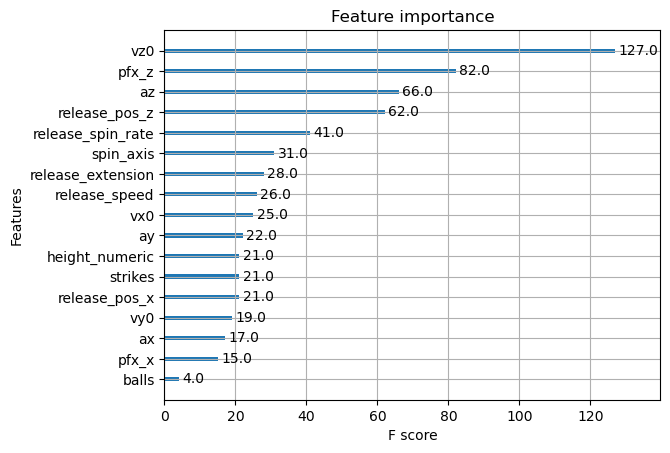

In [15]:
xgb.plot_importance(model)
plt.show()

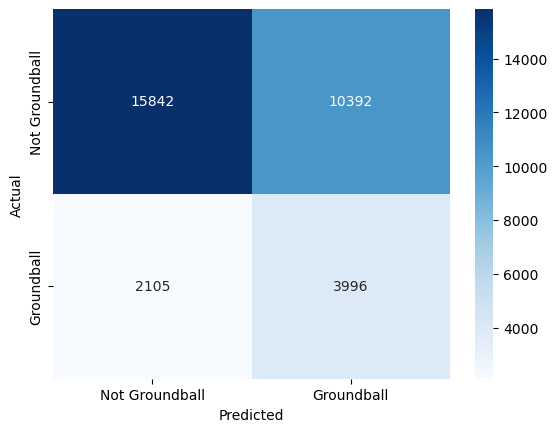

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:51:48,205] A new study created in memory with name: no-name-7e0cd51e-54e2-477f-90a9-7a6ff5a27785


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65817
[3]	eval-logloss:0.65074
[4]	eval-logloss:0.64632
[5]	eval-logloss:0.64254
[6]	eval-logloss:0.63909
[7]	eval-logloss:0.63819
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63622
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63401
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.63316
[15]	eval-logloss:0.63248
[16]	eval-logloss:0.63251
[17]	eval-logloss:0.63206
[18]	eval-logloss:0.63187
[19]	eval-logloss:0.63097
[20]	eval-logloss:0.63097
[21]	eval-logloss:0.63149
[22]	eval-logloss:0.63078
[23]	eval-logloss:0.63079
[24]	eval-logloss:0.63007
[25]	eval-logloss:0.62982
[26]	eval-logloss:0.62943
[27]	eval-logloss:0.62879
[28]	eval-logloss:0.62797
[29]	eval-logloss:0.62755
[30]	eval-logloss:0.62845
[31]	eval-logloss:0.62802
[32]	eval-logloss:0.62825
[33]	eval-logloss:0.62831
[34]	eval-logloss:0.62851
[35]	eval-logloss:0.62785
[36]	eval-logloss:0.62769
[37]	eval-logloss:0.62758
[38]	eval-logloss:0.62

[I 2023-11-12 12:51:56,099] Trial 0 finished with value: 0.62220032656861 and parameters: {'max_depth': 6, 'eta': 0.254933251132133, 'subsample': 0.6351544179187965, 'colsample_bytree': 0.6396856508833999}. Best is trial 0 with value: 0.62220032656861.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64887
[2]	eval-logloss:0.63955
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62880
[5]	eval-logloss:0.62584
[6]	eval-logloss:0.62315
[7]	eval-logloss:0.62199
[8]	eval-logloss:0.62150
[9]	eval-logloss:0.62092
[10]	eval-logloss:0.61981
[11]	eval-logloss:0.62004
[12]	eval-logloss:0.62001
[13]	eval-logloss:0.62054
[14]	eval-logloss:0.62018
[15]	eval-logloss:0.61838
[16]	eval-logloss:0.61781
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61640
[19]	eval-logloss:0.61558
[20]	eval-logloss:0.61467
[21]	eval-logloss:0.61467
[22]	eval-logloss:0.61436
[23]	eval-logloss:0.61359
[24]	eval-logloss:0.61302
[25]	eval-logloss:0.61176
[26]	eval-logloss:0.61077
[27]	eval-logloss:0.61056
[28]	eval-logloss:0.60869
[29]	eval-logloss:0.60805
[30]	eval-logloss:0.60929
[31]	eval-logloss:0.60899
[32]	eval-logloss:0.60835
[33]	eval-logloss:0.60831
[34]	eval-logloss:0.60839
[35]	eval-logloss:0.60771
[36]	eval-logloss:0.60587
[37]	eval-logloss:0.60648
[38]	eval-logloss:0.60

[I 2023-11-12 12:52:06,971] Trial 1 finished with value: 0.5912778592439722 and parameters: {'max_depth': 9, 'eta': 0.2743052302263038, 'subsample': 0.6035867249259327, 'colsample_bytree': 0.9788226137802676}. Best is trial 1 with value: 0.5912778592439722.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.66197
[2]	eval-logloss:0.65483
[3]	eval-logloss:0.65093
[4]	eval-logloss:0.64717
[5]	eval-logloss:0.64531
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.64256
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.64022
[11]	eval-logloss:0.63982
[12]	eval-logloss:0.63902
[13]	eval-logloss:0.63820
[14]	eval-logloss:0.63776
[15]	eval-logloss:0.63794
[16]	eval-logloss:0.63799
[17]	eval-logloss:0.63735
[18]	eval-logloss:0.63720
[19]	eval-logloss:0.63602
[20]	eval-logloss:0.63554
[21]	eval-logloss:0.63582
[22]	eval-logloss:0.63551
[23]	eval-logloss:0.63583
[24]	eval-logloss:0.63576
[25]	eval-logloss:0.63557
[26]	eval-logloss:0.63508
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63441
[29]	eval-logloss:0.63401
[30]	eval-logloss:0.63510
[31]	eval-logloss:0.63508
[32]	eval-logloss:0.63476
[33]	eval-logloss:0.63522
[34]	eval-logloss:0.63505
[35]	eval-logloss:0.63462
[36]	eval-logloss:0.63433
[37]	eval-logloss:0.63379
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:12,415] Trial 2 finished with value: 0.6298158528925488 and parameters: {'max_depth': 4, 'eta': 0.27598909738864147, 'subsample': 0.7842878509143034, 'colsample_bytree': 0.736557037040716}. Best is trial 1 with value: 0.5912778592439722.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67444
[3]	eval-logloss:0.67019
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.66261
[6]	eval-logloss:0.65961
[7]	eval-logloss:0.65712
[8]	eval-logloss:0.65488
[9]	eval-logloss:0.65304
[10]	eval-logloss:0.65120
[11]	eval-logloss:0.64985
[12]	eval-logloss:0.64848
[13]	eval-logloss:0.64741
[14]	eval-logloss:0.64636
[15]	eval-logloss:0.64550
[16]	eval-logloss:0.64483
[17]	eval-logloss:0.64402
[18]	eval-logloss:0.64338
[19]	eval-logloss:0.64251
[20]	eval-logloss:0.64191
[21]	eval-logloss:0.64154
[22]	eval-logloss:0.64093
[23]	eval-logloss:0.64048
[24]	eval-logloss:0.63997
[25]	eval-logloss:0.63957
[26]	eval-logloss:0.63910
[27]	eval-logloss:0.63866
[28]	eval-logloss:0.63834
[29]	eval-logloss:0.63792
[30]	eval-logloss:0.63790
[31]	eval-logloss:0.63777
[32]	eval-logloss:0.63759
[33]	eval-logloss:0.63740
[34]	eval-logloss:0.63728
[35]	eval-logloss:0.63714
[36]	eval-logloss:0.63683
[37]	eval-logloss:0.63651
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:18,981] Trial 3 finished with value: 0.6301608545969697 and parameters: {'max_depth': 5, 'eta': 0.08112244039055319, 'subsample': 0.7193856034152942, 'colsample_bytree': 0.8025272108497623}. Best is trial 1 with value: 0.5912778592439722.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68030
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67830
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67434
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67168
[14]	eval-logloss:0.67106
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66961
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66714
[19]	eval-logloss:0.66590
[20]	eval-logloss:0.66507
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66327
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66168
[25]	eval-logloss:0.66109
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.65920
[28]	eval-logloss:0.65889
[29]	eval-logloss:0.65836
[30]	eval-logloss:0.65802
[31]	eval-logloss:0.65774
[32]	eval-logloss:0.65699
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65596
[35]	eval-logloss:0.65551
[36]	eval-logloss:0.65514
[37]	eval-logloss:0.65477
[38]	eval-logloss:0.65

[I 2023-11-12 12:52:24,769] Trial 4 finished with value: 0.6417028433825397 and parameters: {'max_depth': 4, 'eta': 0.03041725578162713, 'subsample': 0.7855578961727656, 'colsample_bytree': 0.5956136968573422}. Best is trial 1 with value: 0.5912778592439722.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.64085
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.62991
[8]	eval-logloss:0.62813
[9]	eval-logloss:0.62681
[10]	eval-logloss:0.62548
[11]	eval-logloss:0.62509
[12]	eval-logloss:0.62428
[13]	eval-logloss:0.62307
[14]	eval-logloss:0.62275
[15]	eval-logloss:0.62273
[16]	eval-logloss:0.62220
[17]	eval-logloss:0.62142
[18]	eval-logloss:0.62082
[19]	eval-logloss:0.61942
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61819
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61790
[24]	eval-logloss:0.61717
[25]	eval-logloss:0.61646
[26]	eval-logloss:0.61605
[27]	eval-logloss:0.61491
[28]	eval-logloss:0.61430
[29]	eval-logloss:0.61360
[30]	eval-logloss:0.61385
[31]	eval-logloss:0.61375
[32]	eval-logloss:0.61315
[33]	eval-logloss:0.61290
[34]	eval-logloss:0.61274
[35]	eval-logloss:0.61231
[36]	eval-logloss:0.61142
[37]	eval-logloss:0.61082
[38]	eval-logloss:0.61

[I 2023-11-12 12:52:34,426] Trial 5 finished with value: 0.5905761114135037 and parameters: {'max_depth': 8, 'eta': 0.2709387911249035, 'subsample': 0.7876042422182524, 'colsample_bytree': 0.7038581565003883}. Best is trial 5 with value: 0.5905761114135037.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.66644
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65929
[6]	eval-logloss:0.65688
[7]	eval-logloss:0.65499
[8]	eval-logloss:0.65334
[9]	eval-logloss:0.65191
[10]	eval-logloss:0.65055
[11]	eval-logloss:0.64986
[12]	eval-logloss:0.64897
[13]	eval-logloss:0.64817
[14]	eval-logloss:0.64743
[15]	eval-logloss:0.64673
[16]	eval-logloss:0.64653
[17]	eval-logloss:0.64583
[18]	eval-logloss:0.64555
[19]	eval-logloss:0.64475
[20]	eval-logloss:0.64406
[21]	eval-logloss:0.64368
[22]	eval-logloss:0.64308
[23]	eval-logloss:0.64295
[24]	eval-logloss:0.64255
[25]	eval-logloss:0.64233
[26]	eval-logloss:0.64201
[27]	eval-logloss:0.64145
[28]	eval-logloss:0.64096
[29]	eval-logloss:0.64035
[30]	eval-logloss:0.64060
[31]	eval-logloss:0.64040
[32]	eval-logloss:0.64015
[33]	eval-logloss:0.64021
[34]	eval-logloss:0.64021
[35]	eval-logloss:0.63985
[36]	eval-logloss:0.63960
[37]	eval-logloss:0.63958
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:39,428] Trial 6 finished with value: 0.6354213118666284 and parameters: {'max_depth': 3, 'eta': 0.13266967339385785, 'subsample': 0.6315046873753696, 'colsample_bytree': 0.932199808034632}. Best is trial 5 with value: 0.5905761114135037.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.65389
[3]	eval-logloss:0.65018
[4]	eval-logloss:0.64681
[5]	eval-logloss:0.64467
[6]	eval-logloss:0.64273
[7]	eval-logloss:0.64201
[8]	eval-logloss:0.64116
[9]	eval-logloss:0.64048
[10]	eval-logloss:0.63964
[11]	eval-logloss:0.63953
[12]	eval-logloss:0.63864
[13]	eval-logloss:0.63804
[14]	eval-logloss:0.63780
[15]	eval-logloss:0.63751
[16]	eval-logloss:0.63760
[17]	eval-logloss:0.63702
[18]	eval-logloss:0.63715
[19]	eval-logloss:0.63612
[20]	eval-logloss:0.63561
[21]	eval-logloss:0.63540
[22]	eval-logloss:0.63515
[23]	eval-logloss:0.63558
[24]	eval-logloss:0.63532
[25]	eval-logloss:0.63495
[26]	eval-logloss:0.63441
[27]	eval-logloss:0.63399
[28]	eval-logloss:0.63384
[29]	eval-logloss:0.63349
[30]	eval-logloss:0.63440
[31]	eval-logloss:0.63442
[32]	eval-logloss:0.63409
[33]	eval-logloss:0.63443
[34]	eval-logloss:0.63442
[35]	eval-logloss:0.63431
[36]	eval-logloss:0.63386
[37]	eval-logloss:0.63355
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:45,116] Trial 7 finished with value: 0.6288914291109758 and parameters: {'max_depth': 4, 'eta': 0.27688631029671756, 'subsample': 0.7607483998050208, 'colsample_bytree': 0.9282376591582938}. Best is trial 5 with value: 0.5905761114135037.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.65464
[4]	eval-logloss:0.65098
[5]	eval-logloss:0.64764
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.64449
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.64116
[11]	eval-logloss:0.64095
[12]	eval-logloss:0.63990
[13]	eval-logloss:0.63957
[14]	eval-logloss:0.63922
[15]	eval-logloss:0.63905
[16]	eval-logloss:0.63906
[17]	eval-logloss:0.63843
[18]	eval-logloss:0.63855
[19]	eval-logloss:0.63740
[20]	eval-logloss:0.63688
[21]	eval-logloss:0.63702
[22]	eval-logloss:0.63644
[23]	eval-logloss:0.63650
[24]	eval-logloss:0.63604
[25]	eval-logloss:0.63590
[26]	eval-logloss:0.63549
[27]	eval-logloss:0.63508
[28]	eval-logloss:0.63482
[29]	eval-logloss:0.63435
[30]	eval-logloss:0.63544
[31]	eval-logloss:0.63557
[32]	eval-logloss:0.63548
[33]	eval-logloss:0.63561
[34]	eval-logloss:0.63547
[35]	eval-logloss:0.63509
[36]	eval-logloss:0.63472
[37]	eval-logloss:0.63461
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:50,834] Trial 8 finished with value: 0.62972525973605 and parameters: {'max_depth': 4, 'eta': 0.272923556107921, 'subsample': 0.7210762505902382, 'colsample_bytree': 0.6277928213956838}. Best is trial 5 with value: 0.5905761114135037.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67059
[2]	eval-logloss:0.66323
[3]	eval-logloss:0.65833
[4]	eval-logloss:0.65511
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64844
[8]	eval-logloss:0.64712
[9]	eval-logloss:0.64635
[10]	eval-logloss:0.64523
[11]	eval-logloss:0.64466
[12]	eval-logloss:0.64390
[13]	eval-logloss:0.64366
[14]	eval-logloss:0.64312
[15]	eval-logloss:0.64248
[16]	eval-logloss:0.64224
[17]	eval-logloss:0.64147
[18]	eval-logloss:0.64132
[19]	eval-logloss:0.64056
[20]	eval-logloss:0.64008
[21]	eval-logloss:0.64041
[22]	eval-logloss:0.63997
[23]	eval-logloss:0.63997
[24]	eval-logloss:0.63916
[25]	eval-logloss:0.63906
[26]	eval-logloss:0.63894
[27]	eval-logloss:0.63830
[28]	eval-logloss:0.63771
[29]	eval-logloss:0.63718
[30]	eval-logloss:0.63794
[31]	eval-logloss:0.63778
[32]	eval-logloss:0.63771
[33]	eval-logloss:0.63781
[34]	eval-logloss:0.63787
[35]	eval-logloss:0.63728
[36]	eval-logloss:0.63707
[37]	eval-logloss:0.63718
[38]	eval-logloss:0.63

[I 2023-11-12 12:52:55,787] Trial 9 finished with value: 0.6349507708649897 and parameters: {'max_depth': 3, 'eta': 0.22600186525532073, 'subsample': 0.6196102281234706, 'colsample_bytree': 0.6882399046869849}. Best is trial 5 with value: 0.5905761114135037.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.66070
[3]	eval-logloss:0.65025
[4]	eval-logloss:0.64534
[5]	eval-logloss:0.63870
[6]	eval-logloss:0.63420
[7]	eval-logloss:0.63234
[8]	eval-logloss:0.63068
[9]	eval-logloss:0.62938
[10]	eval-logloss:0.62572
[11]	eval-logloss:0.62324
[12]	eval-logloss:0.62096
[13]	eval-logloss:0.61929
[14]	eval-logloss:0.61774
[15]	eval-logloss:0.61684
[16]	eval-logloss:0.61553
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61273
[19]	eval-logloss:0.61212
[20]	eval-logloss:0.61139
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.60936
[23]	eval-logloss:0.60910
[24]	eval-logloss:0.60832
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60688
[27]	eval-logloss:0.60586
[28]	eval-logloss:0.60516
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60496
[31]	eval-logloss:0.60469
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60295
[35]	eval-logloss:0.60235
[36]	eval-logloss:0.60148
[37]	eval-logloss:0.60088
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:05,861] Trial 10 finished with value: 0.574880766038299 and parameters: {'max_depth': 9, 'eta': 0.20368830830143972, 'subsample': 0.8799749731308509, 'colsample_bytree': 0.5037590913863111}. Best is trial 10 with value: 0.574880766038299.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66214
[3]	eval-logloss:0.65213
[4]	eval-logloss:0.64658
[5]	eval-logloss:0.64006
[6]	eval-logloss:0.63502
[7]	eval-logloss:0.63271
[8]	eval-logloss:0.63076
[9]	eval-logloss:0.62951
[10]	eval-logloss:0.62574
[11]	eval-logloss:0.62327
[12]	eval-logloss:0.62076
[13]	eval-logloss:0.61966
[14]	eval-logloss:0.61786
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61558
[17]	eval-logloss:0.61375
[18]	eval-logloss:0.61281
[19]	eval-logloss:0.61179
[20]	eval-logloss:0.61099
[21]	eval-logloss:0.61007
[22]	eval-logloss:0.60905
[23]	eval-logloss:0.60871
[24]	eval-logloss:0.60773
[25]	eval-logloss:0.60702
[26]	eval-logloss:0.60647
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60409
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60331
[31]	eval-logloss:0.60264
[32]	eval-logloss:0.60191
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.60061
[36]	eval-logloss:0.59988
[37]	eval-logloss:0.59924
[38]	eval-logloss:0.59

[I 2023-11-12 12:53:15,431] Trial 11 finished with value: 0.573883344359464 and parameters: {'max_depth': 9, 'eta': 0.1922512917992327, 'subsample': 0.8945122636480611, 'colsample_bytree': 0.5038142315938462}. Best is trial 11 with value: 0.573883344359464.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65394
[4]	eval-logloss:0.64915
[5]	eval-logloss:0.64280
[6]	eval-logloss:0.63841
[7]	eval-logloss:0.63641
[8]	eval-logloss:0.63510
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.63123
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62703
[13]	eval-logloss:0.62643
[14]	eval-logloss:0.62521
[15]	eval-logloss:0.62449
[16]	eval-logloss:0.62371
[17]	eval-logloss:0.62236
[18]	eval-logloss:0.62140
[19]	eval-logloss:0.62048
[20]	eval-logloss:0.61982
[21]	eval-logloss:0.61923
[22]	eval-logloss:0.61852
[23]	eval-logloss:0.61813
[24]	eval-logloss:0.61742
[25]	eval-logloss:0.61715
[26]	eval-logloss:0.61678
[27]	eval-logloss:0.61602
[28]	eval-logloss:0.61543
[29]	eval-logloss:0.61503
[30]	eval-logloss:0.61483
[31]	eval-logloss:0.61417
[32]	eval-logloss:0.61350
[33]	eval-logloss:0.61309
[34]	eval-logloss:0.61252
[35]	eval-logloss:0.61205
[36]	eval-logloss:0.61122
[37]	eval-logloss:0.61082
[38]	eval-logloss:0.61

[I 2023-11-12 12:53:23,994] Trial 12 finished with value: 0.5888752548496768 and parameters: {'max_depth': 8, 'eta': 0.19735915945311297, 'subsample': 0.8991557879448451, 'colsample_bytree': 0.5141698637280857}. Best is trial 11 with value: 0.573883344359464.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.66968
[2]	eval-logloss:0.66302
[3]	eval-logloss:0.65285
[4]	eval-logloss:0.64757
[5]	eval-logloss:0.64089
[6]	eval-logloss:0.63613
[7]	eval-logloss:0.63390
[8]	eval-logloss:0.63208
[9]	eval-logloss:0.63099
[10]	eval-logloss:0.62718
[11]	eval-logloss:0.62462
[12]	eval-logloss:0.62225
[13]	eval-logloss:0.62119
[14]	eval-logloss:0.61948
[15]	eval-logloss:0.61846
[16]	eval-logloss:0.61749
[17]	eval-logloss:0.61548
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61205
[21]	eval-logloss:0.61111
[22]	eval-logloss:0.61009
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60768
[27]	eval-logloss:0.60685
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60521
[31]	eval-logloss:0.60481
[32]	eval-logloss:0.60412
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60295
[35]	eval-logloss:0.60257
[36]	eval-logloss:0.60188
[37]	eval-logloss:0.60150
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:33,747] Trial 13 finished with value: 0.5761578659265009 and parameters: {'max_depth': 9, 'eta': 0.17966800071251832, 'subsample': 0.8964435278962837, 'colsample_bytree': 0.5109690999437727}. Best is trial 11 with value: 0.573883344359464.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.67079
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64799
[7]	eval-logloss:0.64601
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64400
[10]	eval-logloss:0.64083
[11]	eval-logloss:0.63857
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63550
[14]	eval-logloss:0.63442
[15]	eval-logloss:0.63397
[16]	eval-logloss:0.63319
[17]	eval-logloss:0.63170
[18]	eval-logloss:0.63083
[19]	eval-logloss:0.62974
[20]	eval-logloss:0.62920
[21]	eval-logloss:0.62880
[22]	eval-logloss:0.62815
[23]	eval-logloss:0.62807
[24]	eval-logloss:0.62754
[25]	eval-logloss:0.62727
[26]	eval-logloss:0.62657
[27]	eval-logloss:0.62599
[28]	eval-logloss:0.62557
[29]	eval-logloss:0.62520
[30]	eval-logloss:0.62535
[31]	eval-logloss:0.62516
[32]	eval-logloss:0.62469
[33]	eval-logloss:0.62476
[34]	eval-logloss:0.62456
[35]	eval-logloss:0.62418
[36]	eval-logloss:0.62375
[37]	eval-logloss:0.62336
[38]	eval-logloss:0.62

[I 2023-11-12 12:53:41,225] Trial 14 finished with value: 0.609122079969424 and parameters: {'max_depth': 7, 'eta': 0.149819092731596, 'subsample': 0.8474073509103915, 'colsample_bytree': 0.5050390794631252}. Best is trial 11 with value: 0.573883344359464.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65802
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64505
[5]	eval-logloss:0.63978
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.63460
[8]	eval-logloss:0.63282
[9]	eval-logloss:0.63151
[10]	eval-logloss:0.62944
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62536
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62345
[16]	eval-logloss:0.62224
[17]	eval-logloss:0.62140
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61878
[21]	eval-logloss:0.61815
[22]	eval-logloss:0.61765
[23]	eval-logloss:0.61754
[24]	eval-logloss:0.61690
[25]	eval-logloss:0.61650
[26]	eval-logloss:0.61598
[27]	eval-logloss:0.61562
[28]	eval-logloss:0.61527
[29]	eval-logloss:0.61468
[30]	eval-logloss:0.61454
[31]	eval-logloss:0.61441
[32]	eval-logloss:0.61387
[33]	eval-logloss:0.61390
[34]	eval-logloss:0.61369
[35]	eval-logloss:0.61302
[36]	eval-logloss:0.61216
[37]	eval-logloss:0.61177
[38]	eval-logloss:0.61

[I 2023-11-12 12:53:49,721] Trial 15 finished with value: 0.5911359691073171 and parameters: {'max_depth': 8, 'eta': 0.21355530813139598, 'subsample': 0.8478182292811265, 'colsample_bytree': 0.5774903031390466}. Best is trial 11 with value: 0.573883344359464.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66494
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65277
[5]	eval-logloss:0.64740
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.64050
[9]	eval-logloss:0.63932
[10]	eval-logloss:0.63674
[11]	eval-logloss:0.63515
[12]	eval-logloss:0.63371
[13]	eval-logloss:0.63290
[14]	eval-logloss:0.63190
[15]	eval-logloss:0.63140
[16]	eval-logloss:0.63103
[17]	eval-logloss:0.63013
[18]	eval-logloss:0.62934
[19]	eval-logloss:0.62844
[20]	eval-logloss:0.62802
[21]	eval-logloss:0.62745
[22]	eval-logloss:0.62689
[23]	eval-logloss:0.62681
[24]	eval-logloss:0.62636
[25]	eval-logloss:0.62578
[26]	eval-logloss:0.62538
[27]	eval-logloss:0.62490
[28]	eval-logloss:0.62449
[29]	eval-logloss:0.62406
[30]	eval-logloss:0.62409
[31]	eval-logloss:0.62388
[32]	eval-logloss:0.62325
[33]	eval-logloss:0.62320
[34]	eval-logloss:0.62305
[35]	eval-logloss:0.62263
[36]	eval-logloss:0.62208
[37]	eval-logloss:0.62192
[38]	eval-logloss:0.62

[I 2023-11-12 12:53:57,243] Trial 16 finished with value: 0.6087247853648782 and parameters: {'max_depth': 7, 'eta': 0.1724057334650636, 'subsample': 0.8641234176138689, 'colsample_bytree': 0.5663416175411199}. Best is trial 11 with value: 0.573883344359464.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65824
[3]	eval-logloss:0.64774
[4]	eval-logloss:0.64238
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62887
[8]	eval-logloss:0.62745
[9]	eval-logloss:0.62669
[10]	eval-logloss:0.62295
[11]	eval-logloss:0.62096
[12]	eval-logloss:0.61903
[13]	eval-logloss:0.61759
[14]	eval-logloss:0.61555
[15]	eval-logloss:0.61452
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61213
[18]	eval-logloss:0.61106
[19]	eval-logloss:0.60952
[20]	eval-logloss:0.60893
[21]	eval-logloss:0.60757
[22]	eval-logloss:0.60714
[23]	eval-logloss:0.60731
[24]	eval-logloss:0.60602
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60436
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.60264
[29]	eval-logloss:0.60234
[30]	eval-logloss:0.60214
[31]	eval-logloss:0.60182
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.60153
[34]	eval-logloss:0.60060
[35]	eval-logloss:0.59977
[36]	eval-logloss:0.59859
[37]	eval-logloss:0.59773
[38]	eval-logloss:0.59

[I 2023-11-12 12:54:06,960] Trial 17 finished with value: 0.5733268013312015 and parameters: {'max_depth': 9, 'eta': 0.22781942607259104, 'subsample': 0.8185269982606351, 'colsample_bytree': 0.5535467385721796}. Best is trial 17 with value: 0.5733268013312015.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.65061
[4]	eval-logloss:0.64650
[5]	eval-logloss:0.64163
[6]	eval-logloss:0.63870
[7]	eval-logloss:0.63741
[8]	eval-logloss:0.63614
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63334
[11]	eval-logloss:0.63248
[12]	eval-logloss:0.63112
[13]	eval-logloss:0.63024
[14]	eval-logloss:0.62927
[15]	eval-logloss:0.62899
[16]	eval-logloss:0.62841
[17]	eval-logloss:0.62800
[18]	eval-logloss:0.62735
[19]	eval-logloss:0.62621
[20]	eval-logloss:0.62539
[21]	eval-logloss:0.62521
[22]	eval-logloss:0.62480
[23]	eval-logloss:0.62479
[24]	eval-logloss:0.62441
[25]	eval-logloss:0.62409
[26]	eval-logloss:0.62325
[27]	eval-logloss:0.62284
[28]	eval-logloss:0.62257
[29]	eval-logloss:0.62228
[30]	eval-logloss:0.62230
[31]	eval-logloss:0.62223
[32]	eval-logloss:0.62193
[33]	eval-logloss:0.62196
[34]	eval-logloss:0.62166
[35]	eval-logloss:0.62112
[36]	eval-logloss:0.62066
[37]	eval-logloss:0.62053
[38]	eval-logloss:0.62

[I 2023-11-12 12:54:13,989] Trial 18 finished with value: 0.6046156470112395 and parameters: {'max_depth': 7, 'eta': 0.233713998329312, 'subsample': 0.8364833974768187, 'colsample_bytree': 0.5651983596885225}. Best is trial 17 with value: 0.5733268013312015.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65247
[4]	eval-logloss:0.64859
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.64166
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63889
[9]	eval-logloss:0.63809
[10]	eval-logloss:0.63666
[11]	eval-logloss:0.63589
[12]	eval-logloss:0.63488
[13]	eval-logloss:0.63374
[14]	eval-logloss:0.63313
[15]	eval-logloss:0.63338
[16]	eval-logloss:0.63313
[17]	eval-logloss:0.63254
[18]	eval-logloss:0.63220
[19]	eval-logloss:0.63142
[20]	eval-logloss:0.63092
[21]	eval-logloss:0.63046
[22]	eval-logloss:0.63017
[23]	eval-logloss:0.63075
[24]	eval-logloss:0.63026
[25]	eval-logloss:0.62988
[26]	eval-logloss:0.62923
[27]	eval-logloss:0.62889
[28]	eval-logloss:0.62876
[29]	eval-logloss:0.62849
[30]	eval-logloss:0.62872
[31]	eval-logloss:0.62875
[32]	eval-logloss:0.62828
[33]	eval-logloss:0.62859
[34]	eval-logloss:0.62850
[35]	eval-logloss:0.62822
[36]	eval-logloss:0.62782
[37]	eval-logloss:0.62764
[38]	eval-logloss:0.62

[I 2023-11-12 12:54:20,511] Trial 19 finished with value: 0.617195577430661 and parameters: {'max_depth': 6, 'eta': 0.23805404479377018, 'subsample': 0.8217321797499779, 'colsample_bytree': 0.6566220164121431}. Best is trial 17 with value: 0.5733268013312015.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66257
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65266
[6]	eval-logloss:0.64816
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63697
[12]	eval-logloss:0.63482
[13]	eval-logloss:0.63366
[14]	eval-logloss:0.63248
[15]	eval-logloss:0.63150
[16]	eval-logloss:0.63060
[17]	eval-logloss:0.62925
[18]	eval-logloss:0.62827
[19]	eval-logloss:0.62698
[20]	eval-logloss:0.62627
[21]	eval-logloss:0.62549
[22]	eval-logloss:0.62460
[23]	eval-logloss:0.62431
[24]	eval-logloss:0.62357
[25]	eval-logloss:0.62310
[26]	eval-logloss:0.62250
[27]	eval-logloss:0.62175
[28]	eval-logloss:0.62140
[29]	eval-logloss:0.62090
[30]	eval-logloss:0.62072
[31]	eval-logloss:0.62022
[32]	eval-logloss:0.61960
[33]	eval-logloss:0.61949
[34]	eval-logloss:0.61900
[35]	eval-logloss:0.61863
[36]	eval-logloss:0.61820
[37]	eval-logloss:0.61772
[38]	eval-logloss:0.61

[I 2023-11-12 12:54:28,903] Trial 20 finished with value: 0.5986883356391572 and parameters: {'max_depth': 8, 'eta': 0.12089590813027004, 'subsample': 0.8709230552804522, 'colsample_bytree': 0.6041934729276532}. Best is trial 17 with value: 0.5733268013312015.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.66155
[3]	eval-logloss:0.65103
[4]	eval-logloss:0.64613
[5]	eval-logloss:0.63957
[6]	eval-logloss:0.63462
[7]	eval-logloss:0.63244
[8]	eval-logloss:0.63076
[9]	eval-logloss:0.62951
[10]	eval-logloss:0.62601
[11]	eval-logloss:0.62344
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.62020
[14]	eval-logloss:0.61850
[15]	eval-logloss:0.61758
[16]	eval-logloss:0.61650
[17]	eval-logloss:0.61496
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61242
[20]	eval-logloss:0.61164
[21]	eval-logloss:0.61051
[22]	eval-logloss:0.60932
[23]	eval-logloss:0.60887
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60590
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60489
[30]	eval-logloss:0.60489
[31]	eval-logloss:0.60428
[32]	eval-logloss:0.60376
[33]	eval-logloss:0.60329
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60102
[38]	eval-logloss:0.60

[I 2023-11-12 12:54:37,986] Trial 21 finished with value: 0.5756215010451666 and parameters: {'max_depth': 9, 'eta': 0.19906799882399706, 'subsample': 0.873212131762056, 'colsample_bytree': 0.5432789472304459}. Best is trial 17 with value: 0.5733268013312015.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.66024
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.64405
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63249
[7]	eval-logloss:0.63059
[8]	eval-logloss:0.62910
[9]	eval-logloss:0.62811
[10]	eval-logloss:0.62461
[11]	eval-logloss:0.62236
[12]	eval-logloss:0.61996
[13]	eval-logloss:0.61923
[14]	eval-logloss:0.61757
[15]	eval-logloss:0.61684
[16]	eval-logloss:0.61579
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61321
[19]	eval-logloss:0.61195
[20]	eval-logloss:0.61115
[21]	eval-logloss:0.60995
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60848
[24]	eval-logloss:0.60787
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60690
[27]	eval-logloss:0.60593
[28]	eval-logloss:0.60521
[29]	eval-logloss:0.60469
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60326
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60268
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60125
[37]	eval-logloss:0.60079
[38]	eval-logloss:0.60

[I 2023-11-12 12:54:47,316] Trial 22 finished with value: 0.5727466228916474 and parameters: {'max_depth': 9, 'eta': 0.2066655761368598, 'subsample': 0.8997787628754497, 'colsample_bytree': 0.5048657533507507}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.63883
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62922
[7]	eval-logloss:0.62765
[8]	eval-logloss:0.62519
[9]	eval-logloss:0.62385
[10]	eval-logloss:0.62182
[11]	eval-logloss:0.62001
[12]	eval-logloss:0.61843
[13]	eval-logloss:0.61744
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61477
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.61189
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.61009
[21]	eval-logloss:0.60896
[22]	eval-logloss:0.60793
[23]	eval-logloss:0.60762
[24]	eval-logloss:0.60698
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60640
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60415
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60330
[32]	eval-logloss:0.60257
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60103
[36]	eval-logloss:0.60012
[37]	eval-logloss:0.59959
[38]	eval-logloss:0.59

[I 2023-11-12 12:54:56,673] Trial 23 finished with value: 0.5733540321756941 and parameters: {'max_depth': 9, 'eta': 0.24438880250326334, 'subsample': 0.8989615809892993, 'colsample_bytree': 0.5617224147716663}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.65954
[3]	eval-logloss:0.64968
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63937
[6]	eval-logloss:0.63548
[7]	eval-logloss:0.63401
[8]	eval-logloss:0.63313
[9]	eval-logloss:0.63292
[10]	eval-logloss:0.63001
[11]	eval-logloss:0.62857
[12]	eval-logloss:0.62699
[13]	eval-logloss:0.62582
[14]	eval-logloss:0.62454
[15]	eval-logloss:0.62389
[16]	eval-logloss:0.62322
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.62085
[19]	eval-logloss:0.61989
[20]	eval-logloss:0.61901
[21]	eval-logloss:0.61857
[22]	eval-logloss:0.61841
[23]	eval-logloss:0.61880
[24]	eval-logloss:0.61799
[25]	eval-logloss:0.61785
[26]	eval-logloss:0.61710
[27]	eval-logloss:0.61607
[28]	eval-logloss:0.61536
[29]	eval-logloss:0.61473
[30]	eval-logloss:0.61471
[31]	eval-logloss:0.61464
[32]	eval-logloss:0.61444
[33]	eval-logloss:0.61474
[34]	eval-logloss:0.61424
[35]	eval-logloss:0.61350
[36]	eval-logloss:0.61258
[37]	eval-logloss:0.61203
[38]	eval-logloss:0.61

[I 2023-11-12 12:55:05,036] Trial 24 finished with value: 0.5908225865137625 and parameters: {'max_depth': 8, 'eta': 0.24420682788020445, 'subsample': 0.8219193553261609, 'colsample_bytree': 0.5508673818646898}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.65402
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63953
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.63077
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62659
[8]	eval-logloss:0.62420
[9]	eval-logloss:0.62216
[10]	eval-logloss:0.62033
[11]	eval-logloss:0.61905
[12]	eval-logloss:0.61747
[13]	eval-logloss:0.61599
[14]	eval-logloss:0.61461
[15]	eval-logloss:0.61363
[16]	eval-logloss:0.61309
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.61168
[19]	eval-logloss:0.61135
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60614
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60444
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60314
[35]	eval-logloss:0.60217
[36]	eval-logloss:0.60102
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.60

[I 2023-11-12 12:55:14,429] Trial 25 finished with value: 0.5755522842628047 and parameters: {'max_depth': 9, 'eta': 0.29717041728678945, 'subsample': 0.8620659617080004, 'colsample_bytree': 0.6028642743134289}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.65451
[4]	eval-logloss:0.65036
[5]	eval-logloss:0.64509
[6]	eval-logloss:0.64116
[7]	eval-logloss:0.63996
[8]	eval-logloss:0.63911
[9]	eval-logloss:0.63854
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63451
[12]	eval-logloss:0.63277
[13]	eval-logloss:0.63234
[14]	eval-logloss:0.63140
[15]	eval-logloss:0.63102
[16]	eval-logloss:0.63038
[17]	eval-logloss:0.62925
[18]	eval-logloss:0.62854
[19]	eval-logloss:0.62794
[20]	eval-logloss:0.62771
[21]	eval-logloss:0.62705
[22]	eval-logloss:0.62638
[23]	eval-logloss:0.62626
[24]	eval-logloss:0.62580
[25]	eval-logloss:0.62580
[26]	eval-logloss:0.62544
[27]	eval-logloss:0.62487
[28]	eval-logloss:0.62459
[29]	eval-logloss:0.62414
[30]	eval-logloss:0.62418
[31]	eval-logloss:0.62410
[32]	eval-logloss:0.62361
[33]	eval-logloss:0.62336
[34]	eval-logloss:0.62327
[35]	eval-logloss:0.62297
[36]	eval-logloss:0.62258
[37]	eval-logloss:0.62219
[38]	eval-logloss:0.62

[I 2023-11-12 12:55:21,603] Trial 26 finished with value: 0.6053398137011828 and parameters: {'max_depth': 7, 'eta': 0.2204310960086138, 'subsample': 0.8997138718656272, 'colsample_bytree': 0.5427950113250689}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64625
[4]	eval-logloss:0.64134
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.63322
[7]	eval-logloss:0.63206
[8]	eval-logloss:0.62979
[9]	eval-logloss:0.62883
[10]	eval-logloss:0.62697
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62488
[13]	eval-logloss:0.62361
[14]	eval-logloss:0.62263
[15]	eval-logloss:0.62234
[16]	eval-logloss:0.62165
[17]	eval-logloss:0.62152
[18]	eval-logloss:0.62077
[19]	eval-logloss:0.62003
[20]	eval-logloss:0.61900
[21]	eval-logloss:0.61828
[22]	eval-logloss:0.61761
[23]	eval-logloss:0.61774
[24]	eval-logloss:0.61718
[25]	eval-logloss:0.61722
[26]	eval-logloss:0.61659
[27]	eval-logloss:0.61566
[28]	eval-logloss:0.61507
[29]	eval-logloss:0.61411
[30]	eval-logloss:0.61396
[31]	eval-logloss:0.61402
[32]	eval-logloss:0.61373
[33]	eval-logloss:0.61374
[34]	eval-logloss:0.61361
[35]	eval-logloss:0.61303
[36]	eval-logloss:0.61203
[37]	eval-logloss:0.61131
[38]	eval-logloss:0.61

[I 2023-11-12 12:55:29,920] Trial 27 finished with value: 0.5896208091859166 and parameters: {'max_depth': 8, 'eta': 0.25074084693545573, 'subsample': 0.825802701759331, 'colsample_bytree': 0.611940403722521}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65907
[3]	eval-logloss:0.64838
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63665
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62895
[9]	eval-logloss:0.62802
[10]	eval-logloss:0.62429
[11]	eval-logloss:0.62192
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61845
[14]	eval-logloss:0.61676
[15]	eval-logloss:0.61571
[16]	eval-logloss:0.61445
[17]	eval-logloss:0.61302
[18]	eval-logloss:0.61221
[19]	eval-logloss:0.61128
[20]	eval-logloss:0.61037
[21]	eval-logloss:0.61001
[22]	eval-logloss:0.60919
[23]	eval-logloss:0.60896
[24]	eval-logloss:0.60791
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60638
[27]	eval-logloss:0.60582
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60490
[30]	eval-logloss:0.60486
[31]	eval-logloss:0.60471
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60326
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60220
[36]	eval-logloss:0.60148
[37]	eval-logloss:0.60088
[38]	eval-logloss:0.60

[I 2023-11-12 12:55:39,096] Trial 28 finished with value: 0.5756376010174867 and parameters: {'max_depth': 9, 'eta': 0.21603693031651997, 'subsample': 0.8511442252838664, 'colsample_bytree': 0.5505077846269886}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66485
[2]	eval-logloss:0.66102
[3]	eval-logloss:0.65349
[4]	eval-logloss:0.64992
[5]	eval-logloss:0.64640
[6]	eval-logloss:0.64397
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.64128
[9]	eval-logloss:0.64047
[10]	eval-logloss:0.63903
[11]	eval-logloss:0.63821
[12]	eval-logloss:0.63742
[13]	eval-logloss:0.63666
[14]	eval-logloss:0.63606
[15]	eval-logloss:0.63610
[16]	eval-logloss:0.63584
[17]	eval-logloss:0.63550
[18]	eval-logloss:0.63522
[19]	eval-logloss:0.63475
[20]	eval-logloss:0.63432
[21]	eval-logloss:0.63407
[22]	eval-logloss:0.63363
[23]	eval-logloss:0.63377
[24]	eval-logloss:0.63367
[25]	eval-logloss:0.63355
[26]	eval-logloss:0.63344
[27]	eval-logloss:0.63312
[28]	eval-logloss:0.63270
[29]	eval-logloss:0.63237
[30]	eval-logloss:0.63294
[31]	eval-logloss:0.63291
[32]	eval-logloss:0.63223
[33]	eval-logloss:0.63225
[34]	eval-logloss:0.63229
[35]	eval-logloss:0.63185
[36]	eval-logloss:0.63146
[37]	eval-logloss:0.63145
[38]	eval-logloss:0.63

[I 2023-11-12 12:55:44,687] Trial 29 finished with value: 0.624507250216303 and parameters: {'max_depth': 5, 'eta': 0.2526055169789361, 'subsample': 0.8793763055868561, 'colsample_bytree': 0.6540205988720618}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.66433
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.65097
[4]	eval-logloss:0.64667
[5]	eval-logloss:0.64226
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63776
[8]	eval-logloss:0.63563
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63240
[12]	eval-logloss:0.63093
[13]	eval-logloss:0.62957
[14]	eval-logloss:0.62881
[15]	eval-logloss:0.62854
[16]	eval-logloss:0.62823
[17]	eval-logloss:0.62754
[18]	eval-logloss:0.62722
[19]	eval-logloss:0.62633
[20]	eval-logloss:0.62560
[21]	eval-logloss:0.62531
[22]	eval-logloss:0.62494
[23]	eval-logloss:0.62507
[24]	eval-logloss:0.62443
[25]	eval-logloss:0.62411
[26]	eval-logloss:0.62339
[27]	eval-logloss:0.62316
[28]	eval-logloss:0.62265
[29]	eval-logloss:0.62257
[30]	eval-logloss:0.62271
[31]	eval-logloss:0.62273
[32]	eval-logloss:0.62204
[33]	eval-logloss:0.62244
[34]	eval-logloss:0.62214
[35]	eval-logloss:0.62165
[36]	eval-logloss:0.62101
[37]	eval-logloss:0.62026
[38]	eval-logloss:0.61

[I 2023-11-12 12:55:52,102] Trial 30 finished with value: 0.6056064969543568 and parameters: {'max_depth': 7, 'eta': 0.22762915059458044, 'subsample': 0.810510196224026, 'colsample_bytree': 0.6445905689905153}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65126
[4]	eval-logloss:0.64639
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63507
[7]	eval-logloss:0.63270
[8]	eval-logloss:0.63110
[9]	eval-logloss:0.62956
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62365
[12]	eval-logloss:0.62096
[13]	eval-logloss:0.62015
[14]	eval-logloss:0.61862
[15]	eval-logloss:0.61773
[16]	eval-logloss:0.61689
[17]	eval-logloss:0.61551
[18]	eval-logloss:0.61439
[19]	eval-logloss:0.61302
[20]	eval-logloss:0.61204
[21]	eval-logloss:0.61101
[22]	eval-logloss:0.61010
[23]	eval-logloss:0.60952
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60727
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60545
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60295
[34]	eval-logloss:0.60262
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60183
[37]	eval-logloss:0.60112
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:01,311] Trial 31 finished with value: 0.5751977300491149 and parameters: {'max_depth': 9, 'eta': 0.19572853066100013, 'subsample': 0.8814380102166247, 'colsample_bytree': 0.5327435541134998}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66291
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64773
[5]	eval-logloss:0.64128
[6]	eval-logloss:0.63634
[7]	eval-logloss:0.63372
[8]	eval-logloss:0.63184
[9]	eval-logloss:0.63045
[10]	eval-logloss:0.62705
[11]	eval-logloss:0.62454
[12]	eval-logloss:0.62209
[13]	eval-logloss:0.62098
[14]	eval-logloss:0.61909
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61694
[17]	eval-logloss:0.61532
[18]	eval-logloss:0.61371
[19]	eval-logloss:0.61244
[20]	eval-logloss:0.61179
[21]	eval-logloss:0.61083
[22]	eval-logloss:0.60984
[23]	eval-logloss:0.60942
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60843
[26]	eval-logloss:0.60776
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60607
[29]	eval-logloss:0.60576
[30]	eval-logloss:0.60573
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60428
[33]	eval-logloss:0.60379
[34]	eval-logloss:0.60310
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60129
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:10,771] Trial 32 finished with value: 0.576524028587437 and parameters: {'max_depth': 9, 'eta': 0.18017805499980982, 'subsample': 0.8891744504233448, 'colsample_bytree': 0.50123991750701}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64735
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63472
[7]	eval-logloss:0.63325
[8]	eval-logloss:0.63108
[9]	eval-logloss:0.63026
[10]	eval-logloss:0.62817
[11]	eval-logloss:0.62692
[12]	eval-logloss:0.62556
[13]	eval-logloss:0.62482
[14]	eval-logloss:0.62370
[15]	eval-logloss:0.62303
[16]	eval-logloss:0.62243
[17]	eval-logloss:0.62144
[18]	eval-logloss:0.62102
[19]	eval-logloss:0.62028
[20]	eval-logloss:0.61923
[21]	eval-logloss:0.61859
[22]	eval-logloss:0.61783
[23]	eval-logloss:0.61788
[24]	eval-logloss:0.61720
[25]	eval-logloss:0.61655
[26]	eval-logloss:0.61605
[27]	eval-logloss:0.61523
[28]	eval-logloss:0.61446
[29]	eval-logloss:0.61439
[30]	eval-logloss:0.61440
[31]	eval-logloss:0.61432
[32]	eval-logloss:0.61356
[33]	eval-logloss:0.61372
[34]	eval-logloss:0.61319
[35]	eval-logloss:0.61245
[36]	eval-logloss:0.61202
[37]	eval-logloss:0.61174
[38]	eval-logloss:0.61

[I 2023-11-12 12:56:18,831] Trial 33 finished with value: 0.5914915500981778 and parameters: {'max_depth': 8, 'eta': 0.23719619015515944, 'subsample': 0.8599211739964939, 'colsample_bytree': 0.5740461186918963}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64378
[5]	eval-logloss:0.63705
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.63049
[8]	eval-logloss:0.62835
[9]	eval-logloss:0.62703
[10]	eval-logloss:0.62321
[11]	eval-logloss:0.62095
[12]	eval-logloss:0.61892
[13]	eval-logloss:0.61794
[14]	eval-logloss:0.61595
[15]	eval-logloss:0.61508
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61242
[18]	eval-logloss:0.61130
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60950
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60697
[23]	eval-logloss:0.60668
[24]	eval-logloss:0.60586
[25]	eval-logloss:0.60520
[26]	eval-logloss:0.60473
[27]	eval-logloss:0.60376
[28]	eval-logloss:0.60315
[29]	eval-logloss:0.60292
[30]	eval-logloss:0.60285
[31]	eval-logloss:0.60207
[32]	eval-logloss:0.60135
[33]	eval-logloss:0.60112
[34]	eval-logloss:0.60063
[35]	eval-logloss:0.59988
[36]	eval-logloss:0.59923
[37]	eval-logloss:0.59835
[38]	eval-logloss:0.59

[I 2023-11-12 12:56:28,253] Trial 34 finished with value: 0.5730772907139028 and parameters: {'max_depth': 9, 'eta': 0.2145748477174197, 'subsample': 0.8845863623128488, 'colsample_bytree': 0.531899197015672}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.65133
[3]	eval-logloss:0.64182
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.63194
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62634
[8]	eval-logloss:0.62385
[9]	eval-logloss:0.62237
[10]	eval-logloss:0.61991
[11]	eval-logloss:0.61851
[12]	eval-logloss:0.61691
[13]	eval-logloss:0.61547
[14]	eval-logloss:0.61432
[15]	eval-logloss:0.61381
[16]	eval-logloss:0.61276
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61028
[19]	eval-logloss:0.60986
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60768
[22]	eval-logloss:0.60685
[23]	eval-logloss:0.60639
[24]	eval-logloss:0.60555
[25]	eval-logloss:0.60489
[26]	eval-logloss:0.60423
[27]	eval-logloss:0.60403
[28]	eval-logloss:0.60335
[29]	eval-logloss:0.60286
[30]	eval-logloss:0.60273
[31]	eval-logloss:0.60226
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60169
[34]	eval-logloss:0.60114
[35]	eval-logloss:0.60034
[36]	eval-logloss:0.59973
[37]	eval-logloss:0.59915
[38]	eval-logloss:0.59

[I 2023-11-12 12:56:37,946] Trial 35 finished with value: 0.5728392220336421 and parameters: {'max_depth': 9, 'eta': 0.2598655329324159, 'subsample': 0.8695206296043934, 'colsample_bytree': 0.5797340240254321}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.63171
[8]	eval-logloss:0.62961
[9]	eval-logloss:0.62883
[10]	eval-logloss:0.62732
[11]	eval-logloss:0.62624
[12]	eval-logloss:0.62494
[13]	eval-logloss:0.62355
[14]	eval-logloss:0.62226
[15]	eval-logloss:0.62187
[16]	eval-logloss:0.62163
[17]	eval-logloss:0.62022
[18]	eval-logloss:0.61972
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61826
[21]	eval-logloss:0.61784
[22]	eval-logloss:0.61740
[23]	eval-logloss:0.61739
[24]	eval-logloss:0.61640
[25]	eval-logloss:0.61601
[26]	eval-logloss:0.61493
[27]	eval-logloss:0.61440
[28]	eval-logloss:0.61362
[29]	eval-logloss:0.61312
[30]	eval-logloss:0.61294
[31]	eval-logloss:0.61276
[32]	eval-logloss:0.61206
[33]	eval-logloss:0.61170
[34]	eval-logloss:0.61155
[35]	eval-logloss:0.61097
[36]	eval-logloss:0.61019
[37]	eval-logloss:0.61004
[38]	eval-logloss:0.60

[I 2023-11-12 12:56:46,423] Trial 36 finished with value: 0.5944275415379975 and parameters: {'max_depth': 8, 'eta': 0.2627768372409922, 'subsample': 0.8445029443178623, 'colsample_bytree': 0.5820148662807275}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66650
[2]	eval-logloss:0.65898
[3]	eval-logloss:0.64832
[4]	eval-logloss:0.64335
[5]	eval-logloss:0.63737
[6]	eval-logloss:0.63303
[7]	eval-logloss:0.63077
[8]	eval-logloss:0.62931
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62458
[11]	eval-logloss:0.62205
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61836
[14]	eval-logloss:0.61686
[15]	eval-logloss:0.61547
[16]	eval-logloss:0.61436
[17]	eval-logloss:0.61316
[18]	eval-logloss:0.61214
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60973
[21]	eval-logloss:0.60897
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60782
[24]	eval-logloss:0.60701
[25]	eval-logloss:0.60675
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60561
[28]	eval-logloss:0.60501
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60174
[36]	eval-logloss:0.60061
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-12 12:56:55,714] Trial 37 finished with value: 0.5741620589417407 and parameters: {'max_depth': 9, 'eta': 0.21917236793388878, 'subsample': 0.8655505591029203, 'colsample_bytree': 0.5372229774967101}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.66041
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.64958
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64314
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.64146
[9]	eval-logloss:0.64092
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63910
[12]	eval-logloss:0.63775
[13]	eval-logloss:0.63682
[14]	eval-logloss:0.63623
[15]	eval-logloss:0.63629
[16]	eval-logloss:0.63619
[17]	eval-logloss:0.63566
[18]	eval-logloss:0.63530
[19]	eval-logloss:0.63457
[20]	eval-logloss:0.63366
[21]	eval-logloss:0.63372
[22]	eval-logloss:0.63330
[23]	eval-logloss:0.63343
[24]	eval-logloss:0.63312
[25]	eval-logloss:0.63315
[26]	eval-logloss:0.63248
[27]	eval-logloss:0.63220
[28]	eval-logloss:0.63189
[29]	eval-logloss:0.63181
[30]	eval-logloss:0.63243
[31]	eval-logloss:0.63262
[32]	eval-logloss:0.63209
[33]	eval-logloss:0.63259
[34]	eval-logloss:0.63262
[35]	eval-logloss:0.63237
[36]	eval-logloss:0.63206
[37]	eval-logloss:0.63193
[38]	eval-logloss:0.63

[I 2023-11-12 12:57:01,713] Trial 38 finished with value: 0.6247888491896382 and parameters: {'max_depth': 5, 'eta': 0.25899212544699746, 'subsample': 0.8048637204393198, 'colsample_bytree': 0.6040433827401125}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.64151
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63295
[7]	eval-logloss:0.63169
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.63044
[10]	eval-logloss:0.62784
[11]	eval-logloss:0.62664
[12]	eval-logloss:0.62506
[13]	eval-logloss:0.62387
[14]	eval-logloss:0.62284
[15]	eval-logloss:0.62265
[16]	eval-logloss:0.62228
[17]	eval-logloss:0.62150
[18]	eval-logloss:0.62092
[19]	eval-logloss:0.62042
[20]	eval-logloss:0.61983
[21]	eval-logloss:0.61946
[22]	eval-logloss:0.61901
[23]	eval-logloss:0.61945
[24]	eval-logloss:0.61867
[25]	eval-logloss:0.61821
[26]	eval-logloss:0.61747
[27]	eval-logloss:0.61650
[28]	eval-logloss:0.61601
[29]	eval-logloss:0.61606
[30]	eval-logloss:0.61594
[31]	eval-logloss:0.61577
[32]	eval-logloss:0.61527
[33]	eval-logloss:0.61528
[34]	eval-logloss:0.61499
[35]	eval-logloss:0.61394
[36]	eval-logloss:0.61317
[37]	eval-logloss:0.61294
[38]	eval-logloss:0.61

[I 2023-11-12 12:57:10,247] Trial 39 finished with value: 0.5940663714380843 and parameters: {'max_depth': 8, 'eta': 0.2935805514399694, 'subsample': 0.8307671109699433, 'colsample_bytree': 0.5273140266737228}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.65217
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.63990
[5]	eval-logloss:0.63612
[6]	eval-logloss:0.63370
[7]	eval-logloss:0.63219
[8]	eval-logloss:0.62989
[9]	eval-logloss:0.62856
[10]	eval-logloss:0.62658
[11]	eval-logloss:0.62542
[12]	eval-logloss:0.62417
[13]	eval-logloss:0.62330
[14]	eval-logloss:0.62261
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.62197
[17]	eval-logloss:0.62085
[18]	eval-logloss:0.62071
[19]	eval-logloss:0.62001
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.61911
[22]	eval-logloss:0.61835
[23]	eval-logloss:0.61828
[24]	eval-logloss:0.61789
[25]	eval-logloss:0.61759
[26]	eval-logloss:0.61690
[27]	eval-logloss:0.61665
[28]	eval-logloss:0.61595
[29]	eval-logloss:0.61541
[30]	eval-logloss:0.61587
[31]	eval-logloss:0.61574
[32]	eval-logloss:0.61503
[33]	eval-logloss:0.61492
[34]	eval-logloss:0.61460
[35]	eval-logloss:0.61371
[36]	eval-logloss:0.61329
[37]	eval-logloss:0.61295
[38]	eval-logloss:0.61

[I 2023-11-12 12:57:18,499] Trial 40 finished with value: 0.5925428378078015 and parameters: {'max_depth': 8, 'eta': 0.2855041125243776, 'subsample': 0.8766885351831784, 'colsample_bytree': 0.6289835450029069}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.65135
[3]	eval-logloss:0.64244
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63265
[6]	eval-logloss:0.62895
[7]	eval-logloss:0.62734
[8]	eval-logloss:0.62560
[9]	eval-logloss:0.62409
[10]	eval-logloss:0.62137
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61686
[14]	eval-logloss:0.61508
[15]	eval-logloss:0.61475
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60984
[21]	eval-logloss:0.60873
[22]	eval-logloss:0.60812
[23]	eval-logloss:0.60752
[24]	eval-logloss:0.60686
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60603
[27]	eval-logloss:0.60561
[28]	eval-logloss:0.60451
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60413
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60315
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60160
[36]	eval-logloss:0.60116
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.60

[I 2023-11-12 12:57:27,966] Trial 41 finished with value: 0.5730835128880829 and parameters: {'max_depth': 9, 'eta': 0.2505595054120075, 'subsample': 0.8842012624615284, 'colsample_bytree': 0.5837318898087314}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.65020
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.63621
[5]	eval-logloss:0.63100
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62454
[9]	eval-logloss:0.62353
[10]	eval-logloss:0.62117
[11]	eval-logloss:0.61957
[12]	eval-logloss:0.61810
[13]	eval-logloss:0.61680
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61560
[16]	eval-logloss:0.61441
[17]	eval-logloss:0.61317
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61171
[20]	eval-logloss:0.61088
[21]	eval-logloss:0.61037
[22]	eval-logloss:0.60986
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60867
[25]	eval-logloss:0.60812
[26]	eval-logloss:0.60731
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60605
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60543
[32]	eval-logloss:0.60445
[33]	eval-logloss:0.60439
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60317
[36]	eval-logloss:0.60260
[37]	eval-logloss:0.60214
[38]	eval-logloss:0.60

[I 2023-11-12 12:57:37,252] Trial 42 finished with value: 0.5776831803268685 and parameters: {'max_depth': 9, 'eta': 0.2657021346587591, 'subsample': 0.8548066560904916, 'colsample_bytree': 0.5848357666978183}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64356
[4]	eval-logloss:0.63899
[5]	eval-logloss:0.63327
[6]	eval-logloss:0.62858
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62447
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61893
[12]	eval-logloss:0.61698
[13]	eval-logloss:0.61564
[14]	eval-logloss:0.61386
[15]	eval-logloss:0.61331
[16]	eval-logloss:0.61227
[17]	eval-logloss:0.61162
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.61013
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60827
[22]	eval-logloss:0.60731
[23]	eval-logloss:0.60698
[24]	eval-logloss:0.60652
[25]	eval-logloss:0.60623
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60422
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60373
[31]	eval-logloss:0.60307
[32]	eval-logloss:0.60227
[33]	eval-logloss:0.60194
[34]	eval-logloss:0.60142
[35]	eval-logloss:0.60115
[36]	eval-logloss:0.60072
[37]	eval-logloss:0.60030
[38]	eval-logloss:0.59

[I 2023-11-12 12:57:46,444] Trial 43 finished with value: 0.5728995586846916 and parameters: {'max_depth': 9, 'eta': 0.2717970717564505, 'subsample': 0.8822793157959636, 'colsample_bytree': 0.537574606584441}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.64099
[5]	eval-logloss:0.63508
[6]	eval-logloss:0.63110
[7]	eval-logloss:0.62889
[8]	eval-logloss:0.62748
[9]	eval-logloss:0.62548
[10]	eval-logloss:0.62199
[11]	eval-logloss:0.62004
[12]	eval-logloss:0.61801
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61439
[16]	eval-logloss:0.61379
[17]	eval-logloss:0.61203
[18]	eval-logloss:0.61112
[19]	eval-logloss:0.61047
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60897
[22]	eval-logloss:0.60768
[23]	eval-logloss:0.60788
[24]	eval-logloss:0.60690
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60488
[32]	eval-logloss:0.60422
[33]	eval-logloss:0.60370
[34]	eval-logloss:0.60320
[35]	eval-logloss:0.60223
[36]	eval-logloss:0.60147
[37]	eval-logloss:0.60093
[38]	eval-logloss:0.60

[I 2023-11-12 12:57:55,712] Trial 44 finished with value: 0.574022561703833 and parameters: {'max_depth': 9, 'eta': 0.259785312247025, 'subsample': 0.8787685327241592, 'colsample_bytree': 0.5361881873394196}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.64292
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62747
[8]	eval-logloss:0.62533
[9]	eval-logloss:0.62457
[10]	eval-logloss:0.62140
[11]	eval-logloss:0.61968
[12]	eval-logloss:0.61787
[13]	eval-logloss:0.61721
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61483
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61195
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.61048
[20]	eval-logloss:0.60942
[21]	eval-logloss:0.60790
[22]	eval-logloss:0.60707
[23]	eval-logloss:0.60647
[24]	eval-logloss:0.60593
[25]	eval-logloss:0.60515
[26]	eval-logloss:0.60461
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60251
[29]	eval-logloss:0.60203
[30]	eval-logloss:0.60203
[31]	eval-logloss:0.60195
[32]	eval-logloss:0.60133
[33]	eval-logloss:0.60105
[34]	eval-logloss:0.60053
[35]	eval-logloss:0.59992
[36]	eval-logloss:0.59910
[37]	eval-logloss:0.59891
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:05,210] Trial 45 finished with value: 0.5753954904559134 and parameters: {'max_depth': 9, 'eta': 0.2798024484745847, 'subsample': 0.888496949162933, 'colsample_bytree': 0.5284914102480953}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63580
[6]	eval-logloss:0.63294
[7]	eval-logloss:0.63166
[8]	eval-logloss:0.62965
[9]	eval-logloss:0.62896
[10]	eval-logloss:0.62685
[11]	eval-logloss:0.62597
[12]	eval-logloss:0.62446
[13]	eval-logloss:0.62338
[14]	eval-logloss:0.62251
[15]	eval-logloss:0.62248
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.62075
[18]	eval-logloss:0.62062
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61904
[21]	eval-logloss:0.61855
[22]	eval-logloss:0.61781
[23]	eval-logloss:0.61800
[24]	eval-logloss:0.61748
[25]	eval-logloss:0.61715
[26]	eval-logloss:0.61622
[27]	eval-logloss:0.61558
[28]	eval-logloss:0.61519
[29]	eval-logloss:0.61469
[30]	eval-logloss:0.61469
[31]	eval-logloss:0.61456
[32]	eval-logloss:0.61411
[33]	eval-logloss:0.61399
[34]	eval-logloss:0.61414
[35]	eval-logloss:0.61351
[36]	eval-logloss:0.61297
[37]	eval-logloss:0.61232
[38]	eval-logloss:0.61

[I 2023-11-12 12:58:13,321] Trial 46 finished with value: 0.5917264119696497 and parameters: {'max_depth': 8, 'eta': 0.27735411652604763, 'subsample': 0.8410054654173802, 'colsample_bytree': 0.585714150448827}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63649
[4]	eval-logloss:0.63167
[5]	eval-logloss:0.62839
[6]	eval-logloss:0.62581
[7]	eval-logloss:0.62420
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.62060
[10]	eval-logloss:0.61892
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61616
[13]	eval-logloss:0.61564
[14]	eval-logloss:0.61491
[15]	eval-logloss:0.61412
[16]	eval-logloss:0.61313
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.61202
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.61067
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60867
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60649
[26]	eval-logloss:0.60637
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60461
[30]	eval-logloss:0.60435
[31]	eval-logloss:0.60398
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60297
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60161
[36]	eval-logloss:0.60069
[37]	eval-logloss:0.60022
[38]	eval-logloss:0.60

[I 2023-11-12 12:58:22,790] Trial 47 finished with value: 0.5750116686244583 and parameters: {'max_depth': 9, 'eta': 0.25306012243923726, 'subsample': 0.8868892472430082, 'colsample_bytree': 0.7593634191271554}. Best is trial 22 with value: 0.5727466228916474.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.64038
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.63006
[6]	eval-logloss:0.62668
[7]	eval-logloss:0.62546
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62191
[10]	eval-logloss:0.61915
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61557
[14]	eval-logloss:0.61430
[15]	eval-logloss:0.61350
[16]	eval-logloss:0.61282
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.61054
[19]	eval-logloss:0.60978
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60730
[22]	eval-logloss:0.60630
[23]	eval-logloss:0.60590
[24]	eval-logloss:0.60540
[25]	eval-logloss:0.60482
[26]	eval-logloss:0.60432
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60247
[32]	eval-logloss:0.60191
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59916
[36]	eval-logloss:0.59865
[37]	eval-logloss:0.59799
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:32,224] Trial 48 finished with value: 0.5711812266837414 and parameters: {'max_depth': 9, 'eta': 0.2650415182156495, 'subsample': 0.8631415264693693, 'colsample_bytree': 0.619620551750172}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.64190
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.63219
[8]	eval-logloss:0.63119
[9]	eval-logloss:0.63018
[10]	eval-logloss:0.62729
[11]	eval-logloss:0.62530
[12]	eval-logloss:0.62387
[13]	eval-logloss:0.62262
[14]	eval-logloss:0.62116
[15]	eval-logloss:0.62078
[16]	eval-logloss:0.62040
[17]	eval-logloss:0.61910
[18]	eval-logloss:0.61854
[19]	eval-logloss:0.61800
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61629
[22]	eval-logloss:0.61556
[23]	eval-logloss:0.61601
[24]	eval-logloss:0.61560
[25]	eval-logloss:0.61528
[26]	eval-logloss:0.61450
[27]	eval-logloss:0.61432
[28]	eval-logloss:0.61423
[29]	eval-logloss:0.61393
[30]	eval-logloss:0.61393
[31]	eval-logloss:0.61368
[32]	eval-logloss:0.61304
[33]	eval-logloss:0.61289
[34]	eval-logloss:0.61273
[35]	eval-logloss:0.61213
[36]	eval-logloss:0.61100
[37]	eval-logloss:0.61067
[38]	eval-logloss:0.61

[I 2023-11-12 12:58:40,537] Trial 49 finished with value: 0.5914294247944666 and parameters: {'max_depth': 8, 'eta': 0.28759196144776755, 'subsample': 0.8597015021477166, 'colsample_bytree': 0.5229351675328261}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66345
[2]	eval-logloss:0.65962
[3]	eval-logloss:0.65216
[4]	eval-logloss:0.64879
[5]	eval-logloss:0.64537
[6]	eval-logloss:0.64280
[7]	eval-logloss:0.64198
[8]	eval-logloss:0.64057
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63858
[11]	eval-logloss:0.63778
[12]	eval-logloss:0.63689
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63573
[15]	eval-logloss:0.63581
[16]	eval-logloss:0.63598
[17]	eval-logloss:0.63554
[18]	eval-logloss:0.63521
[19]	eval-logloss:0.63456
[20]	eval-logloss:0.63419
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63334
[23]	eval-logloss:0.63347
[24]	eval-logloss:0.63323
[25]	eval-logloss:0.63293
[26]	eval-logloss:0.63263
[27]	eval-logloss:0.63238
[28]	eval-logloss:0.63212
[29]	eval-logloss:0.63185
[30]	eval-logloss:0.63250
[31]	eval-logloss:0.63249
[32]	eval-logloss:0.63171
[33]	eval-logloss:0.63186
[34]	eval-logloss:0.63194
[35]	eval-logloss:0.63166
[36]	eval-logloss:0.63123
[37]	eval-logloss:0.63127
[38]	eval-logloss:0.63

[I 2023-11-12 12:58:46,276] Trial 50 finished with value: 0.6232546858279618 and parameters: {'max_depth': 5, 'eta': 0.26992157653501353, 'subsample': 0.8707196633517776, 'colsample_bytree': 0.6196382432352623}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64762
[3]	eval-logloss:0.63913
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.62983
[6]	eval-logloss:0.62657
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62216
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61543
[13]	eval-logloss:0.61484
[14]	eval-logloss:0.61395
[15]	eval-logloss:0.61291
[16]	eval-logloss:0.61180
[17]	eval-logloss:0.61084
[18]	eval-logloss:0.60965
[19]	eval-logloss:0.60921
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60779
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60677
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60545
[28]	eval-logloss:0.60454
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60288
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60313
[35]	eval-logloss:0.60207
[36]	eval-logloss:0.60180
[37]	eval-logloss:0.60118
[38]	eval-logloss:0.60

[I 2023-11-12 12:58:55,685] Trial 51 finished with value: 0.5756121062102972 and parameters: {'max_depth': 9, 'eta': 0.29857887477699774, 'subsample': 0.8868373138153319, 'colsample_bytree': 0.5644710101095728}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66257
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64320
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62442
[9]	eval-logloss:0.62379
[10]	eval-logloss:0.62052
[11]	eval-logloss:0.61890
[12]	eval-logloss:0.61731
[13]	eval-logloss:0.61638
[14]	eval-logloss:0.61460
[15]	eval-logloss:0.61389
[16]	eval-logloss:0.61240
[17]	eval-logloss:0.61088
[18]	eval-logloss:0.60979
[19]	eval-logloss:0.60872
[20]	eval-logloss:0.60792
[21]	eval-logloss:0.60711
[22]	eval-logloss:0.60622
[23]	eval-logloss:0.60623
[24]	eval-logloss:0.60539
[25]	eval-logloss:0.60476
[26]	eval-logloss:0.60377
[27]	eval-logloss:0.60348
[28]	eval-logloss:0.60298
[29]	eval-logloss:0.60262
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60237
[32]	eval-logloss:0.60176
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.60040
[35]	eval-logloss:0.59995
[36]	eval-logloss:0.59911
[37]	eval-logloss:0.59796
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:04,948] Trial 52 finished with value: 0.5745838732628287 and parameters: {'max_depth': 9, 'eta': 0.27101190640676825, 'subsample': 0.8502839563564918, 'colsample_bytree': 0.5181261534944844}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.63810
[5]	eval-logloss:0.63251
[6]	eval-logloss:0.62858
[7]	eval-logloss:0.62662
[8]	eval-logloss:0.62450
[9]	eval-logloss:0.62262
[10]	eval-logloss:0.61992
[11]	eval-logloss:0.61827
[12]	eval-logloss:0.61644
[13]	eval-logloss:0.61527
[14]	eval-logloss:0.61384
[15]	eval-logloss:0.61293
[16]	eval-logloss:0.61216
[17]	eval-logloss:0.61065
[18]	eval-logloss:0.61034
[19]	eval-logloss:0.60983
[20]	eval-logloss:0.60904
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60761
[23]	eval-logloss:0.60697
[24]	eval-logloss:0.60623
[25]	eval-logloss:0.60508
[26]	eval-logloss:0.60454
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60302
[30]	eval-logloss:0.60303
[31]	eval-logloss:0.60274
[32]	eval-logloss:0.60193
[33]	eval-logloss:0.60143
[34]	eval-logloss:0.60080
[35]	eval-logloss:0.59982
[36]	eval-logloss:0.59885
[37]	eval-logloss:0.59835
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:14,070] Trial 53 finished with value: 0.5735901132123538 and parameters: {'max_depth': 9, 'eta': 0.24306812684222068, 'subsample': 0.8694142308351197, 'colsample_bytree': 0.5865444118567099}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66018
[2]	eval-logloss:0.65373
[3]	eval-logloss:0.64470
[4]	eval-logloss:0.63936
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62990
[7]	eval-logloss:0.62800
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62337
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.62019
[12]	eval-logloss:0.61849
[13]	eval-logloss:0.61719
[14]	eval-logloss:0.61622
[15]	eval-logloss:0.61576
[16]	eval-logloss:0.61501
[17]	eval-logloss:0.61374
[18]	eval-logloss:0.61328
[19]	eval-logloss:0.61265
[20]	eval-logloss:0.61174
[21]	eval-logloss:0.61090
[22]	eval-logloss:0.60982
[23]	eval-logloss:0.60992
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60750
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60621
[28]	eval-logloss:0.60559
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60498
[31]	eval-logloss:0.60476
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60419
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60274
[36]	eval-logloss:0.60189
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.60

[I 2023-11-12 12:59:23,415] Trial 54 finished with value: 0.57482308260849 and parameters: {'max_depth': 9, 'eta': 0.2317879343334753, 'subsample': 0.8372496418166196, 'colsample_bytree': 0.6291420429335117}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.64355
[3]	eval-logloss:0.63608
[4]	eval-logloss:0.63225
[5]	eval-logloss:0.62833
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62393
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.62032
[10]	eval-logloss:0.61907
[11]	eval-logloss:0.61781
[12]	eval-logloss:0.61696
[13]	eval-logloss:0.61593
[14]	eval-logloss:0.61573
[15]	eval-logloss:0.61460
[16]	eval-logloss:0.61355
[17]	eval-logloss:0.61304
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61086
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60802
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60707
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60369
[32]	eval-logloss:0.60265
[33]	eval-logloss:0.60183
[34]	eval-logloss:0.60127
[35]	eval-logloss:0.60087
[36]	eval-logloss:0.60012
[37]	eval-logloss:0.59948
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:32,903] Trial 55 finished with value: 0.5737280978352312 and parameters: {'max_depth': 9, 'eta': 0.28300145962049383, 'subsample': 0.8998207865677861, 'colsample_bytree': 0.6728835551485314}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66363
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.64980
[4]	eval-logloss:0.64538
[5]	eval-logloss:0.64002
[6]	eval-logloss:0.63633
[7]	eval-logloss:0.63463
[8]	eval-logloss:0.63273
[9]	eval-logloss:0.63163
[10]	eval-logloss:0.62914
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62585
[13]	eval-logloss:0.62483
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62346
[16]	eval-logloss:0.62270
[17]	eval-logloss:0.62158
[18]	eval-logloss:0.62063
[19]	eval-logloss:0.61978
[20]	eval-logloss:0.61885
[21]	eval-logloss:0.61798
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61699
[24]	eval-logloss:0.61666
[25]	eval-logloss:0.61605
[26]	eval-logloss:0.61548
[27]	eval-logloss:0.61478
[28]	eval-logloss:0.61430
[29]	eval-logloss:0.61388
[30]	eval-logloss:0.61404
[31]	eval-logloss:0.61372
[32]	eval-logloss:0.61310
[33]	eval-logloss:0.61280
[34]	eval-logloss:0.61209
[35]	eval-logloss:0.61151
[36]	eval-logloss:0.61091
[37]	eval-logloss:0.61058
[38]	eval-logloss:0.61

[I 2023-11-12 12:59:41,712] Trial 56 finished with value: 0.5906367182519737 and parameters: {'max_depth': 8, 'eta': 0.21403907716465886, 'subsample': 0.8879610338219442, 'colsample_bytree': 0.5668864715822441}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.65041
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64867
[9]	eval-logloss:0.64805
[10]	eval-logloss:0.64624
[11]	eval-logloss:0.64526
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64368
[14]	eval-logloss:0.64293
[15]	eval-logloss:0.64281
[16]	eval-logloss:0.64266
[17]	eval-logloss:0.64213
[18]	eval-logloss:0.64182
[19]	eval-logloss:0.64124
[20]	eval-logloss:0.64077
[21]	eval-logloss:0.64063
[22]	eval-logloss:0.64002
[23]	eval-logloss:0.64012
[24]	eval-logloss:0.63988
[25]	eval-logloss:0.63983
[26]	eval-logloss:0.63947
[27]	eval-logloss:0.63914
[28]	eval-logloss:0.63900
[29]	eval-logloss:0.63868
[30]	eval-logloss:0.63921
[31]	eval-logloss:0.63915
[32]	eval-logloss:0.63858
[33]	eval-logloss:0.63870
[34]	eval-logloss:0.63857
[35]	eval-logloss:0.63827
[36]	eval-logloss:0.63792
[37]	eval-logloss:0.63799
[38]	eval-logloss:0.63

[I 2023-11-12 12:59:46,326] Trial 57 finished with value: 0.6333940395583153 and parameters: {'max_depth': 3, 'eta': 0.24961608362374607, 'subsample': 0.8727954631496969, 'colsample_bytree': 0.5971664542446713}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66281
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64371
[4]	eval-logloss:0.63937
[5]	eval-logloss:0.63308
[6]	eval-logloss:0.62902
[7]	eval-logloss:0.62679
[8]	eval-logloss:0.62542
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.62138
[11]	eval-logloss:0.61971
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61724
[14]	eval-logloss:0.61562
[15]	eval-logloss:0.61449
[16]	eval-logloss:0.61349
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.61105
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60889
[22]	eval-logloss:0.60815
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60687
[25]	eval-logloss:0.60598
[26]	eval-logloss:0.60550
[27]	eval-logloss:0.60526
[28]	eval-logloss:0.60442
[29]	eval-logloss:0.60410
[30]	eval-logloss:0.60436
[31]	eval-logloss:0.60416
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60333
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60194
[36]	eval-logloss:0.60126
[37]	eval-logloss:0.60058
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:55,475] Trial 58 finished with value: 0.5768790258858307 and parameters: {'max_depth': 9, 'eta': 0.26661957837424444, 'subsample': 0.8546170331812994, 'colsample_bytree': 0.5173262264281127}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66371
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64944
[4]	eval-logloss:0.64487
[5]	eval-logloss:0.63961
[6]	eval-logloss:0.63629
[7]	eval-logloss:0.63467
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.63149
[10]	eval-logloss:0.62920
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62598
[13]	eval-logloss:0.62520
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62339
[16]	eval-logloss:0.62281
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.62075
[19]	eval-logloss:0.61997
[20]	eval-logloss:0.61953
[21]	eval-logloss:0.61905
[22]	eval-logloss:0.61809
[23]	eval-logloss:0.61793
[24]	eval-logloss:0.61754
[25]	eval-logloss:0.61688
[26]	eval-logloss:0.61661
[27]	eval-logloss:0.61635
[28]	eval-logloss:0.61582
[29]	eval-logloss:0.61565
[30]	eval-logloss:0.61538
[31]	eval-logloss:0.61489
[32]	eval-logloss:0.61431
[33]	eval-logloss:0.61409
[34]	eval-logloss:0.61349
[35]	eval-logloss:0.61264
[36]	eval-logloss:0.61168
[37]	eval-logloss:0.61129
[38]	eval-logloss:0.61

[I 2023-11-12 13:00:04,374] Trial 59 finished with value: 0.5921607776364634 and parameters: {'max_depth': 8, 'eta': 0.20951486234354266, 'subsample': 0.8641571483464194, 'colsample_bytree': 0.5668108690851611}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.64171
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.63100
[7]	eval-logloss:0.62895
[8]	eval-logloss:0.62744
[9]	eval-logloss:0.62636
[10]	eval-logloss:0.62249
[11]	eval-logloss:0.62092
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61549
[16]	eval-logloss:0.61426
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60939
[21]	eval-logloss:0.60863
[22]	eval-logloss:0.60750
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60643
[25]	eval-logloss:0.60601
[26]	eval-logloss:0.60506
[27]	eval-logloss:0.60431
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60269
[30]	eval-logloss:0.60281
[31]	eval-logloss:0.60239
[32]	eval-logloss:0.60146
[33]	eval-logloss:0.60079
[34]	eval-logloss:0.60064
[35]	eval-logloss:0.59997
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59889
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:13,727] Trial 60 finished with value: 0.5730506639235433 and parameters: {'max_depth': 9, 'eta': 0.23487089001294634, 'subsample': 0.8916202444727924, 'colsample_bytree': 0.5025810016112026}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.64675
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63122
[7]	eval-logloss:0.62958
[8]	eval-logloss:0.62780
[9]	eval-logloss:0.62660
[10]	eval-logloss:0.62325
[11]	eval-logloss:0.62111
[12]	eval-logloss:0.61915
[13]	eval-logloss:0.61859
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61558
[16]	eval-logloss:0.61443
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.61191
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.61008
[21]	eval-logloss:0.60887
[22]	eval-logloss:0.60782
[23]	eval-logloss:0.60712
[24]	eval-logloss:0.60652
[25]	eval-logloss:0.60606
[26]	eval-logloss:0.60546
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60385
[29]	eval-logloss:0.60313
[30]	eval-logloss:0.60334
[31]	eval-logloss:0.60305
[32]	eval-logloss:0.60227
[33]	eval-logloss:0.60183
[34]	eval-logloss:0.60158
[35]	eval-logloss:0.60083
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.59987
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:23,005] Trial 61 finished with value: 0.576254822264273 and parameters: {'max_depth': 9, 'eta': 0.23471162692827216, 'subsample': 0.891654060484774, 'colsample_bytree': 0.5011054774578809}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65594
[3]	eval-logloss:0.64550
[4]	eval-logloss:0.64083
[5]	eval-logloss:0.63460
[6]	eval-logloss:0.63021
[7]	eval-logloss:0.62815
[8]	eval-logloss:0.62637
[9]	eval-logloss:0.62484
[10]	eval-logloss:0.62129
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61684
[13]	eval-logloss:0.61591
[14]	eval-logloss:0.61433
[15]	eval-logloss:0.61376
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.61037
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60900
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60626
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60496
[27]	eval-logloss:0.60396
[28]	eval-logloss:0.60299
[29]	eval-logloss:0.60255
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60214
[32]	eval-logloss:0.60168
[33]	eval-logloss:0.60140
[34]	eval-logloss:0.60108
[35]	eval-logloss:0.60081
[36]	eval-logloss:0.60017
[37]	eval-logloss:0.59956
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:32,382] Trial 62 finished with value: 0.573406362307005 and parameters: {'max_depth': 9, 'eta': 0.24510279215936676, 'subsample': 0.8837543845185094, 'colsample_bytree': 0.5469551168590554}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.65672
[4]	eval-logloss:0.65273
[5]	eval-logloss:0.64754
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64267
[8]	eval-logloss:0.64181
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63919
[11]	eval-logloss:0.63778
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63582
[14]	eval-logloss:0.63509
[15]	eval-logloss:0.63485
[16]	eval-logloss:0.63420
[17]	eval-logloss:0.63331
[18]	eval-logloss:0.63281
[19]	eval-logloss:0.63233
[20]	eval-logloss:0.63189
[21]	eval-logloss:0.63154
[22]	eval-logloss:0.63102
[23]	eval-logloss:0.63070
[24]	eval-logloss:0.63004
[25]	eval-logloss:0.63006
[26]	eval-logloss:0.62991
[27]	eval-logloss:0.62937
[28]	eval-logloss:0.62890
[29]	eval-logloss:0.62863
[30]	eval-logloss:0.62884
[31]	eval-logloss:0.62878
[32]	eval-logloss:0.62840
[33]	eval-logloss:0.62837
[34]	eval-logloss:0.62820
[35]	eval-logloss:0.62784
[36]	eval-logloss:0.62751
[37]	eval-logloss:0.62737
[38]	eval-logloss:0.62

[I 2023-11-12 13:00:39,131] Trial 63 finished with value: 0.6172680684309875 and parameters: {'max_depth': 6, 'eta': 0.22496874337509315, 'subsample': 0.899286468519681, 'colsample_bytree': 0.5245220616963393}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.65201
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.63809
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62867
[7]	eval-logloss:0.62681
[8]	eval-logloss:0.62401
[9]	eval-logloss:0.62268
[10]	eval-logloss:0.62061
[11]	eval-logloss:0.61931
[12]	eval-logloss:0.61767
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61379
[17]	eval-logloss:0.61271
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60893
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60781
[25]	eval-logloss:0.60763
[26]	eval-logloss:0.60719
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60592
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60538
[31]	eval-logloss:0.60473
[32]	eval-logloss:0.60349
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60140
[36]	eval-logloss:0.60099
[37]	eval-logloss:0.60056
[38]	eval-logloss:0.60

[I 2023-11-12 13:00:48,503] Trial 64 finished with value: 0.5734856864042828 and parameters: {'max_depth': 9, 'eta': 0.2572372758170591, 'subsample': 0.8772710281546692, 'colsample_bytree': 0.5571387119540147}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65356
[4]	eval-logloss:0.64890
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.63885
[7]	eval-logloss:0.63705
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63496
[10]	eval-logloss:0.63174
[11]	eval-logloss:0.62993
[12]	eval-logloss:0.62791
[13]	eval-logloss:0.62703
[14]	eval-logloss:0.62571
[15]	eval-logloss:0.62508
[16]	eval-logloss:0.62412
[17]	eval-logloss:0.62275
[18]	eval-logloss:0.62172
[19]	eval-logloss:0.62065
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.61926
[22]	eval-logloss:0.61835
[23]	eval-logloss:0.61799
[24]	eval-logloss:0.61751
[25]	eval-logloss:0.61735
[26]	eval-logloss:0.61684
[27]	eval-logloss:0.61591
[28]	eval-logloss:0.61567
[29]	eval-logloss:0.61535
[30]	eval-logloss:0.61561
[31]	eval-logloss:0.61520
[32]	eval-logloss:0.61433
[33]	eval-logloss:0.61400
[34]	eval-logloss:0.61394
[35]	eval-logloss:0.61330
[36]	eval-logloss:0.61275
[37]	eval-logloss:0.61200
[38]	eval-logloss:0.61

[I 2023-11-12 13:00:56,815] Trial 65 finished with value: 0.5913716045273009 and parameters: {'max_depth': 8, 'eta': 0.20217317237390062, 'subsample': 0.8683446171602756, 'colsample_bytree': 0.5147364604242219}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64653
[4]	eval-logloss:0.64174
[5]	eval-logloss:0.63553
[6]	eval-logloss:0.63151
[7]	eval-logloss:0.62953
[8]	eval-logloss:0.62821
[9]	eval-logloss:0.62732
[10]	eval-logloss:0.62413
[11]	eval-logloss:0.62188
[12]	eval-logloss:0.61981
[13]	eval-logloss:0.61844
[14]	eval-logloss:0.61669
[15]	eval-logloss:0.61566
[16]	eval-logloss:0.61430
[17]	eval-logloss:0.61315
[18]	eval-logloss:0.61207
[19]	eval-logloss:0.61110
[20]	eval-logloss:0.61062
[21]	eval-logloss:0.60972
[22]	eval-logloss:0.60922
[23]	eval-logloss:0.60923
[24]	eval-logloss:0.60818
[25]	eval-logloss:0.60775
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60578
[29]	eval-logloss:0.60561
[30]	eval-logloss:0.60575
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60473
[34]	eval-logloss:0.60422
[35]	eval-logloss:0.60353
[36]	eval-logloss:0.60274
[37]	eval-logloss:0.60196
[38]	eval-logloss:0.60

[I 2023-11-12 13:01:06,338] Trial 66 finished with value: 0.5762496598292407 and parameters: {'max_depth': 9, 'eta': 0.24193213668154276, 'subsample': 0.855900718054579, 'colsample_bytree': 0.546706773384525}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64951
[3]	eval-logloss:0.64032
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.63057
[6]	eval-logloss:0.62704
[7]	eval-logloss:0.62575
[8]	eval-logloss:0.62308
[9]	eval-logloss:0.62091
[10]	eval-logloss:0.61872
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61649
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61409
[16]	eval-logloss:0.61352
[17]	eval-logloss:0.61234
[18]	eval-logloss:0.61216
[19]	eval-logloss:0.61117
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60653
[25]	eval-logloss:0.60597
[26]	eval-logloss:0.60491
[27]	eval-logloss:0.60473
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60258
[30]	eval-logloss:0.60272
[31]	eval-logloss:0.60234
[32]	eval-logloss:0.60137
[33]	eval-logloss:0.60123
[34]	eval-logloss:0.60091
[35]	eval-logloss:0.59961
[36]	eval-logloss:0.59879
[37]	eval-logloss:0.59843
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:15,711] Trial 67 finished with value: 0.5743454603902015 and parameters: {'max_depth': 9, 'eta': 0.2750489890842662, 'subsample': 0.8897318788311046, 'colsample_bytree': 0.61281506313725}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66362
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.65033
[5]	eval-logloss:0.64480
[6]	eval-logloss:0.64104
[7]	eval-logloss:0.63939
[8]	eval-logloss:0.63818
[9]	eval-logloss:0.63746
[10]	eval-logloss:0.63489
[11]	eval-logloss:0.63320
[12]	eval-logloss:0.63169
[13]	eval-logloss:0.63103
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62973
[16]	eval-logloss:0.62906
[17]	eval-logloss:0.62834
[18]	eval-logloss:0.62750
[19]	eval-logloss:0.62673
[20]	eval-logloss:0.62626
[21]	eval-logloss:0.62591
[22]	eval-logloss:0.62513
[23]	eval-logloss:0.62500
[24]	eval-logloss:0.62465
[25]	eval-logloss:0.62435
[26]	eval-logloss:0.62416
[27]	eval-logloss:0.62364
[28]	eval-logloss:0.62336
[29]	eval-logloss:0.62307
[30]	eval-logloss:0.62337
[31]	eval-logloss:0.62311
[32]	eval-logloss:0.62259
[33]	eval-logloss:0.62230
[34]	eval-logloss:0.62210
[35]	eval-logloss:0.62163
[36]	eval-logloss:0.62140
[37]	eval-logloss:0.62135
[38]	eval-logloss:0.62

[I 2023-11-12 13:01:23,369] Trial 68 finished with value: 0.6059478388896998 and parameters: {'max_depth': 7, 'eta': 0.22399407626007636, 'subsample': 0.8771048093133659, 'colsample_bytree': 0.5037360135084191}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.65864
[4]	eval-logloss:0.65521
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64761
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64624
[9]	eval-logloss:0.64632
[10]	eval-logloss:0.64382
[11]	eval-logloss:0.64239
[12]	eval-logloss:0.64126
[13]	eval-logloss:0.64056
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63999
[16]	eval-logloss:0.63954
[17]	eval-logloss:0.63890
[18]	eval-logloss:0.63864
[19]	eval-logloss:0.63797
[20]	eval-logloss:0.63734
[21]	eval-logloss:0.63744
[22]	eval-logloss:0.63691
[23]	eval-logloss:0.63720
[24]	eval-logloss:0.63672
[25]	eval-logloss:0.63672
[26]	eval-logloss:0.63603
[27]	eval-logloss:0.63581
[28]	eval-logloss:0.63564
[29]	eval-logloss:0.63530
[30]	eval-logloss:0.63570
[31]	eval-logloss:0.63572
[32]	eval-logloss:0.63530
[33]	eval-logloss:0.63559
[34]	eval-logloss:0.63563
[35]	eval-logloss:0.63523
[36]	eval-logloss:0.63467
[37]	eval-logloss:0.63456
[38]	eval-logloss:0.63

[I 2023-11-12 13:01:28,631] Trial 69 finished with value: 0.6298605740436574 and parameters: {'max_depth': 4, 'eta': 0.25199202877094007, 'subsample': 0.8456312461744808, 'colsample_bytree': 0.5361448494655872}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66158
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.64751
[4]	eval-logloss:0.64314
[5]	eval-logloss:0.63800
[6]	eval-logloss:0.63462
[7]	eval-logloss:0.63307
[8]	eval-logloss:0.63130
[9]	eval-logloss:0.63026
[10]	eval-logloss:0.62833
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62597
[13]	eval-logloss:0.62510
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62253
[17]	eval-logloss:0.62133
[18]	eval-logloss:0.62023
[19]	eval-logloss:0.61976
[20]	eval-logloss:0.61908
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61756
[23]	eval-logloss:0.61726
[24]	eval-logloss:0.61691
[25]	eval-logloss:0.61657
[26]	eval-logloss:0.61612
[27]	eval-logloss:0.61537
[28]	eval-logloss:0.61457
[29]	eval-logloss:0.61412
[30]	eval-logloss:0.61434
[31]	eval-logloss:0.61413
[32]	eval-logloss:0.61324
[33]	eval-logloss:0.61306
[34]	eval-logloss:0.61287
[35]	eval-logloss:0.61236
[36]	eval-logloss:0.61193
[37]	eval-logloss:0.61158
[38]	eval-logloss:0.61

[I 2023-11-12 13:01:37,335] Trial 70 finished with value: 0.5895285889731049 and parameters: {'max_depth': 8, 'eta': 0.23481061718208182, 'subsample': 0.8941528424343549, 'colsample_bytree': 0.5943672665649469}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.64971
[4]	eval-logloss:0.64523
[5]	eval-logloss:0.63892
[6]	eval-logloss:0.63423
[7]	eval-logloss:0.63183
[8]	eval-logloss:0.63014
[9]	eval-logloss:0.62900
[10]	eval-logloss:0.62498
[11]	eval-logloss:0.62250
[12]	eval-logloss:0.62053
[13]	eval-logloss:0.61902
[14]	eval-logloss:0.61700
[15]	eval-logloss:0.61627
[16]	eval-logloss:0.61518
[17]	eval-logloss:0.61359
[18]	eval-logloss:0.61244
[19]	eval-logloss:0.61137
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60887
[24]	eval-logloss:0.60811
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60717
[27]	eval-logloss:0.60615
[28]	eval-logloss:0.60551
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60498
[32]	eval-logloss:0.60440
[33]	eval-logloss:0.60407
[34]	eval-logloss:0.60371
[35]	eval-logloss:0.60305
[36]	eval-logloss:0.60198
[37]	eval-logloss:0.60140
[38]	eval-logloss:0.60

[I 2023-11-12 13:01:46,768] Trial 71 finished with value: 0.5762443246427019 and parameters: {'max_depth': 9, 'eta': 0.20756337775909584, 'subsample': 0.8622929253581411, 'colsample_bytree': 0.5520962495247873}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63402
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62839
[8]	eval-logloss:0.62609
[9]	eval-logloss:0.62425
[10]	eval-logloss:0.62086
[11]	eval-logloss:0.61907
[12]	eval-logloss:0.61755
[13]	eval-logloss:0.61676
[14]	eval-logloss:0.61544
[15]	eval-logloss:0.61439
[16]	eval-logloss:0.61357
[17]	eval-logloss:0.61224
[18]	eval-logloss:0.61128
[19]	eval-logloss:0.61075
[20]	eval-logloss:0.60967
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60728
[23]	eval-logloss:0.60678
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60477
[26]	eval-logloss:0.60432
[27]	eval-logloss:0.60376
[28]	eval-logloss:0.60300
[29]	eval-logloss:0.60261
[30]	eval-logloss:0.60242
[31]	eval-logloss:0.60190
[32]	eval-logloss:0.60124
[33]	eval-logloss:0.60109
[34]	eval-logloss:0.60090
[35]	eval-logloss:0.60010
[36]	eval-logloss:0.59917
[37]	eval-logloss:0.59874
[38]	eval-logloss:0.59

[I 2023-11-12 13:01:56,237] Trial 72 finished with value: 0.5724542563194424 and parameters: {'max_depth': 9, 'eta': 0.22726247661548132, 'subsample': 0.8796229783583275, 'colsample_bytree': 0.5726248570946478}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.64062
[5]	eval-logloss:0.63442
[6]	eval-logloss:0.63049
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62673
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.62262
[11]	eval-logloss:0.62094
[12]	eval-logloss:0.61938
[13]	eval-logloss:0.61880
[14]	eval-logloss:0.61757
[15]	eval-logloss:0.61660
[16]	eval-logloss:0.61554
[17]	eval-logloss:0.61390
[18]	eval-logloss:0.61292
[19]	eval-logloss:0.61214
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60937
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60481
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60366
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60203
[37]	eval-logloss:0.60164
[38]	eval-logloss:0.60

[I 2023-11-12 13:02:05,772] Trial 73 finished with value: 0.5745241065417115 and parameters: {'max_depth': 9, 'eta': 0.2186959622018333, 'subsample': 0.8817844459348705, 'colsample_bytree': 0.5785683131831143}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67647
[1]	eval-logloss:0.66310
[2]	eval-logloss:0.65556
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.63973
[5]	eval-logloss:0.63358
[6]	eval-logloss:0.63001
[7]	eval-logloss:0.62747
[8]	eval-logloss:0.62576
[9]	eval-logloss:0.62494
[10]	eval-logloss:0.62171
[11]	eval-logloss:0.61981
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61704
[14]	eval-logloss:0.61554
[15]	eval-logloss:0.61455
[16]	eval-logloss:0.61361
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60960
[21]	eval-logloss:0.60860
[22]	eval-logloss:0.60798
[23]	eval-logloss:0.60806
[24]	eval-logloss:0.60699
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60510
[28]	eval-logloss:0.60412
[29]	eval-logloss:0.60363
[30]	eval-logloss:0.60356
[31]	eval-logloss:0.60291
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60143
[34]	eval-logloss:0.60108
[35]	eval-logloss:0.60015
[36]	eval-logloss:0.59970
[37]	eval-logloss:0.59947
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:15,299] Trial 74 finished with value: 0.574747447748451 and parameters: {'max_depth': 9, 'eta': 0.2629487504218488, 'subsample': 0.8748847184802795, 'colsample_bytree': 0.5139329780227984}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66393
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63736
[6]	eval-logloss:0.63322
[7]	eval-logloss:0.63094
[8]	eval-logloss:0.62821
[9]	eval-logloss:0.62691
[10]	eval-logloss:0.62411
[11]	eval-logloss:0.62194
[12]	eval-logloss:0.62042
[13]	eval-logloss:0.61939
[14]	eval-logloss:0.61810
[15]	eval-logloss:0.61721
[16]	eval-logloss:0.61606
[17]	eval-logloss:0.61456
[18]	eval-logloss:0.61367
[19]	eval-logloss:0.61272
[20]	eval-logloss:0.61180
[21]	eval-logloss:0.61096
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60850
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60528
[30]	eval-logloss:0.60535
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60410
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60357
[35]	eval-logloss:0.60306
[36]	eval-logloss:0.60268
[37]	eval-logloss:0.60207
[38]	eval-logloss:0.60

[I 2023-11-12 13:02:24,665] Trial 75 finished with value: 0.5746646035021115 and parameters: {'max_depth': 9, 'eta': 0.1918387668761678, 'subsample': 0.899427827805574, 'colsample_bytree': 0.572472695381271}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.66735
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65047
[4]	eval-logloss:0.64608
[5]	eval-logloss:0.64021
[6]	eval-logloss:0.63659
[7]	eval-logloss:0.63533
[8]	eval-logloss:0.63410
[9]	eval-logloss:0.63355
[10]	eval-logloss:0.63062
[11]	eval-logloss:0.62878
[12]	eval-logloss:0.62654
[13]	eval-logloss:0.62542
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62371
[16]	eval-logloss:0.62288
[17]	eval-logloss:0.62142
[18]	eval-logloss:0.62054
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61918
[21]	eval-logloss:0.61816
[22]	eval-logloss:0.61758
[23]	eval-logloss:0.61718
[24]	eval-logloss:0.61663
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61613
[27]	eval-logloss:0.61538
[28]	eval-logloss:0.61511
[29]	eval-logloss:0.61474
[30]	eval-logloss:0.61459
[31]	eval-logloss:0.61388
[32]	eval-logloss:0.61342
[33]	eval-logloss:0.61312
[34]	eval-logloss:0.61285
[35]	eval-logloss:0.61223
[36]	eval-logloss:0.61166
[37]	eval-logloss:0.61090
[38]	eval-logloss:0.61

[I 2023-11-12 13:02:33,258] Trial 76 finished with value: 0.5889796112615359 and parameters: {'max_depth': 8, 'eta': 0.23299252053493222, 'subsample': 0.8679511017915995, 'colsample_bytree': 0.5361451704163505}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64352
[4]	eval-logloss:0.63865
[5]	eval-logloss:0.63298
[6]	eval-logloss:0.62934
[7]	eval-logloss:0.62716
[8]	eval-logloss:0.62500
[9]	eval-logloss:0.62325
[10]	eval-logloss:0.62110
[11]	eval-logloss:0.61939
[12]	eval-logloss:0.61747
[13]	eval-logloss:0.61694
[14]	eval-logloss:0.61546
[15]	eval-logloss:0.61472
[16]	eval-logloss:0.61389
[17]	eval-logloss:0.61320
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61139
[20]	eval-logloss:0.61046
[21]	eval-logloss:0.60925
[22]	eval-logloss:0.60857
[23]	eval-logloss:0.60817
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60573
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60440
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60332
[33]	eval-logloss:0.60282
[34]	eval-logloss:0.60237
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.60061
[37]	eval-logloss:0.60028
[38]	eval-logloss:0.60

[I 2023-11-12 13:02:42,778] Trial 77 finished with value: 0.5759349345308672 and parameters: {'max_depth': 9, 'eta': 0.24828793420104656, 'subsample': 0.8826687007052131, 'colsample_bytree': 0.5918496665837344}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64210
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62661
[8]	eval-logloss:0.62430
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.62038
[11]	eval-logloss:0.61897
[12]	eval-logloss:0.61760
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61462
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.60970
[22]	eval-logloss:0.60874
[23]	eval-logloss:0.60858
[24]	eval-logloss:0.60787
[25]	eval-logloss:0.60736
[26]	eval-logloss:0.60702
[27]	eval-logloss:0.60658
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60476
[30]	eval-logloss:0.60463
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60239
[35]	eval-logloss:0.60154
[36]	eval-logloss:0.60078
[37]	eval-logloss:0.60025
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:52,196] Trial 78 finished with value: 0.5749166863675955 and parameters: {'max_depth': 9, 'eta': 0.25791720759503145, 'subsample': 0.8914162080855621, 'colsample_bytree': 0.5563904886999651}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65899
[3]	eval-logloss:0.64816
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63662
[6]	eval-logloss:0.63189
[7]	eval-logloss:0.62999
[8]	eval-logloss:0.62833
[9]	eval-logloss:0.62740
[10]	eval-logloss:0.62387
[11]	eval-logloss:0.62163
[12]	eval-logloss:0.61906
[13]	eval-logloss:0.61804
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61481
[16]	eval-logloss:0.61365
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.61079
[19]	eval-logloss:0.60952
[20]	eval-logloss:0.60865
[21]	eval-logloss:0.60765
[22]	eval-logloss:0.60682
[23]	eval-logloss:0.60632
[24]	eval-logloss:0.60538
[25]	eval-logloss:0.60456
[26]	eval-logloss:0.60383
[27]	eval-logloss:0.60317
[28]	eval-logloss:0.60221
[29]	eval-logloss:0.60202
[30]	eval-logloss:0.60186
[31]	eval-logloss:0.60173
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60065
[35]	eval-logloss:0.59991
[36]	eval-logloss:0.59913
[37]	eval-logloss:0.59855
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:01,963] Trial 79 finished with value: 0.5739168313956687 and parameters: {'max_depth': 9, 'eta': 0.22377685935389263, 'subsample': 0.8584447757131628, 'colsample_bytree': 0.5308344267194884}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66153
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.64233
[5]	eval-logloss:0.63712
[6]	eval-logloss:0.63370
[7]	eval-logloss:0.63255
[8]	eval-logloss:0.63094
[9]	eval-logloss:0.62946
[10]	eval-logloss:0.62719
[11]	eval-logloss:0.62599
[12]	eval-logloss:0.62457
[13]	eval-logloss:0.62363
[14]	eval-logloss:0.62273
[15]	eval-logloss:0.62226
[16]	eval-logloss:0.62114
[17]	eval-logloss:0.62035
[18]	eval-logloss:0.61951
[19]	eval-logloss:0.61891
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61724
[22]	eval-logloss:0.61679
[23]	eval-logloss:0.61697
[24]	eval-logloss:0.61622
[25]	eval-logloss:0.61584
[26]	eval-logloss:0.61511
[27]	eval-logloss:0.61446
[28]	eval-logloss:0.61376
[29]	eval-logloss:0.61323
[30]	eval-logloss:0.61310
[31]	eval-logloss:0.61285
[32]	eval-logloss:0.61265
[33]	eval-logloss:0.61281
[34]	eval-logloss:0.61241
[35]	eval-logloss:0.61194
[36]	eval-logloss:0.61149
[37]	eval-logloss:0.61084
[38]	eval-logloss:0.61

[I 2023-11-12 13:03:10,448] Trial 80 finished with value: 0.5905643885545123 and parameters: {'max_depth': 8, 'eta': 0.23887564385456442, 'subsample': 0.8311588167950029, 'colsample_bytree': 0.6076079728843747}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.64186
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63146
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62736
[9]	eval-logloss:0.62627
[10]	eval-logloss:0.62271
[11]	eval-logloss:0.62064
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61747
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61247
[18]	eval-logloss:0.61168
[19]	eval-logloss:0.61019
[20]	eval-logloss:0.60932
[21]	eval-logloss:0.60849
[22]	eval-logloss:0.60755
[23]	eval-logloss:0.60724
[24]	eval-logloss:0.60610
[25]	eval-logloss:0.60482
[26]	eval-logloss:0.60365
[27]	eval-logloss:0.60289
[28]	eval-logloss:0.60207
[29]	eval-logloss:0.60191
[30]	eval-logloss:0.60143
[31]	eval-logloss:0.60097
[32]	eval-logloss:0.60008
[33]	eval-logloss:0.59969
[34]	eval-logloss:0.59905
[35]	eval-logloss:0.59785
[36]	eval-logloss:0.59713
[37]	eval-logloss:0.59650
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:19,812] Trial 81 finished with value: 0.5723291093745971 and parameters: {'max_depth': 9, 'eta': 0.22960840209806574, 'subsample': 0.8461045504604611, 'colsample_bytree': 0.5516291864025636}. Best is trial 48 with value: 0.5711812266837414.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65951
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63231
[7]	eval-logloss:0.63045
[8]	eval-logloss:0.62866
[9]	eval-logloss:0.62766
[10]	eval-logloss:0.62400
[11]	eval-logloss:0.62170
[12]	eval-logloss:0.61922
[13]	eval-logloss:0.61766
[14]	eval-logloss:0.61566
[15]	eval-logloss:0.61495
[16]	eval-logloss:0.61321
[17]	eval-logloss:0.61163
[18]	eval-logloss:0.61088
[19]	eval-logloss:0.60987
[20]	eval-logloss:0.60903
[21]	eval-logloss:0.60825
[22]	eval-logloss:0.60733
[23]	eval-logloss:0.60703
[24]	eval-logloss:0.60588
[25]	eval-logloss:0.60515
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60359
[28]	eval-logloss:0.60319
[29]	eval-logloss:0.60291
[30]	eval-logloss:0.60291
[31]	eval-logloss:0.60275
[32]	eval-logloss:0.60193
[33]	eval-logloss:0.60176
[34]	eval-logloss:0.60111
[35]	eval-logloss:0.60035
[36]	eval-logloss:0.59926
[37]	eval-logloss:0.59902
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:29,470] Trial 82 finished with value: 0.5710906049169977 and parameters: {'max_depth': 9, 'eta': 0.21414723992351728, 'subsample': 0.8498505484256433, 'colsample_bytree': 0.545869319971434}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.65945
[3]	eval-logloss:0.64883
[4]	eval-logloss:0.64395
[5]	eval-logloss:0.63684
[6]	eval-logloss:0.63253
[7]	eval-logloss:0.63062
[8]	eval-logloss:0.62901
[9]	eval-logloss:0.62784
[10]	eval-logloss:0.62438
[11]	eval-logloss:0.62213
[12]	eval-logloss:0.61972
[13]	eval-logloss:0.61873
[14]	eval-logloss:0.61725
[15]	eval-logloss:0.61656
[16]	eval-logloss:0.61574
[17]	eval-logloss:0.61408
[18]	eval-logloss:0.61313
[19]	eval-logloss:0.61223
[20]	eval-logloss:0.61151
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60938
[24]	eval-logloss:0.60802
[25]	eval-logloss:0.60717
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60602
[28]	eval-logloss:0.60559
[29]	eval-logloss:0.60537
[30]	eval-logloss:0.60489
[31]	eval-logloss:0.60451
[32]	eval-logloss:0.60399
[33]	eval-logloss:0.60399
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60273
[36]	eval-logloss:0.60202
[37]	eval-logloss:0.60166
[38]	eval-logloss:0.60

[I 2023-11-12 13:03:38,761] Trial 83 finished with value: 0.5786023581623342 and parameters: {'max_depth': 9, 'eta': 0.2123970759074521, 'subsample': 0.8478573940179287, 'colsample_bytree': 0.5472048752888332}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65783
[3]	eval-logloss:0.64709
[4]	eval-logloss:0.64195
[5]	eval-logloss:0.63524
[6]	eval-logloss:0.63070
[7]	eval-logloss:0.62875
[8]	eval-logloss:0.62716
[9]	eval-logloss:0.62612
[10]	eval-logloss:0.62238
[11]	eval-logloss:0.62013
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61644
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.61135
[18]	eval-logloss:0.61029
[19]	eval-logloss:0.60861
[20]	eval-logloss:0.60777
[21]	eval-logloss:0.60716
[22]	eval-logloss:0.60640
[23]	eval-logloss:0.60620
[24]	eval-logloss:0.60527
[25]	eval-logloss:0.60459
[26]	eval-logloss:0.60386
[27]	eval-logloss:0.60288
[28]	eval-logloss:0.60236
[29]	eval-logloss:0.60175
[30]	eval-logloss:0.60175
[31]	eval-logloss:0.60177
[32]	eval-logloss:0.60109
[33]	eval-logloss:0.60119
[34]	eval-logloss:0.60056
[35]	eval-logloss:0.60002
[36]	eval-logloss:0.59919
[37]	eval-logloss:0.59868
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:48,042] Trial 84 finished with value: 0.5731969379736183 and parameters: {'max_depth': 9, 'eta': 0.23047628349185006, 'subsample': 0.8424460168560208, 'colsample_bytree': 0.5005141041204204}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63714
[6]	eval-logloss:0.63292
[7]	eval-logloss:0.63042
[8]	eval-logloss:0.62876
[9]	eval-logloss:0.62763
[10]	eval-logloss:0.62357
[11]	eval-logloss:0.62139
[12]	eval-logloss:0.61940
[13]	eval-logloss:0.61809
[14]	eval-logloss:0.61635
[15]	eval-logloss:0.61526
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61253
[18]	eval-logloss:0.61131
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60972
[21]	eval-logloss:0.60890
[22]	eval-logloss:0.60753
[23]	eval-logloss:0.60714
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60594
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60413
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60297
[31]	eval-logloss:0.60258
[32]	eval-logloss:0.60182
[33]	eval-logloss:0.60157
[34]	eval-logloss:0.60083
[35]	eval-logloss:0.60009
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59974
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:57,741] Trial 85 finished with value: 0.5742858084129631 and parameters: {'max_depth': 9, 'eta': 0.2166336841924576, 'subsample': 0.863500040694477, 'colsample_bytree': 0.5161759478229737}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66292
[2]	eval-logloss:0.65666
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.63664
[6]	eval-logloss:0.63234
[7]	eval-logloss:0.62990
[8]	eval-logloss:0.62760
[9]	eval-logloss:0.62565
[10]	eval-logloss:0.62276
[11]	eval-logloss:0.62098
[12]	eval-logloss:0.61876
[13]	eval-logloss:0.61807
[14]	eval-logloss:0.61677
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61493
[17]	eval-logloss:0.61363
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61137
[20]	eval-logloss:0.61062
[21]	eval-logloss:0.60941
[22]	eval-logloss:0.60846
[23]	eval-logloss:0.60802
[24]	eval-logloss:0.60754
[25]	eval-logloss:0.60712
[26]	eval-logloss:0.60640
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60504
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60465
[31]	eval-logloss:0.60412
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60260
[35]	eval-logloss:0.60191
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60035
[38]	eval-logloss:0.59

[I 2023-11-12 13:04:07,367] Trial 86 finished with value: 0.5746836663242815 and parameters: {'max_depth': 9, 'eta': 0.20199072733325454, 'subsample': 0.8741554276422931, 'colsample_bytree': 0.5598962040890024}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65717
[3]	eval-logloss:0.64640
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63558
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62942
[8]	eval-logloss:0.62813
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62323
[11]	eval-logloss:0.62092
[12]	eval-logloss:0.61872
[13]	eval-logloss:0.61758
[14]	eval-logloss:0.61611
[15]	eval-logloss:0.61538
[16]	eval-logloss:0.61427
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61174
[19]	eval-logloss:0.61044
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60876
[22]	eval-logloss:0.60836
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60710
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60491
[28]	eval-logloss:0.60468
[29]	eval-logloss:0.60421
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60320
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60200
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60096
[38]	eval-logloss:0.60

[I 2023-11-12 13:04:16,898] Trial 87 finished with value: 0.5743891124415954 and parameters: {'max_depth': 9, 'eta': 0.24074658689525918, 'subsample': 0.8528051432940817, 'colsample_bytree': 0.526963241763608}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.66115
[3]	eval-logloss:0.65265
[4]	eval-logloss:0.64827
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63864
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63469
[9]	eval-logloss:0.63313
[10]	eval-logloss:0.63059
[11]	eval-logloss:0.62865
[12]	eval-logloss:0.62687
[13]	eval-logloss:0.62618
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.62398
[16]	eval-logloss:0.62307
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.62039
[20]	eval-logloss:0.61993
[21]	eval-logloss:0.61918
[22]	eval-logloss:0.61834
[23]	eval-logloss:0.61812
[24]	eval-logloss:0.61755
[25]	eval-logloss:0.61716
[26]	eval-logloss:0.61655
[27]	eval-logloss:0.61590
[28]	eval-logloss:0.61516
[29]	eval-logloss:0.61474
[30]	eval-logloss:0.61487
[31]	eval-logloss:0.61457
[32]	eval-logloss:0.61406
[33]	eval-logloss:0.61376
[34]	eval-logloss:0.61342
[35]	eval-logloss:0.61309
[36]	eval-logloss:0.61253
[37]	eval-logloss:0.61215
[38]	eval-logloss:0.61

[I 2023-11-12 13:04:25,364] Trial 88 finished with value: 0.5921923442293574 and parameters: {'max_depth': 8, 'eta': 0.18777255091454817, 'subsample': 0.8939891592712117, 'colsample_bytree': 0.5719583345251495}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66536
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.63578
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62960
[8]	eval-logloss:0.62771
[9]	eval-logloss:0.62657
[10]	eval-logloss:0.62336
[11]	eval-logloss:0.62137
[12]	eval-logloss:0.61933
[13]	eval-logloss:0.61795
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61516
[16]	eval-logloss:0.61445
[17]	eval-logloss:0.61268
[18]	eval-logloss:0.61127
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60924
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60721
[23]	eval-logloss:0.60710
[24]	eval-logloss:0.60639
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60579
[27]	eval-logloss:0.60479
[28]	eval-logloss:0.60426
[29]	eval-logloss:0.60369
[30]	eval-logloss:0.60348
[31]	eval-logloss:0.60320
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60221
[35]	eval-logloss:0.60133
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 13:04:35,039] Trial 89 finished with value: 0.5745339702734963 and parameters: {'max_depth': 9, 'eta': 0.22793362540713666, 'subsample': 0.8686240585731662, 'colsample_bytree': 0.543960746995197}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64473
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63335
[7]	eval-logloss:0.63130
[8]	eval-logloss:0.62983
[9]	eval-logloss:0.62874
[10]	eval-logloss:0.62532
[11]	eval-logloss:0.62285
[12]	eval-logloss:0.62041
[13]	eval-logloss:0.61923
[14]	eval-logloss:0.61772
[15]	eval-logloss:0.61693
[16]	eval-logloss:0.61594
[17]	eval-logloss:0.61398
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61227
[20]	eval-logloss:0.61142
[21]	eval-logloss:0.61030
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60869
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60540
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60441
[30]	eval-logloss:0.60438
[31]	eval-logloss:0.60409
[32]	eval-logloss:0.60346
[33]	eval-logloss:0.60308
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60213
[36]	eval-logloss:0.60157
[37]	eval-logloss:0.60124
[38]	eval-logloss:0.60

[I 2023-11-12 13:04:44,625] Trial 90 finished with value: 0.575849862130671 and parameters: {'max_depth': 9, 'eta': 0.2067092211957432, 'subsample': 0.882410953886883, 'colsample_bytree': 0.536444504227726}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.64983
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63668
[5]	eval-logloss:0.63153
[6]	eval-logloss:0.62780
[7]	eval-logloss:0.62559
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.61994
[11]	eval-logloss:0.61869
[12]	eval-logloss:0.61723
[13]	eval-logloss:0.61645
[14]	eval-logloss:0.61458
[15]	eval-logloss:0.61397
[16]	eval-logloss:0.61334
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.61074
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60943
[23]	eval-logloss:0.60933
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60748
[26]	eval-logloss:0.60708
[27]	eval-logloss:0.60634
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60239
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60078
[37]	eval-logloss:0.60040
[38]	eval-logloss:0.60

[I 2023-11-12 13:04:54,248] Trial 91 finished with value: 0.5759024112881541 and parameters: {'max_depth': 9, 'eta': 0.27185360375442397, 'subsample': 0.8840726223748725, 'colsample_bytree': 0.5763526010513274}. Best is trial 82 with value: 0.5710906049169977.


[0]	eval-logloss:0.67701
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.65156
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63745
[5]	eval-logloss:0.63205
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62651
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.62235
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61819
[12]	eval-logloss:0.61671
[13]	eval-logloss:0.61570
[14]	eval-logloss:0.61420
[15]	eval-logloss:0.61367
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.61144
[18]	eval-logloss:0.61048
[19]	eval-logloss:0.60975
[20]	eval-logloss:0.60904
[21]	eval-logloss:0.60763
[22]	eval-logloss:0.60671
[23]	eval-logloss:0.60655
[24]	eval-logloss:0.60603
[25]	eval-logloss:0.60527
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60422
[28]	eval-logloss:0.60350
[29]	eval-logloss:0.60271
[30]	eval-logloss:0.60289
[31]	eval-logloss:0.60214
[32]	eval-logloss:0.60130
[33]	eval-logloss:0.60120
[34]	eval-logloss:0.60083
[35]	eval-logloss:0.60007
[36]	eval-logloss:0.59920
[37]	eval-logloss:0.59855
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:03,877] Trial 92 finished with value: 0.570059201569298 and parameters: {'max_depth': 9, 'eta': 0.25343436030366223, 'subsample': 0.8712796947202381, 'colsample_bytree': 0.5570433395601692}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65581
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.64026
[5]	eval-logloss:0.63460
[6]	eval-logloss:0.63043
[7]	eval-logloss:0.62865
[8]	eval-logloss:0.62676
[9]	eval-logloss:0.62545
[10]	eval-logloss:0.62200
[11]	eval-logloss:0.62026
[12]	eval-logloss:0.61822
[13]	eval-logloss:0.61737
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61536
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61263
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60967
[21]	eval-logloss:0.60860
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60782
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60604
[26]	eval-logloss:0.60507
[27]	eval-logloss:0.60389
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60333
[30]	eval-logloss:0.60301
[31]	eval-logloss:0.60252
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60236
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60139
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-12 13:05:13,055] Trial 93 finished with value: 0.575360369064521 and parameters: {'max_depth': 9, 'eta': 0.2586623647754591, 'subsample': 0.8589531771341513, 'colsample_bytree': 0.5117651788420087}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66420
[2]	eval-logloss:0.65681
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.62613
[10]	eval-logloss:0.62283
[11]	eval-logloss:0.62109
[12]	eval-logloss:0.61920
[13]	eval-logloss:0.61819
[14]	eval-logloss:0.61643
[15]	eval-logloss:0.61529
[16]	eval-logloss:0.61425
[17]	eval-logloss:0.61298
[18]	eval-logloss:0.61209
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.61048
[21]	eval-logloss:0.60953
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60698
[25]	eval-logloss:0.60650
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60441
[30]	eval-logloss:0.60418
[31]	eval-logloss:0.60350
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60283
[34]	eval-logloss:0.60180
[35]	eval-logloss:0.60113
[36]	eval-logloss:0.60028
[37]	eval-logloss:0.59967
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:22,629] Trial 94 finished with value: 0.5745443225952804 and parameters: {'max_depth': 9, 'eta': 0.24650853578973705, 'subsample': 0.872509351767054, 'colsample_bytree': 0.5427995321661143}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.64100
[5]	eval-logloss:0.63663
[6]	eval-logloss:0.63307
[7]	eval-logloss:0.63184
[8]	eval-logloss:0.63027
[9]	eval-logloss:0.62906
[10]	eval-logloss:0.62688
[11]	eval-logloss:0.62547
[12]	eval-logloss:0.62412
[13]	eval-logloss:0.62317
[14]	eval-logloss:0.62236
[15]	eval-logloss:0.62216
[16]	eval-logloss:0.62165
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.62020
[19]	eval-logloss:0.61969
[20]	eval-logloss:0.61901
[21]	eval-logloss:0.61836
[22]	eval-logloss:0.61736
[23]	eval-logloss:0.61694
[24]	eval-logloss:0.61676
[25]	eval-logloss:0.61614
[26]	eval-logloss:0.61594
[27]	eval-logloss:0.61552
[28]	eval-logloss:0.61478
[29]	eval-logloss:0.61416
[30]	eval-logloss:0.61431
[31]	eval-logloss:0.61395
[32]	eval-logloss:0.61294
[33]	eval-logloss:0.61284
[34]	eval-logloss:0.61245
[35]	eval-logloss:0.61182
[36]	eval-logloss:0.61134
[37]	eval-logloss:0.61101
[38]	eval-logloss:0.61

[I 2023-11-12 13:05:31,069] Trial 95 finished with value: 0.59018370869017 and parameters: {'max_depth': 8, 'eta': 0.26654578325793504, 'subsample': 0.8927817819184698, 'colsample_bytree': 0.5569172074130517}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65894
[3]	eval-logloss:0.64761
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63144
[7]	eval-logloss:0.62935
[8]	eval-logloss:0.62801
[9]	eval-logloss:0.62673
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61838
[13]	eval-logloss:0.61707
[14]	eval-logloss:0.61536
[15]	eval-logloss:0.61481
[16]	eval-logloss:0.61369
[17]	eval-logloss:0.61215
[18]	eval-logloss:0.61107
[19]	eval-logloss:0.60990
[20]	eval-logloss:0.60944
[21]	eval-logloss:0.60878
[22]	eval-logloss:0.60791
[23]	eval-logloss:0.60758
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60675
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60446
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60321
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60226
[34]	eval-logloss:0.60164
[35]	eval-logloss:0.60065
[36]	eval-logloss:0.59960
[37]	eval-logloss:0.59930
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:40,683] Trial 96 finished with value: 0.5767555014826681 and parameters: {'max_depth': 9, 'eta': 0.22154192766435693, 'subsample': 0.8535029214685823, 'colsample_bytree': 0.5292564349489157}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.63064
[7]	eval-logloss:0.62891
[8]	eval-logloss:0.62697
[9]	eval-logloss:0.62593
[10]	eval-logloss:0.62359
[11]	eval-logloss:0.62213
[12]	eval-logloss:0.62058
[13]	eval-logloss:0.61971
[14]	eval-logloss:0.61864
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61701
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61539
[19]	eval-logloss:0.61456
[20]	eval-logloss:0.61340
[21]	eval-logloss:0.61284
[22]	eval-logloss:0.61190
[23]	eval-logloss:0.61193
[24]	eval-logloss:0.61111
[25]	eval-logloss:0.60997
[26]	eval-logloss:0.60908
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60792
[29]	eval-logloss:0.60745
[30]	eval-logloss:0.60721
[31]	eval-logloss:0.60709
[32]	eval-logloss:0.60640
[33]	eval-logloss:0.60669
[34]	eval-logloss:0.60644
[35]	eval-logloss:0.60583
[36]	eval-logloss:0.60490
[37]	eval-logloss:0.60421
[38]	eval-logloss:0.60

[I 2023-11-12 13:05:49,977] Trial 97 finished with value: 0.5790709731108153 and parameters: {'max_depth': 9, 'eta': 0.23927217165270567, 'subsample': 0.8385521209013173, 'colsample_bytree': 0.5970720322508651}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66260
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.64360
[4]	eval-logloss:0.63910
[5]	eval-logloss:0.63332
[6]	eval-logloss:0.62953
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62636
[9]	eval-logloss:0.62568
[10]	eval-logloss:0.62282
[11]	eval-logloss:0.62109
[12]	eval-logloss:0.61927
[13]	eval-logloss:0.61824
[14]	eval-logloss:0.61628
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61488
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.61315
[19]	eval-logloss:0.61258
[20]	eval-logloss:0.61176
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61017
[23]	eval-logloss:0.60984
[24]	eval-logloss:0.60924
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60734
[27]	eval-logloss:0.60655
[28]	eval-logloss:0.60611
[29]	eval-logloss:0.60546
[30]	eval-logloss:0.60512
[31]	eval-logloss:0.60463
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60225
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.60

[I 2023-11-12 13:05:59,400] Trial 98 finished with value: 0.5752473398842857 and parameters: {'max_depth': 9, 'eta': 0.27806509760364007, 'subsample': 0.8789756751446449, 'colsample_bytree': 0.5221087474850057}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64267
[5]	eval-logloss:0.63753
[6]	eval-logloss:0.63457
[7]	eval-logloss:0.63327
[8]	eval-logloss:0.63154
[9]	eval-logloss:0.63008
[10]	eval-logloss:0.62804
[11]	eval-logloss:0.62652
[12]	eval-logloss:0.62547
[13]	eval-logloss:0.62465
[14]	eval-logloss:0.62356
[15]	eval-logloss:0.62294
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.62160
[18]	eval-logloss:0.62107
[19]	eval-logloss:0.62040
[20]	eval-logloss:0.61988
[21]	eval-logloss:0.61912
[22]	eval-logloss:0.61840
[23]	eval-logloss:0.61834
[24]	eval-logloss:0.61799
[25]	eval-logloss:0.61745
[26]	eval-logloss:0.61698
[27]	eval-logloss:0.61615
[28]	eval-logloss:0.61570
[29]	eval-logloss:0.61550
[30]	eval-logloss:0.61568
[31]	eval-logloss:0.61540
[32]	eval-logloss:0.61468
[33]	eval-logloss:0.61477
[34]	eval-logloss:0.61463
[35]	eval-logloss:0.61376
[36]	eval-logloss:0.61321
[37]	eval-logloss:0.61281
[38]	eval-logloss:0.61

[I 2023-11-12 13:06:07,997] Trial 99 finished with value: 0.5935818085852328 and parameters: {'max_depth': 8, 'eta': 0.23011432671923604, 'subsample': 0.8649395699935172, 'colsample_bytree': 0.5663287129327053}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66862
[2]	eval-logloss:0.66308
[3]	eval-logloss:0.65396
[4]	eval-logloss:0.65023
[5]	eval-logloss:0.64520
[6]	eval-logloss:0.64197
[7]	eval-logloss:0.64098
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63998
[10]	eval-logloss:0.63758
[11]	eval-logloss:0.63607
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63432
[14]	eval-logloss:0.63347
[15]	eval-logloss:0.63346
[16]	eval-logloss:0.63293
[17]	eval-logloss:0.63226
[18]	eval-logloss:0.63196
[19]	eval-logloss:0.63141
[20]	eval-logloss:0.63080
[21]	eval-logloss:0.63083
[22]	eval-logloss:0.63059
[23]	eval-logloss:0.63075
[24]	eval-logloss:0.63034
[25]	eval-logloss:0.63044
[26]	eval-logloss:0.62989
[27]	eval-logloss:0.62947
[28]	eval-logloss:0.62921
[29]	eval-logloss:0.62873
[30]	eval-logloss:0.62904
[31]	eval-logloss:0.62900
[32]	eval-logloss:0.62866
[33]	eval-logloss:0.62867
[34]	eval-logloss:0.62888
[35]	eval-logloss:0.62826
[36]	eval-logloss:0.62773
[37]	eval-logloss:0.62777
[38]	eval-logloss:0.62

[I 2023-11-12 13:06:14,698] Trial 100 finished with value: 0.6176537165683191 and parameters: {'max_depth': 6, 'eta': 0.25422692507758526, 'subsample': 0.8483051997796042, 'colsample_bytree': 0.5126601185278973}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63785
[5]	eval-logloss:0.63261
[6]	eval-logloss:0.62843
[7]	eval-logloss:0.62663
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61818
[12]	eval-logloss:0.61661
[13]	eval-logloss:0.61548
[14]	eval-logloss:0.61410
[15]	eval-logloss:0.61354
[16]	eval-logloss:0.61307
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61088
[19]	eval-logloss:0.61015
[20]	eval-logloss:0.60920
[21]	eval-logloss:0.60855
[22]	eval-logloss:0.60781
[23]	eval-logloss:0.60755
[24]	eval-logloss:0.60714
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60577
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60434
[30]	eval-logloss:0.60397
[31]	eval-logloss:0.60344
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60203
[34]	eval-logloss:0.60215
[35]	eval-logloss:0.60141
[36]	eval-logloss:0.60057
[37]	eval-logloss:0.59996
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:24,160] Trial 101 finished with value: 0.5752963331361192 and parameters: {'max_depth': 9, 'eta': 0.24826097817701634, 'subsample': 0.8872025677740187, 'colsample_bytree': 0.5837339890309678}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.65042
[3]	eval-logloss:0.64124
[4]	eval-logloss:0.63656
[5]	eval-logloss:0.63114
[6]	eval-logloss:0.62757
[7]	eval-logloss:0.62565
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.62165
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61797
[12]	eval-logloss:0.61657
[13]	eval-logloss:0.61552
[14]	eval-logloss:0.61398
[15]	eval-logloss:0.61311
[16]	eval-logloss:0.61254
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.61107
[19]	eval-logloss:0.61049
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60747
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60636
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60522
[28]	eval-logloss:0.60415
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60373
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60237
[33]	eval-logloss:0.60192
[34]	eval-logloss:0.60191
[35]	eval-logloss:0.60090
[36]	eval-logloss:0.60014
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:33,609] Trial 102 finished with value: 0.5745330398836543 and parameters: {'max_depth': 9, 'eta': 0.2608126059350471, 'subsample': 0.8739867347861379, 'colsample_bytree': 0.555667456753401}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66167
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64633
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63555
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62974
[8]	eval-logloss:0.62705
[9]	eval-logloss:0.62566
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.62129
[12]	eval-logloss:0.61953
[13]	eval-logloss:0.61831
[14]	eval-logloss:0.61661
[15]	eval-logloss:0.61589
[16]	eval-logloss:0.61535
[17]	eval-logloss:0.61412
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61191
[20]	eval-logloss:0.61136
[21]	eval-logloss:0.61083
[22]	eval-logloss:0.60986
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60858
[25]	eval-logloss:0.60776
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60710
[28]	eval-logloss:0.60628
[29]	eval-logloss:0.60582
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60441
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60352
[35]	eval-logloss:0.60294
[36]	eval-logloss:0.60205
[37]	eval-logloss:0.60128
[38]	eval-logloss:0.60

[I 2023-11-12 13:06:43,332] Trial 103 finished with value: 0.5749743723346218 and parameters: {'max_depth': 9, 'eta': 0.2117278573371983, 'subsample': 0.8856981394135492, 'colsample_bytree': 0.5761578274161704}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63568
[5]	eval-logloss:0.63087
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.62152
[10]	eval-logloss:0.61934
[11]	eval-logloss:0.61758
[12]	eval-logloss:0.61590
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61455
[15]	eval-logloss:0.61338
[16]	eval-logloss:0.61178
[17]	eval-logloss:0.61055
[18]	eval-logloss:0.61020
[19]	eval-logloss:0.60958
[20]	eval-logloss:0.60891
[21]	eval-logloss:0.60807
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60585
[26]	eval-logloss:0.60519
[27]	eval-logloss:0.60425
[28]	eval-logloss:0.60323
[29]	eval-logloss:0.60254
[30]	eval-logloss:0.60256
[31]	eval-logloss:0.60202
[32]	eval-logloss:0.60163
[33]	eval-logloss:0.60155
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.59972
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:53,043] Trial 104 finished with value: 0.5728870709250998 and parameters: {'max_depth': 9, 'eta': 0.2897936641141818, 'subsample': 0.8948755290955565, 'colsample_bytree': 0.5873115933156126}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.65363
[3]	eval-logloss:0.64302
[4]	eval-logloss:0.63811
[5]	eval-logloss:0.63218
[6]	eval-logloss:0.62827
[7]	eval-logloss:0.62630
[8]	eval-logloss:0.62455
[9]	eval-logloss:0.62404
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61724
[13]	eval-logloss:0.61618
[14]	eval-logloss:0.61455
[15]	eval-logloss:0.61341
[16]	eval-logloss:0.61229
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61063
[19]	eval-logloss:0.60970
[20]	eval-logloss:0.60873
[21]	eval-logloss:0.60773
[22]	eval-logloss:0.60712
[23]	eval-logloss:0.60681
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60590
[27]	eval-logloss:0.60498
[28]	eval-logloss:0.60424
[29]	eval-logloss:0.60379
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60337
[32]	eval-logloss:0.60286
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60190
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60086
[37]	eval-logloss:0.60007
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:02,854] Trial 105 finished with value: 0.574169759528261 and parameters: {'max_depth': 9, 'eta': 0.28951204957232257, 'subsample': 0.8919070825558955, 'colsample_bytree': 0.54226247194449}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.64917
[3]	eval-logloss:0.64001
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63084
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.62214
[10]	eval-logloss:0.62020
[11]	eval-logloss:0.61884
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61673
[14]	eval-logloss:0.61581
[15]	eval-logloss:0.61484
[16]	eval-logloss:0.61385
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61225
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61081
[21]	eval-logloss:0.61003
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60783
[24]	eval-logloss:0.60730
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60603
[27]	eval-logloss:0.60542
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60376
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60395
[32]	eval-logloss:0.60337
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60174
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60074
[38]	eval-logloss:0.60

[I 2023-11-12 13:07:12,472] Trial 106 finished with value: 0.5746338384396107 and parameters: {'max_depth': 9, 'eta': 0.2793568185063912, 'subsample': 0.8996670748520055, 'colsample_bytree': 0.5639625806016642}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62710
[8]	eval-logloss:0.62530
[9]	eval-logloss:0.62359
[10]	eval-logloss:0.62025
[11]	eval-logloss:0.61831
[12]	eval-logloss:0.61685
[13]	eval-logloss:0.61584
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61016
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60911
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60766
[24]	eval-logloss:0.60675
[25]	eval-logloss:0.60607
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60432
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60410
[32]	eval-logloss:0.60344
[33]	eval-logloss:0.60305
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60189
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:22,039] Trial 107 finished with value: 0.5742481943681502 and parameters: {'max_depth': 9, 'eta': 0.2903038842899373, 'subsample': 0.8794846791342655, 'colsample_bytree': 0.5083070350601452}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63867
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62397
[10]	eval-logloss:0.62099
[11]	eval-logloss:0.61910
[12]	eval-logloss:0.61717
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61452
[15]	eval-logloss:0.61350
[16]	eval-logloss:0.61257
[17]	eval-logloss:0.61167
[18]	eval-logloss:0.61052
[19]	eval-logloss:0.60989
[20]	eval-logloss:0.60957
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60735
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60611
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60505
[28]	eval-logloss:0.60432
[29]	eval-logloss:0.60403
[30]	eval-logloss:0.60385
[31]	eval-logloss:0.60304
[32]	eval-logloss:0.60256
[33]	eval-logloss:0.60266
[34]	eval-logloss:0.60223
[35]	eval-logloss:0.60105
[36]	eval-logloss:0.59977
[37]	eval-logloss:0.59914
[38]	eval-logloss:0.59

[I 2023-11-12 13:07:31,471] Trial 108 finished with value: 0.5737117033158093 and parameters: {'max_depth': 9, 'eta': 0.268425404173314, 'subsample': 0.8665651991963957, 'colsample_bytree': 0.524602644131262}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.65176
[3]	eval-logloss:0.64360
[4]	eval-logloss:0.63944
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.63219
[7]	eval-logloss:0.63146
[8]	eval-logloss:0.62952
[9]	eval-logloss:0.62828
[10]	eval-logloss:0.62665
[11]	eval-logloss:0.62550
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62351
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.62138
[17]	eval-logloss:0.62052
[18]	eval-logloss:0.62010
[19]	eval-logloss:0.61905
[20]	eval-logloss:0.61867
[21]	eval-logloss:0.61827
[22]	eval-logloss:0.61718
[23]	eval-logloss:0.61686
[24]	eval-logloss:0.61617
[25]	eval-logloss:0.61609
[26]	eval-logloss:0.61586
[27]	eval-logloss:0.61519
[28]	eval-logloss:0.61459
[29]	eval-logloss:0.61414
[30]	eval-logloss:0.61449
[31]	eval-logloss:0.61447
[32]	eval-logloss:0.61369
[33]	eval-logloss:0.61296
[34]	eval-logloss:0.61226
[35]	eval-logloss:0.61194
[36]	eval-logloss:0.61116
[37]	eval-logloss:0.61072
[38]	eval-logloss:0.61

[I 2023-11-12 13:07:39,955] Trial 109 finished with value: 0.5919497740917118 and parameters: {'max_depth': 8, 'eta': 0.28209968437893035, 'subsample': 0.8946298307460174, 'colsample_bytree': 0.5936627105270229}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67119
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64881
[8]	eval-logloss:0.64845
[9]	eval-logloss:0.64845
[10]	eval-logloss:0.64628
[11]	eval-logloss:0.64468
[12]	eval-logloss:0.64384
[13]	eval-logloss:0.64326
[14]	eval-logloss:0.64253
[15]	eval-logloss:0.64243
[16]	eval-logloss:0.64221
[17]	eval-logloss:0.64161
[18]	eval-logloss:0.64104
[19]	eval-logloss:0.64032
[20]	eval-logloss:0.63971
[21]	eval-logloss:0.63981
[22]	eval-logloss:0.63917
[23]	eval-logloss:0.63947
[24]	eval-logloss:0.63907
[25]	eval-logloss:0.63911
[26]	eval-logloss:0.63866
[27]	eval-logloss:0.63842
[28]	eval-logloss:0.63843
[29]	eval-logloss:0.63816
[30]	eval-logloss:0.63880
[31]	eval-logloss:0.63864
[32]	eval-logloss:0.63796
[33]	eval-logloss:0.63834
[34]	eval-logloss:0.63834
[35]	eval-logloss:0.63774
[36]	eval-logloss:0.63731
[37]	eval-logloss:0.63731
[38]	eval-logloss:0.63

[I 2023-11-12 13:07:44,349] Trial 110 finished with value: 0.6329325666430625 and parameters: {'max_depth': 3, 'eta': 0.29413693028958643, 'subsample': 0.8574843709177732, 'colsample_bytree': 0.5525509143591191}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63688
[5]	eval-logloss:0.63118
[6]	eval-logloss:0.62812
[7]	eval-logloss:0.62659
[8]	eval-logloss:0.62413
[9]	eval-logloss:0.62300
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61987
[12]	eval-logloss:0.61798
[13]	eval-logloss:0.61667
[14]	eval-logloss:0.61564
[15]	eval-logloss:0.61519
[16]	eval-logloss:0.61447
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.61175
[21]	eval-logloss:0.61061
[22]	eval-logloss:0.60940
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60837
[26]	eval-logloss:0.60748
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60636
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60601
[31]	eval-logloss:0.60526
[32]	eval-logloss:0.60468
[33]	eval-logloss:0.60445
[34]	eval-logloss:0.60391
[35]	eval-logloss:0.60349
[36]	eval-logloss:0.60282
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-12 13:07:53,997] Trial 111 finished with value: 0.5746601516565745 and parameters: {'max_depth': 9, 'eta': 0.2724398940600532, 'subsample': 0.8771328738085191, 'colsample_bytree': 0.5826233795927066}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63741
[5]	eval-logloss:0.63239
[6]	eval-logloss:0.62895
[7]	eval-logloss:0.62745
[8]	eval-logloss:0.62557
[9]	eval-logloss:0.62392
[10]	eval-logloss:0.62118
[11]	eval-logloss:0.61922
[12]	eval-logloss:0.61738
[13]	eval-logloss:0.61640
[14]	eval-logloss:0.61531
[15]	eval-logloss:0.61469
[16]	eval-logloss:0.61364
[17]	eval-logloss:0.61216
[18]	eval-logloss:0.61095
[19]	eval-logloss:0.60990
[20]	eval-logloss:0.60910
[21]	eval-logloss:0.60784
[22]	eval-logloss:0.60680
[23]	eval-logloss:0.60644
[24]	eval-logloss:0.60599
[25]	eval-logloss:0.60511
[26]	eval-logloss:0.60466
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60360
[29]	eval-logloss:0.60305
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60291
[32]	eval-logloss:0.60226
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60085
[35]	eval-logloss:0.59985
[36]	eval-logloss:0.59850
[37]	eval-logloss:0.59781
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:03,531] Trial 112 finished with value: 0.5721466059950924 and parameters: {'max_depth': 9, 'eta': 0.2533440797241735, 'subsample': 0.8905040599483781, 'colsample_bytree': 0.6079729581319546}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.65091
[3]	eval-logloss:0.64210
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.63201
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62471
[9]	eval-logloss:0.62334
[10]	eval-logloss:0.62081
[11]	eval-logloss:0.61951
[12]	eval-logloss:0.61744
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61485
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61382
[17]	eval-logloss:0.61281
[18]	eval-logloss:0.61159
[19]	eval-logloss:0.61101
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60962
[22]	eval-logloss:0.60826
[23]	eval-logloss:0.60823
[24]	eval-logloss:0.60739
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60646
[27]	eval-logloss:0.60587
[28]	eval-logloss:0.60450
[29]	eval-logloss:0.60420
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60314
[32]	eval-logloss:0.60210
[33]	eval-logloss:0.60178
[34]	eval-logloss:0.60142
[35]	eval-logloss:0.60028
[36]	eval-logloss:0.59955
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:13,072] Trial 113 finished with value: 0.5758442003193895 and parameters: {'max_depth': 9, 'eta': 0.2541018141511141, 'subsample': 0.8851784179451917, 'colsample_bytree': 0.6094341596037185}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.65399
[3]	eval-logloss:0.64440
[4]	eval-logloss:0.63931
[5]	eval-logloss:0.63389
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62812
[8]	eval-logloss:0.62530
[9]	eval-logloss:0.62365
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61622
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61397
[16]	eval-logloss:0.61291
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.61103
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.60991
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60835
[24]	eval-logloss:0.60787
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60631
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60561
[30]	eval-logloss:0.60540
[31]	eval-logloss:0.60518
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60381
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60284
[36]	eval-logloss:0.60171
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:22,723] Trial 114 finished with value: 0.5727246319013899 and parameters: {'max_depth': 9, 'eta': 0.23601872859442943, 'subsample': 0.8711638617102011, 'colsample_bytree': 0.6201410504164628}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64320
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62894
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62425
[9]	eval-logloss:0.62267
[10]	eval-logloss:0.62042
[11]	eval-logloss:0.61890
[12]	eval-logloss:0.61762
[13]	eval-logloss:0.61622
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61360
[16]	eval-logloss:0.61312
[17]	eval-logloss:0.61216
[18]	eval-logloss:0.61159
[19]	eval-logloss:0.61086
[20]	eval-logloss:0.61019
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60818
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60626
[26]	eval-logloss:0.60555
[27]	eval-logloss:0.60439
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60404
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60248
[33]	eval-logloss:0.60227
[34]	eval-logloss:0.60192
[35]	eval-logloss:0.60123
[36]	eval-logloss:0.60054
[37]	eval-logloss:0.60020
[38]	eval-logloss:0.59

[I 2023-11-12 13:08:32,511] Trial 115 finished with value: 0.5738381103533298 and parameters: {'max_depth': 9, 'eta': 0.24419046581461534, 'subsample': 0.8727823308952783, 'colsample_bytree': 0.6249034825696685}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63866
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62711
[8]	eval-logloss:0.62498
[9]	eval-logloss:0.62353
[10]	eval-logloss:0.62140
[11]	eval-logloss:0.61953
[12]	eval-logloss:0.61795
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61549
[15]	eval-logloss:0.61487
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61312
[18]	eval-logloss:0.61217
[19]	eval-logloss:0.61157
[20]	eval-logloss:0.61085
[21]	eval-logloss:0.60953
[22]	eval-logloss:0.60893
[23]	eval-logloss:0.60864
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60631
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60536
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60486
[32]	eval-logloss:0.60413
[33]	eval-logloss:0.60333
[34]	eval-logloss:0.60262
[35]	eval-logloss:0.60221
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60108
[38]	eval-logloss:0.60

[I 2023-11-12 13:08:42,257] Trial 116 finished with value: 0.5725050209031368 and parameters: {'max_depth': 9, 'eta': 0.22780936457193257, 'subsample': 0.8631019752105433, 'colsample_bytree': 0.6137745016944196}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64185
[4]	eval-logloss:0.63725
[5]	eval-logloss:0.63240
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62535
[9]	eval-logloss:0.62381
[10]	eval-logloss:0.62174
[11]	eval-logloss:0.62062
[12]	eval-logloss:0.61940
[13]	eval-logloss:0.61824
[14]	eval-logloss:0.61705
[15]	eval-logloss:0.61657
[16]	eval-logloss:0.61503
[17]	eval-logloss:0.61396
[18]	eval-logloss:0.61351
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61220
[21]	eval-logloss:0.61092
[22]	eval-logloss:0.61027
[23]	eval-logloss:0.61010
[24]	eval-logloss:0.60919
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60725
[28]	eval-logloss:0.60626
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60553
[32]	eval-logloss:0.60465
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60

[I 2023-11-12 13:08:52,066] Trial 117 finished with value: 0.5749944076518666 and parameters: {'max_depth': 9, 'eta': 0.2614693676217732, 'subsample': 0.8604164468571533, 'colsample_bytree': 0.6328629328883633}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65708
[4]	eval-logloss:0.65332
[5]	eval-logloss:0.64958
[6]	eval-logloss:0.64671
[7]	eval-logloss:0.64583
[8]	eval-logloss:0.64450
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64242
[11]	eval-logloss:0.64164
[12]	eval-logloss:0.64054
[13]	eval-logloss:0.63972
[14]	eval-logloss:0.63903
[15]	eval-logloss:0.63920
[16]	eval-logloss:0.63884
[17]	eval-logloss:0.63848
[18]	eval-logloss:0.63820
[19]	eval-logloss:0.63764
[20]	eval-logloss:0.63706
[21]	eval-logloss:0.63704
[22]	eval-logloss:0.63659
[23]	eval-logloss:0.63679
[24]	eval-logloss:0.63639
[25]	eval-logloss:0.63645
[26]	eval-logloss:0.63586
[27]	eval-logloss:0.63565
[28]	eval-logloss:0.63549
[29]	eval-logloss:0.63523
[30]	eval-logloss:0.63561
[31]	eval-logloss:0.63577
[32]	eval-logloss:0.63538
[33]	eval-logloss:0.63562
[34]	eval-logloss:0.63576
[35]	eval-logloss:0.63532
[36]	eval-logloss:0.63494
[37]	eval-logloss:0.63484
[38]	eval-logloss:0.63

[I 2023-11-12 13:08:57,403] Trial 118 finished with value: 0.6293250688583167 and parameters: {'max_depth': 4, 'eta': 0.23793802408308926, 'subsample': 0.8429451990557787, 'colsample_bytree': 0.6395788983948029}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66065
[2]	eval-logloss:0.65413
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63975
[5]	eval-logloss:0.63394
[6]	eval-logloss:0.63031
[7]	eval-logloss:0.62817
[8]	eval-logloss:0.62609
[9]	eval-logloss:0.62467
[10]	eval-logloss:0.62159
[11]	eval-logloss:0.61970
[12]	eval-logloss:0.61801
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61545
[15]	eval-logloss:0.61445
[16]	eval-logloss:0.61396
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.61169
[19]	eval-logloss:0.61065
[20]	eval-logloss:0.60972
[21]	eval-logloss:0.60865
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60712
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60496
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60341
[29]	eval-logloss:0.60302
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60196
[32]	eval-logloss:0.60066
[33]	eval-logloss:0.60051
[34]	eval-logloss:0.60045
[35]	eval-logloss:0.59954
[36]	eval-logloss:0.59901
[37]	eval-logloss:0.59864
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:07,290] Trial 119 finished with value: 0.5722569622841555 and parameters: {'max_depth': 9, 'eta': 0.22696114717056193, 'subsample': 0.8695210547676294, 'colsample_bytree': 0.6110171089985711}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.63088
[7]	eval-logloss:0.62911
[8]	eval-logloss:0.62632
[9]	eval-logloss:0.62446
[10]	eval-logloss:0.62186
[11]	eval-logloss:0.62012
[12]	eval-logloss:0.61895
[13]	eval-logloss:0.61754
[14]	eval-logloss:0.61630
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61474
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61268
[19]	eval-logloss:0.61143
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60930
[23]	eval-logloss:0.60884
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60753
[26]	eval-logloss:0.60704
[27]	eval-logloss:0.60604
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60300
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60252
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60083
[37]	eval-logloss:0.60048
[38]	eval-logloss:0.60

[I 2023-11-12 13:09:17,013] Trial 120 finished with value: 0.5744770022948129 and parameters: {'max_depth': 9, 'eta': 0.21789987060189223, 'subsample': 0.8515626099939845, 'colsample_bytree': 0.6188535585786971}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.65372
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.63367
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62795
[8]	eval-logloss:0.62544
[9]	eval-logloss:0.62400
[10]	eval-logloss:0.62094
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61753
[13]	eval-logloss:0.61637
[14]	eval-logloss:0.61451
[15]	eval-logloss:0.61400
[16]	eval-logloss:0.61335
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.61068
[19]	eval-logloss:0.60992
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60813
[22]	eval-logloss:0.60719
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60575
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60411
[28]	eval-logloss:0.60319
[29]	eval-logloss:0.60283
[30]	eval-logloss:0.60301
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60198
[33]	eval-logloss:0.60178
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60069
[36]	eval-logloss:0.60003
[37]	eval-logloss:0.59925
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:26,621] Trial 121 finished with value: 0.575042127322202 and parameters: {'max_depth': 9, 'eta': 0.22677649050830745, 'subsample': 0.868375933110067, 'colsample_bytree': 0.5986830335248048}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63231
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62633
[8]	eval-logloss:0.62397
[9]	eval-logloss:0.62272
[10]	eval-logloss:0.61996
[11]	eval-logloss:0.61861
[12]	eval-logloss:0.61761
[13]	eval-logloss:0.61656
[14]	eval-logloss:0.61539
[15]	eval-logloss:0.61459
[16]	eval-logloss:0.61395
[17]	eval-logloss:0.61283
[18]	eval-logloss:0.61201
[19]	eval-logloss:0.61102
[20]	eval-logloss:0.61034
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60866
[23]	eval-logloss:0.60808
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60650
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60522
[28]	eval-logloss:0.60447
[29]	eval-logloss:0.60411
[30]	eval-logloss:0.60390
[31]	eval-logloss:0.60355
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60283
[34]	eval-logloss:0.60174
[35]	eval-logloss:0.60125
[36]	eval-logloss:0.60057
[37]	eval-logloss:0.60024
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:36,437] Trial 122 finished with value: 0.5751023016675312 and parameters: {'max_depth': 9, 'eta': 0.23397656507665848, 'subsample': 0.8637135264979415, 'colsample_bytree': 0.6147018858312131}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65519
[3]	eval-logloss:0.64590
[4]	eval-logloss:0.64062
[5]	eval-logloss:0.63505
[6]	eval-logloss:0.63126
[7]	eval-logloss:0.62983
[8]	eval-logloss:0.62689
[9]	eval-logloss:0.62525
[10]	eval-logloss:0.62264
[11]	eval-logloss:0.62084
[12]	eval-logloss:0.61941
[13]	eval-logloss:0.61789
[14]	eval-logloss:0.61629
[15]	eval-logloss:0.61539
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.61348
[18]	eval-logloss:0.61302
[19]	eval-logloss:0.61264
[20]	eval-logloss:0.61164
[21]	eval-logloss:0.61088
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60964
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60833
[26]	eval-logloss:0.60791
[27]	eval-logloss:0.60725
[28]	eval-logloss:0.60636
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60620
[31]	eval-logloss:0.60558
[32]	eval-logloss:0.60491
[33]	eval-logloss:0.60449
[34]	eval-logloss:0.60421
[35]	eval-logloss:0.60387
[36]	eval-logloss:0.60344
[37]	eval-logloss:0.60281
[38]	eval-logloss:0.60

[I 2023-11-12 13:09:46,143] Trial 123 finished with value: 0.574152184984589 and parameters: {'max_depth': 9, 'eta': 0.22055786872927494, 'subsample': 0.8729028278107279, 'colsample_bytree': 0.6490023780846986}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64205
[4]	eval-logloss:0.63699
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62924
[7]	eval-logloss:0.62785
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.62218
[11]	eval-logloss:0.62107
[12]	eval-logloss:0.61948
[13]	eval-logloss:0.61809
[14]	eval-logloss:0.61688
[15]	eval-logloss:0.61618
[16]	eval-logloss:0.61486
[17]	eval-logloss:0.61356
[18]	eval-logloss:0.61282
[19]	eval-logloss:0.61189
[20]	eval-logloss:0.61120
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60993
[24]	eval-logloss:0.60877
[25]	eval-logloss:0.60790
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60649
[28]	eval-logloss:0.60617
[29]	eval-logloss:0.60592
[30]	eval-logloss:0.60540
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60419
[33]	eval-logloss:0.60412
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60302
[36]	eval-logloss:0.60209
[37]	eval-logloss:0.60128
[38]	eval-logloss:0.60

[I 2023-11-12 13:09:55,827] Trial 124 finished with value: 0.5753164003853968 and parameters: {'max_depth': 9, 'eta': 0.24860350712949694, 'subsample': 0.8321027038344586, 'colsample_bytree': 0.6042870021645094}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.65136
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63723
[5]	eval-logloss:0.63159
[6]	eval-logloss:0.62840
[7]	eval-logloss:0.62680
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61876
[12]	eval-logloss:0.61711
[13]	eval-logloss:0.61610
[14]	eval-logloss:0.61466
[15]	eval-logloss:0.61429
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61246
[18]	eval-logloss:0.61131
[19]	eval-logloss:0.61055
[20]	eval-logloss:0.60967
[21]	eval-logloss:0.60900
[22]	eval-logloss:0.60818
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60531
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60386
[30]	eval-logloss:0.60332
[31]	eval-logloss:0.60303
[32]	eval-logloss:0.60236
[33]	eval-logloss:0.60185
[34]	eval-logloss:0.60094
[35]	eval-logloss:0.60070
[36]	eval-logloss:0.59970
[37]	eval-logloss:0.59918
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:05,540] Trial 125 finished with value: 0.5722234540157829 and parameters: {'max_depth': 9, 'eta': 0.26403387614337454, 'subsample': 0.8769434504851811, 'colsample_bytree': 0.6204838755816537}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.65279
[3]	eval-logloss:0.64306
[4]	eval-logloss:0.63839
[5]	eval-logloss:0.63320
[6]	eval-logloss:0.62936
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62446
[9]	eval-logloss:0.62282
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.61897
[12]	eval-logloss:0.61780
[13]	eval-logloss:0.61680
[14]	eval-logloss:0.61575
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61366
[17]	eval-logloss:0.61247
[18]	eval-logloss:0.61208
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.60982
[21]	eval-logloss:0.60860
[22]	eval-logloss:0.60790
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60736
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60636
[28]	eval-logloss:0.60574
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60420
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60182
[36]	eval-logloss:0.60103
[37]	eval-logloss:0.60054
[38]	eval-logloss:0.60

[I 2023-11-12 13:10:15,203] Trial 126 finished with value: 0.5740123170981256 and parameters: {'max_depth': 9, 'eta': 0.24146157046044506, 'subsample': 0.8600630159544785, 'colsample_bytree': 0.6359897982713002}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64225
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.63258
[6]	eval-logloss:0.62854
[7]	eval-logloss:0.62654
[8]	eval-logloss:0.62344
[9]	eval-logloss:0.62145
[10]	eval-logloss:0.61939
[11]	eval-logloss:0.61778
[12]	eval-logloss:0.61635
[13]	eval-logloss:0.61503
[14]	eval-logloss:0.61354
[15]	eval-logloss:0.61290
[16]	eval-logloss:0.61231
[17]	eval-logloss:0.61161
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.61051
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60914
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60711
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60532
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60411
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60245
[33]	eval-logloss:0.60234
[34]	eval-logloss:0.60197
[35]	eval-logloss:0.60109
[36]	eval-logloss:0.60038
[37]	eval-logloss:0.59992
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:24,766] Trial 127 finished with value: 0.5728828185506494 and parameters: {'max_depth': 9, 'eta': 0.2541181210202512, 'subsample': 0.878909440373196, 'colsample_bytree': 0.6234752702529379}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.65819
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63712
[5]	eval-logloss:0.63207
[6]	eval-logloss:0.62837
[7]	eval-logloss:0.62637
[8]	eval-logloss:0.62357
[9]	eval-logloss:0.62187
[10]	eval-logloss:0.62008
[11]	eval-logloss:0.61886
[12]	eval-logloss:0.61757
[13]	eval-logloss:0.61654
[14]	eval-logloss:0.61564
[15]	eval-logloss:0.61489
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61298
[18]	eval-logloss:0.61204
[19]	eval-logloss:0.61129
[20]	eval-logloss:0.61070
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60736
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60512
[29]	eval-logloss:0.60495
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60411
[32]	eval-logloss:0.60346
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60007
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:34,623] Trial 128 finished with value: 0.5763565571428141 and parameters: {'max_depth': 9, 'eta': 0.25210969811293105, 'subsample': 0.8683305362450919, 'colsample_bytree': 0.6269913430946569}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.65071
[3]	eval-logloss:0.64144
[4]	eval-logloss:0.63636
[5]	eval-logloss:0.63175
[6]	eval-logloss:0.62856
[7]	eval-logloss:0.62670
[8]	eval-logloss:0.62402
[9]	eval-logloss:0.62274
[10]	eval-logloss:0.62036
[11]	eval-logloss:0.61931
[12]	eval-logloss:0.61822
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61491
[16]	eval-logloss:0.61444
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61223
[20]	eval-logloss:0.61155
[21]	eval-logloss:0.61055
[22]	eval-logloss:0.60997
[23]	eval-logloss:0.60991
[24]	eval-logloss:0.60931
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60889
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60712
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60650
[32]	eval-logloss:0.60597
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60497
[35]	eval-logloss:0.60473
[36]	eval-logloss:0.60376
[37]	eval-logloss:0.60295
[38]	eval-logloss:0.60

[I 2023-11-12 13:10:44,046] Trial 129 finished with value: 0.5752518680876205 and parameters: {'max_depth': 9, 'eta': 0.2641975580077889, 'subsample': 0.8544785213071424, 'colsample_bytree': 0.6201346481500484}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66408
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64637
[5]	eval-logloss:0.64225
[6]	eval-logloss:0.63917
[7]	eval-logloss:0.63799
[8]	eval-logloss:0.63582
[9]	eval-logloss:0.63485
[10]	eval-logloss:0.63291
[11]	eval-logloss:0.63189
[12]	eval-logloss:0.63088
[13]	eval-logloss:0.62997
[14]	eval-logloss:0.62914
[15]	eval-logloss:0.62897
[16]	eval-logloss:0.62827
[17]	eval-logloss:0.62741
[18]	eval-logloss:0.62703
[19]	eval-logloss:0.62596
[20]	eval-logloss:0.62539
[21]	eval-logloss:0.62502
[22]	eval-logloss:0.62472
[23]	eval-logloss:0.62461
[24]	eval-logloss:0.62422
[25]	eval-logloss:0.62403
[26]	eval-logloss:0.62369
[27]	eval-logloss:0.62334
[28]	eval-logloss:0.62278
[29]	eval-logloss:0.62236
[30]	eval-logloss:0.62210
[31]	eval-logloss:0.62193
[32]	eval-logloss:0.62154
[33]	eval-logloss:0.62179
[34]	eval-logloss:0.62159
[35]	eval-logloss:0.62119
[36]	eval-logloss:0.62069
[37]	eval-logloss:0.62061
[38]	eval-logloss:0.62

[I 2023-11-12 13:10:51,689] Trial 130 finished with value: 0.6066027597442819 and parameters: {'max_depth': 7, 'eta': 0.22776222733796492, 'subsample': 0.8475880961802149, 'colsample_bytree': 0.6537295716089332}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.65829
[2]	eval-logloss:0.65190
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63201
[6]	eval-logloss:0.62848
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62477
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61814
[13]	eval-logloss:0.61719
[14]	eval-logloss:0.61589
[15]	eval-logloss:0.61490
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61252
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60835
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60647
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60362
[29]	eval-logloss:0.60357
[30]	eval-logloss:0.60344
[31]	eval-logloss:0.60331
[32]	eval-logloss:0.60197
[33]	eval-logloss:0.60122
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.59985
[36]	eval-logloss:0.59945
[37]	eval-logloss:0.59881
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:01,554] Trial 131 finished with value: 0.573032872635414 and parameters: {'max_depth': 9, 'eta': 0.2549058637926669, 'subsample': 0.8797384110430363, 'colsample_bytree': 0.6029044099382115}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.63253
[6]	eval-logloss:0.62856
[7]	eval-logloss:0.62701
[8]	eval-logloss:0.62423
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.61887
[12]	eval-logloss:0.61753
[13]	eval-logloss:0.61612
[14]	eval-logloss:0.61548
[15]	eval-logloss:0.61460
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61346
[18]	eval-logloss:0.61273
[19]	eval-logloss:0.61209
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.61020
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60878
[24]	eval-logloss:0.60784
[25]	eval-logloss:0.60729
[26]	eval-logloss:0.60719
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60609
[29]	eval-logloss:0.60540
[30]	eval-logloss:0.60542
[31]	eval-logloss:0.60413
[32]	eval-logloss:0.60336
[33]	eval-logloss:0.60288
[34]	eval-logloss:0.60254
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60118
[37]	eval-logloss:0.60090
[38]	eval-logloss:0.60

[I 2023-11-12 13:11:11,065] Trial 132 finished with value: 0.5774409869866322 and parameters: {'max_depth': 9, 'eta': 0.24394581554382677, 'subsample': 0.8898607677190892, 'colsample_bytree': 0.6126771036431379}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63355
[6]	eval-logloss:0.63002
[7]	eval-logloss:0.62784
[8]	eval-logloss:0.62574
[9]	eval-logloss:0.62411
[10]	eval-logloss:0.62110
[11]	eval-logloss:0.61903
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61657
[14]	eval-logloss:0.61567
[15]	eval-logloss:0.61522
[16]	eval-logloss:0.61451
[17]	eval-logloss:0.61361
[18]	eval-logloss:0.61254
[19]	eval-logloss:0.61153
[20]	eval-logloss:0.61071
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60901
[23]	eval-logloss:0.60851
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60698
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60509
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60473
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60368
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60201
[36]	eval-logloss:0.60131
[37]	eval-logloss:0.60056
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:20,782] Trial 133 finished with value: 0.5734779759967978 and parameters: {'max_depth': 9, 'eta': 0.23666997674871315, 'subsample': 0.8760183655790588, 'colsample_bytree': 0.5883071463867651}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64893
[3]	eval-logloss:0.63978
[4]	eval-logloss:0.63533
[5]	eval-logloss:0.63119
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.62324
[9]	eval-logloss:0.62225
[10]	eval-logloss:0.62029
[11]	eval-logloss:0.61917
[12]	eval-logloss:0.61784
[13]	eval-logloss:0.61680
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61601
[16]	eval-logloss:0.61522
[17]	eval-logloss:0.61468
[18]	eval-logloss:0.61418
[19]	eval-logloss:0.61371
[20]	eval-logloss:0.61324
[21]	eval-logloss:0.61223
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.61031
[25]	eval-logloss:0.61035
[26]	eval-logloss:0.60993
[27]	eval-logloss:0.60908
[28]	eval-logloss:0.60836
[29]	eval-logloss:0.60780
[30]	eval-logloss:0.60822
[31]	eval-logloss:0.60793
[32]	eval-logloss:0.60705
[33]	eval-logloss:0.60674
[34]	eval-logloss:0.60672
[35]	eval-logloss:0.60590
[36]	eval-logloss:0.60507
[37]	eval-logloss:0.60434
[38]	eval-logloss:0.60

[I 2023-11-12 13:11:30,575] Trial 134 finished with value: 0.5763951807867035 and parameters: {'max_depth': 9, 'eta': 0.2851355348114908, 'subsample': 0.8959734115802647, 'colsample_bytree': 0.6227656122472957}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.63528
[5]	eval-logloss:0.63053
[6]	eval-logloss:0.62706
[7]	eval-logloss:0.62572
[8]	eval-logloss:0.62319
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.61919
[11]	eval-logloss:0.61763
[12]	eval-logloss:0.61646
[13]	eval-logloss:0.61522
[14]	eval-logloss:0.61398
[15]	eval-logloss:0.61287
[16]	eval-logloss:0.61196
[17]	eval-logloss:0.61148
[18]	eval-logloss:0.61123
[19]	eval-logloss:0.61047
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60892
[22]	eval-logloss:0.60812
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60600
[26]	eval-logloss:0.60543
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60402
[30]	eval-logloss:0.60377
[31]	eval-logloss:0.60316
[32]	eval-logloss:0.60182
[33]	eval-logloss:0.60147
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.60011
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59879
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:40,370] Trial 135 finished with value: 0.5714437443231072 and parameters: {'max_depth': 9, 'eta': 0.26569379377199254, 'subsample': 0.8646806247988906, 'colsample_bytree': 0.6624195977328825}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.65026
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63633
[5]	eval-logloss:0.63075
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62409
[9]	eval-logloss:0.62281
[10]	eval-logloss:0.61997
[11]	eval-logloss:0.61854
[12]	eval-logloss:0.61721
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61558
[15]	eval-logloss:0.61487
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61227
[19]	eval-logloss:0.61128
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60764
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60645
[25]	eval-logloss:0.60634
[26]	eval-logloss:0.60593
[27]	eval-logloss:0.60502
[28]	eval-logloss:0.60449
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60346
[33]	eval-logloss:0.60267
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60156
[36]	eval-logloss:0.60104
[37]	eval-logloss:0.60018
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:50,583] Trial 136 finished with value: 0.5747533530293366 and parameters: {'max_depth': 9, 'eta': 0.26471529131825905, 'subsample': 0.8609669743877095, 'colsample_bytree': 0.6387614581382184}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.65818
[2]	eval-logloss:0.65147
[3]	eval-logloss:0.64216
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62665
[8]	eval-logloss:0.62365
[9]	eval-logloss:0.62212
[10]	eval-logloss:0.61936
[11]	eval-logloss:0.61745
[12]	eval-logloss:0.61616
[13]	eval-logloss:0.61479
[14]	eval-logloss:0.61398
[15]	eval-logloss:0.61310
[16]	eval-logloss:0.61234
[17]	eval-logloss:0.61161
[18]	eval-logloss:0.61071
[19]	eval-logloss:0.60961
[20]	eval-logloss:0.60900
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60725
[23]	eval-logloss:0.60686
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60588
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60480
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60354
[31]	eval-logloss:0.60326
[32]	eval-logloss:0.60280
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60241
[35]	eval-logloss:0.60141
[36]	eval-logloss:0.60078
[37]	eval-logloss:0.60028
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:00,289] Trial 137 finished with value: 0.5757363642268568 and parameters: {'max_depth': 9, 'eta': 0.2597344275320245, 'subsample': 0.868974189267557, 'colsample_bytree': 0.6612013736470199}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64773
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.63070
[8]	eval-logloss:0.62876
[9]	eval-logloss:0.62694
[10]	eval-logloss:0.62448
[11]	eval-logloss:0.62269
[12]	eval-logloss:0.62089
[13]	eval-logloss:0.61959
[14]	eval-logloss:0.61841
[15]	eval-logloss:0.61787
[16]	eval-logloss:0.61690
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61428
[19]	eval-logloss:0.61333
[20]	eval-logloss:0.61243
[21]	eval-logloss:0.61176
[22]	eval-logloss:0.61061
[23]	eval-logloss:0.61032
[24]	eval-logloss:0.60956
[25]	eval-logloss:0.60904
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60792
[28]	eval-logloss:0.60740
[29]	eval-logloss:0.60695
[30]	eval-logloss:0.60660
[31]	eval-logloss:0.60632
[32]	eval-logloss:0.60592
[33]	eval-logloss:0.60579
[34]	eval-logloss:0.60529
[35]	eval-logloss:0.60452
[36]	eval-logloss:0.60377
[37]	eval-logloss:0.60313
[38]	eval-logloss:0.60

[I 2023-11-12 13:12:10,181] Trial 138 finished with value: 0.5777319044286022 and parameters: {'max_depth': 9, 'eta': 0.20599440680018755, 'subsample': 0.8385074056773216, 'colsample_bytree': 0.6045532910942937}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66261
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.63849
[6]	eval-logloss:0.63528
[7]	eval-logloss:0.63353
[8]	eval-logloss:0.63135
[9]	eval-logloss:0.63014
[10]	eval-logloss:0.62815
[11]	eval-logloss:0.62692
[12]	eval-logloss:0.62572
[13]	eval-logloss:0.62447
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62266
[16]	eval-logloss:0.62206
[17]	eval-logloss:0.62116
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.62020
[20]	eval-logloss:0.61940
[21]	eval-logloss:0.61854
[22]	eval-logloss:0.61772
[23]	eval-logloss:0.61753
[24]	eval-logloss:0.61704
[25]	eval-logloss:0.61662
[26]	eval-logloss:0.61628
[27]	eval-logloss:0.61569
[28]	eval-logloss:0.61503
[29]	eval-logloss:0.61469
[30]	eval-logloss:0.61496
[31]	eval-logloss:0.61488
[32]	eval-logloss:0.61429
[33]	eval-logloss:0.61424
[34]	eval-logloss:0.61390
[35]	eval-logloss:0.61331
[36]	eval-logloss:0.61288
[37]	eval-logloss:0.61244
[38]	eval-logloss:0.61

[I 2023-11-12 13:12:18,872] Trial 139 finished with value: 0.5921581446344721 and parameters: {'max_depth': 8, 'eta': 0.22367400981472804, 'subsample': 0.8650935031932437, 'colsample_bytree': 0.6361711362881869}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64315
[4]	eval-logloss:0.63808
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62939
[7]	eval-logloss:0.62765
[8]	eval-logloss:0.62510
[9]	eval-logloss:0.62332
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61889
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61688
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61430
[16]	eval-logloss:0.61304
[17]	eval-logloss:0.61203
[18]	eval-logloss:0.61148
[19]	eval-logloss:0.61078
[20]	eval-logloss:0.60959
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60724
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60406
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60254
[36]	eval-logloss:0.60131
[37]	eval-logloss:0.60095
[38]	eval-logloss:0.60

[I 2023-11-12 13:12:29,046] Trial 140 finished with value: 0.5776261039475006 and parameters: {'max_depth': 9, 'eta': 0.247751001235656, 'subsample': 0.8525436688894811, 'colsample_bytree': 0.6652450392811767}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64197
[4]	eval-logloss:0.63712
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62676
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.62339
[10]	eval-logloss:0.62113
[11]	eval-logloss:0.61980
[12]	eval-logloss:0.61839
[13]	eval-logloss:0.61716
[14]	eval-logloss:0.61544
[15]	eval-logloss:0.61525
[16]	eval-logloss:0.61453
[17]	eval-logloss:0.61340
[18]	eval-logloss:0.61284
[19]	eval-logloss:0.61178
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60857
[24]	eval-logloss:0.60801
[25]	eval-logloss:0.60770
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60544
[29]	eval-logloss:0.60504
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60464
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60345
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60242
[36]	eval-logloss:0.60166
[37]	eval-logloss:0.60097
[38]	eval-logloss:0.60

[I 2023-11-12 13:12:38,934] Trial 141 finished with value: 0.575328183756085 and parameters: {'max_depth': 9, 'eta': 0.26768887265726404, 'subsample': 0.8804304612456382, 'colsample_bytree': 0.5912440989141465}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63701
[5]	eval-logloss:0.63163
[6]	eval-logloss:0.62766
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.62363
[9]	eval-logloss:0.62203
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61830
[12]	eval-logloss:0.61677
[13]	eval-logloss:0.61575
[14]	eval-logloss:0.61426
[15]	eval-logloss:0.61334
[16]	eval-logloss:0.61202
[17]	eval-logloss:0.61151
[18]	eval-logloss:0.61100
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60973
[21]	eval-logloss:0.60890
[22]	eval-logloss:0.60790
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60656
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60444
[29]	eval-logloss:0.60386
[30]	eval-logloss:0.60403
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60196
[34]	eval-logloss:0.60176
[35]	eval-logloss:0.60103
[36]	eval-logloss:0.60036
[37]	eval-logloss:0.60002
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:48,827] Trial 142 finished with value: 0.5744880037840084 and parameters: {'max_depth': 9, 'eta': 0.2567701332672609, 'subsample': 0.8882635835563562, 'colsample_bytree': 0.6451245955522422}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.65330
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63906
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62597
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.62244
[11]	eval-logloss:0.62140
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61804
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61627
[16]	eval-logloss:0.61501
[17]	eval-logloss:0.61375
[18]	eval-logloss:0.61289
[19]	eval-logloss:0.61152
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.61003
[22]	eval-logloss:0.60880
[23]	eval-logloss:0.60869
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60618
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60517
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60472
[33]	eval-logloss:0.60501
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60278
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60

[I 2023-11-12 13:12:58,717] Trial 143 finished with value: 0.5786197368019861 and parameters: {'max_depth': 9, 'eta': 0.23136487324259664, 'subsample': 0.7737408389159328, 'colsample_bytree': 0.5746075501575865}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.65033
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.63609
[5]	eval-logloss:0.63069
[6]	eval-logloss:0.62704
[7]	eval-logloss:0.62542
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.62054
[10]	eval-logloss:0.61805
[11]	eval-logloss:0.61675
[12]	eval-logloss:0.61530
[13]	eval-logloss:0.61427
[14]	eval-logloss:0.61276
[15]	eval-logloss:0.61192
[16]	eval-logloss:0.61133
[17]	eval-logloss:0.61032
[18]	eval-logloss:0.61012
[19]	eval-logloss:0.60872
[20]	eval-logloss:0.60837
[21]	eval-logloss:0.60760
[22]	eval-logloss:0.60675
[23]	eval-logloss:0.60636
[24]	eval-logloss:0.60603
[25]	eval-logloss:0.60493
[26]	eval-logloss:0.60449
[27]	eval-logloss:0.60352
[28]	eval-logloss:0.60267
[29]	eval-logloss:0.60260
[30]	eval-logloss:0.60252
[31]	eval-logloss:0.60227
[32]	eval-logloss:0.60174
[33]	eval-logloss:0.60068
[34]	eval-logloss:0.59969
[35]	eval-logloss:0.59880
[36]	eval-logloss:0.59798
[37]	eval-logloss:0.59753
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:08,671] Trial 144 finished with value: 0.5715478776989411 and parameters: {'max_depth': 9, 'eta': 0.2711035254249543, 'subsample': 0.8744659489684469, 'colsample_bytree': 0.6264430796135391}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.65000
[3]	eval-logloss:0.64062
[4]	eval-logloss:0.63584
[5]	eval-logloss:0.63078
[6]	eval-logloss:0.62688
[7]	eval-logloss:0.62552
[8]	eval-logloss:0.62329
[9]	eval-logloss:0.62135
[10]	eval-logloss:0.61961
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61697
[13]	eval-logloss:0.61578
[14]	eval-logloss:0.61520
[15]	eval-logloss:0.61402
[16]	eval-logloss:0.61305
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61182
[19]	eval-logloss:0.61109
[20]	eval-logloss:0.61027
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60883
[23]	eval-logloss:0.60850
[24]	eval-logloss:0.60834
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60712
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60582
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60469
[31]	eval-logloss:0.60451
[32]	eval-logloss:0.60373
[33]	eval-logloss:0.60359
[34]	eval-logloss:0.60282
[35]	eval-logloss:0.60117
[36]	eval-logloss:0.60040
[37]	eval-logloss:0.60021
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:18,438] Trial 145 finished with value: 0.5760630291276707 and parameters: {'max_depth': 9, 'eta': 0.27272419913858686, 'subsample': 0.87236490880234, 'colsample_bytree': 0.616103856899943}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.64051
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.63059
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.62399
[9]	eval-logloss:0.62232
[10]	eval-logloss:0.62035
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61692
[14]	eval-logloss:0.61583
[15]	eval-logloss:0.61512
[16]	eval-logloss:0.61426
[17]	eval-logloss:0.61322
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61209
[20]	eval-logloss:0.61151
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60938
[23]	eval-logloss:0.60896
[24]	eval-logloss:0.60840
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60633
[29]	eval-logloss:0.60542
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60497
[32]	eval-logloss:0.60417
[33]	eval-logloss:0.60378
[34]	eval-logloss:0.60293
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60132
[37]	eval-logloss:0.60072
[38]	eval-logloss:0.60

[I 2023-11-12 13:13:28,394] Trial 146 finished with value: 0.5742090231448084 and parameters: {'max_depth': 9, 'eta': 0.27581334978139804, 'subsample': 0.8568697013431186, 'colsample_bytree': 0.624683669871414}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.65231
[3]	eval-logloss:0.64243
[4]	eval-logloss:0.63770
[5]	eval-logloss:0.63171
[6]	eval-logloss:0.62851
[7]	eval-logloss:0.62633
[8]	eval-logloss:0.62415
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.61996
[11]	eval-logloss:0.61848
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61524
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61373
[17]	eval-logloss:0.61257
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60997
[21]	eval-logloss:0.60945
[22]	eval-logloss:0.60914
[23]	eval-logloss:0.60844
[24]	eval-logloss:0.60771
[25]	eval-logloss:0.60723
[26]	eval-logloss:0.60657
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60409
[31]	eval-logloss:0.60347
[32]	eval-logloss:0.60268
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60209
[35]	eval-logloss:0.60140
[36]	eval-logloss:0.60055
[37]	eval-logloss:0.60010
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:38,312] Trial 147 finished with value: 0.5748354407473233 and parameters: {'max_depth': 9, 'eta': 0.25224718498111853, 'subsample': 0.8765589592703434, 'colsample_bytree': 0.6069621828066811}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64306
[4]	eval-logloss:0.63755
[5]	eval-logloss:0.63205
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.62377
[9]	eval-logloss:0.62217
[10]	eval-logloss:0.61985
[11]	eval-logloss:0.61866
[12]	eval-logloss:0.61758
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61549
[15]	eval-logloss:0.61501
[16]	eval-logloss:0.61445
[17]	eval-logloss:0.61333
[18]	eval-logloss:0.61253
[19]	eval-logloss:0.61135
[20]	eval-logloss:0.61045
[21]	eval-logloss:0.60920
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60767
[24]	eval-logloss:0.60730
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60646
[27]	eval-logloss:0.60577
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60325
[34]	eval-logloss:0.60273
[35]	eval-logloss:0.60219
[36]	eval-logloss:0.60114
[37]	eval-logloss:0.60041
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:48,065] Trial 148 finished with value: 0.5740183434239572 and parameters: {'max_depth': 9, 'eta': 0.24031369481190776, 'subsample': 0.8659325571367753, 'colsample_bytree': 0.6313195753319303}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66121
[2]	eval-logloss:0.64940
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.63772
[5]	eval-logloss:0.63285
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62446
[9]	eval-logloss:0.62231
[10]	eval-logloss:0.62047
[11]	eval-logloss:0.61902
[12]	eval-logloss:0.61755
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61394
[16]	eval-logloss:0.61354
[17]	eval-logloss:0.61223
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.61091
[20]	eval-logloss:0.61033
[21]	eval-logloss:0.60971
[22]	eval-logloss:0.60868
[23]	eval-logloss:0.60850
[24]	eval-logloss:0.60793
[25]	eval-logloss:0.60762
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60650
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60547
[30]	eval-logloss:0.60551
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60342
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.60224
[37]	eval-logloss:0.60191
[38]	eval-logloss:0.60

[I 2023-11-12 13:13:58,123] Trial 149 finished with value: 0.5732367273685886 and parameters: {'max_depth': 9, 'eta': 0.2124803608394003, 'subsample': 0.8850248356840469, 'colsample_bytree': 0.6800530926301678}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64080
[4]	eval-logloss:0.63603
[5]	eval-logloss:0.63108
[6]	eval-logloss:0.62712
[7]	eval-logloss:0.62545
[8]	eval-logloss:0.62304
[9]	eval-logloss:0.62117
[10]	eval-logloss:0.61876
[11]	eval-logloss:0.61738
[12]	eval-logloss:0.61587
[13]	eval-logloss:0.61420
[14]	eval-logloss:0.61282
[15]	eval-logloss:0.61215
[16]	eval-logloss:0.61173
[17]	eval-logloss:0.61110
[18]	eval-logloss:0.61064
[19]	eval-logloss:0.60969
[20]	eval-logloss:0.60879
[21]	eval-logloss:0.60795
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60624
[25]	eval-logloss:0.60504
[26]	eval-logloss:0.60406
[27]	eval-logloss:0.60301
[28]	eval-logloss:0.60201
[29]	eval-logloss:0.60118
[30]	eval-logloss:0.60117
[31]	eval-logloss:0.60123
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.60023
[34]	eval-logloss:0.59914
[35]	eval-logloss:0.59813
[36]	eval-logloss:0.59718
[37]	eval-logloss:0.59665
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:07,997] Trial 150 finished with value: 0.5737869901575045 and parameters: {'max_depth': 9, 'eta': 0.2618555537034638, 'subsample': 0.845216220809913, 'colsample_bytree': 0.6529977151912489}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.63528
[5]	eval-logloss:0.63085
[6]	eval-logloss:0.62728
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.62301
[9]	eval-logloss:0.62149
[10]	eval-logloss:0.61934
[11]	eval-logloss:0.61765
[12]	eval-logloss:0.61640
[13]	eval-logloss:0.61518
[14]	eval-logloss:0.61352
[15]	eval-logloss:0.61297
[16]	eval-logloss:0.61217
[17]	eval-logloss:0.61090
[18]	eval-logloss:0.61001
[19]	eval-logloss:0.60962
[20]	eval-logloss:0.60887
[21]	eval-logloss:0.60782
[22]	eval-logloss:0.60653
[23]	eval-logloss:0.60633
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60535
[26]	eval-logloss:0.60522
[27]	eval-logloss:0.60483
[28]	eval-logloss:0.60381
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60399
[31]	eval-logloss:0.60375
[32]	eval-logloss:0.60256
[33]	eval-logloss:0.60205
[34]	eval-logloss:0.60167
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.60024
[37]	eval-logloss:0.59949
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:20,111] Trial 151 finished with value: 0.5729151599325799 and parameters: {'max_depth': 9, 'eta': 0.28116984373865067, 'subsample': 0.8943874094753052, 'colsample_bytree': 0.5933168693057767}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64186
[4]	eval-logloss:0.63723
[5]	eval-logloss:0.63209
[6]	eval-logloss:0.62852
[7]	eval-logloss:0.62733
[8]	eval-logloss:0.62556
[9]	eval-logloss:0.62377
[10]	eval-logloss:0.62147
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61766
[13]	eval-logloss:0.61622
[14]	eval-logloss:0.61475
[15]	eval-logloss:0.61431
[16]	eval-logloss:0.61288
[17]	eval-logloss:0.61150
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60946
[20]	eval-logloss:0.60859
[21]	eval-logloss:0.60741
[22]	eval-logloss:0.60661
[23]	eval-logloss:0.60647
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60458
[26]	eval-logloss:0.60397
[27]	eval-logloss:0.60301
[28]	eval-logloss:0.60226
[29]	eval-logloss:0.60182
[30]	eval-logloss:0.60176
[31]	eval-logloss:0.60148
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.60059
[34]	eval-logloss:0.59986
[35]	eval-logloss:0.59942
[36]	eval-logloss:0.59853
[37]	eval-logloss:0.59815
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:30,023] Trial 152 finished with value: 0.5728104482231513 and parameters: {'max_depth': 9, 'eta': 0.26699687285069823, 'subsample': 0.8789978904663731, 'colsample_bytree': 0.5703569010178648}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.65113
[3]	eval-logloss:0.64175
[4]	eval-logloss:0.63720
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62776
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.62003
[11]	eval-logloss:0.61888
[12]	eval-logloss:0.61763
[13]	eval-logloss:0.61648
[14]	eval-logloss:0.61467
[15]	eval-logloss:0.61443
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61233
[18]	eval-logloss:0.61168
[19]	eval-logloss:0.61107
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60918
[23]	eval-logloss:0.60883
[24]	eval-logloss:0.60820
[25]	eval-logloss:0.60721
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60433
[32]	eval-logloss:0.60362
[33]	eval-logloss:0.60379
[34]	eval-logloss:0.60316
[35]	eval-logloss:0.60222
[36]	eval-logloss:0.60129
[37]	eval-logloss:0.60114
[38]	eval-logloss:0.60

[I 2023-11-12 13:14:39,921] Trial 153 finished with value: 0.5748450074977842 and parameters: {'max_depth': 9, 'eta': 0.2682515539784256, 'subsample': 0.8796899060463845, 'colsample_bytree': 0.5735408095274552}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.65138
[3]	eval-logloss:0.64159
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63153
[6]	eval-logloss:0.62794
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.62384
[9]	eval-logloss:0.62228
[10]	eval-logloss:0.61966
[11]	eval-logloss:0.61840
[12]	eval-logloss:0.61707
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61467
[15]	eval-logloss:0.61369
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61175
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.61004
[20]	eval-logloss:0.60937
[21]	eval-logloss:0.60913
[22]	eval-logloss:0.60822
[23]	eval-logloss:0.60763
[24]	eval-logloss:0.60711
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60607
[27]	eval-logloss:0.60526
[28]	eval-logloss:0.60494
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60406
[31]	eval-logloss:0.60338
[32]	eval-logloss:0.60246
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60162
[35]	eval-logloss:0.60069
[36]	eval-logloss:0.59965
[37]	eval-logloss:0.59959
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:49,972] Trial 154 finished with value: 0.5756493529505499 and parameters: {'max_depth': 9, 'eta': 0.25739186620832133, 'subsample': 0.870916924521214, 'colsample_bytree': 0.6149995677959978}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.65615
[2]	eval-logloss:0.64966
[3]	eval-logloss:0.64010
[4]	eval-logloss:0.63573
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.62178
[10]	eval-logloss:0.61911
[11]	eval-logloss:0.61783
[12]	eval-logloss:0.61616
[13]	eval-logloss:0.61528
[14]	eval-logloss:0.61462
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61284
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.61009
[20]	eval-logloss:0.60900
[21]	eval-logloss:0.60835
[22]	eval-logloss:0.60736
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60634
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60464
[27]	eval-logloss:0.60385
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60338
[30]	eval-logloss:0.60310
[31]	eval-logloss:0.60260
[32]	eval-logloss:0.60197
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60119
[35]	eval-logloss:0.59994
[36]	eval-logloss:0.59913
[37]	eval-logloss:0.59883
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:59,757] Trial 155 finished with value: 0.5731539400682774 and parameters: {'max_depth': 9, 'eta': 0.2750246038406501, 'subsample': 0.8599959263047474, 'colsample_bytree': 0.5642751326470624}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.63725
[5]	eval-logloss:0.63199
[6]	eval-logloss:0.62869
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62445
[9]	eval-logloss:0.62312
[10]	eval-logloss:0.62111
[11]	eval-logloss:0.62006
[12]	eval-logloss:0.61877
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61660
[15]	eval-logloss:0.61629
[16]	eval-logloss:0.61551
[17]	eval-logloss:0.61398
[18]	eval-logloss:0.61345
[19]	eval-logloss:0.61253
[20]	eval-logloss:0.61165
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.61046
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60935
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60764
[27]	eval-logloss:0.60692
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60563
[30]	eval-logloss:0.60549
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60479
[34]	eval-logloss:0.60439
[35]	eval-logloss:0.60371
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60

[I 2023-11-12 13:15:09,694] Trial 156 finished with value: 0.5746274439945914 and parameters: {'max_depth': 9, 'eta': 0.24717495546824192, 'subsample': 0.8127240044511765, 'colsample_bytree': 0.646406472203494}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66001
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.64457
[4]	eval-logloss:0.63964
[5]	eval-logloss:0.63397
[6]	eval-logloss:0.63008
[7]	eval-logloss:0.62780
[8]	eval-logloss:0.62604
[9]	eval-logloss:0.62468
[10]	eval-logloss:0.62178
[11]	eval-logloss:0.62017
[12]	eval-logloss:0.61825
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61552
[15]	eval-logloss:0.61448
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61271
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61092
[21]	eval-logloss:0.61062
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60925
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60797
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60483
[30]	eval-logloss:0.60460
[31]	eval-logloss:0.60415
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60270
[34]	eval-logloss:0.60238
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60116
[37]	eval-logloss:0.60064
[38]	eval-logloss:0.60

[I 2023-11-12 13:15:19,660] Trial 157 finished with value: 0.5731168136925867 and parameters: {'max_depth': 9, 'eta': 0.23022314502650154, 'subsample': 0.8748168697676842, 'colsample_bytree': 0.5985753668116985}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65734
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64258
[5]	eval-logloss:0.63661
[6]	eval-logloss:0.63233
[7]	eval-logloss:0.63014
[8]	eval-logloss:0.62719
[9]	eval-logloss:0.62555
[10]	eval-logloss:0.62270
[11]	eval-logloss:0.62094
[12]	eval-logloss:0.61939
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61663
[15]	eval-logloss:0.61591
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61377
[18]	eval-logloss:0.61258
[19]	eval-logloss:0.61165
[20]	eval-logloss:0.61086
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60953
[23]	eval-logloss:0.60953
[24]	eval-logloss:0.60890
[25]	eval-logloss:0.60808
[26]	eval-logloss:0.60764
[27]	eval-logloss:0.60684
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60587
[31]	eval-logloss:0.60510
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60479
[34]	eval-logloss:0.60453
[35]	eval-logloss:0.60406
[36]	eval-logloss:0.60322
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-12 13:15:29,643] Trial 158 finished with value: 0.5761806373160374 and parameters: {'max_depth': 9, 'eta': 0.1983922521409917, 'subsample': 0.8680592279989745, 'colsample_bytree': 0.6286933520105784}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.66377
[3]	eval-logloss:0.65629
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64860
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64464
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.64260
[10]	eval-logloss:0.64097
[11]	eval-logloss:0.63989
[12]	eval-logloss:0.63882
[13]	eval-logloss:0.63822
[14]	eval-logloss:0.63750
[15]	eval-logloss:0.63743
[16]	eval-logloss:0.63737
[17]	eval-logloss:0.63678
[18]	eval-logloss:0.63629
[19]	eval-logloss:0.63591
[20]	eval-logloss:0.63545
[21]	eval-logloss:0.63521
[22]	eval-logloss:0.63474
[23]	eval-logloss:0.63466
[24]	eval-logloss:0.63426
[25]	eval-logloss:0.63418
[26]	eval-logloss:0.63412
[27]	eval-logloss:0.63389
[28]	eval-logloss:0.63338
[29]	eval-logloss:0.63312
[30]	eval-logloss:0.63345
[31]	eval-logloss:0.63334
[32]	eval-logloss:0.63293
[33]	eval-logloss:0.63283
[34]	eval-logloss:0.63287
[35]	eval-logloss:0.63251
[36]	eval-logloss:0.63223
[37]	eval-logloss:0.63219
[38]	eval-logloss:0.63

[I 2023-11-12 13:15:36,114] Trial 159 finished with value: 0.6250699292759998 and parameters: {'max_depth': 5, 'eta': 0.2199271028740125, 'subsample': 0.8839118397200627, 'colsample_bytree': 0.5842828742719708}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.65286
[3]	eval-logloss:0.64349
[4]	eval-logloss:0.63867
[5]	eval-logloss:0.63319
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62526
[9]	eval-logloss:0.62366
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.61888
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61467
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61176
[18]	eval-logloss:0.61126
[19]	eval-logloss:0.61062
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60821
[22]	eval-logloss:0.60741
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60598
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60399
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60357
[31]	eval-logloss:0.60333
[32]	eval-logloss:0.60277
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60268
[35]	eval-logloss:0.60209
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.59

[I 2023-11-12 13:15:46,088] Trial 160 finished with value: 0.5764225936893034 and parameters: {'max_depth': 9, 'eta': 0.2366171934934227, 'subsample': 0.8641024433791739, 'colsample_bytree': 0.6078573214959935}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64762
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.63429
[5]	eval-logloss:0.63013
[6]	eval-logloss:0.62649
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62232
[9]	eval-logloss:0.62053
[10]	eval-logloss:0.61857
[11]	eval-logloss:0.61767
[12]	eval-logloss:0.61678
[13]	eval-logloss:0.61634
[14]	eval-logloss:0.61517
[15]	eval-logloss:0.61436
[16]	eval-logloss:0.61311
[17]	eval-logloss:0.61235
[18]	eval-logloss:0.61148
[19]	eval-logloss:0.61059
[20]	eval-logloss:0.60981
[21]	eval-logloss:0.60873
[22]	eval-logloss:0.60813
[23]	eval-logloss:0.60758
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60537
[27]	eval-logloss:0.60473
[28]	eval-logloss:0.60388
[29]	eval-logloss:0.60361
[30]	eval-logloss:0.60370
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60228
[33]	eval-logloss:0.60166
[34]	eval-logloss:0.60148
[35]	eval-logloss:0.60060
[36]	eval-logloss:0.59970
[37]	eval-logloss:0.59909
[38]	eval-logloss:0.59

[I 2023-11-12 13:15:55,818] Trial 161 finished with value: 0.5729698864402946 and parameters: {'max_depth': 9, 'eta': 0.29961157577616054, 'subsample': 0.8995410048206938, 'colsample_bytree': 0.5879986265125436}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64851
[3]	eval-logloss:0.64007
[4]	eval-logloss:0.63544
[5]	eval-logloss:0.63047
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62512
[8]	eval-logloss:0.62253
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61898
[11]	eval-logloss:0.61756
[12]	eval-logloss:0.61623
[13]	eval-logloss:0.61517
[14]	eval-logloss:0.61408
[15]	eval-logloss:0.61351
[16]	eval-logloss:0.61266
[17]	eval-logloss:0.61162
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.61018
[20]	eval-logloss:0.60945
[21]	eval-logloss:0.60914
[22]	eval-logloss:0.60843
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60717
[25]	eval-logloss:0.60670
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60498
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60355
[30]	eval-logloss:0.60390
[31]	eval-logloss:0.60300
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60119
[34]	eval-logloss:0.60118
[35]	eval-logloss:0.60074
[36]	eval-logloss:0.60003
[37]	eval-logloss:0.59974
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:05,804] Trial 162 finished with value: 0.575030815210227 and parameters: {'max_depth': 9, 'eta': 0.28580765599035485, 'subsample': 0.8876086868841202, 'colsample_bytree': 0.5790066977393211}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.65736
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.64212
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62789
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62422
[10]	eval-logloss:0.62223
[11]	eval-logloss:0.62094
[12]	eval-logloss:0.61935
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61694
[15]	eval-logloss:0.61610
[16]	eval-logloss:0.61529
[17]	eval-logloss:0.61431
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61191
[21]	eval-logloss:0.61132
[22]	eval-logloss:0.61048
[23]	eval-logloss:0.61012
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60567
[30]	eval-logloss:0.60547
[31]	eval-logloss:0.60521
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60327
[34]	eval-logloss:0.60285
[35]	eval-logloss:0.60165
[36]	eval-logloss:0.60059
[37]	eval-logloss:0.59998
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:15,986] Trial 163 finished with value: 0.5750108880342581 and parameters: {'max_depth': 9, 'eta': 0.26536240123683413, 'subsample': 0.8798608181172958, 'colsample_bytree': 0.5617196887561189}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64942
[3]	eval-logloss:0.64001
[4]	eval-logloss:0.63541
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62746
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.62375
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.62024
[11]	eval-logloss:0.61878
[12]	eval-logloss:0.61708
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61448
[15]	eval-logloss:0.61372
[16]	eval-logloss:0.61192
[17]	eval-logloss:0.61056
[18]	eval-logloss:0.60990
[19]	eval-logloss:0.60924
[20]	eval-logloss:0.60827
[21]	eval-logloss:0.60713
[22]	eval-logloss:0.60649
[23]	eval-logloss:0.60613
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60481
[26]	eval-logloss:0.60456
[27]	eval-logloss:0.60417
[28]	eval-logloss:0.60375
[29]	eval-logloss:0.60312
[30]	eval-logloss:0.60327
[31]	eval-logloss:0.60269
[32]	eval-logloss:0.60185
[33]	eval-logloss:0.60171
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60115
[36]	eval-logloss:0.60064
[37]	eval-logloss:0.60011
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:25,940] Trial 164 finished with value: 0.5752193792972391 and parameters: {'max_depth': 9, 'eta': 0.2762477539683438, 'subsample': 0.8943961467104, 'colsample_bytree': 0.6002721512321142}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.64038
[4]	eval-logloss:0.63555
[5]	eval-logloss:0.63048
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.62533
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.62254
[10]	eval-logloss:0.62083
[11]	eval-logloss:0.61939
[12]	eval-logloss:0.61842
[13]	eval-logloss:0.61729
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61667
[16]	eval-logloss:0.61598
[17]	eval-logloss:0.61474
[18]	eval-logloss:0.61460
[19]	eval-logloss:0.61361
[20]	eval-logloss:0.61263
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.61131
[23]	eval-logloss:0.61133
[24]	eval-logloss:0.61048
[25]	eval-logloss:0.61009
[26]	eval-logloss:0.60932
[27]	eval-logloss:0.60849
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60705
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60738
[32]	eval-logloss:0.60693
[33]	eval-logloss:0.60686
[34]	eval-logloss:0.60613
[35]	eval-logloss:0.60532
[36]	eval-logloss:0.60431
[37]	eval-logloss:0.60378
[38]	eval-logloss:0.60

[I 2023-11-12 13:16:35,878] Trial 165 finished with value: 0.5809541374984754 and parameters: {'max_depth': 9, 'eta': 0.268519999032605, 'subsample': 0.7474577903385605, 'colsample_bytree': 0.619059885232458}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65624
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.64039
[5]	eval-logloss:0.63406
[6]	eval-logloss:0.63063
[7]	eval-logloss:0.62824
[8]	eval-logloss:0.62652
[9]	eval-logloss:0.62522
[10]	eval-logloss:0.62176
[11]	eval-logloss:0.61990
[12]	eval-logloss:0.61804
[13]	eval-logloss:0.61696
[14]	eval-logloss:0.61537
[15]	eval-logloss:0.61421
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.61066
[19]	eval-logloss:0.60979
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60790
[23]	eval-logloss:0.60752
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60528
[26]	eval-logloss:0.60431
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60353
[29]	eval-logloss:0.60308
[30]	eval-logloss:0.60320
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.60189
[33]	eval-logloss:0.60141
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.60064
[36]	eval-logloss:0.59966
[37]	eval-logloss:0.59862
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:45,687] Trial 166 finished with value: 0.5743199370050502 and parameters: {'max_depth': 9, 'eta': 0.25455661061684176, 'subsample': 0.8750343763934016, 'colsample_bytree': 0.550514005895215}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.65722
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63703
[5]	eval-logloss:0.63198
[6]	eval-logloss:0.62810
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62383
[9]	eval-logloss:0.62226
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61859
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61570
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.61364
[16]	eval-logloss:0.61301
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.61066
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60913
[21]	eval-logloss:0.60843
[22]	eval-logloss:0.60764
[23]	eval-logloss:0.60742
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60585
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60416
[29]	eval-logloss:0.60345
[30]	eval-logloss:0.60288
[31]	eval-logloss:0.60208
[32]	eval-logloss:0.60109
[33]	eval-logloss:0.60038
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59968
[36]	eval-logloss:0.59950
[37]	eval-logloss:0.59881
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:55,711] Trial 167 finished with value: 0.5737976536210232 and parameters: {'max_depth': 9, 'eta': 0.26135070973231345, 'subsample': 0.888306964139133, 'colsample_bytree': 0.5690560375949245}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63496
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62693
[7]	eval-logloss:0.62562
[8]	eval-logloss:0.62334
[9]	eval-logloss:0.62161
[10]	eval-logloss:0.61979
[11]	eval-logloss:0.61899
[12]	eval-logloss:0.61802
[13]	eval-logloss:0.61685
[14]	eval-logloss:0.61573
[15]	eval-logloss:0.61512
[16]	eval-logloss:0.61425
[17]	eval-logloss:0.61304
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61205
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.60946
[22]	eval-logloss:0.60886
[23]	eval-logloss:0.60862
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60706
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60537
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60423
[32]	eval-logloss:0.60366
[33]	eval-logloss:0.60339
[34]	eval-logloss:0.60312
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60108
[37]	eval-logloss:0.60077
[38]	eval-logloss:0.60

[I 2023-11-12 13:17:05,696] Trial 168 finished with value: 0.5764756350184995 and parameters: {'max_depth': 9, 'eta': 0.29182326026850547, 'subsample': 0.855914798983569, 'colsample_bytree': 0.5905642982918436}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.64518
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.63037
[7]	eval-logloss:0.62842
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62424
[10]	eval-logloss:0.62230
[11]	eval-logloss:0.62052
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61758
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61523
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61300
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61161
[20]	eval-logloss:0.61079
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60854
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60350
[33]	eval-logloss:0.60319
[34]	eval-logloss:0.60307
[35]	eval-logloss:0.60225
[36]	eval-logloss:0.60198
[37]	eval-logloss:0.60169
[38]	eval-logloss:0.60

[I 2023-11-12 13:17:15,655] Trial 169 finished with value: 0.5745733415771664 and parameters: {'max_depth': 9, 'eta': 0.22488978757093153, 'subsample': 0.8818418232845107, 'colsample_bytree': 0.6391562170490147}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.65265
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.63793
[5]	eval-logloss:0.63257
[6]	eval-logloss:0.62910
[7]	eval-logloss:0.62771
[8]	eval-logloss:0.62440
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.61963
[12]	eval-logloss:0.61880
[13]	eval-logloss:0.61669
[14]	eval-logloss:0.61536
[15]	eval-logloss:0.61481
[16]	eval-logloss:0.61405
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61070
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60871
[22]	eval-logloss:0.60813
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60688
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60452
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60313
[33]	eval-logloss:0.60343
[34]	eval-logloss:0.60260
[35]	eval-logloss:0.60171
[36]	eval-logloss:0.60087
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.59

[I 2023-11-12 13:17:25,484] Trial 170 finished with value: 0.5735934868672977 and parameters: {'max_depth': 9, 'eta': 0.24342864981718923, 'subsample': 0.8243470540923447, 'colsample_bytree': 0.611886909584957}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66209
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64346
[4]	eval-logloss:0.63846
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.62694
[8]	eval-logloss:0.62561
[9]	eval-logloss:0.62474
[10]	eval-logloss:0.62169
[11]	eval-logloss:0.62007
[12]	eval-logloss:0.61839
[13]	eval-logloss:0.61733
[14]	eval-logloss:0.61524
[15]	eval-logloss:0.61486
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61199
[18]	eval-logloss:0.61170
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.61021
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60846
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60665
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60534
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60326
[33]	eval-logloss:0.60314
[34]	eval-logloss:0.60293
[35]	eval-logloss:0.60225
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.60099
[38]	eval-logloss:0.60

[I 2023-11-12 13:17:35,791] Trial 171 finished with value: 0.5750939632487562 and parameters: {'max_depth': 9, 'eta': 0.278595863676226, 'subsample': 0.8709354535919603, 'colsample_bytree': 0.5402335902194623}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.65593
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63709
[4]	eval-logloss:0.63283
[5]	eval-logloss:0.62931
[6]	eval-logloss:0.62627
[7]	eval-logloss:0.62473
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.62058
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61739
[12]	eval-logloss:0.61666
[13]	eval-logloss:0.61577
[14]	eval-logloss:0.61532
[15]	eval-logloss:0.61457
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61242
[18]	eval-logloss:0.61185
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.61021
[21]	eval-logloss:0.60916
[22]	eval-logloss:0.60823
[23]	eval-logloss:0.60767
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60551
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60515
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60319
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60132
[36]	eval-logloss:0.60023
[37]	eval-logloss:0.59963
[38]	eval-logloss:0.59

[I 2023-11-12 13:17:45,641] Trial 172 finished with value: 0.5743085950277599 and parameters: {'max_depth': 9, 'eta': 0.27251688719965655, 'subsample': 0.8905028519960002, 'colsample_bytree': 0.7175936504537677}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63587
[5]	eval-logloss:0.63131
[6]	eval-logloss:0.62737
[7]	eval-logloss:0.62532
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.62201
[10]	eval-logloss:0.61980
[11]	eval-logloss:0.61875
[12]	eval-logloss:0.61734
[13]	eval-logloss:0.61637
[14]	eval-logloss:0.61468
[15]	eval-logloss:0.61448
[16]	eval-logloss:0.61365
[17]	eval-logloss:0.61266
[18]	eval-logloss:0.61206
[19]	eval-logloss:0.61157
[20]	eval-logloss:0.61061
[21]	eval-logloss:0.60977
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60699
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60564
[28]	eval-logloss:0.60476
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60380
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60262
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60223
[35]	eval-logloss:0.60151
[36]	eval-logloss:0.60087
[37]	eval-logloss:0.60082
[38]	eval-logloss:0.60

[I 2023-11-12 13:17:55,441] Trial 173 finished with value: 0.572948410317088 and parameters: {'max_depth': 9, 'eta': 0.28440813685326705, 'subsample': 0.8833422402426959, 'colsample_bytree': 0.5602689507331214}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63606
[5]	eval-logloss:0.63037
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62550
[8]	eval-logloss:0.62294
[9]	eval-logloss:0.62180
[10]	eval-logloss:0.61970
[11]	eval-logloss:0.61854
[12]	eval-logloss:0.61688
[13]	eval-logloss:0.61611
[14]	eval-logloss:0.61462
[15]	eval-logloss:0.61365
[16]	eval-logloss:0.61291
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61142
[19]	eval-logloss:0.61039
[20]	eval-logloss:0.60957
[21]	eval-logloss:0.60817
[22]	eval-logloss:0.60748
[23]	eval-logloss:0.60696
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60570
[27]	eval-logloss:0.60490
[28]	eval-logloss:0.60455
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60393
[31]	eval-logloss:0.60355
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.60250
[34]	eval-logloss:0.60237
[35]	eval-logloss:0.60156
[36]	eval-logloss:0.60077
[37]	eval-logloss:0.60033
[38]	eval-logloss:0.60

[I 2023-11-12 13:18:05,490] Trial 174 finished with value: 0.5759862012603449 and parameters: {'max_depth': 9, 'eta': 0.26817859329069305, 'subsample': 0.8638799969181559, 'colsample_bytree': 0.5797164840007575}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64464
[4]	eval-logloss:0.63916
[5]	eval-logloss:0.63267
[6]	eval-logloss:0.62927
[7]	eval-logloss:0.62767
[8]	eval-logloss:0.62572
[9]	eval-logloss:0.62409
[10]	eval-logloss:0.62085
[11]	eval-logloss:0.61918
[12]	eval-logloss:0.61690
[13]	eval-logloss:0.61573
[14]	eval-logloss:0.61390
[15]	eval-logloss:0.61303
[16]	eval-logloss:0.61176
[17]	eval-logloss:0.61029
[18]	eval-logloss:0.60951
[19]	eval-logloss:0.60902
[20]	eval-logloss:0.60823
[21]	eval-logloss:0.60725
[22]	eval-logloss:0.60669
[23]	eval-logloss:0.60603
[24]	eval-logloss:0.60541
[25]	eval-logloss:0.60456
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60213
[29]	eval-logloss:0.60186
[30]	eval-logloss:0.60169
[31]	eval-logloss:0.60113
[32]	eval-logloss:0.60031
[33]	eval-logloss:0.59975
[34]	eval-logloss:0.59960
[35]	eval-logloss:0.59885
[36]	eval-logloss:0.59832
[37]	eval-logloss:0.59803
[38]	eval-logloss:0.59

[I 2023-11-12 13:18:15,350] Trial 175 finished with value: 0.5720517119994373 and parameters: {'max_depth': 9, 'eta': 0.2522140755491874, 'subsample': 0.8763313807825006, 'colsample_bytree': 0.5470133610735793}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.63748
[5]	eval-logloss:0.63203
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.62622
[8]	eval-logloss:0.62375
[9]	eval-logloss:0.62266
[10]	eval-logloss:0.62038
[11]	eval-logloss:0.61876
[12]	eval-logloss:0.61703
[13]	eval-logloss:0.61596
[14]	eval-logloss:0.61433
[15]	eval-logloss:0.61366
[16]	eval-logloss:0.61259
[17]	eval-logloss:0.61163
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60958
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60853
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60774
[25]	eval-logloss:0.60729
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60630
[28]	eval-logloss:0.60563
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60464
[31]	eval-logloss:0.60439
[32]	eval-logloss:0.60359
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60327
[35]	eval-logloss:0.60231
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.60085
[38]	eval-logloss:0.60

[I 2023-11-12 13:18:25,456] Trial 176 finished with value: 0.5754930694649707 and parameters: {'max_depth': 9, 'eta': 0.24943676054093508, 'subsample': 0.8494764330116095, 'colsample_bytree': 0.5696518301868781}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64526
[4]	eval-logloss:0.64063
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62978
[7]	eval-logloss:0.62792
[8]	eval-logloss:0.62620
[9]	eval-logloss:0.62536
[10]	eval-logloss:0.62188
[11]	eval-logloss:0.61999
[12]	eval-logloss:0.61806
[13]	eval-logloss:0.61676
[14]	eval-logloss:0.61495
[15]	eval-logloss:0.61415
[16]	eval-logloss:0.61301
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60956
[20]	eval-logloss:0.60920
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60722
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60442
[27]	eval-logloss:0.60378
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60285
[30]	eval-logloss:0.60286
[31]	eval-logloss:0.60255
[32]	eval-logloss:0.60136
[33]	eval-logloss:0.60110
[34]	eval-logloss:0.60033
[35]	eval-logloss:0.59976
[36]	eval-logloss:0.59933
[37]	eval-logloss:0.59923
[38]	eval-logloss:0.59

[I 2023-11-12 13:18:35,467] Trial 177 finished with value: 0.5733034318031401 and parameters: {'max_depth': 9, 'eta': 0.25297476095034266, 'subsample': 0.8765120182127829, 'colsample_bytree': 0.5514833442215109}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.65776
[2]	eval-logloss:0.65093
[3]	eval-logloss:0.64201
[4]	eval-logloss:0.63703
[5]	eval-logloss:0.63185
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.62399
[9]	eval-logloss:0.62278
[10]	eval-logloss:0.61980
[11]	eval-logloss:0.61831
[12]	eval-logloss:0.61691
[13]	eval-logloss:0.61570
[14]	eval-logloss:0.61471
[15]	eval-logloss:0.61427
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61102
[19]	eval-logloss:0.61026
[20]	eval-logloss:0.60960
[21]	eval-logloss:0.60859
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60716
[24]	eval-logloss:0.60677
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60578
[27]	eval-logloss:0.60517
[28]	eval-logloss:0.60448
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60406
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60264
[33]	eval-logloss:0.60280
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60198
[36]	eval-logloss:0.60086
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59

[I 2023-11-12 13:18:45,662] Trial 178 finished with value: 0.5760179365583047 and parameters: {'max_depth': 9, 'eta': 0.2598838791228654, 'subsample': 0.87120960678698, 'colsample_bytree': 0.5990604631389969}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.63820
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62858
[7]	eval-logloss:0.62716
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.62122
[11]	eval-logloss:0.61994
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61630
[14]	eval-logloss:0.61552
[15]	eval-logloss:0.61495
[16]	eval-logloss:0.61414
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.61231
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.61065
[21]	eval-logloss:0.60994
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60998
[24]	eval-logloss:0.60902
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60777
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60570
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60531
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60505
[33]	eval-logloss:0.60553
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60290
[38]	eval-logloss:0.60

[I 2023-11-12 13:18:55,947] Trial 179 finished with value: 0.5777768204981996 and parameters: {'max_depth': 9, 'eta': 0.23347691945039667, 'subsample': 0.7995553368962295, 'colsample_bytree': 0.6268269274778134}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.65216
[3]	eval-logloss:0.64272
[4]	eval-logloss:0.63721
[5]	eval-logloss:0.63186
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.62349
[9]	eval-logloss:0.62172
[10]	eval-logloss:0.61930
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.61570
[14]	eval-logloss:0.61420
[15]	eval-logloss:0.61323
[16]	eval-logloss:0.61285
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.61123
[19]	eval-logloss:0.61061
[20]	eval-logloss:0.60989
[21]	eval-logloss:0.60843
[22]	eval-logloss:0.60768
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60670
[25]	eval-logloss:0.60602
[26]	eval-logloss:0.60531
[27]	eval-logloss:0.60447
[28]	eval-logloss:0.60399
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60347
[31]	eval-logloss:0.60300
[32]	eval-logloss:0.60218
[33]	eval-logloss:0.60203
[34]	eval-logloss:0.60196
[35]	eval-logloss:0.60124
[36]	eval-logloss:0.60081
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.60

[I 2023-11-12 13:19:05,989] Trial 180 finished with value: 0.575592961715403 and parameters: {'max_depth': 9, 'eta': 0.24130250436522063, 'subsample': 0.8629779554879559, 'colsample_bytree': 0.6192957952111677}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63995
[5]	eval-logloss:0.63392
[6]	eval-logloss:0.63008
[7]	eval-logloss:0.62846
[8]	eval-logloss:0.62697
[9]	eval-logloss:0.62622
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.62134
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61694
[15]	eval-logloss:0.61625
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61388
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.61147
[21]	eval-logloss:0.61047
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60944
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60748
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60602
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60509
[30]	eval-logloss:0.60515
[31]	eval-logloss:0.60463
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60283
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60176
[37]	eval-logloss:0.60122
[38]	eval-logloss:0.60

[I 2023-11-12 13:19:15,881] Trial 181 finished with value: 0.5756310210981245 and parameters: {'max_depth': 9, 'eta': 0.265773230925167, 'subsample': 0.8793570673088731, 'colsample_bytree': 0.5348193663667475}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65611
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.64052
[5]	eval-logloss:0.63452
[6]	eval-logloss:0.63039
[7]	eval-logloss:0.62888
[8]	eval-logloss:0.62746
[9]	eval-logloss:0.62675
[10]	eval-logloss:0.62326
[11]	eval-logloss:0.62096
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61849
[14]	eval-logloss:0.61690
[15]	eval-logloss:0.61619
[16]	eval-logloss:0.61511
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61240
[19]	eval-logloss:0.61157
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.60995
[22]	eval-logloss:0.60904
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60819
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60467
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60388
[32]	eval-logloss:0.60303
[33]	eval-logloss:0.60259
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60122
[36]	eval-logloss:0.60012
[37]	eval-logloss:0.59964
[38]	eval-logloss:0.59

[I 2023-11-12 13:19:25,950] Trial 182 finished with value: 0.5730335782998991 and parameters: {'max_depth': 9, 'eta': 0.2577581658891718, 'subsample': 0.892809678421878, 'colsample_bytree': 0.5252004439370255}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65931
[3]	eval-logloss:0.64894
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63762
[6]	eval-logloss:0.63337
[7]	eval-logloss:0.63112
[8]	eval-logloss:0.62957
[9]	eval-logloss:0.62846
[10]	eval-logloss:0.62520
[11]	eval-logloss:0.62270
[12]	eval-logloss:0.62095
[13]	eval-logloss:0.61982
[14]	eval-logloss:0.61829
[15]	eval-logloss:0.61741
[16]	eval-logloss:0.61664
[17]	eval-logloss:0.61505
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61290
[20]	eval-logloss:0.61236
[21]	eval-logloss:0.61156
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60928
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60684
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60588
[30]	eval-logloss:0.60582
[31]	eval-logloss:0.60510
[32]	eval-logloss:0.60444
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60358
[35]	eval-logloss:0.60307
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60147
[38]	eval-logloss:0.60

[I 2023-11-12 13:19:36,167] Trial 183 finished with value: 0.576476866597825 and parameters: {'max_depth': 9, 'eta': 0.21682905222413473, 'subsample': 0.8694879114806825, 'colsample_bytree': 0.5442117199396358}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.64103
[4]	eval-logloss:0.63642
[5]	eval-logloss:0.63111
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62620
[8]	eval-logloss:0.62361
[9]	eval-logloss:0.62220
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61831
[12]	eval-logloss:0.61684
[13]	eval-logloss:0.61631
[14]	eval-logloss:0.61511
[15]	eval-logloss:0.61456
[16]	eval-logloss:0.61391
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61130
[19]	eval-logloss:0.61081
[20]	eval-logloss:0.61003
[21]	eval-logloss:0.60897
[22]	eval-logloss:0.60814
[23]	eval-logloss:0.60778
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60510
[27]	eval-logloss:0.60427
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60306
[30]	eval-logloss:0.60289
[31]	eval-logloss:0.60255
[32]	eval-logloss:0.60198
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60117
[35]	eval-logloss:0.60012
[36]	eval-logloss:0.59956
[37]	eval-logloss:0.59879
[38]	eval-logloss:0.59

[I 2023-11-12 13:19:46,045] Trial 184 finished with value: 0.5752100000958621 and parameters: {'max_depth': 9, 'eta': 0.27217865943223296, 'subsample': 0.8846389526324182, 'colsample_bytree': 0.5584476994180697}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.65067
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62711
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62374
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.61965
[12]	eval-logloss:0.61820
[13]	eval-logloss:0.61731
[14]	eval-logloss:0.61619
[15]	eval-logloss:0.61522
[16]	eval-logloss:0.61434
[17]	eval-logloss:0.61375
[18]	eval-logloss:0.61351
[19]	eval-logloss:0.61283
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.61179
[22]	eval-logloss:0.61106
[23]	eval-logloss:0.61059
[24]	eval-logloss:0.60991
[25]	eval-logloss:0.60894
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60699
[29]	eval-logloss:0.60683
[30]	eval-logloss:0.60683
[31]	eval-logloss:0.60666
[32]	eval-logloss:0.60546
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60455
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60262
[38]	eval-logloss:0.60

[I 2023-11-12 13:19:56,073] Trial 185 finished with value: 0.5772663570398955 and parameters: {'max_depth': 9, 'eta': 0.2632375127151748, 'subsample': 0.8569268651011145, 'colsample_bytree': 0.5816918748527246}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.63597
[6]	eval-logloss:0.63228
[7]	eval-logloss:0.63047
[8]	eval-logloss:0.62818
[9]	eval-logloss:0.62649
[10]	eval-logloss:0.62380
[11]	eval-logloss:0.62194
[12]	eval-logloss:0.62020
[13]	eval-logloss:0.61908
[14]	eval-logloss:0.61816
[15]	eval-logloss:0.61722
[16]	eval-logloss:0.61608
[17]	eval-logloss:0.61456
[18]	eval-logloss:0.61367
[19]	eval-logloss:0.61290
[20]	eval-logloss:0.61197
[21]	eval-logloss:0.61099
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60827
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60714
[28]	eval-logloss:0.60618
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60529
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60391
[33]	eval-logloss:0.60342
[34]	eval-logloss:0.60318
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60151
[37]	eval-logloss:0.60076
[38]	eval-logloss:0.60

[I 2023-11-12 13:20:06,308] Trial 186 finished with value: 0.5745710154844864 and parameters: {'max_depth': 9, 'eta': 0.2108159596604256, 'subsample': 0.8997252785316939, 'colsample_bytree': 0.6092192952355393}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.65088
[5]	eval-logloss:0.64413
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.63496
[9]	eval-logloss:0.63326
[10]	eval-logloss:0.62932
[11]	eval-logloss:0.62640
[12]	eval-logloss:0.62383
[13]	eval-logloss:0.62273
[14]	eval-logloss:0.62103
[15]	eval-logloss:0.62013
[16]	eval-logloss:0.61870
[17]	eval-logloss:0.61675
[18]	eval-logloss:0.61547
[19]	eval-logloss:0.61403
[20]	eval-logloss:0.61333
[21]	eval-logloss:0.61233
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.61088
[24]	eval-logloss:0.60995
[25]	eval-logloss:0.60922
[26]	eval-logloss:0.60835
[27]	eval-logloss:0.60724
[28]	eval-logloss:0.60677
[29]	eval-logloss:0.60649
[30]	eval-logloss:0.60649
[31]	eval-logloss:0.60606
[32]	eval-logloss:0.60537
[33]	eval-logloss:0.60494
[34]	eval-logloss:0.60386
[35]	eval-logloss:0.60333
[36]	eval-logloss:0.60269
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60

[I 2023-11-12 13:20:16,315] Trial 187 finished with value: 0.5780765224026989 and parameters: {'max_depth': 9, 'eta': 0.15702955546008318, 'subsample': 0.8755710199498452, 'colsample_bytree': 0.5500520291748164}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66391
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63479
[6]	eval-logloss:0.63037
[7]	eval-logloss:0.62873
[8]	eval-logloss:0.62662
[9]	eval-logloss:0.62594
[10]	eval-logloss:0.62246
[11]	eval-logloss:0.62045
[12]	eval-logloss:0.61851
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61587
[15]	eval-logloss:0.61522
[16]	eval-logloss:0.61413
[17]	eval-logloss:0.61259
[18]	eval-logloss:0.61142
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.60982
[21]	eval-logloss:0.60870
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60683
[24]	eval-logloss:0.60634
[25]	eval-logloss:0.60592
[26]	eval-logloss:0.60567
[27]	eval-logloss:0.60525
[28]	eval-logloss:0.60424
[29]	eval-logloss:0.60350
[30]	eval-logloss:0.60346
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60278
[33]	eval-logloss:0.60188
[34]	eval-logloss:0.60163
[35]	eval-logloss:0.60097
[36]	eval-logloss:0.60019
[37]	eval-logloss:0.59954
[38]	eval-logloss:0.59

[I 2023-11-12 13:20:26,386] Trial 188 finished with value: 0.5731414118400652 and parameters: {'max_depth': 9, 'eta': 0.2489472326205651, 'subsample': 0.8904384715165155, 'colsample_bytree': 0.5332512632884907}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.65442
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.63954
[5]	eval-logloss:0.63416
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62619
[9]	eval-logloss:0.62422
[10]	eval-logloss:0.62187
[11]	eval-logloss:0.62017
[12]	eval-logloss:0.61843
[13]	eval-logloss:0.61750
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61590
[16]	eval-logloss:0.61551
[17]	eval-logloss:0.61468
[18]	eval-logloss:0.61444
[19]	eval-logloss:0.61248
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.61096
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60943
[25]	eval-logloss:0.60895
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60773
[28]	eval-logloss:0.60699
[29]	eval-logloss:0.60647
[30]	eval-logloss:0.60649
[31]	eval-logloss:0.60599
[32]	eval-logloss:0.60546
[33]	eval-logloss:0.60500
[34]	eval-logloss:0.60483
[35]	eval-logloss:0.60387
[36]	eval-logloss:0.60346
[37]	eval-logloss:0.60296
[38]	eval-logloss:0.60

[I 2023-11-12 13:20:36,358] Trial 189 finished with value: 0.575540088820426 and parameters: {'max_depth': 9, 'eta': 0.22790868098128625, 'subsample': 0.8667970084791887, 'colsample_bytree': 0.6443453159853387}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64201
[4]	eval-logloss:0.63721
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62805
[7]	eval-logloss:0.62634
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.62209
[10]	eval-logloss:0.61992
[11]	eval-logloss:0.61826
[12]	eval-logloss:0.61704
[13]	eval-logloss:0.61574
[14]	eval-logloss:0.61483
[15]	eval-logloss:0.61388
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.61194
[18]	eval-logloss:0.61097
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.61045
[21]	eval-logloss:0.60944
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60695
[26]	eval-logloss:0.60655
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60466
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60351
[31]	eval-logloss:0.60330
[32]	eval-logloss:0.60274
[33]	eval-logloss:0.60198
[34]	eval-logloss:0.60168
[35]	eval-logloss:0.60084
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59898
[38]	eval-logloss:0.59

[I 2023-11-12 13:20:46,123] Trial 190 finished with value: 0.5734194596801064 and parameters: {'max_depth': 9, 'eta': 0.25725368774592083, 'subsample': 0.8826889197762726, 'colsample_bytree': 0.6311962061715922}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64932
[3]	eval-logloss:0.63988
[4]	eval-logloss:0.63530
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62740
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.61991
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61419
[16]	eval-logloss:0.61326
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60760
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60649
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60526
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60377
[30]	eval-logloss:0.60392
[31]	eval-logloss:0.60354
[32]	eval-logloss:0.60263
[33]	eval-logloss:0.60218
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60126
[36]	eval-logloss:0.60080
[37]	eval-logloss:0.60020
[38]	eval-logloss:0.59

[I 2023-11-12 13:20:55,906] Trial 191 finished with value: 0.574000543828334 and parameters: {'max_depth': 9, 'eta': 0.27734441199140825, 'subsample': 0.8944035055661061, 'colsample_bytree': 0.5982456501984205}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64858
[3]	eval-logloss:0.64012
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62685
[7]	eval-logloss:0.62534
[8]	eval-logloss:0.62291
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.61855
[11]	eval-logloss:0.61697
[12]	eval-logloss:0.61568
[13]	eval-logloss:0.61473
[14]	eval-logloss:0.61353
[15]	eval-logloss:0.61311
[16]	eval-logloss:0.61199
[17]	eval-logloss:0.61126
[18]	eval-logloss:0.61070
[19]	eval-logloss:0.60984
[20]	eval-logloss:0.60892
[21]	eval-logloss:0.60844
[22]	eval-logloss:0.60826
[23]	eval-logloss:0.60755
[24]	eval-logloss:0.60725
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60541
[28]	eval-logloss:0.60449
[29]	eval-logloss:0.60414
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60354
[32]	eval-logloss:0.60263
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60173
[35]	eval-logloss:0.60087
[36]	eval-logloss:0.60001
[37]	eval-logloss:0.59955
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:06,190] Trial 192 finished with value: 0.5752586510641713 and parameters: {'max_depth': 9, 'eta': 0.2856277594463281, 'subsample': 0.8874689246352354, 'colsample_bytree': 0.5915469174123931}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.63077
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62555
[8]	eval-logloss:0.62305
[9]	eval-logloss:0.62183
[10]	eval-logloss:0.61948
[11]	eval-logloss:0.61806
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61494
[14]	eval-logloss:0.61342
[15]	eval-logloss:0.61299
[16]	eval-logloss:0.61225
[17]	eval-logloss:0.61065
[18]	eval-logloss:0.60980
[19]	eval-logloss:0.60837
[20]	eval-logloss:0.60794
[21]	eval-logloss:0.60693
[22]	eval-logloss:0.60617
[23]	eval-logloss:0.60573
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60408
[26]	eval-logloss:0.60355
[27]	eval-logloss:0.60293
[28]	eval-logloss:0.60170
[29]	eval-logloss:0.60117
[30]	eval-logloss:0.60161
[31]	eval-logloss:0.60119
[32]	eval-logloss:0.60054
[33]	eval-logloss:0.60000
[34]	eval-logloss:0.59967
[35]	eval-logloss:0.59875
[36]	eval-logloss:0.59767
[37]	eval-logloss:0.59742
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:16,054] Trial 193 finished with value: 0.5728587812411831 and parameters: {'max_depth': 9, 'eta': 0.2816178334172977, 'subsample': 0.8953883781408329, 'colsample_bytree': 0.5715467908153307}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63583
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62781
[7]	eval-logloss:0.62655
[8]	eval-logloss:0.62420
[9]	eval-logloss:0.62249
[10]	eval-logloss:0.62030
[11]	eval-logloss:0.61825
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61607
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61393
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61186
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.61031
[21]	eval-logloss:0.60929
[22]	eval-logloss:0.60872
[23]	eval-logloss:0.60811
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60621
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60506
[28]	eval-logloss:0.60403
[29]	eval-logloss:0.60403
[30]	eval-logloss:0.60411
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60264
[34]	eval-logloss:0.60248
[35]	eval-logloss:0.60167
[36]	eval-logloss:0.60120
[37]	eval-logloss:0.60022
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:26,108] Trial 194 finished with value: 0.572961803210471 and parameters: {'max_depth': 9, 'eta': 0.29382265125419255, 'subsample': 0.8788305112372211, 'colsample_bytree': 0.5772380607091766}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.63694
[7]	eval-logloss:0.63597
[8]	eval-logloss:0.63430
[9]	eval-logloss:0.63358
[10]	eval-logloss:0.63165
[11]	eval-logloss:0.63071
[12]	eval-logloss:0.62952
[13]	eval-logloss:0.62881
[14]	eval-logloss:0.62797
[15]	eval-logloss:0.62769
[16]	eval-logloss:0.62725
[17]	eval-logloss:0.62646
[18]	eval-logloss:0.62619
[19]	eval-logloss:0.62508
[20]	eval-logloss:0.62456
[21]	eval-logloss:0.62379
[22]	eval-logloss:0.62317
[23]	eval-logloss:0.62308
[24]	eval-logloss:0.62267
[25]	eval-logloss:0.62245
[26]	eval-logloss:0.62214
[27]	eval-logloss:0.62184
[28]	eval-logloss:0.62165
[29]	eval-logloss:0.62112
[30]	eval-logloss:0.62145
[31]	eval-logloss:0.62154
[32]	eval-logloss:0.62099
[33]	eval-logloss:0.62102
[34]	eval-logloss:0.62110
[35]	eval-logloss:0.62054
[36]	eval-logloss:0.61999
[37]	eval-logloss:0.61983
[38]	eval-logloss:0.61

[I 2023-11-12 13:21:34,289] Trial 195 finished with value: 0.6058415626047723 and parameters: {'max_depth': 7, 'eta': 0.27276197399158586, 'subsample': 0.8742206832636579, 'colsample_bytree': 0.5670242862440411}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64810
[3]	eval-logloss:0.63953
[4]	eval-logloss:0.63483
[5]	eval-logloss:0.63118
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62690
[8]	eval-logloss:0.62509
[9]	eval-logloss:0.62418
[10]	eval-logloss:0.62203
[11]	eval-logloss:0.62102
[12]	eval-logloss:0.61985
[13]	eval-logloss:0.61977
[14]	eval-logloss:0.61901
[15]	eval-logloss:0.61799
[16]	eval-logloss:0.61708
[17]	eval-logloss:0.61616
[18]	eval-logloss:0.61585
[19]	eval-logloss:0.61441
[20]	eval-logloss:0.61372
[21]	eval-logloss:0.61273
[22]	eval-logloss:0.61178
[23]	eval-logloss:0.61204
[24]	eval-logloss:0.61088
[25]	eval-logloss:0.61022
[26]	eval-logloss:0.60944
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60676
[30]	eval-logloss:0.60691
[31]	eval-logloss:0.60689
[32]	eval-logloss:0.60665
[33]	eval-logloss:0.60606
[34]	eval-logloss:0.60586
[35]	eval-logloss:0.60503
[36]	eval-logloss:0.60366
[37]	eval-logloss:0.60353
[38]	eval-logloss:0.60

[I 2023-11-12 13:21:44,376] Trial 196 finished with value: 0.5835216284010625 and parameters: {'max_depth': 9, 'eta': 0.2802459801248414, 'subsample': 0.6963089338758756, 'colsample_bytree': 0.5566648362982906}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.64799
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.63594
[6]	eval-logloss:0.63133
[7]	eval-logloss:0.62923
[8]	eval-logloss:0.62773
[9]	eval-logloss:0.62649
[10]	eval-logloss:0.62381
[11]	eval-logloss:0.62167
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61765
[14]	eval-logloss:0.61643
[15]	eval-logloss:0.61577
[16]	eval-logloss:0.61412
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.60993
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60859
[22]	eval-logloss:0.60789
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60545
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60408
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60370
[31]	eval-logloss:0.60313
[32]	eval-logloss:0.60228
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60135
[35]	eval-logloss:0.60070
[36]	eval-logloss:0.59966
[37]	eval-logloss:0.59883
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:54,290] Trial 197 finished with value: 0.572316136513476 and parameters: {'max_depth': 9, 'eta': 0.22231992136890902, 'subsample': 0.8999480357075558, 'colsample_bytree': 0.5419718935924441}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65556
[3]	eval-logloss:0.64596
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.63515
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62948
[8]	eval-logloss:0.62716
[9]	eval-logloss:0.62577
[10]	eval-logloss:0.62317
[11]	eval-logloss:0.62128
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61873
[14]	eval-logloss:0.61740
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61534
[17]	eval-logloss:0.61404
[18]	eval-logloss:0.61357
[19]	eval-logloss:0.61313
[20]	eval-logloss:0.61205
[21]	eval-logloss:0.61116
[22]	eval-logloss:0.61024
[23]	eval-logloss:0.60953
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60592
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60489
[33]	eval-logloss:0.60456
[34]	eval-logloss:0.60419
[35]	eval-logloss:0.60386
[36]	eval-logloss:0.60340
[37]	eval-logloss:0.60278
[38]	eval-logloss:0.60

[I 2023-11-12 13:22:04,122] Trial 198 finished with value: 0.5756305802390551 and parameters: {'max_depth': 9, 'eta': 0.2201931868262627, 'subsample': 0.8983929950178697, 'colsample_bytree': 0.5712975058602505}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66566
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.64704
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63550
[6]	eval-logloss:0.63089
[7]	eval-logloss:0.62883
[8]	eval-logloss:0.62691
[9]	eval-logloss:0.62514
[10]	eval-logloss:0.62147
[11]	eval-logloss:0.61931
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61451
[16]	eval-logloss:0.61318
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.61118
[19]	eval-logloss:0.61020
[20]	eval-logloss:0.60918
[21]	eval-logloss:0.60781
[22]	eval-logloss:0.60683
[23]	eval-logloss:0.60608
[24]	eval-logloss:0.60518
[25]	eval-logloss:0.60473
[26]	eval-logloss:0.60450
[27]	eval-logloss:0.60372
[28]	eval-logloss:0.60328
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60304
[31]	eval-logloss:0.60284
[32]	eval-logloss:0.60194
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.60021
[36]	eval-logloss:0.59969
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-12 13:22:13,987] Trial 199 finished with value: 0.5717041690829537 and parameters: {'max_depth': 9, 'eta': 0.2352799462279341, 'subsample': 0.893263501634508, 'colsample_bytree': 0.5439396425940437}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.64271
[5]	eval-logloss:0.63681
[6]	eval-logloss:0.63222
[7]	eval-logloss:0.63003
[8]	eval-logloss:0.62816
[9]	eval-logloss:0.62653
[10]	eval-logloss:0.62311
[11]	eval-logloss:0.62069
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61747
[14]	eval-logloss:0.61576
[15]	eval-logloss:0.61494
[16]	eval-logloss:0.61389
[17]	eval-logloss:0.61255
[18]	eval-logloss:0.61158
[19]	eval-logloss:0.61042
[20]	eval-logloss:0.60945
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60752
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60607
[25]	eval-logloss:0.60585
[26]	eval-logloss:0.60518
[27]	eval-logloss:0.60465
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60333
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60161
[33]	eval-logloss:0.60120
[34]	eval-logloss:0.60088
[35]	eval-logloss:0.60019
[36]	eval-logloss:0.59919
[37]	eval-logloss:0.59872
[38]	eval-logloss:0.59

[I 2023-11-12 13:22:23,923] Trial 200 finished with value: 0.5723168939650567 and parameters: {'max_depth': 9, 'eta': 0.22475103046758546, 'subsample': 0.8880525063669641, 'colsample_bytree': 0.5446365759673921}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66570
[2]	eval-logloss:0.65824
[3]	eval-logloss:0.64770
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63218
[7]	eval-logloss:0.63035
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62733
[10]	eval-logloss:0.62361
[11]	eval-logloss:0.62137
[12]	eval-logloss:0.61945
[13]	eval-logloss:0.61868
[14]	eval-logloss:0.61740
[15]	eval-logloss:0.61654
[16]	eval-logloss:0.61568
[17]	eval-logloss:0.61436
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61208
[20]	eval-logloss:0.61139
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60894
[24]	eval-logloss:0.60828
[25]	eval-logloss:0.60797
[26]	eval-logloss:0.60737
[27]	eval-logloss:0.60660
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60469
[30]	eval-logloss:0.60474
[31]	eval-logloss:0.60410
[32]	eval-logloss:0.60319
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60173
[36]	eval-logloss:0.60132
[37]	eval-logloss:0.60061
[38]	eval-logloss:0.59

[I 2023-11-12 13:22:33,915] Trial 201 finished with value: 0.5741719481026145 and parameters: {'max_depth': 9, 'eta': 0.22462679252694048, 'subsample': 0.8881961076958882, 'colsample_bytree': 0.5427988161743924}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66591
[2]	eval-logloss:0.65865
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64261
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63220
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62781
[10]	eval-logloss:0.62434
[11]	eval-logloss:0.62229
[12]	eval-logloss:0.62043
[13]	eval-logloss:0.61960
[14]	eval-logloss:0.61787
[15]	eval-logloss:0.61724
[16]	eval-logloss:0.61591
[17]	eval-logloss:0.61409
[18]	eval-logloss:0.61284
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61056
[22]	eval-logloss:0.60943
[23]	eval-logloss:0.60902
[24]	eval-logloss:0.60802
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60492
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60414
[31]	eval-logloss:0.60375
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60225
[35]	eval-logloss:0.60177
[36]	eval-logloss:0.60138
[37]	eval-logloss:0.60067
[38]	eval-logloss:0.60

[I 2023-11-12 13:22:44,139] Trial 202 finished with value: 0.5747019229404364 and parameters: {'max_depth': 9, 'eta': 0.2320277196989369, 'subsample': 0.893064543405563, 'colsample_bytree': 0.522745948658185}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65908
[3]	eval-logloss:0.64859
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63698
[6]	eval-logloss:0.63268
[7]	eval-logloss:0.63091
[8]	eval-logloss:0.62956
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62439
[11]	eval-logloss:0.62198
[12]	eval-logloss:0.61959
[13]	eval-logloss:0.61861
[14]	eval-logloss:0.61684
[15]	eval-logloss:0.61635
[16]	eval-logloss:0.61526
[17]	eval-logloss:0.61390
[18]	eval-logloss:0.61287
[19]	eval-logloss:0.61163
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.60973
[22]	eval-logloss:0.60836
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60711
[25]	eval-logloss:0.60600
[26]	eval-logloss:0.60519
[27]	eval-logloss:0.60462
[28]	eval-logloss:0.60404
[29]	eval-logloss:0.60373
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60310
[32]	eval-logloss:0.60226
[33]	eval-logloss:0.60203
[34]	eval-logloss:0.60126
[35]	eval-logloss:0.60055
[36]	eval-logloss:0.59972
[37]	eval-logloss:0.59880
[38]	eval-logloss:0.59

[I 2023-11-12 13:22:54,271] Trial 203 finished with value: 0.5708495662608633 and parameters: {'max_depth': 9, 'eta': 0.21691302550835181, 'subsample': 0.8826615527612307, 'colsample_bytree': 0.5480315148082495}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66654
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63673
[6]	eval-logloss:0.63217
[7]	eval-logloss:0.62991
[8]	eval-logloss:0.62858
[9]	eval-logloss:0.62747
[10]	eval-logloss:0.62382
[11]	eval-logloss:0.62193
[12]	eval-logloss:0.61934
[13]	eval-logloss:0.61835
[14]	eval-logloss:0.61694
[15]	eval-logloss:0.61596
[16]	eval-logloss:0.61481
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61229
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60779
[23]	eval-logloss:0.60745
[24]	eval-logloss:0.60628
[25]	eval-logloss:0.60532
[26]	eval-logloss:0.60466
[27]	eval-logloss:0.60375
[28]	eval-logloss:0.60345
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60251
[31]	eval-logloss:0.60231
[32]	eval-logloss:0.60135
[33]	eval-logloss:0.60147
[34]	eval-logloss:0.60089
[35]	eval-logloss:0.60001
[36]	eval-logloss:0.59902
[37]	eval-logloss:0.59842
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:04,469] Trial 204 finished with value: 0.5731659468221636 and parameters: {'max_depth': 9, 'eta': 0.21776977853648966, 'subsample': 0.8613911524328038, 'colsample_bytree': 0.5469482248641709}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65974
[3]	eval-logloss:0.64970
[4]	eval-logloss:0.64467
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63309
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62929
[9]	eval-logloss:0.62828
[10]	eval-logloss:0.62453
[11]	eval-logloss:0.62222
[12]	eval-logloss:0.61977
[13]	eval-logloss:0.61855
[14]	eval-logloss:0.61683
[15]	eval-logloss:0.61601
[16]	eval-logloss:0.61455
[17]	eval-logloss:0.61319
[18]	eval-logloss:0.61182
[19]	eval-logloss:0.61080
[20]	eval-logloss:0.60989
[21]	eval-logloss:0.60914
[22]	eval-logloss:0.60823
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60708
[25]	eval-logloss:0.60692
[26]	eval-logloss:0.60632
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60465
[29]	eval-logloss:0.60405
[30]	eval-logloss:0.60381
[31]	eval-logloss:0.60327
[32]	eval-logloss:0.60260
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60204
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60118
[37]	eval-logloss:0.60019
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:11,914] Trial 205 finished with value: 0.573249711149288 and parameters: {'max_depth': 9, 'eta': 0.20600357472157224, 'subsample': 0.8854834838584688, 'colsample_bytree': 0.53958791272801}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.63724
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62995
[8]	eval-logloss:0.62793
[9]	eval-logloss:0.62667
[10]	eval-logloss:0.62350
[11]	eval-logloss:0.62094
[12]	eval-logloss:0.61874
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61636
[15]	eval-logloss:0.61539
[16]	eval-logloss:0.61411
[17]	eval-logloss:0.61233
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61014
[20]	eval-logloss:0.60942
[21]	eval-logloss:0.60782
[22]	eval-logloss:0.60673
[23]	eval-logloss:0.60607
[24]	eval-logloss:0.60509
[25]	eval-logloss:0.60489
[26]	eval-logloss:0.60430
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60259
[29]	eval-logloss:0.60234
[30]	eval-logloss:0.60216
[31]	eval-logloss:0.60171
[32]	eval-logloss:0.60110
[33]	eval-logloss:0.60049
[34]	eval-logloss:0.60008
[35]	eval-logloss:0.59965
[36]	eval-logloss:0.59891
[37]	eval-logloss:0.59832
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:18,416] Trial 206 finished with value: 0.5733677827202766 and parameters: {'max_depth': 9, 'eta': 0.21464497912925204, 'subsample': 0.895814653903648, 'colsample_bytree': 0.5540414140380834}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65893
[3]	eval-logloss:0.64847
[4]	eval-logloss:0.64368
[5]	eval-logloss:0.63720
[6]	eval-logloss:0.63280
[7]	eval-logloss:0.63048
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62768
[10]	eval-logloss:0.62410
[11]	eval-logloss:0.62203
[12]	eval-logloss:0.61969
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61624
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61386
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.61100
[19]	eval-logloss:0.60960
[20]	eval-logloss:0.60919
[21]	eval-logloss:0.60840
[22]	eval-logloss:0.60788
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60658
[25]	eval-logloss:0.60559
[26]	eval-logloss:0.60485
[27]	eval-logloss:0.60430
[28]	eval-logloss:0.60334
[29]	eval-logloss:0.60317
[30]	eval-logloss:0.60296
[31]	eval-logloss:0.60246
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60153
[34]	eval-logloss:0.60122
[35]	eval-logloss:0.60031
[36]	eval-logloss:0.59919
[37]	eval-logloss:0.59844
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:24,819] Trial 207 finished with value: 0.5722431277780352 and parameters: {'max_depth': 9, 'eta': 0.2260747845943112, 'subsample': 0.8713786366842019, 'colsample_bytree': 0.5326905499386876}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65817
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.64213
[5]	eval-logloss:0.63589
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62902
[8]	eval-logloss:0.62753
[9]	eval-logloss:0.62611
[10]	eval-logloss:0.62245
[11]	eval-logloss:0.62024
[12]	eval-logloss:0.61813
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61468
[15]	eval-logloss:0.61409
[16]	eval-logloss:0.61319
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.61051
[19]	eval-logloss:0.60922
[20]	eval-logloss:0.60876
[21]	eval-logloss:0.60793
[22]	eval-logloss:0.60682
[23]	eval-logloss:0.60649
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60452
[26]	eval-logloss:0.60360
[27]	eval-logloss:0.60266
[28]	eval-logloss:0.60199
[29]	eval-logloss:0.60174
[30]	eval-logloss:0.60182
[31]	eval-logloss:0.60148
[32]	eval-logloss:0.60084
[33]	eval-logloss:0.60047
[34]	eval-logloss:0.59964
[35]	eval-logloss:0.59901
[36]	eval-logloss:0.59827
[37]	eval-logloss:0.59735
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:31,086] Trial 208 finished with value: 0.5726758935512463 and parameters: {'max_depth': 9, 'eta': 0.22485159112305692, 'subsample': 0.8688122586105859, 'colsample_bytree': 0.5163544475868227}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.64821
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.63688
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.63056
[8]	eval-logloss:0.62899
[9]	eval-logloss:0.62781
[10]	eval-logloss:0.62428
[11]	eval-logloss:0.62212
[12]	eval-logloss:0.61978
[13]	eval-logloss:0.61841
[14]	eval-logloss:0.61689
[15]	eval-logloss:0.61600
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61331
[18]	eval-logloss:0.61264
[19]	eval-logloss:0.61148
[20]	eval-logloss:0.61077
[21]	eval-logloss:0.61027
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60934
[24]	eval-logloss:0.60868
[25]	eval-logloss:0.60804
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60667
[28]	eval-logloss:0.60608
[29]	eval-logloss:0.60537
[30]	eval-logloss:0.60501
[31]	eval-logloss:0.60475
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60398
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60295
[36]	eval-logloss:0.60258
[37]	eval-logloss:0.60152
[38]	eval-logloss:0.60

[I 2023-11-12 13:23:37,351] Trial 209 finished with value: 0.5717841790031747 and parameters: {'max_depth': 9, 'eta': 0.2233676113394464, 'subsample': 0.8710751662959564, 'colsample_bytree': 0.5154835513554904}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66570
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.64784
[4]	eval-logloss:0.64259
[5]	eval-logloss:0.63643
[6]	eval-logloss:0.63186
[7]	eval-logloss:0.62989
[8]	eval-logloss:0.62854
[9]	eval-logloss:0.62702
[10]	eval-logloss:0.62353
[11]	eval-logloss:0.62150
[12]	eval-logloss:0.61895
[13]	eval-logloss:0.61771
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61539
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61144
[19]	eval-logloss:0.60990
[20]	eval-logloss:0.60941
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60753
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60608
[26]	eval-logloss:0.60545
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.60363
[29]	eval-logloss:0.60300
[30]	eval-logloss:0.60271
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.60157
[33]	eval-logloss:0.60138
[34]	eval-logloss:0.60111
[35]	eval-logloss:0.60023
[36]	eval-logloss:0.59974
[37]	eval-logloss:0.59922
[38]	eval-logloss:0.59

[I 2023-11-12 13:23:43,681] Trial 210 finished with value: 0.5742508217825008 and parameters: {'max_depth': 9, 'eta': 0.22490494448785078, 'subsample': 0.8705223272939587, 'colsample_bytree': 0.5161779135448741}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66583
[2]	eval-logloss:0.65858
[3]	eval-logloss:0.64761
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63156
[7]	eval-logloss:0.62968
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.62662
[10]	eval-logloss:0.62360
[11]	eval-logloss:0.62149
[12]	eval-logloss:0.61893
[13]	eval-logloss:0.61806
[14]	eval-logloss:0.61651
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60799
[25]	eval-logloss:0.60739
[26]	eval-logloss:0.60704
[27]	eval-logloss:0.60609
[28]	eval-logloss:0.60546
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60521
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60449
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60330
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60277
[38]	eval-logloss:0.60

[I 2023-11-12 13:23:50,128] Trial 211 finished with value: 0.5744593350182847 and parameters: {'max_depth': 9, 'eta': 0.22878180540706686, 'subsample': 0.8642535393693184, 'colsample_bytree': 0.5315677819302788}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65948
[3]	eval-logloss:0.64910
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.63756
[6]	eval-logloss:0.63324
[7]	eval-logloss:0.63118
[8]	eval-logloss:0.62924
[9]	eval-logloss:0.62819
[10]	eval-logloss:0.62506
[11]	eval-logloss:0.62302
[12]	eval-logloss:0.62081
[13]	eval-logloss:0.61923
[14]	eval-logloss:0.61762
[15]	eval-logloss:0.61683
[16]	eval-logloss:0.61547
[17]	eval-logloss:0.61409
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61253
[20]	eval-logloss:0.61178
[21]	eval-logloss:0.61113
[22]	eval-logloss:0.61051
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60947
[25]	eval-logloss:0.60899
[26]	eval-logloss:0.60853
[27]	eval-logloss:0.60802
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60652
[31]	eval-logloss:0.60573
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60449
[35]	eval-logloss:0.60427
[36]	eval-logloss:0.60373
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-12 13:23:56,604] Trial 212 finished with value: 0.578589639144501 and parameters: {'max_depth': 9, 'eta': 0.22177568739362558, 'subsample': 0.8737163156832229, 'colsample_bytree': 0.5106301720499405}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63134
[7]	eval-logloss:0.62931
[8]	eval-logloss:0.62767
[9]	eval-logloss:0.62687
[10]	eval-logloss:0.62323
[11]	eval-logloss:0.62099
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61703
[15]	eval-logloss:0.61600
[16]	eval-logloss:0.61481
[17]	eval-logloss:0.61324
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61143
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60923
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60614
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60505
[30]	eval-logloss:0.60502
[31]	eval-logloss:0.60484
[32]	eval-logloss:0.60409
[33]	eval-logloss:0.60408
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60233
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60095
[38]	eval-logloss:0.60

[I 2023-11-12 13:24:02,997] Trial 213 finished with value: 0.5746358536403996 and parameters: {'max_depth': 9, 'eta': 0.23659854922752915, 'subsample': 0.858071937863195, 'colsample_bytree': 0.5312464485826423}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65998
[3]	eval-logloss:0.64972
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63364
[7]	eval-logloss:0.63138
[8]	eval-logloss:0.62990
[9]	eval-logloss:0.62870
[10]	eval-logloss:0.62507
[11]	eval-logloss:0.62269
[12]	eval-logloss:0.62049
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61829
[15]	eval-logloss:0.61761
[16]	eval-logloss:0.61663
[17]	eval-logloss:0.61516
[18]	eval-logloss:0.61410
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.61232
[21]	eval-logloss:0.61141
[22]	eval-logloss:0.61052
[23]	eval-logloss:0.60987
[24]	eval-logloss:0.60905
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60644
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60632
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60430
[34]	eval-logloss:0.60336
[35]	eval-logloss:0.60252
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60060
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:09,364] Trial 214 finished with value: 0.5732668423677287 and parameters: {'max_depth': 9, 'eta': 0.21080319165922223, 'subsample': 0.8674806279007363, 'colsample_bytree': 0.5278145351336128}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65782
[3]	eval-logloss:0.64724
[4]	eval-logloss:0.64204
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62901
[8]	eval-logloss:0.62694
[9]	eval-logloss:0.62527
[10]	eval-logloss:0.62152
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61669
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.61271
[17]	eval-logloss:0.61081
[18]	eval-logloss:0.60941
[19]	eval-logloss:0.60874
[20]	eval-logloss:0.60777
[21]	eval-logloss:0.60680
[22]	eval-logloss:0.60566
[23]	eval-logloss:0.60479
[24]	eval-logloss:0.60397
[25]	eval-logloss:0.60316
[26]	eval-logloss:0.60278
[27]	eval-logloss:0.60214
[28]	eval-logloss:0.60140
[29]	eval-logloss:0.60142
[30]	eval-logloss:0.60142
[31]	eval-logloss:0.60097
[32]	eval-logloss:0.59983
[33]	eval-logloss:0.59956
[34]	eval-logloss:0.59906
[35]	eval-logloss:0.59826
[36]	eval-logloss:0.59780
[37]	eval-logloss:0.59709
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:15,754] Trial 215 finished with value: 0.5714980849481119 and parameters: {'max_depth': 9, 'eta': 0.23006463978755756, 'subsample': 0.8795419547302343, 'colsample_bytree': 0.5175433299003052}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65799
[3]	eval-logloss:0.64750
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.63154
[7]	eval-logloss:0.62939
[8]	eval-logloss:0.62760
[9]	eval-logloss:0.62676
[10]	eval-logloss:0.62331
[11]	eval-logloss:0.62085
[12]	eval-logloss:0.61850
[13]	eval-logloss:0.61736
[14]	eval-logloss:0.61596
[15]	eval-logloss:0.61523
[16]	eval-logloss:0.61438
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.61082
[20]	eval-logloss:0.60996
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60848
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60694
[26]	eval-logloss:0.60620
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60466
[30]	eval-logloss:0.60438
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60312
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60207
[36]	eval-logloss:0.60122
[37]	eval-logloss:0.60011
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:22,032] Trial 216 finished with value: 0.5749296236574442 and parameters: {'max_depth': 9, 'eta': 0.22833831590043852, 'subsample': 0.8497552152737343, 'colsample_bytree': 0.5073335820279417}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65869
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.63672
[6]	eval-logloss:0.63228
[7]	eval-logloss:0.63049
[8]	eval-logloss:0.62865
[9]	eval-logloss:0.62740
[10]	eval-logloss:0.62404
[11]	eval-logloss:0.62186
[12]	eval-logloss:0.61982
[13]	eval-logloss:0.61812
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61606
[16]	eval-logloss:0.61476
[17]	eval-logloss:0.61310
[18]	eval-logloss:0.61233
[19]	eval-logloss:0.61145
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60868
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60744
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60455
[29]	eval-logloss:0.60409
[30]	eval-logloss:0.60358
[31]	eval-logloss:0.60305
[32]	eval-logloss:0.60245
[33]	eval-logloss:0.60206
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60126
[36]	eval-logloss:0.60054
[37]	eval-logloss:0.60014
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:28,326] Trial 217 finished with value: 0.5727836125096283 and parameters: {'max_depth': 9, 'eta': 0.22022074837035793, 'subsample': 0.8828905578455688, 'colsample_bytree': 0.5169228820737901}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65776
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63639
[6]	eval-logloss:0.63244
[7]	eval-logloss:0.63040
[8]	eval-logloss:0.62879
[9]	eval-logloss:0.62723
[10]	eval-logloss:0.62388
[11]	eval-logloss:0.62143
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61824
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61522
[17]	eval-logloss:0.61355
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61129
[21]	eval-logloss:0.61059
[22]	eval-logloss:0.60955
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60815
[26]	eval-logloss:0.60756
[27]	eval-logloss:0.60649
[28]	eval-logloss:0.60583
[29]	eval-logloss:0.60537
[30]	eval-logloss:0.60534
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60411
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60230
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-12 13:24:34,735] Trial 218 finished with value: 0.5761605435885538 and parameters: {'max_depth': 9, 'eta': 0.23237232720991108, 'subsample': 0.8740301807349768, 'colsample_bytree': 0.5206090769223335}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.64886
[4]	eval-logloss:0.64382
[5]	eval-logloss:0.63736
[6]	eval-logloss:0.63252
[7]	eval-logloss:0.63053
[8]	eval-logloss:0.62887
[9]	eval-logloss:0.62745
[10]	eval-logloss:0.62395
[11]	eval-logloss:0.62158
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61821
[14]	eval-logloss:0.61643
[15]	eval-logloss:0.61588
[16]	eval-logloss:0.61461
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61202
[19]	eval-logloss:0.61075
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60636
[26]	eval-logloss:0.60536
[27]	eval-logloss:0.60413
[28]	eval-logloss:0.60315
[29]	eval-logloss:0.60265
[30]	eval-logloss:0.60221
[31]	eval-logloss:0.60163
[32]	eval-logloss:0.60124
[33]	eval-logloss:0.60081
[34]	eval-logloss:0.59975
[35]	eval-logloss:0.59869
[36]	eval-logloss:0.59773
[37]	eval-logloss:0.59714
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:41,016] Trial 219 finished with value: 0.5708167169482554 and parameters: {'max_depth': 9, 'eta': 0.21406637692711558, 'subsample': 0.8310908385262885, 'colsample_bytree': 0.5418490882796196}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65983
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.64397
[5]	eval-logloss:0.63775
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.63076
[8]	eval-logloss:0.62968
[9]	eval-logloss:0.62886
[10]	eval-logloss:0.62579
[11]	eval-logloss:0.62377
[12]	eval-logloss:0.62154
[13]	eval-logloss:0.62013
[14]	eval-logloss:0.61868
[15]	eval-logloss:0.61779
[16]	eval-logloss:0.61655
[17]	eval-logloss:0.61532
[18]	eval-logloss:0.61415
[19]	eval-logloss:0.61279
[20]	eval-logloss:0.61209
[21]	eval-logloss:0.61139
[22]	eval-logloss:0.61080
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60580
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60475
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60423
[34]	eval-logloss:0.60370
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60228
[37]	eval-logloss:0.60188
[38]	eval-logloss:0.60

[I 2023-11-12 13:24:47,387] Trial 220 finished with value: 0.5748851999702568 and parameters: {'max_depth': 9, 'eta': 0.21604047845311436, 'subsample': 0.8336633778114285, 'colsample_bytree': 0.538586943239213}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66551
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.64764
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63621
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62817
[9]	eval-logloss:0.62703
[10]	eval-logloss:0.62346
[11]	eval-logloss:0.62141
[12]	eval-logloss:0.61895
[13]	eval-logloss:0.61782
[14]	eval-logloss:0.61612
[15]	eval-logloss:0.61556
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61022
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60853
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60713
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60607
[27]	eval-logloss:0.60448
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60271
[31]	eval-logloss:0.60230
[32]	eval-logloss:0.60156
[33]	eval-logloss:0.60137
[34]	eval-logloss:0.60108
[35]	eval-logloss:0.60065
[36]	eval-logloss:0.60017
[37]	eval-logloss:0.59942
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:53,784] Trial 221 finished with value: 0.5744205189900461 and parameters: {'max_depth': 9, 'eta': 0.22473926312564196, 'subsample': 0.8443394901856769, 'colsample_bytree': 0.5239106837133255}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66795
[2]	eval-logloss:0.66103
[3]	eval-logloss:0.65084
[4]	eval-logloss:0.64578
[5]	eval-logloss:0.63958
[6]	eval-logloss:0.63486
[7]	eval-logloss:0.63273
[8]	eval-logloss:0.63074
[9]	eval-logloss:0.62952
[10]	eval-logloss:0.62570
[11]	eval-logloss:0.62352
[12]	eval-logloss:0.62128
[13]	eval-logloss:0.61976
[14]	eval-logloss:0.61816
[15]	eval-logloss:0.61738
[16]	eval-logloss:0.61656
[17]	eval-logloss:0.61474
[18]	eval-logloss:0.61349
[19]	eval-logloss:0.61234
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.61029
[22]	eval-logloss:0.60930
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60827
[25]	eval-logloss:0.60785
[26]	eval-logloss:0.60688
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60539
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60422
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60346
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60206
[37]	eval-logloss:0.60126
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:00,132] Trial 222 finished with value: 0.5760059020777871 and parameters: {'max_depth': 9, 'eta': 0.20254702351423245, 'subsample': 0.8579029811348393, 'colsample_bytree': 0.503785562383682}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.64873
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63694
[6]	eval-logloss:0.63239
[7]	eval-logloss:0.63026
[8]	eval-logloss:0.62882
[9]	eval-logloss:0.62795
[10]	eval-logloss:0.62415
[11]	eval-logloss:0.62154
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61823
[14]	eval-logloss:0.61670
[15]	eval-logloss:0.61595
[16]	eval-logloss:0.61493
[17]	eval-logloss:0.61377
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.61049
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60846
[24]	eval-logloss:0.60771
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60500
[28]	eval-logloss:0.60431
[29]	eval-logloss:0.60376
[30]	eval-logloss:0.60328
[31]	eval-logloss:0.60309
[32]	eval-logloss:0.60243
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60200
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:06,580] Trial 223 finished with value: 0.573467056932247 and parameters: {'max_depth': 9, 'eta': 0.21330505406119868, 'subsample': 0.8513946141979223, 'colsample_bytree': 0.5450144051126059}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64663
[4]	eval-logloss:0.64187
[5]	eval-logloss:0.63545
[6]	eval-logloss:0.63132
[7]	eval-logloss:0.62916
[8]	eval-logloss:0.62810
[9]	eval-logloss:0.62664
[10]	eval-logloss:0.62316
[11]	eval-logloss:0.62066
[12]	eval-logloss:0.61877
[13]	eval-logloss:0.61768
[14]	eval-logloss:0.61593
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61359
[17]	eval-logloss:0.61202
[18]	eval-logloss:0.61112
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60940
[21]	eval-logloss:0.60842
[22]	eval-logloss:0.60754
[23]	eval-logloss:0.60741
[24]	eval-logloss:0.60692
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60461
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60420
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60304
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60173
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.60066
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:13,003] Trial 224 finished with value: 0.57532163385792 and parameters: {'max_depth': 9, 'eta': 0.23494588558980034, 'subsample': 0.8684831324666499, 'colsample_bytree': 0.5370331597112696}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65897
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.63642
[6]	eval-logloss:0.63192
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62822
[9]	eval-logloss:0.62695
[10]	eval-logloss:0.62301
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61714
[14]	eval-logloss:0.61564
[15]	eval-logloss:0.61485
[16]	eval-logloss:0.61366
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61063
[19]	eval-logloss:0.60951
[20]	eval-logloss:0.60855
[21]	eval-logloss:0.60771
[22]	eval-logloss:0.60738
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60578
[26]	eval-logloss:0.60513
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60345
[29]	eval-logloss:0.60328
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60291
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60207
[34]	eval-logloss:0.60138
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60026
[37]	eval-logloss:0.59958
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:19,353] Trial 225 finished with value: 0.5730616655601432 and parameters: {'max_depth': 9, 'eta': 0.2223983307073511, 'subsample': 0.8404184462828042, 'colsample_bytree': 0.5157914865762951}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.64249
[5]	eval-logloss:0.63623
[6]	eval-logloss:0.63179
[7]	eval-logloss:0.62967
[8]	eval-logloss:0.62816
[9]	eval-logloss:0.62693
[10]	eval-logloss:0.62334
[11]	eval-logloss:0.62149
[12]	eval-logloss:0.61906
[13]	eval-logloss:0.61824
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.61482
[17]	eval-logloss:0.61319
[18]	eval-logloss:0.61216
[19]	eval-logloss:0.61094
[20]	eval-logloss:0.61034
[21]	eval-logloss:0.60953
[22]	eval-logloss:0.60878
[23]	eval-logloss:0.60859
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60657
[26]	eval-logloss:0.60574
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60413
[29]	eval-logloss:0.60386
[30]	eval-logloss:0.60381
[31]	eval-logloss:0.60348
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60165
[36]	eval-logloss:0.60062
[37]	eval-logloss:0.59988
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:25,608] Trial 226 finished with value: 0.5739135367546823 and parameters: {'max_depth': 9, 'eta': 0.22907370950731692, 'subsample': 0.8632142153518569, 'colsample_bytree': 0.5305117026417033}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.65962
[3]	eval-logloss:0.64918
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.63772
[6]	eval-logloss:0.63317
[7]	eval-logloss:0.63109
[8]	eval-logloss:0.62960
[9]	eval-logloss:0.62795
[10]	eval-logloss:0.62440
[11]	eval-logloss:0.62214
[12]	eval-logloss:0.61990
[13]	eval-logloss:0.61867
[14]	eval-logloss:0.61693
[15]	eval-logloss:0.61635
[16]	eval-logloss:0.61507
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61201
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60993
[21]	eval-logloss:0.60914
[22]	eval-logloss:0.60847
[23]	eval-logloss:0.60810
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60674
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60535
[28]	eval-logloss:0.60431
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60266
[33]	eval-logloss:0.60241
[34]	eval-logloss:0.60205
[35]	eval-logloss:0.60144
[36]	eval-logloss:0.60110
[37]	eval-logloss:0.60034
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:31,916] Trial 227 finished with value: 0.5750338746780965 and parameters: {'max_depth': 9, 'eta': 0.2161766923015761, 'subsample': 0.8787084809293451, 'colsample_bytree': 0.5502073105928585}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66693
[2]	eval-logloss:0.65999
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.64440
[5]	eval-logloss:0.63793
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.63145
[8]	eval-logloss:0.62969
[9]	eval-logloss:0.62845
[10]	eval-logloss:0.62513
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.62062
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61779
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61578
[17]	eval-logloss:0.61464
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61211
[20]	eval-logloss:0.61115
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60958
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60873
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60728
[27]	eval-logloss:0.60647
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60589
[30]	eval-logloss:0.60572
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60505
[34]	eval-logloss:0.60453
[35]	eval-logloss:0.60408
[36]	eval-logloss:0.60322
[37]	eval-logloss:0.60277
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:38,256] Trial 228 finished with value: 0.5750833818892072 and parameters: {'max_depth': 9, 'eta': 0.20847483405501, 'subsample': 0.8314488541685191, 'colsample_bytree': 0.5007931015859531}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63562
[6]	eval-logloss:0.63129
[7]	eval-logloss:0.62940
[8]	eval-logloss:0.62758
[9]	eval-logloss:0.62630
[10]	eval-logloss:0.62309
[11]	eval-logloss:0.62118
[12]	eval-logloss:0.61897
[13]	eval-logloss:0.61827
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61466
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61237
[19]	eval-logloss:0.61117
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60900
[23]	eval-logloss:0.60867
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60719
[26]	eval-logloss:0.60657
[27]	eval-logloss:0.60563
[28]	eval-logloss:0.60452
[29]	eval-logloss:0.60434
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60354
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60270
[34]	eval-logloss:0.60201
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60079
[37]	eval-logloss:0.60042
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:44,532] Trial 229 finished with value: 0.5768791577732911 and parameters: {'max_depth': 9, 'eta': 0.23833180887847172, 'subsample': 0.8879319859094669, 'colsample_bytree': 0.5396775136610684}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65471
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.62959
[7]	eval-logloss:0.62769
[8]	eval-logloss:0.62542
[9]	eval-logloss:0.62383
[10]	eval-logloss:0.62143
[11]	eval-logloss:0.62008
[12]	eval-logloss:0.61849
[13]	eval-logloss:0.61682
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61508
[16]	eval-logloss:0.61415
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.61124
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60978
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60939
[24]	eval-logloss:0.60851
[25]	eval-logloss:0.60723
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60469
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60329
[32]	eval-logloss:0.60300
[33]	eval-logloss:0.60278
[34]	eval-logloss:0.60232
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60047
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:50,897] Trial 230 finished with value: 0.5758997076142285 and parameters: {'max_depth': 9, 'eta': 0.2236349459935249, 'subsample': 0.8216644949479949, 'colsample_bytree': 0.6626273833897712}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65899
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63689
[6]	eval-logloss:0.63230
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62881
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62402
[11]	eval-logloss:0.62157
[12]	eval-logloss:0.61933
[13]	eval-logloss:0.61831
[14]	eval-logloss:0.61654
[15]	eval-logloss:0.61577
[16]	eval-logloss:0.61454
[17]	eval-logloss:0.61323
[18]	eval-logloss:0.61171
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60962
[21]	eval-logloss:0.60855
[22]	eval-logloss:0.60730
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60589
[26]	eval-logloss:0.60515
[27]	eval-logloss:0.60389
[28]	eval-logloss:0.60348
[29]	eval-logloss:0.60328
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60178
[33]	eval-logloss:0.60111
[34]	eval-logloss:0.60085
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.59920
[37]	eval-logloss:0.59884
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:57,115] Trial 231 finished with value: 0.5724493518434368 and parameters: {'max_depth': 9, 'eta': 0.21999037463012666, 'subsample': 0.8812497152052692, 'colsample_bytree': 0.5167414010985057}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.65730
[4]	eval-logloss:0.65334
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64506
[7]	eval-logloss:0.64389
[8]	eval-logloss:0.64304
[9]	eval-logloss:0.64263
[10]	eval-logloss:0.63994
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63704
[13]	eval-logloss:0.63634
[14]	eval-logloss:0.63553
[15]	eval-logloss:0.63531
[16]	eval-logloss:0.63485
[17]	eval-logloss:0.63400
[18]	eval-logloss:0.63335
[19]	eval-logloss:0.63250
[20]	eval-logloss:0.63215
[21]	eval-logloss:0.63156
[22]	eval-logloss:0.63082
[23]	eval-logloss:0.63082
[24]	eval-logloss:0.63058
[25]	eval-logloss:0.63039
[26]	eval-logloss:0.63005
[27]	eval-logloss:0.62954
[28]	eval-logloss:0.62935
[29]	eval-logloss:0.62909
[30]	eval-logloss:0.62963
[31]	eval-logloss:0.62952
[32]	eval-logloss:0.62907
[33]	eval-logloss:0.62918
[34]	eval-logloss:0.62926
[35]	eval-logloss:0.62876
[36]	eval-logloss:0.62809
[37]	eval-logloss:0.62799
[38]	eval-logloss:0.62

[I 2023-11-12 13:26:01,658] Trial 232 finished with value: 0.6183727529152581 and parameters: {'max_depth': 6, 'eta': 0.21925542365592068, 'subsample': 0.8728375240011458, 'colsample_bytree': 0.5221907452848931}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65753
[3]	eval-logloss:0.64727
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.63551
[6]	eval-logloss:0.63093
[7]	eval-logloss:0.62887
[8]	eval-logloss:0.62698
[9]	eval-logloss:0.62563
[10]	eval-logloss:0.62218
[11]	eval-logloss:0.62016
[12]	eval-logloss:0.61760
[13]	eval-logloss:0.61638
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61383
[16]	eval-logloss:0.61287
[17]	eval-logloss:0.61126
[18]	eval-logloss:0.61023
[19]	eval-logloss:0.60940
[20]	eval-logloss:0.60882
[21]	eval-logloss:0.60772
[22]	eval-logloss:0.60676
[23]	eval-logloss:0.60561
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60459
[26]	eval-logloss:0.60371
[27]	eval-logloss:0.60261
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.60144
[30]	eval-logloss:0.60146
[31]	eval-logloss:0.60091
[32]	eval-logloss:0.60004
[33]	eval-logloss:0.59945
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59821
[36]	eval-logloss:0.59780
[37]	eval-logloss:0.59753
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:07,883] Trial 233 finished with value: 0.5717015402788368 and parameters: {'max_depth': 9, 'eta': 0.22968808651433095, 'subsample': 0.8823083551147319, 'colsample_bytree': 0.5104871358215372}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.63550
[5]	eval-logloss:0.63082
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62585
[8]	eval-logloss:0.62323
[9]	eval-logloss:0.62167
[10]	eval-logloss:0.61933
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61559
[14]	eval-logloss:0.61475
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61236
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61082
[20]	eval-logloss:0.61025
[21]	eval-logloss:0.60997
[22]	eval-logloss:0.60884
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60818
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60449
[31]	eval-logloss:0.60408
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60192
[35]	eval-logloss:0.60112
[36]	eval-logloss:0.60082
[37]	eval-logloss:0.59988
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:14,324] Trial 234 finished with value: 0.5746082097222204 and parameters: {'max_depth': 9, 'eta': 0.2315674622968039, 'subsample': 0.8778762103159387, 'colsample_bytree': 0.6944699676454374}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65703
[3]	eval-logloss:0.64649
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.63064
[7]	eval-logloss:0.62859
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62567
[10]	eval-logloss:0.62256
[11]	eval-logloss:0.62032
[12]	eval-logloss:0.61765
[13]	eval-logloss:0.61631
[14]	eval-logloss:0.61464
[15]	eval-logloss:0.61352
[16]	eval-logloss:0.61263
[17]	eval-logloss:0.61083
[18]	eval-logloss:0.60984
[19]	eval-logloss:0.60863
[20]	eval-logloss:0.60810
[21]	eval-logloss:0.60726
[22]	eval-logloss:0.60603
[23]	eval-logloss:0.60583
[24]	eval-logloss:0.60544
[25]	eval-logloss:0.60497
[26]	eval-logloss:0.60417
[27]	eval-logloss:0.60321
[28]	eval-logloss:0.60239
[29]	eval-logloss:0.60227
[30]	eval-logloss:0.60231
[31]	eval-logloss:0.60179
[32]	eval-logloss:0.60146
[33]	eval-logloss:0.60123
[34]	eval-logloss:0.60097
[35]	eval-logloss:0.60028
[36]	eval-logloss:0.59945
[37]	eval-logloss:0.59883
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:20,565] Trial 235 finished with value: 0.5730826684060634 and parameters: {'max_depth': 9, 'eta': 0.23881325595997477, 'subsample': 0.8693594411247094, 'colsample_bytree': 0.5113977754408446}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66560
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.64805
[4]	eval-logloss:0.64307
[5]	eval-logloss:0.63674
[6]	eval-logloss:0.63209
[7]	eval-logloss:0.63019
[8]	eval-logloss:0.62834
[9]	eval-logloss:0.62688
[10]	eval-logloss:0.62345
[11]	eval-logloss:0.62143
[12]	eval-logloss:0.61918
[13]	eval-logloss:0.61803
[14]	eval-logloss:0.61637
[15]	eval-logloss:0.61583
[16]	eval-logloss:0.61498
[17]	eval-logloss:0.61322
[18]	eval-logloss:0.61234
[19]	eval-logloss:0.61178
[20]	eval-logloss:0.61125
[21]	eval-logloss:0.61004
[22]	eval-logloss:0.60922
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60601
[28]	eval-logloss:0.60528
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60472
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60329
[33]	eval-logloss:0.60295
[34]	eval-logloss:0.60233
[35]	eval-logloss:0.60185
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.60094
[38]	eval-logloss:0.60

[I 2023-11-12 13:26:26,911] Trial 236 finished with value: 0.5773799726780819 and parameters: {'max_depth': 9, 'eta': 0.22745539388640532, 'subsample': 0.8817101938381546, 'colsample_bytree': 0.5307907799874031}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64374
[4]	eval-logloss:0.63884
[5]	eval-logloss:0.63294
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62732
[8]	eval-logloss:0.62523
[9]	eval-logloss:0.62381
[10]	eval-logloss:0.62157
[11]	eval-logloss:0.61974
[12]	eval-logloss:0.61792
[13]	eval-logloss:0.61645
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61419
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61219
[18]	eval-logloss:0.61153
[19]	eval-logloss:0.61002
[20]	eval-logloss:0.60908
[21]	eval-logloss:0.60810
[22]	eval-logloss:0.60739
[23]	eval-logloss:0.60737
[24]	eval-logloss:0.60715
[25]	eval-logloss:0.60680
[26]	eval-logloss:0.60621
[27]	eval-logloss:0.60563
[28]	eval-logloss:0.60485
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60438
[31]	eval-logloss:0.60421
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60282
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60156
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.60095
[38]	eval-logloss:0.60

[I 2023-11-12 13:26:33,192] Trial 237 finished with value: 0.576908331578889 and parameters: {'max_depth': 9, 'eta': 0.23316369206596288, 'subsample': 0.8626356554545562, 'colsample_bytree': 0.5555693995141305}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.64617
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.63472
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62848
[8]	eval-logloss:0.62706
[9]	eval-logloss:0.62574
[10]	eval-logloss:0.62225
[11]	eval-logloss:0.62002
[12]	eval-logloss:0.61746
[13]	eval-logloss:0.61594
[14]	eval-logloss:0.61459
[15]	eval-logloss:0.61377
[16]	eval-logloss:0.61307
[17]	eval-logloss:0.61178
[18]	eval-logloss:0.61113
[19]	eval-logloss:0.60918
[20]	eval-logloss:0.60829
[21]	eval-logloss:0.60722
[22]	eval-logloss:0.60622
[23]	eval-logloss:0.60605
[24]	eval-logloss:0.60499
[25]	eval-logloss:0.60422
[26]	eval-logloss:0.60363
[27]	eval-logloss:0.60296
[28]	eval-logloss:0.60229
[29]	eval-logloss:0.60181
[30]	eval-logloss:0.60181
[31]	eval-logloss:0.60121
[32]	eval-logloss:0.60037
[33]	eval-logloss:0.59982
[34]	eval-logloss:0.59962
[35]	eval-logloss:0.59887
[36]	eval-logloss:0.59861
[37]	eval-logloss:0.59784
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:39,426] Trial 238 finished with value: 0.5726234158424083 and parameters: {'max_depth': 9, 'eta': 0.2437024809802144, 'subsample': 0.8752335408153236, 'colsample_bytree': 0.5464334293563528}. Best is trial 92 with value: 0.570059201569298.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65807
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64280
[5]	eval-logloss:0.63621
[6]	eval-logloss:0.63159
[7]	eval-logloss:0.62956
[8]	eval-logloss:0.62756
[9]	eval-logloss:0.62651
[10]	eval-logloss:0.62288
[11]	eval-logloss:0.62040
[12]	eval-logloss:0.61798
[13]	eval-logloss:0.61719
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61446
[16]	eval-logloss:0.61348
[17]	eval-logloss:0.61210
[18]	eval-logloss:0.61094
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60904
[21]	eval-logloss:0.60801
[22]	eval-logloss:0.60737
[23]	eval-logloss:0.60710
[24]	eval-logloss:0.60609
[25]	eval-logloss:0.60535
[26]	eval-logloss:0.60465
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60327
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.60297
[31]	eval-logloss:0.60240
[32]	eval-logloss:0.60146
[33]	eval-logloss:0.60119
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.60039
[36]	eval-logloss:0.59945
[37]	eval-logloss:0.59902
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:45,757] Trial 239 finished with value: 0.5697778368963623 and parameters: {'max_depth': 9, 'eta': 0.22424755908689142, 'subsample': 0.88507705360802, 'colsample_bytree': 0.5478127445703005}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66378
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64594
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63489
[6]	eval-logloss:0.63034
[7]	eval-logloss:0.62825
[8]	eval-logloss:0.62700
[9]	eval-logloss:0.62576
[10]	eval-logloss:0.62180
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61440
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.61035
[19]	eval-logloss:0.60980
[20]	eval-logloss:0.60920
[21]	eval-logloss:0.60834
[22]	eval-logloss:0.60754
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60344
[29]	eval-logloss:0.60304
[30]	eval-logloss:0.60306
[31]	eval-logloss:0.60283
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60207
[34]	eval-logloss:0.60173
[35]	eval-logloss:0.60084
[36]	eval-logloss:0.60013
[37]	eval-logloss:0.59922
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:52,092] Trial 240 finished with value: 0.572922707301584 and parameters: {'max_depth': 9, 'eta': 0.24234362381093924, 'subsample': 0.8853244069322533, 'colsample_bytree': 0.5472144029394281}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.64807
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.63639
[6]	eval-logloss:0.63234
[7]	eval-logloss:0.62973
[8]	eval-logloss:0.62799
[9]	eval-logloss:0.62720
[10]	eval-logloss:0.62414
[11]	eval-logloss:0.62165
[12]	eval-logloss:0.61906
[13]	eval-logloss:0.61794
[14]	eval-logloss:0.61633
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61274
[18]	eval-logloss:0.61161
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60915
[22]	eval-logloss:0.60760
[23]	eval-logloss:0.60727
[24]	eval-logloss:0.60658
[25]	eval-logloss:0.60561
[26]	eval-logloss:0.60466
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60356
[29]	eval-logloss:0.60327
[30]	eval-logloss:0.60328
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60202
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60154
[35]	eval-logloss:0.60102
[36]	eval-logloss:0.60031
[37]	eval-logloss:0.59966
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:58,482] Trial 241 finished with value: 0.5733782112043936 and parameters: {'max_depth': 9, 'eta': 0.223487811177367, 'subsample': 0.8766584886599513, 'colsample_bytree': 0.5410212351498311}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65818
[3]	eval-logloss:0.64783
[4]	eval-logloss:0.64284
[5]	eval-logloss:0.63653
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62847
[9]	eval-logloss:0.62717
[10]	eval-logloss:0.62334
[11]	eval-logloss:0.62105
[12]	eval-logloss:0.61948
[13]	eval-logloss:0.61840
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61620
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61371
[18]	eval-logloss:0.61273
[19]	eval-logloss:0.61141
[20]	eval-logloss:0.61077
[21]	eval-logloss:0.60969
[22]	eval-logloss:0.60904
[23]	eval-logloss:0.60877
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60447
[29]	eval-logloss:0.60418
[30]	eval-logloss:0.60384
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60229
[34]	eval-logloss:0.60180
[35]	eval-logloss:0.60096
[36]	eval-logloss:0.60053
[37]	eval-logloss:0.60024
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:04,814] Trial 242 finished with value: 0.573813924067285 and parameters: {'max_depth': 9, 'eta': 0.22861317391611974, 'subsample': 0.8816276954176558, 'colsample_bytree': 0.5489383387513532}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65886
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.64291
[5]	eval-logloss:0.63642
[6]	eval-logloss:0.63158
[7]	eval-logloss:0.62967
[8]	eval-logloss:0.62785
[9]	eval-logloss:0.62661
[10]	eval-logloss:0.62358
[11]	eval-logloss:0.62137
[12]	eval-logloss:0.61905
[13]	eval-logloss:0.61841
[14]	eval-logloss:0.61672
[15]	eval-logloss:0.61579
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61273
[18]	eval-logloss:0.61170
[19]	eval-logloss:0.61051
[20]	eval-logloss:0.60976
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60761
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60635
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60530
[28]	eval-logloss:0.60492
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60279
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60189
[36]	eval-logloss:0.60144
[37]	eval-logloss:0.60078
[38]	eval-logloss:0.60

[I 2023-11-12 13:27:11,193] Trial 243 finished with value: 0.5747001306879452 and parameters: {'max_depth': 9, 'eta': 0.2186685060086038, 'subsample': 0.8888774726318397, 'colsample_bytree': 0.5247246890777881}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.64803
[4]	eval-logloss:0.64271
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62976
[8]	eval-logloss:0.62773
[9]	eval-logloss:0.62665
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.62092
[12]	eval-logloss:0.61876
[13]	eval-logloss:0.61745
[14]	eval-logloss:0.61586
[15]	eval-logloss:0.61490
[16]	eval-logloss:0.61368
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61021
[20]	eval-logloss:0.60952
[21]	eval-logloss:0.60861
[22]	eval-logloss:0.60763
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60693
[25]	eval-logloss:0.60621
[26]	eval-logloss:0.60551
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60322
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60231
[32]	eval-logloss:0.60165
[33]	eval-logloss:0.60144
[34]	eval-logloss:0.60063
[35]	eval-logloss:0.60001
[36]	eval-logloss:0.59888
[37]	eval-logloss:0.59809
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:17,443] Trial 244 finished with value: 0.5737441548714023 and parameters: {'max_depth': 9, 'eta': 0.22402124448550523, 'subsample': 0.8375480060939401, 'colsample_bytree': 0.5554809290605169}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66703
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65021
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.63840
[6]	eval-logloss:0.63387
[7]	eval-logloss:0.63168
[8]	eval-logloss:0.63018
[9]	eval-logloss:0.62862
[10]	eval-logloss:0.62510
[11]	eval-logloss:0.62289
[12]	eval-logloss:0.62025
[13]	eval-logloss:0.61937
[14]	eval-logloss:0.61757
[15]	eval-logloss:0.61681
[16]	eval-logloss:0.61575
[17]	eval-logloss:0.61445
[18]	eval-logloss:0.61309
[19]	eval-logloss:0.61174
[20]	eval-logloss:0.61107
[21]	eval-logloss:0.60999
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60878
[24]	eval-logloss:0.60828
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60598
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60483
[30]	eval-logloss:0.60484
[31]	eval-logloss:0.60429
[32]	eval-logloss:0.60369
[33]	eval-logloss:0.60313
[34]	eval-logloss:0.60279
[35]	eval-logloss:0.60174
[36]	eval-logloss:0.60122
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:23,774] Trial 245 finished with value: 0.5740918618507687 and parameters: {'max_depth': 9, 'eta': 0.21142612415488468, 'subsample': 0.8741496664367087, 'colsample_bytree': 0.5342898983810738}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.63836
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.62902
[7]	eval-logloss:0.62702
[8]	eval-logloss:0.62535
[9]	eval-logloss:0.62349
[10]	eval-logloss:0.62144
[11]	eval-logloss:0.61954
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61713
[14]	eval-logloss:0.61601
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61398
[18]	eval-logloss:0.61326
[19]	eval-logloss:0.61297
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.61179
[22]	eval-logloss:0.61077
[23]	eval-logloss:0.61034
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60883
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60730
[29]	eval-logloss:0.60695
[30]	eval-logloss:0.60613
[31]	eval-logloss:0.60563
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60396
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60284
[36]	eval-logloss:0.60152
[37]	eval-logloss:0.60119
[38]	eval-logloss:0.60

[I 2023-11-12 13:27:30,188] Trial 246 finished with value: 0.572902855362242 and parameters: {'max_depth': 9, 'eta': 0.2443393130065786, 'subsample': 0.8820611170032673, 'colsample_bytree': 0.5589710924379467}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.65772
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63468
[6]	eval-logloss:0.63021
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62689
[9]	eval-logloss:0.62582
[10]	eval-logloss:0.62192
[11]	eval-logloss:0.62033
[12]	eval-logloss:0.61851
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61543
[15]	eval-logloss:0.61491
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.61094
[19]	eval-logloss:0.60964
[20]	eval-logloss:0.60910
[21]	eval-logloss:0.60837
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60747
[24]	eval-logloss:0.60669
[25]	eval-logloss:0.60589
[26]	eval-logloss:0.60510
[27]	eval-logloss:0.60431
[28]	eval-logloss:0.60343
[29]	eval-logloss:0.60317
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60262
[32]	eval-logloss:0.60227
[33]	eval-logloss:0.60228
[34]	eval-logloss:0.60196
[35]	eval-logloss:0.60118
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.59947
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:36,404] Trial 247 finished with value: 0.5763650013475191 and parameters: {'max_depth': 9, 'eta': 0.2333322859492035, 'subsample': 0.853121000411458, 'colsample_bytree': 0.5168253033077944}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.64819
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.63713
[6]	eval-logloss:0.63270
[7]	eval-logloss:0.63048
[8]	eval-logloss:0.62891
[9]	eval-logloss:0.62739
[10]	eval-logloss:0.62394
[11]	eval-logloss:0.62179
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61834
[14]	eval-logloss:0.61676
[15]	eval-logloss:0.61604
[16]	eval-logloss:0.61493
[17]	eval-logloss:0.61347
[18]	eval-logloss:0.61231
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.61037
[21]	eval-logloss:0.60934
[22]	eval-logloss:0.60851
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60715
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60397
[30]	eval-logloss:0.60350
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60192
[35]	eval-logloss:0.60131
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.59994
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:42,704] Trial 248 finished with value: 0.5744501668593185 and parameters: {'max_depth': 9, 'eta': 0.22772710032940582, 'subsample': 0.8680141445083741, 'colsample_bytree': 0.5462991016382209}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63468
[5]	eval-logloss:0.63138
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62633
[8]	eval-logloss:0.62373
[9]	eval-logloss:0.62193
[10]	eval-logloss:0.61966
[11]	eval-logloss:0.61825
[12]	eval-logloss:0.61649
[13]	eval-logloss:0.61594
[14]	eval-logloss:0.61508
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61395
[17]	eval-logloss:0.61276
[18]	eval-logloss:0.61165
[19]	eval-logloss:0.61062
[20]	eval-logloss:0.60932
[21]	eval-logloss:0.60905
[22]	eval-logloss:0.60832
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60726
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60654
[27]	eval-logloss:0.60596
[28]	eval-logloss:0.60510
[29]	eval-logloss:0.60461
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60428
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60327
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60161
[36]	eval-logloss:0.60107
[37]	eval-logloss:0.60078
[38]	eval-logloss:0.60

[I 2023-11-12 13:27:49,117] Trial 249 finished with value: 0.5732215682142794 and parameters: {'max_depth': 9, 'eta': 0.2163743300667477, 'subsample': 0.8882428385742428, 'colsample_bytree': 0.843372324200905}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.64118
[4]	eval-logloss:0.63681
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.62917
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.62478
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.61982
[11]	eval-logloss:0.61873
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61625
[14]	eval-logloss:0.61497
[15]	eval-logloss:0.61382
[16]	eval-logloss:0.61303
[17]	eval-logloss:0.61181
[18]	eval-logloss:0.61109
[19]	eval-logloss:0.61042
[20]	eval-logloss:0.60956
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60764
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60618
[25]	eval-logloss:0.60557
[26]	eval-logloss:0.60482
[27]	eval-logloss:0.60435
[28]	eval-logloss:0.60384
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60225
[33]	eval-logloss:0.60169
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60031
[36]	eval-logloss:0.59954
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-12 13:27:55,258] Trial 250 finished with value: 0.573624890601424 and parameters: {'max_depth': 9, 'eta': 0.22173180922162197, 'subsample': 0.8758247061889197, 'colsample_bytree': 0.6707863242952667}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66430
[4]	eval-logloss:0.65981
[5]	eval-logloss:0.65383
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64249
[10]	eval-logloss:0.63890
[11]	eval-logloss:0.63594
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.63181
[14]	eval-logloss:0.63040
[15]	eval-logloss:0.62913
[16]	eval-logloss:0.62803
[17]	eval-logloss:0.62633
[18]	eval-logloss:0.62460
[19]	eval-logloss:0.62313
[20]	eval-logloss:0.62222
[21]	eval-logloss:0.62108
[22]	eval-logloss:0.62003
[23]	eval-logloss:0.61947
[24]	eval-logloss:0.61841
[25]	eval-logloss:0.61777
[26]	eval-logloss:0.61658
[27]	eval-logloss:0.61560
[28]	eval-logloss:0.61480
[29]	eval-logloss:0.61429
[30]	eval-logloss:0.61404
[31]	eval-logloss:0.61360
[32]	eval-logloss:0.61276
[33]	eval-logloss:0.61214
[34]	eval-logloss:0.61114
[35]	eval-logloss:0.61060
[36]	eval-logloss:0.60995
[37]	eval-logloss:0.60948
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:01,490] Trial 251 finished with value: 0.5872493141918771 and parameters: {'max_depth': 9, 'eta': 0.10192021908952134, 'subsample': 0.8579928160807961, 'colsample_bytree': 0.5605793155542236}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.63564
[6]	eval-logloss:0.63131
[7]	eval-logloss:0.62915
[8]	eval-logloss:0.62779
[9]	eval-logloss:0.62676
[10]	eval-logloss:0.62328
[11]	eval-logloss:0.62153
[12]	eval-logloss:0.61902
[13]	eval-logloss:0.61761
[14]	eval-logloss:0.61581
[15]	eval-logloss:0.61501
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61266
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.61049
[20]	eval-logloss:0.61002
[21]	eval-logloss:0.60877
[22]	eval-logloss:0.60782
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60606
[26]	eval-logloss:0.60557
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60452
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60385
[32]	eval-logloss:0.60323
[33]	eval-logloss:0.60331
[34]	eval-logloss:0.60299
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60074
[37]	eval-logloss:0.59995
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:07,594] Trial 252 finished with value: 0.5737027243170655 and parameters: {'max_depth': 9, 'eta': 0.23523038832203294, 'subsample': 0.8663976016858717, 'colsample_bytree': 0.5320196311749283}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66289
[3]	eval-logloss:0.65327
[4]	eval-logloss:0.64841
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63724
[7]	eval-logloss:0.63470
[8]	eval-logloss:0.63303
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.62808
[11]	eval-logloss:0.62572
[12]	eval-logloss:0.62323
[13]	eval-logloss:0.62210
[14]	eval-logloss:0.62046
[15]	eval-logloss:0.61925
[16]	eval-logloss:0.61815
[17]	eval-logloss:0.61676
[18]	eval-logloss:0.61548
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61326
[21]	eval-logloss:0.61216
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.61122
[24]	eval-logloss:0.61020
[25]	eval-logloss:0.60958
[26]	eval-logloss:0.60914
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60757
[29]	eval-logloss:0.60728
[30]	eval-logloss:0.60726
[31]	eval-logloss:0.60673
[32]	eval-logloss:0.60564
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60483
[35]	eval-logloss:0.60438
[36]	eval-logloss:0.60337
[37]	eval-logloss:0.60257
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:13,697] Trial 253 finished with value: 0.5762141721575301 and parameters: {'max_depth': 9, 'eta': 0.1784813231379346, 'subsample': 0.8826665663768568, 'colsample_bytree': 0.5396838006094694}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.66061
[3]	eval-logloss:0.65047
[4]	eval-logloss:0.64549
[5]	eval-logloss:0.63895
[6]	eval-logloss:0.63447
[7]	eval-logloss:0.63191
[8]	eval-logloss:0.63044
[9]	eval-logloss:0.62934
[10]	eval-logloss:0.62569
[11]	eval-logloss:0.62336
[12]	eval-logloss:0.62110
[13]	eval-logloss:0.61981
[14]	eval-logloss:0.61796
[15]	eval-logloss:0.61689
[16]	eval-logloss:0.61589
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61308
[19]	eval-logloss:0.61166
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.61000
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60862
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60556
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60467
[30]	eval-logloss:0.60492
[31]	eval-logloss:0.60452
[32]	eval-logloss:0.60357
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60321
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.60229
[37]	eval-logloss:0.60134
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:19,736] Trial 254 finished with value: 0.5742574485860032 and parameters: {'max_depth': 9, 'eta': 0.20681921727779476, 'subsample': 0.8721412977575437, 'colsample_bytree': 0.5228996318396447}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65690
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.64064
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.63035
[7]	eval-logloss:0.62867
[8]	eval-logloss:0.62736
[9]	eval-logloss:0.62610
[10]	eval-logloss:0.62284
[11]	eval-logloss:0.62100
[12]	eval-logloss:0.61904
[13]	eval-logloss:0.61812
[14]	eval-logloss:0.61649
[15]	eval-logloss:0.61550
[16]	eval-logloss:0.61442
[17]	eval-logloss:0.61313
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61117
[20]	eval-logloss:0.61032
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60528
[28]	eval-logloss:0.60397
[29]	eval-logloss:0.60342
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60277
[32]	eval-logloss:0.60227
[33]	eval-logloss:0.60196
[34]	eval-logloss:0.60119
[35]	eval-logloss:0.60047
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59852
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:25,729] Trial 255 finished with value: 0.5731881690707598 and parameters: {'max_depth': 9, 'eta': 0.24110513007654474, 'subsample': 0.8901525027630096, 'colsample_bytree': 0.5118360506820714}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66194
[2]	eval-logloss:0.65534
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.64077
[5]	eval-logloss:0.63467
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62881
[8]	eval-logloss:0.62687
[9]	eval-logloss:0.62527
[10]	eval-logloss:0.62257
[11]	eval-logloss:0.62124
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61530
[16]	eval-logloss:0.61463
[17]	eval-logloss:0.61310
[18]	eval-logloss:0.61233
[19]	eval-logloss:0.61114
[20]	eval-logloss:0.61050
[21]	eval-logloss:0.60966
[22]	eval-logloss:0.60906
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60756
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60564
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60420
[32]	eval-logloss:0.60384
[33]	eval-logloss:0.60421
[34]	eval-logloss:0.60371
[35]	eval-logloss:0.60332
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60170
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:31,858] Trial 256 finished with value: 0.578784268577456 and parameters: {'max_depth': 9, 'eta': 0.2140398209547398, 'subsample': 0.7949785528017095, 'colsample_bytree': 0.563763329450449}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.65808
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63553
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62915
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62629
[10]	eval-logloss:0.62311
[11]	eval-logloss:0.62114
[12]	eval-logloss:0.61939
[13]	eval-logloss:0.61762
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61457
[16]	eval-logloss:0.61351
[17]	eval-logloss:0.61218
[18]	eval-logloss:0.61088
[19]	eval-logloss:0.60975
[20]	eval-logloss:0.60903
[21]	eval-logloss:0.60832
[22]	eval-logloss:0.60754
[23]	eval-logloss:0.60791
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60513
[28]	eval-logloss:0.60449
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60402
[31]	eval-logloss:0.60385
[32]	eval-logloss:0.60359
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60307
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60067
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:38,030] Trial 257 finished with value: 0.5750106073332858 and parameters: {'max_depth': 9, 'eta': 0.22845045982926596, 'subsample': 0.8246382022685677, 'colsample_bytree': 0.5498239691792072}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64349
[4]	eval-logloss:0.63830
[5]	eval-logloss:0.63248
[6]	eval-logloss:0.62865
[7]	eval-logloss:0.62679
[8]	eval-logloss:0.62423
[9]	eval-logloss:0.62246
[10]	eval-logloss:0.62052
[11]	eval-logloss:0.61879
[12]	eval-logloss:0.61700
[13]	eval-logloss:0.61622
[14]	eval-logloss:0.61500
[15]	eval-logloss:0.61452
[16]	eval-logloss:0.61364
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.61157
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60913
[22]	eval-logloss:0.60833
[23]	eval-logloss:0.60774
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60640
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60426
[31]	eval-logloss:0.60389
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60200
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.59985
[37]	eval-logloss:0.59902
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:44,250] Trial 258 finished with value: 0.5719903185620215 and parameters: {'max_depth': 9, 'eta': 0.2473190271964707, 'subsample': 0.878972631221778, 'colsample_bytree': 0.6363713146179913}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.65168
[3]	eval-logloss:0.64236
[4]	eval-logloss:0.63696
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62741
[7]	eval-logloss:0.62585
[8]	eval-logloss:0.62338
[9]	eval-logloss:0.62208
[10]	eval-logloss:0.62054
[11]	eval-logloss:0.61946
[12]	eval-logloss:0.61780
[13]	eval-logloss:0.61610
[14]	eval-logloss:0.61490
[15]	eval-logloss:0.61425
[16]	eval-logloss:0.61374
[17]	eval-logloss:0.61284
[18]	eval-logloss:0.61227
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.61006
[21]	eval-logloss:0.60925
[22]	eval-logloss:0.60854
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60748
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60570
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60418
[30]	eval-logloss:0.60377
[31]	eval-logloss:0.60365
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60351
[34]	eval-logloss:0.60304
[35]	eval-logloss:0.60249
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.60092
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:50,414] Trial 259 finished with value: 0.5767099073970532 and parameters: {'max_depth': 9, 'eta': 0.24846628864818032, 'subsample': 0.8129192314407095, 'colsample_bytree': 0.6316869993540752}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.65286
[3]	eval-logloss:0.64357
[4]	eval-logloss:0.63850
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62985
[7]	eval-logloss:0.62812
[8]	eval-logloss:0.62536
[9]	eval-logloss:0.62340
[10]	eval-logloss:0.62117
[11]	eval-logloss:0.61932
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61704
[14]	eval-logloss:0.61542
[15]	eval-logloss:0.61490
[16]	eval-logloss:0.61417
[17]	eval-logloss:0.61272
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61135
[20]	eval-logloss:0.61032
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60860
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60760
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60516
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60435
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60296
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60156
[36]	eval-logloss:0.60107
[37]	eval-logloss:0.60082
[38]	eval-logloss:0.60

[I 2023-11-12 13:28:56,527] Trial 260 finished with value: 0.575810316208861 and parameters: {'max_depth': 9, 'eta': 0.2456718549147568, 'subsample': 0.8784268329451675, 'colsample_bytree': 0.6474166313473376}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66265
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64738
[4]	eval-logloss:0.64194
[5]	eval-logloss:0.63644
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.63032
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62590
[10]	eval-logloss:0.62355
[11]	eval-logloss:0.62202
[12]	eval-logloss:0.62084
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61821
[15]	eval-logloss:0.61767
[16]	eval-logloss:0.61654
[17]	eval-logloss:0.61517
[18]	eval-logloss:0.61471
[19]	eval-logloss:0.61392
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61110
[23]	eval-logloss:0.61084
[24]	eval-logloss:0.61034
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60894
[27]	eval-logloss:0.60835
[28]	eval-logloss:0.60745
[29]	eval-logloss:0.60688
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60625
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60568
[34]	eval-logloss:0.60499
[35]	eval-logloss:0.60446
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60331
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:02,793] Trial 261 finished with value: 0.5790985783785523 and parameters: {'max_depth': 9, 'eta': 0.2018572959646446, 'subsample': 0.8457087332807648, 'colsample_bytree': 0.6192200826831374}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63787
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62608
[9]	eval-logloss:0.62463
[10]	eval-logloss:0.62192
[11]	eval-logloss:0.62006
[12]	eval-logloss:0.61837
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61568
[15]	eval-logloss:0.61517
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.61073
[21]	eval-logloss:0.61037
[22]	eval-logloss:0.60914
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60606
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60545
[31]	eval-logloss:0.60469
[32]	eval-logloss:0.60386
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60335
[35]	eval-logloss:0.60236
[36]	eval-logloss:0.60164
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:08,815] Trial 262 finished with value: 0.5756866190678817 and parameters: {'max_depth': 9, 'eta': 0.25299587093997, 'subsample': 0.8853957598218202, 'colsample_bytree': 0.6094858457066591}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.66419
[2]	eval-logloss:0.65806
[3]	eval-logloss:0.64914
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.63306
[7]	eval-logloss:0.63077
[8]	eval-logloss:0.62770
[9]	eval-logloss:0.62613
[10]	eval-logloss:0.62375
[11]	eval-logloss:0.62160
[12]	eval-logloss:0.61964
[13]	eval-logloss:0.61806
[14]	eval-logloss:0.61627
[15]	eval-logloss:0.61511
[16]	eval-logloss:0.61434
[17]	eval-logloss:0.61320
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61138
[20]	eval-logloss:0.61036
[21]	eval-logloss:0.60922
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60755
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60391
[30]	eval-logloss:0.60377
[31]	eval-logloss:0.60308
[32]	eval-logloss:0.60248
[33]	eval-logloss:0.60184
[34]	eval-logloss:0.60143
[35]	eval-logloss:0.60056
[36]	eval-logloss:0.60011
[37]	eval-logloss:0.59953
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:15,006] Trial 263 finished with value: 0.5767320001676495 and parameters: {'max_depth': 9, 'eta': 0.1938521346040236, 'subsample': 0.891673543836082, 'colsample_bytree': 0.6342650624402614}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63347
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62834
[8]	eval-logloss:0.62566
[9]	eval-logloss:0.62382
[10]	eval-logloss:0.62149
[11]	eval-logloss:0.61940
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61675
[14]	eval-logloss:0.61534
[15]	eval-logloss:0.61439
[16]	eval-logloss:0.61407
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.60929
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60651
[26]	eval-logloss:0.60603
[27]	eval-logloss:0.60552
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60392
[32]	eval-logloss:0.60309
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60106
[36]	eval-logloss:0.60015
[37]	eval-logloss:0.59976
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:21,117] Trial 264 finished with value: 0.5723229688896497 and parameters: {'max_depth': 9, 'eta': 0.23775611207109287, 'subsample': 0.8782131831780977, 'colsample_bytree': 0.6405772745430673}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.65328
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63332
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.62338
[10]	eval-logloss:0.62079
[11]	eval-logloss:0.61951
[12]	eval-logloss:0.61820
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.61356
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60894
[23]	eval-logloss:0.60847
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60441
[30]	eval-logloss:0.60436
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60291
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60100
[37]	eval-logloss:0.60053
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:27,221] Trial 265 finished with value: 0.5737102532231098 and parameters: {'max_depth': 9, 'eta': 0.23579890389893138, 'subsample': 0.8825660764870795, 'colsample_bytree': 0.6561902541769007}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.65274
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.63807
[5]	eval-logloss:0.63302
[6]	eval-logloss:0.62949
[7]	eval-logloss:0.62760
[8]	eval-logloss:0.62514
[9]	eval-logloss:0.62378
[10]	eval-logloss:0.62131
[11]	eval-logloss:0.61971
[12]	eval-logloss:0.61797
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61575
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61436
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61219
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61142
[21]	eval-logloss:0.61058
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60529
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60373
[33]	eval-logloss:0.60313
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60207
[36]	eval-logloss:0.60109
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:33,380] Trial 266 finished with value: 0.576888291858736 and parameters: {'max_depth': 9, 'eta': 0.23845075521048045, 'subsample': 0.8628038423453459, 'colsample_bytree': 0.6252084713742116}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.65442
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.64046
[5]	eval-logloss:0.63469
[6]	eval-logloss:0.63077
[7]	eval-logloss:0.62920
[8]	eval-logloss:0.62651
[9]	eval-logloss:0.62513
[10]	eval-logloss:0.62292
[11]	eval-logloss:0.62148
[12]	eval-logloss:0.61969
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61731
[15]	eval-logloss:0.61657
[16]	eval-logloss:0.61569
[17]	eval-logloss:0.61444
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61326
[20]	eval-logloss:0.61247
[21]	eval-logloss:0.61169
[22]	eval-logloss:0.61105
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.61079
[25]	eval-logloss:0.60968
[26]	eval-logloss:0.60915
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60654
[30]	eval-logloss:0.60655
[31]	eval-logloss:0.60664
[32]	eval-logloss:0.60645
[33]	eval-logloss:0.60674
[34]	eval-logloss:0.60583
[35]	eval-logloss:0.60523
[36]	eval-logloss:0.60423
[37]	eval-logloss:0.60353
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:39,750] Trial 267 finished with value: 0.578037103800239 and parameters: {'max_depth': 9, 'eta': 0.21976920295848337, 'subsample': 0.8180166634510693, 'colsample_bytree': 0.6396295168341741}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66046
[2]	eval-logloss:0.65435
[3]	eval-logloss:0.64509
[4]	eval-logloss:0.64030
[5]	eval-logloss:0.63467
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62381
[10]	eval-logloss:0.62107
[11]	eval-logloss:0.61927
[12]	eval-logloss:0.61764
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.61466
[15]	eval-logloss:0.61343
[16]	eval-logloss:0.61254
[17]	eval-logloss:0.61176
[18]	eval-logloss:0.61129
[19]	eval-logloss:0.61101
[20]	eval-logloss:0.60977
[21]	eval-logloss:0.60899
[22]	eval-logloss:0.60801
[23]	eval-logloss:0.60710
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60551
[27]	eval-logloss:0.60495
[28]	eval-logloss:0.60422
[29]	eval-logloss:0.60395
[30]	eval-logloss:0.60375
[31]	eval-logloss:0.60324
[32]	eval-logloss:0.60276
[33]	eval-logloss:0.60231
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60183
[36]	eval-logloss:0.60102
[37]	eval-logloss:0.60067
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:45,846] Trial 268 finished with value: 0.5753012900682047 and parameters: {'max_depth': 9, 'eta': 0.22841719577225744, 'subsample': 0.8927361446762541, 'colsample_bytree': 0.6486437443536708}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.66650
[2]	eval-logloss:0.66091
[3]	eval-logloss:0.65186
[4]	eval-logloss:0.64635
[5]	eval-logloss:0.64072
[6]	eval-logloss:0.63582
[7]	eval-logloss:0.63312
[8]	eval-logloss:0.62931
[9]	eval-logloss:0.62733
[10]	eval-logloss:0.62469
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.62073
[13]	eval-logloss:0.61902
[14]	eval-logloss:0.61725
[15]	eval-logloss:0.61630
[16]	eval-logloss:0.61550
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61312
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.61097
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60845
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60668
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60524
[30]	eval-logloss:0.60506
[31]	eval-logloss:0.60479
[32]	eval-logloss:0.60438
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60429
[35]	eval-logloss:0.60414
[36]	eval-logloss:0.60347
[37]	eval-logloss:0.60263
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:51,929] Trial 269 finished with value: 0.5814628391769299 and parameters: {'max_depth': 9, 'eta': 0.16897016940820989, 'subsample': 0.7741048973423741, 'colsample_bytree': 0.6151744348059167}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66424
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.64919
[5]	eval-logloss:0.64325
[6]	eval-logloss:0.63773
[7]	eval-logloss:0.63521
[8]	eval-logloss:0.63158
[9]	eval-logloss:0.62989
[10]	eval-logloss:0.62687
[11]	eval-logloss:0.62494
[12]	eval-logloss:0.62335
[13]	eval-logloss:0.62187
[14]	eval-logloss:0.62056
[15]	eval-logloss:0.61903
[16]	eval-logloss:0.61844
[17]	eval-logloss:0.61711
[18]	eval-logloss:0.61607
[19]	eval-logloss:0.61474
[20]	eval-logloss:0.61436
[21]	eval-logloss:0.61389
[22]	eval-logloss:0.61305
[23]	eval-logloss:0.61292
[24]	eval-logloss:0.61202
[25]	eval-logloss:0.61148
[26]	eval-logloss:0.61103
[27]	eval-logloss:0.60992
[28]	eval-logloss:0.60953
[29]	eval-logloss:0.60900
[30]	eval-logloss:0.60933
[31]	eval-logloss:0.60865
[32]	eval-logloss:0.60814
[33]	eval-logloss:0.60812
[34]	eval-logloss:0.60753
[35]	eval-logloss:0.60712
[36]	eval-logloss:0.60593
[37]	eval-logloss:0.60584
[38]	eval-logloss:0.60

[I 2023-11-12 13:29:58,078] Trial 270 finished with value: 0.5854721659639125 and parameters: {'max_depth': 9, 'eta': 0.13765561309825694, 'subsample': 0.6041815689176392, 'colsample_bytree': 0.635793816716079}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64741
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63231
[6]	eval-logloss:0.62856
[7]	eval-logloss:0.62665
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62190
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61717
[13]	eval-logloss:0.61583
[14]	eval-logloss:0.61486
[15]	eval-logloss:0.61437
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61297
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61168
[20]	eval-logloss:0.61146
[21]	eval-logloss:0.61018
[22]	eval-logloss:0.60918
[23]	eval-logloss:0.60877
[24]	eval-logloss:0.60822
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60634
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60512
[30]	eval-logloss:0.60504
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60350
[34]	eval-logloss:0.60308
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60192
[37]	eval-logloss:0.60160
[38]	eval-logloss:0.60

[I 2023-11-12 13:30:04,747] Trial 271 finished with value: 0.575678138353624 and parameters: {'max_depth': 9, 'eta': 0.2328400874207494, 'subsample': 0.8808261873075759, 'colsample_bytree': 0.7158249582334851}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.65011
[3]	eval-logloss:0.64281
[4]	eval-logloss:0.63878
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62963
[8]	eval-logloss:0.62667
[9]	eval-logloss:0.62453
[10]	eval-logloss:0.62274
[11]	eval-logloss:0.62076
[12]	eval-logloss:0.61923
[13]	eval-logloss:0.61796
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61553
[16]	eval-logloss:0.61469
[17]	eval-logloss:0.61350
[18]	eval-logloss:0.61310
[19]	eval-logloss:0.61241
[20]	eval-logloss:0.61211
[21]	eval-logloss:0.61101
[22]	eval-logloss:0.61033
[23]	eval-logloss:0.61017
[24]	eval-logloss:0.60977
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60875
[27]	eval-logloss:0.60784
[28]	eval-logloss:0.60713
[29]	eval-logloss:0.60650
[30]	eval-logloss:0.60645
[31]	eval-logloss:0.60596
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60366
[36]	eval-logloss:0.60325
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60

[I 2023-11-12 13:30:10,910] Trial 272 finished with value: 0.5757888535064796 and parameters: {'max_depth': 9, 'eta': 0.21194812914678393, 'subsample': 0.8530796381796927, 'colsample_bytree': 0.6718799720697388}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66099
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63978
[5]	eval-logloss:0.63379
[6]	eval-logloss:0.62979
[7]	eval-logloss:0.62778
[8]	eval-logloss:0.62465
[9]	eval-logloss:0.62343
[10]	eval-logloss:0.62147
[11]	eval-logloss:0.62035
[12]	eval-logloss:0.61904
[13]	eval-logloss:0.61716
[14]	eval-logloss:0.61547
[15]	eval-logloss:0.61469
[16]	eval-logloss:0.61388
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.61162
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.60978
[21]	eval-logloss:0.60858
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60782
[24]	eval-logloss:0.60739
[25]	eval-logloss:0.60623
[26]	eval-logloss:0.60543
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60368
[29]	eval-logloss:0.60360
[30]	eval-logloss:0.60354
[31]	eval-logloss:0.60363
[32]	eval-logloss:0.60315
[33]	eval-logloss:0.60343
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60274
[36]	eval-logloss:0.60209
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-12 13:30:17,043] Trial 273 finished with value: 0.5748213256821384 and parameters: {'max_depth': 9, 'eta': 0.21949720974404557, 'subsample': 0.8056614361918211, 'colsample_bytree': 0.6587927392536178}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.65288
[4]	eval-logloss:0.64985
[5]	eval-logloss:0.64703
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.64197
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.64010
[12]	eval-logloss:0.63940
[13]	eval-logloss:0.63890
[14]	eval-logloss:0.63853
[15]	eval-logloss:0.63843
[16]	eval-logloss:0.63827
[17]	eval-logloss:0.63768
[18]	eval-logloss:0.63730
[19]	eval-logloss:0.63688
[20]	eval-logloss:0.63645
[21]	eval-logloss:0.63601
[22]	eval-logloss:0.63549
[23]	eval-logloss:0.63529
[24]	eval-logloss:0.63508
[25]	eval-logloss:0.63509
[26]	eval-logloss:0.63496
[27]	eval-logloss:0.63495
[28]	eval-logloss:0.63444
[29]	eval-logloss:0.63421
[30]	eval-logloss:0.63464
[31]	eval-logloss:0.63464
[32]	eval-logloss:0.63424
[33]	eval-logloss:0.63426
[34]	eval-logloss:0.63439
[35]	eval-logloss:0.63419
[36]	eval-logloss:0.63384
[37]	eval-logloss:0.63364
[38]	eval-logloss:0.63

[I 2023-11-12 13:30:20,268] Trial 274 finished with value: 0.6280442160209844 and parameters: {'max_depth': 4, 'eta': 0.25809570925545305, 'subsample': 0.8983371114439763, 'colsample_bytree': 0.6829310071784168}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67381
[2]	eval-logloss:0.67023
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65947
[5]	eval-logloss:0.65468
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.65065
[8]	eval-logloss:0.65024
[9]	eval-logloss:0.65000
[10]	eval-logloss:0.64801
[11]	eval-logloss:0.64635
[12]	eval-logloss:0.64502
[13]	eval-logloss:0.64426
[14]	eval-logloss:0.64333
[15]	eval-logloss:0.64322
[16]	eval-logloss:0.64281
[17]	eval-logloss:0.64202
[18]	eval-logloss:0.64151
[19]	eval-logloss:0.64074
[20]	eval-logloss:0.64010
[21]	eval-logloss:0.64001
[22]	eval-logloss:0.63957
[23]	eval-logloss:0.63999
[24]	eval-logloss:0.63945
[25]	eval-logloss:0.63932
[26]	eval-logloss:0.63864
[27]	eval-logloss:0.63834
[28]	eval-logloss:0.63829
[29]	eval-logloss:0.63814
[30]	eval-logloss:0.63851
[31]	eval-logloss:0.63835
[32]	eval-logloss:0.63817
[33]	eval-logloss:0.63858
[34]	eval-logloss:0.63860
[35]	eval-logloss:0.63814
[36]	eval-logloss:0.63767
[37]	eval-logloss:0.63757
[38]	eval-logloss:0.63

[I 2023-11-12 13:30:23,164] Trial 275 finished with value: 0.6332571798862636 and parameters: {'max_depth': 3, 'eta': 0.23838345639323685, 'subsample': 0.8302961054609805, 'colsample_bytree': 0.5282824233355169}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68266
[6]	eval-logloss:0.68070
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67658
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.66987
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66717
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66366
[19]	eval-logloss:0.66229
[20]	eval-logloss:0.66125
[21]	eval-logloss:0.66031
[22]	eval-logloss:0.65904
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65701
[25]	eval-logloss:0.65617
[26]	eval-logloss:0.65508
[27]	eval-logloss:0.65401
[28]	eval-logloss:0.65352
[29]	eval-logloss:0.65278
[30]	eval-logloss:0.65208
[31]	eval-logloss:0.65155
[32]	eval-logloss:0.65056
[33]	eval-logloss:0.64964
[34]	eval-logloss:0.64874
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64744
[37]	eval-logloss:0.64680
[38]	eval-logloss:0.64

[I 2023-11-12 13:30:30,007] Trial 276 finished with value: 0.6201276153524725 and parameters: {'max_depth': 9, 'eta': 0.0197717093828374, 'subsample': 0.8727246580048944, 'colsample_bytree': 0.6247882477831903}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68345
[2]	eval-logloss:0.68084
[3]	eval-logloss:0.67616
[4]	eval-logloss:0.67300
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66513
[7]	eval-logloss:0.66263
[8]	eval-logloss:0.66083
[9]	eval-logloss:0.65901
[10]	eval-logloss:0.65591
[11]	eval-logloss:0.65304
[12]	eval-logloss:0.65040
[13]	eval-logloss:0.64855
[14]	eval-logloss:0.64707
[15]	eval-logloss:0.64549
[16]	eval-logloss:0.64437
[17]	eval-logloss:0.64242
[18]	eval-logloss:0.64048
[19]	eval-logloss:0.63861
[20]	eval-logloss:0.63728
[21]	eval-logloss:0.63613
[22]	eval-logloss:0.63462
[23]	eval-logloss:0.63376
[24]	eval-logloss:0.63249
[25]	eval-logloss:0.63166
[26]	eval-logloss:0.63042
[27]	eval-logloss:0.62930
[28]	eval-logloss:0.62868
[29]	eval-logloss:0.62794
[30]	eval-logloss:0.62741
[31]	eval-logloss:0.62679
[32]	eval-logloss:0.62567
[33]	eval-logloss:0.62506
[34]	eval-logloss:0.62412
[35]	eval-logloss:0.62353
[36]	eval-logloss:0.62294
[37]	eval-logloss:0.62239
[38]	eval-logloss:0.62

[I 2023-11-12 13:30:36,596] Trial 277 finished with value: 0.5990345965864129 and parameters: {'max_depth': 9, 'eta': 0.05235927833732466, 'subsample': 0.8870411340302792, 'colsample_bytree': 0.6056526320707931}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.64298
[3]	eval-logloss:0.63631
[4]	eval-logloss:0.63170
[5]	eval-logloss:0.62822
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.62224
[9]	eval-logloss:0.62070
[10]	eval-logloss:0.61884
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61657
[13]	eval-logloss:0.61504
[14]	eval-logloss:0.61430
[15]	eval-logloss:0.61288
[16]	eval-logloss:0.61227
[17]	eval-logloss:0.61108
[18]	eval-logloss:0.61040
[19]	eval-logloss:0.60960
[20]	eval-logloss:0.60927
[21]	eval-logloss:0.60805
[22]	eval-logloss:0.60700
[23]	eval-logloss:0.60648
[24]	eval-logloss:0.60568
[25]	eval-logloss:0.60428
[26]	eval-logloss:0.60369
[27]	eval-logloss:0.60370
[28]	eval-logloss:0.60287
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60234
[31]	eval-logloss:0.60194
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.60050
[34]	eval-logloss:0.59978
[35]	eval-logloss:0.59886
[36]	eval-logloss:0.59742
[37]	eval-logloss:0.59664
[38]	eval-logloss:0.59

[I 2023-11-12 13:30:43,152] Trial 278 finished with value: 0.5720500603629172 and parameters: {'max_depth': 9, 'eta': 0.2518418991184587, 'subsample': 0.8766306356650062, 'colsample_bytree': 0.7626693834102515}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64272
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.63127
[5]	eval-logloss:0.62827
[6]	eval-logloss:0.62590
[7]	eval-logloss:0.62453
[8]	eval-logloss:0.62276
[9]	eval-logloss:0.62077
[10]	eval-logloss:0.61907
[11]	eval-logloss:0.61817
[12]	eval-logloss:0.61693
[13]	eval-logloss:0.61594
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61409
[16]	eval-logloss:0.61338
[17]	eval-logloss:0.61221
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.61001
[21]	eval-logloss:0.60971
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60835
[24]	eval-logloss:0.60750
[25]	eval-logloss:0.60680
[26]	eval-logloss:0.60649
[27]	eval-logloss:0.60582
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60441
[30]	eval-logloss:0.60415
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60278
[33]	eval-logloss:0.60224
[34]	eval-logloss:0.60154
[35]	eval-logloss:0.60105
[36]	eval-logloss:0.60053
[37]	eval-logloss:0.60018
[38]	eval-logloss:0.59

[I 2023-11-12 13:30:49,717] Trial 279 finished with value: 0.5731432356543704 and parameters: {'max_depth': 9, 'eta': 0.24909236602874457, 'subsample': 0.87839019373096, 'colsample_bytree': 0.7694998673160185}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.63711
[4]	eval-logloss:0.63234
[5]	eval-logloss:0.62858
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.62227
[9]	eval-logloss:0.62087
[10]	eval-logloss:0.61888
[11]	eval-logloss:0.61782
[12]	eval-logloss:0.61634
[13]	eval-logloss:0.61561
[14]	eval-logloss:0.61478
[15]	eval-logloss:0.61415
[16]	eval-logloss:0.61351
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.61028
[21]	eval-logloss:0.60932
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60796
[24]	eval-logloss:0.60739
[25]	eval-logloss:0.60689
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60378
[32]	eval-logloss:0.60291
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60171
[36]	eval-logloss:0.60092
[37]	eval-logloss:0.60022
[38]	eval-logloss:0.59

[I 2023-11-12 13:30:56,031] Trial 280 finished with value: 0.5734609728994253 and parameters: {'max_depth': 9, 'eta': 0.25263512907873026, 'subsample': 0.8999666009109439, 'colsample_bytree': 0.7417138442075795}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67607
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63674
[5]	eval-logloss:0.63135
[6]	eval-logloss:0.62794
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.62020
[11]	eval-logloss:0.61875
[12]	eval-logloss:0.61743
[13]	eval-logloss:0.61692
[14]	eval-logloss:0.61548
[15]	eval-logloss:0.61448
[16]	eval-logloss:0.61330
[17]	eval-logloss:0.61241
[18]	eval-logloss:0.61166
[19]	eval-logloss:0.61116
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.60890
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60702
[25]	eval-logloss:0.60626
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60541
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60374
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60271
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60101
[36]	eval-logloss:0.60071
[37]	eval-logloss:0.60013
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:02,125] Trial 281 finished with value: 0.5741646446057843 and parameters: {'max_depth': 9, 'eta': 0.2639786430528988, 'subsample': 0.8875548514372358, 'colsample_bytree': 0.5601785801046473}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.66140
[3]	eval-logloss:0.65081
[4]	eval-logloss:0.64583
[5]	eval-logloss:0.63918
[6]	eval-logloss:0.63474
[7]	eval-logloss:0.63270
[8]	eval-logloss:0.63094
[9]	eval-logloss:0.62964
[10]	eval-logloss:0.62562
[11]	eval-logloss:0.62334
[12]	eval-logloss:0.62091
[13]	eval-logloss:0.61955
[14]	eval-logloss:0.61770
[15]	eval-logloss:0.61667
[16]	eval-logloss:0.61600
[17]	eval-logloss:0.61439
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61184
[20]	eval-logloss:0.61126
[21]	eval-logloss:0.61042
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60710
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60493
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60413
[32]	eval-logloss:0.60357
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60295
[35]	eval-logloss:0.60236
[36]	eval-logloss:0.60206
[37]	eval-logloss:0.60120
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:08,311] Trial 282 finished with value: 0.5747152130407519 and parameters: {'max_depth': 9, 'eta': 0.19917008676196826, 'subsample': 0.8764825428082813, 'colsample_bytree': 0.5338296722944159}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65596
[3]	eval-logloss:0.64554
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63457
[6]	eval-logloss:0.63023
[7]	eval-logloss:0.62822
[8]	eval-logloss:0.62662
[9]	eval-logloss:0.62483
[10]	eval-logloss:0.62152
[11]	eval-logloss:0.61947
[12]	eval-logloss:0.61758
[13]	eval-logloss:0.61674
[14]	eval-logloss:0.61457
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61369
[17]	eval-logloss:0.61196
[18]	eval-logloss:0.61078
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60956
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60795
[23]	eval-logloss:0.60762
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60520
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60341
[29]	eval-logloss:0.60300
[30]	eval-logloss:0.60276
[31]	eval-logloss:0.60216
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.60105
[34]	eval-logloss:0.60043
[35]	eval-logloss:0.59943
[36]	eval-logloss:0.59904
[37]	eval-logloss:0.59847
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:14,329] Trial 283 finished with value: 0.5731780382687875 and parameters: {'max_depth': 9, 'eta': 0.24407201091217917, 'subsample': 0.8835960286285967, 'colsample_bytree': 0.5397570089923611}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63669
[4]	eval-logloss:0.63145
[5]	eval-logloss:0.62840
[6]	eval-logloss:0.62559
[7]	eval-logloss:0.62336
[8]	eval-logloss:0.62141
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61914
[11]	eval-logloss:0.61788
[12]	eval-logloss:0.61616
[13]	eval-logloss:0.61523
[14]	eval-logloss:0.61380
[15]	eval-logloss:0.61320
[16]	eval-logloss:0.61225
[17]	eval-logloss:0.61120
[18]	eval-logloss:0.61021
[19]	eval-logloss:0.60974
[20]	eval-logloss:0.60850
[21]	eval-logloss:0.60812
[22]	eval-logloss:0.60734
[23]	eval-logloss:0.60652
[24]	eval-logloss:0.60619
[25]	eval-logloss:0.60544
[26]	eval-logloss:0.60488
[27]	eval-logloss:0.60404
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60201
[30]	eval-logloss:0.60176
[31]	eval-logloss:0.60177
[32]	eval-logloss:0.60127
[33]	eval-logloss:0.60110
[34]	eval-logloss:0.60068
[35]	eval-logloss:0.60024
[36]	eval-logloss:0.59931
[37]	eval-logloss:0.59892
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:20,320] Trial 284 finished with value: 0.5717998051224126 and parameters: {'max_depth': 9, 'eta': 0.2539398403815322, 'subsample': 0.8911194966732625, 'colsample_bytree': 0.7738419320826663}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.65794
[2]	eval-logloss:0.65167
[3]	eval-logloss:0.64252
[4]	eval-logloss:0.63782
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.62248
[10]	eval-logloss:0.62076
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61732
[13]	eval-logloss:0.61647
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61430
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61137
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60971
[22]	eval-logloss:0.60849
[23]	eval-logloss:0.60768
[24]	eval-logloss:0.60731
[25]	eval-logloss:0.60715
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60501
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60393
[31]	eval-logloss:0.60376
[32]	eval-logloss:0.60325
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60226
[35]	eval-logloss:0.60170
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:26,525] Trial 285 finished with value: 0.5723465865624526 and parameters: {'max_depth': 9, 'eta': 0.2570180384167877, 'subsample': 0.8918456325689738, 'colsample_bytree': 0.6420014923385023}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64211
[3]	eval-logloss:0.63618
[4]	eval-logloss:0.63193
[5]	eval-logloss:0.62854
[6]	eval-logloss:0.62597
[7]	eval-logloss:0.62435
[8]	eval-logloss:0.62294
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.62000
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61820
[13]	eval-logloss:0.61714
[14]	eval-logloss:0.61696
[15]	eval-logloss:0.61616
[16]	eval-logloss:0.61558
[17]	eval-logloss:0.61480
[18]	eval-logloss:0.61430
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61176
[21]	eval-logloss:0.61150
[22]	eval-logloss:0.61029
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60889
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60688
[28]	eval-logloss:0.60623
[29]	eval-logloss:0.60515
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60487
[32]	eval-logloss:0.60430
[33]	eval-logloss:0.60370
[34]	eval-logloss:0.60309
[35]	eval-logloss:0.60311
[36]	eval-logloss:0.60276
[37]	eval-logloss:0.60243
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:32,782] Trial 286 finished with value: 0.5727157944021293 and parameters: {'max_depth': 9, 'eta': 0.260585153667166, 'subsample': 0.8950713859284842, 'colsample_bytree': 0.7702258887223313}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63987
[4]	eval-logloss:0.63536
[5]	eval-logloss:0.63239
[6]	eval-logloss:0.63008
[7]	eval-logloss:0.62859
[8]	eval-logloss:0.62748
[9]	eval-logloss:0.62656
[10]	eval-logloss:0.62518
[11]	eval-logloss:0.62394
[12]	eval-logloss:0.62266
[13]	eval-logloss:0.62200
[14]	eval-logloss:0.62131
[15]	eval-logloss:0.62100
[16]	eval-logloss:0.62047
[17]	eval-logloss:0.62010
[18]	eval-logloss:0.61930
[19]	eval-logloss:0.61901
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61678
[23]	eval-logloss:0.61635
[24]	eval-logloss:0.61597
[25]	eval-logloss:0.61564
[26]	eval-logloss:0.61538
[27]	eval-logloss:0.61504
[28]	eval-logloss:0.61426
[29]	eval-logloss:0.61328
[30]	eval-logloss:0.61335
[31]	eval-logloss:0.61283
[32]	eval-logloss:0.61205
[33]	eval-logloss:0.61154
[34]	eval-logloss:0.61175
[35]	eval-logloss:0.61120
[36]	eval-logloss:0.61083
[37]	eval-logloss:0.61039
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:38,219] Trial 287 finished with value: 0.5870313774987078 and parameters: {'max_depth': 8, 'eta': 0.256140641135052, 'subsample': 0.8909498202118913, 'colsample_bytree': 0.7653420738043918}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63837
[5]	eval-logloss:0.63271
[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62270
[10]	eval-logloss:0.62025
[11]	eval-logloss:0.61865
[12]	eval-logloss:0.61706
[13]	eval-logloss:0.61580
[14]	eval-logloss:0.61483
[15]	eval-logloss:0.61445
[16]	eval-logloss:0.61300
[17]	eval-logloss:0.61233
[18]	eval-logloss:0.61137
[19]	eval-logloss:0.61023
[20]	eval-logloss:0.60953
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60710
[25]	eval-logloss:0.60682
[26]	eval-logloss:0.60621
[27]	eval-logloss:0.60577
[28]	eval-logloss:0.60474
[29]	eval-logloss:0.60402
[30]	eval-logloss:0.60340
[31]	eval-logloss:0.60270
[32]	eval-logloss:0.60224
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60171
[35]	eval-logloss:0.60094
[36]	eval-logloss:0.60006
[37]	eval-logloss:0.59947
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:44,418] Trial 288 finished with value: 0.5732051839703364 and parameters: {'max_depth': 9, 'eta': 0.2555530966289, 'subsample': 0.8915419656408351, 'colsample_bytree': 0.6441910430715192}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.65326
[3]	eval-logloss:0.64905
[4]	eval-logloss:0.64560
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.64202
[7]	eval-logloss:0.64112
[8]	eval-logloss:0.64015
[9]	eval-logloss:0.63923
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63712
[13]	eval-logloss:0.63665
[14]	eval-logloss:0.63618
[15]	eval-logloss:0.63615
[16]	eval-logloss:0.63602
[17]	eval-logloss:0.63563
[18]	eval-logloss:0.63540
[19]	eval-logloss:0.63496
[20]	eval-logloss:0.63432
[21]	eval-logloss:0.63418
[22]	eval-logloss:0.63380
[23]	eval-logloss:0.63366
[24]	eval-logloss:0.63349
[25]	eval-logloss:0.63335
[26]	eval-logloss:0.63326
[27]	eval-logloss:0.63319
[28]	eval-logloss:0.63275
[29]	eval-logloss:0.63246
[30]	eval-logloss:0.63291
[31]	eval-logloss:0.63283
[32]	eval-logloss:0.63224
[33]	eval-logloss:0.63217
[34]	eval-logloss:0.63229
[35]	eval-logloss:0.63210
[36]	eval-logloss:0.63178
[37]	eval-logloss:0.63168
[38]	eval-logloss:0.63

[I 2023-11-12 13:31:48,371] Trial 289 finished with value: 0.6241319375889964 and parameters: {'max_depth': 5, 'eta': 0.2533501056126462, 'subsample': 0.8874074418423208, 'colsample_bytree': 0.7848166580605727}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.65191
[3]	eval-logloss:0.64249
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63243
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62717
[8]	eval-logloss:0.62482
[9]	eval-logloss:0.62384
[10]	eval-logloss:0.62076
[11]	eval-logloss:0.61884
[12]	eval-logloss:0.61756
[13]	eval-logloss:0.61625
[14]	eval-logloss:0.61441
[15]	eval-logloss:0.61341
[16]	eval-logloss:0.61272
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.61096
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60880
[21]	eval-logloss:0.60816
[22]	eval-logloss:0.60726
[23]	eval-logloss:0.60707
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60534
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60386
[29]	eval-logloss:0.60349
[30]	eval-logloss:0.60311
[31]	eval-logloss:0.60245
[32]	eval-logloss:0.60139
[33]	eval-logloss:0.60098
[34]	eval-logloss:0.60047
[35]	eval-logloss:0.59958
[36]	eval-logloss:0.59874
[37]	eval-logloss:0.59832
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:54,591] Trial 290 finished with value: 0.571619784016202 and parameters: {'max_depth': 9, 'eta': 0.24912151193196494, 'subsample': 0.869861741630261, 'colsample_bytree': 0.6514201714405753}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.64337
[3]	eval-logloss:0.63710
[4]	eval-logloss:0.63267
[5]	eval-logloss:0.62933
[6]	eval-logloss:0.62612
[7]	eval-logloss:0.62450
[8]	eval-logloss:0.62282
[9]	eval-logloss:0.62110
[10]	eval-logloss:0.61932
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61718
[13]	eval-logloss:0.61625
[14]	eval-logloss:0.61550
[15]	eval-logloss:0.61463
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61268
[18]	eval-logloss:0.61207
[19]	eval-logloss:0.61108
[20]	eval-logloss:0.61048
[21]	eval-logloss:0.60980
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60826
[24]	eval-logloss:0.60760
[25]	eval-logloss:0.60653
[26]	eval-logloss:0.60592
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60444
[31]	eval-logloss:0.60370
[32]	eval-logloss:0.60294
[33]	eval-logloss:0.60241
[34]	eval-logloss:0.60201
[35]	eval-logloss:0.60110
[36]	eval-logloss:0.60034
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:00,816] Trial 291 finished with value: 0.5717352875801434 and parameters: {'max_depth': 9, 'eta': 0.24678452931873268, 'subsample': 0.8694779849413694, 'colsample_bytree': 0.7551998087603629}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.64092
[6]	eval-logloss:0.63795
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.63471
[9]	eval-logloss:0.63404
[10]	eval-logloss:0.63268
[11]	eval-logloss:0.63154
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.62940
[14]	eval-logloss:0.62885
[15]	eval-logloss:0.62862
[16]	eval-logloss:0.62830
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62706
[19]	eval-logloss:0.62633
[20]	eval-logloss:0.62590
[21]	eval-logloss:0.62564
[22]	eval-logloss:0.62531
[23]	eval-logloss:0.62540
[24]	eval-logloss:0.62496
[25]	eval-logloss:0.62468
[26]	eval-logloss:0.62438
[27]	eval-logloss:0.62393
[28]	eval-logloss:0.62341
[29]	eval-logloss:0.62316
[30]	eval-logloss:0.62348
[31]	eval-logloss:0.62317
[32]	eval-logloss:0.62256
[33]	eval-logloss:0.62268
[34]	eval-logloss:0.62251
[35]	eval-logloss:0.62181
[36]	eval-logloss:0.62104
[37]	eval-logloss:0.62084
[38]	eval-logloss:0.62

[I 2023-11-12 13:32:05,844] Trial 292 finished with value: 0.6049996617915898 and parameters: {'max_depth': 7, 'eta': 0.24730075388429118, 'subsample': 0.8703155449825769, 'colsample_bytree': 0.6545019655009365}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.63620
[4]	eval-logloss:0.63129
[5]	eval-logloss:0.62787
[6]	eval-logloss:0.62481
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.62157
[9]	eval-logloss:0.62014
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61732
[12]	eval-logloss:0.61622
[13]	eval-logloss:0.61579
[14]	eval-logloss:0.61491
[15]	eval-logloss:0.61414
[16]	eval-logloss:0.61365
[17]	eval-logloss:0.61316
[18]	eval-logloss:0.61259
[19]	eval-logloss:0.61190
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60945
[23]	eval-logloss:0.60934
[24]	eval-logloss:0.60903
[25]	eval-logloss:0.60759
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60430
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60277
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60136
[36]	eval-logloss:0.60034
[37]	eval-logloss:0.60007
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:12,131] Trial 293 finished with value: 0.5730517022445449 and parameters: {'max_depth': 9, 'eta': 0.2498780699817173, 'subsample': 0.8677916816095862, 'colsample_bytree': 0.7535615211564901}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.64345
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.63248
[5]	eval-logloss:0.62913
[6]	eval-logloss:0.62637
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.62285
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.61893
[11]	eval-logloss:0.61786
[12]	eval-logloss:0.61682
[13]	eval-logloss:0.61612
[14]	eval-logloss:0.61501
[15]	eval-logloss:0.61404
[16]	eval-logloss:0.61339
[17]	eval-logloss:0.61234
[18]	eval-logloss:0.61186
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.61049
[21]	eval-logloss:0.60974
[22]	eval-logloss:0.60879
[23]	eval-logloss:0.60900
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60461
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60233
[36]	eval-logloss:0.60165
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:18,200] Trial 294 finished with value: 0.574869695592117 and parameters: {'max_depth': 9, 'eta': 0.24513473157662638, 'subsample': 0.8735294682821972, 'colsample_bytree': 0.7508365637627926}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.65079
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.64256
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.63876
[7]	eval-logloss:0.63774
[8]	eval-logloss:0.63641
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63462
[11]	eval-logloss:0.63429
[12]	eval-logloss:0.63366
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.63271
[15]	eval-logloss:0.63276
[16]	eval-logloss:0.63259
[17]	eval-logloss:0.63204
[18]	eval-logloss:0.63177
[19]	eval-logloss:0.63124
[20]	eval-logloss:0.63071
[21]	eval-logloss:0.63020
[22]	eval-logloss:0.62977
[23]	eval-logloss:0.62993
[24]	eval-logloss:0.62972
[25]	eval-logloss:0.62947
[26]	eval-logloss:0.62924
[27]	eval-logloss:0.62873
[28]	eval-logloss:0.62842
[29]	eval-logloss:0.62810
[30]	eval-logloss:0.62850
[31]	eval-logloss:0.62855
[32]	eval-logloss:0.62792
[33]	eval-logloss:0.62807
[34]	eval-logloss:0.62804
[35]	eval-logloss:0.62735
[36]	eval-logloss:0.62698
[37]	eval-logloss:0.62686
[38]	eval-logloss:0.62

[I 2023-11-12 13:32:22,543] Trial 295 finished with value: 0.6170182621445781 and parameters: {'max_depth': 6, 'eta': 0.26165837143265597, 'subsample': 0.8618996482898277, 'colsample_bytree': 0.7794087865294665}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64319
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.63226
[5]	eval-logloss:0.62920
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62472
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.62141
[10]	eval-logloss:0.61943
[11]	eval-logloss:0.61840
[12]	eval-logloss:0.61704
[13]	eval-logloss:0.61610
[14]	eval-logloss:0.61484
[15]	eval-logloss:0.61431
[16]	eval-logloss:0.61295
[17]	eval-logloss:0.61257
[18]	eval-logloss:0.61196
[19]	eval-logloss:0.61159
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60825
[23]	eval-logloss:0.60791
[24]	eval-logloss:0.60741
[25]	eval-logloss:0.60661
[26]	eval-logloss:0.60638
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60449
[31]	eval-logloss:0.60416
[32]	eval-logloss:0.60309
[33]	eval-logloss:0.60294
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60069
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:28,635] Trial 296 finished with value: 0.5712030591440422 and parameters: {'max_depth': 9, 'eta': 0.2507605337462985, 'subsample': 0.8663740641269969, 'colsample_bytree': 0.7592007671723664}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.65313
[2]	eval-logloss:0.64312
[3]	eval-logloss:0.63716
[4]	eval-logloss:0.63203
[5]	eval-logloss:0.62879
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.62401
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.62134
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61849
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61678
[14]	eval-logloss:0.61634
[15]	eval-logloss:0.61525
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61352
[18]	eval-logloss:0.61304
[19]	eval-logloss:0.61254
[20]	eval-logloss:0.61170
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.60966
[23]	eval-logloss:0.60932
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60723
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60672
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60606
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60501
[34]	eval-logloss:0.60466
[35]	eval-logloss:0.60369
[36]	eval-logloss:0.60286
[37]	eval-logloss:0.60211
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:34,770] Trial 297 finished with value: 0.5775025905935992 and parameters: {'max_depth': 9, 'eta': 0.25017317617589324, 'subsample': 0.8668343217128085, 'colsample_bytree': 0.7666137764638428}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.64021
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.62666
[6]	eval-logloss:0.62385
[7]	eval-logloss:0.62180
[8]	eval-logloss:0.62044
[9]	eval-logloss:0.61870
[10]	eval-logloss:0.61669
[11]	eval-logloss:0.61602
[12]	eval-logloss:0.61477
[13]	eval-logloss:0.61383
[14]	eval-logloss:0.61300
[15]	eval-logloss:0.61245
[16]	eval-logloss:0.61205
[17]	eval-logloss:0.61114
[18]	eval-logloss:0.61032
[19]	eval-logloss:0.60956
[20]	eval-logloss:0.60902
[21]	eval-logloss:0.60844
[22]	eval-logloss:0.60786
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60615
[25]	eval-logloss:0.60598
[26]	eval-logloss:0.60550
[27]	eval-logloss:0.60449
[28]	eval-logloss:0.60370
[29]	eval-logloss:0.60279
[30]	eval-logloss:0.60279
[31]	eval-logloss:0.60272
[32]	eval-logloss:0.60192
[33]	eval-logloss:0.60158
[34]	eval-logloss:0.60105
[35]	eval-logloss:0.60054
[36]	eval-logloss:0.59948
[37]	eval-logloss:0.59877
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:40,961] Trial 298 finished with value: 0.5725111809001984 and parameters: {'max_depth': 9, 'eta': 0.2664539757805794, 'subsample': 0.8581504738387445, 'colsample_bytree': 0.737502024266902}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66730
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.63626
[4]	eval-logloss:0.63174
[5]	eval-logloss:0.62890
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62517
[8]	eval-logloss:0.62335
[9]	eval-logloss:0.62163
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61856
[12]	eval-logloss:0.61705
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61481
[15]	eval-logloss:0.61411
[16]	eval-logloss:0.61290
[17]	eval-logloss:0.61193
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61028
[20]	eval-logloss:0.60922
[21]	eval-logloss:0.60879
[22]	eval-logloss:0.60798
[23]	eval-logloss:0.60723
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60525
[27]	eval-logloss:0.60466
[28]	eval-logloss:0.60416
[29]	eval-logloss:0.60392
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60216
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60159
[35]	eval-logloss:0.60086
[36]	eval-logloss:0.60004
[37]	eval-logloss:0.59953
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:47,059] Trial 299 finished with value: 0.5760116195863412 and parameters: {'max_depth': 9, 'eta': 0.26129126744816106, 'subsample': 0.8708716546386586, 'colsample_bytree': 0.7471923590596041}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63669
[4]	eval-logloss:0.63121
[5]	eval-logloss:0.62837
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.62131
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61757
[13]	eval-logloss:0.61621
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61433
[16]	eval-logloss:0.61321
[17]	eval-logloss:0.61266
[18]	eval-logloss:0.61248
[19]	eval-logloss:0.61202
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.61028
[23]	eval-logloss:0.61003
[24]	eval-logloss:0.60945
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60753
[28]	eval-logloss:0.60667
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60603
[31]	eval-logloss:0.60589
[32]	eval-logloss:0.60530
[33]	eval-logloss:0.60506
[34]	eval-logloss:0.60500
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60314
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:53,073] Trial 300 finished with value: 0.5788968454995387 and parameters: {'max_depth': 9, 'eta': 0.25145363062525533, 'subsample': 0.8636556160309482, 'colsample_bytree': 0.7510503853865251}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65250
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.63133
[5]	eval-logloss:0.62790
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.62267
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.61931
[10]	eval-logloss:0.61754
[11]	eval-logloss:0.61659
[12]	eval-logloss:0.61542
[13]	eval-logloss:0.61434
[14]	eval-logloss:0.61326
[15]	eval-logloss:0.61292
[16]	eval-logloss:0.61207
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61009
[19]	eval-logloss:0.60958
[20]	eval-logloss:0.60886
[21]	eval-logloss:0.60805
[22]	eval-logloss:0.60711
[23]	eval-logloss:0.60699
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60422
[28]	eval-logloss:0.60374
[29]	eval-logloss:0.60323
[30]	eval-logloss:0.60301
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60142
[33]	eval-logloss:0.60127
[34]	eval-logloss:0.60076
[35]	eval-logloss:0.59996
[36]	eval-logloss:0.59891
[37]	eval-logloss:0.59803
[38]	eval-logloss:0.59

[I 2023-11-12 13:32:59,162] Trial 301 finished with value: 0.5752164837251461 and parameters: {'max_depth': 9, 'eta': 0.2447381464360035, 'subsample': 0.8584338215984463, 'colsample_bytree': 0.755461310347013}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.62794
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.62340
[9]	eval-logloss:0.62295
[10]	eval-logloss:0.62171
[11]	eval-logloss:0.62207
[12]	eval-logloss:0.62087
[13]	eval-logloss:0.62082
[14]	eval-logloss:0.62072
[15]	eval-logloss:0.61967
[16]	eval-logloss:0.61943
[17]	eval-logloss:0.61790
[18]	eval-logloss:0.61765
[19]	eval-logloss:0.61649
[20]	eval-logloss:0.61700
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61585
[23]	eval-logloss:0.61579
[24]	eval-logloss:0.61470
[25]	eval-logloss:0.61415
[26]	eval-logloss:0.61372
[27]	eval-logloss:0.61329
[28]	eval-logloss:0.61198
[29]	eval-logloss:0.61175
[30]	eval-logloss:0.61235
[31]	eval-logloss:0.61183
[32]	eval-logloss:0.61157
[33]	eval-logloss:0.61135
[34]	eval-logloss:0.61132
[35]	eval-logloss:0.61102
[36]	eval-logloss:0.61010
[37]	eval-logloss:0.60979
[38]	eval-logloss:0.60

[I 2023-11-12 13:33:05,393] Trial 302 finished with value: 0.5881674972196183 and parameters: {'max_depth': 9, 'eta': 0.256755667221863, 'subsample': 0.6789930194732183, 'colsample_bytree': 0.7892876426865809}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.63013
[5]	eval-logloss:0.62690
[6]	eval-logloss:0.62376
[7]	eval-logloss:0.62172
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61880
[10]	eval-logloss:0.61690
[11]	eval-logloss:0.61601
[12]	eval-logloss:0.61490
[13]	eval-logloss:0.61393
[14]	eval-logloss:0.61360
[15]	eval-logloss:0.61303
[16]	eval-logloss:0.61221
[17]	eval-logloss:0.61128
[18]	eval-logloss:0.61088
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60993
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60742
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60661
[25]	eval-logloss:0.60564
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60435
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60298
[30]	eval-logloss:0.60265
[31]	eval-logloss:0.60218
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.60098
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.59917
[37]	eval-logloss:0.59855
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:11,516] Trial 303 finished with value: 0.5725448481201004 and parameters: {'max_depth': 9, 'eta': 0.2686194711205657, 'subsample': 0.8721198697591308, 'colsample_bytree': 0.7279764954589261}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.63798
[4]	eval-logloss:0.63326
[5]	eval-logloss:0.63013
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62479
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62192
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61857
[12]	eval-logloss:0.61725
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61286
[16]	eval-logloss:0.61211
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.61121
[19]	eval-logloss:0.61053
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60948
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60473
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60375
[30]	eval-logloss:0.60353
[31]	eval-logloss:0.60319
[32]	eval-logloss:0.60242
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.60183
[35]	eval-logloss:0.60120
[36]	eval-logloss:0.60019
[37]	eval-logloss:0.59985
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:17,611] Trial 304 finished with value: 0.5718446201843245 and parameters: {'max_depth': 9, 'eta': 0.24088397014209034, 'subsample': 0.8755573979277863, 'colsample_bytree': 0.7654700613641889}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.64375
[3]	eval-logloss:0.63793
[4]	eval-logloss:0.63322
[5]	eval-logloss:0.62969
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62337
[9]	eval-logloss:0.62170
[10]	eval-logloss:0.61988
[11]	eval-logloss:0.61881
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61516
[15]	eval-logloss:0.61408
[16]	eval-logloss:0.61314
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61082
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60916
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60445
[29]	eval-logloss:0.60394
[30]	eval-logloss:0.60355
[31]	eval-logloss:0.60300
[32]	eval-logloss:0.60158
[33]	eval-logloss:0.60152
[34]	eval-logloss:0.60142
[35]	eval-logloss:0.60100
[36]	eval-logloss:0.60044
[37]	eval-logloss:0.59966
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:23,866] Trial 305 finished with value: 0.5761872667124953 and parameters: {'max_depth': 9, 'eta': 0.24134622826018615, 'subsample': 0.8651508135760709, 'colsample_bytree': 0.7550431951286815}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.63272
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62730
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62456
[9]	eval-logloss:0.62306
[10]	eval-logloss:0.62126
[11]	eval-logloss:0.62004
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61717
[14]	eval-logloss:0.61670
[15]	eval-logloss:0.61604
[16]	eval-logloss:0.61549
[17]	eval-logloss:0.61423
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61301
[20]	eval-logloss:0.61216
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.61098
[23]	eval-logloss:0.61059
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60779
[28]	eval-logloss:0.60733
[29]	eval-logloss:0.60696
[30]	eval-logloss:0.60683
[31]	eval-logloss:0.60659
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60527
[35]	eval-logloss:0.60451
[36]	eval-logloss:0.60392
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60

[I 2023-11-12 13:33:30,244] Trial 306 finished with value: 0.5770210713904277 and parameters: {'max_depth': 9, 'eta': 0.25004219418768164, 'subsample': 0.8756687877921515, 'colsample_bytree': 0.7612507390906811}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.64385
[3]	eval-logloss:0.63739
[4]	eval-logloss:0.63270
[5]	eval-logloss:0.62917
[6]	eval-logloss:0.62663
[7]	eval-logloss:0.62456
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61889
[11]	eval-logloss:0.61815
[12]	eval-logloss:0.61658
[13]	eval-logloss:0.61541
[14]	eval-logloss:0.61476
[15]	eval-logloss:0.61405
[16]	eval-logloss:0.61320
[17]	eval-logloss:0.61274
[18]	eval-logloss:0.61244
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.61061
[21]	eval-logloss:0.61005
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60851
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60503
[31]	eval-logloss:0.60447
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60341
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.60005
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:36,366] Trial 307 finished with value: 0.5733631945899139 and parameters: {'max_depth': 9, 'eta': 0.24477248164343446, 'subsample': 0.8687585565075353, 'colsample_bytree': 0.7743158229928666}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.64211
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.63125
[5]	eval-logloss:0.62789
[6]	eval-logloss:0.62530
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.62146
[9]	eval-logloss:0.62024
[10]	eval-logloss:0.61850
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61577
[13]	eval-logloss:0.61521
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61327
[17]	eval-logloss:0.61234
[18]	eval-logloss:0.61166
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.61085
[21]	eval-logloss:0.61003
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60728
[27]	eval-logloss:0.60672
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60546
[30]	eval-logloss:0.60493
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60294
[34]	eval-logloss:0.60299
[35]	eval-logloss:0.60277
[36]	eval-logloss:0.60204
[37]	eval-logloss:0.60157
[38]	eval-logloss:0.60

[I 2023-11-12 13:33:42,402] Trial 308 finished with value: 0.5768742838777312 and parameters: {'max_depth': 9, 'eta': 0.2613245279661505, 'subsample': 0.8784262237939312, 'colsample_bytree': 0.7605043285905122}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.64196
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.63090
[5]	eval-logloss:0.62797
[6]	eval-logloss:0.62534
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61846
[11]	eval-logloss:0.61751
[12]	eval-logloss:0.61591
[13]	eval-logloss:0.61481
[14]	eval-logloss:0.61385
[15]	eval-logloss:0.61301
[16]	eval-logloss:0.61176
[17]	eval-logloss:0.61109
[18]	eval-logloss:0.61060
[19]	eval-logloss:0.61015
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60758
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60657
[25]	eval-logloss:0.60600
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.60288
[30]	eval-logloss:0.60326
[31]	eval-logloss:0.60286
[32]	eval-logloss:0.60171
[33]	eval-logloss:0.60149
[34]	eval-logloss:0.60131
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60016
[37]	eval-logloss:0.59933
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:48,545] Trial 309 finished with value: 0.5726876170565438 and parameters: {'max_depth': 9, 'eta': 0.25319300182015075, 'subsample': 0.8571453674539434, 'colsample_bytree': 0.7609146985524641}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62764
[6]	eval-logloss:0.62520
[7]	eval-logloss:0.62323
[8]	eval-logloss:0.62159
[9]	eval-logloss:0.62045
[10]	eval-logloss:0.61826
[11]	eval-logloss:0.61742
[12]	eval-logloss:0.61631
[13]	eval-logloss:0.61499
[14]	eval-logloss:0.61381
[15]	eval-logloss:0.61294
[16]	eval-logloss:0.61293
[17]	eval-logloss:0.61220
[18]	eval-logloss:0.61198
[19]	eval-logloss:0.61137
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60576
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60421
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60277
[34]	eval-logloss:0.60252
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.60029
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:54,804] Trial 310 finished with value: 0.5724442761264464 and parameters: {'max_depth': 9, 'eta': 0.24201333249407458, 'subsample': 0.873118106505588, 'colsample_bytree': 0.7969685155856987}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.65324
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.64105
[5]	eval-logloss:0.63638
[6]	eval-logloss:0.63332
[7]	eval-logloss:0.63215
[8]	eval-logloss:0.62999
[9]	eval-logloss:0.62870
[10]	eval-logloss:0.62677
[11]	eval-logloss:0.62533
[12]	eval-logloss:0.62412
[13]	eval-logloss:0.62291
[14]	eval-logloss:0.62185
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.62073
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.62008
[19]	eval-logloss:0.61958
[20]	eval-logloss:0.61902
[21]	eval-logloss:0.61866
[22]	eval-logloss:0.61791
[23]	eval-logloss:0.61797
[24]	eval-logloss:0.61745
[25]	eval-logloss:0.61722
[26]	eval-logloss:0.61676
[27]	eval-logloss:0.61640
[28]	eval-logloss:0.61579
[29]	eval-logloss:0.61487
[30]	eval-logloss:0.61481
[31]	eval-logloss:0.61458
[32]	eval-logloss:0.61385
[33]	eval-logloss:0.61365
[34]	eval-logloss:0.61342
[35]	eval-logloss:0.61274
[36]	eval-logloss:0.61201
[37]	eval-logloss:0.61158
[38]	eval-logloss:0.61

[I 2023-11-12 13:34:00,188] Trial 311 finished with value: 0.5897658325528838 and parameters: {'max_depth': 8, 'eta': 0.2659427430309016, 'subsample': 0.8836828492072254, 'colsample_bytree': 0.6663516976141985}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.64060
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.63097
[6]	eval-logloss:0.62808
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62233
[10]	eval-logloss:0.62066
[11]	eval-logloss:0.61982
[12]	eval-logloss:0.61834
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61625
[15]	eval-logloss:0.61529
[16]	eval-logloss:0.61444
[17]	eval-logloss:0.61360
[18]	eval-logloss:0.61353
[19]	eval-logloss:0.61264
[20]	eval-logloss:0.61201
[21]	eval-logloss:0.61147
[22]	eval-logloss:0.61050
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60695
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60509
[29]	eval-logloss:0.60420
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60419
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60283
[35]	eval-logloss:0.60294
[36]	eval-logloss:0.60230
[37]	eval-logloss:0.60183
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:06,464] Trial 312 finished with value: 0.5778847701269595 and parameters: {'max_depth': 9, 'eta': 0.2066210926868456, 'subsample': 0.7454462714935404, 'colsample_bytree': 0.7446366109308243}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63725
[4]	eval-logloss:0.63202
[5]	eval-logloss:0.62921
[6]	eval-logloss:0.62624
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61897
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61703
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61507
[16]	eval-logloss:0.61359
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61119
[19]	eval-logloss:0.61031
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60634
[26]	eval-logloss:0.60571
[27]	eval-logloss:0.60512
[28]	eval-logloss:0.60446
[29]	eval-logloss:0.60342
[30]	eval-logloss:0.60326
[31]	eval-logloss:0.60342
[32]	eval-logloss:0.60298
[33]	eval-logloss:0.60320
[34]	eval-logloss:0.60248
[35]	eval-logloss:0.60166
[36]	eval-logloss:0.60129
[37]	eval-logloss:0.60061
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:12,949] Trial 313 finished with value: 0.5739882097101708 and parameters: {'max_depth': 9, 'eta': 0.24695207894763868, 'subsample': 0.7847191929318671, 'colsample_bytree': 0.778029997256114}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66919
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.64377
[3]	eval-logloss:0.63668
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62881
[6]	eval-logloss:0.62598
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.62190
[9]	eval-logloss:0.62059
[10]	eval-logloss:0.61873
[11]	eval-logloss:0.61772
[12]	eval-logloss:0.61671
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61521
[15]	eval-logloss:0.61423
[16]	eval-logloss:0.61326
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.61205
[19]	eval-logloss:0.61172
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60718
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60658
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60275
[35]	eval-logloss:0.60206
[36]	eval-logloss:0.60104
[37]	eval-logloss:0.60065
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:19,134] Trial 314 finished with value: 0.5708409831135365 and parameters: {'max_depth': 9, 'eta': 0.23749115074873833, 'subsample': 0.8492875899685732, 'colsample_bytree': 0.7297426802927047}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63632
[5]	eval-logloss:0.63206
[6]	eval-logloss:0.62846
[7]	eval-logloss:0.62656
[8]	eval-logloss:0.62410
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.62003
[11]	eval-logloss:0.61879
[12]	eval-logloss:0.61732
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61494
[15]	eval-logloss:0.61401
[16]	eval-logloss:0.61321
[17]	eval-logloss:0.61200
[18]	eval-logloss:0.61146
[19]	eval-logloss:0.61093
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.60954
[22]	eval-logloss:0.60861
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60755
[26]	eval-logloss:0.60671
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60576
[29]	eval-logloss:0.60530
[30]	eval-logloss:0.60540
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60419
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60392
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60216
[37]	eval-logloss:0.60179
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:25,445] Trial 315 finished with value: 0.5717115441594628 and parameters: {'max_depth': 9, 'eta': 0.23537916430442854, 'subsample': 0.8502920073141904, 'colsample_bytree': 0.7009602831920614}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.63975
[4]	eval-logloss:0.63522
[5]	eval-logloss:0.63135
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62659
[8]	eval-logloss:0.62461
[9]	eval-logloss:0.62279
[10]	eval-logloss:0.62027
[11]	eval-logloss:0.61897
[12]	eval-logloss:0.61760
[13]	eval-logloss:0.61625
[14]	eval-logloss:0.61501
[15]	eval-logloss:0.61435
[16]	eval-logloss:0.61370
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61208
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60940
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60724
[26]	eval-logloss:0.60649
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60400
[36]	eval-logloss:0.60328
[37]	eval-logloss:0.60232
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:31,694] Trial 316 finished with value: 0.5768629072151581 and parameters: {'max_depth': 9, 'eta': 0.23947917315524647, 'subsample': 0.842999586900087, 'colsample_bytree': 0.694647820833257}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.63947
[5]	eval-logloss:0.63457
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62605
[9]	eval-logloss:0.62387
[10]	eval-logloss:0.62183
[11]	eval-logloss:0.62049
[12]	eval-logloss:0.61832
[13]	eval-logloss:0.61681
[14]	eval-logloss:0.61570
[15]	eval-logloss:0.61442
[16]	eval-logloss:0.61326
[17]	eval-logloss:0.61195
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.61010
[20]	eval-logloss:0.60927
[21]	eval-logloss:0.60853
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60739
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60599
[26]	eval-logloss:0.60539
[27]	eval-logloss:0.60470
[28]	eval-logloss:0.60373
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60261
[31]	eval-logloss:0.60218
[32]	eval-logloss:0.60134
[33]	eval-logloss:0.60102
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60026
[36]	eval-logloss:0.59949
[37]	eval-logloss:0.59907
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:37,810] Trial 317 finished with value: 0.5754640888142922 and parameters: {'max_depth': 9, 'eta': 0.19391562683760383, 'subsample': 0.841152887332737, 'colsample_bytree': 0.6949666020092553}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67701
[1]	eval-logloss:0.65902
[2]	eval-logloss:0.64710
[3]	eval-logloss:0.63963
[4]	eval-logloss:0.63543
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62842
[7]	eval-logloss:0.62668
[8]	eval-logloss:0.62443
[9]	eval-logloss:0.62286
[10]	eval-logloss:0.62108
[11]	eval-logloss:0.61987
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61677
[14]	eval-logloss:0.61546
[15]	eval-logloss:0.61445
[16]	eval-logloss:0.61384
[17]	eval-logloss:0.61305
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61101
[20]	eval-logloss:0.61054
[21]	eval-logloss:0.60982
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60668
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60528
[28]	eval-logloss:0.60494
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60302
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60223
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60111
[36]	eval-logloss:0.60050
[37]	eval-logloss:0.60005
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:43,976] Trial 318 finished with value: 0.5751328944473059 and parameters: {'max_depth': 9, 'eta': 0.2353366969043817, 'subsample': 0.849937922550967, 'colsample_bytree': 0.7204395366845152}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63939
[4]	eval-logloss:0.63509
[5]	eval-logloss:0.63059
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.62002
[11]	eval-logloss:0.61890
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61676
[14]	eval-logloss:0.61519
[15]	eval-logloss:0.61463
[16]	eval-logloss:0.61342
[17]	eval-logloss:0.61227
[18]	eval-logloss:0.61181
[19]	eval-logloss:0.61057
[20]	eval-logloss:0.60978
[21]	eval-logloss:0.60933
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60472
[30]	eval-logloss:0.60469
[31]	eval-logloss:0.60482
[32]	eval-logloss:0.60445
[33]	eval-logloss:0.60430
[34]	eval-logloss:0.60394
[35]	eval-logloss:0.60309
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:50,109] Trial 319 finished with value: 0.5731513715177233 and parameters: {'max_depth': 9, 'eta': 0.24846146064280664, 'subsample': 0.8526369211911474, 'colsample_bytree': 0.7139820562336228}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.64357
[3]	eval-logloss:0.63697
[4]	eval-logloss:0.63285
[5]	eval-logloss:0.62850
[6]	eval-logloss:0.62480
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.62110
[9]	eval-logloss:0.61913
[10]	eval-logloss:0.61798
[11]	eval-logloss:0.61730
[12]	eval-logloss:0.61620
[13]	eval-logloss:0.61481
[14]	eval-logloss:0.61394
[15]	eval-logloss:0.61351
[16]	eval-logloss:0.61256
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.61072
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60905
[22]	eval-logloss:0.60811
[23]	eval-logloss:0.60836
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60757
[26]	eval-logloss:0.60675
[27]	eval-logloss:0.60615
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60489
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60461
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60445
[34]	eval-logloss:0.60377
[35]	eval-logloss:0.60308
[36]	eval-logloss:0.60176
[37]	eval-logloss:0.60103
[38]	eval-logloss:0.59

[I 2023-11-12 13:34:56,308] Trial 320 finished with value: 0.5771936896931904 and parameters: {'max_depth': 9, 'eta': 0.2728244430689015, 'subsample': 0.8288846139455095, 'colsample_bytree': 0.6788863127932919}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.64258
[3]	eval-logloss:0.63540
[4]	eval-logloss:0.63072
[5]	eval-logloss:0.62784
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62342
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.62014
[10]	eval-logloss:0.61841
[11]	eval-logloss:0.61778
[12]	eval-logloss:0.61654
[13]	eval-logloss:0.61584
[14]	eval-logloss:0.61477
[15]	eval-logloss:0.61424
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.61214
[19]	eval-logloss:0.61177
[20]	eval-logloss:0.61086
[21]	eval-logloss:0.61084
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60840
[25]	eval-logloss:0.60722
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60639
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60476
[31]	eval-logloss:0.60453
[32]	eval-logloss:0.60372
[33]	eval-logloss:0.60328
[34]	eval-logloss:0.60282
[35]	eval-logloss:0.60212
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60049
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:02,427] Trial 321 finished with value: 0.5747650186794024 and parameters: {'max_depth': 9, 'eta': 0.2539580590041118, 'subsample': 0.8485031184394938, 'colsample_bytree': 0.7319810145852967}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63775
[4]	eval-logloss:0.63298
[5]	eval-logloss:0.62987
[6]	eval-logloss:0.62697
[7]	eval-logloss:0.62512
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.62203
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61911
[12]	eval-logloss:0.61803
[13]	eval-logloss:0.61673
[14]	eval-logloss:0.61619
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61452
[17]	eval-logloss:0.61381
[18]	eval-logloss:0.61363
[19]	eval-logloss:0.61322
[20]	eval-logloss:0.61229
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61108
[23]	eval-logloss:0.61058
[24]	eval-logloss:0.60963
[25]	eval-logloss:0.60835
[26]	eval-logloss:0.60769
[27]	eval-logloss:0.60654
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60403
[31]	eval-logloss:0.60409
[32]	eval-logloss:0.60350
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60134
[37]	eval-logloss:0.60038
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:08,541] Trial 322 finished with value: 0.5733854306178178 and parameters: {'max_depth': 9, 'eta': 0.23877286858486968, 'subsample': 0.8402660726975905, 'colsample_bytree': 0.7734216030310703}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64948
[3]	eval-logloss:0.64212
[4]	eval-logloss:0.63642
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62949
[7]	eval-logloss:0.62710
[8]	eval-logloss:0.62462
[9]	eval-logloss:0.62296
[10]	eval-logloss:0.62068
[11]	eval-logloss:0.61973
[12]	eval-logloss:0.61818
[13]	eval-logloss:0.61690
[14]	eval-logloss:0.61539
[15]	eval-logloss:0.61498
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61290
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.61038
[22]	eval-logloss:0.60958
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60858
[25]	eval-logloss:0.60840
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60714
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60528
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60466
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60370
[34]	eval-logloss:0.60302
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60179
[37]	eval-logloss:0.60150
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:14,682] Trial 323 finished with value: 0.5772643474217519 and parameters: {'max_depth': 9, 'eta': 0.18553745723380033, 'subsample': 0.8609324392564071, 'colsample_bytree': 0.7432788458640548}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63879
[4]	eval-logloss:0.63475
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62769
[7]	eval-logloss:0.62679
[8]	eval-logloss:0.62429
[9]	eval-logloss:0.62270
[10]	eval-logloss:0.62054
[11]	eval-logloss:0.61935
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61751
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61623
[16]	eval-logloss:0.61511
[17]	eval-logloss:0.61415
[18]	eval-logloss:0.61376
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61193
[21]	eval-logloss:0.61146
[22]	eval-logloss:0.61098
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60937
[25]	eval-logloss:0.60868
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60735
[28]	eval-logloss:0.60631
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60547
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60487
[33]	eval-logloss:0.60427
[34]	eval-logloss:0.60374
[35]	eval-logloss:0.60191
[36]	eval-logloss:0.60093
[37]	eval-logloss:0.60034
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:20,807] Trial 324 finished with value: 0.576363900936714 and parameters: {'max_depth': 9, 'eta': 0.2598859275314537, 'subsample': 0.8524968829617667, 'colsample_bytree': 0.7112597900446319}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.64338
[3]	eval-logloss:0.63722
[4]	eval-logloss:0.63160
[5]	eval-logloss:0.62867
[6]	eval-logloss:0.62554
[7]	eval-logloss:0.62411
[8]	eval-logloss:0.62297
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61935
[12]	eval-logloss:0.61773
[13]	eval-logloss:0.61702
[14]	eval-logloss:0.61540
[15]	eval-logloss:0.61469
[16]	eval-logloss:0.61359
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61242
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.61086
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60760
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60627
[28]	eval-logloss:0.60605
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60528
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60336
[36]	eval-logloss:0.60251
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:27,134] Trial 325 finished with value: 0.5756253115153285 and parameters: {'max_depth': 9, 'eta': 0.24552024039822506, 'subsample': 0.789708715853076, 'colsample_bytree': 0.7280867436812594}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66529
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.64720
[4]	eval-logloss:0.64261
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.63180
[7]	eval-logloss:0.62985
[8]	eval-logloss:0.62875
[9]	eval-logloss:0.62784
[10]	eval-logloss:0.62469
[11]	eval-logloss:0.62272
[12]	eval-logloss:0.62022
[13]	eval-logloss:0.61869
[14]	eval-logloss:0.61715
[15]	eval-logloss:0.61661
[16]	eval-logloss:0.61521
[17]	eval-logloss:0.61384
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.61104
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60935
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60793
[25]	eval-logloss:0.60711
[26]	eval-logloss:0.60624
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60409
[29]	eval-logloss:0.60371
[30]	eval-logloss:0.60363
[31]	eval-logloss:0.60344
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60322
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.60062
[37]	eval-logloss:0.59955
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:33,263] Trial 326 finished with value: 0.5771082350606375 and parameters: {'max_depth': 9, 'eta': 0.23299651485605122, 'subsample': 0.8345659369031426, 'colsample_bytree': 0.5003729566315812}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65569
[3]	eval-logloss:0.64838
[4]	eval-logloss:0.64378
[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63399
[7]	eval-logloss:0.63206
[8]	eval-logloss:0.62831
[9]	eval-logloss:0.62592
[10]	eval-logloss:0.62355
[11]	eval-logloss:0.62186
[12]	eval-logloss:0.62047
[13]	eval-logloss:0.61913
[14]	eval-logloss:0.61783
[15]	eval-logloss:0.61687
[16]	eval-logloss:0.61583
[17]	eval-logloss:0.61484
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61297
[20]	eval-logloss:0.61245
[21]	eval-logloss:0.61158
[22]	eval-logloss:0.61067
[23]	eval-logloss:0.61055
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60899
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60737
[28]	eval-logloss:0.60595
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60488
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60417
[34]	eval-logloss:0.60397
[35]	eval-logloss:0.60359
[36]	eval-logloss:0.60299
[37]	eval-logloss:0.60233
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:39,343] Trial 327 finished with value: 0.5777907450310561 and parameters: {'max_depth': 9, 'eta': 0.16497147589312755, 'subsample': 0.8168577883593577, 'colsample_bytree': 0.7040193207493494}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.63189
[5]	eval-logloss:0.62860
[6]	eval-logloss:0.62565
[7]	eval-logloss:0.62439
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.62061
[10]	eval-logloss:0.61875
[11]	eval-logloss:0.61800
[12]	eval-logloss:0.61666
[13]	eval-logloss:0.61561
[14]	eval-logloss:0.61488
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61313
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.61113
[19]	eval-logloss:0.61062
[20]	eval-logloss:0.61004
[21]	eval-logloss:0.60945
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60833
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60549
[27]	eval-logloss:0.60506
[28]	eval-logloss:0.60360
[29]	eval-logloss:0.60320
[30]	eval-logloss:0.60318
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60166
[33]	eval-logloss:0.60162
[34]	eval-logloss:0.60082
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.59943
[37]	eval-logloss:0.59826
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:45,571] Trial 328 finished with value: 0.5716091040964986 and parameters: {'max_depth': 9, 'eta': 0.2416685691464301, 'subsample': 0.8566423209798756, 'colsample_bytree': 0.7614178072184147}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.63354
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.62409
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.62088
[11]	eval-logloss:0.61986
[12]	eval-logloss:0.61880
[13]	eval-logloss:0.61833
[14]	eval-logloss:0.61754
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61554
[17]	eval-logloss:0.61471
[18]	eval-logloss:0.61410
[19]	eval-logloss:0.61356
[20]	eval-logloss:0.61298
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61125
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.61054
[25]	eval-logloss:0.61013
[26]	eval-logloss:0.60962
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60671
[30]	eval-logloss:0.60645
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60538
[33]	eval-logloss:0.60558
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60411
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:51,837] Trial 329 finished with value: 0.575181382995258 and parameters: {'max_depth': 9, 'eta': 0.24168519258135232, 'subsample': 0.8552107486496613, 'colsample_bytree': 0.7616890707528672}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63619
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62821
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.62414
[8]	eval-logloss:0.62220
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61898
[11]	eval-logloss:0.61816
[12]	eval-logloss:0.61673
[13]	eval-logloss:0.61599
[14]	eval-logloss:0.61493
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61316
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61222
[19]	eval-logloss:0.61169
[20]	eval-logloss:0.61030
[21]	eval-logloss:0.60958
[22]	eval-logloss:0.60825
[23]	eval-logloss:0.60777
[24]	eval-logloss:0.60731
[25]	eval-logloss:0.60661
[26]	eval-logloss:0.60655
[27]	eval-logloss:0.60602
[28]	eval-logloss:0.60557
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60495
[31]	eval-logloss:0.60464
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60326
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60192
[37]	eval-logloss:0.60128
[38]	eval-logloss:0.60

[I 2023-11-12 13:35:57,973] Trial 330 finished with value: 0.5746659110330281 and parameters: {'max_depth': 9, 'eta': 0.25149946050254757, 'subsample': 0.8617082138611895, 'colsample_bytree': 0.7375498921008451}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.63404
[5]	eval-logloss:0.62970
[6]	eval-logloss:0.62648
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.62266
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.61945
[11]	eval-logloss:0.61796
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61605
[14]	eval-logloss:0.61485
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.61331
[17]	eval-logloss:0.61210
[18]	eval-logloss:0.61179
[19]	eval-logloss:0.61093
[20]	eval-logloss:0.61002
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60871
[23]	eval-logloss:0.60856
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60734
[26]	eval-logloss:0.60625
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60392
[29]	eval-logloss:0.60289
[30]	eval-logloss:0.60267
[31]	eval-logloss:0.60254
[32]	eval-logloss:0.60176
[33]	eval-logloss:0.60105
[34]	eval-logloss:0.60095
[35]	eval-logloss:0.60046
[36]	eval-logloss:0.59915
[37]	eval-logloss:0.59836
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:04,203] Trial 331 finished with value: 0.5750639277943799 and parameters: {'max_depth': 9, 'eta': 0.25685029449186153, 'subsample': 0.8456616279799527, 'colsample_bytree': 0.6749324888706013}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66874
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63681
[4]	eval-logloss:0.63210
[5]	eval-logloss:0.62877
[6]	eval-logloss:0.62561
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.62179
[9]	eval-logloss:0.62038
[10]	eval-logloss:0.61815
[11]	eval-logloss:0.61710
[12]	eval-logloss:0.61577
[13]	eval-logloss:0.61464
[14]	eval-logloss:0.61338
[15]	eval-logloss:0.61247
[16]	eval-logloss:0.61118
[17]	eval-logloss:0.60995
[18]	eval-logloss:0.60957
[19]	eval-logloss:0.60885
[20]	eval-logloss:0.60787
[21]	eval-logloss:0.60714
[22]	eval-logloss:0.60626
[23]	eval-logloss:0.60615
[24]	eval-logloss:0.60537
[25]	eval-logloss:0.60425
[26]	eval-logloss:0.60378
[27]	eval-logloss:0.60363
[28]	eval-logloss:0.60298
[29]	eval-logloss:0.60230
[30]	eval-logloss:0.60219
[31]	eval-logloss:0.60189
[32]	eval-logloss:0.60107
[33]	eval-logloss:0.60092
[34]	eval-logloss:0.60044
[35]	eval-logloss:0.59980
[36]	eval-logloss:0.59854
[37]	eval-logloss:0.59775
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:10,376] Trial 332 finished with value: 0.5735427041469566 and parameters: {'max_depth': 9, 'eta': 0.24481752333099632, 'subsample': 0.8547406950868416, 'colsample_bytree': 0.7498946059700926}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66659
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.63062
[5]	eval-logloss:0.62768
[6]	eval-logloss:0.62598
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.62013
[11]	eval-logloss:0.61976
[12]	eval-logloss:0.61899
[13]	eval-logloss:0.61766
[14]	eval-logloss:0.61698
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61567
[17]	eval-logloss:0.61468
[18]	eval-logloss:0.61463
[19]	eval-logloss:0.61358
[20]	eval-logloss:0.61202
[21]	eval-logloss:0.61127
[22]	eval-logloss:0.61100
[23]	eval-logloss:0.61058
[24]	eval-logloss:0.60983
[25]	eval-logloss:0.60889
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60744
[28]	eval-logloss:0.60677
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60609
[31]	eval-logloss:0.60605
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60590
[34]	eval-logloss:0.60506
[35]	eval-logloss:0.60463
[36]	eval-logloss:0.60387
[37]	eval-logloss:0.60360
[38]	eval-logloss:0.60

[I 2023-11-12 13:36:16,476] Trial 333 finished with value: 0.5799516433119278 and parameters: {'max_depth': 9, 'eta': 0.2699047076509483, 'subsample': 0.7988048562874444, 'colsample_bytree': 0.7701621441423072}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.64079
[4]	eval-logloss:0.63547
[5]	eval-logloss:0.63118
[6]	eval-logloss:0.62799
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62373
[9]	eval-logloss:0.62219
[10]	eval-logloss:0.61989
[11]	eval-logloss:0.61841
[12]	eval-logloss:0.61688
[13]	eval-logloss:0.61529
[14]	eval-logloss:0.61458
[15]	eval-logloss:0.61327
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61185
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.61039
[20]	eval-logloss:0.60982
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60693
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60613
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60496
[29]	eval-logloss:0.60458
[30]	eval-logloss:0.60412
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60312
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60080
[37]	eval-logloss:0.59984
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:22,614] Trial 334 finished with value: 0.5747581350528497 and parameters: {'max_depth': 9, 'eta': 0.26321820733276624, 'subsample': 0.8647670362620078, 'colsample_bytree': 0.6588363553009743}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.65817
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63425
[5]	eval-logloss:0.63019
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.62329
[9]	eval-logloss:0.62153
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61825
[12]	eval-logloss:0.61728
[13]	eval-logloss:0.61581
[14]	eval-logloss:0.61453
[15]	eval-logloss:0.61359
[16]	eval-logloss:0.61271
[17]	eval-logloss:0.61169
[18]	eval-logloss:0.61106
[19]	eval-logloss:0.61031
[20]	eval-logloss:0.60987
[21]	eval-logloss:0.60879
[22]	eval-logloss:0.60812
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60661
[25]	eval-logloss:0.60603
[26]	eval-logloss:0.60508
[27]	eval-logloss:0.60424
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60237
[30]	eval-logloss:0.60277
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60210
[33]	eval-logloss:0.60198
[34]	eval-logloss:0.60170
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.59960
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:28,814] Trial 335 finished with value: 0.5720831686147203 and parameters: {'max_depth': 9, 'eta': 0.237768656977142, 'subsample': 0.8382425590344215, 'colsample_bytree': 0.6867990487476449}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63902
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.63316
[7]	eval-logloss:0.63186
[8]	eval-logloss:0.62941
[9]	eval-logloss:0.62817
[10]	eval-logloss:0.62671
[11]	eval-logloss:0.62601
[12]	eval-logloss:0.62459
[13]	eval-logloss:0.62332
[14]	eval-logloss:0.62243
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.62137
[17]	eval-logloss:0.62022
[18]	eval-logloss:0.61996
[19]	eval-logloss:0.61922
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61778
[22]	eval-logloss:0.61720
[23]	eval-logloss:0.61740
[24]	eval-logloss:0.61666
[25]	eval-logloss:0.61638
[26]	eval-logloss:0.61562
[27]	eval-logloss:0.61546
[28]	eval-logloss:0.61518
[29]	eval-logloss:0.61427
[30]	eval-logloss:0.61432
[31]	eval-logloss:0.61423
[32]	eval-logloss:0.61342
[33]	eval-logloss:0.61366
[34]	eval-logloss:0.61335
[35]	eval-logloss:0.61284
[36]	eval-logloss:0.61204
[37]	eval-logloss:0.61126
[38]	eval-logloss:0.61

[I 2023-11-12 13:36:34,227] Trial 336 finished with value: 0.5889238487819566 and parameters: {'max_depth': 8, 'eta': 0.23744177509752462, 'subsample': 0.8376553151788875, 'colsample_bytree': 0.7053690037101271}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64666
[3]	eval-logloss:0.63975
[4]	eval-logloss:0.63542
[5]	eval-logloss:0.63112
[6]	eval-logloss:0.62738
[7]	eval-logloss:0.62589
[8]	eval-logloss:0.62325
[9]	eval-logloss:0.62145
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61867
[12]	eval-logloss:0.61712
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61484
[15]	eval-logloss:0.61421
[16]	eval-logloss:0.61381
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.61199
[19]	eval-logloss:0.61070
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60915
[22]	eval-logloss:0.60835
[23]	eval-logloss:0.60816
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60540
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60408
[30]	eval-logloss:0.60392
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60323
[33]	eval-logloss:0.60324
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60206
[36]	eval-logloss:0.60120
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.60

[I 2023-11-12 13:36:40,405] Trial 337 finished with value: 0.5733949786946011 and parameters: {'max_depth': 9, 'eta': 0.24081048965891735, 'subsample': 0.8472548224685583, 'colsample_bytree': 0.6749330397020885}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63808
[4]	eval-logloss:0.63272
[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62497
[8]	eval-logloss:0.62401
[9]	eval-logloss:0.62204
[10]	eval-logloss:0.62068
[11]	eval-logloss:0.62038
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61807
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61620
[16]	eval-logloss:0.61506
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.61343
[19]	eval-logloss:0.61269
[20]	eval-logloss:0.61203
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.61096
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60910
[26]	eval-logloss:0.60852
[27]	eval-logloss:0.60731
[28]	eval-logloss:0.60652
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60539
[33]	eval-logloss:0.60559
[34]	eval-logloss:0.60546
[35]	eval-logloss:0.60511
[36]	eval-logloss:0.60419
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60

[I 2023-11-12 13:36:46,632] Trial 338 finished with value: 0.5793504604976715 and parameters: {'max_depth': 9, 'eta': 0.2329719459594117, 'subsample': 0.7572220415541675, 'colsample_bytree': 0.780284225960231}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.65774
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.63453
[5]	eval-logloss:0.63055
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.62578
[8]	eval-logloss:0.62317
[9]	eval-logloss:0.62156
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61823
[12]	eval-logloss:0.61702
[13]	eval-logloss:0.61581
[14]	eval-logloss:0.61533
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61366
[17]	eval-logloss:0.61262
[18]	eval-logloss:0.61171
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.61025
[21]	eval-logloss:0.60908
[22]	eval-logloss:0.60800
[23]	eval-logloss:0.60738
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60661
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60345
[32]	eval-logloss:0.60254
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60160
[35]	eval-logloss:0.60099
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59909
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:52,764] Trial 339 finished with value: 0.5744926152514029 and parameters: {'max_depth': 9, 'eta': 0.2484066177366489, 'subsample': 0.8503294787364051, 'colsample_bytree': 0.6817091114288605}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.65820
[2]	eval-logloss:0.64616
[3]	eval-logloss:0.63924
[4]	eval-logloss:0.63489
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62568
[8]	eval-logloss:0.62294
[9]	eval-logloss:0.62056
[10]	eval-logloss:0.61903
[11]	eval-logloss:0.61805
[12]	eval-logloss:0.61655
[13]	eval-logloss:0.61477
[14]	eval-logloss:0.61312
[15]	eval-logloss:0.61255
[16]	eval-logloss:0.61173
[17]	eval-logloss:0.61085
[18]	eval-logloss:0.61023
[19]	eval-logloss:0.60962
[20]	eval-logloss:0.60848
[21]	eval-logloss:0.60823
[22]	eval-logloss:0.60740
[23]	eval-logloss:0.60712
[24]	eval-logloss:0.60656
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60533
[27]	eval-logloss:0.60457
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60336
[30]	eval-logloss:0.60274
[31]	eval-logloss:0.60194
[32]	eval-logloss:0.60164
[33]	eval-logloss:0.60117
[34]	eval-logloss:0.60053
[35]	eval-logloss:0.60002
[36]	eval-logloss:0.59888
[37]	eval-logloss:0.59815
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:58,960] Trial 340 finished with value: 0.5717579521583032 and parameters: {'max_depth': 9, 'eta': 0.23901851231770863, 'subsample': 0.8329284616217308, 'colsample_bytree': 0.7028460548646539}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.65836
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63958
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.63100
[6]	eval-logloss:0.62784
[7]	eval-logloss:0.62640
[8]	eval-logloss:0.62412
[9]	eval-logloss:0.62228
[10]	eval-logloss:0.62062
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61847
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61569
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61221
[19]	eval-logloss:0.61132
[20]	eval-logloss:0.61082
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60955
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60903
[25]	eval-logloss:0.60892
[26]	eval-logloss:0.60818
[27]	eval-logloss:0.60765
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60605
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60537
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60485
[34]	eval-logloss:0.60432
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:05,206] Trial 341 finished with value: 0.5778845363133173 and parameters: {'max_depth': 9, 'eta': 0.2348403455107222, 'subsample': 0.835289214607545, 'colsample_bytree': 0.6957493358188479}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.66896
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.65129
[4]	eval-logloss:0.64632
[5]	eval-logloss:0.64096
[6]	eval-logloss:0.63641
[7]	eval-logloss:0.63394
[8]	eval-logloss:0.63073
[9]	eval-logloss:0.62799
[10]	eval-logloss:0.62588
[11]	eval-logloss:0.62408
[12]	eval-logloss:0.62258
[13]	eval-logloss:0.62077
[14]	eval-logloss:0.61939
[15]	eval-logloss:0.61831
[16]	eval-logloss:0.61713
[17]	eval-logloss:0.61589
[18]	eval-logloss:0.61491
[19]	eval-logloss:0.61361
[20]	eval-logloss:0.61306
[21]	eval-logloss:0.61197
[22]	eval-logloss:0.61103
[23]	eval-logloss:0.61086
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60818
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60621
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60555
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60399
[35]	eval-logloss:0.60355
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60215
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:11,425] Trial 342 finished with value: 0.5787783995481075 and parameters: {'max_depth': 9, 'eta': 0.14665846167143104, 'subsample': 0.8433061358341524, 'colsample_bytree': 0.7032290432234722}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.63856
[4]	eval-logloss:0.63339
[5]	eval-logloss:0.63008
[6]	eval-logloss:0.62664
[7]	eval-logloss:0.62448
[8]	eval-logloss:0.62296
[9]	eval-logloss:0.62128
[10]	eval-logloss:0.61977
[11]	eval-logloss:0.61883
[12]	eval-logloss:0.61789
[13]	eval-logloss:0.61681
[14]	eval-logloss:0.61604
[15]	eval-logloss:0.61542
[16]	eval-logloss:0.61421
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61153
[19]	eval-logloss:0.61105
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60918
[24]	eval-logloss:0.60861
[25]	eval-logloss:0.60727
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60433
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60443
[32]	eval-logloss:0.60352
[33]	eval-logloss:0.60319
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60205
[36]	eval-logloss:0.60124
[37]	eval-logloss:0.60059
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:17,571] Trial 343 finished with value: 0.57378336329743 and parameters: {'max_depth': 9, 'eta': 0.2315116384194797, 'subsample': 0.8426601327922651, 'colsample_bytree': 0.7246707005646226}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.65221
[3]	eval-logloss:0.64337
[4]	eval-logloss:0.63833
[5]	eval-logloss:0.63301
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62772
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62365
[10]	eval-logloss:0.62144
[11]	eval-logloss:0.62031
[12]	eval-logloss:0.61887
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61645
[15]	eval-logloss:0.61533
[16]	eval-logloss:0.61474
[17]	eval-logloss:0.61367
[18]	eval-logloss:0.61312
[19]	eval-logloss:0.61226
[20]	eval-logloss:0.61184
[21]	eval-logloss:0.61083
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60996
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60721
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60503
[31]	eval-logloss:0.60528
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60405
[35]	eval-logloss:0.60348
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60205
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:23,682] Trial 344 finished with value: 0.5766320124987946 and parameters: {'max_depth': 9, 'eta': 0.24055098735548172, 'subsample': 0.7794530013749137, 'colsample_bytree': 0.662188466803714}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.66721
[2]	eval-logloss:0.65895
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.65112
[5]	eval-logloss:0.64777
[6]	eval-logloss:0.64564
[7]	eval-logloss:0.64489
[8]	eval-logloss:0.64333
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.64133
[11]	eval-logloss:0.64079
[12]	eval-logloss:0.63989
[13]	eval-logloss:0.63889
[14]	eval-logloss:0.63823
[15]	eval-logloss:0.63847
[16]	eval-logloss:0.63812
[17]	eval-logloss:0.63775
[18]	eval-logloss:0.63761
[19]	eval-logloss:0.63681
[20]	eval-logloss:0.63624
[21]	eval-logloss:0.63630
[22]	eval-logloss:0.63607
[23]	eval-logloss:0.63635
[24]	eval-logloss:0.63594
[25]	eval-logloss:0.63585
[26]	eval-logloss:0.63536
[27]	eval-logloss:0.63495
[28]	eval-logloss:0.63479
[29]	eval-logloss:0.63455
[30]	eval-logloss:0.63495
[31]	eval-logloss:0.63515
[32]	eval-logloss:0.63469
[33]	eval-logloss:0.63517
[34]	eval-logloss:0.63522
[35]	eval-logloss:0.63488
[36]	eval-logloss:0.63445
[37]	eval-logloss:0.63438
[38]	eval-logloss:0.63

[I 2023-11-12 13:37:26,779] Trial 345 finished with value: 0.6293548325066101 and parameters: {'max_depth': 4, 'eta': 0.24389130655820093, 'subsample': 0.8219446598432127, 'colsample_bytree': 0.6885861659098931}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.63976
[4]	eval-logloss:0.63512
[5]	eval-logloss:0.63010
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.62534
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62145
[10]	eval-logloss:0.61957
[11]	eval-logloss:0.61861
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61660
[15]	eval-logloss:0.61543
[16]	eval-logloss:0.61437
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61353
[19]	eval-logloss:0.61264
[20]	eval-logloss:0.61209
[21]	eval-logloss:0.61178
[22]	eval-logloss:0.61029
[23]	eval-logloss:0.61011
[24]	eval-logloss:0.61005
[25]	eval-logloss:0.60891
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60745
[29]	eval-logloss:0.60618
[30]	eval-logloss:0.60626
[31]	eval-logloss:0.60639
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60490
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60313
[37]	eval-logloss:0.60262
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:32,977] Trial 346 finished with value: 0.576265120497585 and parameters: {'max_depth': 9, 'eta': 0.2382995262168528, 'subsample': 0.7345028206822963, 'colsample_bytree': 0.6905444045643633}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64501
[3]	eval-logloss:0.63821
[4]	eval-logloss:0.63412
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62299
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.61965
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61760
[13]	eval-logloss:0.61648
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61504
[16]	eval-logloss:0.61391
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.61205
[19]	eval-logloss:0.61141
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.60984
[22]	eval-logloss:0.60891
[23]	eval-logloss:0.60858
[24]	eval-logloss:0.60789
[25]	eval-logloss:0.60752
[26]	eval-logloss:0.60648
[27]	eval-logloss:0.60516
[28]	eval-logloss:0.60440
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60239
[31]	eval-logloss:0.60235
[32]	eval-logloss:0.60230
[33]	eval-logloss:0.60249
[34]	eval-logloss:0.60208
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60054
[37]	eval-logloss:0.60000
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:39,156] Trial 347 finished with value: 0.5756628406104041 and parameters: {'max_depth': 9, 'eta': 0.24949704838323153, 'subsample': 0.8333667376110011, 'colsample_bytree': 0.6854434842899687}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66356
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64759
[4]	eval-logloss:0.64388
[5]	eval-logloss:0.64004
[6]	eval-logloss:0.63719
[7]	eval-logloss:0.63625
[8]	eval-logloss:0.63458
[9]	eval-logloss:0.63312
[10]	eval-logloss:0.63169
[11]	eval-logloss:0.63108
[12]	eval-logloss:0.63011
[13]	eval-logloss:0.62909
[14]	eval-logloss:0.62820
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62771
[17]	eval-logloss:0.62687
[18]	eval-logloss:0.62659
[19]	eval-logloss:0.62592
[20]	eval-logloss:0.62536
[21]	eval-logloss:0.62515
[22]	eval-logloss:0.62452
[23]	eval-logloss:0.62479
[24]	eval-logloss:0.62430
[25]	eval-logloss:0.62383
[26]	eval-logloss:0.62310
[27]	eval-logloss:0.62263
[28]	eval-logloss:0.62223
[29]	eval-logloss:0.62168
[30]	eval-logloss:0.62184
[31]	eval-logloss:0.62173
[32]	eval-logloss:0.62155
[33]	eval-logloss:0.62152
[34]	eval-logloss:0.62133
[35]	eval-logloss:0.62079
[36]	eval-logloss:0.61989
[37]	eval-logloss:0.61946
[38]	eval-logloss:0.61

[I 2023-11-12 13:37:44,109] Trial 348 finished with value: 0.6036947811159135 and parameters: {'max_depth': 7, 'eta': 0.23077476847873982, 'subsample': 0.8250336761039465, 'colsample_bytree': 0.7095098265827515}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66292
[3]	eval-logloss:0.65657
[4]	eval-logloss:0.65072
[5]	eval-logloss:0.64615
[6]	eval-logloss:0.64224
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63352
[10]	eval-logloss:0.63113
[11]	eval-logloss:0.62924
[12]	eval-logloss:0.62724
[13]	eval-logloss:0.62545
[14]	eval-logloss:0.62387
[15]	eval-logloss:0.62275
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.62036
[18]	eval-logloss:0.61937
[19]	eval-logloss:0.61833
[20]	eval-logloss:0.61741
[21]	eval-logloss:0.61664
[22]	eval-logloss:0.61566
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61413
[25]	eval-logloss:0.61371
[26]	eval-logloss:0.61302
[27]	eval-logloss:0.61237
[28]	eval-logloss:0.61153
[29]	eval-logloss:0.61112
[30]	eval-logloss:0.61076
[31]	eval-logloss:0.61030
[32]	eval-logloss:0.60979
[33]	eval-logloss:0.60952
[34]	eval-logloss:0.60883
[35]	eval-logloss:0.60833
[36]	eval-logloss:0.60764
[37]	eval-logloss:0.60722
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:50,334] Trial 349 finished with value: 0.5854206340440928 and parameters: {'max_depth': 9, 'eta': 0.10820918441651847, 'subsample': 0.8366628104503163, 'colsample_bytree': 0.7355675839705866}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.65378
[4]	eval-logloss:0.64894
[5]	eval-logloss:0.64379
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63350
[9]	eval-logloss:0.63074
[10]	eval-logloss:0.62820
[11]	eval-logloss:0.62621
[12]	eval-logloss:0.62428
[13]	eval-logloss:0.62262
[14]	eval-logloss:0.62078
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61864
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61618
[19]	eval-logloss:0.61519
[20]	eval-logloss:0.61451
[21]	eval-logloss:0.61353
[22]	eval-logloss:0.61245
[23]	eval-logloss:0.61213
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61085
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60923
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60751
[30]	eval-logloss:0.60739
[31]	eval-logloss:0.60684
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60529
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60386
[37]	eval-logloss:0.60315
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:56,616] Trial 350 finished with value: 0.580434629051852 and parameters: {'max_depth': 9, 'eta': 0.13239062411588895, 'subsample': 0.8570684036746876, 'colsample_bytree': 0.6688657032241553}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63989
[4]	eval-logloss:0.63586
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62788
[7]	eval-logloss:0.62547
[8]	eval-logloss:0.62340
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.61980
[11]	eval-logloss:0.61839
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.61550
[15]	eval-logloss:0.61495
[16]	eval-logloss:0.61395
[17]	eval-logloss:0.61267
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61089
[20]	eval-logloss:0.61027
[21]	eval-logloss:0.60988
[22]	eval-logloss:0.60944
[23]	eval-logloss:0.60934
[24]	eval-logloss:0.60837
[25]	eval-logloss:0.60823
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60734
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60626
[30]	eval-logloss:0.60578
[31]	eval-logloss:0.60547
[32]	eval-logloss:0.60514
[33]	eval-logloss:0.60516
[34]	eval-logloss:0.60488
[35]	eval-logloss:0.60454
[36]	eval-logloss:0.60382
[37]	eval-logloss:0.60295
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:03,047] Trial 351 finished with value: 0.5754789804865549 and parameters: {'max_depth': 9, 'eta': 0.2380507391352144, 'subsample': 0.829935519752042, 'colsample_bytree': 0.7221245730382011}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64876
[3]	eval-logloss:0.64281
[4]	eval-logloss:0.63873
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.63248
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62947
[9]	eval-logloss:0.62809
[10]	eval-logloss:0.62632
[11]	eval-logloss:0.62547
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62348
[14]	eval-logloss:0.62271
[15]	eval-logloss:0.62234
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.62121
[18]	eval-logloss:0.62097
[19]	eval-logloss:0.62050
[20]	eval-logloss:0.61940
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61856
[23]	eval-logloss:0.61855
[24]	eval-logloss:0.61784
[25]	eval-logloss:0.61698
[26]	eval-logloss:0.61627
[27]	eval-logloss:0.61527
[28]	eval-logloss:0.61512
[29]	eval-logloss:0.61431
[30]	eval-logloss:0.61453
[31]	eval-logloss:0.61431
[32]	eval-logloss:0.61347
[33]	eval-logloss:0.61398
[34]	eval-logloss:0.61336
[35]	eval-logloss:0.61289
[36]	eval-logloss:0.61213
[37]	eval-logloss:0.61172
[38]	eval-logloss:0.61

[I 2023-11-12 13:38:08,722] Trial 352 finished with value: 0.5914516402619138 and parameters: {'max_depth': 8, 'eta': 0.24754054083209892, 'subsample': 0.8144281872012393, 'colsample_bytree': 0.6998516482243485}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.64287
[3]	eval-logloss:0.63668
[4]	eval-logloss:0.63136
[5]	eval-logloss:0.62802
[6]	eval-logloss:0.62529
[7]	eval-logloss:0.62351
[8]	eval-logloss:0.62187
[9]	eval-logloss:0.62057
[10]	eval-logloss:0.61873
[11]	eval-logloss:0.61766
[12]	eval-logloss:0.61666
[13]	eval-logloss:0.61507
[14]	eval-logloss:0.61414
[15]	eval-logloss:0.61352
[16]	eval-logloss:0.61243
[17]	eval-logloss:0.61169
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.60953
[21]	eval-logloss:0.60934
[22]	eval-logloss:0.60850
[23]	eval-logloss:0.60842
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60589
[27]	eval-logloss:0.60523
[28]	eval-logloss:0.60448
[29]	eval-logloss:0.60380
[30]	eval-logloss:0.60378
[31]	eval-logloss:0.60369
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60314
[34]	eval-logloss:0.60252
[35]	eval-logloss:0.60155
[36]	eval-logloss:0.60088
[37]	eval-logloss:0.60048
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:14,954] Trial 353 finished with value: 0.574039959123841 and parameters: {'max_depth': 9, 'eta': 0.2547555987321915, 'subsample': 0.8283730548515325, 'colsample_bytree': 0.7559242157529797}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62743
[6]	eval-logloss:0.62448
[7]	eval-logloss:0.62342
[8]	eval-logloss:0.62145
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61803
[11]	eval-logloss:0.61700
[12]	eval-logloss:0.61575
[13]	eval-logloss:0.61471
[14]	eval-logloss:0.61389
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61309
[17]	eval-logloss:0.61254
[18]	eval-logloss:0.61144
[19]	eval-logloss:0.61034
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60524
[27]	eval-logloss:0.60453
[28]	eval-logloss:0.60371
[29]	eval-logloss:0.60278
[30]	eval-logloss:0.60299
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60184
[33]	eval-logloss:0.60164
[34]	eval-logloss:0.60112
[35]	eval-logloss:0.60016
[36]	eval-logloss:0.59956
[37]	eval-logloss:0.59841
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:21,210] Trial 354 finished with value: 0.5701827996019505 and parameters: {'max_depth': 9, 'eta': 0.24345953777398127, 'subsample': 0.8617557063561443, 'colsample_bytree': 0.7911876468348537}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65776
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63492
[5]	eval-logloss:0.63130
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62562
[8]	eval-logloss:0.62351
[9]	eval-logloss:0.62178
[10]	eval-logloss:0.61959
[11]	eval-logloss:0.61865
[12]	eval-logloss:0.61705
[13]	eval-logloss:0.61605
[14]	eval-logloss:0.61520
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61416
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61245
[19]	eval-logloss:0.61138
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60902
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60502
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60336
[31]	eval-logloss:0.60320
[32]	eval-logloss:0.60246
[33]	eval-logloss:0.60264
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60196
[36]	eval-logloss:0.60125
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:27,446] Trial 355 finished with value: 0.5734973587255926 and parameters: {'max_depth': 9, 'eta': 0.2044558196384875, 'subsample': 0.8072780302830753, 'colsample_bytree': 0.7965045284478034}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.65091
[3]	eval-logloss:0.64391
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63396
[6]	eval-logloss:0.63057
[7]	eval-logloss:0.62813
[8]	eval-logloss:0.62569
[9]	eval-logloss:0.62364
[10]	eval-logloss:0.62156
[11]	eval-logloss:0.62014
[12]	eval-logloss:0.61866
[13]	eval-logloss:0.61781
[14]	eval-logloss:0.61673
[15]	eval-logloss:0.61597
[16]	eval-logloss:0.61539
[17]	eval-logloss:0.61452
[18]	eval-logloss:0.61387
[19]	eval-logloss:0.61332
[20]	eval-logloss:0.61224
[21]	eval-logloss:0.61126
[22]	eval-logloss:0.61027
[23]	eval-logloss:0.60928
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60798
[26]	eval-logloss:0.60757
[27]	eval-logloss:0.60690
[28]	eval-logloss:0.60587
[29]	eval-logloss:0.60524
[30]	eval-logloss:0.60527
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60463
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60436
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60303
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:33,582] Trial 356 finished with value: 0.5774289892708439 and parameters: {'max_depth': 9, 'eta': 0.17736852436994602, 'subsample': 0.8604378551926765, 'colsample_bytree': 0.8064067616617181}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64352
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.62827
[8]	eval-logloss:0.62622
[9]	eval-logloss:0.62445
[10]	eval-logloss:0.62253
[11]	eval-logloss:0.62122
[12]	eval-logloss:0.62023
[13]	eval-logloss:0.61932
[14]	eval-logloss:0.61791
[15]	eval-logloss:0.61705
[16]	eval-logloss:0.61635
[17]	eval-logloss:0.61529
[18]	eval-logloss:0.61465
[19]	eval-logloss:0.61428
[20]	eval-logloss:0.61330
[21]	eval-logloss:0.61229
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.61063
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60943
[27]	eval-logloss:0.60868
[28]	eval-logloss:0.60841
[29]	eval-logloss:0.60793
[30]	eval-logloss:0.60785
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60656
[33]	eval-logloss:0.60661
[34]	eval-logloss:0.60631
[35]	eval-logloss:0.60589
[36]	eval-logloss:0.60446
[37]	eval-logloss:0.60371
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:39,763] Trial 357 finished with value: 0.5775069953969408 and parameters: {'max_depth': 9, 'eta': 0.18728563229124945, 'subsample': 0.8662510665390247, 'colsample_bytree': 0.7437618474837605}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.65378
[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63777
[4]	eval-logloss:0.63265
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.62049
[11]	eval-logloss:0.61996
[12]	eval-logloss:0.61889
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61695
[15]	eval-logloss:0.61623
[16]	eval-logloss:0.61493
[17]	eval-logloss:0.61335
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61174
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.61020
[22]	eval-logloss:0.60896
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60815
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60655
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60629
[31]	eval-logloss:0.60611
[32]	eval-logloss:0.60542
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60484
[35]	eval-logloss:0.60439
[36]	eval-logloss:0.60341
[37]	eval-logloss:0.60272
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:46,030] Trial 358 finished with value: 0.577902316612188 and parameters: {'max_depth': 9, 'eta': 0.24293531259162013, 'subsample': 0.8003151166885093, 'colsample_bytree': 0.7839841507660248}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.63580
[4]	eval-logloss:0.63110
[5]	eval-logloss:0.62804
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.62139
[9]	eval-logloss:0.62013
[10]	eval-logloss:0.61798
[11]	eval-logloss:0.61681
[12]	eval-logloss:0.61552
[13]	eval-logloss:0.61483
[14]	eval-logloss:0.61441
[15]	eval-logloss:0.61388
[16]	eval-logloss:0.61327
[17]	eval-logloss:0.61273
[18]	eval-logloss:0.61217
[19]	eval-logloss:0.61140
[20]	eval-logloss:0.61053
[21]	eval-logloss:0.60977
[22]	eval-logloss:0.60908
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60800
[27]	eval-logloss:0.60733
[28]	eval-logloss:0.60658
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60418
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60303
[36]	eval-logloss:0.60214
[37]	eval-logloss:0.60171
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:52,305] Trial 359 finished with value: 0.5739564313209709 and parameters: {'max_depth': 9, 'eta': 0.2523307867376101, 'subsample': 0.8589273009452725, 'colsample_bytree': 0.7660013838080064}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66416
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64505
[4]	eval-logloss:0.64017
[5]	eval-logloss:0.63381
[6]	eval-logloss:0.62946
[7]	eval-logloss:0.62765
[8]	eval-logloss:0.62634
[9]	eval-logloss:0.62559
[10]	eval-logloss:0.62181
[11]	eval-logloss:0.61965
[12]	eval-logloss:0.61738
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61408
[15]	eval-logloss:0.61364
[16]	eval-logloss:0.61252
[17]	eval-logloss:0.61079
[18]	eval-logloss:0.60987
[19]	eval-logloss:0.60882
[20]	eval-logloss:0.60830
[21]	eval-logloss:0.60762
[22]	eval-logloss:0.60703
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60599
[25]	eval-logloss:0.60505
[26]	eval-logloss:0.60418
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.60256
[29]	eval-logloss:0.60225
[30]	eval-logloss:0.60198
[31]	eval-logloss:0.60131
[32]	eval-logloss:0.60069
[33]	eval-logloss:0.60083
[34]	eval-logloss:0.59948
[35]	eval-logloss:0.59879
[36]	eval-logloss:0.59735
[37]	eval-logloss:0.59702
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:58,445] Trial 360 finished with value: 0.57255430170363 and parameters: {'max_depth': 9, 'eta': 0.24610945261356704, 'subsample': 0.8521936378682422, 'colsample_bytree': 0.5077409713506578}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66998
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63761
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62949
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.62195
[9]	eval-logloss:0.62019
[10]	eval-logloss:0.61809
[11]	eval-logloss:0.61712
[12]	eval-logloss:0.61600
[13]	eval-logloss:0.61520
[14]	eval-logloss:0.61367
[15]	eval-logloss:0.61302
[16]	eval-logloss:0.61231
[17]	eval-logloss:0.61133
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.60972
[20]	eval-logloss:0.60888
[21]	eval-logloss:0.60754
[22]	eval-logloss:0.60689
[23]	eval-logloss:0.60649
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60522
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60364
[29]	eval-logloss:0.60290
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60209
[32]	eval-logloss:0.60125
[33]	eval-logloss:0.60092
[34]	eval-logloss:0.60073
[35]	eval-logloss:0.60003
[36]	eval-logloss:0.59942
[37]	eval-logloss:0.59903
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:04,649] Trial 361 finished with value: 0.5737372507862263 and parameters: {'max_depth': 9, 'eta': 0.23243828704648123, 'subsample': 0.8666430056177726, 'colsample_bytree': 0.9909103043306557}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63660
[5]	eval-logloss:0.63063
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.62535
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.62088
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61680
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61391
[14]	eval-logloss:0.61252
[15]	eval-logloss:0.61171
[16]	eval-logloss:0.61111
[17]	eval-logloss:0.60946
[18]	eval-logloss:0.60861
[19]	eval-logloss:0.60818
[20]	eval-logloss:0.60740
[21]	eval-logloss:0.60681
[22]	eval-logloss:0.60540
[23]	eval-logloss:0.60519
[24]	eval-logloss:0.60491
[25]	eval-logloss:0.60416
[26]	eval-logloss:0.60389
[27]	eval-logloss:0.60302
[28]	eval-logloss:0.60223
[29]	eval-logloss:0.60195
[30]	eval-logloss:0.60115
[31]	eval-logloss:0.60057
[32]	eval-logloss:0.59988
[33]	eval-logloss:0.59937
[34]	eval-logloss:0.59880
[35]	eval-logloss:0.59818
[36]	eval-logloss:0.59710
[37]	eval-logloss:0.59656
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:10,761] Trial 362 finished with value: 0.5713526838298986 and parameters: {'max_depth': 9, 'eta': 0.25780908328458657, 'subsample': 0.8750366153986784, 'colsample_bytree': 0.6543919236751086}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64180
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.63092
[6]	eval-logloss:0.62780
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.62261
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61771
[13]	eval-logloss:0.61631
[14]	eval-logloss:0.61529
[15]	eval-logloss:0.61485
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61191
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60894
[22]	eval-logloss:0.60793
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60780
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60405
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60353
[31]	eval-logloss:0.60365
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60306
[34]	eval-logloss:0.60276
[35]	eval-logloss:0.60239
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.60090
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:16,936] Trial 363 finished with value: 0.5762682415163504 and parameters: {'max_depth': 9, 'eta': 0.2580913018843384, 'subsample': 0.813222052637592, 'colsample_bytree': 0.654436669982304}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.66161
[3]	eval-logloss:0.65268
[4]	eval-logloss:0.64715
[5]	eval-logloss:0.64123
[6]	eval-logloss:0.63617
[7]	eval-logloss:0.63347
[8]	eval-logloss:0.62955
[9]	eval-logloss:0.62767
[10]	eval-logloss:0.62467
[11]	eval-logloss:0.62293
[12]	eval-logloss:0.62138
[13]	eval-logloss:0.61982
[14]	eval-logloss:0.61803
[15]	eval-logloss:0.61753
[16]	eval-logloss:0.61697
[17]	eval-logloss:0.61553
[18]	eval-logloss:0.61452
[19]	eval-logloss:0.61355
[20]	eval-logloss:0.61291
[21]	eval-logloss:0.61263
[22]	eval-logloss:0.61177
[23]	eval-logloss:0.61158
[24]	eval-logloss:0.61099
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60958
[27]	eval-logloss:0.60851
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60711
[30]	eval-logloss:0.60710
[31]	eval-logloss:0.60665
[32]	eval-logloss:0.60605
[33]	eval-logloss:0.60621
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60512
[36]	eval-logloss:0.60419
[37]	eval-logloss:0.60370
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:23,097] Trial 364 finished with value: 0.5803616693441374 and parameters: {'max_depth': 9, 'eta': 0.16213817194779684, 'subsample': 0.7750162182448451, 'colsample_bytree': 0.6519079371735006}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.64699
[3]	eval-logloss:0.64040
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.63126
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.62045
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61767
[13]	eval-logloss:0.61674
[14]	eval-logloss:0.61570
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61256
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.61000
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60816
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60660
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60418
[31]	eval-logloss:0.60385
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60222
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60072
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:29,284] Trial 365 finished with value: 0.576323551547972 and parameters: {'max_depth': 9, 'eta': 0.21225009964890929, 'subsample': 0.8641261926801898, 'colsample_bytree': 0.7321133231956666}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63728
[4]	eval-logloss:0.63377
[5]	eval-logloss:0.63012
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62575
[8]	eval-logloss:0.62384
[9]	eval-logloss:0.62221
[10]	eval-logloss:0.62026
[11]	eval-logloss:0.61877
[12]	eval-logloss:0.61723
[13]	eval-logloss:0.61621
[14]	eval-logloss:0.61484
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61357
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.61044
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60682
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60522
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60450
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60444
[31]	eval-logloss:0.60415
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60265
[34]	eval-logloss:0.60262
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60113
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:35,451] Trial 366 finished with value: 0.577721115723125 and parameters: {'max_depth': 9, 'eta': 0.2723853548899447, 'subsample': 0.872530416255932, 'colsample_bytree': 0.6709888302865559}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64960
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.63391
[4]	eval-logloss:0.62934
[5]	eval-logloss:0.62709
[6]	eval-logloss:0.62441
[7]	eval-logloss:0.62334
[8]	eval-logloss:0.62186
[9]	eval-logloss:0.62113
[10]	eval-logloss:0.61986
[11]	eval-logloss:0.61950
[12]	eval-logloss:0.61945
[13]	eval-logloss:0.61966
[14]	eval-logloss:0.61929
[15]	eval-logloss:0.61839
[16]	eval-logloss:0.61844
[17]	eval-logloss:0.61701
[18]	eval-logloss:0.61668
[19]	eval-logloss:0.61590
[20]	eval-logloss:0.61498
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.61404
[23]	eval-logloss:0.61444
[24]	eval-logloss:0.61327
[25]	eval-logloss:0.61225
[26]	eval-logloss:0.61193
[27]	eval-logloss:0.61111
[28]	eval-logloss:0.61023
[29]	eval-logloss:0.60869
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60988
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60962
[34]	eval-logloss:0.60871
[35]	eval-logloss:0.60861
[36]	eval-logloss:0.60777
[37]	eval-logloss:0.60733
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:41,725] Trial 367 finished with value: 0.5899681298867601 and parameters: {'max_depth': 9, 'eta': 0.2643822489266984, 'subsample': 0.6376865194993969, 'colsample_bytree': 0.7710190722222963}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.66875
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64308
[6]	eval-logloss:0.63828
[7]	eval-logloss:0.63578
[8]	eval-logloss:0.63219
[9]	eval-logloss:0.63049
[10]	eval-logloss:0.62767
[11]	eval-logloss:0.62539
[12]	eval-logloss:0.62345
[13]	eval-logloss:0.62152
[14]	eval-logloss:0.62006
[15]	eval-logloss:0.61920
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61696
[18]	eval-logloss:0.61576
[19]	eval-logloss:0.61468
[20]	eval-logloss:0.61407
[21]	eval-logloss:0.61322
[22]	eval-logloss:0.61231
[23]	eval-logloss:0.61220
[24]	eval-logloss:0.61137
[25]	eval-logloss:0.61067
[26]	eval-logloss:0.60967
[27]	eval-logloss:0.60860
[28]	eval-logloss:0.60781
[29]	eval-logloss:0.60735
[30]	eval-logloss:0.60729
[31]	eval-logloss:0.60693
[32]	eval-logloss:0.60618
[33]	eval-logloss:0.60602
[34]	eval-logloss:0.60582
[35]	eval-logloss:0.60540
[36]	eval-logloss:0.60471
[37]	eval-logloss:0.60398
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:48,064] Trial 368 finished with value: 0.5809106926099536 and parameters: {'max_depth': 9, 'eta': 0.15301359710488022, 'subsample': 0.8578080829749682, 'colsample_bytree': 0.6593271574126536}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.64134
[4]	eval-logloss:0.63590
[5]	eval-logloss:0.63146
[6]	eval-logloss:0.62817
[7]	eval-logloss:0.62618
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62234
[10]	eval-logloss:0.62034
[11]	eval-logloss:0.61898
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61632
[14]	eval-logloss:0.61510
[15]	eval-logloss:0.61407
[16]	eval-logloss:0.61251
[17]	eval-logloss:0.61156
[18]	eval-logloss:0.61113
[19]	eval-logloss:0.61073
[20]	eval-logloss:0.61038
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60900
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60514
[29]	eval-logloss:0.60429
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60219
[35]	eval-logloss:0.60131
[36]	eval-logloss:0.60073
[37]	eval-logloss:0.60004
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:54,313] Trial 369 finished with value: 0.5734009097736165 and parameters: {'max_depth': 9, 'eta': 0.19631478475490147, 'subsample': 0.848329423330093, 'colsample_bytree': 0.7590378179934154}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.65209
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62854
[7]	eval-logloss:0.62723
[8]	eval-logloss:0.62457
[9]	eval-logloss:0.62264
[10]	eval-logloss:0.62034
[11]	eval-logloss:0.61890
[12]	eval-logloss:0.61730
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.61480
[15]	eval-logloss:0.61383
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61250
[18]	eval-logloss:0.61208
[19]	eval-logloss:0.61114
[20]	eval-logloss:0.61073
[21]	eval-logloss:0.60974
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60800
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60519
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60342
[32]	eval-logloss:0.60287
[33]	eval-logloss:0.60235
[34]	eval-logloss:0.60166
[35]	eval-logloss:0.60093
[36]	eval-logloss:0.60035
[37]	eval-logloss:0.60017
[38]	eval-logloss:0.59

[I 2023-11-12 13:40:00,480] Trial 370 finished with value: 0.5752089311013199 and parameters: {'max_depth': 9, 'eta': 0.25777570697136903, 'subsample': 0.8793221676016852, 'colsample_bytree': 0.6374598866771763}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64759
[3]	eval-logloss:0.64096
[4]	eval-logloss:0.63672
[5]	eval-logloss:0.63170
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.62383
[9]	eval-logloss:0.62190
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61956
[12]	eval-logloss:0.61783
[13]	eval-logloss:0.61667
[14]	eval-logloss:0.61592
[15]	eval-logloss:0.61497
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.61306
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61213
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.61079
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60914
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60726
[27]	eval-logloss:0.60630
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60538
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60435
[33]	eval-logloss:0.60460
[34]	eval-logloss:0.60402
[35]	eval-logloss:0.60345
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:06,590] Trial 371 finished with value: 0.5748027750320603 and parameters: {'max_depth': 9, 'eta': 0.22729824217227146, 'subsample': 0.7705677627397, 'colsample_bytree': 0.7126481908543237}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.63416
[4]	eval-logloss:0.62985
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.62261
[8]	eval-logloss:0.62079
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61747
[11]	eval-logloss:0.61645
[12]	eval-logloss:0.61551
[13]	eval-logloss:0.61385
[14]	eval-logloss:0.61286
[15]	eval-logloss:0.61241
[16]	eval-logloss:0.61237
[17]	eval-logloss:0.61132
[18]	eval-logloss:0.61123
[19]	eval-logloss:0.61036
[20]	eval-logloss:0.60985
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60791
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60574
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60447
[28]	eval-logloss:0.60365
[29]	eval-logloss:0.60257
[30]	eval-logloss:0.60225
[31]	eval-logloss:0.60227
[32]	eval-logloss:0.60138
[33]	eval-logloss:0.60124
[34]	eval-logloss:0.60076
[35]	eval-logloss:0.59971
[36]	eval-logloss:0.59888
[37]	eval-logloss:0.59837
[38]	eval-logloss:0.59

[I 2023-11-12 13:40:12,817] Trial 372 finished with value: 0.5735916818501939 and parameters: {'max_depth': 9, 'eta': 0.276947907331273, 'subsample': 0.8697556820462137, 'colsample_bytree': 0.9383903161481015}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63724
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62890
[6]	eval-logloss:0.62613
[7]	eval-logloss:0.62414
[8]	eval-logloss:0.62215
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61918
[11]	eval-logloss:0.61796
[12]	eval-logloss:0.61675
[13]	eval-logloss:0.61555
[14]	eval-logloss:0.61475
[15]	eval-logloss:0.61394
[16]	eval-logloss:0.61285
[17]	eval-logloss:0.61185
[18]	eval-logloss:0.61091
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.60945
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60785
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60699
[25]	eval-logloss:0.60557
[26]	eval-logloss:0.60471
[27]	eval-logloss:0.60410
[28]	eval-logloss:0.60311
[29]	eval-logloss:0.60185
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60136
[32]	eval-logloss:0.60072
[33]	eval-logloss:0.60071
[34]	eval-logloss:0.60039
[35]	eval-logloss:0.59987
[36]	eval-logloss:0.59905
[37]	eval-logloss:0.59820
[38]	eval-logloss:0.59

[I 2023-11-12 13:40:18,961] Trial 373 finished with value: 0.5723850892667459 and parameters: {'max_depth': 9, 'eta': 0.24413796602282894, 'subsample': 0.8820927959262505, 'colsample_bytree': 0.7448389049675532}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63214
[7]	eval-logloss:0.63003
[8]	eval-logloss:0.62666
[9]	eval-logloss:0.62482
[10]	eval-logloss:0.62221
[11]	eval-logloss:0.62026
[12]	eval-logloss:0.61904
[13]	eval-logloss:0.61832
[14]	eval-logloss:0.61698
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.61495
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61368
[19]	eval-logloss:0.61296
[20]	eval-logloss:0.61213
[21]	eval-logloss:0.61115
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60999
[24]	eval-logloss:0.60939
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60869
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60729
[29]	eval-logloss:0.60656
[30]	eval-logloss:0.60647
[31]	eval-logloss:0.60638
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60383
[36]	eval-logloss:0.60275
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:25,051] Trial 374 finished with value: 0.5770994220964907 and parameters: {'max_depth': 9, 'eta': 0.20118090464414384, 'subsample': 0.8628459989852365, 'colsample_bytree': 0.6492215498260505}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64971
[3]	eval-logloss:0.64341
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62721
[8]	eval-logloss:0.62523
[9]	eval-logloss:0.62337
[10]	eval-logloss:0.62187
[11]	eval-logloss:0.62089
[12]	eval-logloss:0.61926
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61735
[15]	eval-logloss:0.61662
[16]	eval-logloss:0.61616
[17]	eval-logloss:0.61474
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61266
[20]	eval-logloss:0.61176
[21]	eval-logloss:0.61099
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60989
[25]	eval-logloss:0.60951
[26]	eval-logloss:0.60871
[27]	eval-logloss:0.60770
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60690
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60679
[32]	eval-logloss:0.60615
[33]	eval-logloss:0.60651
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60610
[36]	eval-logloss:0.60531
[37]	eval-logloss:0.60473
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:31,560] Trial 375 finished with value: 0.5781711318336996 and parameters: {'max_depth': 9, 'eta': 0.18705365450772873, 'subsample': 0.7933741865916701, 'colsample_bytree': 0.7864864869481668}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.64457
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.63341
[5]	eval-logloss:0.63051
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62587
[8]	eval-logloss:0.62385
[9]	eval-logloss:0.62261
[10]	eval-logloss:0.62062
[11]	eval-logloss:0.61949
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61702
[14]	eval-logloss:0.61633
[15]	eval-logloss:0.61506
[16]	eval-logloss:0.61405
[17]	eval-logloss:0.61350
[18]	eval-logloss:0.61318
[19]	eval-logloss:0.61143
[20]	eval-logloss:0.61023
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60836
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60726
[27]	eval-logloss:0.60684
[28]	eval-logloss:0.60649
[29]	eval-logloss:0.60600
[30]	eval-logloss:0.60584
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60479
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60388
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60226
[37]	eval-logloss:0.60127
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:37,714] Trial 376 finished with value: 0.5746499104072011 and parameters: {'max_depth': 9, 'eta': 0.23423219464442654, 'subsample': 0.8553344164502056, 'colsample_bytree': 0.7258770001081352}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64504
[5]	eval-logloss:0.63922
[6]	eval-logloss:0.63464
[7]	eval-logloss:0.63236
[8]	eval-logloss:0.62914
[9]	eval-logloss:0.62717
[10]	eval-logloss:0.62436
[11]	eval-logloss:0.62300
[12]	eval-logloss:0.62083
[13]	eval-logloss:0.61935
[14]	eval-logloss:0.61764
[15]	eval-logloss:0.61687
[16]	eval-logloss:0.61616
[17]	eval-logloss:0.61507
[18]	eval-logloss:0.61435
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61291
[21]	eval-logloss:0.61227
[22]	eval-logloss:0.61109
[23]	eval-logloss:0.61116
[24]	eval-logloss:0.61072
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60908
[27]	eval-logloss:0.60824
[28]	eval-logloss:0.60789
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60729
[31]	eval-logloss:0.60697
[32]	eval-logloss:0.60656
[33]	eval-logloss:0.60639
[34]	eval-logloss:0.60599
[35]	eval-logloss:0.60582
[36]	eval-logloss:0.60482
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:43,855] Trial 377 finished with value: 0.5796309517807475 and parameters: {'max_depth': 9, 'eta': 0.17513559239310605, 'subsample': 0.7677060035925201, 'colsample_bytree': 0.6644938296522809}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67403
[5]	eval-logloss:0.66967
[6]	eval-logloss:0.66578
[7]	eval-logloss:0.66340
[8]	eval-logloss:0.66208
[9]	eval-logloss:0.66063
[10]	eval-logloss:0.65736
[11]	eval-logloss:0.65436
[12]	eval-logloss:0.65169
[13]	eval-logloss:0.64998
[14]	eval-logloss:0.64831
[15]	eval-logloss:0.64664
[16]	eval-logloss:0.64557
[17]	eval-logloss:0.64333
[18]	eval-logloss:0.64127
[19]	eval-logloss:0.63936
[20]	eval-logloss:0.63816
[21]	eval-logloss:0.63690
[22]	eval-logloss:0.63527
[23]	eval-logloss:0.63444
[24]	eval-logloss:0.63305
[25]	eval-logloss:0.63227
[26]	eval-logloss:0.63101
[27]	eval-logloss:0.62976
[28]	eval-logloss:0.62922
[29]	eval-logloss:0.62853
[30]	eval-logloss:0.62796
[31]	eval-logloss:0.62739
[32]	eval-logloss:0.62636
[33]	eval-logloss:0.62578
[34]	eval-logloss:0.62488
[35]	eval-logloss:0.62435
[36]	eval-logloss:0.62374
[37]	eval-logloss:0.62316
[38]	eval-logloss:0.62

[I 2023-11-12 13:40:50,350] Trial 378 finished with value: 0.5993902409810894 and parameters: {'max_depth': 9, 'eta': 0.05334333528496768, 'subsample': 0.8746778878200722, 'colsample_bytree': 0.5103856212281261}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66434
[1]	eval-logloss:0.64822
[2]	eval-logloss:0.63858
[3]	eval-logloss:0.63390
[4]	eval-logloss:0.62949
[5]	eval-logloss:0.62754
[6]	eval-logloss:0.62600
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62431
[9]	eval-logloss:0.62275
[10]	eval-logloss:0.62094
[11]	eval-logloss:0.62086
[12]	eval-logloss:0.61982
[13]	eval-logloss:0.61824
[14]	eval-logloss:0.61764
[15]	eval-logloss:0.61784
[16]	eval-logloss:0.61707
[17]	eval-logloss:0.61548
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61418
[20]	eval-logloss:0.61273
[21]	eval-logloss:0.61228
[22]	eval-logloss:0.61131
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.61084
[25]	eval-logloss:0.61044
[26]	eval-logloss:0.61004
[27]	eval-logloss:0.60887
[28]	eval-logloss:0.60900
[29]	eval-logloss:0.60882
[30]	eval-logloss:0.60937
[31]	eval-logloss:0.60950
[32]	eval-logloss:0.60886
[33]	eval-logloss:0.60880
[34]	eval-logloss:0.60811
[35]	eval-logloss:0.60775
[36]	eval-logloss:0.60729
[37]	eval-logloss:0.60686
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:56,573] Trial 379 finished with value: 0.5802378799634923 and parameters: {'max_depth': 9, 'eta': 0.29874511151239636, 'subsample': 0.788802966105385, 'colsample_bytree': 0.7741806925913821}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66349
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64848
[5]	eval-logloss:0.64132
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.63397
[8]	eval-logloss:0.63187
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62678
[11]	eval-logloss:0.62434
[12]	eval-logloss:0.62184
[13]	eval-logloss:0.62053
[14]	eval-logloss:0.61887
[15]	eval-logloss:0.61803
[16]	eval-logloss:0.61681
[17]	eval-logloss:0.61507
[18]	eval-logloss:0.61357
[19]	eval-logloss:0.61178
[20]	eval-logloss:0.61067
[21]	eval-logloss:0.60991
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60732
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60486
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60357
[33]	eval-logloss:0.60328
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60254
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60097
[38]	eval-logloss:0.60

[I 2023-11-12 13:41:02,875] Trial 380 finished with value: 0.5765002857600426 and parameters: {'max_depth': 9, 'eta': 0.17385630315107717, 'subsample': 0.8023883886093673, 'colsample_bytree': 0.5247905915642738}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.64680
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62407
[9]	eval-logloss:0.62212
[10]	eval-logloss:0.62029
[11]	eval-logloss:0.61907
[12]	eval-logloss:0.61774
[13]	eval-logloss:0.61661
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61454
[16]	eval-logloss:0.61350
[17]	eval-logloss:0.61274
[18]	eval-logloss:0.61221
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61109
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60914
[24]	eval-logloss:0.60850
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60621
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60461
[30]	eval-logloss:0.60439
[31]	eval-logloss:0.60409
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60326
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60256
[36]	eval-logloss:0.60161
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:09,006] Trial 381 finished with value: 0.5742507182896791 and parameters: {'max_depth': 9, 'eta': 0.21510322088512138, 'subsample': 0.8679867922296759, 'colsample_bytree': 0.7501754641765488}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.65801
[2]	eval-logloss:0.65147
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.63118
[6]	eval-logloss:0.62739
[7]	eval-logloss:0.62596
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.62172
[10]	eval-logloss:0.61978
[11]	eval-logloss:0.61815
[12]	eval-logloss:0.61671
[13]	eval-logloss:0.61553
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61357
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61266
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61038
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60713
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60609
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60410
[32]	eval-logloss:0.60339
[33]	eval-logloss:0.60256
[34]	eval-logloss:0.60215
[35]	eval-logloss:0.60154
[36]	eval-logloss:0.60121
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-12 13:41:15,303] Trial 382 finished with value: 0.5754325869101571 and parameters: {'max_depth': 9, 'eta': 0.2529414165934177, 'subsample': 0.8826017565057575, 'colsample_bytree': 0.6290380661176037}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.65245
[3]	eval-logloss:0.64756
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.64149
[6]	eval-logloss:0.63946
[7]	eval-logloss:0.63817
[8]	eval-logloss:0.63679
[9]	eval-logloss:0.63609
[10]	eval-logloss:0.63503
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63372
[13]	eval-logloss:0.63306
[14]	eval-logloss:0.63264
[15]	eval-logloss:0.63254
[16]	eval-logloss:0.63247
[17]	eval-logloss:0.63185
[18]	eval-logloss:0.63164
[19]	eval-logloss:0.63101
[20]	eval-logloss:0.63073
[21]	eval-logloss:0.63035
[22]	eval-logloss:0.62993
[23]	eval-logloss:0.63001
[24]	eval-logloss:0.62966
[25]	eval-logloss:0.62951
[26]	eval-logloss:0.62926
[27]	eval-logloss:0.62901
[28]	eval-logloss:0.62869
[29]	eval-logloss:0.62820
[30]	eval-logloss:0.62836
[31]	eval-logloss:0.62816
[32]	eval-logloss:0.62763
[33]	eval-logloss:0.62809
[34]	eval-logloss:0.62812
[35]	eval-logloss:0.62753
[36]	eval-logloss:0.62709
[37]	eval-logloss:0.62693
[38]	eval-logloss:0.62

[I 2023-11-12 13:41:19,676] Trial 383 finished with value: 0.6166355409094137 and parameters: {'max_depth': 6, 'eta': 0.24066011988052105, 'subsample': 0.8529211823429501, 'colsample_bytree': 0.8085294279352783}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64405
[3]	eval-logloss:0.63749
[4]	eval-logloss:0.63331
[5]	eval-logloss:0.62928
[6]	eval-logloss:0.62611
[7]	eval-logloss:0.62467
[8]	eval-logloss:0.62256
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61873
[12]	eval-logloss:0.61795
[13]	eval-logloss:0.61689
[14]	eval-logloss:0.61576
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61500
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61279
[19]	eval-logloss:0.61153
[20]	eval-logloss:0.61012
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60857
[23]	eval-logloss:0.60877
[24]	eval-logloss:0.60807
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60461
[28]	eval-logloss:0.60357
[29]	eval-logloss:0.60313
[30]	eval-logloss:0.60298
[31]	eval-logloss:0.60274
[32]	eval-logloss:0.60236
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60093
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59861
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:25,948] Trial 384 finished with value: 0.5739810333979327 and parameters: {'max_depth': 9, 'eta': 0.2657821066615529, 'subsample': 0.818727381154597, 'colsample_bytree': 0.6803423116532031}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.65514
[3]	eval-logloss:0.64680
[4]	eval-logloss:0.64245
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63434
[7]	eval-logloss:0.63268
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62960
[10]	eval-logloss:0.62784
[11]	eval-logloss:0.62675
[12]	eval-logloss:0.62577
[13]	eval-logloss:0.62478
[14]	eval-logloss:0.62333
[15]	eval-logloss:0.62268
[16]	eval-logloss:0.62177
[17]	eval-logloss:0.62116
[18]	eval-logloss:0.62048
[19]	eval-logloss:0.61975
[20]	eval-logloss:0.61866
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61822
[23]	eval-logloss:0.61801
[24]	eval-logloss:0.61723
[25]	eval-logloss:0.61699
[26]	eval-logloss:0.61648
[27]	eval-logloss:0.61593
[28]	eval-logloss:0.61558
[29]	eval-logloss:0.61518
[30]	eval-logloss:0.61515
[31]	eval-logloss:0.61502
[32]	eval-logloss:0.61421
[33]	eval-logloss:0.61404
[34]	eval-logloss:0.61383
[35]	eval-logloss:0.61322
[36]	eval-logloss:0.61242
[37]	eval-logloss:0.61215
[38]	eval-logloss:0.61

[I 2023-11-12 13:41:31,667] Trial 385 finished with value: 0.5890937857772672 and parameters: {'max_depth': 8, 'eta': 0.24791240730898062, 'subsample': 0.8479832854563784, 'colsample_bytree': 0.6445840698612626}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64795
[3]	eval-logloss:0.64023
[4]	eval-logloss:0.63612
[5]	eval-logloss:0.63141
[6]	eval-logloss:0.62829
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.62174
[10]	eval-logloss:0.61956
[11]	eval-logloss:0.61821
[12]	eval-logloss:0.61727
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61455
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.61237
[17]	eval-logloss:0.61155
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60880
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60624
[25]	eval-logloss:0.60564
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60498
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60363
[30]	eval-logloss:0.60357
[31]	eval-logloss:0.60332
[32]	eval-logloss:0.60247
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60179
[35]	eval-logloss:0.60107
[36]	eval-logloss:0.60041
[37]	eval-logloss:0.59965
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:37,919] Trial 386 finished with value: 0.5744680327765456 and parameters: {'max_depth': 9, 'eta': 0.22948307165134346, 'subsample': 0.8760249595283935, 'colsample_bytree': 0.7044150918036443}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.65017
[3]	eval-logloss:0.64360
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.63405
[6]	eval-logloss:0.63070
[7]	eval-logloss:0.62851
[8]	eval-logloss:0.62602
[9]	eval-logloss:0.62408
[10]	eval-logloss:0.62187
[11]	eval-logloss:0.62065
[12]	eval-logloss:0.61899
[13]	eval-logloss:0.61793
[14]	eval-logloss:0.61650
[15]	eval-logloss:0.61533
[16]	eval-logloss:0.61435
[17]	eval-logloss:0.61371
[18]	eval-logloss:0.61336
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61212
[21]	eval-logloss:0.61150
[22]	eval-logloss:0.61063
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60942
[25]	eval-logloss:0.60795
[26]	eval-logloss:0.60768
[27]	eval-logloss:0.60705
[28]	eval-logloss:0.60645
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60584
[31]	eval-logloss:0.60537
[32]	eval-logloss:0.60485
[33]	eval-logloss:0.60457
[34]	eval-logloss:0.60379
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60

[I 2023-11-12 13:41:44,103] Trial 387 finished with value: 0.5746281323374598 and parameters: {'max_depth': 9, 'eta': 0.18437501437603676, 'subsample': 0.862892590593903, 'colsample_bytree': 0.7380260593205117}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63985
[5]	eval-logloss:0.63389
[6]	eval-logloss:0.62959
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62481
[10]	eval-logloss:0.62118
[11]	eval-logloss:0.61909
[12]	eval-logloss:0.61693
[13]	eval-logloss:0.61531
[14]	eval-logloss:0.61360
[15]	eval-logloss:0.61317
[16]	eval-logloss:0.61272
[17]	eval-logloss:0.61143
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.60985
[20]	eval-logloss:0.60923
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60731
[23]	eval-logloss:0.60651
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60508
[26]	eval-logloss:0.60474
[27]	eval-logloss:0.60352
[28]	eval-logloss:0.60244
[29]	eval-logloss:0.60191
[30]	eval-logloss:0.60181
[31]	eval-logloss:0.60107
[32]	eval-logloss:0.60051
[33]	eval-logloss:0.60051
[34]	eval-logloss:0.59985
[35]	eval-logloss:0.59942
[36]	eval-logloss:0.59863
[37]	eval-logloss:0.59793
[38]	eval-logloss:0.59

[I 2023-11-12 13:41:50,184] Trial 388 finished with value: 0.5737588151556141 and parameters: {'max_depth': 9, 'eta': 0.2596175559690976, 'subsample': 0.8706670654006112, 'colsample_bytree': 0.5013827893245028}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65752
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.64068
[4]	eval-logloss:0.63521
[5]	eval-logloss:0.63180
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.62575
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.62040
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61806
[13]	eval-logloss:0.61657
[14]	eval-logloss:0.61501
[15]	eval-logloss:0.61407
[16]	eval-logloss:0.61312
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60847
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60638
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60432
[30]	eval-logloss:0.60386
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60195
[34]	eval-logloss:0.60206
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60082
[38]	eval-logloss:0.60

[I 2023-11-12 13:41:56,498] Trial 389 finished with value: 0.5752190710232855 and parameters: {'max_depth': 9, 'eta': 0.2096337577498005, 'subsample': 0.8863884969139317, 'colsample_bytree': 0.7605414681305394}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64405
[3]	eval-logloss:0.63845
[4]	eval-logloss:0.63329
[5]	eval-logloss:0.62994
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62478
[8]	eval-logloss:0.62348
[9]	eval-logloss:0.62205
[10]	eval-logloss:0.62057
[11]	eval-logloss:0.62025
[12]	eval-logloss:0.61897
[13]	eval-logloss:0.61797
[14]	eval-logloss:0.61692
[15]	eval-logloss:0.61558
[16]	eval-logloss:0.61488
[17]	eval-logloss:0.61380
[18]	eval-logloss:0.61357
[19]	eval-logloss:0.61281
[20]	eval-logloss:0.61272
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61190
[23]	eval-logloss:0.61122
[24]	eval-logloss:0.61045
[25]	eval-logloss:0.60954
[26]	eval-logloss:0.60914
[27]	eval-logloss:0.60855
[28]	eval-logloss:0.60801
[29]	eval-logloss:0.60702
[30]	eval-logloss:0.60682
[31]	eval-logloss:0.60618
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60562
[34]	eval-logloss:0.60575
[35]	eval-logloss:0.60520
[36]	eval-logloss:0.60428
[37]	eval-logloss:0.60356
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:02,804] Trial 390 finished with value: 0.5758108019746396 and parameters: {'max_depth': 9, 'eta': 0.22378673416118292, 'subsample': 0.7533599148295227, 'colsample_bytree': 0.7946798051752306}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.64411
[3]	eval-logloss:0.63783
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.62446
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.62120
[10]	eval-logloss:0.61969
[11]	eval-logloss:0.61881
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61596
[14]	eval-logloss:0.61499
[15]	eval-logloss:0.61426
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61193
[18]	eval-logloss:0.61128
[19]	eval-logloss:0.61082
[20]	eval-logloss:0.61038
[21]	eval-logloss:0.60966
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60846
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60404
[28]	eval-logloss:0.60312
[29]	eval-logloss:0.60262
[30]	eval-logloss:0.60267
[31]	eval-logloss:0.60274
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60207
[34]	eval-logloss:0.60125
[35]	eval-logloss:0.60017
[36]	eval-logloss:0.59962
[37]	eval-logloss:0.59897
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:09,083] Trial 391 finished with value: 0.5732793734805582 and parameters: {'max_depth': 9, 'eta': 0.23763326831189474, 'subsample': 0.8213679307248969, 'colsample_bytree': 0.7802200131292593}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64642
[3]	eval-logloss:0.63919
[4]	eval-logloss:0.63507
[5]	eval-logloss:0.63068
[6]	eval-logloss:0.62787
[7]	eval-logloss:0.62636
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.62078
[10]	eval-logloss:0.61896
[11]	eval-logloss:0.61698
[12]	eval-logloss:0.61593
[13]	eval-logloss:0.61469
[14]	eval-logloss:0.61356
[15]	eval-logloss:0.61271
[16]	eval-logloss:0.61232
[17]	eval-logloss:0.61125
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.61001
[20]	eval-logloss:0.60958
[21]	eval-logloss:0.60813
[22]	eval-logloss:0.60727
[23]	eval-logloss:0.60700
[24]	eval-logloss:0.60642
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60545
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60315
[30]	eval-logloss:0.60316
[31]	eval-logloss:0.60264
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60126
[34]	eval-logloss:0.60049
[35]	eval-logloss:0.59969
[36]	eval-logloss:0.59886
[37]	eval-logloss:0.59819
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:15,362] Trial 392 finished with value: 0.5745484885242876 and parameters: {'max_depth': 9, 'eta': 0.24922881333036814, 'subsample': 0.8780645493327935, 'colsample_bytree': 0.7190586897900361}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.64298
[5]	eval-logloss:0.63682
[6]	eval-logloss:0.63198
[7]	eval-logloss:0.62984
[8]	eval-logloss:0.62829
[9]	eval-logloss:0.62694
[10]	eval-logloss:0.62363
[11]	eval-logloss:0.62166
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61680
[15]	eval-logloss:0.61606
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61352
[18]	eval-logloss:0.61237
[19]	eval-logloss:0.61143
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60973
[22]	eval-logloss:0.60863
[23]	eval-logloss:0.60842
[24]	eval-logloss:0.60748
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60313
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60143
[36]	eval-logloss:0.60089
[37]	eval-logloss:0.60014
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:21,456] Trial 393 finished with value: 0.5745392688985846 and parameters: {'max_depth': 9, 'eta': 0.23252632180475613, 'subsample': 0.8591353935894592, 'colsample_bytree': 0.5182632813742064}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.63281
[5]	eval-logloss:0.62907
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62437
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.61964
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61555
[14]	eval-logloss:0.61447
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61288
[17]	eval-logloss:0.61185
[18]	eval-logloss:0.61129
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60925
[21]	eval-logloss:0.60840
[22]	eval-logloss:0.60771
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60706
[25]	eval-logloss:0.60566
[26]	eval-logloss:0.60440
[27]	eval-logloss:0.60274
[28]	eval-logloss:0.60170
[29]	eval-logloss:0.60115
[30]	eval-logloss:0.60146
[31]	eval-logloss:0.60180
[32]	eval-logloss:0.60124
[33]	eval-logloss:0.60136
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60064
[36]	eval-logloss:0.59987
[37]	eval-logloss:0.59924
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:27,663] Trial 394 finished with value: 0.5766718828049512 and parameters: {'max_depth': 9, 'eta': 0.27103102572045423, 'subsample': 0.806857626860131, 'colsample_bytree': 0.6691004334117951}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.64217
[3]	eval-logloss:0.63590
[4]	eval-logloss:0.63075
[5]	eval-logloss:0.62833
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62479
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.62212
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.61968
[12]	eval-logloss:0.61933
[13]	eval-logloss:0.61888
[14]	eval-logloss:0.61884
[15]	eval-logloss:0.61788
[16]	eval-logloss:0.61619
[17]	eval-logloss:0.61548
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61361
[20]	eval-logloss:0.61314
[21]	eval-logloss:0.61298
[22]	eval-logloss:0.61269
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.61081
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60948
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60736
[29]	eval-logloss:0.60691
[30]	eval-logloss:0.60722
[31]	eval-logloss:0.60713
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60628
[34]	eval-logloss:0.60626
[35]	eval-logloss:0.60550
[36]	eval-logloss:0.60416
[37]	eval-logloss:0.60383
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:34,006] Trial 395 finished with value: 0.5801781615766068 and parameters: {'max_depth': 9, 'eta': 0.24499215151738302, 'subsample': 0.7139812267595382, 'colsample_bytree': 0.7657203896165256}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.65509
[3]	eval-logloss:0.64574
[4]	eval-logloss:0.64034
[5]	eval-logloss:0.63501
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62906
[8]	eval-logloss:0.62602
[9]	eval-logloss:0.62431
[10]	eval-logloss:0.62203
[11]	eval-logloss:0.62049
[12]	eval-logloss:0.61887
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61646
[15]	eval-logloss:0.61575
[16]	eval-logloss:0.61497
[17]	eval-logloss:0.61347
[18]	eval-logloss:0.61308
[19]	eval-logloss:0.61200
[20]	eval-logloss:0.61077
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60899
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60734
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60506
[30]	eval-logloss:0.60455
[31]	eval-logloss:0.60407
[32]	eval-logloss:0.60357
[33]	eval-logloss:0.60323
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60221
[36]	eval-logloss:0.60117
[37]	eval-logloss:0.60090
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:40,203] Trial 396 finished with value: 0.5761378690098423 and parameters: {'max_depth': 9, 'eta': 0.21608848581362236, 'subsample': 0.8434486684536093, 'colsample_bytree': 0.6485240882305311}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65807
[3]	eval-logloss:0.64867
[4]	eval-logloss:0.64323
[5]	eval-logloss:0.63710
[6]	eval-logloss:0.63282
[7]	eval-logloss:0.63065
[8]	eval-logloss:0.62865
[9]	eval-logloss:0.62710
[10]	eval-logloss:0.62427
[11]	eval-logloss:0.62246
[12]	eval-logloss:0.62087
[13]	eval-logloss:0.61974
[14]	eval-logloss:0.61839
[15]	eval-logloss:0.61773
[16]	eval-logloss:0.61672
[17]	eval-logloss:0.61525
[18]	eval-logloss:0.61403
[19]	eval-logloss:0.61275
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61078
[22]	eval-logloss:0.61003
[23]	eval-logloss:0.60958
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60837
[26]	eval-logloss:0.60788
[27]	eval-logloss:0.60694
[28]	eval-logloss:0.60619
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60579
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60477
[33]	eval-logloss:0.60431
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60282
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60147
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:46,286] Trial 397 finished with value: 0.5756009424070339 and parameters: {'max_depth': 9, 'eta': 0.19292341551173742, 'subsample': 0.8669591741483912, 'colsample_bytree': 0.5640486131953912}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64600
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.63484
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.62167
[10]	eval-logloss:0.61981
[11]	eval-logloss:0.61853
[12]	eval-logloss:0.61744
[13]	eval-logloss:0.61579
[14]	eval-logloss:0.61477
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61337
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.61096
[20]	eval-logloss:0.60926
[21]	eval-logloss:0.60867
[22]	eval-logloss:0.60802
[23]	eval-logloss:0.60761
[24]	eval-logloss:0.60664
[25]	eval-logloss:0.60653
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60576
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60435
[31]	eval-logloss:0.60412
[32]	eval-logloss:0.60353
[33]	eval-logloss:0.60307
[34]	eval-logloss:0.60307
[35]	eval-logloss:0.60212
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60087
[38]	eval-logloss:0.60

[I 2023-11-12 13:42:52,428] Trial 398 finished with value: 0.572717199187107 and parameters: {'max_depth': 9, 'eta': 0.2416611483705878, 'subsample': 0.8845051754766637, 'colsample_bytree': 0.6950454187005582}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64158
[4]	eval-logloss:0.63665
[5]	eval-logloss:0.63145
[6]	eval-logloss:0.62762
[7]	eval-logloss:0.62608
[8]	eval-logloss:0.62364
[9]	eval-logloss:0.62219
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61875
[12]	eval-logloss:0.61775
[13]	eval-logloss:0.61650
[14]	eval-logloss:0.61470
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.61265
[17]	eval-logloss:0.61097
[18]	eval-logloss:0.61024
[19]	eval-logloss:0.60982
[20]	eval-logloss:0.60878
[21]	eval-logloss:0.60746
[22]	eval-logloss:0.60689
[23]	eval-logloss:0.60676
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60592
[26]	eval-logloss:0.60532
[27]	eval-logloss:0.60413
[28]	eval-logloss:0.60305
[29]	eval-logloss:0.60305
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60228
[32]	eval-logloss:0.60151
[33]	eval-logloss:0.60132
[34]	eval-logloss:0.60070
[35]	eval-logloss:0.60026
[36]	eval-logloss:0.59972
[37]	eval-logloss:0.59862
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:58,668] Trial 399 finished with value: 0.5726896016943965 and parameters: {'max_depth': 9, 'eta': 0.254891030780376, 'subsample': 0.8719725034216169, 'colsample_bytree': 0.6305167950909485}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.64504
[3]	eval-logloss:0.63923
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.63079
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.62036
[12]	eval-logloss:0.61877
[13]	eval-logloss:0.61794
[14]	eval-logloss:0.61675
[15]	eval-logloss:0.61643
[16]	eval-logloss:0.61568
[17]	eval-logloss:0.61401
[18]	eval-logloss:0.61359
[19]	eval-logloss:0.61251
[20]	eval-logloss:0.61156
[21]	eval-logloss:0.61078
[22]	eval-logloss:0.61047
[23]	eval-logloss:0.61048
[24]	eval-logloss:0.61004
[25]	eval-logloss:0.60925
[26]	eval-logloss:0.60860
[27]	eval-logloss:0.60775
[28]	eval-logloss:0.60713
[29]	eval-logloss:0.60662
[30]	eval-logloss:0.60645
[31]	eval-logloss:0.60624
[32]	eval-logloss:0.60568
[33]	eval-logloss:0.60543
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60522
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60373
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:04,969] Trial 400 finished with value: 0.5791164872786215 and parameters: {'max_depth': 9, 'eta': 0.22340518647872165, 'subsample': 0.7643251789730312, 'colsample_bytree': 0.7506607202580448}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66297
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64414
[4]	eval-logloss:0.63959
[5]	eval-logloss:0.63386
[6]	eval-logloss:0.62938
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.62693
[9]	eval-logloss:0.62655
[10]	eval-logloss:0.62365
[11]	eval-logloss:0.62198
[12]	eval-logloss:0.62023
[13]	eval-logloss:0.61874
[14]	eval-logloss:0.61724
[15]	eval-logloss:0.61641
[16]	eval-logloss:0.61594
[17]	eval-logloss:0.61473
[18]	eval-logloss:0.61385
[19]	eval-logloss:0.61241
[20]	eval-logloss:0.61065
[21]	eval-logloss:0.61019
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60884
[25]	eval-logloss:0.60846
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60671
[28]	eval-logloss:0.60604
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60523
[31]	eval-logloss:0.60533
[32]	eval-logloss:0.60456
[33]	eval-logloss:0.60521
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60434
[36]	eval-logloss:0.60352
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:11,072] Trial 401 finished with value: 0.5788542871196768 and parameters: {'max_depth': 9, 'eta': 0.2602339452906561, 'subsample': 0.808563435801724, 'colsample_bytree': 0.5261530233401471}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64555
[4]	eval-logloss:0.63984
[5]	eval-logloss:0.63598
[6]	eval-logloss:0.63244
[7]	eval-logloss:0.62983
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62531
[10]	eval-logloss:0.62328
[11]	eval-logloss:0.62209
[12]	eval-logloss:0.62061
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61845
[15]	eval-logloss:0.61730
[16]	eval-logloss:0.61613
[17]	eval-logloss:0.61498
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61342
[20]	eval-logloss:0.61275
[21]	eval-logloss:0.61203
[22]	eval-logloss:0.61147
[23]	eval-logloss:0.61074
[24]	eval-logloss:0.61032
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60886
[27]	eval-logloss:0.60872
[28]	eval-logloss:0.60784
[29]	eval-logloss:0.60742
[30]	eval-logloss:0.60727
[31]	eval-logloss:0.60707
[32]	eval-logloss:0.60634
[33]	eval-logloss:0.60602
[34]	eval-logloss:0.60558
[35]	eval-logloss:0.60484
[36]	eval-logloss:0.60403
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:17,524] Trial 402 finished with value: 0.5782795952789441 and parameters: {'max_depth': 9, 'eta': 0.16643480810774347, 'subsample': 0.8567359984385917, 'colsample_bytree': 0.73276344066216}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64924
[3]	eval-logloss:0.64072
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.63103
[6]	eval-logloss:0.62723
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62406
[9]	eval-logloss:0.62293
[10]	eval-logloss:0.61946
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61626
[13]	eval-logloss:0.61537
[14]	eval-logloss:0.61385
[15]	eval-logloss:0.61361
[16]	eval-logloss:0.61292
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61147
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.61019
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60788
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60682
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60320
[29]	eval-logloss:0.60238
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60234
[32]	eval-logloss:0.60094
[33]	eval-logloss:0.60042
[34]	eval-logloss:0.59958
[35]	eval-logloss:0.59876
[36]	eval-logloss:0.59830
[37]	eval-logloss:0.59810
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:23,624] Trial 403 finished with value: 0.5740145113137834 and parameters: {'max_depth': 9, 'eta': 0.2856898917776754, 'subsample': 0.8786755088781342, 'colsample_bytree': 0.5586156791224025}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.66309
[3]	eval-logloss:0.65281
[4]	eval-logloss:0.64783
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63642
[7]	eval-logloss:0.63408
[8]	eval-logloss:0.63244
[9]	eval-logloss:0.63112
[10]	eval-logloss:0.62736
[11]	eval-logloss:0.62470
[12]	eval-logloss:0.62249
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.62060
[15]	eval-logloss:0.61968
[16]	eval-logloss:0.61846
[17]	eval-logloss:0.61732
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61335
[21]	eval-logloss:0.61222
[22]	eval-logloss:0.61094
[23]	eval-logloss:0.61051
[24]	eval-logloss:0.60986
[25]	eval-logloss:0.60955
[26]	eval-logloss:0.60886
[27]	eval-logloss:0.60767
[28]	eval-logloss:0.60696
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60639
[31]	eval-logloss:0.60603
[32]	eval-logloss:0.60529
[33]	eval-logloss:0.60496
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60330
[36]	eval-logloss:0.60236
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:29,775] Trial 404 finished with value: 0.5753510990257807 and parameters: {'max_depth': 9, 'eta': 0.18269267893187408, 'subsample': 0.8625417432716626, 'colsample_bytree': 0.5094500337424109}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.65991
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64384
[4]	eval-logloss:0.63882
[5]	eval-logloss:0.63354
[6]	eval-logloss:0.62970
[7]	eval-logloss:0.62821
[8]	eval-logloss:0.62615
[9]	eval-logloss:0.62418
[10]	eval-logloss:0.62203
[11]	eval-logloss:0.62079
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61607
[15]	eval-logloss:0.61531
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61275
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.61038
[21]	eval-logloss:0.60953
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60902
[24]	eval-logloss:0.60826
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60608
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60537
[31]	eval-logloss:0.60485
[32]	eval-logloss:0.60434
[33]	eval-logloss:0.60424
[34]	eval-logloss:0.60340
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60197
[37]	eval-logloss:0.60116
[38]	eval-logloss:0.60

[I 2023-11-12 13:43:35,909] Trial 405 finished with value: 0.573986354551307 and parameters: {'max_depth': 9, 'eta': 0.23576868355807679, 'subsample': 0.8260383743796559, 'colsample_bytree': 0.5800685765244569}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65589
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.64053
[5]	eval-logloss:0.63452
[6]	eval-logloss:0.63040
[7]	eval-logloss:0.62860
[8]	eval-logloss:0.62687
[9]	eval-logloss:0.62538
[10]	eval-logloss:0.62200
[11]	eval-logloss:0.61967
[12]	eval-logloss:0.61711
[13]	eval-logloss:0.61552
[14]	eval-logloss:0.61367
[15]	eval-logloss:0.61329
[16]	eval-logloss:0.61222
[17]	eval-logloss:0.61068
[18]	eval-logloss:0.61010
[19]	eval-logloss:0.60893
[20]	eval-logloss:0.60781
[21]	eval-logloss:0.60702
[22]	eval-logloss:0.60636
[23]	eval-logloss:0.60587
[24]	eval-logloss:0.60537
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60411
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60250
[29]	eval-logloss:0.60233
[30]	eval-logloss:0.60234
[31]	eval-logloss:0.60201
[32]	eval-logloss:0.60136
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60054
[35]	eval-logloss:0.59964
[36]	eval-logloss:0.59875
[37]	eval-logloss:0.59837
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:42,022] Trial 406 finished with value: 0.5720351617394474 and parameters: {'max_depth': 9, 'eta': 0.25096905619215143, 'subsample': 0.846329300506067, 'colsample_bytree': 0.5340734550685367}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.65318
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63813
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62444
[9]	eval-logloss:0.62353
[10]	eval-logloss:0.61966
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61622
[13]	eval-logloss:0.61476
[14]	eval-logloss:0.61364
[15]	eval-logloss:0.61217
[16]	eval-logloss:0.61086
[17]	eval-logloss:0.60951
[18]	eval-logloss:0.60860
[19]	eval-logloss:0.60802
[20]	eval-logloss:0.60699
[21]	eval-logloss:0.60626
[22]	eval-logloss:0.60537
[23]	eval-logloss:0.60477
[24]	eval-logloss:0.60363
[25]	eval-logloss:0.60321
[26]	eval-logloss:0.60229
[27]	eval-logloss:0.60120
[28]	eval-logloss:0.59994
[29]	eval-logloss:0.59982
[30]	eval-logloss:0.59964
[31]	eval-logloss:0.59880
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59805
[34]	eval-logloss:0.59753
[35]	eval-logloss:0.59661
[36]	eval-logloss:0.59606
[37]	eval-logloss:0.59567
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:48,728] Trial 407 finished with value: 0.5730059346115572 and parameters: {'max_depth': 9, 'eta': 0.2782358767664708, 'subsample': 0.8453947692074639, 'colsample_bytree': 0.5354096906433209}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.66083
[3]	eval-logloss:0.65052
[4]	eval-logloss:0.64621
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63651
[7]	eval-logloss:0.63480
[8]	eval-logloss:0.63373
[9]	eval-logloss:0.63293
[10]	eval-logloss:0.62971
[11]	eval-logloss:0.62793
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62528
[14]	eval-logloss:0.62405
[15]	eval-logloss:0.62369
[16]	eval-logloss:0.62306
[17]	eval-logloss:0.62202
[18]	eval-logloss:0.62109
[19]	eval-logloss:0.61992
[20]	eval-logloss:0.61943
[21]	eval-logloss:0.61860
[22]	eval-logloss:0.61774
[23]	eval-logloss:0.61760
[24]	eval-logloss:0.61695
[25]	eval-logloss:0.61646
[26]	eval-logloss:0.61591
[27]	eval-logloss:0.61497
[28]	eval-logloss:0.61457
[29]	eval-logloss:0.61389
[30]	eval-logloss:0.61376
[31]	eval-logloss:0.61374
[32]	eval-logloss:0.61313
[33]	eval-logloss:0.61340
[34]	eval-logloss:0.61310
[35]	eval-logloss:0.61245
[36]	eval-logloss:0.61162
[37]	eval-logloss:0.61071
[38]	eval-logloss:0.61

[I 2023-11-12 13:43:54,127] Trial 408 finished with value: 0.5923647708451311 and parameters: {'max_depth': 8, 'eta': 0.23029736162520195, 'subsample': 0.8516721860156813, 'colsample_bytree': 0.5198237173794678}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65484
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63285
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62684
[8]	eval-logloss:0.62580
[9]	eval-logloss:0.62501
[10]	eval-logloss:0.62212
[11]	eval-logloss:0.62051
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61622
[15]	eval-logloss:0.61564
[16]	eval-logloss:0.61425
[17]	eval-logloss:0.61257
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60803
[23]	eval-logloss:0.60788
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60601
[26]	eval-logloss:0.60518
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60284
[30]	eval-logloss:0.60281
[31]	eval-logloss:0.60252
[32]	eval-logloss:0.60249
[33]	eval-logloss:0.60241
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60089
[36]	eval-logloss:0.60019
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:00,299] Trial 409 finished with value: 0.5745220044561807 and parameters: {'max_depth': 9, 'eta': 0.2671726772179244, 'subsample': 0.8409311955653769, 'colsample_bytree': 0.5528898017296342}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65754
[4]	eval-logloss:0.65355
[5]	eval-logloss:0.64917
[6]	eval-logloss:0.64629
[7]	eval-logloss:0.64513
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.64267
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.64033
[12]	eval-logloss:0.63924
[13]	eval-logloss:0.63838
[14]	eval-logloss:0.63745
[15]	eval-logloss:0.63747
[16]	eval-logloss:0.63711
[17]	eval-logloss:0.63647
[18]	eval-logloss:0.63620
[19]	eval-logloss:0.63561
[20]	eval-logloss:0.63505
[21]	eval-logloss:0.63481
[22]	eval-logloss:0.63453
[23]	eval-logloss:0.63458
[24]	eval-logloss:0.63413
[25]	eval-logloss:0.63397
[26]	eval-logloss:0.63340
[27]	eval-logloss:0.63292
[28]	eval-logloss:0.63277
[29]	eval-logloss:0.63246
[30]	eval-logloss:0.63284
[31]	eval-logloss:0.63282
[32]	eval-logloss:0.63242
[33]	eval-logloss:0.63266
[34]	eval-logloss:0.63269
[35]	eval-logloss:0.63234
[36]	eval-logloss:0.63195
[37]	eval-logloss:0.63181
[38]	eval-logloss:0.63

[I 2023-11-12 13:44:04,110] Trial 410 finished with value: 0.6244306950871767 and parameters: {'max_depth': 5, 'eta': 0.20721046754908998, 'subsample': 0.8354205835167393, 'colsample_bytree': 0.655436287843291}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64599
[3]	eval-logloss:0.64005
[4]	eval-logloss:0.63560
[5]	eval-logloss:0.63132
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62679
[8]	eval-logloss:0.62487
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.62108
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61880
[13]	eval-logloss:0.61762
[14]	eval-logloss:0.61730
[15]	eval-logloss:0.61656
[16]	eval-logloss:0.61570
[17]	eval-logloss:0.61456
[18]	eval-logloss:0.61414
[19]	eval-logloss:0.61337
[20]	eval-logloss:0.61280
[21]	eval-logloss:0.61117
[22]	eval-logloss:0.61006
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60814
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60764
[28]	eval-logloss:0.60706
[29]	eval-logloss:0.60666
[30]	eval-logloss:0.60677
[31]	eval-logloss:0.60647
[32]	eval-logloss:0.60590
[33]	eval-logloss:0.60602
[34]	eval-logloss:0.60549
[35]	eval-logloss:0.60500
[36]	eval-logloss:0.60473
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60

[I 2023-11-12 13:44:10,347] Trial 411 finished with value: 0.5803207557996171 and parameters: {'max_depth': 9, 'eta': 0.24155158488823789, 'subsample': 0.7578276659421549, 'colsample_bytree': 0.6817163733218672}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66414
[2]	eval-logloss:0.65628
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.64026
[5]	eval-logloss:0.63374
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62732
[8]	eval-logloss:0.62560
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.62103
[11]	eval-logloss:0.61866
[12]	eval-logloss:0.61643
[13]	eval-logloss:0.61488
[14]	eval-logloss:0.61347
[15]	eval-logloss:0.61268
[16]	eval-logloss:0.61170
[17]	eval-logloss:0.61032
[18]	eval-logloss:0.60956
[19]	eval-logloss:0.60824
[20]	eval-logloss:0.60712
[21]	eval-logloss:0.60669
[22]	eval-logloss:0.60595
[23]	eval-logloss:0.60549
[24]	eval-logloss:0.60436
[25]	eval-logloss:0.60424
[26]	eval-logloss:0.60351
[27]	eval-logloss:0.60259
[28]	eval-logloss:0.60195
[29]	eval-logloss:0.60163
[30]	eval-logloss:0.60160
[31]	eval-logloss:0.60126
[32]	eval-logloss:0.60070
[33]	eval-logloss:0.60063
[34]	eval-logloss:0.60018
[35]	eval-logloss:0.59931
[36]	eval-logloss:0.59860
[37]	eval-logloss:0.59801
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:16,356] Trial 412 finished with value: 0.5730519962532754 and parameters: {'max_depth': 9, 'eta': 0.24759644339886197, 'subsample': 0.8530696333749306, 'colsample_bytree': 0.5337189696715094}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.65117
[4]	eval-logloss:0.64555
[5]	eval-logloss:0.63952
[6]	eval-logloss:0.63451
[7]	eval-logloss:0.63229
[8]	eval-logloss:0.62904
[9]	eval-logloss:0.62744
[10]	eval-logloss:0.62500
[11]	eval-logloss:0.62309
[12]	eval-logloss:0.62137
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61763
[15]	eval-logloss:0.61683
[16]	eval-logloss:0.61596
[17]	eval-logloss:0.61447
[18]	eval-logloss:0.61356
[19]	eval-logloss:0.61266
[20]	eval-logloss:0.61185
[21]	eval-logloss:0.61118
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.61031
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60888
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60767
[28]	eval-logloss:0.60671
[29]	eval-logloss:0.60587
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60516
[32]	eval-logloss:0.60473
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60305
[36]	eval-logloss:0.60227
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-12 13:44:22,584] Trial 413 finished with value: 0.5776928687796259 and parameters: {'max_depth': 9, 'eta': 0.17283784572691377, 'subsample': 0.8479970282746654, 'colsample_bytree': 0.635176032907935}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.64819
[4]	eval-logloss:0.64338
[5]	eval-logloss:0.63677
[6]	eval-logloss:0.63177
[7]	eval-logloss:0.62997
[8]	eval-logloss:0.62845
[9]	eval-logloss:0.62698
[10]	eval-logloss:0.62346
[11]	eval-logloss:0.62135
[12]	eval-logloss:0.61962
[13]	eval-logloss:0.61801
[14]	eval-logloss:0.61663
[15]	eval-logloss:0.61587
[16]	eval-logloss:0.61466
[17]	eval-logloss:0.61325
[18]	eval-logloss:0.61233
[19]	eval-logloss:0.61120
[20]	eval-logloss:0.61040
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60902
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60770
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60547
[29]	eval-logloss:0.60499
[30]	eval-logloss:0.60476
[31]	eval-logloss:0.60490
[32]	eval-logloss:0.60440
[33]	eval-logloss:0.60438
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60

[I 2023-11-12 13:44:28,845] Trial 414 finished with value: 0.5777771485095115 and parameters: {'max_depth': 9, 'eta': 0.21940645139877796, 'subsample': 0.7905795969588356, 'colsample_bytree': 0.5469874693294543}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.63160
[5]	eval-logloss:0.62779
[6]	eval-logloss:0.62477
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.62142
[9]	eval-logloss:0.62001
[10]	eval-logloss:0.61807
[11]	eval-logloss:0.61681
[12]	eval-logloss:0.61578
[13]	eval-logloss:0.61518
[14]	eval-logloss:0.61385
[15]	eval-logloss:0.61311
[16]	eval-logloss:0.61228
[17]	eval-logloss:0.61138
[18]	eval-logloss:0.61056
[19]	eval-logloss:0.60959
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60802
[22]	eval-logloss:0.60711
[23]	eval-logloss:0.60678
[24]	eval-logloss:0.60601
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60531
[27]	eval-logloss:0.60488
[28]	eval-logloss:0.60397
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60348
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60217
[33]	eval-logloss:0.60186
[34]	eval-logloss:0.60111
[35]	eval-logloss:0.60055
[36]	eval-logloss:0.59982
[37]	eval-logloss:0.59939
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:35,228] Trial 415 finished with value: 0.5736496071992014 and parameters: {'max_depth': 9, 'eta': 0.23671526806540696, 'subsample': 0.8589950729919447, 'colsample_bytree': 0.8116297228695388}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.66975
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.63981
[10]	eval-logloss:0.63688
[11]	eval-logloss:0.63478
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.63036
[14]	eval-logloss:0.62847
[15]	eval-logloss:0.62713
[16]	eval-logloss:0.62609
[17]	eval-logloss:0.62450
[18]	eval-logloss:0.62322
[19]	eval-logloss:0.62178
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.62009
[22]	eval-logloss:0.61889
[23]	eval-logloss:0.61860
[24]	eval-logloss:0.61763
[25]	eval-logloss:0.61707
[26]	eval-logloss:0.61615
[27]	eval-logloss:0.61527
[28]	eval-logloss:0.61464
[29]	eval-logloss:0.61411
[30]	eval-logloss:0.61366
[31]	eval-logloss:0.61297
[32]	eval-logloss:0.61234
[33]	eval-logloss:0.61172
[34]	eval-logloss:0.61129
[35]	eval-logloss:0.61084
[36]	eval-logloss:0.61040
[37]	eval-logloss:0.60976
[38]	eval-logloss:0.60

[I 2023-11-12 13:44:41,599] Trial 416 finished with value: 0.5910965340107676 and parameters: {'max_depth': 9, 'eta': 0.08680754189299475, 'subsample': 0.7626042765690412, 'colsample_bytree': 0.7081194150073895}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64522
[4]	eval-logloss:0.64018
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62895
[8]	eval-logloss:0.62595
[9]	eval-logloss:0.62420
[10]	eval-logloss:0.62160
[11]	eval-logloss:0.62007
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61778
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61591
[16]	eval-logloss:0.61456
[17]	eval-logloss:0.61310
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61180
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.61017
[22]	eval-logloss:0.60923
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60524
[29]	eval-logloss:0.60483
[30]	eval-logloss:0.60461
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60310
[35]	eval-logloss:0.60247
[36]	eval-logloss:0.60159
[37]	eval-logloss:0.60130
[38]	eval-logloss:0.60

[I 2023-11-12 13:44:47,694] Trial 417 finished with value: 0.5735535752265488 and parameters: {'max_depth': 9, 'eta': 0.22713809858762538, 'subsample': 0.8947619860638228, 'colsample_bytree': 0.66209048374559}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.63921
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.63112
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62674
[8]	eval-logloss:0.62414
[9]	eval-logloss:0.62230
[10]	eval-logloss:0.61989
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61673
[13]	eval-logloss:0.61548
[14]	eval-logloss:0.61457
[15]	eval-logloss:0.61377
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61135
[18]	eval-logloss:0.61103
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60857
[22]	eval-logloss:0.60822
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60601
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60511
[28]	eval-logloss:0.60449
[29]	eval-logloss:0.60410
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60315
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60082
[37]	eval-logloss:0.60022
[38]	eval-logloss:0.59

[I 2023-11-12 13:44:54,080] Trial 418 finished with value: 0.5740728278600069 and parameters: {'max_depth': 9, 'eta': 0.25559437973377513, 'subsample': 0.8691819303140089, 'colsample_bytree': 0.6758318386139148}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65371
[4]	eval-logloss:0.64863
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.63751
[7]	eval-logloss:0.63515
[8]	eval-logloss:0.63305
[9]	eval-logloss:0.63151
[10]	eval-logloss:0.62840
[11]	eval-logloss:0.62605
[12]	eval-logloss:0.62405
[13]	eval-logloss:0.62279
[14]	eval-logloss:0.62137
[15]	eval-logloss:0.62018
[16]	eval-logloss:0.61908
[17]	eval-logloss:0.61772
[18]	eval-logloss:0.61647
[19]	eval-logloss:0.61500
[20]	eval-logloss:0.61439
[21]	eval-logloss:0.61375
[22]	eval-logloss:0.61284
[23]	eval-logloss:0.61233
[24]	eval-logloss:0.61133
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60971
[27]	eval-logloss:0.60876
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60754
[30]	eval-logloss:0.60703
[31]	eval-logloss:0.60663
[32]	eval-logloss:0.60623
[33]	eval-logloss:0.60595
[34]	eval-logloss:0.60518
[35]	eval-logloss:0.60488
[36]	eval-logloss:0.60424
[37]	eval-logloss:0.60335
[38]	eval-logloss:0.60

[I 2023-11-12 13:45:00,348] Trial 419 finished with value: 0.578758295684844 and parameters: {'max_depth': 9, 'eta': 0.1545222226964898, 'subsample': 0.8417325185567744, 'colsample_bytree': 0.5928659568027218}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66225
[2]	eval-logloss:0.65466
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.63928
[5]	eval-logloss:0.63279
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62659
[8]	eval-logloss:0.62519
[9]	eval-logloss:0.62358
[10]	eval-logloss:0.62006
[11]	eval-logloss:0.61785
[12]	eval-logloss:0.61602
[13]	eval-logloss:0.61531
[14]	eval-logloss:0.61374
[15]	eval-logloss:0.61300
[16]	eval-logloss:0.61215
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60980
[19]	eval-logloss:0.60927
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60728
[23]	eval-logloss:0.60674
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60557
[26]	eval-logloss:0.60450
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.60281
[29]	eval-logloss:0.60226
[30]	eval-logloss:0.60216
[31]	eval-logloss:0.60175
[32]	eval-logloss:0.60114
[33]	eval-logloss:0.60048
[34]	eval-logloss:0.60032
[35]	eval-logloss:0.59974
[36]	eval-logloss:0.59931
[37]	eval-logloss:0.59850
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:06,471] Trial 420 finished with value: 0.5742400683722341 and parameters: {'max_depth': 9, 'eta': 0.2639381306104387, 'subsample': 0.8866035976160854, 'colsample_bytree': 0.5259393355539347}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65651
[3]	eval-logloss:0.64536
[4]	eval-logloss:0.64025
[5]	eval-logloss:0.63449
[6]	eval-logloss:0.62996
[7]	eval-logloss:0.62798
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.62506
[10]	eval-logloss:0.62143
[11]	eval-logloss:0.61988
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61659
[14]	eval-logloss:0.61532
[15]	eval-logloss:0.61465
[16]	eval-logloss:0.61335
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.61126
[19]	eval-logloss:0.61009
[20]	eval-logloss:0.60963
[21]	eval-logloss:0.60897
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60692
[25]	eval-logloss:0.60639
[26]	eval-logloss:0.60618
[27]	eval-logloss:0.60515
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60413
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60408
[32]	eval-logloss:0.60351
[33]	eval-logloss:0.60352
[34]	eval-logloss:0.60303
[35]	eval-logloss:0.60239
[36]	eval-logloss:0.60166
[37]	eval-logloss:0.60052
[38]	eval-logloss:0.60

[I 2023-11-12 13:45:12,528] Trial 421 finished with value: 0.5724128493002666 and parameters: {'max_depth': 9, 'eta': 0.24917716752275867, 'subsample': 0.8649109092029528, 'colsample_bytree': 0.5401039172878338}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.63937
[4]	eval-logloss:0.63561
[5]	eval-logloss:0.63140
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62378
[9]	eval-logloss:0.62188
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61829
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61634
[14]	eval-logloss:0.61535
[15]	eval-logloss:0.61447
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61276
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.61073
[21]	eval-logloss:0.61024
[22]	eval-logloss:0.60944
[23]	eval-logloss:0.60896
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60721
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60547
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60434
[32]	eval-logloss:0.60395
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60295
[35]	eval-logloss:0.60231
[36]	eval-logloss:0.60158
[37]	eval-logloss:0.60093
[38]	eval-logloss:0.60

[I 2023-11-12 13:45:18,700] Trial 422 finished with value: 0.5738589261291156 and parameters: {'max_depth': 9, 'eta': 0.24226088890427788, 'subsample': 0.8546892405542497, 'colsample_bytree': 0.7193930171336411}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63958
[5]	eval-logloss:0.63403
[6]	eval-logloss:0.63019
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62661
[9]	eval-logloss:0.62551
[10]	eval-logloss:0.62263
[11]	eval-logloss:0.62114
[12]	eval-logloss:0.61969
[13]	eval-logloss:0.61829
[14]	eval-logloss:0.61675
[15]	eval-logloss:0.61596
[16]	eval-logloss:0.61457
[17]	eval-logloss:0.61343
[18]	eval-logloss:0.61232
[19]	eval-logloss:0.61139
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60861
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60707
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60391
[30]	eval-logloss:0.60339
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60249
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.60176
[35]	eval-logloss:0.60118
[36]	eval-logloss:0.59991
[37]	eval-logloss:0.59947
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:24,962] Trial 423 finished with value: 0.5761242314102129 and parameters: {'max_depth': 9, 'eta': 0.23404585407289058, 'subsample': 0.832690943565869, 'colsample_bytree': 0.5662580641946071}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64603
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63530
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.62717
[7]	eval-logloss:0.62533
[8]	eval-logloss:0.62294
[9]	eval-logloss:0.62101
[10]	eval-logloss:0.61877
[11]	eval-logloss:0.61732
[12]	eval-logloss:0.61568
[13]	eval-logloss:0.61429
[14]	eval-logloss:0.61382
[15]	eval-logloss:0.61314
[16]	eval-logloss:0.61275
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.61098
[19]	eval-logloss:0.60966
[20]	eval-logloss:0.60891
[21]	eval-logloss:0.60787
[22]	eval-logloss:0.60695
[23]	eval-logloss:0.60678
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60599
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60308
[30]	eval-logloss:0.60306
[31]	eval-logloss:0.60252
[32]	eval-logloss:0.60189
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60101
[35]	eval-logloss:0.60074
[36]	eval-logloss:0.59986
[37]	eval-logloss:0.59909
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:31,300] Trial 424 finished with value: 0.5753039646969671 and parameters: {'max_depth': 9, 'eta': 0.256134506825625, 'subsample': 0.8741542520085324, 'colsample_bytree': 0.6918547219395208}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.63612
[4]	eval-logloss:0.63140
[5]	eval-logloss:0.62845
[6]	eval-logloss:0.62576
[7]	eval-logloss:0.62424
[8]	eval-logloss:0.62305
[9]	eval-logloss:0.62187
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61880
[12]	eval-logloss:0.61816
[13]	eval-logloss:0.61657
[14]	eval-logloss:0.61533
[15]	eval-logloss:0.61539
[16]	eval-logloss:0.61467
[17]	eval-logloss:0.61367
[18]	eval-logloss:0.61346
[19]	eval-logloss:0.61279
[20]	eval-logloss:0.61169
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.61007
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60942
[25]	eval-logloss:0.60849
[26]	eval-logloss:0.60787
[27]	eval-logloss:0.60783
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60610
[30]	eval-logloss:0.60551
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60459
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60352
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60231
[38]	eval-logloss:0.60

[I 2023-11-12 13:45:37,486] Trial 425 finished with value: 0.5769382759311427 and parameters: {'max_depth': 9, 'eta': 0.2735576990195325, 'subsample': 0.8481653280632557, 'colsample_bytree': 0.8665065619328682}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66384
[4]	eval-logloss:0.66006
[5]	eval-logloss:0.65643
[6]	eval-logloss:0.65390
[7]	eval-logloss:0.65251
[8]	eval-logloss:0.65040
[9]	eval-logloss:0.64968
[10]	eval-logloss:0.64822
[11]	eval-logloss:0.64729
[12]	eval-logloss:0.64613
[13]	eval-logloss:0.64532
[14]	eval-logloss:0.64449
[15]	eval-logloss:0.64438
[16]	eval-logloss:0.64426
[17]	eval-logloss:0.64385
[18]	eval-logloss:0.64329
[19]	eval-logloss:0.64294
[20]	eval-logloss:0.64256
[21]	eval-logloss:0.64213
[22]	eval-logloss:0.64153
[23]	eval-logloss:0.64154
[24]	eval-logloss:0.64109
[25]	eval-logloss:0.64093
[26]	eval-logloss:0.64062
[27]	eval-logloss:0.64040
[28]	eval-logloss:0.64022
[29]	eval-logloss:0.63991
[30]	eval-logloss:0.64022
[31]	eval-logloss:0.63993
[32]	eval-logloss:0.63944
[33]	eval-logloss:0.63938
[34]	eval-logloss:0.63925
[35]	eval-logloss:0.63911
[36]	eval-logloss:0.63885
[37]	eval-logloss:0.63891
[38]	eval-logloss:0.63

[I 2023-11-12 13:45:40,497] Trial 426 finished with value: 0.6344984038571889 and parameters: {'max_depth': 3, 'eta': 0.19965603594511871, 'subsample': 0.8821691319365971, 'colsample_bytree': 0.6217188968925773}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65249
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64590
[8]	eval-logloss:0.64246
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63608
[12]	eval-logloss:0.63419
[13]	eval-logloss:0.63228
[14]	eval-logloss:0.63067
[15]	eval-logloss:0.62978
[16]	eval-logloss:0.62894
[17]	eval-logloss:0.62777
[18]	eval-logloss:0.62680
[19]	eval-logloss:0.62584
[20]	eval-logloss:0.62516
[21]	eval-logloss:0.62461
[22]	eval-logloss:0.62375
[23]	eval-logloss:0.62332
[24]	eval-logloss:0.62276
[25]	eval-logloss:0.62212
[26]	eval-logloss:0.62153
[27]	eval-logloss:0.62076
[28]	eval-logloss:0.62033
[29]	eval-logloss:0.61966
[30]	eval-logloss:0.61946
[31]	eval-logloss:0.61926
[32]	eval-logloss:0.61862
[33]	eval-logloss:0.61835
[34]	eval-logloss:0.61803
[35]	eval-logloss:0.61764
[36]	eval-logloss:0.61707
[37]	eval-logloss:0.61658
[38]	eval-logloss:0.61

[I 2023-11-12 13:45:45,941] Trial 427 finished with value: 0.5997207479865797 and parameters: {'max_depth': 8, 'eta': 0.12002213681315833, 'subsample': 0.861400403584117, 'colsample_bytree': 0.6415938455554407}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66637
[2]	eval-logloss:0.65906
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64323
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63271
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62920
[9]	eval-logloss:0.62786
[10]	eval-logloss:0.62427
[11]	eval-logloss:0.62227
[12]	eval-logloss:0.62027
[13]	eval-logloss:0.61945
[14]	eval-logloss:0.61758
[15]	eval-logloss:0.61684
[16]	eval-logloss:0.61574
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61358
[19]	eval-logloss:0.61253
[20]	eval-logloss:0.61196
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.60997
[23]	eval-logloss:0.60973
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60779
[27]	eval-logloss:0.60702
[28]	eval-logloss:0.60597
[29]	eval-logloss:0.60527
[30]	eval-logloss:0.60530
[31]	eval-logloss:0.60454
[32]	eval-logloss:0.60327
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60187
[35]	eval-logloss:0.60140
[36]	eval-logloss:0.60101
[37]	eval-logloss:0.60045
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:52,075] Trial 428 finished with value: 0.5746245115248856 and parameters: {'max_depth': 9, 'eta': 0.21746695641752545, 'subsample': 0.8907405295806355, 'colsample_bytree': 0.5165031338902932}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.64511
[3]	eval-logloss:0.63893
[4]	eval-logloss:0.63390
[5]	eval-logloss:0.63010
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62491
[8]	eval-logloss:0.62349
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.62033
[11]	eval-logloss:0.61941
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61711
[14]	eval-logloss:0.61607
[15]	eval-logloss:0.61547
[16]	eval-logloss:0.61536
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61368
[19]	eval-logloss:0.61275
[20]	eval-logloss:0.61160
[21]	eval-logloss:0.61082
[22]	eval-logloss:0.61048
[23]	eval-logloss:0.61068
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60805
[28]	eval-logloss:0.60704
[29]	eval-logloss:0.60614
[30]	eval-logloss:0.60643
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60540
[33]	eval-logloss:0.60585
[34]	eval-logloss:0.60524
[35]	eval-logloss:0.60429
[36]	eval-logloss:0.60361
[37]	eval-logloss:0.60332
[38]	eval-logloss:0.60

[I 2023-11-12 13:45:58,460] Trial 429 finished with value: 0.5775201912899242 and parameters: {'max_depth': 9, 'eta': 0.22781229693177796, 'subsample': 0.7951118425146311, 'colsample_bytree': 0.7410224693113924}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68310
[7]	eval-logloss:0.68181
[8]	eval-logloss:0.68052
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67801
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67449
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67249
[16]	eval-logloss:0.67143
[17]	eval-logloss:0.67039
[18]	eval-logloss:0.66932
[19]	eval-logloss:0.66829
[20]	eval-logloss:0.66729
[21]	eval-logloss:0.66651
[22]	eval-logloss:0.66553
[23]	eval-logloss:0.66459
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66295
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66057
[29]	eval-logloss:0.65971
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65834
[32]	eval-logloss:0.65755
[33]	eval-logloss:0.65677
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65526
[36]	eval-logloss:0.65468
[37]	eval-logloss:0.65392
[38]	eval-logloss:0.65

[I 2023-11-12 13:46:05,402] Trial 430 finished with value: 0.6280454930854943 and parameters: {'max_depth': 9, 'eta': 0.013140437543013528, 'subsample': 0.866857252823686, 'colsample_bytree': 0.7856047848091177}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.64620
[4]	eval-logloss:0.64145
[5]	eval-logloss:0.63540
[6]	eval-logloss:0.63074
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62709
[9]	eval-logloss:0.62608
[10]	eval-logloss:0.62258
[11]	eval-logloss:0.62061
[12]	eval-logloss:0.61822
[13]	eval-logloss:0.61699
[14]	eval-logloss:0.61551
[15]	eval-logloss:0.61487
[16]	eval-logloss:0.61402
[17]	eval-logloss:0.61269
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61087
[20]	eval-logloss:0.61054
[21]	eval-logloss:0.60984
[22]	eval-logloss:0.60914
[23]	eval-logloss:0.60920
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60754
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60587
[28]	eval-logloss:0.60552
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60501
[31]	eval-logloss:0.60440
[32]	eval-logloss:0.60374
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60195
[36]	eval-logloss:0.60115
[37]	eval-logloss:0.60034
[38]	eval-logloss:0.59

[I 2023-11-12 13:46:12,214] Trial 431 finished with value: 0.5744030734088476 and parameters: {'max_depth': 9, 'eta': 0.24579294162651424, 'subsample': 0.873694441532914, 'colsample_bytree': 0.5514446073788201}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.63837
[4]	eval-logloss:0.63439
[5]	eval-logloss:0.63058
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62406
[9]	eval-logloss:0.62188
[10]	eval-logloss:0.61963
[11]	eval-logloss:0.61823
[12]	eval-logloss:0.61704
[13]	eval-logloss:0.61578
[14]	eval-logloss:0.61515
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61370
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61241
[19]	eval-logloss:0.61104
[20]	eval-logloss:0.61051
[21]	eval-logloss:0.60973
[22]	eval-logloss:0.60893
[23]	eval-logloss:0.60869
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60530
[29]	eval-logloss:0.60497
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60476
[32]	eval-logloss:0.60379
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60308
[35]	eval-logloss:0.60182
[36]	eval-logloss:0.60107
[37]	eval-logloss:0.60003
[38]	eval-logloss:0.59

[I 2023-11-12 13:46:18,314] Trial 432 finished with value: 0.5743449633999973 and parameters: {'max_depth': 9, 'eta': 0.2512030420225762, 'subsample': 0.8797376460621489, 'colsample_bytree': 0.7028287430392831}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63922
[4]	eval-logloss:0.63385
[5]	eval-logloss:0.62928
[6]	eval-logloss:0.62581
[7]	eval-logloss:0.62495
[8]	eval-logloss:0.62271
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.61978
[11]	eval-logloss:0.61944
[12]	eval-logloss:0.61846
[13]	eval-logloss:0.61669
[14]	eval-logloss:0.61612
[15]	eval-logloss:0.61574
[16]	eval-logloss:0.61467
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61240
[19]	eval-logloss:0.61142
[20]	eval-logloss:0.61074
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60947
[23]	eval-logloss:0.60961
[24]	eval-logloss:0.60826
[25]	eval-logloss:0.60718
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60480
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60341
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60298
[34]	eval-logloss:0.60302
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60144
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:24,586] Trial 433 finished with value: 0.5792986890705532 and parameters: {'max_depth': 9, 'eta': 0.2905802973030997, 'subsample': 0.8168833655991862, 'colsample_bytree': 0.6497315336456475}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66770
[3]	eval-logloss:0.65825
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.64667
[6]	eval-logloss:0.64167
[7]	eval-logloss:0.63906
[8]	eval-logloss:0.63749
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63282
[11]	eval-logloss:0.62992
[12]	eval-logloss:0.62749
[13]	eval-logloss:0.62627
[14]	eval-logloss:0.62470
[15]	eval-logloss:0.62377
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.62053
[18]	eval-logloss:0.61904
[19]	eval-logloss:0.61769
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61572
[22]	eval-logloss:0.61456
[23]	eval-logloss:0.61378
[24]	eval-logloss:0.61294
[25]	eval-logloss:0.61225
[26]	eval-logloss:0.61131
[27]	eval-logloss:0.61006
[28]	eval-logloss:0.60960
[29]	eval-logloss:0.60930
[30]	eval-logloss:0.60930
[31]	eval-logloss:0.60887
[32]	eval-logloss:0.60811
[33]	eval-logloss:0.60793
[34]	eval-logloss:0.60703
[35]	eval-logloss:0.60635
[36]	eval-logloss:0.60589
[37]	eval-logloss:0.60514
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:30,736] Trial 434 finished with value: 0.5823273179097926 and parameters: {'max_depth': 9, 'eta': 0.14648412684175502, 'subsample': 0.856042825229501, 'colsample_bytree': 0.529113240469651}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.65269
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63854
[5]	eval-logloss:0.63296
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62714
[8]	eval-logloss:0.62455
[9]	eval-logloss:0.62297
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.61964
[12]	eval-logloss:0.61816
[13]	eval-logloss:0.61658
[14]	eval-logloss:0.61585
[15]	eval-logloss:0.61528
[16]	eval-logloss:0.61489
[17]	eval-logloss:0.61434
[18]	eval-logloss:0.61381
[19]	eval-logloss:0.61258
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.61149
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.61041
[24]	eval-logloss:0.60944
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60514
[30]	eval-logloss:0.60505
[31]	eval-logloss:0.60521
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60516
[34]	eval-logloss:0.60448
[35]	eval-logloss:0.60433
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60242
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:36,861] Trial 435 finished with value: 0.5790411008014277 and parameters: {'max_depth': 9, 'eta': 0.23766674615874628, 'subsample': 0.7785813369385474, 'colsample_bytree': 0.6666328319592859}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.64006
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.63001
[6]	eval-logloss:0.62608
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.62270
[10]	eval-logloss:0.62068
[11]	eval-logloss:0.62035
[12]	eval-logloss:0.61949
[13]	eval-logloss:0.61963
[14]	eval-logloss:0.61846
[15]	eval-logloss:0.61766
[16]	eval-logloss:0.61710
[17]	eval-logloss:0.61574
[18]	eval-logloss:0.61565
[19]	eval-logloss:0.61462
[20]	eval-logloss:0.61414
[21]	eval-logloss:0.61358
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61273
[24]	eval-logloss:0.61211
[25]	eval-logloss:0.61083
[26]	eval-logloss:0.60966
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60761
[29]	eval-logloss:0.60684
[30]	eval-logloss:0.60686
[31]	eval-logloss:0.60618
[32]	eval-logloss:0.60612
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60561
[35]	eval-logloss:0.60563
[36]	eval-logloss:0.60506
[37]	eval-logloss:0.60394
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:43,070] Trial 436 finished with value: 0.5866532888246636 and parameters: {'max_depth': 9, 'eta': 0.2596091993061349, 'subsample': 0.6591178694454737, 'colsample_bytree': 0.6008374695823469}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66259
[2]	eval-logloss:0.65639
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63163
[7]	eval-logloss:0.62968
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62590
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.62118
[12]	eval-logloss:0.61899
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61468
[16]	eval-logloss:0.61385
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61220
[19]	eval-logloss:0.61078
[20]	eval-logloss:0.60986
[21]	eval-logloss:0.60932
[22]	eval-logloss:0.60843
[23]	eval-logloss:0.60849
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60656
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60472
[30]	eval-logloss:0.60418
[31]	eval-logloss:0.60397
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60299
[35]	eval-logloss:0.60221
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60092
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:49,271] Trial 437 finished with value: 0.5754956909481259 and parameters: {'max_depth': 9, 'eta': 0.20864821489868352, 'subsample': 0.8265530188838629, 'colsample_bytree': 0.5735715992089898}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64577
[4]	eval-logloss:0.64005
[5]	eval-logloss:0.63559
[6]	eval-logloss:0.63224
[7]	eval-logloss:0.62990
[8]	eval-logloss:0.62760
[9]	eval-logloss:0.62561
[10]	eval-logloss:0.62409
[11]	eval-logloss:0.62271
[12]	eval-logloss:0.62149
[13]	eval-logloss:0.62014
[14]	eval-logloss:0.61888
[15]	eval-logloss:0.61820
[16]	eval-logloss:0.61681
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61449
[19]	eval-logloss:0.61385
[20]	eval-logloss:0.61296
[21]	eval-logloss:0.61238
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61043
[25]	eval-logloss:0.60974
[26]	eval-logloss:0.60922
[27]	eval-logloss:0.60890
[28]	eval-logloss:0.60787
[29]	eval-logloss:0.60698
[30]	eval-logloss:0.60653
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60552
[35]	eval-logloss:0.60466
[36]	eval-logloss:0.60389
[37]	eval-logloss:0.60337
[38]	eval-logloss:0.60

[I 2023-11-12 13:46:55,506] Trial 438 finished with value: 0.5795774239381491 and parameters: {'max_depth': 9, 'eta': 0.1695679712325959, 'subsample': 0.8410488685112542, 'colsample_bytree': 0.7258341303927753}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67010
[1]	eval-logloss:0.65540
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63880
[4]	eval-logloss:0.63369
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.62371
[9]	eval-logloss:0.62214
[10]	eval-logloss:0.62027
[11]	eval-logloss:0.61922
[12]	eval-logloss:0.61822
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61616
[15]	eval-logloss:0.61547
[16]	eval-logloss:0.61472
[17]	eval-logloss:0.61353
[18]	eval-logloss:0.61308
[19]	eval-logloss:0.61275
[20]	eval-logloss:0.61209
[21]	eval-logloss:0.61137
[22]	eval-logloss:0.61031
[23]	eval-logloss:0.60952
[24]	eval-logloss:0.60916
[25]	eval-logloss:0.60884
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60764
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60615
[30]	eval-logloss:0.60619
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60483
[34]	eval-logloss:0.60412
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60187
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.60

[I 2023-11-12 13:47:01,872] Trial 439 finished with value: 0.5744502200856102 and parameters: {'max_depth': 9, 'eta': 0.22445042482040778, 'subsample': 0.8943665150450218, 'colsample_bytree': 0.7766096591800465}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.63368
[4]	eval-logloss:0.62885
[5]	eval-logloss:0.62617
[6]	eval-logloss:0.62409
[7]	eval-logloss:0.62218
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.62009
[10]	eval-logloss:0.61784
[11]	eval-logloss:0.61709
[12]	eval-logloss:0.61599
[13]	eval-logloss:0.61495
[14]	eval-logloss:0.61397
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.61282
[17]	eval-logloss:0.61127
[18]	eval-logloss:0.61103
[19]	eval-logloss:0.61057
[20]	eval-logloss:0.60945
[21]	eval-logloss:0.60954
[22]	eval-logloss:0.60849
[23]	eval-logloss:0.60802
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60432
[30]	eval-logloss:0.60344
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60177
[36]	eval-logloss:0.60095
[37]	eval-logloss:0.60065
[38]	eval-logloss:0.60

[I 2023-11-12 13:47:08,027] Trial 440 finished with value: 0.5773011524689121 and parameters: {'max_depth': 9, 'eta': 0.2811905812569398, 'subsample': 0.8487661802292691, 'colsample_bytree': 0.7512619904089411}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65647
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.64143
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.63071
[7]	eval-logloss:0.62891
[8]	eval-logloss:0.62689
[9]	eval-logloss:0.62553
[10]	eval-logloss:0.62193
[11]	eval-logloss:0.62004
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61696
[14]	eval-logloss:0.61504
[15]	eval-logloss:0.61432
[16]	eval-logloss:0.61338
[17]	eval-logloss:0.61160
[18]	eval-logloss:0.61041
[19]	eval-logloss:0.60903
[20]	eval-logloss:0.60834
[21]	eval-logloss:0.60711
[22]	eval-logloss:0.60625
[23]	eval-logloss:0.60554
[24]	eval-logloss:0.60488
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60389
[27]	eval-logloss:0.60312
[28]	eval-logloss:0.60206
[29]	eval-logloss:0.60180
[30]	eval-logloss:0.60210
[31]	eval-logloss:0.60129
[32]	eval-logloss:0.60069
[33]	eval-logloss:0.60039
[34]	eval-logloss:0.59996
[35]	eval-logloss:0.59926
[36]	eval-logloss:0.59843
[37]	eval-logloss:0.59753
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:14,181] Trial 441 finished with value: 0.5711137491500152 and parameters: {'max_depth': 9, 'eta': 0.24157304993098155, 'subsample': 0.8843863624214406, 'colsample_bytree': 0.507474548553988}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65716
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63566
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62878
[8]	eval-logloss:0.62748
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62232
[11]	eval-logloss:0.62021
[12]	eval-logloss:0.61804
[13]	eval-logloss:0.61672
[14]	eval-logloss:0.61526
[15]	eval-logloss:0.61458
[16]	eval-logloss:0.61369
[17]	eval-logloss:0.61191
[18]	eval-logloss:0.61076
[19]	eval-logloss:0.60939
[20]	eval-logloss:0.60863
[21]	eval-logloss:0.60769
[22]	eval-logloss:0.60667
[23]	eval-logloss:0.60626
[24]	eval-logloss:0.60541
[25]	eval-logloss:0.60449
[26]	eval-logloss:0.60384
[27]	eval-logloss:0.60315
[28]	eval-logloss:0.60228
[29]	eval-logloss:0.60211
[30]	eval-logloss:0.60185
[31]	eval-logloss:0.60159
[32]	eval-logloss:0.60094
[33]	eval-logloss:0.60065
[34]	eval-logloss:0.60045
[35]	eval-logloss:0.59978
[36]	eval-logloss:0.59887
[37]	eval-logloss:0.59838
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:20,319] Trial 442 finished with value: 0.5736946144947123 and parameters: {'max_depth': 9, 'eta': 0.2337109445595331, 'subsample': 0.8840497297603696, 'colsample_bytree': 0.507499132417203}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.66154
[3]	eval-logloss:0.65139
[4]	eval-logloss:0.64629
[5]	eval-logloss:0.63944
[6]	eval-logloss:0.63429
[7]	eval-logloss:0.63211
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62937
[10]	eval-logloss:0.62569
[11]	eval-logloss:0.62305
[12]	eval-logloss:0.62073
[13]	eval-logloss:0.61960
[14]	eval-logloss:0.61791
[15]	eval-logloss:0.61718
[16]	eval-logloss:0.61583
[17]	eval-logloss:0.61412
[18]	eval-logloss:0.61299
[19]	eval-logloss:0.61184
[20]	eval-logloss:0.61102
[21]	eval-logloss:0.61026
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60787
[25]	eval-logloss:0.60737
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60545
[28]	eval-logloss:0.60462
[29]	eval-logloss:0.60419
[30]	eval-logloss:0.60411
[31]	eval-logloss:0.60360
[32]	eval-logloss:0.60263
[33]	eval-logloss:0.60219
[34]	eval-logloss:0.60164
[35]	eval-logloss:0.60101
[36]	eval-logloss:0.60060
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:26,599] Trial 443 finished with value: 0.5756785987784586 and parameters: {'max_depth': 9, 'eta': 0.19096419803444398, 'subsample': 0.8859577395289775, 'colsample_bytree': 0.5097782027602275}. Best is trial 239 with value: 0.5697778368963623.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65722
[3]	eval-logloss:0.64607
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.63487
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62648
[9]	eval-logloss:0.62488
[10]	eval-logloss:0.62151
[11]	eval-logloss:0.61953
[12]	eval-logloss:0.61740
[13]	eval-logloss:0.61674
[14]	eval-logloss:0.61528
[15]	eval-logloss:0.61425
[16]	eval-logloss:0.61297
[17]	eval-logloss:0.61145
[18]	eval-logloss:0.61004
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60848
[21]	eval-logloss:0.60772
[22]	eval-logloss:0.60689
[23]	eval-logloss:0.60600
[24]	eval-logloss:0.60512
[25]	eval-logloss:0.60433
[26]	eval-logloss:0.60380
[27]	eval-logloss:0.60259
[28]	eval-logloss:0.60196
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.60184
[31]	eval-logloss:0.60118
[32]	eval-logloss:0.60055
[33]	eval-logloss:0.60018
[34]	eval-logloss:0.59971
[35]	eval-logloss:0.59921
[36]	eval-logloss:0.59867
[37]	eval-logloss:0.59810
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:32,916] Trial 444 finished with value: 0.5696362872328923 and parameters: {'max_depth': 9, 'eta': 0.24085339876285808, 'subsample': 0.8995507269003615, 'colsample_bytree': 0.504982371263771}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.63414
[6]	eval-logloss:0.62967
[7]	eval-logloss:0.62788
[8]	eval-logloss:0.62641
[9]	eval-logloss:0.62528
[10]	eval-logloss:0.62190
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61815
[13]	eval-logloss:0.61736
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61214
[18]	eval-logloss:0.61088
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60928
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60754
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60619
[26]	eval-logloss:0.60567
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60454
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60395
[31]	eval-logloss:0.60322
[32]	eval-logloss:0.60254
[33]	eval-logloss:0.60195
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60112
[36]	eval-logloss:0.60051
[37]	eval-logloss:0.60012
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:39,053] Trial 445 finished with value: 0.5718613929777169 and parameters: {'max_depth': 9, 'eta': 0.24039742033151035, 'subsample': 0.8955452179482336, 'colsample_bytree': 0.500479304936649}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65745
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.64131
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62906
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62599
[10]	eval-logloss:0.62248
[11]	eval-logloss:0.62015
[12]	eval-logloss:0.61789
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61536
[15]	eval-logloss:0.61466
[16]	eval-logloss:0.61367
[17]	eval-logloss:0.61202
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.60981
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60808
[22]	eval-logloss:0.60701
[23]	eval-logloss:0.60657
[24]	eval-logloss:0.60544
[25]	eval-logloss:0.60504
[26]	eval-logloss:0.60437
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60233
[29]	eval-logloss:0.60152
[30]	eval-logloss:0.60137
[31]	eval-logloss:0.60083
[32]	eval-logloss:0.60032
[33]	eval-logloss:0.59981
[34]	eval-logloss:0.59951
[35]	eval-logloss:0.59889
[36]	eval-logloss:0.59823
[37]	eval-logloss:0.59767
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:45,417] Trial 446 finished with value: 0.5741932301640433 and parameters: {'max_depth': 9, 'eta': 0.23280345901747374, 'subsample': 0.8968116202842235, 'colsample_bytree': 0.516300325430148}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65897
[3]	eval-logloss:0.64800
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.63592
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62930
[8]	eval-logloss:0.62748
[9]	eval-logloss:0.62621
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.62102
[12]	eval-logloss:0.61861
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61591
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61181
[18]	eval-logloss:0.61108
[19]	eval-logloss:0.60976
[20]	eval-logloss:0.60938
[21]	eval-logloss:0.60824
[22]	eval-logloss:0.60739
[23]	eval-logloss:0.60703
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60568
[26]	eval-logloss:0.60520
[27]	eval-logloss:0.60432
[28]	eval-logloss:0.60368
[29]	eval-logloss:0.60348
[30]	eval-logloss:0.60335
[31]	eval-logloss:0.60275
[32]	eval-logloss:0.60204
[33]	eval-logloss:0.60170
[34]	eval-logloss:0.60136
[35]	eval-logloss:0.60068
[36]	eval-logloss:0.60017
[37]	eval-logloss:0.59935
[38]	eval-logloss:0.59

[I 2023-11-12 13:47:51,473] Trial 447 finished with value: 0.572723800358899 and parameters: {'max_depth': 9, 'eta': 0.221606833711636, 'subsample': 0.8999084727199896, 'colsample_bytree': 0.5149217553198681}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.64908
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63761
[6]	eval-logloss:0.63323
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62995
[9]	eval-logloss:0.62870
[10]	eval-logloss:0.62524
[11]	eval-logloss:0.62382
[12]	eval-logloss:0.62176
[13]	eval-logloss:0.62029
[14]	eval-logloss:0.61881
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61754
[17]	eval-logloss:0.61627
[18]	eval-logloss:0.61533
[19]	eval-logloss:0.61365
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61259
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61169
[24]	eval-logloss:0.61114
[25]	eval-logloss:0.61062
[26]	eval-logloss:0.60960
[27]	eval-logloss:0.60861
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60704
[30]	eval-logloss:0.60723
[31]	eval-logloss:0.60719
[32]	eval-logloss:0.60705
[33]	eval-logloss:0.60692
[34]	eval-logloss:0.60606
[35]	eval-logloss:0.60546
[36]	eval-logloss:0.60468
[37]	eval-logloss:0.60378
[38]	eval-logloss:0.60

[I 2023-11-12 13:47:57,657] Trial 448 finished with value: 0.5814958777911922 and parameters: {'max_depth': 9, 'eta': 0.2134736261575057, 'subsample': 0.7807446426525515, 'colsample_bytree': 0.5132414962940187}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66925
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65380
[4]	eval-logloss:0.64967
[5]	eval-logloss:0.64420
[6]	eval-logloss:0.64061
[7]	eval-logloss:0.63941
[8]	eval-logloss:0.63826
[9]	eval-logloss:0.63755
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63205
[13]	eval-logloss:0.63125
[14]	eval-logloss:0.63031
[15]	eval-logloss:0.62987
[16]	eval-logloss:0.62958
[17]	eval-logloss:0.62871
[18]	eval-logloss:0.62806
[19]	eval-logloss:0.62740
[20]	eval-logloss:0.62703
[21]	eval-logloss:0.62638
[22]	eval-logloss:0.62590
[23]	eval-logloss:0.62575
[24]	eval-logloss:0.62539
[25]	eval-logloss:0.62519
[26]	eval-logloss:0.62484
[27]	eval-logloss:0.62464
[28]	eval-logloss:0.62411
[29]	eval-logloss:0.62365
[30]	eval-logloss:0.62352
[31]	eval-logloss:0.62351
[32]	eval-logloss:0.62306
[33]	eval-logloss:0.62292
[34]	eval-logloss:0.62249
[35]	eval-logloss:0.62207
[36]	eval-logloss:0.62150
[37]	eval-logloss:0.62131
[38]	eval-logloss:0.62

[I 2023-11-12 13:48:02,478] Trial 449 finished with value: 0.6059373240114148 and parameters: {'max_depth': 7, 'eta': 0.22962473355164512, 'subsample': 0.8898848804223326, 'colsample_bytree': 0.5073664635436036}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.64110
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.63093
[7]	eval-logloss:0.62883
[8]	eval-logloss:0.62707
[9]	eval-logloss:0.62604
[10]	eval-logloss:0.62276
[11]	eval-logloss:0.62074
[12]	eval-logloss:0.61869
[13]	eval-logloss:0.61761
[14]	eval-logloss:0.61577
[15]	eval-logloss:0.61526
[16]	eval-logloss:0.61386
[17]	eval-logloss:0.61223
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60846
[22]	eval-logloss:0.60788
[23]	eval-logloss:0.60760
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60573
[26]	eval-logloss:0.60491
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60262
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60217
[32]	eval-logloss:0.60153
[33]	eval-logloss:0.60084
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59995
[36]	eval-logloss:0.59951
[37]	eval-logloss:0.59847
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:08,587] Trial 450 finished with value: 0.5760809891692288 and parameters: {'max_depth': 9, 'eta': 0.24126225305140112, 'subsample': 0.8913421192032641, 'colsample_bytree': 0.5002726633683314}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66095
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64256
[4]	eval-logloss:0.63764
[5]	eval-logloss:0.63211
[6]	eval-logloss:0.62884
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62627
[9]	eval-logloss:0.62575
[10]	eval-logloss:0.62286
[11]	eval-logloss:0.62168
[12]	eval-logloss:0.62059
[13]	eval-logloss:0.61975
[14]	eval-logloss:0.61897
[15]	eval-logloss:0.61778
[16]	eval-logloss:0.61685
[17]	eval-logloss:0.61553
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61402
[21]	eval-logloss:0.61361
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61249
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.61094
[26]	eval-logloss:0.61095
[27]	eval-logloss:0.61021
[28]	eval-logloss:0.60928
[29]	eval-logloss:0.60845
[30]	eval-logloss:0.60832
[31]	eval-logloss:0.60819
[32]	eval-logloss:0.60830
[33]	eval-logloss:0.60878
[34]	eval-logloss:0.60803
[35]	eval-logloss:0.60757
[36]	eval-logloss:0.60632
[37]	eval-logloss:0.60540
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:14,740] Trial 451 finished with value: 0.5874220941414168 and parameters: {'max_depth': 9, 'eta': 0.2696702259205553, 'subsample': 0.7323108855211723, 'colsample_bytree': 0.5187375133529992}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.63564
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62608
[8]	eval-logloss:0.62372
[9]	eval-logloss:0.62150
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61868
[12]	eval-logloss:0.61783
[13]	eval-logloss:0.61650
[14]	eval-logloss:0.61544
[15]	eval-logloss:0.61509
[16]	eval-logloss:0.61479
[17]	eval-logloss:0.61360
[18]	eval-logloss:0.61342
[19]	eval-logloss:0.61205
[20]	eval-logloss:0.61169
[21]	eval-logloss:0.61105
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.61015
[24]	eval-logloss:0.60973
[25]	eval-logloss:0.60887
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60690
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60547
[32]	eval-logloss:0.60493
[33]	eval-logloss:0.60521
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60466
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:21,134] Trial 452 finished with value: 0.5772787394071746 and parameters: {'max_depth': 9, 'eta': 0.23771561168500002, 'subsample': 0.7693456920461104, 'colsample_bytree': 0.6879099202302871}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66560
[2]	eval-logloss:0.65844
[3]	eval-logloss:0.64757
[4]	eval-logloss:0.64237
[5]	eval-logloss:0.63570
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62898
[8]	eval-logloss:0.62731
[9]	eval-logloss:0.62645
[10]	eval-logloss:0.62301
[11]	eval-logloss:0.62091
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61778
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61564
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.61280
[18]	eval-logloss:0.61139
[19]	eval-logloss:0.61023
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60879
[22]	eval-logloss:0.60787
[23]	eval-logloss:0.60727
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60597
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60535
[28]	eval-logloss:0.60466
[29]	eval-logloss:0.60434
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60343
[33]	eval-logloss:0.60304
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60195
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60094
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:27,332] Trial 453 finished with value: 0.5727490963442256 and parameters: {'max_depth': 9, 'eta': 0.22742042075728813, 'subsample': 0.899919370063677, 'colsample_bytree': 0.5253113971239023}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63750
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.63241
[8]	eval-logloss:0.63150
[9]	eval-logloss:0.63043
[10]	eval-logloss:0.62837
[11]	eval-logloss:0.62754
[12]	eval-logloss:0.62617
[13]	eval-logloss:0.62507
[14]	eval-logloss:0.62410
[15]	eval-logloss:0.62342
[16]	eval-logloss:0.62280
[17]	eval-logloss:0.62201
[18]	eval-logloss:0.62194
[19]	eval-logloss:0.62103
[20]	eval-logloss:0.62037
[21]	eval-logloss:0.61976
[22]	eval-logloss:0.61873
[23]	eval-logloss:0.61882
[24]	eval-logloss:0.61810
[25]	eval-logloss:0.61776
[26]	eval-logloss:0.61716
[27]	eval-logloss:0.61654
[28]	eval-logloss:0.61636
[29]	eval-logloss:0.61587
[30]	eval-logloss:0.61568
[31]	eval-logloss:0.61573
[32]	eval-logloss:0.61515
[33]	eval-logloss:0.61526
[34]	eval-logloss:0.61440
[35]	eval-logloss:0.61399
[36]	eval-logloss:0.61328
[37]	eval-logloss:0.61285
[38]	eval-logloss:0.61

[I 2023-11-12 13:48:33,020] Trial 454 finished with value: 0.596667518872897 and parameters: {'max_depth': 8, 'eta': 0.24537244129804273, 'subsample': 0.7417401272669448, 'colsample_bytree': 0.5867354809455276}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66758
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65013
[4]	eval-logloss:0.64500
[5]	eval-logloss:0.63832
[6]	eval-logloss:0.63389
[7]	eval-logloss:0.63181
[8]	eval-logloss:0.62992
[9]	eval-logloss:0.62916
[10]	eval-logloss:0.62525
[11]	eval-logloss:0.62311
[12]	eval-logloss:0.62073
[13]	eval-logloss:0.61936
[14]	eval-logloss:0.61792
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61590
[17]	eval-logloss:0.61473
[18]	eval-logloss:0.61389
[19]	eval-logloss:0.61218
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.61026
[22]	eval-logloss:0.60953
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60902
[25]	eval-logloss:0.60840
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60655
[28]	eval-logloss:0.60595
[29]	eval-logloss:0.60567
[30]	eval-logloss:0.60597
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60535
[33]	eval-logloss:0.60577
[34]	eval-logloss:0.60521
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60249
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:39,320] Trial 455 finished with value: 0.578007820023236 and parameters: {'max_depth': 9, 'eta': 0.20206560563758993, 'subsample': 0.8086131902056303, 'colsample_bytree': 0.5410318143575299}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.65722
[4]	eval-logloss:0.65197
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.64052
[7]	eval-logloss:0.63761
[8]	eval-logloss:0.63586
[9]	eval-logloss:0.63368
[10]	eval-logloss:0.63019
[11]	eval-logloss:0.62783
[12]	eval-logloss:0.62545
[13]	eval-logloss:0.62416
[14]	eval-logloss:0.62279
[15]	eval-logloss:0.62147
[16]	eval-logloss:0.62045
[17]	eval-logloss:0.61874
[18]	eval-logloss:0.61732
[19]	eval-logloss:0.61590
[20]	eval-logloss:0.61525
[21]	eval-logloss:0.61438
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61298
[24]	eval-logloss:0.61212
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.61024
[28]	eval-logloss:0.60978
[29]	eval-logloss:0.60903
[30]	eval-logloss:0.60929
[31]	eval-logloss:0.60868
[32]	eval-logloss:0.60766
[33]	eval-logloss:0.60776
[34]	eval-logloss:0.60732
[35]	eval-logloss:0.60659
[36]	eval-logloss:0.60621
[37]	eval-logloss:0.60584
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:45,569] Trial 456 finished with value: 0.5838368978794719 and parameters: {'max_depth': 9, 'eta': 0.135455700710957, 'subsample': 0.7540572292832408, 'colsample_bytree': 0.5705282401760213}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66455
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.65174
[5]	eval-logloss:0.64641
[6]	eval-logloss:0.64303
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.64176
[9]	eval-logloss:0.64136
[10]	eval-logloss:0.63898
[11]	eval-logloss:0.63772
[12]	eval-logloss:0.63632
[13]	eval-logloss:0.63553
[14]	eval-logloss:0.63460
[15]	eval-logloss:0.63422
[16]	eval-logloss:0.63407
[17]	eval-logloss:0.63321
[18]	eval-logloss:0.63304
[19]	eval-logloss:0.63207
[20]	eval-logloss:0.63157
[21]	eval-logloss:0.63109
[22]	eval-logloss:0.63066
[23]	eval-logloss:0.63088
[24]	eval-logloss:0.63052
[25]	eval-logloss:0.63041
[26]	eval-logloss:0.62999
[27]	eval-logloss:0.62931
[28]	eval-logloss:0.62892
[29]	eval-logloss:0.62860
[30]	eval-logloss:0.62923
[31]	eval-logloss:0.62926
[32]	eval-logloss:0.62888
[33]	eval-logloss:0.62919
[34]	eval-logloss:0.62876
[35]	eval-logloss:0.62857
[36]	eval-logloss:0.62822
[37]	eval-logloss:0.62781
[38]	eval-logloss:0.62

[I 2023-11-12 13:48:49,858] Trial 457 finished with value: 0.618832175510815 and parameters: {'max_depth': 6, 'eta': 0.23209144138198504, 'subsample': 0.7628589184798561, 'colsample_bytree': 0.5011775001351186}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64924
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63737
[5]	eval-logloss:0.63269
[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.62198
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61886
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61392
[16]	eval-logloss:0.61305
[17]	eval-logloss:0.61255
[18]	eval-logloss:0.61210
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.61081
[21]	eval-logloss:0.61011
[22]	eval-logloss:0.60930
[23]	eval-logloss:0.60913
[24]	eval-logloss:0.60846
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60657
[27]	eval-logloss:0.60609
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60456
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60337
[33]	eval-logloss:0.60276
[34]	eval-logloss:0.60258
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60101
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:56,155] Trial 458 finished with value: 0.571747156232462 and parameters: {'max_depth': 9, 'eta': 0.22203240353212716, 'subsample': 0.8704057514193476, 'colsample_bytree': 0.6802233006271009}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66105
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.64197
[4]	eval-logloss:0.63757
[5]	eval-logloss:0.63279
[6]	eval-logloss:0.62900
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62448
[9]	eval-logloss:0.62229
[10]	eval-logloss:0.62011
[11]	eval-logloss:0.61873
[12]	eval-logloss:0.61770
[13]	eval-logloss:0.61649
[14]	eval-logloss:0.61473
[15]	eval-logloss:0.61332
[16]	eval-logloss:0.61271
[17]	eval-logloss:0.61190
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60935
[20]	eval-logloss:0.60877
[21]	eval-logloss:0.60794
[22]	eval-logloss:0.60713
[23]	eval-logloss:0.60691
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60565
[26]	eval-logloss:0.60506
[27]	eval-logloss:0.60437
[28]	eval-logloss:0.60377
[29]	eval-logloss:0.60345
[30]	eval-logloss:0.60317
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60082
[36]	eval-logloss:0.59968
[37]	eval-logloss:0.59895
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:02,521] Trial 459 finished with value: 0.5741916165803245 and parameters: {'max_depth': 9, 'eta': 0.2159643086884776, 'subsample': 0.8678335772739855, 'colsample_bytree': 0.6739640608235984}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63927
[4]	eval-logloss:0.63496
[5]	eval-logloss:0.63042
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.62257
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.61854
[11]	eval-logloss:0.61785
[12]	eval-logloss:0.61653
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61461
[15]	eval-logloss:0.61399
[16]	eval-logloss:0.61354
[17]	eval-logloss:0.61188
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.61083
[20]	eval-logloss:0.61052
[21]	eval-logloss:0.61056
[22]	eval-logloss:0.60936
[23]	eval-logloss:0.60923
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60700
[27]	eval-logloss:0.60647
[28]	eval-logloss:0.60552
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60454
[33]	eval-logloss:0.60458
[34]	eval-logloss:0.60433
[35]	eval-logloss:0.60388
[36]	eval-logloss:0.60292
[37]	eval-logloss:0.60252
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:08,750] Trial 460 finished with value: 0.5781246572885582 and parameters: {'max_depth': 9, 'eta': 0.22073420780057695, 'subsample': 0.7105633417585596, 'colsample_bytree': 0.6865996857130727}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.66424
[3]	eval-logloss:0.65686
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64850
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.64282
[10]	eval-logloss:0.64099
[11]	eval-logloss:0.64009
[12]	eval-logloss:0.63890
[13]	eval-logloss:0.63848
[14]	eval-logloss:0.63804
[15]	eval-logloss:0.63759
[16]	eval-logloss:0.63745
[17]	eval-logloss:0.63702
[18]	eval-logloss:0.63687
[19]	eval-logloss:0.63577
[20]	eval-logloss:0.63526
[21]	eval-logloss:0.63530
[22]	eval-logloss:0.63468
[23]	eval-logloss:0.63478
[24]	eval-logloss:0.63439
[25]	eval-logloss:0.63408
[26]	eval-logloss:0.63378
[27]	eval-logloss:0.63329
[28]	eval-logloss:0.63317
[29]	eval-logloss:0.63293
[30]	eval-logloss:0.63351
[31]	eval-logloss:0.63351
[32]	eval-logloss:0.63329
[33]	eval-logloss:0.63326
[34]	eval-logloss:0.63314
[35]	eval-logloss:0.63280
[36]	eval-logloss:0.63217
[37]	eval-logloss:0.63211
[38]	eval-logloss:0.63

[I 2023-11-12 13:49:12,555] Trial 461 finished with value: 0.6274819954781804 and parameters: {'max_depth': 5, 'eta': 0.21310584887534254, 'subsample': 0.7227654602598319, 'colsample_bytree': 0.5569798976317609}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63242
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62721
[8]	eval-logloss:0.62461
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.62071
[11]	eval-logloss:0.61927
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61650
[14]	eval-logloss:0.61608
[15]	eval-logloss:0.61521
[16]	eval-logloss:0.61428
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61190
[19]	eval-logloss:0.61092
[20]	eval-logloss:0.60989
[21]	eval-logloss:0.60900
[22]	eval-logloss:0.60814
[23]	eval-logloss:0.60776
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60587
[26]	eval-logloss:0.60525
[27]	eval-logloss:0.60443
[28]	eval-logloss:0.60381
[29]	eval-logloss:0.60296
[30]	eval-logloss:0.60307
[31]	eval-logloss:0.60262
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60232
[34]	eval-logloss:0.60206
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60024
[37]	eval-logloss:0.59973
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:18,743] Trial 462 finished with value: 0.5726826258264197 and parameters: {'max_depth': 9, 'eta': 0.2256153707223732, 'subsample': 0.8636788432495275, 'colsample_bytree': 0.6791166133286349}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65912
[3]	eval-logloss:0.64863
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.63701
[6]	eval-logloss:0.63215
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62869
[9]	eval-logloss:0.62758
[10]	eval-logloss:0.62410
[11]	eval-logloss:0.62182
[12]	eval-logloss:0.61935
[13]	eval-logloss:0.61784
[14]	eval-logloss:0.61645
[15]	eval-logloss:0.61572
[16]	eval-logloss:0.61412
[17]	eval-logloss:0.61314
[18]	eval-logloss:0.61161
[19]	eval-logloss:0.61036
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60905
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60597
[26]	eval-logloss:0.60564
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60397
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60293
[31]	eval-logloss:0.60232
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60178
[34]	eval-logloss:0.60141
[35]	eval-logloss:0.60074
[36]	eval-logloss:0.60026
[37]	eval-logloss:0.59956
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:24,772] Trial 463 finished with value: 0.5750747195355539 and parameters: {'max_depth': 9, 'eta': 0.2199580882223194, 'subsample': 0.8721568283879709, 'colsample_bytree': 0.523804555865355}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63860
[4]	eval-logloss:0.63385
[5]	eval-logloss:0.62978
[6]	eval-logloss:0.62658
[7]	eval-logloss:0.62491
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61734
[12]	eval-logloss:0.61632
[13]	eval-logloss:0.61566
[14]	eval-logloss:0.61467
[15]	eval-logloss:0.61375
[16]	eval-logloss:0.61236
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.61098
[19]	eval-logloss:0.60995
[20]	eval-logloss:0.60963
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60831
[23]	eval-logloss:0.60805
[24]	eval-logloss:0.60766
[25]	eval-logloss:0.60726
[26]	eval-logloss:0.60688
[27]	eval-logloss:0.60598
[28]	eval-logloss:0.60546
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60523
[31]	eval-logloss:0.60464
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60181
[36]	eval-logloss:0.60097
[37]	eval-logloss:0.60044
[38]	eval-logloss:0.59

[I 2023-11-12 13:49:31,144] Trial 464 finished with value: 0.5758567406709296 and parameters: {'max_depth': 9, 'eta': 0.2946273820353903, 'subsample': 0.8598714996275962, 'colsample_bytree': 0.6587604627169521}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63773
[5]	eval-logloss:0.63285
[6]	eval-logloss:0.62910
[7]	eval-logloss:0.62754
[8]	eval-logloss:0.62465
[9]	eval-logloss:0.62279
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.62019
[12]	eval-logloss:0.61831
[13]	eval-logloss:0.61717
[14]	eval-logloss:0.61569
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61377
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61111
[21]	eval-logloss:0.61007
[22]	eval-logloss:0.60904
[23]	eval-logloss:0.60874
[24]	eval-logloss:0.60812
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60646
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60516
[30]	eval-logloss:0.60467
[31]	eval-logloss:0.60416
[32]	eval-logloss:0.60344
[33]	eval-logloss:0.60297
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60202
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.60079
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:37,687] Trial 465 finished with value: 0.573756030135809 and parameters: {'max_depth': 9, 'eta': 0.20714116786402853, 'subsample': 0.8859208796696834, 'colsample_bytree': 0.667899324133337}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65454
[4]	eval-logloss:0.64990
[5]	eval-logloss:0.64474
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63750
[8]	eval-logloss:0.63378
[9]	eval-logloss:0.63074
[10]	eval-logloss:0.62814
[11]	eval-logloss:0.62638
[12]	eval-logloss:0.62455
[13]	eval-logloss:0.62320
[14]	eval-logloss:0.62117
[15]	eval-logloss:0.62040
[16]	eval-logloss:0.61947
[17]	eval-logloss:0.61816
[18]	eval-logloss:0.61741
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61564
[21]	eval-logloss:0.61504
[22]	eval-logloss:0.61434
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61303
[25]	eval-logloss:0.61211
[26]	eval-logloss:0.61160
[27]	eval-logloss:0.61079
[28]	eval-logloss:0.60985
[29]	eval-logloss:0.60932
[30]	eval-logloss:0.60958
[31]	eval-logloss:0.60922
[32]	eval-logloss:0.60866
[33]	eval-logloss:0.60847
[34]	eval-logloss:0.60812
[35]	eval-logloss:0.60800
[36]	eval-logloss:0.60736
[37]	eval-logloss:0.60651
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:43,984] Trial 466 finished with value: 0.5843706465441163 and parameters: {'max_depth': 9, 'eta': 0.12748489132641289, 'subsample': 0.747911382858133, 'colsample_bytree': 0.7160655942382013}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66329
[3]	eval-logloss:0.65298
[4]	eval-logloss:0.64760
[5]	eval-logloss:0.64116
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.63388
[8]	eval-logloss:0.63198
[9]	eval-logloss:0.63062
[10]	eval-logloss:0.62713
[11]	eval-logloss:0.62457
[12]	eval-logloss:0.62244
[13]	eval-logloss:0.62156
[14]	eval-logloss:0.61993
[15]	eval-logloss:0.61912
[16]	eval-logloss:0.61786
[17]	eval-logloss:0.61600
[18]	eval-logloss:0.61451
[19]	eval-logloss:0.61339
[20]	eval-logloss:0.61249
[21]	eval-logloss:0.61142
[22]	eval-logloss:0.61052
[23]	eval-logloss:0.61021
[24]	eval-logloss:0.60945
[25]	eval-logloss:0.60855
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60629
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60601
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60467
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60341
[35]	eval-logloss:0.60316
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60195
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:50,231] Trial 467 finished with value: 0.575567690436543 and parameters: {'max_depth': 9, 'eta': 0.1801649072482478, 'subsample': 0.8913711117621593, 'colsample_bytree': 0.5436166460650892}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65466
[3]	eval-logloss:0.64394
[4]	eval-logloss:0.63894
[5]	eval-logloss:0.63324
[6]	eval-logloss:0.62841
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62608
[9]	eval-logloss:0.62508
[10]	eval-logloss:0.62236
[11]	eval-logloss:0.62054
[12]	eval-logloss:0.61850
[13]	eval-logloss:0.61684
[14]	eval-logloss:0.61576
[15]	eval-logloss:0.61504
[16]	eval-logloss:0.61378
[17]	eval-logloss:0.61235
[18]	eval-logloss:0.61152
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60984
[21]	eval-logloss:0.60944
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60774
[25]	eval-logloss:0.60715
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60605
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60475
[31]	eval-logloss:0.60500
[32]	eval-logloss:0.60420
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60405
[35]	eval-logloss:0.60352
[36]	eval-logloss:0.60276
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:56,455] Trial 468 finished with value: 0.5814044832901156 and parameters: {'max_depth': 9, 'eta': 0.25974022847812256, 'subsample': 0.8036139212839729, 'colsample_bytree': 0.5329388849228278}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.63796
[4]	eval-logloss:0.63398
[5]	eval-logloss:0.63020
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62318
[9]	eval-logloss:0.62114
[10]	eval-logloss:0.61879
[11]	eval-logloss:0.61722
[12]	eval-logloss:0.61623
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61418
[15]	eval-logloss:0.61375
[16]	eval-logloss:0.61282
[17]	eval-logloss:0.61173
[18]	eval-logloss:0.61075
[19]	eval-logloss:0.60975
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60815
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60526
[27]	eval-logloss:0.60466
[28]	eval-logloss:0.60357
[29]	eval-logloss:0.60291
[30]	eval-logloss:0.60281
[31]	eval-logloss:0.60237
[32]	eval-logloss:0.60117
[33]	eval-logloss:0.60060
[34]	eval-logloss:0.59995
[35]	eval-logloss:0.59944
[36]	eval-logloss:0.59896
[37]	eval-logloss:0.59821
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:02,829] Trial 469 finished with value: 0.5752703440102058 and parameters: {'max_depth': 9, 'eta': 0.26514978495680386, 'subsample': 0.8779587831200065, 'colsample_bytree': 0.7034380273563907}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.65092
[5]	eval-logloss:0.64493
[6]	eval-logloss:0.64014
[7]	eval-logloss:0.63745
[8]	eval-logloss:0.63530
[9]	eval-logloss:0.63350
[10]	eval-logloss:0.63010
[11]	eval-logloss:0.62766
[12]	eval-logloss:0.62508
[13]	eval-logloss:0.62385
[14]	eval-logloss:0.62237
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61838
[18]	eval-logloss:0.61701
[19]	eval-logloss:0.61571
[20]	eval-logloss:0.61506
[21]	eval-logloss:0.61420
[22]	eval-logloss:0.61322
[23]	eval-logloss:0.61308
[24]	eval-logloss:0.61226
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.61073
[27]	eval-logloss:0.60985
[28]	eval-logloss:0.60911
[29]	eval-logloss:0.60877
[30]	eval-logloss:0.60849
[31]	eval-logloss:0.60816
[32]	eval-logloss:0.60709
[33]	eval-logloss:0.60659
[34]	eval-logloss:0.60613
[35]	eval-logloss:0.60525
[36]	eval-logloss:0.60455
[37]	eval-logloss:0.60382
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:09,317] Trial 470 finished with value: 0.5789274492037062 and parameters: {'max_depth': 9, 'eta': 0.1442338391097796, 'subsample': 0.8692423057369212, 'colsample_bytree': 0.5644511106069469}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.65245
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63655
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62788
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.62781
[10]	eval-logloss:0.62412
[11]	eval-logloss:0.62321
[12]	eval-logloss:0.62209
[13]	eval-logloss:0.62203
[14]	eval-logloss:0.62134
[15]	eval-logloss:0.62050
[16]	eval-logloss:0.62057
[17]	eval-logloss:0.61975
[18]	eval-logloss:0.61911
[19]	eval-logloss:0.61817
[20]	eval-logloss:0.61759
[21]	eval-logloss:0.61694
[22]	eval-logloss:0.61586
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61543
[25]	eval-logloss:0.61461
[26]	eval-logloss:0.61441
[27]	eval-logloss:0.61407
[28]	eval-logloss:0.61265
[29]	eval-logloss:0.61265
[30]	eval-logloss:0.61313
[31]	eval-logloss:0.61285
[32]	eval-logloss:0.61283
[33]	eval-logloss:0.61265
[34]	eval-logloss:0.61166
[35]	eval-logloss:0.61098
[36]	eval-logloss:0.61008
[37]	eval-logloss:0.61000
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:15,687] Trial 471 finished with value: 0.5967230327537162 and parameters: {'max_depth': 9, 'eta': 0.27606445816859104, 'subsample': 0.6226393757674356, 'colsample_bytree': 0.5207350536511506}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.64139
[4]	eval-logloss:0.63718
[5]	eval-logloss:0.63235
[6]	eval-logloss:0.62859
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62397
[9]	eval-logloss:0.62148
[10]	eval-logloss:0.61907
[11]	eval-logloss:0.61781
[12]	eval-logloss:0.61672
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61408
[15]	eval-logloss:0.61306
[16]	eval-logloss:0.61224
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.61065
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60931
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60774
[23]	eval-logloss:0.60739
[24]	eval-logloss:0.60675
[25]	eval-logloss:0.60627
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60455
[28]	eval-logloss:0.60440
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60399
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60319
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60245
[35]	eval-logloss:0.60171
[36]	eval-logloss:0.60101
[37]	eval-logloss:0.60037
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:21,877] Trial 472 finished with value: 0.574850232080303 and parameters: {'max_depth': 9, 'eta': 0.22393491514579963, 'subsample': 0.8618630672285009, 'colsample_bytree': 0.6963299530426903}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.66073
[3]	eval-logloss:0.65036
[4]	eval-logloss:0.64514
[5]	eval-logloss:0.63826
[6]	eval-logloss:0.63343
[7]	eval-logloss:0.63182
[8]	eval-logloss:0.63039
[9]	eval-logloss:0.62913
[10]	eval-logloss:0.62567
[11]	eval-logloss:0.62353
[12]	eval-logloss:0.62126
[13]	eval-logloss:0.62006
[14]	eval-logloss:0.61863
[15]	eval-logloss:0.61784
[16]	eval-logloss:0.61637
[17]	eval-logloss:0.61493
[18]	eval-logloss:0.61410
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61079
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60912
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60752
[27]	eval-logloss:0.60646
[28]	eval-logloss:0.60574
[29]	eval-logloss:0.60545
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60503
[32]	eval-logloss:0.60434
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60329
[36]	eval-logloss:0.60226
[37]	eval-logloss:0.60179
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:28,034] Trial 473 finished with value: 0.5780643718185734 and parameters: {'max_depth': 9, 'eta': 0.19553712394545542, 'subsample': 0.7954030049699718, 'colsample_bytree': 0.5128040765538804}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65743
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.63153
[7]	eval-logloss:0.62977
[8]	eval-logloss:0.62850
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62355
[11]	eval-logloss:0.62144
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61781
[14]	eval-logloss:0.61627
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61390
[17]	eval-logloss:0.61244
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60976
[21]	eval-logloss:0.60874
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60499
[27]	eval-logloss:0.60430
[28]	eval-logloss:0.60365
[29]	eval-logloss:0.60341
[30]	eval-logloss:0.60322
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60260
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60214
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60065
[37]	eval-logloss:0.59999
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:34,237] Trial 474 finished with value: 0.5723408091422166 and parameters: {'max_depth': 9, 'eta': 0.23489205124584409, 'subsample': 0.8801688290829827, 'colsample_bytree': 0.5523727720393982}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67795
[3]	eval-logloss:0.67211
[4]	eval-logloss:0.66830
[5]	eval-logloss:0.66347
[6]	eval-logloss:0.65926
[7]	eval-logloss:0.65662
[8]	eval-logloss:0.65450
[9]	eval-logloss:0.65254
[10]	eval-logloss:0.64908
[11]	eval-logloss:0.64619
[12]	eval-logloss:0.64347
[13]	eval-logloss:0.64153
[14]	eval-logloss:0.64008
[15]	eval-logloss:0.63871
[16]	eval-logloss:0.63763
[17]	eval-logloss:0.63541
[18]	eval-logloss:0.63362
[19]	eval-logloss:0.63185
[20]	eval-logloss:0.63075
[21]	eval-logloss:0.62969
[22]	eval-logloss:0.62826
[23]	eval-logloss:0.62740
[24]	eval-logloss:0.62610
[25]	eval-logloss:0.62527
[26]	eval-logloss:0.62401
[27]	eval-logloss:0.62269
[28]	eval-logloss:0.62200
[29]	eval-logloss:0.62139
[30]	eval-logloss:0.62091
[31]	eval-logloss:0.62034
[32]	eval-logloss:0.61944
[33]	eval-logloss:0.61908
[34]	eval-logloss:0.61830
[35]	eval-logloss:0.61775
[36]	eval-logloss:0.61719
[37]	eval-logloss:0.61665
[38]	eval-logloss:0.61

[I 2023-11-12 13:50:40,622] Trial 475 finished with value: 0.5946898984968932 and parameters: {'max_depth': 9, 'eta': 0.06780335156399701, 'subsample': 0.8552496948739354, 'colsample_bytree': 0.6091778198919737}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.66702
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.65234
[4]	eval-logloss:0.64747
[5]	eval-logloss:0.64135
[6]	eval-logloss:0.63676
[7]	eval-logloss:0.63467
[8]	eval-logloss:0.63272
[9]	eval-logloss:0.63038
[10]	eval-logloss:0.62702
[11]	eval-logloss:0.62486
[12]	eval-logloss:0.62307
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.62011
[15]	eval-logloss:0.61913
[16]	eval-logloss:0.61790
[17]	eval-logloss:0.61613
[18]	eval-logloss:0.61425
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61253
[21]	eval-logloss:0.61130
[22]	eval-logloss:0.61008
[23]	eval-logloss:0.60977
[24]	eval-logloss:0.60924
[25]	eval-logloss:0.60849
[26]	eval-logloss:0.60795
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60645
[29]	eval-logloss:0.60609
[30]	eval-logloss:0.60602
[31]	eval-logloss:0.60569
[32]	eval-logloss:0.60471
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60357
[36]	eval-logloss:0.60299
[37]	eval-logloss:0.60230
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:46,877] Trial 476 finished with value: 0.5752559139107986 and parameters: {'max_depth': 9, 'eta': 0.16574878943740975, 'subsample': 0.8865343788852846, 'colsample_bytree': 0.5799862648483812}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.63929
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.63077
[6]	eval-logloss:0.62721
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.62348
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.62012
[11]	eval-logloss:0.61964
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61581
[16]	eval-logloss:0.61552
[17]	eval-logloss:0.61454
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61251
[20]	eval-logloss:0.61257
[21]	eval-logloss:0.61215
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.61177
[24]	eval-logloss:0.61040
[25]	eval-logloss:0.60915
[26]	eval-logloss:0.60865
[27]	eval-logloss:0.60820
[28]	eval-logloss:0.60728
[29]	eval-logloss:0.60638
[30]	eval-logloss:0.60702
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60652
[34]	eval-logloss:0.60598
[35]	eval-logloss:0.60547
[36]	eval-logloss:0.60461
[37]	eval-logloss:0.60397
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:53,120] Trial 477 finished with value: 0.581658881991969 and parameters: {'max_depth': 9, 'eta': 0.22893467260770284, 'subsample': 0.6725382720392096, 'colsample_bytree': 0.677104266099182}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65961
[3]	eval-logloss:0.64918
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63753
[6]	eval-logloss:0.63294
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62899
[9]	eval-logloss:0.62807
[10]	eval-logloss:0.62445
[11]	eval-logloss:0.62208
[12]	eval-logloss:0.61961
[13]	eval-logloss:0.61838
[14]	eval-logloss:0.61664
[15]	eval-logloss:0.61546
[16]	eval-logloss:0.61408
[17]	eval-logloss:0.61257
[18]	eval-logloss:0.61197
[19]	eval-logloss:0.61037
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60811
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60669
[25]	eval-logloss:0.60664
[26]	eval-logloss:0.60621
[27]	eval-logloss:0.60516
[28]	eval-logloss:0.60470
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60240
[33]	eval-logloss:0.60212
[34]	eval-logloss:0.60112
[35]	eval-logloss:0.60049
[36]	eval-logloss:0.59982
[37]	eval-logloss:0.59898
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:59,390] Trial 478 finished with value: 0.5736031491933127 and parameters: {'max_depth': 9, 'eta': 0.21515977543988243, 'subsample': 0.8719885933703653, 'colsample_bytree': 0.5379549506660789}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.64277
[3]	eval-logloss:0.63644
[4]	eval-logloss:0.63138
[5]	eval-logloss:0.62836
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62390
[8]	eval-logloss:0.62253
[9]	eval-logloss:0.62088
[10]	eval-logloss:0.61939
[11]	eval-logloss:0.61850
[12]	eval-logloss:0.61732
[13]	eval-logloss:0.61610
[14]	eval-logloss:0.61546
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61260
[18]	eval-logloss:0.61205
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.61108
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60894
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60377
[32]	eval-logloss:0.60263
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60263
[35]	eval-logloss:0.60150
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:05,803] Trial 479 finished with value: 0.5729546346268792 and parameters: {'max_depth': 9, 'eta': 0.25447421153056793, 'subsample': 0.8649242780845343, 'colsample_bytree': 0.8000903907889593}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63703
[5]	eval-logloss:0.63195
[6]	eval-logloss:0.62846
[7]	eval-logloss:0.62648
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.62161
[10]	eval-logloss:0.61957
[11]	eval-logloss:0.61871
[12]	eval-logloss:0.61702
[13]	eval-logloss:0.61572
[14]	eval-logloss:0.61438
[15]	eval-logloss:0.61381
[16]	eval-logloss:0.61288
[17]	eval-logloss:0.61180
[18]	eval-logloss:0.61134
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60900
[22]	eval-logloss:0.60851
[23]	eval-logloss:0.60816
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60701
[26]	eval-logloss:0.60614
[27]	eval-logloss:0.60522
[28]	eval-logloss:0.60439
[29]	eval-logloss:0.60395
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60351
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60102
[37]	eval-logloss:0.60009
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:11,996] Trial 480 finished with value: 0.574378585975109 and parameters: {'max_depth': 9, 'eta': 0.2460536146732162, 'subsample': 0.827446522271676, 'colsample_bytree': 0.652343226935868}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66503
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.64236
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.63102
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62684
[9]	eval-logloss:0.62564
[10]	eval-logloss:0.62200
[11]	eval-logloss:0.61991
[12]	eval-logloss:0.61789
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61416
[16]	eval-logloss:0.61307
[17]	eval-logloss:0.61145
[18]	eval-logloss:0.61062
[19]	eval-logloss:0.60968
[20]	eval-logloss:0.60846
[21]	eval-logloss:0.60764
[22]	eval-logloss:0.60698
[23]	eval-logloss:0.60632
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60428
[27]	eval-logloss:0.60350
[28]	eval-logloss:0.60261
[29]	eval-logloss:0.60215
[30]	eval-logloss:0.60225
[31]	eval-logloss:0.60171
[32]	eval-logloss:0.60081
[33]	eval-logloss:0.60059
[34]	eval-logloss:0.59977
[35]	eval-logloss:0.59902
[36]	eval-logloss:0.59816
[37]	eval-logloss:0.59766
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:18,116] Trial 481 finished with value: 0.5705616190022516 and parameters: {'max_depth': 9, 'eta': 0.23874882122699834, 'subsample': 0.8921535111561399, 'colsample_bytree': 0.5102170157986787}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63808
[4]	eval-logloss:0.63286
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62691
[7]	eval-logloss:0.62496
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.61968
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61793
[13]	eval-logloss:0.61655
[14]	eval-logloss:0.61551
[15]	eval-logloss:0.61459
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61234
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61023
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60829
[22]	eval-logloss:0.60802
[23]	eval-logloss:0.60797
[24]	eval-logloss:0.60706
[25]	eval-logloss:0.60625
[26]	eval-logloss:0.60531
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60377
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60345
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60221
[36]	eval-logloss:0.60133
[37]	eval-logloss:0.60074
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:24,398] Trial 482 finished with value: 0.5703249442316047 and parameters: {'max_depth': 9, 'eta': 0.23578243821596775, 'subsample': 0.8161074718728127, 'colsample_bytree': 0.8229264811243087}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.63831
[4]	eval-logloss:0.63329
[5]	eval-logloss:0.62956
[6]	eval-logloss:0.62688
[7]	eval-logloss:0.62446
[8]	eval-logloss:0.62278
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61964
[11]	eval-logloss:0.61891
[12]	eval-logloss:0.61780
[13]	eval-logloss:0.61661
[14]	eval-logloss:0.61577
[15]	eval-logloss:0.61514
[16]	eval-logloss:0.61415
[17]	eval-logloss:0.61264
[18]	eval-logloss:0.61200
[19]	eval-logloss:0.61122
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60946
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60423
[30]	eval-logloss:0.60417
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60371
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60323
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60201
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60

[I 2023-11-12 13:51:30,850] Trial 483 finished with value: 0.5743450001104075 and parameters: {'max_depth': 9, 'eta': 0.23575058389733775, 'subsample': 0.8242163329798098, 'colsample_bytree': 0.8003458504461345}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.63794
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62940
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.62381
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61800
[12]	eval-logloss:0.61689
[13]	eval-logloss:0.61540
[14]	eval-logloss:0.61478
[15]	eval-logloss:0.61429
[16]	eval-logloss:0.61379
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.61189
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60985
[22]	eval-logloss:0.60861
[23]	eval-logloss:0.60866
[24]	eval-logloss:0.60822
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60526
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60453
[30]	eval-logloss:0.60454
[31]	eval-logloss:0.60412
[32]	eval-logloss:0.60359
[33]	eval-logloss:0.60333
[34]	eval-logloss:0.60274
[35]	eval-logloss:0.60219
[36]	eval-logloss:0.60089
[37]	eval-logloss:0.59996
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:37,002] Trial 484 finished with value: 0.5752883696833986 and parameters: {'max_depth': 9, 'eta': 0.2403533500054131, 'subsample': 0.8380370962008343, 'colsample_bytree': 0.8378660644044694}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64386
[3]	eval-logloss:0.63819
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62664
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.62275
[9]	eval-logloss:0.62102
[10]	eval-logloss:0.61882
[11]	eval-logloss:0.61817
[12]	eval-logloss:0.61671
[13]	eval-logloss:0.61537
[14]	eval-logloss:0.61448
[15]	eval-logloss:0.61380
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.61172
[19]	eval-logloss:0.61098
[20]	eval-logloss:0.60970
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60569
[27]	eval-logloss:0.60496
[28]	eval-logloss:0.60398
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60274
[31]	eval-logloss:0.60254
[32]	eval-logloss:0.60217
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60060
[36]	eval-logloss:0.59954
[37]	eval-logloss:0.59862
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:43,135] Trial 485 finished with value: 0.573995247893167 and parameters: {'max_depth': 9, 'eta': 0.2388249598839285, 'subsample': 0.8356907521554412, 'colsample_bytree': 0.7307763986716613}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64731
[3]	eval-logloss:0.64007
[4]	eval-logloss:0.63595
[5]	eval-logloss:0.63140
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62617
[8]	eval-logloss:0.62357
[9]	eval-logloss:0.62104
[10]	eval-logloss:0.61897
[11]	eval-logloss:0.61815
[12]	eval-logloss:0.61690
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61418
[15]	eval-logloss:0.61307
[16]	eval-logloss:0.61260
[17]	eval-logloss:0.61079
[18]	eval-logloss:0.61017
[19]	eval-logloss:0.60945
[20]	eval-logloss:0.60858
[21]	eval-logloss:0.60819
[22]	eval-logloss:0.60797
[23]	eval-logloss:0.60831
[24]	eval-logloss:0.60774
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60574
[27]	eval-logloss:0.60542
[28]	eval-logloss:0.60402
[29]	eval-logloss:0.60329
[30]	eval-logloss:0.60311
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60249
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60080
[37]	eval-logloss:0.60011
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:49,373] Trial 486 finished with value: 0.5724671714288732 and parameters: {'max_depth': 9, 'eta': 0.2308118446475372, 'subsample': 0.8139174606499678, 'colsample_bytree': 0.7118580671994102}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.64316
[3]	eval-logloss:0.63702
[4]	eval-logloss:0.63176
[5]	eval-logloss:0.62832
[6]	eval-logloss:0.62581
[7]	eval-logloss:0.62377
[8]	eval-logloss:0.62181
[9]	eval-logloss:0.62036
[10]	eval-logloss:0.61905
[11]	eval-logloss:0.61813
[12]	eval-logloss:0.61701
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61504
[15]	eval-logloss:0.61470
[16]	eval-logloss:0.61406
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.61181
[20]	eval-logloss:0.61041
[21]	eval-logloss:0.60992
[22]	eval-logloss:0.60931
[23]	eval-logloss:0.60927
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60689
[26]	eval-logloss:0.60607
[27]	eval-logloss:0.60566
[28]	eval-logloss:0.60496
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60385
[34]	eval-logloss:0.60310
[35]	eval-logloss:0.60216
[36]	eval-logloss:0.60119
[37]	eval-logloss:0.60093
[38]	eval-logloss:0.60

[I 2023-11-12 13:51:55,730] Trial 487 finished with value: 0.5743676559447234 and parameters: {'max_depth': 9, 'eta': 0.2442098903063746, 'subsample': 0.8213457238052806, 'colsample_bytree': 0.8238584386756028}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.64119
[5]	eval-logloss:0.63510
[6]	eval-logloss:0.63071
[7]	eval-logloss:0.62911
[8]	eval-logloss:0.62710
[9]	eval-logloss:0.62590
[10]	eval-logloss:0.62270
[11]	eval-logloss:0.62091
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61763
[14]	eval-logloss:0.61629
[15]	eval-logloss:0.61543
[16]	eval-logloss:0.61426
[17]	eval-logloss:0.61292
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.60991
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60679
[25]	eval-logloss:0.60642
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60473
[28]	eval-logloss:0.60360
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60346
[31]	eval-logloss:0.60369
[32]	eval-logloss:0.60308
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60185
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:01,991] Trial 488 finished with value: 0.5760874774464204 and parameters: {'max_depth': 9, 'eta': 0.23554973935903661, 'subsample': 0.8149756702434261, 'colsample_bytree': 0.5000777613637866}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67053
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.64560
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63324
[5]	eval-logloss:0.62911
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.62187
[9]	eval-logloss:0.62048
[10]	eval-logloss:0.61894
[11]	eval-logloss:0.61831
[12]	eval-logloss:0.61676
[13]	eval-logloss:0.61551
[14]	eval-logloss:0.61469
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61291
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.61136
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.60959
[21]	eval-logloss:0.60893
[22]	eval-logloss:0.60809
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60723
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60523
[28]	eval-logloss:0.60425
[29]	eval-logloss:0.60386
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60324
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60251
[34]	eval-logloss:0.60237
[35]	eval-logloss:0.60158
[36]	eval-logloss:0.60066
[37]	eval-logloss:0.59969
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:08,299] Trial 489 finished with value: 0.5763521552427339 and parameters: {'max_depth': 9, 'eta': 0.22802197012042377, 'subsample': 0.8285008296234763, 'colsample_bytree': 0.9691454522377019}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.65590
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64315
[5]	eval-logloss:0.63821
[6]	eval-logloss:0.63499
[7]	eval-logloss:0.63376
[8]	eval-logloss:0.63169
[9]	eval-logloss:0.63072
[10]	eval-logloss:0.62849
[11]	eval-logloss:0.62681
[12]	eval-logloss:0.62540
[13]	eval-logloss:0.62425
[14]	eval-logloss:0.62330
[15]	eval-logloss:0.62295
[16]	eval-logloss:0.62223
[17]	eval-logloss:0.62121
[18]	eval-logloss:0.62095
[19]	eval-logloss:0.61986
[20]	eval-logloss:0.61895
[21]	eval-logloss:0.61824
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61714
[24]	eval-logloss:0.61650
[25]	eval-logloss:0.61606
[26]	eval-logloss:0.61559
[27]	eval-logloss:0.61503
[28]	eval-logloss:0.61449
[29]	eval-logloss:0.61403
[30]	eval-logloss:0.61363
[31]	eval-logloss:0.61350
[32]	eval-logloss:0.61286
[33]	eval-logloss:0.61279
[34]	eval-logloss:0.61235
[35]	eval-logloss:0.61178
[36]	eval-logloss:0.61105
[37]	eval-logloss:0.61062
[38]	eval-logloss:0.61

[I 2023-11-12 13:52:13,677] Trial 490 finished with value: 0.5877644037493414 and parameters: {'max_depth': 8, 'eta': 0.23284388703985884, 'subsample': 0.8507780817998445, 'colsample_bytree': 0.5931443191656568}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66938
[2]	eval-logloss:0.66064
[3]	eval-logloss:0.65415
[4]	eval-logloss:0.64829
[5]	eval-logloss:0.64379
[6]	eval-logloss:0.63982
[7]	eval-logloss:0.63658
[8]	eval-logloss:0.63349
[9]	eval-logloss:0.63078
[10]	eval-logloss:0.62854
[11]	eval-logloss:0.62692
[12]	eval-logloss:0.62523
[13]	eval-logloss:0.62368
[14]	eval-logloss:0.62188
[15]	eval-logloss:0.62075
[16]	eval-logloss:0.62002
[17]	eval-logloss:0.61898
[18]	eval-logloss:0.61776
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61512
[22]	eval-logloss:0.61445
[23]	eval-logloss:0.61413
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61265
[26]	eval-logloss:0.61187
[27]	eval-logloss:0.61128
[28]	eval-logloss:0.61028
[29]	eval-logloss:0.60963
[30]	eval-logloss:0.60902
[31]	eval-logloss:0.60857
[32]	eval-logloss:0.60813
[33]	eval-logloss:0.60805
[34]	eval-logloss:0.60773
[35]	eval-logloss:0.60727
[36]	eval-logloss:0.60645
[37]	eval-logloss:0.60555
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:20,031] Trial 491 finished with value: 0.5837322180747475 and parameters: {'max_depth': 9, 'eta': 0.12038731783289366, 'subsample': 0.8328374010969893, 'colsample_bytree': 0.7410239888832081}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64778
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.63304
[4]	eval-logloss:0.62804
[5]	eval-logloss:0.62522
[6]	eval-logloss:0.62217
[7]	eval-logloss:0.62105
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.62001
[10]	eval-logloss:0.61882
[11]	eval-logloss:0.61869
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61790
[15]	eval-logloss:0.61722
[16]	eval-logloss:0.61730
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61644
[19]	eval-logloss:0.61545
[20]	eval-logloss:0.61481
[21]	eval-logloss:0.61433
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60963
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60790
[30]	eval-logloss:0.60843
[31]	eval-logloss:0.60834
[32]	eval-logloss:0.60782
[33]	eval-logloss:0.60800
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60674
[36]	eval-logloss:0.60645
[37]	eval-logloss:0.60560
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:26,498] Trial 492 finished with value: 0.5915707568406177 and parameters: {'max_depth': 9, 'eta': 0.28233011319664264, 'subsample': 0.640367022608652, 'colsample_bytree': 0.8225919269681996}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64408
[4]	eval-logloss:0.63830
[5]	eval-logloss:0.63440
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.62832
[8]	eval-logloss:0.62613
[9]	eval-logloss:0.62445
[10]	eval-logloss:0.62291
[11]	eval-logloss:0.62102
[12]	eval-logloss:0.61950
[13]	eval-logloss:0.61862
[14]	eval-logloss:0.61787
[15]	eval-logloss:0.61646
[16]	eval-logloss:0.61543
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61372
[19]	eval-logloss:0.61310
[20]	eval-logloss:0.61236
[21]	eval-logloss:0.61145
[22]	eval-logloss:0.61063
[23]	eval-logloss:0.60988
[24]	eval-logloss:0.60920
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60815
[27]	eval-logloss:0.60767
[28]	eval-logloss:0.60676
[29]	eval-logloss:0.60609
[30]	eval-logloss:0.60579
[31]	eval-logloss:0.60542
[32]	eval-logloss:0.60480
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60429
[35]	eval-logloss:0.60355
[36]	eval-logloss:0.60275
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:32,781] Trial 493 finished with value: 0.5754813110951491 and parameters: {'max_depth': 9, 'eta': 0.1796270653476319, 'subsample': 0.8949364673585842, 'colsample_bytree': 0.7951422836021176}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64317
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62854
[6]	eval-logloss:0.62537
[7]	eval-logloss:0.62403
[8]	eval-logloss:0.62276
[9]	eval-logloss:0.62115
[10]	eval-logloss:0.61983
[11]	eval-logloss:0.61913
[12]	eval-logloss:0.61800
[13]	eval-logloss:0.61675
[14]	eval-logloss:0.61568
[15]	eval-logloss:0.61511
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.61331
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.61030
[22]	eval-logloss:0.60955
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60802
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60650
[28]	eval-logloss:0.60524
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60413
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60255
[33]	eval-logloss:0.60250
[34]	eval-logloss:0.60238
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60076
[37]	eval-logloss:0.60003
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:39,048] Trial 494 finished with value: 0.5722665571220654 and parameters: {'max_depth': 9, 'eta': 0.2435795409077933, 'subsample': 0.8207757921952379, 'colsample_bytree': 0.8150283610517792}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67355
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.65982
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.64910
[6]	eval-logloss:0.64501
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63340
[11]	eval-logloss:0.63139
[12]	eval-logloss:0.62912
[13]	eval-logloss:0.62765
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62514
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.62105
[19]	eval-logloss:0.61986
[20]	eval-logloss:0.61869
[21]	eval-logloss:0.61792
[22]	eval-logloss:0.61734
[23]	eval-logloss:0.61663
[24]	eval-logloss:0.61593
[25]	eval-logloss:0.61550
[26]	eval-logloss:0.61474
[27]	eval-logloss:0.61393
[28]	eval-logloss:0.61326
[29]	eval-logloss:0.61271
[30]	eval-logloss:0.61245
[31]	eval-logloss:0.61191
[32]	eval-logloss:0.61122
[33]	eval-logloss:0.61105
[34]	eval-logloss:0.61061
[35]	eval-logloss:0.61025
[36]	eval-logloss:0.60975
[37]	eval-logloss:0.60925
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:45,559] Trial 495 finished with value: 0.5880918656054055 and parameters: {'max_depth': 9, 'eta': 0.09626581927512481, 'subsample': 0.7889620143807783, 'colsample_bytree': 0.8395577342061973}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.64204
[3]	eval-logloss:0.63579
[4]	eval-logloss:0.63091
[5]	eval-logloss:0.62831
[6]	eval-logloss:0.62561
[7]	eval-logloss:0.62387
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61880
[11]	eval-logloss:0.61776
[12]	eval-logloss:0.61644
[13]	eval-logloss:0.61522
[14]	eval-logloss:0.61436
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61397
[17]	eval-logloss:0.61318
[18]	eval-logloss:0.61293
[19]	eval-logloss:0.61209
[20]	eval-logloss:0.61115
[21]	eval-logloss:0.61019
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60925
[24]	eval-logloss:0.60814
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60350
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60269
[34]	eval-logloss:0.60263
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60111
[37]	eval-logloss:0.60020
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:51,720] Trial 496 finished with value: 0.5718478027609575 and parameters: {'max_depth': 9, 'eta': 0.24948415390473253, 'subsample': 0.856846146378545, 'colsample_bytree': 0.7903343834669486}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.65020
[3]	eval-logloss:0.64123
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63129
[6]	eval-logloss:0.62757
[7]	eval-logloss:0.62580
[8]	eval-logloss:0.62385
[9]	eval-logloss:0.62268
[10]	eval-logloss:0.62142
[11]	eval-logloss:0.62002
[12]	eval-logloss:0.61874
[13]	eval-logloss:0.61744
[14]	eval-logloss:0.61564
[15]	eval-logloss:0.61486
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.61333
[18]	eval-logloss:0.61282
[19]	eval-logloss:0.61232
[20]	eval-logloss:0.61186
[21]	eval-logloss:0.61111
[22]	eval-logloss:0.61010
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60840
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60742
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60498
[30]	eval-logloss:0.60515
[31]	eval-logloss:0.60484
[32]	eval-logloss:0.60419
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60345
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60163
[37]	eval-logloss:0.60067
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:57,887] Trial 497 finished with value: 0.5730289033161394 and parameters: {'max_depth': 9, 'eta': 0.2691067397621008, 'subsample': 0.883533861796281, 'colsample_bytree': 0.662045983833402}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64453
[3]	eval-logloss:0.63740
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.62967
[6]	eval-logloss:0.62637
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62261
[9]	eval-logloss:0.62104
[10]	eval-logloss:0.61942
[11]	eval-logloss:0.61859
[12]	eval-logloss:0.61735
[13]	eval-logloss:0.61656
[14]	eval-logloss:0.61600
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61495
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.61331
[19]	eval-logloss:0.61264
[20]	eval-logloss:0.61248
[21]	eval-logloss:0.61233
[22]	eval-logloss:0.61121
[23]	eval-logloss:0.61137
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60995
[26]	eval-logloss:0.60947
[27]	eval-logloss:0.60852
[28]	eval-logloss:0.60761
[29]	eval-logloss:0.60703
[30]	eval-logloss:0.60742
[31]	eval-logloss:0.60708
[32]	eval-logloss:0.60688
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60606
[36]	eval-logloss:0.60490
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:04,139] Trial 498 finished with value: 0.5816317439987794 and parameters: {'max_depth': 9, 'eta': 0.23882756789351903, 'subsample': 0.7023965533768899, 'colsample_bytree': 0.6892281333623116}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.64399
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63263
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62627
[7]	eval-logloss:0.62449
[8]	eval-logloss:0.62338
[9]	eval-logloss:0.62217
[10]	eval-logloss:0.62046
[11]	eval-logloss:0.61992
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61884
[14]	eval-logloss:0.61856
[15]	eval-logloss:0.61762
[16]	eval-logloss:0.61689
[17]	eval-logloss:0.61615
[18]	eval-logloss:0.61540
[19]	eval-logloss:0.61414
[20]	eval-logloss:0.61355
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61232
[23]	eval-logloss:0.61189
[24]	eval-logloss:0.61060
[25]	eval-logloss:0.60969
[26]	eval-logloss:0.60936
[27]	eval-logloss:0.60835
[28]	eval-logloss:0.60826
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60843
[31]	eval-logloss:0.60785
[32]	eval-logloss:0.60739
[33]	eval-logloss:0.60755
[34]	eval-logloss:0.60676
[35]	eval-logloss:0.60650
[36]	eval-logloss:0.60596
[37]	eval-logloss:0.60568
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:10,551] Trial 499 finished with value: 0.5822774508975533 and parameters: {'max_depth': 9, 'eta': 0.23055095763105107, 'subsample': 0.691537638243054, 'colsample_bytree': 0.8552467002210138}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68708
[1]	eval-logloss:0.68068
[2]	eval-logloss:0.67676
[3]	eval-logloss:0.66979
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.65996
[6]	eval-logloss:0.65506
[7]	eval-logloss:0.65232
[8]	eval-logloss:0.65073
[9]	eval-logloss:0.64923
[10]	eval-logloss:0.64539
[11]	eval-logloss:0.64230
[12]	eval-logloss:0.63942
[13]	eval-logloss:0.63750
[14]	eval-logloss:0.63594
[15]	eval-logloss:0.63457
[16]	eval-logloss:0.63332
[17]	eval-logloss:0.63109
[18]	eval-logloss:0.62916
[19]	eval-logloss:0.62733
[20]	eval-logloss:0.62613
[21]	eval-logloss:0.62509
[22]	eval-logloss:0.62355
[23]	eval-logloss:0.62296
[24]	eval-logloss:0.62188
[25]	eval-logloss:0.62125
[26]	eval-logloss:0.62010
[27]	eval-logloss:0.61895
[28]	eval-logloss:0.61831
[29]	eval-logloss:0.61789
[30]	eval-logloss:0.61738
[31]	eval-logloss:0.61673
[32]	eval-logloss:0.61590
[33]	eval-logloss:0.61563
[34]	eval-logloss:0.61492
[35]	eval-logloss:0.61450
[36]	eval-logloss:0.61383
[37]	eval-logloss:0.61318
[38]	eval-logloss:0.61

[I 2023-11-12 13:53:17,052] Trial 500 finished with value: 0.5910624181805204 and parameters: {'max_depth': 9, 'eta': 0.08199542218364667, 'subsample': 0.8397325505993247, 'colsample_bytree': 0.5096197690568041}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.64647
[3]	eval-logloss:0.63987
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.63049
[6]	eval-logloss:0.62701
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.62304
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.62008
[11]	eval-logloss:0.61845
[12]	eval-logloss:0.61754
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61448
[16]	eval-logloss:0.61412
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.61281
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61086
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60892
[24]	eval-logloss:0.60816
[25]	eval-logloss:0.60742
[26]	eval-logloss:0.60708
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60434
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60382
[35]	eval-logloss:0.60350
[36]	eval-logloss:0.60245
[37]	eval-logloss:0.60256
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:23,393] Trial 501 finished with value: 0.5758817129501613 and parameters: {'max_depth': 9, 'eta': 0.20349272604493754, 'subsample': 0.7217703927003628, 'colsample_bytree': 0.8281180889213142}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66904
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65723
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64761
[8]	eval-logloss:0.64724
[9]	eval-logloss:0.64714
[10]	eval-logloss:0.64507
[11]	eval-logloss:0.64381
[12]	eval-logloss:0.64248
[13]	eval-logloss:0.64198
[14]	eval-logloss:0.64136
[15]	eval-logloss:0.64095
[16]	eval-logloss:0.64069
[17]	eval-logloss:0.63991
[18]	eval-logloss:0.63978
[19]	eval-logloss:0.63861
[20]	eval-logloss:0.63813
[21]	eval-logloss:0.63818
[22]	eval-logloss:0.63768
[23]	eval-logloss:0.63787
[24]	eval-logloss:0.63738
[25]	eval-logloss:0.63714
[26]	eval-logloss:0.63664
[27]	eval-logloss:0.63617
[28]	eval-logloss:0.63611
[29]	eval-logloss:0.63579
[30]	eval-logloss:0.63641
[31]	eval-logloss:0.63645
[32]	eval-logloss:0.63625
[33]	eval-logloss:0.63657
[34]	eval-logloss:0.63615
[35]	eval-logloss:0.63614
[36]	eval-logloss:0.63579
[37]	eval-logloss:0.63568
[38]	eval-logloss:0.63

[I 2023-11-12 13:53:26,693] Trial 502 finished with value: 0.6312589037071706 and parameters: {'max_depth': 4, 'eta': 0.22116872838352628, 'subsample': 0.7397292066981902, 'colsample_bytree': 0.5241711185707569}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64806
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.63123
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.62428
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.62166
[11]	eval-logloss:0.62124
[12]	eval-logloss:0.62025
[13]	eval-logloss:0.61940
[14]	eval-logloss:0.61875
[15]	eval-logloss:0.61802
[16]	eval-logloss:0.61733
[17]	eval-logloss:0.61677
[18]	eval-logloss:0.61549
[19]	eval-logloss:0.61413
[20]	eval-logloss:0.61321
[21]	eval-logloss:0.61268
[22]	eval-logloss:0.61207
[23]	eval-logloss:0.61212
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.61053
[26]	eval-logloss:0.60976
[27]	eval-logloss:0.60870
[28]	eval-logloss:0.60816
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60812
[31]	eval-logloss:0.60814
[32]	eval-logloss:0.60777
[33]	eval-logloss:0.60717
[34]	eval-logloss:0.60664
[35]	eval-logloss:0.60594
[36]	eval-logloss:0.60513
[37]	eval-logloss:0.60517
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:33,109] Trial 503 finished with value: 0.5845860554502994 and parameters: {'max_depth': 9, 'eta': 0.18928097904480723, 'subsample': 0.6051564589508434, 'colsample_bytree': 0.878753573378039}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64325
[3]	eval-logloss:0.63769
[4]	eval-logloss:0.63294
[5]	eval-logloss:0.63017
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62534
[8]	eval-logloss:0.62418
[9]	eval-logloss:0.62275
[10]	eval-logloss:0.62163
[11]	eval-logloss:0.62115
[12]	eval-logloss:0.62000
[13]	eval-logloss:0.61934
[14]	eval-logloss:0.61828
[15]	eval-logloss:0.61724
[16]	eval-logloss:0.61665
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61486
[19]	eval-logloss:0.61357
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61296
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.61170
[24]	eval-logloss:0.61085
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60885
[28]	eval-logloss:0.60867
[29]	eval-logloss:0.60744
[30]	eval-logloss:0.60767
[31]	eval-logloss:0.60750
[32]	eval-logloss:0.60701
[33]	eval-logloss:0.60706
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60607
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60478
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:39,385] Trial 504 finished with value: 0.5787903908391006 and parameters: {'max_depth': 9, 'eta': 0.2436320348553687, 'subsample': 0.7587641338069838, 'colsample_bytree': 0.8109678766754691}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65975
[3]	eval-logloss:0.64936
[4]	eval-logloss:0.64439
[5]	eval-logloss:0.63758
[6]	eval-logloss:0.63304
[7]	eval-logloss:0.63062
[8]	eval-logloss:0.62859
[9]	eval-logloss:0.62767
[10]	eval-logloss:0.62370
[11]	eval-logloss:0.62133
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61592
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61401
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61171
[19]	eval-logloss:0.61052
[20]	eval-logloss:0.60970
[21]	eval-logloss:0.60879
[22]	eval-logloss:0.60768
[23]	eval-logloss:0.60743
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60531
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60401
[28]	eval-logloss:0.60281
[29]	eval-logloss:0.60235
[30]	eval-logloss:0.60222
[31]	eval-logloss:0.60204
[32]	eval-logloss:0.60140
[33]	eval-logloss:0.60105
[34]	eval-logloss:0.60031
[35]	eval-logloss:0.59993
[36]	eval-logloss:0.59953
[37]	eval-logloss:0.59896
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:45,522] Trial 505 finished with value: 0.5737075353357174 and parameters: {'max_depth': 9, 'eta': 0.2099996233046381, 'subsample': 0.8460931117007423, 'colsample_bytree': 0.5502866239567652}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64870
[3]	eval-logloss:0.63980
[4]	eval-logloss:0.63562
[5]	eval-logloss:0.63099
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.62285
[10]	eval-logloss:0.62028
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61459
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61325
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.61147
[19]	eval-logloss:0.61122
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60872
[23]	eval-logloss:0.60871
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60537
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60402
[30]	eval-logloss:0.60381
[31]	eval-logloss:0.60331
[32]	eval-logloss:0.60287
[33]	eval-logloss:0.60226
[34]	eval-logloss:0.60141
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.59967
[37]	eval-logloss:0.59917
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:51,569] Trial 506 finished with value: 0.5748598666273337 and parameters: {'max_depth': 9, 'eta': 0.28770694987124756, 'subsample': 0.8754168961023501, 'colsample_bytree': 0.5631732033207864}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65231
[2]	eval-logloss:0.64218
[3]	eval-logloss:0.63581
[4]	eval-logloss:0.63108
[5]	eval-logloss:0.62786
[6]	eval-logloss:0.62517
[7]	eval-logloss:0.62352
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61999
[10]	eval-logloss:0.61820
[11]	eval-logloss:0.61709
[12]	eval-logloss:0.61537
[13]	eval-logloss:0.61413
[14]	eval-logloss:0.61319
[15]	eval-logloss:0.61251
[16]	eval-logloss:0.61144
[17]	eval-logloss:0.61035
[18]	eval-logloss:0.60996
[19]	eval-logloss:0.60964
[20]	eval-logloss:0.60903
[21]	eval-logloss:0.60818
[22]	eval-logloss:0.60681
[23]	eval-logloss:0.60653
[24]	eval-logloss:0.60604
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60468
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60332
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60250
[31]	eval-logloss:0.60215
[32]	eval-logloss:0.60127
[33]	eval-logloss:0.60049
[34]	eval-logloss:0.59974
[35]	eval-logloss:0.59880
[36]	eval-logloss:0.59781
[37]	eval-logloss:0.59708
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:57,887] Trial 507 finished with value: 0.5719838356877641 and parameters: {'max_depth': 9, 'eta': 0.24983849186907525, 'subsample': 0.8609417044618481, 'colsample_bytree': 0.7226956374051885}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.66650
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64846
[4]	eval-logloss:0.64377
[5]	eval-logloss:0.63822
[6]	eval-logloss:0.63387
[7]	eval-logloss:0.63158
[8]	eval-logloss:0.62821
[9]	eval-logloss:0.62555
[10]	eval-logloss:0.62309
[11]	eval-logloss:0.62167
[12]	eval-logloss:0.62022
[13]	eval-logloss:0.61880
[14]	eval-logloss:0.61714
[15]	eval-logloss:0.61619
[16]	eval-logloss:0.61547
[17]	eval-logloss:0.61441
[18]	eval-logloss:0.61350
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61155
[21]	eval-logloss:0.61102
[22]	eval-logloss:0.61031
[23]	eval-logloss:0.61008
[24]	eval-logloss:0.60953
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60705
[28]	eval-logloss:0.60614
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60510
[31]	eval-logloss:0.60490
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60337
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60170
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:04,364] Trial 508 finished with value: 0.5790399444542227 and parameters: {'max_depth': 9, 'eta': 0.16220380550906108, 'subsample': 0.7816892973220756, 'colsample_bytree': 0.696392581587377}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.65060
[3]	eval-logloss:0.64481
[4]	eval-logloss:0.64162
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63459
[8]	eval-logloss:0.63303
[9]	eval-logloss:0.63200
[10]	eval-logloss:0.63048
[11]	eval-logloss:0.62953
[12]	eval-logloss:0.62839
[13]	eval-logloss:0.62768
[14]	eval-logloss:0.62698
[15]	eval-logloss:0.62665
[16]	eval-logloss:0.62602
[17]	eval-logloss:0.62537
[18]	eval-logloss:0.62520
[19]	eval-logloss:0.62487
[20]	eval-logloss:0.62442
[21]	eval-logloss:0.62376
[22]	eval-logloss:0.62322
[23]	eval-logloss:0.62323
[24]	eval-logloss:0.62282
[25]	eval-logloss:0.62245
[26]	eval-logloss:0.62237
[27]	eval-logloss:0.62184
[28]	eval-logloss:0.62139
[29]	eval-logloss:0.62099
[30]	eval-logloss:0.62153
[31]	eval-logloss:0.62117
[32]	eval-logloss:0.62032
[33]	eval-logloss:0.61994
[34]	eval-logloss:0.61987
[35]	eval-logloss:0.61939
[36]	eval-logloss:0.61902
[37]	eval-logloss:0.61888
[38]	eval-logloss:0.61

[I 2023-11-12 13:54:09,494] Trial 509 finished with value: 0.6029833522888617 and parameters: {'max_depth': 7, 'eta': 0.26172423979703424, 'subsample': 0.8887375370478163, 'colsample_bytree': 0.6712075057151456}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62708
[7]	eval-logloss:0.62537
[8]	eval-logloss:0.62329
[9]	eval-logloss:0.62215
[10]	eval-logloss:0.62102
[11]	eval-logloss:0.62018
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61750
[14]	eval-logloss:0.61661
[15]	eval-logloss:0.61543
[16]	eval-logloss:0.61510
[17]	eval-logloss:0.61444
[18]	eval-logloss:0.61404
[19]	eval-logloss:0.61349
[20]	eval-logloss:0.61284
[21]	eval-logloss:0.61217
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.61091
[24]	eval-logloss:0.61057
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60938
[27]	eval-logloss:0.60854
[28]	eval-logloss:0.60772
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60758
[31]	eval-logloss:0.60726
[32]	eval-logloss:0.60657
[33]	eval-logloss:0.60585
[34]	eval-logloss:0.60564
[35]	eval-logloss:0.60470
[36]	eval-logloss:0.60423
[37]	eval-logloss:0.60377
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:15,805] Trial 510 finished with value: 0.5728293595467565 and parameters: {'max_depth': 9, 'eta': 0.23468096651643047, 'subsample': 0.8993126646069061, 'colsample_bytree': 0.817837727759644}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65908
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63692
[6]	eval-logloss:0.63243
[7]	eval-logloss:0.63022
[8]	eval-logloss:0.62897
[9]	eval-logloss:0.62793
[10]	eval-logloss:0.62442
[11]	eval-logloss:0.62232
[12]	eval-logloss:0.62007
[13]	eval-logloss:0.61889
[14]	eval-logloss:0.61676
[15]	eval-logloss:0.61616
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61271
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.61087
[21]	eval-logloss:0.60957
[22]	eval-logloss:0.60885
[23]	eval-logloss:0.60867
[24]	eval-logloss:0.60784
[25]	eval-logloss:0.60752
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60574
[28]	eval-logloss:0.60504
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60412
[32]	eval-logloss:0.60355
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60234
[35]	eval-logloss:0.60125
[36]	eval-logloss:0.60072
[37]	eval-logloss:0.59990
[38]	eval-logloss:0.59

[I 2023-11-12 13:54:21,968] Trial 511 finished with value: 0.5751531219742334 and parameters: {'max_depth': 9, 'eta': 0.225713851979171, 'subsample': 0.852477489651188, 'colsample_bytree': 0.5323319623020492}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.63289
[5]	eval-logloss:0.62986
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.62506
[8]	eval-logloss:0.62321
[9]	eval-logloss:0.62186
[10]	eval-logloss:0.62018
[11]	eval-logloss:0.61942
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61711
[14]	eval-logloss:0.61636
[15]	eval-logloss:0.61569
[16]	eval-logloss:0.61551
[17]	eval-logloss:0.61443
[18]	eval-logloss:0.61393
[19]	eval-logloss:0.61301
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61191
[22]	eval-logloss:0.61098
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.61026
[25]	eval-logloss:0.60920
[26]	eval-logloss:0.60823
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60501
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60408
[35]	eval-logloss:0.60367
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60220
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:28,435] Trial 512 finished with value: 0.5739883383342611 and parameters: {'max_depth': 9, 'eta': 0.2405385512032556, 'subsample': 0.8042584258680796, 'colsample_bytree': 0.827624472468952}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65632
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.63964
[4]	eval-logloss:0.63453
[5]	eval-logloss:0.63175
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62686
[8]	eval-logloss:0.62498
[9]	eval-logloss:0.62348
[10]	eval-logloss:0.62197
[11]	eval-logloss:0.62143
[12]	eval-logloss:0.62015
[13]	eval-logloss:0.61919
[14]	eval-logloss:0.61831
[15]	eval-logloss:0.61741
[16]	eval-logloss:0.61706
[17]	eval-logloss:0.61601
[18]	eval-logloss:0.61517
[19]	eval-logloss:0.61438
[20]	eval-logloss:0.61413
[21]	eval-logloss:0.61353
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61271
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61185
[26]	eval-logloss:0.61136
[27]	eval-logloss:0.61042
[28]	eval-logloss:0.60931
[29]	eval-logloss:0.60870
[30]	eval-logloss:0.60885
[31]	eval-logloss:0.60830
[32]	eval-logloss:0.60743
[33]	eval-logloss:0.60733
[34]	eval-logloss:0.60679
[35]	eval-logloss:0.60588
[36]	eval-logloss:0.60550
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:34,686] Trial 513 finished with value: 0.5782725676374789 and parameters: {'max_depth': 9, 'eta': 0.21860930592002226, 'subsample': 0.7757960350764065, 'colsample_bytree': 0.8035495517983514}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64166
[4]	eval-logloss:0.63651
[5]	eval-logloss:0.63131
[6]	eval-logloss:0.62785
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.62388
[9]	eval-logloss:0.62269
[10]	eval-logloss:0.62060
[11]	eval-logloss:0.61982
[12]	eval-logloss:0.61850
[13]	eval-logloss:0.61775
[14]	eval-logloss:0.61665
[15]	eval-logloss:0.61579
[16]	eval-logloss:0.61539
[17]	eval-logloss:0.61447
[18]	eval-logloss:0.61389
[19]	eval-logloss:0.61236
[20]	eval-logloss:0.61221
[21]	eval-logloss:0.61148
[22]	eval-logloss:0.61027
[23]	eval-logloss:0.61012
[24]	eval-logloss:0.60899
[25]	eval-logloss:0.60780
[26]	eval-logloss:0.60728
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60409
[30]	eval-logloss:0.60473
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60401
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60419
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60311
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:40,937] Trial 514 finished with value: 0.5758679162927341 and parameters: {'max_depth': 9, 'eta': 0.25224191935696477, 'subsample': 0.7341312915776704, 'colsample_bytree': 0.6205515353857831}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67156
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65287
[5]	eval-logloss:0.64696
[6]	eval-logloss:0.64179
[7]	eval-logloss:0.63899
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63336
[10]	eval-logloss:0.63047
[11]	eval-logloss:0.62828
[12]	eval-logloss:0.62605
[13]	eval-logloss:0.62416
[14]	eval-logloss:0.62258
[15]	eval-logloss:0.62185
[16]	eval-logloss:0.62055
[17]	eval-logloss:0.61905
[18]	eval-logloss:0.61802
[19]	eval-logloss:0.61638
[20]	eval-logloss:0.61558
[21]	eval-logloss:0.61495
[22]	eval-logloss:0.61391
[23]	eval-logloss:0.61336
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.61146
[27]	eval-logloss:0.61048
[28]	eval-logloss:0.60999
[29]	eval-logloss:0.60950
[30]	eval-logloss:0.60936
[31]	eval-logloss:0.60902
[32]	eval-logloss:0.60844
[33]	eval-logloss:0.60860
[34]	eval-logloss:0.60796
[35]	eval-logloss:0.60769
[36]	eval-logloss:0.60715
[37]	eval-logloss:0.60630
[38]	eval-logloss:0.60

[I 2023-11-12 13:54:47,021] Trial 515 finished with value: 0.5843250878736329 and parameters: {'max_depth': 9, 'eta': 0.13038291637018096, 'subsample': 0.7849924253484835, 'colsample_bytree': 0.6405627391828848}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65414
[5]	eval-logloss:0.65007
[6]	eval-logloss:0.64618
[7]	eval-logloss:0.64324
[8]	eval-logloss:0.64057
[9]	eval-logloss:0.63834
[10]	eval-logloss:0.63633
[11]	eval-logloss:0.63474
[12]	eval-logloss:0.63341
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.63085
[15]	eval-logloss:0.62973
[16]	eval-logloss:0.62895
[17]	eval-logloss:0.62788
[18]	eval-logloss:0.62703
[19]	eval-logloss:0.62620
[20]	eval-logloss:0.62544
[21]	eval-logloss:0.62492
[22]	eval-logloss:0.62411
[23]	eval-logloss:0.62359
[24]	eval-logloss:0.62298
[25]	eval-logloss:0.62261
[26]	eval-logloss:0.62203
[27]	eval-logloss:0.62163
[28]	eval-logloss:0.62106
[29]	eval-logloss:0.62051
[30]	eval-logloss:0.62020
[31]	eval-logloss:0.61978
[32]	eval-logloss:0.61920
[33]	eval-logloss:0.61880
[34]	eval-logloss:0.61837
[35]	eval-logloss:0.61806
[36]	eval-logloss:0.61765
[37]	eval-logloss:0.61730
[38]	eval-logloss:0.61

[I 2023-11-12 13:54:52,727] Trial 516 finished with value: 0.6000779783388749 and parameters: {'max_depth': 8, 'eta': 0.10735757370974036, 'subsample': 0.8805195811554576, 'colsample_bytree': 0.7551491573955254}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.64207
[5]	eval-logloss:0.63535
[6]	eval-logloss:0.63110
[7]	eval-logloss:0.62888
[8]	eval-logloss:0.62720
[9]	eval-logloss:0.62556
[10]	eval-logloss:0.62207
[11]	eval-logloss:0.62011
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61653
[14]	eval-logloss:0.61508
[15]	eval-logloss:0.61444
[16]	eval-logloss:0.61335
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.61103
[19]	eval-logloss:0.60996
[20]	eval-logloss:0.60913
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60730
[23]	eval-logloss:0.60713
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60547
[26]	eval-logloss:0.60488
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60377
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60301
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60169
[34]	eval-logloss:0.60143
[35]	eval-logloss:0.60089
[36]	eval-logloss:0.60041
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-12 13:54:59,111] Trial 517 finished with value: 0.5745596327405502 and parameters: {'max_depth': 9, 'eta': 0.23678973871943026, 'subsample': 0.86770506648871, 'colsample_bytree': 0.5066018123773892}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.63564
[4]	eval-logloss:0.63134
[5]	eval-logloss:0.62819
[6]	eval-logloss:0.62547
[7]	eval-logloss:0.62378
[8]	eval-logloss:0.62271
[9]	eval-logloss:0.62136
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61901
[12]	eval-logloss:0.61814
[13]	eval-logloss:0.61740
[14]	eval-logloss:0.61645
[15]	eval-logloss:0.61588
[16]	eval-logloss:0.61515
[17]	eval-logloss:0.61432
[18]	eval-logloss:0.61383
[19]	eval-logloss:0.61332
[20]	eval-logloss:0.61242
[21]	eval-logloss:0.61197
[22]	eval-logloss:0.61058
[23]	eval-logloss:0.61012
[24]	eval-logloss:0.60955
[25]	eval-logloss:0.60901
[26]	eval-logloss:0.60852
[27]	eval-logloss:0.60830
[28]	eval-logloss:0.60748
[29]	eval-logloss:0.60645
[30]	eval-logloss:0.60629
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60560
[34]	eval-logloss:0.60513
[35]	eval-logloss:0.60425
[36]	eval-logloss:0.60307
[37]	eval-logloss:0.60252
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:05,428] Trial 518 finished with value: 0.5789934501174195 and parameters: {'max_depth': 9, 'eta': 0.26425793701359973, 'subsample': 0.8348763527091544, 'colsample_bytree': 0.7344829258447733}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66198
[2]	eval-logloss:0.65428
[3]	eval-logloss:0.64291
[4]	eval-logloss:0.63837
[5]	eval-logloss:0.63202
[6]	eval-logloss:0.62813
[7]	eval-logloss:0.62645
[8]	eval-logloss:0.62509
[9]	eval-logloss:0.62426
[10]	eval-logloss:0.62111
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61777
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61541
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61378
[17]	eval-logloss:0.61227
[18]	eval-logloss:0.61119
[19]	eval-logloss:0.61045
[20]	eval-logloss:0.60966
[21]	eval-logloss:0.60876
[22]	eval-logloss:0.60808
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60478
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60343
[29]	eval-logloss:0.60308
[30]	eval-logloss:0.60298
[31]	eval-logloss:0.60235
[32]	eval-logloss:0.60202
[33]	eval-logloss:0.60176
[34]	eval-logloss:0.60146
[35]	eval-logloss:0.60052
[36]	eval-logloss:0.60001
[37]	eval-logloss:0.59907
[38]	eval-logloss:0.59

[I 2023-11-12 13:55:11,765] Trial 519 finished with value: 0.5742510260873126 and parameters: {'max_depth': 9, 'eta': 0.2765876264266137, 'subsample': 0.8756366178150654, 'colsample_bytree': 0.5241858046312838}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65788
[3]	eval-logloss:0.64875
[4]	eval-logloss:0.64370
[5]	eval-logloss:0.63771
[6]	eval-logloss:0.63329
[7]	eval-logloss:0.63084
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.62609
[10]	eval-logloss:0.62352
[11]	eval-logloss:0.62138
[12]	eval-logloss:0.61929
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61662
[15]	eval-logloss:0.61574
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61410
[18]	eval-logloss:0.61325
[19]	eval-logloss:0.61219
[20]	eval-logloss:0.61157
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60941
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60751
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60537
[30]	eval-logloss:0.60511
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60246
[36]	eval-logloss:0.60192
[37]	eval-logloss:0.60131
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:18,057] Trial 520 finished with value: 0.5741169145887134 and parameters: {'max_depth': 9, 'eta': 0.19824728687271698, 'subsample': 0.8935330355865229, 'colsample_bytree': 0.6007834791365197}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68405
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67630
[6]	eval-logloss:0.67374
[7]	eval-logloss:0.67151
[8]	eval-logloss:0.66930
[9]	eval-logloss:0.66727
[10]	eval-logloss:0.66524
[11]	eval-logloss:0.66339
[12]	eval-logloss:0.66149
[13]	eval-logloss:0.65971
[14]	eval-logloss:0.65794
[15]	eval-logloss:0.65668
[16]	eval-logloss:0.65518
[17]	eval-logloss:0.65361
[18]	eval-logloss:0.65226
[19]	eval-logloss:0.65079
[20]	eval-logloss:0.64935
[21]	eval-logloss:0.64828
[22]	eval-logloss:0.64697
[23]	eval-logloss:0.64582
[24]	eval-logloss:0.64468
[25]	eval-logloss:0.64382
[26]	eval-logloss:0.64269
[27]	eval-logloss:0.64160
[28]	eval-logloss:0.64084
[29]	eval-logloss:0.63983
[30]	eval-logloss:0.63894
[31]	eval-logloss:0.63803
[32]	eval-logloss:0.63709
[33]	eval-logloss:0.63632
[34]	eval-logloss:0.63547
[35]	eval-logloss:0.63467
[36]	eval-logloss:0.63393
[37]	eval-logloss:0.63319
[38]	eval-logloss:0.63

[I 2023-11-12 13:55:25,216] Trial 521 finished with value: 0.6107282956654703 and parameters: {'max_depth': 9, 'eta': 0.026872691623616857, 'subsample': 0.7649113257747757, 'colsample_bytree': 0.8871707533575447}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.66959
[5]	eval-logloss:0.66451
[6]	eval-logloss:0.66025
[7]	eval-logloss:0.65775
[8]	eval-logloss:0.65626
[9]	eval-logloss:0.65470
[10]	eval-logloss:0.65099
[11]	eval-logloss:0.64789
[12]	eval-logloss:0.64497
[13]	eval-logloss:0.64308
[14]	eval-logloss:0.64142
[15]	eval-logloss:0.63987
[16]	eval-logloss:0.63875
[17]	eval-logloss:0.63654
[18]	eval-logloss:0.63453
[19]	eval-logloss:0.63267
[20]	eval-logloss:0.63158
[21]	eval-logloss:0.63044
[22]	eval-logloss:0.62882
[23]	eval-logloss:0.62813
[24]	eval-logloss:0.62691
[25]	eval-logloss:0.62614
[26]	eval-logloss:0.62502
[27]	eval-logloss:0.62386
[28]	eval-logloss:0.62322
[29]	eval-logloss:0.62264
[30]	eval-logloss:0.62216
[31]	eval-logloss:0.62156
[32]	eval-logloss:0.62052
[33]	eval-logloss:0.62012
[34]	eval-logloss:0.61926
[35]	eval-logloss:0.61867
[36]	eval-logloss:0.61815
[37]	eval-logloss:0.61775
[38]	eval-logloss:0.61

[I 2023-11-12 13:55:32,077] Trial 522 finished with value: 0.5953743518739882 and parameters: {'max_depth': 9, 'eta': 0.06638977607488324, 'subsample': 0.8664149433493206, 'colsample_bytree': 0.5423553003961112}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63745
[4]	eval-logloss:0.63214
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62629
[7]	eval-logloss:0.62445
[8]	eval-logloss:0.62303
[9]	eval-logloss:0.62150
[10]	eval-logloss:0.61962
[11]	eval-logloss:0.61881
[12]	eval-logloss:0.61761
[13]	eval-logloss:0.61665
[14]	eval-logloss:0.61565
[15]	eval-logloss:0.61454
[16]	eval-logloss:0.61408
[17]	eval-logloss:0.61326
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.61244
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.61055
[22]	eval-logloss:0.60924
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60776
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60559
[29]	eval-logloss:0.60499
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60421
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60262
[36]	eval-logloss:0.60182
[37]	eval-logloss:0.60065
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:38,640] Trial 523 finished with value: 0.574556374355152 and parameters: {'max_depth': 9, 'eta': 0.2461531470437418, 'subsample': 0.8432119511151375, 'colsample_bytree': 0.8064631117250045}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.66394
[3]	eval-logloss:0.65534
[4]	eval-logloss:0.65036
[5]	eval-logloss:0.64411
[6]	eval-logloss:0.63936
[7]	eval-logloss:0.63674
[8]	eval-logloss:0.63460
[9]	eval-logloss:0.63265
[10]	eval-logloss:0.62921
[11]	eval-logloss:0.62653
[12]	eval-logloss:0.62435
[13]	eval-logloss:0.62279
[14]	eval-logloss:0.62119
[15]	eval-logloss:0.62010
[16]	eval-logloss:0.61886
[17]	eval-logloss:0.61703
[18]	eval-logloss:0.61564
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61387
[21]	eval-logloss:0.61290
[22]	eval-logloss:0.61182
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61075
[25]	eval-logloss:0.61017
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60660
[32]	eval-logloss:0.60571
[33]	eval-logloss:0.60527
[34]	eval-logloss:0.60471
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60314
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:44,908] Trial 524 finished with value: 0.5792641700884881 and parameters: {'max_depth': 9, 'eta': 0.14818476451371684, 'subsample': 0.8853417801708195, 'colsample_bytree': 0.5822904068645146}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.64360
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.63286
[5]	eval-logloss:0.62972
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62470
[8]	eval-logloss:0.62353
[9]	eval-logloss:0.62252
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61976
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61743
[14]	eval-logloss:0.61666
[15]	eval-logloss:0.61583
[16]	eval-logloss:0.61503
[17]	eval-logloss:0.61387
[18]	eval-logloss:0.61386
[19]	eval-logloss:0.61283
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.61073
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60856
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60694
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60568
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60543
[31]	eval-logloss:0.60541
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60478
[34]	eval-logloss:0.60485
[35]	eval-logloss:0.60425
[36]	eval-logloss:0.60367
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:51,325] Trial 525 finished with value: 0.5777482254071145 and parameters: {'max_depth': 9, 'eta': 0.2297527942228493, 'subsample': 0.7545444841151943, 'colsample_bytree': 0.7822902642106077}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.63879
[4]	eval-logloss:0.63464
[5]	eval-logloss:0.63096
[6]	eval-logloss:0.62821
[7]	eval-logloss:0.62696
[8]	eval-logloss:0.62444
[9]	eval-logloss:0.62314
[10]	eval-logloss:0.62102
[11]	eval-logloss:0.62043
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61806
[14]	eval-logloss:0.61706
[15]	eval-logloss:0.61587
[16]	eval-logloss:0.61426
[17]	eval-logloss:0.61377
[18]	eval-logloss:0.61328
[19]	eval-logloss:0.61273
[20]	eval-logloss:0.61215
[21]	eval-logloss:0.61093
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60979
[24]	eval-logloss:0.60906
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60674
[29]	eval-logloss:0.60615
[30]	eval-logloss:0.60550
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60429
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60387
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60203
[37]	eval-logloss:0.60142
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:57,503] Trial 526 finished with value: 0.5754248399170871 and parameters: {'max_depth': 9, 'eta': 0.2590425189816474, 'subsample': 0.8557617736902896, 'colsample_bytree': 0.7068786079736765}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.64520
[4]	eval-logloss:0.63959
[5]	eval-logloss:0.63406
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62813
[8]	eval-logloss:0.62523
[9]	eval-logloss:0.62370
[10]	eval-logloss:0.62099
[11]	eval-logloss:0.61954
[12]	eval-logloss:0.61858
[13]	eval-logloss:0.61691
[14]	eval-logloss:0.61557
[15]	eval-logloss:0.61454
[16]	eval-logloss:0.61344
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61164
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60796
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60504
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60368
[29]	eval-logloss:0.60306
[30]	eval-logloss:0.60334
[31]	eval-logloss:0.60314
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60325
[34]	eval-logloss:0.60256
[35]	eval-logloss:0.60213
[36]	eval-logloss:0.60102
[37]	eval-logloss:0.60027
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:03,910] Trial 527 finished with value: 0.5778918957345864 and parameters: {'max_depth': 9, 'eta': 0.2235269924963896, 'subsample': 0.8126270909621629, 'colsample_bytree': 0.6500217939490298}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.63779
[4]	eval-logloss:0.63259
[5]	eval-logloss:0.62880
[6]	eval-logloss:0.62668
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.62317
[9]	eval-logloss:0.62170
[10]	eval-logloss:0.62036
[11]	eval-logloss:0.61947
[12]	eval-logloss:0.61813
[13]	eval-logloss:0.61720
[14]	eval-logloss:0.61644
[15]	eval-logloss:0.61526
[16]	eval-logloss:0.61413
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.61252
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61050
[21]	eval-logloss:0.61021
[22]	eval-logloss:0.60942
[23]	eval-logloss:0.60923
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60478
[32]	eval-logloss:0.60401
[33]	eval-logloss:0.60405
[34]	eval-logloss:0.60343
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60191
[37]	eval-logloss:0.60135
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:10,257] Trial 528 finished with value: 0.5763908883872323 and parameters: {'max_depth': 9, 'eta': 0.24148402657449317, 'subsample': 0.8293178952690876, 'colsample_bytree': 0.7898416707299473}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.64581
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.63489
[6]	eval-logloss:0.63109
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62643
[9]	eval-logloss:0.62453
[10]	eval-logloss:0.62175
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61655
[14]	eval-logloss:0.61511
[15]	eval-logloss:0.61426
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61168
[18]	eval-logloss:0.61111
[19]	eval-logloss:0.61017
[20]	eval-logloss:0.60951
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60649
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60444
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60375
[32]	eval-logloss:0.60297
[33]	eval-logloss:0.60294
[34]	eval-logloss:0.60269
[35]	eval-logloss:0.60170
[36]	eval-logloss:0.60059
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:16,409] Trial 529 finished with value: 0.5754746252825451 and parameters: {'max_depth': 9, 'eta': 0.21352978958390714, 'subsample': 0.8608124259619669, 'colsample_bytree': 0.5584797483746017}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.64757
[3]	eval-logloss:0.63885
[4]	eval-logloss:0.63366
[5]	eval-logloss:0.62979
[6]	eval-logloss:0.62577
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.62181
[10]	eval-logloss:0.61977
[11]	eval-logloss:0.61917
[12]	eval-logloss:0.61907
[13]	eval-logloss:0.61822
[14]	eval-logloss:0.61791
[15]	eval-logloss:0.61725
[16]	eval-logloss:0.61645
[17]	eval-logloss:0.61469
[18]	eval-logloss:0.61467
[19]	eval-logloss:0.61396
[20]	eval-logloss:0.61395
[21]	eval-logloss:0.61328
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.61152
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60908
[27]	eval-logloss:0.60853
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60736
[30]	eval-logloss:0.60818
[31]	eval-logloss:0.60815
[32]	eval-logloss:0.60745
[33]	eval-logloss:0.60755
[34]	eval-logloss:0.60727
[35]	eval-logloss:0.60620
[36]	eval-logloss:0.60538
[37]	eval-logloss:0.60470
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:22,725] Trial 530 finished with value: 0.5842416018259198 and parameters: {'max_depth': 9, 'eta': 0.2963839042410402, 'subsample': 0.7273220243868195, 'colsample_bytree': 0.6618851338354681}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.63761
[7]	eval-logloss:0.63530
[8]	eval-logloss:0.63219
[9]	eval-logloss:0.62942
[10]	eval-logloss:0.62699
[11]	eval-logloss:0.62488
[12]	eval-logloss:0.62294
[13]	eval-logloss:0.62147
[14]	eval-logloss:0.61988
[15]	eval-logloss:0.61886
[16]	eval-logloss:0.61784
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61513
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61343
[21]	eval-logloss:0.61247
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.61103
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60945
[26]	eval-logloss:0.60892
[27]	eval-logloss:0.60815
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60702
[30]	eval-logloss:0.60707
[31]	eval-logloss:0.60639
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60547
[34]	eval-logloss:0.60500
[35]	eval-logloss:0.60462
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60339
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:28,952] Trial 531 finished with value: 0.5808017162715976 and parameters: {'max_depth': 9, 'eta': 0.14446072828980522, 'subsample': 0.8702462414505411, 'colsample_bytree': 0.6833568751537077}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.63940
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62893
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.62459
[10]	eval-logloss:0.62111
[11]	eval-logloss:0.61970
[12]	eval-logloss:0.61814
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61637
[15]	eval-logloss:0.61617
[16]	eval-logloss:0.61506
[17]	eval-logloss:0.61340
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61101
[20]	eval-logloss:0.61065
[21]	eval-logloss:0.61007
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60977
[24]	eval-logloss:0.60881
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60629
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60499
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60297
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:35,179] Trial 532 finished with value: 0.5783316992177125 and parameters: {'max_depth': 9, 'eta': 0.273477262829712, 'subsample': 0.7735992081420443, 'colsample_bytree': 0.5099052824790976}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.63581
[6]	eval-logloss:0.63139
[7]	eval-logloss:0.62947
[8]	eval-logloss:0.62800
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62282
[11]	eval-logloss:0.62065
[12]	eval-logloss:0.61838
[13]	eval-logloss:0.61780
[14]	eval-logloss:0.61573
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61170
[18]	eval-logloss:0.61074
[19]	eval-logloss:0.60938
[20]	eval-logloss:0.60859
[21]	eval-logloss:0.60801
[22]	eval-logloss:0.60708
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60597
[25]	eval-logloss:0.60529
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60386
[29]	eval-logloss:0.60367
[30]	eval-logloss:0.60371
[31]	eval-logloss:0.60300
[32]	eval-logloss:0.60200
[33]	eval-logloss:0.60168
[34]	eval-logloss:0.60086
[35]	eval-logloss:0.60010
[36]	eval-logloss:0.59913
[37]	eval-logloss:0.59874
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:41,362] Trial 533 finished with value: 0.570598486240768 and parameters: {'max_depth': 9, 'eta': 0.23445085809522137, 'subsample': 0.8823406950195722, 'colsample_bytree': 0.5290594731853738}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64727
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.62976
[8]	eval-logloss:0.62767
[9]	eval-logloss:0.62682
[10]	eval-logloss:0.62352
[11]	eval-logloss:0.62162
[12]	eval-logloss:0.61983
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61610
[16]	eval-logloss:0.61521
[17]	eval-logloss:0.61388
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61198
[20]	eval-logloss:0.61123
[21]	eval-logloss:0.61001
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60783
[25]	eval-logloss:0.60724
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60594
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60489
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60363
[34]	eval-logloss:0.60332
[35]	eval-logloss:0.60297
[36]	eval-logloss:0.60236
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60

[I 2023-11-12 13:56:47,492] Trial 534 finished with value: 0.5760781310324115 and parameters: {'max_depth': 9, 'eta': 0.23188992265458694, 'subsample': 0.8822488805142592, 'colsample_bytree': 0.5329883773310319}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65909
[3]	eval-logloss:0.64847
[4]	eval-logloss:0.64349
[5]	eval-logloss:0.63683
[6]	eval-logloss:0.63252
[7]	eval-logloss:0.63042
[8]	eval-logloss:0.62860
[9]	eval-logloss:0.62710
[10]	eval-logloss:0.62380
[11]	eval-logloss:0.62173
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61895
[14]	eval-logloss:0.61719
[15]	eval-logloss:0.61665
[16]	eval-logloss:0.61563
[17]	eval-logloss:0.61420
[18]	eval-logloss:0.61293
[19]	eval-logloss:0.61195
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60696
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60499
[28]	eval-logloss:0.60426
[29]	eval-logloss:0.60387
[30]	eval-logloss:0.60378
[31]	eval-logloss:0.60316
[32]	eval-logloss:0.60242
[33]	eval-logloss:0.60166
[34]	eval-logloss:0.60126
[35]	eval-logloss:0.60054
[36]	eval-logloss:0.59985
[37]	eval-logloss:0.59933
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:53,811] Trial 535 finished with value: 0.5719012326382974 and parameters: {'max_depth': 9, 'eta': 0.21938854181203396, 'subsample': 0.8898080366322603, 'colsample_bytree': 0.5415733966518448}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65894
[3]	eval-logloss:0.64800
[4]	eval-logloss:0.64265
[5]	eval-logloss:0.63632
[6]	eval-logloss:0.63196
[7]	eval-logloss:0.62961
[8]	eval-logloss:0.62797
[9]	eval-logloss:0.62657
[10]	eval-logloss:0.62291
[11]	eval-logloss:0.62080
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61580
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61411
[17]	eval-logloss:0.61216
[18]	eval-logloss:0.61100
[19]	eval-logloss:0.60993
[20]	eval-logloss:0.60910
[21]	eval-logloss:0.60789
[22]	eval-logloss:0.60709
[23]	eval-logloss:0.60679
[24]	eval-logloss:0.60584
[25]	eval-logloss:0.60492
[26]	eval-logloss:0.60425
[27]	eval-logloss:0.60336
[28]	eval-logloss:0.60262
[29]	eval-logloss:0.60230
[30]	eval-logloss:0.60206
[31]	eval-logloss:0.60155
[32]	eval-logloss:0.60117
[33]	eval-logloss:0.60082
[34]	eval-logloss:0.60051
[35]	eval-logloss:0.59998
[36]	eval-logloss:0.59938
[37]	eval-logloss:0.59899
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:00,010] Trial 536 finished with value: 0.5734873224621654 and parameters: {'max_depth': 9, 'eta': 0.2263986313807627, 'subsample': 0.8772041958657659, 'colsample_bytree': 0.5230424510135002}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63461
[6]	eval-logloss:0.63033
[7]	eval-logloss:0.62868
[8]	eval-logloss:0.62741
[9]	eval-logloss:0.62607
[10]	eval-logloss:0.62239
[11]	eval-logloss:0.62052
[12]	eval-logloss:0.61827
[13]	eval-logloss:0.61681
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61459
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.61071
[19]	eval-logloss:0.60997
[20]	eval-logloss:0.60939
[21]	eval-logloss:0.60840
[22]	eval-logloss:0.60767
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60568
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60285
[31]	eval-logloss:0.60207
[32]	eval-logloss:0.60129
[33]	eval-logloss:0.60084
[34]	eval-logloss:0.60054
[35]	eval-logloss:0.59974
[36]	eval-logloss:0.59941
[37]	eval-logloss:0.59881
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:06,459] Trial 537 finished with value: 0.5745875028301958 and parameters: {'max_depth': 9, 'eta': 0.25560957888700647, 'subsample': 0.8826658046101715, 'colsample_bytree': 0.5197159248266263}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.67636
[2]	eval-logloss:0.67134
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65200
[6]	eval-logloss:0.64673
[7]	eval-logloss:0.64400
[8]	eval-logloss:0.64227
[9]	eval-logloss:0.64079
[10]	eval-logloss:0.63683
[11]	eval-logloss:0.63382
[12]	eval-logloss:0.63103
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62794
[15]	eval-logloss:0.62660
[16]	eval-logloss:0.62562
[17]	eval-logloss:0.62363
[18]	eval-logloss:0.62184
[19]	eval-logloss:0.62033
[20]	eval-logloss:0.61954
[21]	eval-logloss:0.61872
[22]	eval-logloss:0.61744
[23]	eval-logloss:0.61681
[24]	eval-logloss:0.61606
[25]	eval-logloss:0.61539
[26]	eval-logloss:0.61457
[27]	eval-logloss:0.61348
[28]	eval-logloss:0.61288
[29]	eval-logloss:0.61227
[30]	eval-logloss:0.61209
[31]	eval-logloss:0.61148
[32]	eval-logloss:0.61082
[33]	eval-logloss:0.61068
[34]	eval-logloss:0.60989
[35]	eval-logloss:0.60902
[36]	eval-logloss:0.60854
[37]	eval-logloss:0.60809
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:12,743] Trial 538 finished with value: 0.5845299181736848 and parameters: {'max_depth': 9, 'eta': 0.11780190559474488, 'subsample': 0.874054615255183, 'colsample_bytree': 0.5489730036077348}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.68019
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67479
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.67004
[8]	eval-logloss:0.66778
[9]	eval-logloss:0.66562
[10]	eval-logloss:0.66351
[11]	eval-logloss:0.66160
[12]	eval-logloss:0.65970
[13]	eval-logloss:0.65791
[14]	eval-logloss:0.65612
[15]	eval-logloss:0.65491
[16]	eval-logloss:0.65388
[17]	eval-logloss:0.65228
[18]	eval-logloss:0.65083
[19]	eval-logloss:0.64942
[20]	eval-logloss:0.64829
[21]	eval-logloss:0.64721
[22]	eval-logloss:0.64591
[23]	eval-logloss:0.64468
[24]	eval-logloss:0.64347
[25]	eval-logloss:0.64260
[26]	eval-logloss:0.64148
[27]	eval-logloss:0.64049
[28]	eval-logloss:0.63972
[29]	eval-logloss:0.63899
[30]	eval-logloss:0.63837
[31]	eval-logloss:0.63745
[32]	eval-logloss:0.63654
[33]	eval-logloss:0.63571
[34]	eval-logloss:0.63488
[35]	eval-logloss:0.63405
[36]	eval-logloss:0.63345
[37]	eval-logloss:0.63262
[38]	eval-logloss:0.63

[I 2023-11-12 13:57:19,643] Trial 539 finished with value: 0.6098502772712404 and parameters: {'max_depth': 9, 'eta': 0.029832842723657577, 'subsample': 0.8939589162799346, 'colsample_bytree': 0.7435733395951339}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63748
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.63194
[7]	eval-logloss:0.63053
[8]	eval-logloss:0.62880
[9]	eval-logloss:0.62776
[10]	eval-logloss:0.62639
[11]	eval-logloss:0.62505
[12]	eval-logloss:0.62401
[13]	eval-logloss:0.62315
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.62178
[17]	eval-logloss:0.62102
[18]	eval-logloss:0.61984
[19]	eval-logloss:0.61929
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61714
[22]	eval-logloss:0.61643
[23]	eval-logloss:0.61601
[24]	eval-logloss:0.61536
[25]	eval-logloss:0.61457
[26]	eval-logloss:0.61404
[27]	eval-logloss:0.61360
[28]	eval-logloss:0.61327
[29]	eval-logloss:0.61255
[30]	eval-logloss:0.61271
[31]	eval-logloss:0.61222
[32]	eval-logloss:0.61144
[33]	eval-logloss:0.61112
[34]	eval-logloss:0.61059
[35]	eval-logloss:0.60982
[36]	eval-logloss:0.60952
[37]	eval-logloss:0.60932
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:25,155] Trial 540 finished with value: 0.586044194661544 and parameters: {'max_depth': 8, 'eta': 0.24735698880845383, 'subsample': 0.8864882953260868, 'colsample_bytree': 0.8333966666790676}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.64960
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63550
[7]	eval-logloss:0.63235
[8]	eval-logloss:0.62988
[9]	eval-logloss:0.62771
[10]	eval-logloss:0.62597
[11]	eval-logloss:0.62471
[12]	eval-logloss:0.62330
[13]	eval-logloss:0.62222
[14]	eval-logloss:0.62088
[15]	eval-logloss:0.61950
[16]	eval-logloss:0.61838
[17]	eval-logloss:0.61731
[18]	eval-logloss:0.61645
[19]	eval-logloss:0.61578
[20]	eval-logloss:0.61505
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61313
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61162
[25]	eval-logloss:0.61094
[26]	eval-logloss:0.61016
[27]	eval-logloss:0.60970
[28]	eval-logloss:0.60923
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60841
[31]	eval-logloss:0.60798
[32]	eval-logloss:0.60748
[33]	eval-logloss:0.60737
[34]	eval-logloss:0.60705
[35]	eval-logloss:0.60652
[36]	eval-logloss:0.60576
[37]	eval-logloss:0.60535
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:31,672] Trial 541 finished with value: 0.5800011687370258 and parameters: {'max_depth': 9, 'eta': 0.14269463333085813, 'subsample': 0.8648397832755702, 'colsample_bytree': 0.7684501873883647}. Best is trial 444 with value: 0.5696362872328923.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64468
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63375
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62659
[7]	eval-logloss:0.62397
[8]	eval-logloss:0.62227
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61887
[11]	eval-logloss:0.61806
[12]	eval-logloss:0.61705
[13]	eval-logloss:0.61642
[14]	eval-logloss:0.61536
[15]	eval-logloss:0.61437
[16]	eval-logloss:0.61385
[17]	eval-logloss:0.61299
[18]	eval-logloss:0.61193
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.61015
[21]	eval-logloss:0.60944
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60711
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60607
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60347
[29]	eval-logloss:0.60305
[30]	eval-logloss:0.60300
[31]	eval-logloss:0.60268
[32]	eval-logloss:0.60199
[33]	eval-logloss:0.60171
[34]	eval-logloss:0.60154
[35]	eval-logloss:0.60098
[36]	eval-logloss:0.60050
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:38,116] Trial 542 finished with value: 0.5685028168849239 and parameters: {'max_depth': 9, 'eta': 0.2365968638772042, 'subsample': 0.8997839041983515, 'colsample_bytree': 0.8448061951337807}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.63768
[4]	eval-logloss:0.63339
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.62318
[9]	eval-logloss:0.62170
[10]	eval-logloss:0.61997
[11]	eval-logloss:0.61834
[12]	eval-logloss:0.61689
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61539
[15]	eval-logloss:0.61503
[16]	eval-logloss:0.61446
[17]	eval-logloss:0.61319
[18]	eval-logloss:0.61254
[19]	eval-logloss:0.61235
[20]	eval-logloss:0.61154
[21]	eval-logloss:0.61080
[22]	eval-logloss:0.61014
[23]	eval-logloss:0.60947
[24]	eval-logloss:0.60902
[25]	eval-logloss:0.60845
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60672
[29]	eval-logloss:0.60590
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60542
[32]	eval-logloss:0.60482
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60418
[35]	eval-logloss:0.60330
[36]	eval-logloss:0.60296
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:44,514] Trial 543 finished with value: 0.5739421771919161 and parameters: {'max_depth': 9, 'eta': 0.23796958496147794, 'subsample': 0.8989388466106203, 'colsample_bytree': 0.8439467448049403}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.65404
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.63982
[5]	eval-logloss:0.63410
[6]	eval-logloss:0.62989
[7]	eval-logloss:0.62805
[8]	eval-logloss:0.62464
[9]	eval-logloss:0.62334
[10]	eval-logloss:0.62097
[11]	eval-logloss:0.61909
[12]	eval-logloss:0.61774
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61570
[15]	eval-logloss:0.61460
[16]	eval-logloss:0.61369
[17]	eval-logloss:0.61236
[18]	eval-logloss:0.61172
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.61021
[21]	eval-logloss:0.60945
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60826
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60692
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60519
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60472
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60200
[36]	eval-logloss:0.60151
[37]	eval-logloss:0.60131
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:50,739] Trial 544 finished with value: 0.5741773548010451 and parameters: {'max_depth': 9, 'eta': 0.23447528677207186, 'subsample': 0.8977173703523696, 'colsample_bytree': 0.6313246555627993}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63809
[6]	eval-logloss:0.63450
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62908
[9]	eval-logloss:0.62695
[10]	eval-logloss:0.62532
[11]	eval-logloss:0.62364
[12]	eval-logloss:0.62207
[13]	eval-logloss:0.62108
[14]	eval-logloss:0.61988
[15]	eval-logloss:0.61869
[16]	eval-logloss:0.61777
[17]	eval-logloss:0.61675
[18]	eval-logloss:0.61596
[19]	eval-logloss:0.61522
[20]	eval-logloss:0.61417
[21]	eval-logloss:0.61334
[22]	eval-logloss:0.61252
[23]	eval-logloss:0.61223
[24]	eval-logloss:0.61167
[25]	eval-logloss:0.61125
[26]	eval-logloss:0.61069
[27]	eval-logloss:0.61017
[28]	eval-logloss:0.60954
[29]	eval-logloss:0.60888
[30]	eval-logloss:0.60847
[31]	eval-logloss:0.60816
[32]	eval-logloss:0.60742
[33]	eval-logloss:0.60692
[34]	eval-logloss:0.60660
[35]	eval-logloss:0.60619
[36]	eval-logloss:0.60552
[37]	eval-logloss:0.60508
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:57,258] Trial 545 finished with value: 0.5798890661780499 and parameters: {'max_depth': 9, 'eta': 0.15019067288437776, 'subsample': 0.8908872873457885, 'colsample_bytree': 0.8285941566194334}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63952
[5]	eval-logloss:0.63541
[6]	eval-logloss:0.63159
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62690
[9]	eval-logloss:0.62464
[10]	eval-logloss:0.62271
[11]	eval-logloss:0.62119
[12]	eval-logloss:0.61980
[13]	eval-logloss:0.61843
[14]	eval-logloss:0.61696
[15]	eval-logloss:0.61612
[16]	eval-logloss:0.61500
[17]	eval-logloss:0.61410
[18]	eval-logloss:0.61341
[19]	eval-logloss:0.61305
[20]	eval-logloss:0.61224
[21]	eval-logloss:0.61169
[22]	eval-logloss:0.61074
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60958
[25]	eval-logloss:0.60913
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60692
[29]	eval-logloss:0.60594
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60548
[32]	eval-logloss:0.60502
[33]	eval-logloss:0.60468
[34]	eval-logloss:0.60459
[35]	eval-logloss:0.60422
[36]	eval-logloss:0.60364
[37]	eval-logloss:0.60313
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:03,765] Trial 546 finished with value: 0.5759484761313624 and parameters: {'max_depth': 9, 'eta': 0.17408212158296735, 'subsample': 0.891519888733091, 'colsample_bytree': 0.8481907256366538}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63797
[4]	eval-logloss:0.63260
[5]	eval-logloss:0.62906
[6]	eval-logloss:0.62613
[7]	eval-logloss:0.62495
[8]	eval-logloss:0.62314
[9]	eval-logloss:0.62202
[10]	eval-logloss:0.62056
[11]	eval-logloss:0.61942
[12]	eval-logloss:0.61786
[13]	eval-logloss:0.61692
[14]	eval-logloss:0.61611
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61451
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61157
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.61019
[22]	eval-logloss:0.60947
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60583
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60445
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60210
[36]	eval-logloss:0.60114
[37]	eval-logloss:0.60077
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:10,067] Trial 547 finished with value: 0.5752196327143254 and parameters: {'max_depth': 9, 'eta': 0.2439688952847301, 'subsample': 0.8879654146785081, 'colsample_bytree': 0.8151058191722086}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.65736
[2]	eval-logloss:0.65096
[3]	eval-logloss:0.64143
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63179
[6]	eval-logloss:0.62808
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.62324
[10]	eval-logloss:0.62114
[11]	eval-logloss:0.61917
[12]	eval-logloss:0.61801
[13]	eval-logloss:0.61688
[14]	eval-logloss:0.61607
[15]	eval-logloss:0.61518
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61340
[18]	eval-logloss:0.61236
[19]	eval-logloss:0.61198
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.60997
[22]	eval-logloss:0.60922
[23]	eval-logloss:0.60852
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60722
[27]	eval-logloss:0.60686
[28]	eval-logloss:0.60586
[29]	eval-logloss:0.60518
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60234
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60133
[37]	eval-logloss:0.60103
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:16,324] Trial 548 finished with value: 0.5727747326686894 and parameters: {'max_depth': 9, 'eta': 0.2689299819079456, 'subsample': 0.8929076930790497, 'colsample_bytree': 0.6170959910563866}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.63484
[4]	eval-logloss:0.62999
[5]	eval-logloss:0.62709
[6]	eval-logloss:0.62415
[7]	eval-logloss:0.62245
[8]	eval-logloss:0.62163
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61906
[12]	eval-logloss:0.61839
[13]	eval-logloss:0.61747
[14]	eval-logloss:0.61718
[15]	eval-logloss:0.61696
[16]	eval-logloss:0.61717
[17]	eval-logloss:0.61613
[18]	eval-logloss:0.61592
[19]	eval-logloss:0.61483
[20]	eval-logloss:0.61442
[21]	eval-logloss:0.61393
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.61298
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60990
[27]	eval-logloss:0.60926
[28]	eval-logloss:0.60803
[29]	eval-logloss:0.60701
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60753
[32]	eval-logloss:0.60695
[33]	eval-logloss:0.60681
[34]	eval-logloss:0.60681
[35]	eval-logloss:0.60624
[36]	eval-logloss:0.60571
[37]	eval-logloss:0.60576
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:22,495] Trial 549 finished with value: 0.5841390097903069 and parameters: {'max_depth': 9, 'eta': 0.25026506321259373, 'subsample': 0.6427588789216597, 'colsample_bytree': 0.8310657214856847}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63815
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62910
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62358
[8]	eval-logloss:0.62197
[9]	eval-logloss:0.62034
[10]	eval-logloss:0.61872
[11]	eval-logloss:0.61778
[12]	eval-logloss:0.61634
[13]	eval-logloss:0.61557
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61386
[16]	eval-logloss:0.61328
[17]	eval-logloss:0.61251
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61148
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60820
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60759
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60528
[29]	eval-logloss:0.60497
[30]	eval-logloss:0.60464
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60327
[33]	eval-logloss:0.60240
[34]	eval-logloss:0.60232
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.60097
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:28,974] Trial 550 finished with value: 0.5725073849010768 and parameters: {'max_depth': 9, 'eta': 0.2331618213646601, 'subsample': 0.8991706151400439, 'colsample_bytree': 0.8476687280348716}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65637
[4]	eval-logloss:0.65104
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64033
[7]	eval-logloss:0.63765
[8]	eval-logloss:0.63384
[9]	eval-logloss:0.63203
[10]	eval-logloss:0.62948
[11]	eval-logloss:0.62715
[12]	eval-logloss:0.62470
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62126
[15]	eval-logloss:0.62024
[16]	eval-logloss:0.61912
[17]	eval-logloss:0.61744
[18]	eval-logloss:0.61633
[19]	eval-logloss:0.61522
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61350
[22]	eval-logloss:0.61220
[23]	eval-logloss:0.61151
[24]	eval-logloss:0.61091
[25]	eval-logloss:0.61015
[26]	eval-logloss:0.60940
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60773
[29]	eval-logloss:0.60739
[30]	eval-logloss:0.60684
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60544
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60419
[37]	eval-logloss:0.60349
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:35,456] Trial 551 finished with value: 0.5811366060035369 and parameters: {'max_depth': 9, 'eta': 0.1408055754702883, 'subsample': 0.8999824415078783, 'colsample_bytree': 0.6260590865356982}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65719
[3]	eval-logloss:0.64653
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63517
[6]	eval-logloss:0.63124
[7]	eval-logloss:0.62955
[8]	eval-logloss:0.62799
[9]	eval-logloss:0.62680
[10]	eval-logloss:0.62339
[11]	eval-logloss:0.62109
[12]	eval-logloss:0.61892
[13]	eval-logloss:0.61789
[14]	eval-logloss:0.61597
[15]	eval-logloss:0.61508
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61294
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61093
[20]	eval-logloss:0.61033
[21]	eval-logloss:0.60964
[22]	eval-logloss:0.60853
[23]	eval-logloss:0.60814
[24]	eval-logloss:0.60715
[25]	eval-logloss:0.60645
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60372
[30]	eval-logloss:0.60347
[31]	eval-logloss:0.60286
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60179
[34]	eval-logloss:0.60153
[35]	eval-logloss:0.60110
[36]	eval-logloss:0.60017
[37]	eval-logloss:0.59913
[38]	eval-logloss:0.59

[I 2023-11-12 13:58:41,494] Trial 552 finished with value: 0.5739572891883412 and parameters: {'max_depth': 9, 'eta': 0.23960999022851037, 'subsample': 0.8817211503962413, 'colsample_bytree': 0.5008512011173409}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.64527
[4]	eval-logloss:0.64030
[5]	eval-logloss:0.63416
[6]	eval-logloss:0.62989
[7]	eval-logloss:0.62809
[8]	eval-logloss:0.62697
[9]	eval-logloss:0.62608
[10]	eval-logloss:0.62272
[11]	eval-logloss:0.62162
[12]	eval-logloss:0.61992
[13]	eval-logloss:0.61971
[14]	eval-logloss:0.61881
[15]	eval-logloss:0.61790
[16]	eval-logloss:0.61711
[17]	eval-logloss:0.61591
[18]	eval-logloss:0.61516
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61301
[21]	eval-logloss:0.61279
[22]	eval-logloss:0.61212
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61094
[25]	eval-logloss:0.61045
[26]	eval-logloss:0.60990
[27]	eval-logloss:0.60860
[28]	eval-logloss:0.60798
[29]	eval-logloss:0.60728
[30]	eval-logloss:0.60808
[31]	eval-logloss:0.60799
[32]	eval-logloss:0.60766
[33]	eval-logloss:0.60690
[34]	eval-logloss:0.60646
[35]	eval-logloss:0.60612
[36]	eval-logloss:0.60569
[37]	eval-logloss:0.60529
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:47,660] Trial 553 finished with value: 0.5858021255676796 and parameters: {'max_depth': 9, 'eta': 0.2456237382502768, 'subsample': 0.6535415243266629, 'colsample_bytree': 0.5289624926885699}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66854
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64666
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63783
[7]	eval-logloss:0.63472
[8]	eval-logloss:0.63192
[9]	eval-logloss:0.62988
[10]	eval-logloss:0.62777
[11]	eval-logloss:0.62594
[12]	eval-logloss:0.62443
[13]	eval-logloss:0.62289
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.62044
[16]	eval-logloss:0.61913
[17]	eval-logloss:0.61834
[18]	eval-logloss:0.61713
[19]	eval-logloss:0.61627
[20]	eval-logloss:0.61531
[21]	eval-logloss:0.61431
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61256
[24]	eval-logloss:0.61213
[25]	eval-logloss:0.61166
[26]	eval-logloss:0.61082
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.60962
[29]	eval-logloss:0.60906
[30]	eval-logloss:0.60854
[31]	eval-logloss:0.60841
[32]	eval-logloss:0.60781
[33]	eval-logloss:0.60728
[34]	eval-logloss:0.60715
[35]	eval-logloss:0.60679
[36]	eval-logloss:0.60613
[37]	eval-logloss:0.60578
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:54,008] Trial 554 finished with value: 0.5803432054092057 and parameters: {'max_depth': 9, 'eta': 0.1273129414871161, 'subsample': 0.8801140064111517, 'colsample_bytree': 0.8507127924116797}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.64277
[3]	eval-logloss:0.63673
[4]	eval-logloss:0.63137
[5]	eval-logloss:0.62800
[6]	eval-logloss:0.62527
[7]	eval-logloss:0.62367
[8]	eval-logloss:0.62158
[9]	eval-logloss:0.62033
[10]	eval-logloss:0.61793
[11]	eval-logloss:0.61695
[12]	eval-logloss:0.61574
[13]	eval-logloss:0.61462
[14]	eval-logloss:0.61371
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61203
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.61034
[20]	eval-logloss:0.60922
[21]	eval-logloss:0.60853
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60681
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60541
[26]	eval-logloss:0.60493
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60343
[29]	eval-logloss:0.60245
[30]	eval-logloss:0.60276
[31]	eval-logloss:0.60228
[32]	eval-logloss:0.60167
[33]	eval-logloss:0.60141
[34]	eval-logloss:0.60108
[35]	eval-logloss:0.59983
[36]	eval-logloss:0.59857
[37]	eval-logloss:0.59800
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:00,308] Trial 555 finished with value: 0.5701410797873753 and parameters: {'max_depth': 9, 'eta': 0.25645957594396823, 'subsample': 0.8534312039967564, 'colsample_bytree': 0.8911827561238795}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.65059
[3]	eval-logloss:0.64606
[4]	eval-logloss:0.64235
[5]	eval-logloss:0.64038
[6]	eval-logloss:0.63884
[7]	eval-logloss:0.63778
[8]	eval-logloss:0.63653
[9]	eval-logloss:0.63625
[10]	eval-logloss:0.63488
[11]	eval-logloss:0.63429
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.63277
[14]	eval-logloss:0.63220
[15]	eval-logloss:0.63230
[16]	eval-logloss:0.63210
[17]	eval-logloss:0.63166
[18]	eval-logloss:0.63152
[19]	eval-logloss:0.63095
[20]	eval-logloss:0.63031
[21]	eval-logloss:0.63038
[22]	eval-logloss:0.62997
[23]	eval-logloss:0.63013
[24]	eval-logloss:0.62982
[25]	eval-logloss:0.62981
[26]	eval-logloss:0.62944
[27]	eval-logloss:0.62912
[28]	eval-logloss:0.62889
[29]	eval-logloss:0.62856
[30]	eval-logloss:0.62885
[31]	eval-logloss:0.62887
[32]	eval-logloss:0.62819
[33]	eval-logloss:0.62843
[34]	eval-logloss:0.62843
[35]	eval-logloss:0.62763
[36]	eval-logloss:0.62714
[37]	eval-logloss:0.62682
[38]	eval-logloss:0.62

[I 2023-11-12 13:59:04,779] Trial 556 finished with value: 0.6176519884278576 and parameters: {'max_depth': 6, 'eta': 0.26204129297164386, 'subsample': 0.8507065321313536, 'colsample_bytree': 0.8210793354553295}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64284
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.63086
[5]	eval-logloss:0.62755
[6]	eval-logloss:0.62446
[7]	eval-logloss:0.62310
[8]	eval-logloss:0.62205
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61839
[11]	eval-logloss:0.61783
[12]	eval-logloss:0.61663
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61396
[15]	eval-logloss:0.61334
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61202
[18]	eval-logloss:0.61151
[19]	eval-logloss:0.61097
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60932
[22]	eval-logloss:0.60843
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60701
[25]	eval-logloss:0.60621
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60293
[30]	eval-logloss:0.60256
[31]	eval-logloss:0.60219
[32]	eval-logloss:0.60172
[33]	eval-logloss:0.60137
[34]	eval-logloss:0.60064
[35]	eval-logloss:0.59954
[36]	eval-logloss:0.59886
[37]	eval-logloss:0.59828
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:11,055] Trial 557 finished with value: 0.5745114057455992 and parameters: {'max_depth': 9, 'eta': 0.25537833801846743, 'subsample': 0.8492425614574023, 'colsample_bytree': 0.8939210374101835}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63435
[6]	eval-logloss:0.63081
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62442
[10]	eval-logloss:0.62280
[11]	eval-logloss:0.62127
[12]	eval-logloss:0.61979
[13]	eval-logloss:0.61857
[14]	eval-logloss:0.61739
[15]	eval-logloss:0.61657
[16]	eval-logloss:0.61561
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61377
[19]	eval-logloss:0.61253
[20]	eval-logloss:0.61182
[21]	eval-logloss:0.61125
[22]	eval-logloss:0.61039
[23]	eval-logloss:0.60954
[24]	eval-logloss:0.60885
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60775
[27]	eval-logloss:0.60717
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60540
[30]	eval-logloss:0.60536
[31]	eval-logloss:0.60495
[32]	eval-logloss:0.60457
[33]	eval-logloss:0.60424
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60332
[36]	eval-logloss:0.60236
[37]	eval-logloss:0.60143
[38]	eval-logloss:0.60

[I 2023-11-12 13:59:17,457] Trial 558 finished with value: 0.5753525844124223 and parameters: {'max_depth': 9, 'eta': 0.1802546411698901, 'subsample': 0.8537632659578153, 'colsample_bytree': 0.8314635149408003}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66328
[2]	eval-logloss:0.65317
[3]	eval-logloss:0.64612
[4]	eval-logloss:0.64012
[5]	eval-logloss:0.63584
[6]	eval-logloss:0.63178
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62668
[9]	eval-logloss:0.62428
[10]	eval-logloss:0.62253
[11]	eval-logloss:0.62122
[12]	eval-logloss:0.62027
[13]	eval-logloss:0.61988
[14]	eval-logloss:0.61878
[15]	eval-logloss:0.61758
[16]	eval-logloss:0.61757
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61493
[20]	eval-logloss:0.61426
[21]	eval-logloss:0.61378
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.61089
[26]	eval-logloss:0.61021
[27]	eval-logloss:0.60956
[28]	eval-logloss:0.60907
[29]	eval-logloss:0.60894
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60920
[32]	eval-logloss:0.60866
[33]	eval-logloss:0.60908
[34]	eval-logloss:0.60903
[35]	eval-logloss:0.60865
[36]	eval-logloss:0.60743
[37]	eval-logloss:0.60729
[38]	eval-logloss:0.60

[I 2023-11-12 13:59:23,692] Trial 559 finished with value: 0.587286782122424 and parameters: {'max_depth': 9, 'eta': 0.15262726196212542, 'subsample': 0.6199933748038149, 'colsample_bytree': 0.8587949508466238}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64831
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.63150
[4]	eval-logloss:0.62715
[5]	eval-logloss:0.62515
[6]	eval-logloss:0.62277
[7]	eval-logloss:0.62166
[8]	eval-logloss:0.62005
[9]	eval-logloss:0.61969
[10]	eval-logloss:0.61938
[11]	eval-logloss:0.61872
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61816
[14]	eval-logloss:0.61738
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61749
[17]	eval-logloss:0.61723
[18]	eval-logloss:0.61591
[19]	eval-logloss:0.61500
[20]	eval-logloss:0.61456
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61285
[25]	eval-logloss:0.61186
[26]	eval-logloss:0.61096
[27]	eval-logloss:0.61076
[28]	eval-logloss:0.60989
[29]	eval-logloss:0.60910
[30]	eval-logloss:0.61007
[31]	eval-logloss:0.60919
[32]	eval-logloss:0.60913
[33]	eval-logloss:0.60874
[34]	eval-logloss:0.60783
[35]	eval-logloss:0.60783
[36]	eval-logloss:0.60655
[37]	eval-logloss:0.60654
[38]	eval-logloss:0.60

[I 2023-11-12 13:59:30,117] Trial 560 finished with value: 0.5911945342806643 and parameters: {'max_depth': 9, 'eta': 0.26640720544067764, 'subsample': 0.6094389810069729, 'colsample_bytree': 0.8951695435461858}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.65159
[2]	eval-logloss:0.64115
[3]	eval-logloss:0.63545
[4]	eval-logloss:0.63026
[5]	eval-logloss:0.62699
[6]	eval-logloss:0.62475
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.62143
[9]	eval-logloss:0.62010
[10]	eval-logloss:0.61745
[11]	eval-logloss:0.61685
[12]	eval-logloss:0.61562
[13]	eval-logloss:0.61465
[14]	eval-logloss:0.61335
[15]	eval-logloss:0.61316
[16]	eval-logloss:0.61255
[17]	eval-logloss:0.61160
[18]	eval-logloss:0.61073
[19]	eval-logloss:0.60912
[20]	eval-logloss:0.60835
[21]	eval-logloss:0.60745
[22]	eval-logloss:0.60673
[23]	eval-logloss:0.60644
[24]	eval-logloss:0.60614
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60439
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60350
[32]	eval-logloss:0.60264
[33]	eval-logloss:0.60266
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60144
[36]	eval-logloss:0.60109
[37]	eval-logloss:0.60056
[38]	eval-logloss:0.60

[I 2023-11-12 13:59:36,424] Trial 561 finished with value: 0.5797198292477527 and parameters: {'max_depth': 9, 'eta': 0.2723504766709901, 'subsample': 0.8581406832165316, 'colsample_bytree': 0.8618976200856378}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.63076
[5]	eval-logloss:0.62744
[6]	eval-logloss:0.62512
[7]	eval-logloss:0.62337
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61991
[10]	eval-logloss:0.61789
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61646
[13]	eval-logloss:0.61573
[14]	eval-logloss:0.61461
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61301
[17]	eval-logloss:0.61199
[18]	eval-logloss:0.61133
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.60961
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60825
[23]	eval-logloss:0.60781
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60654
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60506
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60461
[33]	eval-logloss:0.60318
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60189
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60033
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:42,746] Trial 562 finished with value: 0.5758810625229019 and parameters: {'max_depth': 9, 'eta': 0.2817102464678477, 'subsample': 0.888262288145982, 'colsample_bytree': 0.8699667844352779}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.64230
[4]	eval-logloss:0.63632
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62878
[7]	eval-logloss:0.62632
[8]	eval-logloss:0.62430
[9]	eval-logloss:0.62280
[10]	eval-logloss:0.62114
[11]	eval-logloss:0.61948
[12]	eval-logloss:0.61806
[13]	eval-logloss:0.61680
[14]	eval-logloss:0.61531
[15]	eval-logloss:0.61437
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61275
[18]	eval-logloss:0.61204
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.61056
[21]	eval-logloss:0.61031
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60864
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60727
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60516
[29]	eval-logloss:0.60447
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60421
[32]	eval-logloss:0.60362
[33]	eval-logloss:0.60342
[34]	eval-logloss:0.60291
[35]	eval-logloss:0.60235
[36]	eval-logloss:0.60187
[37]	eval-logloss:0.60175
[38]	eval-logloss:0.60

[I 2023-11-12 13:59:49,165] Trial 563 finished with value: 0.5753927009590418 and parameters: {'max_depth': 9, 'eta': 0.1913394005464114, 'subsample': 0.8464951931980067, 'colsample_bytree': 0.8986331110612856}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66447
[2]	eval-logloss:0.65558
[3]	eval-logloss:0.64909
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.64004
[6]	eval-logloss:0.63658
[7]	eval-logloss:0.63442
[8]	eval-logloss:0.63247
[9]	eval-logloss:0.63095
[10]	eval-logloss:0.62924
[11]	eval-logloss:0.62809
[12]	eval-logloss:0.62669
[13]	eval-logloss:0.62613
[14]	eval-logloss:0.62494
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62337
[17]	eval-logloss:0.62266
[18]	eval-logloss:0.62172
[19]	eval-logloss:0.62112
[20]	eval-logloss:0.62044
[21]	eval-logloss:0.61987
[22]	eval-logloss:0.61936
[23]	eval-logloss:0.61901
[24]	eval-logloss:0.61871
[25]	eval-logloss:0.61847
[26]	eval-logloss:0.61780
[27]	eval-logloss:0.61736
[28]	eval-logloss:0.61671
[29]	eval-logloss:0.61630
[30]	eval-logloss:0.61602
[31]	eval-logloss:0.61581
[32]	eval-logloss:0.61528
[33]	eval-logloss:0.61489
[34]	eval-logloss:0.61479
[35]	eval-logloss:0.61462
[36]	eval-logloss:0.61419
[37]	eval-logloss:0.61354
[38]	eval-logloss:0.61

[I 2023-11-12 13:59:54,608] Trial 564 finished with value: 0.5936370891708908 and parameters: {'max_depth': 8, 'eta': 0.169584656220703, 'subsample': 0.8945139488632776, 'colsample_bytree': 0.7887699816521917}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.63940
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62326
[10]	eval-logloss:0.62107
[11]	eval-logloss:0.62053
[12]	eval-logloss:0.61951
[13]	eval-logloss:0.61873
[14]	eval-logloss:0.61757
[15]	eval-logloss:0.61607
[16]	eval-logloss:0.61535
[17]	eval-logloss:0.61488
[18]	eval-logloss:0.61415
[19]	eval-logloss:0.61315
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60991
[25]	eval-logloss:0.60913
[26]	eval-logloss:0.60909
[27]	eval-logloss:0.60826
[28]	eval-logloss:0.60766
[29]	eval-logloss:0.60744
[30]	eval-logloss:0.60758
[31]	eval-logloss:0.60742
[32]	eval-logloss:0.60691
[33]	eval-logloss:0.60659
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60620
[36]	eval-logloss:0.60553
[37]	eval-logloss:0.60506
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:01,000] Trial 565 finished with value: 0.5817676509507903 and parameters: {'max_depth': 9, 'eta': 0.15658037622928433, 'subsample': 0.6765551106119327, 'colsample_bytree': 0.919740841574067}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.63663
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62862
[6]	eval-logloss:0.62598
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.62251
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61902
[11]	eval-logloss:0.61877
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61469
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61350
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61158
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60980
[22]	eval-logloss:0.60891
[23]	eval-logloss:0.60883
[24]	eval-logloss:0.60810
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60652
[27]	eval-logloss:0.60562
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60296
[33]	eval-logloss:0.60236
[34]	eval-logloss:0.60190
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.60000
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:07,170] Trial 566 finished with value: 0.5740042447498225 and parameters: {'max_depth': 9, 'eta': 0.257133345869143, 'subsample': 0.8415932630129592, 'colsample_bytree': 0.8372456426121166}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64562
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.63131
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62663
[8]	eval-logloss:0.62456
[9]	eval-logloss:0.62262
[10]	eval-logloss:0.62046
[11]	eval-logloss:0.61933
[12]	eval-logloss:0.61810
[13]	eval-logloss:0.61734
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61587
[16]	eval-logloss:0.61522
[17]	eval-logloss:0.61405
[18]	eval-logloss:0.61287
[19]	eval-logloss:0.61238
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61144
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.61028
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60861
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60611
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60518
[33]	eval-logloss:0.60516
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60341
[36]	eval-logloss:0.60267
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:13,376] Trial 567 finished with value: 0.5733413879127143 and parameters: {'max_depth': 9, 'eta': 0.22992760691211162, 'subsample': 0.8596000105677277, 'colsample_bytree': 0.8644638869123217}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.64339
[3]	eval-logloss:0.63787
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.63009
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62284
[9]	eval-logloss:0.62137
[10]	eval-logloss:0.61955
[11]	eval-logloss:0.61856
[12]	eval-logloss:0.61774
[13]	eval-logloss:0.61683
[14]	eval-logloss:0.61603
[15]	eval-logloss:0.61518
[16]	eval-logloss:0.61435
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61278
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61072
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60977
[23]	eval-logloss:0.60961
[24]	eval-logloss:0.60934
[25]	eval-logloss:0.60859
[26]	eval-logloss:0.60792
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60613
[32]	eval-logloss:0.60549
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60485
[35]	eval-logloss:0.60423
[36]	eval-logloss:0.60346
[37]	eval-logloss:0.60242
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:19,800] Trial 568 finished with value: 0.5778304001885006 and parameters: {'max_depth': 9, 'eta': 0.2513347673900332, 'subsample': 0.8089901991055614, 'colsample_bytree': 0.9075753029814916}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.65297
[3]	eval-logloss:0.64871
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.64157
[7]	eval-logloss:0.64039
[8]	eval-logloss:0.63951
[9]	eval-logloss:0.63870
[10]	eval-logloss:0.63753
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63633
[13]	eval-logloss:0.63574
[14]	eval-logloss:0.63536
[15]	eval-logloss:0.63498
[16]	eval-logloss:0.63516
[17]	eval-logloss:0.63495
[18]	eval-logloss:0.63461
[19]	eval-logloss:0.63417
[20]	eval-logloss:0.63360
[21]	eval-logloss:0.63310
[22]	eval-logloss:0.63278
[23]	eval-logloss:0.63284
[24]	eval-logloss:0.63258
[25]	eval-logloss:0.63248
[26]	eval-logloss:0.63237
[27]	eval-logloss:0.63223
[28]	eval-logloss:0.63205
[29]	eval-logloss:0.63182
[30]	eval-logloss:0.63227
[31]	eval-logloss:0.63226
[32]	eval-logloss:0.63171
[33]	eval-logloss:0.63172
[34]	eval-logloss:0.63193
[35]	eval-logloss:0.63164
[36]	eval-logloss:0.63110
[37]	eval-logloss:0.63107
[38]	eval-logloss:0.63

[I 2023-11-12 14:00:23,769] Trial 569 finished with value: 0.6234017961589018 and parameters: {'max_depth': 5, 'eta': 0.26300154586126784, 'subsample': 0.8758178205727205, 'colsample_bytree': 0.9353289921286456}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.64336
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.63200
[5]	eval-logloss:0.62844
[6]	eval-logloss:0.62553
[7]	eval-logloss:0.62347
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.62036
[10]	eval-logloss:0.61831
[11]	eval-logloss:0.61689
[12]	eval-logloss:0.61545
[13]	eval-logloss:0.61455
[14]	eval-logloss:0.61361
[15]	eval-logloss:0.61333
[16]	eval-logloss:0.61263
[17]	eval-logloss:0.61181
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60982
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60761
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60688
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60524
[28]	eval-logloss:0.60436
[29]	eval-logloss:0.60345
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60238
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60201
[35]	eval-logloss:0.60160
[36]	eval-logloss:0.60079
[37]	eval-logloss:0.60034
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:30,018] Trial 570 finished with value: 0.5717982862014837 and parameters: {'max_depth': 9, 'eta': 0.23851910639667673, 'subsample': 0.8851543996474431, 'colsample_bytree': 0.8209628970814482}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65816
[2]	eval-logloss:0.64753
[3]	eval-logloss:0.64113
[4]	eval-logloss:0.63591
[5]	eval-logloss:0.63255
[6]	eval-logloss:0.62894
[7]	eval-logloss:0.62683
[8]	eval-logloss:0.62468
[9]	eval-logloss:0.62275
[10]	eval-logloss:0.62116
[11]	eval-logloss:0.62038
[12]	eval-logloss:0.61932
[13]	eval-logloss:0.61834
[14]	eval-logloss:0.61735
[15]	eval-logloss:0.61680
[16]	eval-logloss:0.61624
[17]	eval-logloss:0.61562
[18]	eval-logloss:0.61488
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61230
[22]	eval-logloss:0.61170
[23]	eval-logloss:0.61170
[24]	eval-logloss:0.61081
[25]	eval-logloss:0.60961
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60830
[28]	eval-logloss:0.60791
[29]	eval-logloss:0.60723
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60711
[32]	eval-logloss:0.60664
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60595
[36]	eval-logloss:0.60518
[37]	eval-logloss:0.60404
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:36,417] Trial 571 finished with value: 0.579272213352213 and parameters: {'max_depth': 9, 'eta': 0.20739549990555062, 'subsample': 0.7966351952292928, 'colsample_bytree': 0.8519052157758441}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.63286
[4]	eval-logloss:0.62868
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.62410
[7]	eval-logloss:0.62275
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.62077
[10]	eval-logloss:0.61914
[11]	eval-logloss:0.61887
[12]	eval-logloss:0.61775
[13]	eval-logloss:0.61749
[14]	eval-logloss:0.61677
[15]	eval-logloss:0.61617
[16]	eval-logloss:0.61581
[17]	eval-logloss:0.61515
[18]	eval-logloss:0.61424
[19]	eval-logloss:0.61257
[20]	eval-logloss:0.61191
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.61122
[23]	eval-logloss:0.61086
[24]	eval-logloss:0.60993
[25]	eval-logloss:0.60940
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60771
[28]	eval-logloss:0.60674
[29]	eval-logloss:0.60668
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60550
[33]	eval-logloss:0.60521
[34]	eval-logloss:0.60532
[35]	eval-logloss:0.60510
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60303
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:42,893] Trial 572 finished with value: 0.5829853444837675 and parameters: {'max_depth': 9, 'eta': 0.28904054558284065, 'subsample': 0.7125387724349469, 'colsample_bytree': 0.8733809750735289}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64457
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63312
[5]	eval-logloss:0.62990
[6]	eval-logloss:0.62692
[7]	eval-logloss:0.62483
[8]	eval-logloss:0.62344
[9]	eval-logloss:0.62186
[10]	eval-logloss:0.61977
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61753
[13]	eval-logloss:0.61641
[14]	eval-logloss:0.61543
[15]	eval-logloss:0.61488
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61331
[18]	eval-logloss:0.61301
[19]	eval-logloss:0.61160
[20]	eval-logloss:0.61056
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60872
[23]	eval-logloss:0.60833
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60397
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60351
[33]	eval-logloss:0.60394
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60132
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:49,141] Trial 573 finished with value: 0.5763422433420512 and parameters: {'max_depth': 9, 'eta': 0.22767053837360796, 'subsample': 0.7979540219980801, 'colsample_bytree': 0.802539784200902}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.65969
[2]	eval-logloss:0.65310
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63899
[5]	eval-logloss:0.63341
[6]	eval-logloss:0.62990
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62455
[10]	eval-logloss:0.62191
[11]	eval-logloss:0.62032
[12]	eval-logloss:0.61897
[13]	eval-logloss:0.61789
[14]	eval-logloss:0.61624
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61356
[18]	eval-logloss:0.61321
[19]	eval-logloss:0.61242
[20]	eval-logloss:0.61183
[21]	eval-logloss:0.61104
[22]	eval-logloss:0.61011
[23]	eval-logloss:0.60919
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60522
[31]	eval-logloss:0.60457
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60406
[34]	eval-logloss:0.60362
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60120
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:55,302] Trial 574 finished with value: 0.577067609050335 and parameters: {'max_depth': 9, 'eta': 0.2359138903702351, 'subsample': 0.855002380878117, 'colsample_bytree': 0.5727328977251084}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.63662
[4]	eval-logloss:0.63162
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62550
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62256
[9]	eval-logloss:0.62076
[10]	eval-logloss:0.61866
[11]	eval-logloss:0.61725
[12]	eval-logloss:0.61596
[13]	eval-logloss:0.61522
[14]	eval-logloss:0.61465
[15]	eval-logloss:0.61404
[16]	eval-logloss:0.61309
[17]	eval-logloss:0.61177
[18]	eval-logloss:0.61095
[19]	eval-logloss:0.61046
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60912
[22]	eval-logloss:0.60848
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60704
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60585
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60430
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60147
[36]	eval-logloss:0.60066
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:01,992] Trial 575 finished with value: 0.5738315090981692 and parameters: {'max_depth': 9, 'eta': 0.2546301466113413, 'subsample': 0.8618924443042715, 'colsample_bytree': 0.9179320329732105}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.63308
[5]	eval-logloss:0.62958
[6]	eval-logloss:0.62680
[7]	eval-logloss:0.62481
[8]	eval-logloss:0.62381
[9]	eval-logloss:0.62189
[10]	eval-logloss:0.62062
[11]	eval-logloss:0.62001
[12]	eval-logloss:0.61880
[13]	eval-logloss:0.61684
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61555
[17]	eval-logloss:0.61464
[18]	eval-logloss:0.61412
[19]	eval-logloss:0.61224
[20]	eval-logloss:0.61158
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61069
[23]	eval-logloss:0.61051
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.60888
[26]	eval-logloss:0.60824
[27]	eval-logloss:0.60717
[28]	eval-logloss:0.60580
[29]	eval-logloss:0.60475
[30]	eval-logloss:0.60450
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60397
[33]	eval-logloss:0.60388
[34]	eval-logloss:0.60323
[35]	eval-logloss:0.60245
[36]	eval-logloss:0.60179
[37]	eval-logloss:0.60115
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:08,295] Trial 576 finished with value: 0.5777975960727119 and parameters: {'max_depth': 9, 'eta': 0.24344073249250286, 'subsample': 0.7839491745583471, 'colsample_bytree': 0.8833559075504047}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65970
[3]	eval-logloss:0.64945
[4]	eval-logloss:0.64377
[5]	eval-logloss:0.63763
[6]	eval-logloss:0.63293
[7]	eval-logloss:0.63133
[8]	eval-logloss:0.63080
[9]	eval-logloss:0.63013
[10]	eval-logloss:0.62633
[11]	eval-logloss:0.62490
[12]	eval-logloss:0.62388
[13]	eval-logloss:0.62301
[14]	eval-logloss:0.62168
[15]	eval-logloss:0.62043
[16]	eval-logloss:0.62009
[17]	eval-logloss:0.61878
[18]	eval-logloss:0.61783
[19]	eval-logloss:0.61670
[20]	eval-logloss:0.61628
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61478
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61327
[25]	eval-logloss:0.61252
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.61109
[28]	eval-logloss:0.61007
[29]	eval-logloss:0.60963
[30]	eval-logloss:0.61007
[31]	eval-logloss:0.60915
[32]	eval-logloss:0.60867
[33]	eval-logloss:0.60862
[34]	eval-logloss:0.60820
[35]	eval-logloss:0.60678
[36]	eval-logloss:0.60625
[37]	eval-logloss:0.60566
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:14,510] Trial 577 finished with value: 0.58596396581531 and parameters: {'max_depth': 9, 'eta': 0.19970097687988791, 'subsample': 0.6344858411252263, 'colsample_bytree': 0.5150571552999796}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66029
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.65029
[6]	eval-logloss:0.64605
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.63950
[9]	eval-logloss:0.63677
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63243
[12]	eval-logloss:0.63069
[13]	eval-logloss:0.62907
[14]	eval-logloss:0.62762
[15]	eval-logloss:0.62654
[16]	eval-logloss:0.62517
[17]	eval-logloss:0.62379
[18]	eval-logloss:0.62259
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.62035
[21]	eval-logloss:0.61948
[22]	eval-logloss:0.61853
[23]	eval-logloss:0.61782
[24]	eval-logloss:0.61701
[25]	eval-logloss:0.61623
[26]	eval-logloss:0.61553
[27]	eval-logloss:0.61489
[28]	eval-logloss:0.61409
[29]	eval-logloss:0.61334
[30]	eval-logloss:0.61291
[31]	eval-logloss:0.61238
[32]	eval-logloss:0.61192
[33]	eval-logloss:0.61140
[34]	eval-logloss:0.61076
[35]	eval-logloss:0.61027
[36]	eval-logloss:0.60959
[37]	eval-logloss:0.60918
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:20,939] Trial 578 finished with value: 0.5883336373677527 and parameters: {'max_depth': 9, 'eta': 0.09337567347492307, 'subsample': 0.8934661506324022, 'colsample_bytree': 0.838753641201904}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.65165
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.63582
[4]	eval-logloss:0.63086
[5]	eval-logloss:0.62765
[6]	eval-logloss:0.62482
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.62176
[9]	eval-logloss:0.62024
[10]	eval-logloss:0.61801
[11]	eval-logloss:0.61698
[12]	eval-logloss:0.61661
[13]	eval-logloss:0.61551
[14]	eval-logloss:0.61448
[15]	eval-logloss:0.61389
[16]	eval-logloss:0.61354
[17]	eval-logloss:0.61216
[18]	eval-logloss:0.61151
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.61009
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60894
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60731
[25]	eval-logloss:0.60665
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60512
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60413
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60344
[33]	eval-logloss:0.60323
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60230
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60037
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:27,175] Trial 579 finished with value: 0.5740127287706511 and parameters: {'max_depth': 9, 'eta': 0.26909298968462814, 'subsample': 0.8774899877303831, 'colsample_bytree': 0.8859088379590332}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.63345
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62764
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.62410
[9]	eval-logloss:0.62236
[10]	eval-logloss:0.62063
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61795
[13]	eval-logloss:0.61650
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61476
[16]	eval-logloss:0.61416
[17]	eval-logloss:0.61363
[18]	eval-logloss:0.61313
[19]	eval-logloss:0.61268
[20]	eval-logloss:0.61153
[21]	eval-logloss:0.61041
[22]	eval-logloss:0.60945
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60741
[27]	eval-logloss:0.60674
[28]	eval-logloss:0.60640
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60491
[31]	eval-logloss:0.60461
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60395
[34]	eval-logloss:0.60383
[35]	eval-logloss:0.60308
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60136
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:33,490] Trial 580 finished with value: 0.575590483139653 and parameters: {'max_depth': 9, 'eta': 0.23197657038096817, 'subsample': 0.8435430212783543, 'colsample_bytree': 0.860552332635169}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.63160
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62600
[7]	eval-logloss:0.62360
[8]	eval-logloss:0.62154
[9]	eval-logloss:0.62032
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.61893
[12]	eval-logloss:0.61778
[13]	eval-logloss:0.61623
[14]	eval-logloss:0.61549
[15]	eval-logloss:0.61521
[16]	eval-logloss:0.61453
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.61355
[19]	eval-logloss:0.61221
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.61017
[22]	eval-logloss:0.60954
[23]	eval-logloss:0.60913
[24]	eval-logloss:0.60854
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60522
[28]	eval-logloss:0.60445
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60376
[31]	eval-logloss:0.60366
[32]	eval-logloss:0.60251
[33]	eval-logloss:0.60239
[34]	eval-logloss:0.60205
[35]	eval-logloss:0.60138
[36]	eval-logloss:0.60039
[37]	eval-logloss:0.59989
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:39,789] Trial 581 finished with value: 0.5743608111162115 and parameters: {'max_depth': 9, 'eta': 0.2495176599524331, 'subsample': 0.8183484203343458, 'colsample_bytree': 0.8530366906422994}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.64091
[3]	eval-logloss:0.63453
[4]	eval-logloss:0.62920
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.62384
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61726
[14]	eval-logloss:0.61650
[15]	eval-logloss:0.61477
[16]	eval-logloss:0.61464
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61140
[20]	eval-logloss:0.61052
[21]	eval-logloss:0.60978
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60902
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60664
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60524
[31]	eval-logloss:0.60535
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60438
[34]	eval-logloss:0.60406
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60289
[37]	eval-logloss:0.60233
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:46,097] Trial 582 finished with value: 0.5794282262946374 and parameters: {'max_depth': 9, 'eta': 0.25949988484004555, 'subsample': 0.7270338057831655, 'colsample_bytree': 0.8656818101779409}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.65143
[3]	eval-logloss:0.64626
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63657
[7]	eval-logloss:0.63521
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.63222
[11]	eval-logloss:0.63158
[12]	eval-logloss:0.63072
[13]	eval-logloss:0.62992
[14]	eval-logloss:0.62898
[15]	eval-logloss:0.62873
[16]	eval-logloss:0.62852
[17]	eval-logloss:0.62829
[18]	eval-logloss:0.62768
[19]	eval-logloss:0.62666
[20]	eval-logloss:0.62603
[21]	eval-logloss:0.62597
[22]	eval-logloss:0.62591
[23]	eval-logloss:0.62593
[24]	eval-logloss:0.62554
[25]	eval-logloss:0.62490
[26]	eval-logloss:0.62425
[27]	eval-logloss:0.62394
[28]	eval-logloss:0.62353
[29]	eval-logloss:0.62309
[30]	eval-logloss:0.62361
[31]	eval-logloss:0.62374
[32]	eval-logloss:0.62310
[33]	eval-logloss:0.62335
[34]	eval-logloss:0.62317
[35]	eval-logloss:0.62272
[36]	eval-logloss:0.62224
[37]	eval-logloss:0.62202
[38]	eval-logloss:0.62

[I 2023-11-12 14:01:51,148] Trial 583 finished with value: 0.607759108190172 and parameters: {'max_depth': 7, 'eta': 0.22505310094307884, 'subsample': 0.8007060944915698, 'colsample_bytree': 0.9426953674355383}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68277
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.67266
[6]	eval-logloss:0.66975
[7]	eval-logloss:0.66785
[8]	eval-logloss:0.66560
[9]	eval-logloss:0.66489
[10]	eval-logloss:0.66288
[11]	eval-logloss:0.66133
[12]	eval-logloss:0.65960
[13]	eval-logloss:0.65819
[14]	eval-logloss:0.65682
[15]	eval-logloss:0.65597
[16]	eval-logloss:0.65553
[17]	eval-logloss:0.65449
[18]	eval-logloss:0.65360
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65191
[21]	eval-logloss:0.65152
[22]	eval-logloss:0.65072
[23]	eval-logloss:0.65039
[24]	eval-logloss:0.64966
[25]	eval-logloss:0.64927
[26]	eval-logloss:0.64863
[27]	eval-logloss:0.64804
[28]	eval-logloss:0.64775
[29]	eval-logloss:0.64741
[30]	eval-logloss:0.64740
[31]	eval-logloss:0.64710
[32]	eval-logloss:0.64670
[33]	eval-logloss:0.64637
[34]	eval-logloss:0.64609
[35]	eval-logloss:0.64601
[36]	eval-logloss:0.64558
[37]	eval-logloss:0.64542
[38]	eval-logloss:0.64

[I 2023-11-12 14:01:54,138] Trial 584 finished with value: 0.6384101259702248 and parameters: {'max_depth': 3, 'eta': 0.07415530704657998, 'subsample': 0.7043827337442937, 'colsample_bytree': 0.6446401913699065}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63822
[5]	eval-logloss:0.63295
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62760
[8]	eval-logloss:0.62504
[9]	eval-logloss:0.62399
[10]	eval-logloss:0.62168
[11]	eval-logloss:0.62007
[12]	eval-logloss:0.61879
[13]	eval-logloss:0.61753
[14]	eval-logloss:0.61620
[15]	eval-logloss:0.61555
[16]	eval-logloss:0.61468
[17]	eval-logloss:0.61363
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61251
[20]	eval-logloss:0.61152
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60852
[25]	eval-logloss:0.60845
[26]	eval-logloss:0.60811
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60687
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60489
[33]	eval-logloss:0.60450
[34]	eval-logloss:0.60425
[35]	eval-logloss:0.60309
[36]	eval-logloss:0.60247
[37]	eval-logloss:0.60188
[38]	eval-logloss:0.60

[I 2023-11-12 14:02:00,558] Trial 585 finished with value: 0.5750316839438473 and parameters: {'max_depth': 9, 'eta': 0.24235668253002318, 'subsample': 0.8855676132522526, 'colsample_bytree': 0.6320951571880994}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64813
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.63334
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.62288
[7]	eval-logloss:0.62121
[8]	eval-logloss:0.62069
[9]	eval-logloss:0.62034
[10]	eval-logloss:0.61898
[11]	eval-logloss:0.61833
[12]	eval-logloss:0.61762
[13]	eval-logloss:0.61689
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61555
[17]	eval-logloss:0.61540
[18]	eval-logloss:0.61511
[19]	eval-logloss:0.61347
[20]	eval-logloss:0.61325
[21]	eval-logloss:0.61341
[22]	eval-logloss:0.61283
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61055
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60975
[27]	eval-logloss:0.60930
[28]	eval-logloss:0.60889
[29]	eval-logloss:0.60833
[30]	eval-logloss:0.60917
[31]	eval-logloss:0.60912
[32]	eval-logloss:0.60856
[33]	eval-logloss:0.60832
[34]	eval-logloss:0.60820
[35]	eval-logloss:0.60723
[36]	eval-logloss:0.60655
[37]	eval-logloss:0.60623
[38]	eval-logloss:0.60

[I 2023-11-12 14:02:07,080] Trial 586 finished with value: 0.5862538707000672 and parameters: {'max_depth': 9, 'eta': 0.2768077482802194, 'subsample': 0.686209528493734, 'colsample_bytree': 0.9547861974022323}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.63957
[4]	eval-logloss:0.63413
[5]	eval-logloss:0.63004
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.62211
[10]	eval-logloss:0.61995
[11]	eval-logloss:0.61854
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61667
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.61505
[16]	eval-logloss:0.61377
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61207
[19]	eval-logloss:0.61161
[20]	eval-logloss:0.61049
[21]	eval-logloss:0.60946
[22]	eval-logloss:0.60887
[23]	eval-logloss:0.60867
[24]	eval-logloss:0.60807
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60298
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60167
[33]	eval-logloss:0.60113
[34]	eval-logloss:0.60083
[35]	eval-logloss:0.59998
[36]	eval-logloss:0.59900
[37]	eval-logloss:0.59853
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:13,421] Trial 587 finished with value: 0.5736549389793759 and parameters: {'max_depth': 9, 'eta': 0.2166569284681771, 'subsample': 0.8661961280660319, 'colsample_bytree': 0.9969614791587722}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.65366
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.63964
[5]	eval-logloss:0.63391
[6]	eval-logloss:0.62989
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62579
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.62131
[11]	eval-logloss:0.61983
[12]	eval-logloss:0.61819
[13]	eval-logloss:0.61681
[14]	eval-logloss:0.61502
[15]	eval-logloss:0.61442
[16]	eval-logloss:0.61354
[17]	eval-logloss:0.61232
[18]	eval-logloss:0.61127
[19]	eval-logloss:0.61015
[20]	eval-logloss:0.60897
[21]	eval-logloss:0.60804
[22]	eval-logloss:0.60701
[23]	eval-logloss:0.60655
[24]	eval-logloss:0.60586
[25]	eval-logloss:0.60532
[26]	eval-logloss:0.60503
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60427
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60299
[32]	eval-logloss:0.60176
[33]	eval-logloss:0.60093
[34]	eval-logloss:0.60074
[35]	eval-logloss:0.59989
[36]	eval-logloss:0.59903
[37]	eval-logloss:0.59859
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:19,542] Trial 588 finished with value: 0.5716241436539156 and parameters: {'max_depth': 9, 'eta': 0.23587510086766328, 'subsample': 0.8781676281747137, 'colsample_bytree': 0.6075121581951148}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66216
[3]	eval-logloss:0.65562
[4]	eval-logloss:0.64958
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.64124
[7]	eval-logloss:0.63775
[8]	eval-logloss:0.63489
[9]	eval-logloss:0.63251
[10]	eval-logloss:0.63023
[11]	eval-logloss:0.62830
[12]	eval-logloss:0.62669
[13]	eval-logloss:0.62511
[14]	eval-logloss:0.62375
[15]	eval-logloss:0.62265
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61905
[19]	eval-logloss:0.61808
[20]	eval-logloss:0.61719
[21]	eval-logloss:0.61630
[22]	eval-logloss:0.61517
[23]	eval-logloss:0.61457
[24]	eval-logloss:0.61395
[25]	eval-logloss:0.61320
[26]	eval-logloss:0.61242
[27]	eval-logloss:0.61169
[28]	eval-logloss:0.61109
[29]	eval-logloss:0.61046
[30]	eval-logloss:0.61038
[31]	eval-logloss:0.60962
[32]	eval-logloss:0.60891
[33]	eval-logloss:0.60850
[34]	eval-logloss:0.60813
[35]	eval-logloss:0.60772
[36]	eval-logloss:0.60715
[37]	eval-logloss:0.60670
[38]	eval-logloss:0.60

[I 2023-11-12 14:02:26,190] Trial 589 finished with value: 0.584027148168467 and parameters: {'max_depth': 9, 'eta': 0.1142359178439282, 'subsample': 0.8793609965766394, 'colsample_bytree': 0.8770195947025767}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.66652
[2]	eval-logloss:0.66102
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64750
[5]	eval-logloss:0.64221
[6]	eval-logloss:0.63826
[7]	eval-logloss:0.63642
[8]	eval-logloss:0.63438
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.63011
[11]	eval-logloss:0.62826
[12]	eval-logloss:0.62669
[13]	eval-logloss:0.62594
[14]	eval-logloss:0.62448
[15]	eval-logloss:0.62375
[16]	eval-logloss:0.62339
[17]	eval-logloss:0.62235
[18]	eval-logloss:0.62149
[19]	eval-logloss:0.62034
[20]	eval-logloss:0.62003
[21]	eval-logloss:0.61934
[22]	eval-logloss:0.61865
[23]	eval-logloss:0.61830
[24]	eval-logloss:0.61782
[25]	eval-logloss:0.61727
[26]	eval-logloss:0.61659
[27]	eval-logloss:0.61587
[28]	eval-logloss:0.61512
[29]	eval-logloss:0.61483
[30]	eval-logloss:0.61483
[31]	eval-logloss:0.61467
[32]	eval-logloss:0.61414
[33]	eval-logloss:0.61403
[34]	eval-logloss:0.61391
[35]	eval-logloss:0.61327
[36]	eval-logloss:0.61255
[37]	eval-logloss:0.61164
[38]	eval-logloss:0.61

[I 2023-11-12 14:02:31,716] Trial 590 finished with value: 0.5928048726472296 and parameters: {'max_depth': 8, 'eta': 0.18671466473620935, 'subsample': 0.8736517342563966, 'colsample_bytree': 0.6044590862949835}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63778
[5]	eval-logloss:0.63250
[6]	eval-logloss:0.62884
[7]	eval-logloss:0.62768
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62459
[10]	eval-logloss:0.62267
[11]	eval-logloss:0.62156
[12]	eval-logloss:0.61995
[13]	eval-logloss:0.61819
[14]	eval-logloss:0.61724
[15]	eval-logloss:0.61670
[16]	eval-logloss:0.61594
[17]	eval-logloss:0.61431
[18]	eval-logloss:0.61361
[19]	eval-logloss:0.61242
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.61129
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60999
[24]	eval-logloss:0.60931
[25]	eval-logloss:0.60882
[26]	eval-logloss:0.60781
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60606
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60597
[31]	eval-logloss:0.60575
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60498
[35]	eval-logloss:0.60453
[36]	eval-logloss:0.60371
[37]	eval-logloss:0.60263
[38]	eval-logloss:0.60

[I 2023-11-12 14:02:38,043] Trial 591 finished with value: 0.5786645942628338 and parameters: {'max_depth': 9, 'eta': 0.2522650960247435, 'subsample': 0.7905050322928849, 'colsample_bytree': 0.6109696413853103}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63875
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62872
[7]	eval-logloss:0.62674
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62222
[10]	eval-logloss:0.62026
[11]	eval-logloss:0.61849
[12]	eval-logloss:0.61689
[13]	eval-logloss:0.61561
[14]	eval-logloss:0.61410
[15]	eval-logloss:0.61307
[16]	eval-logloss:0.61235
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.61103
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.61010
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60860
[23]	eval-logloss:0.60820
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60673
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60543
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60322
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60185
[36]	eval-logloss:0.60078
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:44,059] Trial 592 finished with value: 0.5743797952449075 and parameters: {'max_depth': 9, 'eta': 0.2381409570817194, 'subsample': 0.8832363200252434, 'colsample_bytree': 0.6177366764915713}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.64017
[4]	eval-logloss:0.63455
[5]	eval-logloss:0.63107
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62363
[9]	eval-logloss:0.62155
[10]	eval-logloss:0.62026
[11]	eval-logloss:0.61880
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61600
[15]	eval-logloss:0.61493
[16]	eval-logloss:0.61457
[17]	eval-logloss:0.61351
[18]	eval-logloss:0.61305
[19]	eval-logloss:0.61261
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.61034
[23]	eval-logloss:0.60983
[24]	eval-logloss:0.60920
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60756
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60627
[30]	eval-logloss:0.60621
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60498
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60352
[35]	eval-logloss:0.60306
[36]	eval-logloss:0.60208
[37]	eval-logloss:0.60097
[38]	eval-logloss:0.60

[I 2023-11-12 14:02:50,255] Trial 593 finished with value: 0.575481698500097 and parameters: {'max_depth': 9, 'eta': 0.21143747711713895, 'subsample': 0.8904963910109518, 'colsample_bytree': 0.8110123364883831}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.65048
[3]	eval-logloss:0.64136
[4]	eval-logloss:0.63724
[5]	eval-logloss:0.63213
[6]	eval-logloss:0.62862
[7]	eval-logloss:0.62715
[8]	eval-logloss:0.62504
[9]	eval-logloss:0.62350
[10]	eval-logloss:0.62067
[11]	eval-logloss:0.61938
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61684
[14]	eval-logloss:0.61528
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61235
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61053
[21]	eval-logloss:0.60974
[22]	eval-logloss:0.60879
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60786
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60487
[29]	eval-logloss:0.60442
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60418
[32]	eval-logloss:0.60306
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60233
[36]	eval-logloss:0.60119
[37]	eval-logloss:0.60052
[38]	eval-logloss:0.60

[I 2023-11-12 14:02:56,465] Trial 594 finished with value: 0.5756664826307967 and parameters: {'max_depth': 9, 'eta': 0.2647854954270587, 'subsample': 0.8718415253785171, 'colsample_bytree': 0.5920514422896261}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66076
[4]	eval-logloss:0.65682
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64650
[10]	eval-logloss:0.64537
[11]	eval-logloss:0.64448
[12]	eval-logloss:0.64340
[13]	eval-logloss:0.64269
[14]	eval-logloss:0.64207
[15]	eval-logloss:0.64172
[16]	eval-logloss:0.64136
[17]	eval-logloss:0.64087
[18]	eval-logloss:0.64048
[19]	eval-logloss:0.63996
[20]	eval-logloss:0.63953
[21]	eval-logloss:0.63926
[22]	eval-logloss:0.63892
[23]	eval-logloss:0.63882
[24]	eval-logloss:0.63846
[25]	eval-logloss:0.63837
[26]	eval-logloss:0.63801
[27]	eval-logloss:0.63776
[28]	eval-logloss:0.63760
[29]	eval-logloss:0.63726
[30]	eval-logloss:0.63741
[31]	eval-logloss:0.63733
[32]	eval-logloss:0.63684
[33]	eval-logloss:0.63678
[34]	eval-logloss:0.63674
[35]	eval-logloss:0.63653
[36]	eval-logloss:0.63614
[37]	eval-logloss:0.63616
[38]	eval-logloss:0.63

[I 2023-11-12 14:03:00,033] Trial 595 finished with value: 0.630937616086653 and parameters: {'max_depth': 4, 'eta': 0.15634633663952735, 'subsample': 0.8803154455285932, 'colsample_bytree': 0.8744556484949483}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64527
[3]	eval-logloss:0.63881
[4]	eval-logloss:0.63352
[5]	eval-logloss:0.62997
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.62065
[10]	eval-logloss:0.61868
[11]	eval-logloss:0.61762
[12]	eval-logloss:0.61669
[13]	eval-logloss:0.61592
[14]	eval-logloss:0.61449
[15]	eval-logloss:0.61368
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61252
[18]	eval-logloss:0.61174
[19]	eval-logloss:0.61159
[20]	eval-logloss:0.61048
[21]	eval-logloss:0.60917
[22]	eval-logloss:0.60864
[23]	eval-logloss:0.60813
[24]	eval-logloss:0.60734
[25]	eval-logloss:0.60650
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60480
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60451
[32]	eval-logloss:0.60360
[33]	eval-logloss:0.60248
[34]	eval-logloss:0.60222
[35]	eval-logloss:0.60147
[36]	eval-logloss:0.60081
[37]	eval-logloss:0.60039
[38]	eval-logloss:0.59

[I 2023-11-12 14:03:06,562] Trial 596 finished with value: 0.5713787222949975 and parameters: {'max_depth': 9, 'eta': 0.2308649621750275, 'subsample': 0.8873698537964292, 'colsample_bytree': 0.9094068734964743}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65975
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64662
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63820
[7]	eval-logloss:0.63471
[8]	eval-logloss:0.63213
[9]	eval-logloss:0.62997
[10]	eval-logloss:0.62770
[11]	eval-logloss:0.62555
[12]	eval-logloss:0.62366
[13]	eval-logloss:0.62221
[14]	eval-logloss:0.62085
[15]	eval-logloss:0.61974
[16]	eval-logloss:0.61885
[17]	eval-logloss:0.61779
[18]	eval-logloss:0.61677
[19]	eval-logloss:0.61584
[20]	eval-logloss:0.61505
[21]	eval-logloss:0.61377
[22]	eval-logloss:0.61297
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60967
[28]	eval-logloss:0.60901
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60832
[31]	eval-logloss:0.60793
[32]	eval-logloss:0.60734
[33]	eval-logloss:0.60685
[34]	eval-logloss:0.60657
[35]	eval-logloss:0.60581
[36]	eval-logloss:0.60519
[37]	eval-logloss:0.60486
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:13,024] Trial 597 finished with value: 0.5816391443846072 and parameters: {'max_depth': 9, 'eta': 0.12748761652587348, 'subsample': 0.8728787618431182, 'colsample_bytree': 0.899834126529369}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.63959
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62561
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.62203
[10]	eval-logloss:0.61976
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.61645
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61423
[16]	eval-logloss:0.61331
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.61088
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60941
[21]	eval-logloss:0.60878
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60648
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60565
[29]	eval-logloss:0.60530
[30]	eval-logloss:0.60490
[31]	eval-logloss:0.60432
[32]	eval-logloss:0.60321
[33]	eval-logloss:0.60313
[34]	eval-logloss:0.60291
[35]	eval-logloss:0.60251
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.60104
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:19,507] Trial 598 finished with value: 0.5730790348357748 and parameters: {'max_depth': 9, 'eta': 0.2222626490966324, 'subsample': 0.8854861193236336, 'colsample_bytree': 0.8998019023120688}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63900
[4]	eval-logloss:0.63328
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.62292
[10]	eval-logloss:0.62137
[11]	eval-logloss:0.62090
[12]	eval-logloss:0.61994
[13]	eval-logloss:0.61860
[14]	eval-logloss:0.61761
[15]	eval-logloss:0.61732
[16]	eval-logloss:0.61644
[17]	eval-logloss:0.61553
[18]	eval-logloss:0.61503
[19]	eval-logloss:0.61423
[20]	eval-logloss:0.61308
[21]	eval-logloss:0.61201
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.61020
[24]	eval-logloss:0.60956
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60863
[27]	eval-logloss:0.60798
[28]	eval-logloss:0.60749
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60674
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60576
[34]	eval-logloss:0.60572
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60434
[37]	eval-logloss:0.60438
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:26,146] Trial 599 finished with value: 0.5800100898209137 and parameters: {'max_depth': 9, 'eta': 0.2287530503467722, 'subsample': 0.7489347399106318, 'colsample_bytree': 0.9143201314051783}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67548
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.66833
[6]	eval-logloss:0.66512
[7]	eval-logloss:0.66223
[8]	eval-logloss:0.65946
[9]	eval-logloss:0.65689
[10]	eval-logloss:0.65448
[11]	eval-logloss:0.65220
[12]	eval-logloss:0.65017
[13]	eval-logloss:0.64810
[14]	eval-logloss:0.64623
[15]	eval-logloss:0.64438
[16]	eval-logloss:0.64273
[17]	eval-logloss:0.64125
[18]	eval-logloss:0.63972
[19]	eval-logloss:0.63845
[20]	eval-logloss:0.63711
[21]	eval-logloss:0.63587
[22]	eval-logloss:0.63460
[23]	eval-logloss:0.63352
[24]	eval-logloss:0.63254
[25]	eval-logloss:0.63150
[26]	eval-logloss:0.63063
[27]	eval-logloss:0.62965
[28]	eval-logloss:0.62876
[29]	eval-logloss:0.62788
[30]	eval-logloss:0.62722
[31]	eval-logloss:0.62650
[32]	eval-logloss:0.62575
[33]	eval-logloss:0.62509
[34]	eval-logloss:0.62445
[35]	eval-logloss:0.62372
[36]	eval-logloss:0.62304
[37]	eval-logloss:0.62228
[38]	eval-logloss:0.62

[I 2023-11-12 14:03:32,993] Trial 600 finished with value: 0.6019348731147472 and parameters: {'max_depth': 9, 'eta': 0.04269075106495382, 'subsample': 0.86830818313941, 'colsample_bytree': 0.91470327266629}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64266
[3]	eval-logloss:0.63729
[4]	eval-logloss:0.63213
[5]	eval-logloss:0.62962
[6]	eval-logloss:0.62735
[7]	eval-logloss:0.62564
[8]	eval-logloss:0.62435
[9]	eval-logloss:0.62261
[10]	eval-logloss:0.62135
[11]	eval-logloss:0.62042
[12]	eval-logloss:0.61971
[13]	eval-logloss:0.61810
[14]	eval-logloss:0.61722
[15]	eval-logloss:0.61613
[16]	eval-logloss:0.61497
[17]	eval-logloss:0.61367
[18]	eval-logloss:0.61318
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.61100
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.61017
[23]	eval-logloss:0.61017
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60968
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60661
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60606
[31]	eval-logloss:0.60576
[32]	eval-logloss:0.60535
[33]	eval-logloss:0.60546
[34]	eval-logloss:0.60498
[35]	eval-logloss:0.60347
[36]	eval-logloss:0.60297
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:39,345] Trial 601 finished with value: 0.57758365402423 and parameters: {'max_depth': 9, 'eta': 0.2464440777104867, 'subsample': 0.765056524593959, 'colsample_bytree': 0.7936134042346809}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63798
[4]	eval-logloss:0.63285
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62617
[7]	eval-logloss:0.62420
[8]	eval-logloss:0.62270
[9]	eval-logloss:0.62054
[10]	eval-logloss:0.61862
[11]	eval-logloss:0.61717
[12]	eval-logloss:0.61616
[13]	eval-logloss:0.61524
[14]	eval-logloss:0.61407
[15]	eval-logloss:0.61349
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.61167
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61047
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60846
[22]	eval-logloss:0.60733
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60541
[26]	eval-logloss:0.60505
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60367
[30]	eval-logloss:0.60330
[31]	eval-logloss:0.60281
[32]	eval-logloss:0.60196
[33]	eval-logloss:0.60168
[34]	eval-logloss:0.60119
[35]	eval-logloss:0.60011
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59952
[38]	eval-logloss:0.59

[I 2023-11-12 14:03:45,806] Trial 602 finished with value: 0.5731482896066519 and parameters: {'max_depth': 9, 'eta': 0.23310178054237266, 'subsample': 0.8773104752040605, 'colsample_bytree': 0.9244488167612679}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64678
[4]	eval-logloss:0.64144
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63100
[7]	eval-logloss:0.62919
[8]	eval-logloss:0.62629
[9]	eval-logloss:0.62461
[10]	eval-logloss:0.62211
[11]	eval-logloss:0.62038
[12]	eval-logloss:0.61904
[13]	eval-logloss:0.61793
[14]	eval-logloss:0.61603
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61466
[17]	eval-logloss:0.61326
[18]	eval-logloss:0.61274
[19]	eval-logloss:0.61234
[20]	eval-logloss:0.61156
[21]	eval-logloss:0.61096
[22]	eval-logloss:0.60990
[23]	eval-logloss:0.60956
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60859
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60651
[30]	eval-logloss:0.60673
[31]	eval-logloss:0.60636
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60552
[34]	eval-logloss:0.60508
[35]	eval-logloss:0.60394
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60252
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:51,930] Trial 603 finished with value: 0.57796997160337 and parameters: {'max_depth': 9, 'eta': 0.20449224748164682, 'subsample': 0.8635137049783188, 'colsample_bytree': 0.6184684528607176}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64886
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63669
[8]	eval-logloss:0.63386
[9]	eval-logloss:0.63097
[10]	eval-logloss:0.62898
[11]	eval-logloss:0.62724
[12]	eval-logloss:0.62542
[13]	eval-logloss:0.62431
[14]	eval-logloss:0.62292
[15]	eval-logloss:0.62161
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.61907
[18]	eval-logloss:0.61824
[19]	eval-logloss:0.61703
[20]	eval-logloss:0.61614
[21]	eval-logloss:0.61547
[22]	eval-logloss:0.61485
[23]	eval-logloss:0.61427
[24]	eval-logloss:0.61358
[25]	eval-logloss:0.61286
[26]	eval-logloss:0.61226
[27]	eval-logloss:0.61149
[28]	eval-logloss:0.61122
[29]	eval-logloss:0.61079
[30]	eval-logloss:0.61063
[31]	eval-logloss:0.61037
[32]	eval-logloss:0.61021
[33]	eval-logloss:0.60983
[34]	eval-logloss:0.60970
[35]	eval-logloss:0.60929
[36]	eval-logloss:0.60851
[37]	eval-logloss:0.60823
[38]	eval-logloss:0.60

[I 2023-11-12 14:03:58,374] Trial 604 finished with value: 0.5861461792817406 and parameters: {'max_depth': 9, 'eta': 0.11255233875124462, 'subsample': 0.7155281569350658, 'colsample_bytree': 0.8862892101156604}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.65031
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63685
[5]	eval-logloss:0.63195
[6]	eval-logloss:0.62773
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.62445
[9]	eval-logloss:0.62262
[10]	eval-logloss:0.62083
[11]	eval-logloss:0.62014
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61797
[14]	eval-logloss:0.61756
[15]	eval-logloss:0.61678
[16]	eval-logloss:0.61608
[17]	eval-logloss:0.61536
[18]	eval-logloss:0.61493
[19]	eval-logloss:0.61397
[20]	eval-logloss:0.61355
[21]	eval-logloss:0.61263
[22]	eval-logloss:0.61149
[23]	eval-logloss:0.61135
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60940
[26]	eval-logloss:0.60860
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60676
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60581
[32]	eval-logloss:0.60530
[33]	eval-logloss:0.60542
[34]	eval-logloss:0.60485
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60368
[37]	eval-logloss:0.60325
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:04,638] Trial 605 finished with value: 0.5799025917746029 and parameters: {'max_depth': 9, 'eta': 0.2565770186237724, 'subsample': 0.7414051123304406, 'colsample_bytree': 0.6084122466040138}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.64247
[4]	eval-logloss:0.63688
[5]	eval-logloss:0.63269
[6]	eval-logloss:0.62925
[7]	eval-logloss:0.62682
[8]	eval-logloss:0.62442
[9]	eval-logloss:0.62241
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61903
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61661
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.61511
[16]	eval-logloss:0.61386
[17]	eval-logloss:0.61287
[18]	eval-logloss:0.61254
[19]	eval-logloss:0.61158
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60863
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60731
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60605
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60504
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60335
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60206
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:11,055] Trial 606 finished with value: 0.5721928796095606 and parameters: {'max_depth': 9, 'eta': 0.19457157489995802, 'subsample': 0.8889238043901375, 'colsample_bytree': 0.9754382666137132}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65374
[2]	eval-logloss:0.64371
[3]	eval-logloss:0.63759
[4]	eval-logloss:0.63187
[5]	eval-logloss:0.62824
[6]	eval-logloss:0.62495
[7]	eval-logloss:0.62317
[8]	eval-logloss:0.62158
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61992
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61870
[13]	eval-logloss:0.61851
[14]	eval-logloss:0.61762
[15]	eval-logloss:0.61685
[16]	eval-logloss:0.61646
[17]	eval-logloss:0.61547
[18]	eval-logloss:0.61462
[19]	eval-logloss:0.61327
[20]	eval-logloss:0.61264
[21]	eval-logloss:0.61151
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.61045
[24]	eval-logloss:0.60940
[25]	eval-logloss:0.60905
[26]	eval-logloss:0.60848
[27]	eval-logloss:0.60834
[28]	eval-logloss:0.60830
[29]	eval-logloss:0.60782
[30]	eval-logloss:0.60815
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60711
[33]	eval-logloss:0.60714
[34]	eval-logloss:0.60722
[35]	eval-logloss:0.60682
[36]	eval-logloss:0.60530
[37]	eval-logloss:0.60477
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:17,540] Trial 607 finished with value: 0.5857172737046894 and parameters: {'max_depth': 9, 'eta': 0.21879878329245817, 'subsample': 0.6156284223271442, 'colsample_bytree': 0.9109712375023636}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65935
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.64926
[6]	eval-logloss:0.64515
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63341
[11]	eval-logloss:0.63145
[12]	eval-logloss:0.62969
[13]	eval-logloss:0.62787
[14]	eval-logloss:0.62627
[15]	eval-logloss:0.62515
[16]	eval-logloss:0.62372
[17]	eval-logloss:0.62227
[18]	eval-logloss:0.62107
[19]	eval-logloss:0.62008
[20]	eval-logloss:0.61881
[21]	eval-logloss:0.61772
[22]	eval-logloss:0.61681
[23]	eval-logloss:0.61631
[24]	eval-logloss:0.61551
[25]	eval-logloss:0.61485
[26]	eval-logloss:0.61403
[27]	eval-logloss:0.61352
[28]	eval-logloss:0.61284
[29]	eval-logloss:0.61191
[30]	eval-logloss:0.61159
[31]	eval-logloss:0.61111
[32]	eval-logloss:0.61061
[33]	eval-logloss:0.61019
[34]	eval-logloss:0.60987
[35]	eval-logloss:0.60954
[36]	eval-logloss:0.60879
[37]	eval-logloss:0.60836
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:24,010] Trial 608 finished with value: 0.5872716866840381 and parameters: {'max_depth': 9, 'eta': 0.09649881382939728, 'subsample': 0.8793570179274138, 'colsample_bytree': 0.8076828617422657}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63820
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62573
[7]	eval-logloss:0.62378
[8]	eval-logloss:0.62235
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61882
[11]	eval-logloss:0.61765
[12]	eval-logloss:0.61617
[13]	eval-logloss:0.61528
[14]	eval-logloss:0.61413
[15]	eval-logloss:0.61363
[16]	eval-logloss:0.61295
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.61109
[19]	eval-logloss:0.60989
[20]	eval-logloss:0.60910
[21]	eval-logloss:0.60841
[22]	eval-logloss:0.60749
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60570
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60375
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60292
[31]	eval-logloss:0.60239
[32]	eval-logloss:0.60156
[33]	eval-logloss:0.60114
[34]	eval-logloss:0.60071
[35]	eval-logloss:0.59998
[36]	eval-logloss:0.59936
[37]	eval-logloss:0.59870
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:30,361] Trial 609 finished with value: 0.5739760946880689 and parameters: {'max_depth': 9, 'eta': 0.22609948405363445, 'subsample': 0.8706010645628971, 'colsample_bytree': 0.9041967091195893}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.63428
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62665
[6]	eval-logloss:0.62373
[7]	eval-logloss:0.62181
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.62066
[10]	eval-logloss:0.61888
[11]	eval-logloss:0.61816
[12]	eval-logloss:0.61732
[13]	eval-logloss:0.61604
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61330
[17]	eval-logloss:0.61262
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60907
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60823
[27]	eval-logloss:0.60724
[28]	eval-logloss:0.60644
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60504
[31]	eval-logloss:0.60428
[32]	eval-logloss:0.60422
[33]	eval-logloss:0.60397
[34]	eval-logloss:0.60380
[35]	eval-logloss:0.60338
[36]	eval-logloss:0.60265
[37]	eval-logloss:0.60205
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:36,825] Trial 610 finished with value: 0.5800156570294559 and parameters: {'max_depth': 9, 'eta': 0.27026989441561167, 'subsample': 0.7499594695466383, 'colsample_bytree': 0.9253089684204739}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.63521
[4]	eval-logloss:0.63006
[5]	eval-logloss:0.62733
[6]	eval-logloss:0.62484
[7]	eval-logloss:0.62290
[8]	eval-logloss:0.62160
[9]	eval-logloss:0.62023
[10]	eval-logloss:0.61868
[11]	eval-logloss:0.61761
[12]	eval-logloss:0.61649
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61427
[15]	eval-logloss:0.61380
[16]	eval-logloss:0.61237
[17]	eval-logloss:0.61103
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.61010
[20]	eval-logloss:0.60919
[21]	eval-logloss:0.60889
[22]	eval-logloss:0.60775
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60682
[25]	eval-logloss:0.60588
[26]	eval-logloss:0.60544
[27]	eval-logloss:0.60498
[28]	eval-logloss:0.60418
[29]	eval-logloss:0.60358
[30]	eval-logloss:0.60367
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60151
[35]	eval-logloss:0.60079
[36]	eval-logloss:0.60009
[37]	eval-logloss:0.59944
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:43,223] Trial 611 finished with value: 0.5725054184911504 and parameters: {'max_depth': 9, 'eta': 0.26064788625802193, 'subsample': 0.8831882514352138, 'colsample_bytree': 0.778339764523274}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.64445
[3]	eval-logloss:0.63898
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.63217
[6]	eval-logloss:0.62979
[7]	eval-logloss:0.62836
[8]	eval-logloss:0.62750
[9]	eval-logloss:0.62680
[10]	eval-logloss:0.62555
[11]	eval-logloss:0.62454
[12]	eval-logloss:0.62377
[13]	eval-logloss:0.62296
[14]	eval-logloss:0.62230
[15]	eval-logloss:0.62228
[16]	eval-logloss:0.62145
[17]	eval-logloss:0.62082
[18]	eval-logloss:0.61988
[19]	eval-logloss:0.61961
[20]	eval-logloss:0.61864
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61735
[23]	eval-logloss:0.61666
[24]	eval-logloss:0.61621
[25]	eval-logloss:0.61608
[26]	eval-logloss:0.61591
[27]	eval-logloss:0.61512
[28]	eval-logloss:0.61377
[29]	eval-logloss:0.61322
[30]	eval-logloss:0.61329
[31]	eval-logloss:0.61284
[32]	eval-logloss:0.61194
[33]	eval-logloss:0.61101
[34]	eval-logloss:0.61052
[35]	eval-logloss:0.60972
[36]	eval-logloss:0.60937
[37]	eval-logloss:0.60928
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:48,850] Trial 612 finished with value: 0.5876874488801572 and parameters: {'max_depth': 8, 'eta': 0.28468691166300125, 'subsample': 0.8960279097308687, 'colsample_bytree': 0.9096302490780965}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.64319
[3]	eval-logloss:0.63692
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62844
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.62262
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61922
[11]	eval-logloss:0.61824
[12]	eval-logloss:0.61740
[13]	eval-logloss:0.61636
[14]	eval-logloss:0.61505
[15]	eval-logloss:0.61446
[16]	eval-logloss:0.61390
[17]	eval-logloss:0.61270
[18]	eval-logloss:0.61174
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60900
[22]	eval-logloss:0.60797
[23]	eval-logloss:0.60734
[24]	eval-logloss:0.60707
[25]	eval-logloss:0.60657
[26]	eval-logloss:0.60562
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60440
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60349
[33]	eval-logloss:0.60384
[34]	eval-logloss:0.60351
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60097
[37]	eval-logloss:0.60002
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:55,258] Trial 613 finished with value: 0.5735241345257528 and parameters: {'max_depth': 9, 'eta': 0.2430423833428988, 'subsample': 0.8591014709262823, 'colsample_bytree': 0.9477279003109872}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.64282
[3]	eval-logloss:0.63662
[4]	eval-logloss:0.63179
[5]	eval-logloss:0.62869
[6]	eval-logloss:0.62597
[7]	eval-logloss:0.62428
[8]	eval-logloss:0.62284
[9]	eval-logloss:0.62147
[10]	eval-logloss:0.61993
[11]	eval-logloss:0.61905
[12]	eval-logloss:0.61790
[13]	eval-logloss:0.61734
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61568
[16]	eval-logloss:0.61528
[17]	eval-logloss:0.61474
[18]	eval-logloss:0.61435
[19]	eval-logloss:0.61317
[20]	eval-logloss:0.61225
[21]	eval-logloss:0.61172
[22]	eval-logloss:0.61029
[23]	eval-logloss:0.61035
[24]	eval-logloss:0.60927
[25]	eval-logloss:0.60896
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60710
[28]	eval-logloss:0.60638
[29]	eval-logloss:0.60610
[30]	eval-logloss:0.60630
[31]	eval-logloss:0.60595
[32]	eval-logloss:0.60528
[33]	eval-logloss:0.60528
[34]	eval-logloss:0.60492
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60346
[37]	eval-logloss:0.60252
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:01,654] Trial 614 finished with value: 0.5788975827039757 and parameters: {'max_depth': 9, 'eta': 0.24971668547207354, 'subsample': 0.785409885909559, 'colsample_bytree': 0.9293060350960122}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.63796
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62917
[6]	eval-logloss:0.62602
[7]	eval-logloss:0.62365
[8]	eval-logloss:0.62224
[9]	eval-logloss:0.62058
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.61766
[12]	eval-logloss:0.61607
[13]	eval-logloss:0.61531
[14]	eval-logloss:0.61440
[15]	eval-logloss:0.61328
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.61155
[18]	eval-logloss:0.61073
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60945
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60841
[23]	eval-logloss:0.60797
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60376
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60254
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60129
[37]	eval-logloss:0.60103
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:07,893] Trial 615 finished with value: 0.5734570598946623 and parameters: {'max_depth': 9, 'eta': 0.23078800340988267, 'subsample': 0.8999786471115165, 'colsample_bytree': 0.8204596559575643}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66542
[3]	eval-logloss:0.65686
[4]	eval-logloss:0.65156
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64074
[7]	eval-logloss:0.63799
[8]	eval-logloss:0.63438
[9]	eval-logloss:0.63264
[10]	eval-logloss:0.62974
[11]	eval-logloss:0.62753
[12]	eval-logloss:0.62579
[13]	eval-logloss:0.62389
[14]	eval-logloss:0.62191
[15]	eval-logloss:0.62074
[16]	eval-logloss:0.61983
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61716
[19]	eval-logloss:0.61587
[20]	eval-logloss:0.61496
[21]	eval-logloss:0.61422
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.61317
[24]	eval-logloss:0.61210
[25]	eval-logloss:0.61143
[26]	eval-logloss:0.61057
[27]	eval-logloss:0.60986
[28]	eval-logloss:0.60924
[29]	eval-logloss:0.60879
[30]	eval-logloss:0.60868
[31]	eval-logloss:0.60818
[32]	eval-logloss:0.60744
[33]	eval-logloss:0.60714
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60585
[36]	eval-logloss:0.60505
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:14,193] Trial 616 finished with value: 0.580802752302121 and parameters: {'max_depth': 9, 'eta': 0.13771623977791092, 'subsample': 0.8665940234085466, 'colsample_bytree': 0.6324546056706688}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.64984
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63865
[6]	eval-logloss:0.63406
[7]	eval-logloss:0.63186
[8]	eval-logloss:0.62949
[9]	eval-logloss:0.62747
[10]	eval-logloss:0.62421
[11]	eval-logloss:0.62188
[12]	eval-logloss:0.61961
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61721
[15]	eval-logloss:0.61657
[16]	eval-logloss:0.61575
[17]	eval-logloss:0.61402
[18]	eval-logloss:0.61303
[19]	eval-logloss:0.61171
[20]	eval-logloss:0.61108
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60905
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60753
[26]	eval-logloss:0.60704
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60547
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60520
[32]	eval-logloss:0.60465
[33]	eval-logloss:0.60463
[34]	eval-logloss:0.60435
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60284
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:20,789] Trial 617 finished with value: 0.5781275725963934 and parameters: {'max_depth': 9, 'eta': 0.1828887504581168, 'subsample': 0.8759223014615963, 'colsample_bytree': 0.5824562489307976}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64288
[3]	eval-logloss:0.63670
[4]	eval-logloss:0.63232
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62621
[7]	eval-logloss:0.62441
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62194
[10]	eval-logloss:0.61993
[11]	eval-logloss:0.61929
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61806
[14]	eval-logloss:0.61730
[15]	eval-logloss:0.61596
[16]	eval-logloss:0.61591
[17]	eval-logloss:0.61471
[18]	eval-logloss:0.61407
[19]	eval-logloss:0.61313
[20]	eval-logloss:0.61294
[21]	eval-logloss:0.61218
[22]	eval-logloss:0.61114
[23]	eval-logloss:0.61038
[24]	eval-logloss:0.60960
[25]	eval-logloss:0.60858
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60754
[28]	eval-logloss:0.60665
[29]	eval-logloss:0.60570
[30]	eval-logloss:0.60512
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60496
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60472
[35]	eval-logloss:0.60461
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60295
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:27,152] Trial 618 finished with value: 0.5786806356862985 and parameters: {'max_depth': 9, 'eta': 0.23523300086216484, 'subsample': 0.7259838763563392, 'colsample_bytree': 0.8002156836006908}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.66186
[3]	eval-logloss:0.65305
[4]	eval-logloss:0.64752
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.63700
[7]	eval-logloss:0.63465
[8]	eval-logloss:0.63285
[9]	eval-logloss:0.63064
[10]	eval-logloss:0.62755
[11]	eval-logloss:0.62529
[12]	eval-logloss:0.62335
[13]	eval-logloss:0.62187
[14]	eval-logloss:0.62019
[15]	eval-logloss:0.61927
[16]	eval-logloss:0.61838
[17]	eval-logloss:0.61678
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61423
[20]	eval-logloss:0.61357
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61229
[23]	eval-logloss:0.61227
[24]	eval-logloss:0.61117
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.61007
[27]	eval-logloss:0.60854
[28]	eval-logloss:0.60796
[29]	eval-logloss:0.60739
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60675
[32]	eval-logloss:0.60605
[33]	eval-logloss:0.60622
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60524
[36]	eval-logloss:0.60482
[37]	eval-logloss:0.60390
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:33,531] Trial 619 finished with value: 0.5814302358260603 and parameters: {'max_depth': 9, 'eta': 0.1615606524998804, 'subsample': 0.7679540411184413, 'colsample_bytree': 0.6034948957171475}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67155
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.65708
[4]	eval-logloss:0.65085
[5]	eval-logloss:0.64614
[6]	eval-logloss:0.64170
[7]	eval-logloss:0.63816
[8]	eval-logloss:0.63519
[9]	eval-logloss:0.63251
[10]	eval-logloss:0.62995
[11]	eval-logloss:0.62810
[12]	eval-logloss:0.62634
[13]	eval-logloss:0.62488
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62232
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61984
[18]	eval-logloss:0.61904
[19]	eval-logloss:0.61784
[20]	eval-logloss:0.61696
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61513
[23]	eval-logloss:0.61457
[24]	eval-logloss:0.61372
[25]	eval-logloss:0.61309
[26]	eval-logloss:0.61226
[27]	eval-logloss:0.61170
[28]	eval-logloss:0.61130
[29]	eval-logloss:0.61081
[30]	eval-logloss:0.61045
[31]	eval-logloss:0.60983
[32]	eval-logloss:0.60956
[33]	eval-logloss:0.60911
[34]	eval-logloss:0.60867
[35]	eval-logloss:0.60850
[36]	eval-logloss:0.60795
[37]	eval-logloss:0.60758
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:39,920] Trial 620 finished with value: 0.5872514909898457 and parameters: {'max_depth': 9, 'eta': 0.10910753051252323, 'subsample': 0.7718013296025222, 'colsample_bytree': 0.8439905948543455}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63856
[4]	eval-logloss:0.63347
[5]	eval-logloss:0.62900
[6]	eval-logloss:0.62529
[7]	eval-logloss:0.62394
[8]	eval-logloss:0.62083
[9]	eval-logloss:0.61935
[10]	eval-logloss:0.61745
[11]	eval-logloss:0.61571
[12]	eval-logloss:0.61392
[13]	eval-logloss:0.61322
[14]	eval-logloss:0.61285
[15]	eval-logloss:0.61236
[16]	eval-logloss:0.61111
[17]	eval-logloss:0.61054
[18]	eval-logloss:0.60940
[19]	eval-logloss:0.60862
[20]	eval-logloss:0.60743
[21]	eval-logloss:0.60676
[22]	eval-logloss:0.60605
[23]	eval-logloss:0.60542
[24]	eval-logloss:0.60462
[25]	eval-logloss:0.60431
[26]	eval-logloss:0.60361
[27]	eval-logloss:0.60257
[28]	eval-logloss:0.60116
[29]	eval-logloss:0.60044
[30]	eval-logloss:0.60041
[31]	eval-logloss:0.59989
[32]	eval-logloss:0.59932
[33]	eval-logloss:0.59875
[34]	eval-logloss:0.59865
[35]	eval-logloss:0.59790
[36]	eval-logloss:0.59683
[37]	eval-logloss:0.59620
[38]	eval-logloss:0.59

[I 2023-11-12 14:05:46,162] Trial 621 finished with value: 0.5702957310370661 and parameters: {'max_depth': 9, 'eta': 0.29585161955103983, 'subsample': 0.8885815573687355, 'colsample_bytree': 0.6408795508946281}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.63517
[5]	eval-logloss:0.63078
[6]	eval-logloss:0.62721
[7]	eval-logloss:0.62628
[8]	eval-logloss:0.62381
[9]	eval-logloss:0.62294
[10]	eval-logloss:0.62113
[11]	eval-logloss:0.62047
[12]	eval-logloss:0.61906
[13]	eval-logloss:0.61786
[14]	eval-logloss:0.61754
[15]	eval-logloss:0.61752
[16]	eval-logloss:0.61672
[17]	eval-logloss:0.61524
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61348
[20]	eval-logloss:0.61272
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61170
[24]	eval-logloss:0.61072
[25]	eval-logloss:0.60894
[26]	eval-logloss:0.60862
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60640
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60525
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60367
[36]	eval-logloss:0.60264
[37]	eval-logloss:0.60140
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:52,485] Trial 622 finished with value: 0.5813084445199137 and parameters: {'max_depth': 9, 'eta': 0.2934151073555279, 'subsample': 0.7787524279571385, 'colsample_bytree': 0.6387634680306025}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.64844
[3]	eval-logloss:0.63915
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62965
[6]	eval-logloss:0.62662
[7]	eval-logloss:0.62525
[8]	eval-logloss:0.62296
[9]	eval-logloss:0.62111
[10]	eval-logloss:0.61942
[11]	eval-logloss:0.61835
[12]	eval-logloss:0.61688
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61258
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.61145
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.61024
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60854
[23]	eval-logloss:0.60794
[24]	eval-logloss:0.60702
[25]	eval-logloss:0.60629
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60509
[28]	eval-logloss:0.60410
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60367
[31]	eval-logloss:0.60360
[32]	eval-logloss:0.60286
[33]	eval-logloss:0.60256
[34]	eval-logloss:0.60182
[35]	eval-logloss:0.60123
[36]	eval-logloss:0.60038
[37]	eval-logloss:0.59961
[38]	eval-logloss:0.59

[I 2023-11-12 14:05:58,695] Trial 623 finished with value: 0.5745964126698462 and parameters: {'max_depth': 9, 'eta': 0.29381603788767613, 'subsample': 0.8909967033129795, 'colsample_bytree': 0.6437187567491325}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68460
[5]	eval-logloss:0.68265
[6]	eval-logloss:0.68074
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66825
[15]	eval-logloss:0.66710
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66488
[18]	eval-logloss:0.66358
[19]	eval-logloss:0.66217
[20]	eval-logloss:0.66110
[21]	eval-logloss:0.66012
[22]	eval-logloss:0.65885
[23]	eval-logloss:0.65798
[24]	eval-logloss:0.65674
[25]	eval-logloss:0.65589
[26]	eval-logloss:0.65480
[27]	eval-logloss:0.65358
[28]	eval-logloss:0.65305
[29]	eval-logloss:0.65225
[30]	eval-logloss:0.65156
[31]	eval-logloss:0.65109
[32]	eval-logloss:0.65015
[33]	eval-logloss:0.64922
[34]	eval-logloss:0.64825
[35]	eval-logloss:0.64759
[36]	eval-logloss:0.64693
[37]	eval-logloss:0.64631
[38]	eval-logloss:0.64

[I 2023-11-12 14:06:05,625] Trial 624 finished with value: 0.6203093684375004 and parameters: {'max_depth': 9, 'eta': 0.019291759968807998, 'subsample': 0.7178715240909095, 'colsample_bytree': 0.6252625404400182}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.63189
[5]	eval-logloss:0.62913
[6]	eval-logloss:0.62695
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.62250
[10]	eval-logloss:0.62063
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61799
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61632
[16]	eval-logloss:0.61582
[17]	eval-logloss:0.61436
[18]	eval-logloss:0.61371
[19]	eval-logloss:0.61259
[20]	eval-logloss:0.61160
[21]	eval-logloss:0.61098
[22]	eval-logloss:0.61010
[23]	eval-logloss:0.60981
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60790
[28]	eval-logloss:0.60695
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60403
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60326
[35]	eval-logloss:0.60266
[36]	eval-logloss:0.60174
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60

[I 2023-11-12 14:06:11,940] Trial 625 finished with value: 0.5746343229428049 and parameters: {'max_depth': 9, 'eta': 0.2720193683604522, 'subsample': 0.8883964147988404, 'colsample_bytree': 0.8894101362937817}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64925
[3]	eval-logloss:0.64126
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.63114
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62453
[9]	eval-logloss:0.62360
[10]	eval-logloss:0.62186
[11]	eval-logloss:0.62119
[12]	eval-logloss:0.61965
[13]	eval-logloss:0.61803
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61615
[16]	eval-logloss:0.61572
[17]	eval-logloss:0.61457
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61323
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.61117
[22]	eval-logloss:0.61080
[23]	eval-logloss:0.61044
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60802
[27]	eval-logloss:0.60647
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60490
[30]	eval-logloss:0.60502
[31]	eval-logloss:0.60490
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60496
[34]	eval-logloss:0.60492
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60

[I 2023-11-12 14:06:18,304] Trial 626 finished with value: 0.5770723087228166 and parameters: {'max_depth': 9, 'eta': 0.28069163324525026, 'subsample': 0.8057179206011467, 'colsample_bytree': 0.6539602533481411}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.64132
[3]	eval-logloss:0.63521
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62754
[6]	eval-logloss:0.62471
[7]	eval-logloss:0.62346
[8]	eval-logloss:0.62212
[9]	eval-logloss:0.62124
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61807
[12]	eval-logloss:0.61706
[13]	eval-logloss:0.61618
[14]	eval-logloss:0.61549
[15]	eval-logloss:0.61473
[16]	eval-logloss:0.61453
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.61296
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60946
[23]	eval-logloss:0.60916
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60787
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60691
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60498
[30]	eval-logloss:0.60463
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60288
[34]	eval-logloss:0.60252
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60106
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.60

[I 2023-11-12 14:06:24,794] Trial 627 finished with value: 0.5752789370100424 and parameters: {'max_depth': 9, 'eta': 0.2765746085727239, 'subsample': 0.8539094470195981, 'colsample_bytree': 0.904075613681261}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.63435
[5]	eval-logloss:0.63022
[6]	eval-logloss:0.62697
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62395
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.62109
[11]	eval-logloss:0.62075
[12]	eval-logloss:0.62008
[13]	eval-logloss:0.61977
[14]	eval-logloss:0.61924
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61874
[17]	eval-logloss:0.61826
[18]	eval-logloss:0.61702
[19]	eval-logloss:0.61594
[20]	eval-logloss:0.61617
[21]	eval-logloss:0.61545
[22]	eval-logloss:0.61484
[23]	eval-logloss:0.61483
[24]	eval-logloss:0.61308
[25]	eval-logloss:0.61174
[26]	eval-logloss:0.61102
[27]	eval-logloss:0.60944
[28]	eval-logloss:0.60915
[29]	eval-logloss:0.60821
[30]	eval-logloss:0.60831
[31]	eval-logloss:0.60869
[32]	eval-logloss:0.60830
[33]	eval-logloss:0.60774
[34]	eval-logloss:0.60732
[35]	eval-logloss:0.60669
[36]	eval-logloss:0.60644
[37]	eval-logloss:0.60569
[38]	eval-logloss:0.60

[I 2023-11-12 14:06:31,115] Trial 628 finished with value: 0.588442422002537 and parameters: {'max_depth': 9, 'eta': 0.2914440864681666, 'subsample': 0.6525744171331581, 'colsample_bytree': 0.6289285160923812}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.63354
[4]	eval-logloss:0.62900
[5]	eval-logloss:0.62622
[6]	eval-logloss:0.62410
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.62184
[9]	eval-logloss:0.62148
[10]	eval-logloss:0.61955
[11]	eval-logloss:0.61888
[12]	eval-logloss:0.61834
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61631
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61612
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61526
[19]	eval-logloss:0.61441
[20]	eval-logloss:0.61395
[21]	eval-logloss:0.61342
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.61228
[24]	eval-logloss:0.61173
[25]	eval-logloss:0.61129
[26]	eval-logloss:0.61030
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60853
[29]	eval-logloss:0.60784
[30]	eval-logloss:0.60769
[31]	eval-logloss:0.60750
[32]	eval-logloss:0.60691
[33]	eval-logloss:0.60695
[34]	eval-logloss:0.60618
[35]	eval-logloss:0.60563
[36]	eval-logloss:0.60448
[37]	eval-logloss:0.60406
[38]	eval-logloss:0.60

[I 2023-11-12 14:06:37,590] Trial 629 finished with value: 0.5815504991311751 and parameters: {'max_depth': 9, 'eta': 0.28311536355720945, 'subsample': 0.7576638546303842, 'colsample_bytree': 0.7888359017336344}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.64282
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63256
[5]	eval-logloss:0.62900
[6]	eval-logloss:0.62614
[7]	eval-logloss:0.62368
[8]	eval-logloss:0.62236
[9]	eval-logloss:0.62058
[10]	eval-logloss:0.61917
[11]	eval-logloss:0.61813
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61634
[14]	eval-logloss:0.61584
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61385
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.61237
[19]	eval-logloss:0.61208
[20]	eval-logloss:0.61149
[21]	eval-logloss:0.61105
[22]	eval-logloss:0.61044
[23]	eval-logloss:0.60981
[24]	eval-logloss:0.60933
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60778
[29]	eval-logloss:0.60719
[30]	eval-logloss:0.60698
[31]	eval-logloss:0.60672
[32]	eval-logloss:0.60542
[33]	eval-logloss:0.60473
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60378
[36]	eval-logloss:0.60320
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-12 14:06:43,870] Trial 630 finished with value: 0.5753138844776056 and parameters: {'max_depth': 9, 'eta': 0.2612393864786386, 'subsample': 0.8944533992994189, 'colsample_bytree': 0.8772597363889312}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66515
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63916
[3]	eval-logloss:0.63360
[4]	eval-logloss:0.62917
[5]	eval-logloss:0.62667
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.62108
[9]	eval-logloss:0.61951
[10]	eval-logloss:0.61744
[11]	eval-logloss:0.61645
[12]	eval-logloss:0.61478
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61297
[15]	eval-logloss:0.61222
[16]	eval-logloss:0.61118
[17]	eval-logloss:0.61044
[18]	eval-logloss:0.60943
[19]	eval-logloss:0.60909
[20]	eval-logloss:0.60775
[21]	eval-logloss:0.60737
[22]	eval-logloss:0.60627
[23]	eval-logloss:0.60601
[24]	eval-logloss:0.60504
[25]	eval-logloss:0.60450
[26]	eval-logloss:0.60345
[27]	eval-logloss:0.60268
[28]	eval-logloss:0.60165
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.60092
[31]	eval-logloss:0.60055
[32]	eval-logloss:0.60044
[33]	eval-logloss:0.60004
[34]	eval-logloss:0.59973
[35]	eval-logloss:0.59919
[36]	eval-logloss:0.59856
[37]	eval-logloss:0.59843
[38]	eval-logloss:0.59

[I 2023-11-12 14:06:50,222] Trial 631 finished with value: 0.5728303063752148 and parameters: {'max_depth': 9, 'eta': 0.29034338810458915, 'subsample': 0.884634645208134, 'colsample_bytree': 0.7690998157262049}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.65249
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.63517
[6]	eval-logloss:0.63278
[7]	eval-logloss:0.63219
[8]	eval-logloss:0.63027
[9]	eval-logloss:0.62906
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62557
[13]	eval-logloss:0.62440
[14]	eval-logloss:0.62392
[15]	eval-logloss:0.62373
[16]	eval-logloss:0.62263
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.62141
[19]	eval-logloss:0.62118
[20]	eval-logloss:0.62020
[21]	eval-logloss:0.61984
[22]	eval-logloss:0.61880
[23]	eval-logloss:0.61914
[24]	eval-logloss:0.61869
[25]	eval-logloss:0.61830
[26]	eval-logloss:0.61760
[27]	eval-logloss:0.61719
[28]	eval-logloss:0.61669
[29]	eval-logloss:0.61609
[30]	eval-logloss:0.61566
[31]	eval-logloss:0.61564
[32]	eval-logloss:0.61540
[33]	eval-logloss:0.61533
[34]	eval-logloss:0.61475
[35]	eval-logloss:0.61372
[36]	eval-logloss:0.61288
[37]	eval-logloss:0.61236
[38]	eval-logloss:0.61

[I 2023-11-12 14:06:55,741] Trial 632 finished with value: 0.5935299334685765 and parameters: {'max_depth': 8, 'eta': 0.2813551537095401, 'subsample': 0.8249077446759402, 'colsample_bytree': 0.6375227779928594}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.63428
[4]	eval-logloss:0.62948
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.62472
[7]	eval-logloss:0.62370
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62234
[10]	eval-logloss:0.62132
[11]	eval-logloss:0.62049
[12]	eval-logloss:0.61966
[13]	eval-logloss:0.61825
[14]	eval-logloss:0.61780
[15]	eval-logloss:0.61714
[16]	eval-logloss:0.61601
[17]	eval-logloss:0.61454
[18]	eval-logloss:0.61452
[19]	eval-logloss:0.61350
[20]	eval-logloss:0.61300
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61238
[23]	eval-logloss:0.61267
[24]	eval-logloss:0.61212
[25]	eval-logloss:0.61103
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60987
[28]	eval-logloss:0.60884
[29]	eval-logloss:0.60870
[30]	eval-logloss:0.60893
[31]	eval-logloss:0.60796
[32]	eval-logloss:0.60759
[33]	eval-logloss:0.60749
[34]	eval-logloss:0.60675
[35]	eval-logloss:0.60583
[36]	eval-logloss:0.60531
[37]	eval-logloss:0.60514
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:02,272] Trial 633 finished with value: 0.5802678615519458 and parameters: {'max_depth': 9, 'eta': 0.2763010046242608, 'subsample': 0.7311461287472866, 'colsample_bytree': 0.9302781459841395}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.64822
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63423
[5]	eval-logloss:0.63005
[6]	eval-logloss:0.62650
[7]	eval-logloss:0.62541
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.62114
[10]	eval-logloss:0.61909
[11]	eval-logloss:0.61764
[12]	eval-logloss:0.61651
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61431
[15]	eval-logloss:0.61394
[16]	eval-logloss:0.61304
[17]	eval-logloss:0.61232
[18]	eval-logloss:0.61181
[19]	eval-logloss:0.61081
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60850
[22]	eval-logloss:0.60752
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60630
[26]	eval-logloss:0.60603
[27]	eval-logloss:0.60507
[28]	eval-logloss:0.60448
[29]	eval-logloss:0.60375
[30]	eval-logloss:0.60386
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60283
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60208
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.60021
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:08,698] Trial 634 finished with value: 0.576084428796798 and parameters: {'max_depth': 9, 'eta': 0.2904804972295747, 'subsample': 0.8642691853259103, 'colsample_bytree': 0.6517564565634308}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.65611
[3]	eval-logloss:0.64922
[4]	eval-logloss:0.64566
[5]	eval-logloss:0.64165
[6]	eval-logloss:0.63915
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63751
[9]	eval-logloss:0.63702
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63523
[12]	eval-logloss:0.63421
[13]	eval-logloss:0.63357
[14]	eval-logloss:0.63311
[15]	eval-logloss:0.63250
[16]	eval-logloss:0.63216
[17]	eval-logloss:0.63160
[18]	eval-logloss:0.63182
[19]	eval-logloss:0.63088
[20]	eval-logloss:0.63013
[21]	eval-logloss:0.63015
[22]	eval-logloss:0.62944
[23]	eval-logloss:0.62975
[24]	eval-logloss:0.62950
[25]	eval-logloss:0.62942
[26]	eval-logloss:0.62912
[27]	eval-logloss:0.62857
[28]	eval-logloss:0.62844
[29]	eval-logloss:0.62826
[30]	eval-logloss:0.62939
[31]	eval-logloss:0.62929
[32]	eval-logloss:0.62898
[33]	eval-logloss:0.62895
[34]	eval-logloss:0.62862
[35]	eval-logloss:0.62818
[36]	eval-logloss:0.62762
[37]	eval-logloss:0.62743
[38]	eval-logloss:0.62

[I 2023-11-12 14:07:13,293] Trial 635 finished with value: 0.6179589637219198 and parameters: {'max_depth': 6, 'eta': 0.28330716940096995, 'subsample': 0.7352903662977225, 'colsample_bytree': 0.5946223620213564}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64876
[3]	eval-logloss:0.63951
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62695
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.61947
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.61571
[14]	eval-logloss:0.61501
[15]	eval-logloss:0.61447
[16]	eval-logloss:0.61383
[17]	eval-logloss:0.61269
[18]	eval-logloss:0.61218
[19]	eval-logloss:0.61112
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.60912
[22]	eval-logloss:0.60847
[23]	eval-logloss:0.60827
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60585
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60516
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60408
[33]	eval-logloss:0.60348
[34]	eval-logloss:0.60308
[35]	eval-logloss:0.60216
[36]	eval-logloss:0.60095
[37]	eval-logloss:0.60036
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:19,602] Trial 636 finished with value: 0.5747343337232032 and parameters: {'max_depth': 9, 'eta': 0.28735043038861563, 'subsample': 0.8732880430054932, 'colsample_bytree': 0.5690865519641249}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.65990
[3]	eval-logloss:0.65325
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.64254
[6]	eval-logloss:0.63841
[7]	eval-logloss:0.63561
[8]	eval-logloss:0.63242
[9]	eval-logloss:0.63009
[10]	eval-logloss:0.62797
[11]	eval-logloss:0.62649
[12]	eval-logloss:0.62466
[13]	eval-logloss:0.62325
[14]	eval-logloss:0.62193
[15]	eval-logloss:0.62087
[16]	eval-logloss:0.62005
[17]	eval-logloss:0.61896
[18]	eval-logloss:0.61788
[19]	eval-logloss:0.61682
[20]	eval-logloss:0.61583
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61451
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61330
[25]	eval-logloss:0.61249
[26]	eval-logloss:0.61165
[27]	eval-logloss:0.61105
[28]	eval-logloss:0.60997
[29]	eval-logloss:0.60971
[30]	eval-logloss:0.60933
[31]	eval-logloss:0.60897
[32]	eval-logloss:0.60851
[33]	eval-logloss:0.60856
[34]	eval-logloss:0.60825
[35]	eval-logloss:0.60796
[36]	eval-logloss:0.60746
[37]	eval-logloss:0.60680
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:26,037] Trial 637 finished with value: 0.5832803190359336 and parameters: {'max_depth': 9, 'eta': 0.12252410604625696, 'subsample': 0.8128467726560408, 'colsample_bytree': 0.7762008291107123}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63652
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62913
[6]	eval-logloss:0.62684
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.62208
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61895
[11]	eval-logloss:0.61794
[12]	eval-logloss:0.61642
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61488
[15]	eval-logloss:0.61420
[16]	eval-logloss:0.61365
[17]	eval-logloss:0.61224
[18]	eval-logloss:0.61152
[19]	eval-logloss:0.61101
[20]	eval-logloss:0.61025
[21]	eval-logloss:0.61011
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60893
[24]	eval-logloss:0.60818
[25]	eval-logloss:0.60717
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60641
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60447
[32]	eval-logloss:0.60363
[33]	eval-logloss:0.60268
[34]	eval-logloss:0.60232
[35]	eval-logloss:0.60125
[36]	eval-logloss:0.60040
[37]	eval-logloss:0.59959
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:32,388] Trial 638 finished with value: 0.5727865845780741 and parameters: {'max_depth': 9, 'eta': 0.2676500344427628, 'subsample': 0.879610841567275, 'colsample_bytree': 0.8385728575371955}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.65141
[3]	eval-logloss:0.64171
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.63140
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62304
[9]	eval-logloss:0.62143
[10]	eval-logloss:0.61914
[11]	eval-logloss:0.61772
[12]	eval-logloss:0.61711
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61518
[15]	eval-logloss:0.61440
[16]	eval-logloss:0.61402
[17]	eval-logloss:0.61259
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.61117
[20]	eval-logloss:0.61070
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60861
[23]	eval-logloss:0.60818
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60637
[28]	eval-logloss:0.60558
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60191
[35]	eval-logloss:0.60161
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.60016
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:38,595] Trial 639 finished with value: 0.5743468346939242 and parameters: {'max_depth': 9, 'eta': 0.2531472520545491, 'subsample': 0.8587958676256214, 'colsample_bytree': 0.6204861022704186}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.63524
[4]	eval-logloss:0.62990
[5]	eval-logloss:0.62626
[6]	eval-logloss:0.62365
[7]	eval-logloss:0.62208
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61812
[11]	eval-logloss:0.61735
[12]	eval-logloss:0.61612
[13]	eval-logloss:0.61497
[14]	eval-logloss:0.61457
[15]	eval-logloss:0.61440
[16]	eval-logloss:0.61315
[17]	eval-logloss:0.61257
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.60953
[20]	eval-logloss:0.60887
[21]	eval-logloss:0.60875
[22]	eval-logloss:0.60801
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60726
[25]	eval-logloss:0.60725
[26]	eval-logloss:0.60649
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60438
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60285
[35]	eval-logloss:0.60247
[36]	eval-logloss:0.60145
[37]	eval-logloss:0.60118
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:45,016] Trial 640 finished with value: 0.5780720038180754 and parameters: {'max_depth': 9, 'eta': 0.2660505471590364, 'subsample': 0.8189266878133891, 'colsample_bytree': 0.8923055796052379}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.63031
[5]	eval-logloss:0.62791
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.62308
[9]	eval-logloss:0.62180
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61946
[12]	eval-logloss:0.61838
[13]	eval-logloss:0.61740
[14]	eval-logloss:0.61654
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61432
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61359
[19]	eval-logloss:0.61200
[20]	eval-logloss:0.61143
[21]	eval-logloss:0.61097
[22]	eval-logloss:0.61025
[23]	eval-logloss:0.60999
[24]	eval-logloss:0.60939
[25]	eval-logloss:0.60831
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60691
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60516
[31]	eval-logloss:0.60520
[32]	eval-logloss:0.60480
[33]	eval-logloss:0.60495
[34]	eval-logloss:0.60426
[35]	eval-logloss:0.60367
[36]	eval-logloss:0.60264
[37]	eval-logloss:0.60258
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:51,415] Trial 641 finished with value: 0.5800665208222431 and parameters: {'max_depth': 9, 'eta': 0.25810444491789897, 'subsample': 0.7392297746988121, 'colsample_bytree': 0.7619047903095919}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66387
[3]	eval-logloss:0.65396
[4]	eval-logloss:0.64894
[5]	eval-logloss:0.64218
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63503
[8]	eval-logloss:0.63350
[9]	eval-logloss:0.63252
[10]	eval-logloss:0.62870
[11]	eval-logloss:0.62593
[12]	eval-logloss:0.62349
[13]	eval-logloss:0.62213
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61926
[16]	eval-logloss:0.61802
[17]	eval-logloss:0.61651
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61341
[20]	eval-logloss:0.61252
[21]	eval-logloss:0.61196
[22]	eval-logloss:0.61099
[23]	eval-logloss:0.61044
[24]	eval-logloss:0.60967
[25]	eval-logloss:0.60895
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60686
[28]	eval-logloss:0.60608
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60525
[32]	eval-logloss:0.60450
[33]	eval-logloss:0.60423
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60318
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60209
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:57,791] Trial 642 finished with value: 0.5765969816886752 and parameters: {'max_depth': 9, 'eta': 0.17161482648974968, 'subsample': 0.8482330572814664, 'colsample_bytree': 0.5475521827245453}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63758
[5]	eval-logloss:0.63209
[6]	eval-logloss:0.62827
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.62360
[10]	eval-logloss:0.62132
[11]	eval-logloss:0.61947
[12]	eval-logloss:0.61809
[13]	eval-logloss:0.61693
[14]	eval-logloss:0.61575
[15]	eval-logloss:0.61504
[16]	eval-logloss:0.61479
[17]	eval-logloss:0.61365
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.61149
[21]	eval-logloss:0.61128
[22]	eval-logloss:0.61027
[23]	eval-logloss:0.60996
[24]	eval-logloss:0.60939
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60628
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60521
[31]	eval-logloss:0.60478
[32]	eval-logloss:0.60429
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60338
[35]	eval-logloss:0.60259
[36]	eval-logloss:0.60165
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60

[I 2023-11-12 14:08:04,085] Trial 643 finished with value: 0.5727908959155525 and parameters: {'max_depth': 9, 'eta': 0.24681934701509178, 'subsample': 0.8395478975655468, 'colsample_bytree': 0.5570118714912509}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65311
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.63189
[5]	eval-logloss:0.62866
[6]	eval-logloss:0.62612
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.62095
[10]	eval-logloss:0.61909
[11]	eval-logloss:0.61785
[12]	eval-logloss:0.61643
[13]	eval-logloss:0.61475
[14]	eval-logloss:0.61368
[15]	eval-logloss:0.61287
[16]	eval-logloss:0.61215
[17]	eval-logloss:0.61163
[18]	eval-logloss:0.61096
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60927
[22]	eval-logloss:0.60830
[23]	eval-logloss:0.60793
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60222
[34]	eval-logloss:0.60219
[35]	eval-logloss:0.60126
[36]	eval-logloss:0.60057
[37]	eval-logloss:0.60007
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:10,613] Trial 644 finished with value: 0.5726923592626456 and parameters: {'max_depth': 9, 'eta': 0.2550103918202388, 'subsample': 0.8887133159717199, 'colsample_bytree': 0.8149139378529711}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65480
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63841
[4]	eval-logloss:0.63350
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62736
[7]	eval-logloss:0.62515
[8]	eval-logloss:0.62365
[9]	eval-logloss:0.62202
[10]	eval-logloss:0.61987
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61765
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61502
[15]	eval-logloss:0.61429
[16]	eval-logloss:0.61378
[17]	eval-logloss:0.61284
[18]	eval-logloss:0.61212
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60951
[21]	eval-logloss:0.60893
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60843
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60545
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60420
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60373
[32]	eval-logloss:0.60262
[33]	eval-logloss:0.60238
[34]	eval-logloss:0.60227
[35]	eval-logloss:0.60100
[36]	eval-logloss:0.60025
[37]	eval-logloss:0.60024
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:16,862] Trial 645 finished with value: 0.5724963621768749 and parameters: {'max_depth': 9, 'eta': 0.23998126211155146, 'subsample': 0.8684971370003964, 'colsample_bytree': 0.8678752142709051}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66539
[2]	eval-logloss:0.65949
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64606
[5]	eval-logloss:0.64114
[6]	eval-logloss:0.63757
[7]	eval-logloss:0.63672
[8]	eval-logloss:0.63627
[9]	eval-logloss:0.63654
[10]	eval-logloss:0.63414
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63218
[13]	eval-logloss:0.63203
[14]	eval-logloss:0.63121
[15]	eval-logloss:0.63084
[16]	eval-logloss:0.63068
[17]	eval-logloss:0.62997
[18]	eval-logloss:0.62970
[19]	eval-logloss:0.62882
[20]	eval-logloss:0.62863
[21]	eval-logloss:0.62863
[22]	eval-logloss:0.62826
[23]	eval-logloss:0.62876
[24]	eval-logloss:0.62780
[25]	eval-logloss:0.62737
[26]	eval-logloss:0.62713
[27]	eval-logloss:0.62626
[28]	eval-logloss:0.62573
[29]	eval-logloss:0.62513
[30]	eval-logloss:0.62629
[31]	eval-logloss:0.62604
[32]	eval-logloss:0.62578
[33]	eval-logloss:0.62580
[34]	eval-logloss:0.62572
[35]	eval-logloss:0.62507
[36]	eval-logloss:0.62455
[37]	eval-logloss:0.62448
[38]	eval-logloss:0.62

[I 2023-11-12 14:08:22,028] Trial 646 finished with value: 0.6152793914950553 and parameters: {'max_depth': 7, 'eta': 0.2727194049171285, 'subsample': 0.6645865405947952, 'colsample_bytree': 0.5374291106024389}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.64876
[3]	eval-logloss:0.63991
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63117
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62660
[8]	eval-logloss:0.62415
[9]	eval-logloss:0.62277
[10]	eval-logloss:0.62042
[11]	eval-logloss:0.61868
[12]	eval-logloss:0.61757
[13]	eval-logloss:0.61668
[14]	eval-logloss:0.61635
[15]	eval-logloss:0.61576
[16]	eval-logloss:0.61488
[17]	eval-logloss:0.61418
[18]	eval-logloss:0.61321
[19]	eval-logloss:0.61231
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.61018
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60832
[24]	eval-logloss:0.60740
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60641
[27]	eval-logloss:0.60644
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60469
[30]	eval-logloss:0.60457
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60336
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60104
[36]	eval-logloss:0.59990
[37]	eval-logloss:0.59940
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:28,354] Trial 647 finished with value: 0.5747739747255052 and parameters: {'max_depth': 9, 'eta': 0.29423493130748224, 'subsample': 0.8949554837775034, 'colsample_bytree': 0.6432539221124868}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.64131
[3]	eval-logloss:0.63559
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62713
[6]	eval-logloss:0.62476
[7]	eval-logloss:0.62292
[8]	eval-logloss:0.62156
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61834
[11]	eval-logloss:0.61800
[12]	eval-logloss:0.61682
[13]	eval-logloss:0.61667
[14]	eval-logloss:0.61620
[15]	eval-logloss:0.61486
[16]	eval-logloss:0.61548
[17]	eval-logloss:0.61552
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61381
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61242
[23]	eval-logloss:0.61177
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61032
[26]	eval-logloss:0.60942
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60736
[29]	eval-logloss:0.60699
[30]	eval-logloss:0.60730
[31]	eval-logloss:0.60763
[32]	eval-logloss:0.60707
[33]	eval-logloss:0.60693
[34]	eval-logloss:0.60623
[35]	eval-logloss:0.60636
[36]	eval-logloss:0.60568
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-12 14:08:34,807] Trial 648 finished with value: 0.5818693359389177 and parameters: {'max_depth': 9, 'eta': 0.2504661049657314, 'subsample': 0.6928705757429048, 'colsample_bytree': 0.8522875771662213}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67681
[4]	eval-logloss:0.67328
[5]	eval-logloss:0.67013
[6]	eval-logloss:0.66718
[7]	eval-logloss:0.66431
[8]	eval-logloss:0.66164
[9]	eval-logloss:0.65925
[10]	eval-logloss:0.65693
[11]	eval-logloss:0.65488
[12]	eval-logloss:0.65281
[13]	eval-logloss:0.65079
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.64747
[16]	eval-logloss:0.64580
[17]	eval-logloss:0.64404
[18]	eval-logloss:0.64256
[19]	eval-logloss:0.64124
[20]	eval-logloss:0.63984
[21]	eval-logloss:0.63882
[22]	eval-logloss:0.63758
[23]	eval-logloss:0.63656
[24]	eval-logloss:0.63549
[25]	eval-logloss:0.63469
[26]	eval-logloss:0.63360
[27]	eval-logloss:0.63268
[28]	eval-logloss:0.63192
[29]	eval-logloss:0.63102
[30]	eval-logloss:0.63050
[31]	eval-logloss:0.62971
[32]	eval-logloss:0.62895
[33]	eval-logloss:0.62825
[34]	eval-logloss:0.62762
[35]	eval-logloss:0.62680
[36]	eval-logloss:0.62631
[37]	eval-logloss:0.62552
[38]	eval-logloss:0.62

[I 2023-11-12 14:08:41,566] Trial 649 finished with value: 0.6048570884565246 and parameters: {'max_depth': 9, 'eta': 0.0389594540554013, 'subsample': 0.8351502971504638, 'colsample_bytree': 0.8263001828899984}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64327
[4]	eval-logloss:0.63839
[5]	eval-logloss:0.63320
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.62343
[10]	eval-logloss:0.62146
[11]	eval-logloss:0.62006
[12]	eval-logloss:0.61881
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61653
[15]	eval-logloss:0.61584
[16]	eval-logloss:0.61540
[17]	eval-logloss:0.61348
[18]	eval-logloss:0.61230
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.61024
[21]	eval-logloss:0.60972
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60766
[25]	eval-logloss:0.60694
[26]	eval-logloss:0.60625
[27]	eval-logloss:0.60571
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60304
[34]	eval-logloss:0.60220
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60106
[38]	eval-logloss:0.60

[I 2023-11-12 14:08:47,673] Trial 650 finished with value: 0.5736742055709201 and parameters: {'max_depth': 9, 'eta': 0.24421825520734464, 'subsample': 0.8827386602504339, 'colsample_bytree': 0.61473586441636}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.65790
[2]	eval-logloss:0.65112
[3]	eval-logloss:0.64195
[4]	eval-logloss:0.63691
[5]	eval-logloss:0.63110
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62558
[8]	eval-logloss:0.62337
[9]	eval-logloss:0.62145
[10]	eval-logloss:0.61914
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61703
[13]	eval-logloss:0.61633
[14]	eval-logloss:0.61553
[15]	eval-logloss:0.61473
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61148
[18]	eval-logloss:0.61073
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60928
[21]	eval-logloss:0.60818
[22]	eval-logloss:0.60715
[23]	eval-logloss:0.60691
[24]	eval-logloss:0.60615
[25]	eval-logloss:0.60547
[26]	eval-logloss:0.60489
[27]	eval-logloss:0.60386
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60242
[30]	eval-logloss:0.60228
[31]	eval-logloss:0.60186
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.60068
[34]	eval-logloss:0.60064
[35]	eval-logloss:0.59986
[36]	eval-logloss:0.59925
[37]	eval-logloss:0.59872
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:53,900] Trial 651 finished with value: 0.5722867000640399 and parameters: {'max_depth': 9, 'eta': 0.2592153987889943, 'subsample': 0.8750820145265078, 'colsample_bytree': 0.6578866097207476}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65632
[2]	eval-logloss:0.64606
[3]	eval-logloss:0.63920
[4]	eval-logloss:0.63296
[5]	eval-logloss:0.62921
[6]	eval-logloss:0.62659
[7]	eval-logloss:0.62460
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.62044
[11]	eval-logloss:0.61942
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61803
[14]	eval-logloss:0.61733
[15]	eval-logloss:0.61625
[16]	eval-logloss:0.61553
[17]	eval-logloss:0.61464
[18]	eval-logloss:0.61426
[19]	eval-logloss:0.61261
[20]	eval-logloss:0.61195
[21]	eval-logloss:0.61151
[22]	eval-logloss:0.61084
[23]	eval-logloss:0.61038
[24]	eval-logloss:0.60977
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60701
[29]	eval-logloss:0.60656
[30]	eval-logloss:0.60653
[31]	eval-logloss:0.60641
[32]	eval-logloss:0.60561
[33]	eval-logloss:0.60511
[34]	eval-logloss:0.60482
[35]	eval-logloss:0.60466
[36]	eval-logloss:0.60357
[37]	eval-logloss:0.60300
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:00,371] Trial 652 finished with value: 0.5798116591809895 and parameters: {'max_depth': 9, 'eta': 0.21373829856736246, 'subsample': 0.7204600647105346, 'colsample_bytree': 0.9172218947895416}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63884
[4]	eval-logloss:0.63398
[5]	eval-logloss:0.63007
[6]	eval-logloss:0.62659
[7]	eval-logloss:0.62496
[8]	eval-logloss:0.62347
[9]	eval-logloss:0.62160
[10]	eval-logloss:0.61985
[11]	eval-logloss:0.61897
[12]	eval-logloss:0.61804
[13]	eval-logloss:0.61714
[14]	eval-logloss:0.61647
[15]	eval-logloss:0.61565
[16]	eval-logloss:0.61520
[17]	eval-logloss:0.61419
[18]	eval-logloss:0.61313
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61212
[21]	eval-logloss:0.61154
[22]	eval-logloss:0.61060
[23]	eval-logloss:0.61045
[24]	eval-logloss:0.60968
[25]	eval-logloss:0.60899
[26]	eval-logloss:0.60845
[27]	eval-logloss:0.60754
[28]	eval-logloss:0.60735
[29]	eval-logloss:0.60665
[30]	eval-logloss:0.60664
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60476
[34]	eval-logloss:0.60393
[35]	eval-logloss:0.60302
[36]	eval-logloss:0.60269
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:06,838] Trial 653 finished with value: 0.5768624268027629 and parameters: {'max_depth': 9, 'eta': 0.24013570081378105, 'subsample': 0.8526751460853788, 'colsample_bytree': 0.7797092022845797}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.65049
[3]	eval-logloss:0.64086
[4]	eval-logloss:0.63640
[5]	eval-logloss:0.63146
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.62444
[9]	eval-logloss:0.62239
[10]	eval-logloss:0.61989
[11]	eval-logloss:0.61867
[12]	eval-logloss:0.61747
[13]	eval-logloss:0.61613
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61367
[16]	eval-logloss:0.61269
[17]	eval-logloss:0.61171
[18]	eval-logloss:0.61081
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60916
[21]	eval-logloss:0.60874
[22]	eval-logloss:0.60785
[23]	eval-logloss:0.60747
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60535
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60397
[29]	eval-logloss:0.60339
[30]	eval-logloss:0.60356
[31]	eval-logloss:0.60309
[32]	eval-logloss:0.60216
[33]	eval-logloss:0.60213
[34]	eval-logloss:0.60118
[35]	eval-logloss:0.60062
[36]	eval-logloss:0.59920
[37]	eval-logloss:0.59904
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:13,205] Trial 654 finished with value: 0.5745715709008763 and parameters: {'max_depth': 9, 'eta': 0.265754321185188, 'subsample': 0.8612876026111915, 'colsample_bytree': 0.5773808168378525}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65358
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63710
[4]	eval-logloss:0.63195
[5]	eval-logloss:0.62918
[6]	eval-logloss:0.62625
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62233
[9]	eval-logloss:0.62068
[10]	eval-logloss:0.61885
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61661
[13]	eval-logloss:0.61537
[14]	eval-logloss:0.61485
[15]	eval-logloss:0.61429
[16]	eval-logloss:0.61320
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61190
[19]	eval-logloss:0.61161
[20]	eval-logloss:0.61072
[21]	eval-logloss:0.60959
[22]	eval-logloss:0.60886
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60564
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60467
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60378
[32]	eval-logloss:0.60336
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60276
[35]	eval-logloss:0.60225
[36]	eval-logloss:0.60169
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:19,396] Trial 655 finished with value: 0.570897549069283 and parameters: {'max_depth': 9, 'eta': 0.247998198749794, 'subsample': 0.8881489386003935, 'colsample_bytree': 0.7491428769532155}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.63114
[5]	eval-logloss:0.62777
[6]	eval-logloss:0.62521
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.62140
[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61815
[11]	eval-logloss:0.61677
[12]	eval-logloss:0.61536
[13]	eval-logloss:0.61430
[14]	eval-logloss:0.61320
[15]	eval-logloss:0.61227
[16]	eval-logloss:0.61122
[17]	eval-logloss:0.61087
[18]	eval-logloss:0.60967
[19]	eval-logloss:0.60835
[20]	eval-logloss:0.60772
[21]	eval-logloss:0.60713
[22]	eval-logloss:0.60626
[23]	eval-logloss:0.60573
[24]	eval-logloss:0.60520
[25]	eval-logloss:0.60516
[26]	eval-logloss:0.60482
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60361
[29]	eval-logloss:0.60309
[30]	eval-logloss:0.60295
[31]	eval-logloss:0.60207
[32]	eval-logloss:0.60047
[33]	eval-logloss:0.59996
[34]	eval-logloss:0.59926
[35]	eval-logloss:0.59868
[36]	eval-logloss:0.59796
[37]	eval-logloss:0.59726
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:25,577] Trial 656 finished with value: 0.5715052044649305 and parameters: {'max_depth': 9, 'eta': 0.25181883768008867, 'subsample': 0.8951068626494656, 'colsample_bytree': 0.748568351741349}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66644
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.64098
[3]	eval-logloss:0.63458
[4]	eval-logloss:0.62979
[5]	eval-logloss:0.62624
[6]	eval-logloss:0.62360
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.62185
[9]	eval-logloss:0.62122
[10]	eval-logloss:0.62007
[11]	eval-logloss:0.61987
[12]	eval-logloss:0.61956
[13]	eval-logloss:0.61970
[14]	eval-logloss:0.61936
[15]	eval-logloss:0.61846
[16]	eval-logloss:0.61794
[17]	eval-logloss:0.61739
[18]	eval-logloss:0.61739
[19]	eval-logloss:0.61651
[20]	eval-logloss:0.61632
[21]	eval-logloss:0.61562
[22]	eval-logloss:0.61501
[23]	eval-logloss:0.61484
[24]	eval-logloss:0.61445
[25]	eval-logloss:0.61358
[26]	eval-logloss:0.61268
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.61085
[29]	eval-logloss:0.61071
[30]	eval-logloss:0.61150
[31]	eval-logloss:0.61098
[32]	eval-logloss:0.61016
[33]	eval-logloss:0.60999
[34]	eval-logloss:0.61027
[35]	eval-logloss:0.60956
[36]	eval-logloss:0.60811
[37]	eval-logloss:0.60828
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:32,024] Trial 657 finished with value: 0.5924344176798485 and parameters: {'max_depth': 9, 'eta': 0.2530635356476623, 'subsample': 0.6003450087095192, 'colsample_bytree': 0.7371822155636649}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66444
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63903
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62942
[5]	eval-logloss:0.62685
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.62288
[8]	eval-logloss:0.62162
[9]	eval-logloss:0.62030
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.61786
[12]	eval-logloss:0.61619
[13]	eval-logloss:0.61506
[14]	eval-logloss:0.61426
[15]	eval-logloss:0.61385
[16]	eval-logloss:0.61312
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.61070
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60960
[22]	eval-logloss:0.60883
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60801
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60699
[28]	eval-logloss:0.60618
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60487
[32]	eval-logloss:0.60444
[33]	eval-logloss:0.60400
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60306
[36]	eval-logloss:0.60259
[37]	eval-logloss:0.60228
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:38,438] Trial 658 finished with value: 0.5777190973334362 and parameters: {'max_depth': 9, 'eta': 0.2947495008458324, 'subsample': 0.8946548815372474, 'colsample_bytree': 0.7495149967406859}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65190
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.63555
[4]	eval-logloss:0.63094
[5]	eval-logloss:0.62740
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.62258
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61921
[10]	eval-logloss:0.61757
[11]	eval-logloss:0.61681
[12]	eval-logloss:0.61602
[13]	eval-logloss:0.61528
[14]	eval-logloss:0.61425
[15]	eval-logloss:0.61328
[16]	eval-logloss:0.61227
[17]	eval-logloss:0.61168
[18]	eval-logloss:0.61135
[19]	eval-logloss:0.61089
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60969
[22]	eval-logloss:0.60897
[23]	eval-logloss:0.60814
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60663
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60460
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60286
[32]	eval-logloss:0.60217
[33]	eval-logloss:0.60135
[34]	eval-logloss:0.60137
[35]	eval-logloss:0.60047
[36]	eval-logloss:0.60002
[37]	eval-logloss:0.59949
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:44,697] Trial 659 finished with value: 0.5736851531139519 and parameters: {'max_depth': 9, 'eta': 0.2633349168747407, 'subsample': 0.8921994321411821, 'colsample_bytree': 0.7544712520812115}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.64756
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62796
[5]	eval-logloss:0.62575
[6]	eval-logloss:0.62344
[7]	eval-logloss:0.62256
[8]	eval-logloss:0.62157
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.62028
[11]	eval-logloss:0.62057
[12]	eval-logloss:0.62029
[13]	eval-logloss:0.62057
[14]	eval-logloss:0.61976
[15]	eval-logloss:0.61863
[16]	eval-logloss:0.61776
[17]	eval-logloss:0.61709
[18]	eval-logloss:0.61709
[19]	eval-logloss:0.61562
[20]	eval-logloss:0.61576
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61451
[23]	eval-logloss:0.61435
[24]	eval-logloss:0.61340
[25]	eval-logloss:0.61232
[26]	eval-logloss:0.61185
[27]	eval-logloss:0.61158
[28]	eval-logloss:0.61067
[29]	eval-logloss:0.60984
[30]	eval-logloss:0.61043
[31]	eval-logloss:0.61087
[32]	eval-logloss:0.61034
[33]	eval-logloss:0.60996
[34]	eval-logloss:0.60963
[35]	eval-logloss:0.60931
[36]	eval-logloss:0.60830
[37]	eval-logloss:0.60861
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:51,205] Trial 660 finished with value: 0.5946999097291251 and parameters: {'max_depth': 9, 'eta': 0.28846063740893935, 'subsample': 0.6279718542275301, 'colsample_bytree': 0.747472010459038}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.62981
[5]	eval-logloss:0.62669
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.62279
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61748
[11]	eval-logloss:0.61626
[12]	eval-logloss:0.61464
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61364
[15]	eval-logloss:0.61254
[16]	eval-logloss:0.61169
[17]	eval-logloss:0.61057
[18]	eval-logloss:0.60993
[19]	eval-logloss:0.60874
[20]	eval-logloss:0.60792
[21]	eval-logloss:0.60655
[22]	eval-logloss:0.60623
[23]	eval-logloss:0.60522
[24]	eval-logloss:0.60469
[25]	eval-logloss:0.60378
[26]	eval-logloss:0.60363
[27]	eval-logloss:0.60277
[28]	eval-logloss:0.60178
[29]	eval-logloss:0.60060
[30]	eval-logloss:0.60059
[31]	eval-logloss:0.60032
[32]	eval-logloss:0.59979
[33]	eval-logloss:0.59904
[34]	eval-logloss:0.59868
[35]	eval-logloss:0.59778
[36]	eval-logloss:0.59779
[37]	eval-logloss:0.59759
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:57,521] Trial 661 finished with value: 0.5724570278104275 and parameters: {'max_depth': 9, 'eta': 0.27614524322446227, 'subsample': 0.8948897408750766, 'colsample_bytree': 0.7316014787925496}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67983
[2]	eval-logloss:0.67398
[3]	eval-logloss:0.66900
[4]	eval-logloss:0.66433
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65656
[7]	eval-logloss:0.65340
[8]	eval-logloss:0.65028
[9]	eval-logloss:0.64742
[10]	eval-logloss:0.64476
[11]	eval-logloss:0.64250
[12]	eval-logloss:0.64030
[13]	eval-logloss:0.63827
[14]	eval-logloss:0.63638
[15]	eval-logloss:0.63494
[16]	eval-logloss:0.63370
[17]	eval-logloss:0.63218
[18]	eval-logloss:0.63079
[19]	eval-logloss:0.62953
[20]	eval-logloss:0.62842
[21]	eval-logloss:0.62735
[22]	eval-logloss:0.62616
[23]	eval-logloss:0.62521
[24]	eval-logloss:0.62424
[25]	eval-logloss:0.62345
[26]	eval-logloss:0.62261
[27]	eval-logloss:0.62188
[28]	eval-logloss:0.62116
[29]	eval-logloss:0.62054
[30]	eval-logloss:0.62006
[31]	eval-logloss:0.61932
[32]	eval-logloss:0.61853
[33]	eval-logloss:0.61786
[34]	eval-logloss:0.61728
[35]	eval-logloss:0.61666
[36]	eval-logloss:0.61612
[37]	eval-logloss:0.61544
[38]	eval-logloss:0.61

[I 2023-11-12 14:10:04,127] Trial 662 finished with value: 0.5956595706563391 and parameters: {'max_depth': 9, 'eta': 0.06241890948981671, 'subsample': 0.8882071804902475, 'colsample_bytree': 0.76903719223734}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.64029
[4]	eval-logloss:0.63616
[5]	eval-logloss:0.63346
[6]	eval-logloss:0.63115
[7]	eval-logloss:0.62962
[8]	eval-logloss:0.62823
[9]	eval-logloss:0.62692
[10]	eval-logloss:0.62554
[11]	eval-logloss:0.62490
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.62269
[14]	eval-logloss:0.62190
[15]	eval-logloss:0.62166
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.62074
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61955
[20]	eval-logloss:0.61861
[21]	eval-logloss:0.61784
[22]	eval-logloss:0.61696
[23]	eval-logloss:0.61675
[24]	eval-logloss:0.61619
[25]	eval-logloss:0.61518
[26]	eval-logloss:0.61448
[27]	eval-logloss:0.61385
[28]	eval-logloss:0.61303
[29]	eval-logloss:0.61264
[30]	eval-logloss:0.61286
[31]	eval-logloss:0.61248
[32]	eval-logloss:0.61194
[33]	eval-logloss:0.61178
[34]	eval-logloss:0.61150
[35]	eval-logloss:0.61059
[36]	eval-logloss:0.61037
[37]	eval-logloss:0.60979
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:09,861] Trial 663 finished with value: 0.5898360391240303 and parameters: {'max_depth': 8, 'eta': 0.2558126220475827, 'subsample': 0.8882001993211244, 'colsample_bytree': 0.760485012537507}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.63521
[4]	eval-logloss:0.63011
[5]	eval-logloss:0.62737
[6]	eval-logloss:0.62458
[7]	eval-logloss:0.62300
[8]	eval-logloss:0.62164
[9]	eval-logloss:0.62008
[10]	eval-logloss:0.61840
[11]	eval-logloss:0.61783
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61613
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61505
[16]	eval-logloss:0.61505
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61347
[19]	eval-logloss:0.61292
[20]	eval-logloss:0.61299
[21]	eval-logloss:0.61213
[22]	eval-logloss:0.61125
[23]	eval-logloss:0.61135
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60662
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60608
[31]	eval-logloss:0.60608
[32]	eval-logloss:0.60542
[33]	eval-logloss:0.60562
[34]	eval-logloss:0.60489
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60416
[37]	eval-logloss:0.60330
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:16,295] Trial 664 finished with value: 0.5835281473690157 and parameters: {'max_depth': 9, 'eta': 0.24642255071952182, 'subsample': 0.6811750531251519, 'colsample_bytree': 0.7379256462008931}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.63868
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62938
[6]	eval-logloss:0.62645
[7]	eval-logloss:0.62433
[8]	eval-logloss:0.62280
[9]	eval-logloss:0.62129
[10]	eval-logloss:0.61970
[11]	eval-logloss:0.61883
[12]	eval-logloss:0.61745
[13]	eval-logloss:0.61689
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.61440
[16]	eval-logloss:0.61425
[17]	eval-logloss:0.61352
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61309
[20]	eval-logloss:0.61265
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.61106
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60938
[26]	eval-logloss:0.60903
[27]	eval-logloss:0.60828
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60694
[30]	eval-logloss:0.60750
[31]	eval-logloss:0.60696
[32]	eval-logloss:0.60659
[33]	eval-logloss:0.60620
[34]	eval-logloss:0.60645
[35]	eval-logloss:0.60648
[36]	eval-logloss:0.60523
[37]	eval-logloss:0.60511
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:22,791] Trial 665 finished with value: 0.580312532796633 and parameters: {'max_depth': 9, 'eta': 0.20736168812181288, 'subsample': 0.7045882080765974, 'colsample_bytree': 0.7548274281585637}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.63505
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62751
[6]	eval-logloss:0.62515
[7]	eval-logloss:0.62348
[8]	eval-logloss:0.62186
[9]	eval-logloss:0.62027
[10]	eval-logloss:0.61868
[11]	eval-logloss:0.61740
[12]	eval-logloss:0.61630
[13]	eval-logloss:0.61552
[14]	eval-logloss:0.61438
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61207
[19]	eval-logloss:0.61191
[20]	eval-logloss:0.61130
[21]	eval-logloss:0.61034
[22]	eval-logloss:0.60947
[23]	eval-logloss:0.60874
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60707
[28]	eval-logloss:0.60671
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60573
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60426
[33]	eval-logloss:0.60378
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60229
[37]	eval-logloss:0.60200
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:29,185] Trial 666 finished with value: 0.5737127896922689 and parameters: {'max_depth': 9, 'eta': 0.2610577318367609, 'subsample': 0.8912203427198132, 'colsample_bytree': 0.7426495771064572}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64805
[2]	eval-logloss:0.63783
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.62819
[5]	eval-logloss:0.62559
[6]	eval-logloss:0.62328
[7]	eval-logloss:0.62154
[8]	eval-logloss:0.61997
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61802
[11]	eval-logloss:0.61752
[12]	eval-logloss:0.61624
[13]	eval-logloss:0.61552
[14]	eval-logloss:0.61488
[15]	eval-logloss:0.61387
[16]	eval-logloss:0.61327
[17]	eval-logloss:0.61275
[18]	eval-logloss:0.61144
[19]	eval-logloss:0.61100
[20]	eval-logloss:0.61032
[21]	eval-logloss:0.60982
[22]	eval-logloss:0.60873
[23]	eval-logloss:0.60831
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60702
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60427
[31]	eval-logloss:0.60411
[32]	eval-logloss:0.60291
[33]	eval-logloss:0.60274
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60109
[37]	eval-logloss:0.60088
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:35,475] Trial 667 finished with value: 0.5716676537553008 and parameters: {'max_depth': 9, 'eta': 0.2996365685515794, 'subsample': 0.8988205763091249, 'colsample_bytree': 0.7227965505391182}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.65692
[4]	eval-logloss:0.65164
[5]	eval-logloss:0.64525
[6]	eval-logloss:0.63974
[7]	eval-logloss:0.63717
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63402
[10]	eval-logloss:0.63020
[11]	eval-logloss:0.62758
[12]	eval-logloss:0.62480
[13]	eval-logloss:0.62382
[14]	eval-logloss:0.62205
[15]	eval-logloss:0.62101
[16]	eval-logloss:0.61952
[17]	eval-logloss:0.61779
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61464
[20]	eval-logloss:0.61383
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61153
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.61031
[25]	eval-logloss:0.60970
[26]	eval-logloss:0.60877
[27]	eval-logloss:0.60791
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60561
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60466
[35]	eval-logloss:0.60428
[36]	eval-logloss:0.60371
[37]	eval-logloss:0.60314
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:41,799] Trial 668 finished with value: 0.5783649112948402 and parameters: {'max_depth': 9, 'eta': 0.15196473881233472, 'subsample': 0.8988998770698499, 'colsample_bytree': 0.5279986045634593}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.63638
[4]	eval-logloss:0.63107
[5]	eval-logloss:0.62738
[6]	eval-logloss:0.62419
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61883
[10]	eval-logloss:0.61691
[11]	eval-logloss:0.61591
[12]	eval-logloss:0.61449
[13]	eval-logloss:0.61372
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.61160
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60961
[18]	eval-logloss:0.60896
[19]	eval-logloss:0.60849
[20]	eval-logloss:0.60804
[21]	eval-logloss:0.60713
[22]	eval-logloss:0.60632
[23]	eval-logloss:0.60574
[24]	eval-logloss:0.60514
[25]	eval-logloss:0.60445
[26]	eval-logloss:0.60393
[27]	eval-logloss:0.60284
[28]	eval-logloss:0.60224
[29]	eval-logloss:0.60172
[30]	eval-logloss:0.60166
[31]	eval-logloss:0.60132
[32]	eval-logloss:0.60091
[33]	eval-logloss:0.60044
[34]	eval-logloss:0.60011
[35]	eval-logloss:0.59933
[36]	eval-logloss:0.59867
[37]	eval-logloss:0.59838
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:48,070] Trial 669 finished with value: 0.5721214450890713 and parameters: {'max_depth': 9, 'eta': 0.2502420067477289, 'subsample': 0.8994117529435155, 'colsample_bytree': 0.7590452839656695}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67242
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.65218
[3]	eval-logloss:0.64799
[4]	eval-logloss:0.64471
[5]	eval-logloss:0.64273
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.64039
[8]	eval-logloss:0.63949
[9]	eval-logloss:0.63878
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63732
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63599
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63530
[16]	eval-logloss:0.63525
[17]	eval-logloss:0.63498
[18]	eval-logloss:0.63465
[19]	eval-logloss:0.63434
[20]	eval-logloss:0.63390
[21]	eval-logloss:0.63368
[22]	eval-logloss:0.63324
[23]	eval-logloss:0.63325
[24]	eval-logloss:0.63287
[25]	eval-logloss:0.63278
[26]	eval-logloss:0.63265
[27]	eval-logloss:0.63257
[28]	eval-logloss:0.63199
[29]	eval-logloss:0.63173
[30]	eval-logloss:0.63197
[31]	eval-logloss:0.63195
[32]	eval-logloss:0.63128
[33]	eval-logloss:0.63125
[34]	eval-logloss:0.63147
[35]	eval-logloss:0.63121
[36]	eval-logloss:0.63075
[37]	eval-logloss:0.63074
[38]	eval-logloss:0.63

[I 2023-11-12 14:10:52,073] Trial 670 finished with value: 0.6246797717223189 and parameters: {'max_depth': 5, 'eta': 0.2703498036347142, 'subsample': 0.8849533153065666, 'colsample_bytree': 0.8038950814523306}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66496
[5]	eval-logloss:0.65983
[6]	eval-logloss:0.65499
[7]	eval-logloss:0.65205
[8]	eval-logloss:0.64997
[9]	eval-logloss:0.64819
[10]	eval-logloss:0.64481
[11]	eval-logloss:0.64187
[12]	eval-logloss:0.63889
[13]	eval-logloss:0.63718
[14]	eval-logloss:0.63566
[15]	eval-logloss:0.63389
[16]	eval-logloss:0.63294
[17]	eval-logloss:0.63082
[18]	eval-logloss:0.62900
[19]	eval-logloss:0.62720
[20]	eval-logloss:0.62613
[21]	eval-logloss:0.62515
[22]	eval-logloss:0.62368
[23]	eval-logloss:0.62291
[24]	eval-logloss:0.62172
[25]	eval-logloss:0.62102
[26]	eval-logloss:0.62011
[27]	eval-logloss:0.61912
[28]	eval-logloss:0.61846
[29]	eval-logloss:0.61793
[30]	eval-logloss:0.61738
[31]	eval-logloss:0.61672
[32]	eval-logloss:0.61607
[33]	eval-logloss:0.61563
[34]	eval-logloss:0.61514
[35]	eval-logloss:0.61441
[36]	eval-logloss:0.61394
[37]	eval-logloss:0.61334
[38]	eval-logloss:0.61

[I 2023-11-12 14:10:58,475] Trial 671 finished with value: 0.5952017369189515 and parameters: {'max_depth': 9, 'eta': 0.07688234068100572, 'subsample': 0.6963596336106921, 'colsample_bytree': 0.5652957519363017}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64304
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.63172
[5]	eval-logloss:0.62858
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.62142
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61800
[11]	eval-logloss:0.61684
[12]	eval-logloss:0.61586
[13]	eval-logloss:0.61467
[14]	eval-logloss:0.61332
[15]	eval-logloss:0.61215
[16]	eval-logloss:0.61104
[17]	eval-logloss:0.60975
[18]	eval-logloss:0.60912
[19]	eval-logloss:0.60869
[20]	eval-logloss:0.60740
[21]	eval-logloss:0.60668
[22]	eval-logloss:0.60579
[23]	eval-logloss:0.60546
[24]	eval-logloss:0.60499
[25]	eval-logloss:0.60389
[26]	eval-logloss:0.60371
[27]	eval-logloss:0.60320
[28]	eval-logloss:0.60249
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.60184
[31]	eval-logloss:0.60176
[32]	eval-logloss:0.60105
[33]	eval-logloss:0.60055
[34]	eval-logloss:0.60023
[35]	eval-logloss:0.59994
[36]	eval-logloss:0.59898
[37]	eval-logloss:0.59846
[38]	eval-logloss:0.59

[I 2023-11-12 14:11:04,851] Trial 672 finished with value: 0.5724794584129448 and parameters: {'max_depth': 9, 'eta': 0.2449827741000499, 'subsample': 0.8850953467644094, 'colsample_bytree': 0.726822913444862}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.64152
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.63209
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62585
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.62219
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61960
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61646
[15]	eval-logloss:0.61598
[16]	eval-logloss:0.61502
[17]	eval-logloss:0.61375
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61215
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61111
[22]	eval-logloss:0.61043
[23]	eval-logloss:0.61003
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60864
[26]	eval-logloss:0.60819
[27]	eval-logloss:0.60748
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60599
[30]	eval-logloss:0.60588
[31]	eval-logloss:0.60569
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60512
[34]	eval-logloss:0.60505
[35]	eval-logloss:0.60475
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-12 14:11:11,207] Trial 673 finished with value: 0.5784584142538913 and parameters: {'max_depth': 9, 'eta': 0.19890590660373286, 'subsample': 0.7493697631987534, 'colsample_bytree': 0.7860546445988499}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66471
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.63824
[3]	eval-logloss:0.63292
[4]	eval-logloss:0.62905
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.62507
[7]	eval-logloss:0.62314
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.62069
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61984
[13]	eval-logloss:0.61993
[14]	eval-logloss:0.62000
[15]	eval-logloss:0.61874
[16]	eval-logloss:0.61869
[17]	eval-logloss:0.61779
[18]	eval-logloss:0.61796
[19]	eval-logloss:0.61760
[20]	eval-logloss:0.61763
[21]	eval-logloss:0.61713
[22]	eval-logloss:0.61661
[23]	eval-logloss:0.61694
[24]	eval-logloss:0.61499
[25]	eval-logloss:0.61401
[26]	eval-logloss:0.61332
[27]	eval-logloss:0.61280
[28]	eval-logloss:0.61210
[29]	eval-logloss:0.61125
[30]	eval-logloss:0.61232
[31]	eval-logloss:0.61104
[32]	eval-logloss:0.61125
[33]	eval-logloss:0.61135
[34]	eval-logloss:0.61045
[35]	eval-logloss:0.60929
[36]	eval-logloss:0.60837
[37]	eval-logloss:0.60792
[38]	eval-logloss:0.60

[I 2023-11-12 14:11:17,598] Trial 674 finished with value: 0.5920983136633067 and parameters: {'max_depth': 9, 'eta': 0.2794143620751358, 'subsample': 0.6160388436128096, 'colsample_bytree': 0.768889881906609}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.64280
[3]	eval-logloss:0.63659
[4]	eval-logloss:0.63133
[5]	eval-logloss:0.62830
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.62249
[9]	eval-logloss:0.62149
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61897
[12]	eval-logloss:0.61780
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61553
[15]	eval-logloss:0.61496
[16]	eval-logloss:0.61401
[17]	eval-logloss:0.61286
[18]	eval-logloss:0.61213
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60875
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60742
[25]	eval-logloss:0.60753
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60559
[28]	eval-logloss:0.60485
[29]	eval-logloss:0.60419
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60365
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60350
[35]	eval-logloss:0.60275
[36]	eval-logloss:0.60184
[37]	eval-logloss:0.60120
[38]	eval-logloss:0.59

[I 2023-11-12 14:11:24,031] Trial 675 finished with value: 0.5733780731066774 and parameters: {'max_depth': 9, 'eta': 0.2530913739631752, 'subsample': 0.8322000517142988, 'colsample_bytree': 0.9686671508345441}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66460
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62937
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.62418
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.62124
[9]	eval-logloss:0.61979
[10]	eval-logloss:0.61730
[11]	eval-logloss:0.61590
[12]	eval-logloss:0.61509
[13]	eval-logloss:0.61418
[14]	eval-logloss:0.61371
[15]	eval-logloss:0.61351
[16]	eval-logloss:0.61268
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60762
[24]	eval-logloss:0.60696
[25]	eval-logloss:0.60571
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60574
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60274
[33]	eval-logloss:0.60255
[34]	eval-logloss:0.60231
[35]	eval-logloss:0.60123
[36]	eval-logloss:0.60017
[37]	eval-logloss:0.59998
[38]	eval-logloss:0.59

[I 2023-11-12 14:11:30,524] Trial 676 finished with value: 0.5723730548531768 and parameters: {'max_depth': 9, 'eta': 0.2986880052271137, 'subsample': 0.8909699278138321, 'colsample_bytree': 0.9311928325506765}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67617
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64414
[4]	eval-logloss:0.63934
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62897
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62506
[10]	eval-logloss:0.62255
[11]	eval-logloss:0.62072
[12]	eval-logloss:0.61895
[13]	eval-logloss:0.61731
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61552
[16]	eval-logloss:0.61420
[17]	eval-logloss:0.61331
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61152
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.61042
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60889
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60586
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60512
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60396
[34]	eval-logloss:0.60350
[35]	eval-logloss:0.60297
[36]	eval-logloss:0.60195
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.60

[I 2023-11-12 14:11:36,734] Trial 677 finished with value: 0.5749737081155466 and parameters: {'max_depth': 9, 'eta': 0.2644251694639901, 'subsample': 0.8408817964757912, 'colsample_bytree': 0.5000663090707527}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.64783
[2]	eval-logloss:0.63805
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62842
[5]	eval-logloss:0.62538
[6]	eval-logloss:0.62231
[7]	eval-logloss:0.62083
[8]	eval-logloss:0.61911
[9]	eval-logloss:0.61754
[10]	eval-logloss:0.61597
[11]	eval-logloss:0.61506
[12]	eval-logloss:0.61388
[13]	eval-logloss:0.61279
[14]	eval-logloss:0.61216
[15]	eval-logloss:0.61120
[16]	eval-logloss:0.61046
[17]	eval-logloss:0.60983
[18]	eval-logloss:0.60917
[19]	eval-logloss:0.60869
[20]	eval-logloss:0.60810
[21]	eval-logloss:0.60697
[22]	eval-logloss:0.60611
[23]	eval-logloss:0.60546
[24]	eval-logloss:0.60472
[25]	eval-logloss:0.60336
[26]	eval-logloss:0.60308
[27]	eval-logloss:0.60263
[28]	eval-logloss:0.60203
[29]	eval-logloss:0.60140
[30]	eval-logloss:0.60148
[31]	eval-logloss:0.60136
[32]	eval-logloss:0.60048
[33]	eval-logloss:0.60014
[34]	eval-logloss:0.59983
[35]	eval-logloss:0.59904
[36]	eval-logloss:0.59835
[37]	eval-logloss:0.59781
[38]	eval-logloss:0.59

[I 2023-11-12 14:11:43,064] Trial 678 finished with value: 0.5741884166960273 and parameters: {'max_depth': 9, 'eta': 0.2984933814008443, 'subsample': 0.8998388021208541, 'colsample_bytree': 0.7481295113643653}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63788
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62877
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62655
[9]	eval-logloss:0.62627
[10]	eval-logloss:0.62357
[11]	eval-logloss:0.62222
[12]	eval-logloss:0.62014
[13]	eval-logloss:0.61872
[14]	eval-logloss:0.61726
[15]	eval-logloss:0.61684
[16]	eval-logloss:0.61628
[17]	eval-logloss:0.61512
[18]	eval-logloss:0.61366
[19]	eval-logloss:0.61297
[20]	eval-logloss:0.61222
[21]	eval-logloss:0.61193
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.61044
[24]	eval-logloss:0.60983
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60850
[27]	eval-logloss:0.60779
[28]	eval-logloss:0.60695
[29]	eval-logloss:0.60707
[30]	eval-logloss:0.60655
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60579
[33]	eval-logloss:0.60620
[34]	eval-logloss:0.60523
[35]	eval-logloss:0.60438
[36]	eval-logloss:0.60390
[37]	eval-logloss:0.60314
[38]	eval-logloss:0.60

[I 2023-11-12 14:11:49,481] Trial 679 finished with value: 0.5817366457310543 and parameters: {'max_depth': 9, 'eta': 0.2849581549161865, 'subsample': 0.8091098935948537, 'colsample_bytree': 0.5532412655701613}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67346
[3]	eval-logloss:0.66659
[4]	eval-logloss:0.66231
[5]	eval-logloss:0.65691
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.64943
[8]	eval-logloss:0.64721
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64167
[11]	eval-logloss:0.63870
[12]	eval-logloss:0.63600
[13]	eval-logloss:0.63429
[14]	eval-logloss:0.63281
[15]	eval-logloss:0.63138
[16]	eval-logloss:0.63022
[17]	eval-logloss:0.62824
[18]	eval-logloss:0.62641
[19]	eval-logloss:0.62486
[20]	eval-logloss:0.62364
[21]	eval-logloss:0.62256
[22]	eval-logloss:0.62150
[23]	eval-logloss:0.62073
[24]	eval-logloss:0.61964
[25]	eval-logloss:0.61885
[26]	eval-logloss:0.61788
[27]	eval-logloss:0.61688
[28]	eval-logloss:0.61626
[29]	eval-logloss:0.61566
[30]	eval-logloss:0.61513
[31]	eval-logloss:0.61442
[32]	eval-logloss:0.61340
[33]	eval-logloss:0.61302
[34]	eval-logloss:0.61239
[35]	eval-logloss:0.61182
[36]	eval-logloss:0.61112
[37]	eval-logloss:0.61060
[38]	eval-logloss:0.60

[I 2023-11-12 14:11:55,868] Trial 680 finished with value: 0.58972452970775 and parameters: {'max_depth': 9, 'eta': 0.090626862660461, 'subsample': 0.8468891348394817, 'colsample_bytree': 0.5865094251444373}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.65423
[3]	eval-logloss:0.64751
[4]	eval-logloss:0.64152
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63271
[7]	eval-logloss:0.63010
[8]	eval-logloss:0.62792
[9]	eval-logloss:0.62570
[10]	eval-logloss:0.62419
[11]	eval-logloss:0.62278
[12]	eval-logloss:0.62144
[13]	eval-logloss:0.62033
[14]	eval-logloss:0.61912
[15]	eval-logloss:0.61843
[16]	eval-logloss:0.61746
[17]	eval-logloss:0.61668
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61513
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61365
[22]	eval-logloss:0.61282
[23]	eval-logloss:0.61241
[24]	eval-logloss:0.61172
[25]	eval-logloss:0.61074
[26]	eval-logloss:0.60970
[27]	eval-logloss:0.60883
[28]	eval-logloss:0.60894
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60833
[32]	eval-logloss:0.60799
[33]	eval-logloss:0.60767
[34]	eval-logloss:0.60732
[35]	eval-logloss:0.60697
[36]	eval-logloss:0.60631
[37]	eval-logloss:0.60609
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:02,413] Trial 681 finished with value: 0.5820553798056917 and parameters: {'max_depth': 9, 'eta': 0.16031591435698128, 'subsample': 0.78919929284683, 'colsample_bytree': 0.8605096996071725}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.66858
[5]	eval-logloss:0.66500
[6]	eval-logloss:0.66158
[7]	eval-logloss:0.65845
[8]	eval-logloss:0.65551
[9]	eval-logloss:0.65278
[10]	eval-logloss:0.65027
[11]	eval-logloss:0.64796
[12]	eval-logloss:0.64584
[13]	eval-logloss:0.64370
[14]	eval-logloss:0.64187
[15]	eval-logloss:0.64056
[16]	eval-logloss:0.63889
[17]	eval-logloss:0.63726
[18]	eval-logloss:0.63586
[19]	eval-logloss:0.63460
[20]	eval-logloss:0.63326
[21]	eval-logloss:0.63229
[22]	eval-logloss:0.63100
[23]	eval-logloss:0.63002
[24]	eval-logloss:0.62902
[25]	eval-logloss:0.62820
[26]	eval-logloss:0.62730
[27]	eval-logloss:0.62642
[28]	eval-logloss:0.62575
[29]	eval-logloss:0.62490
[30]	eval-logloss:0.62447
[31]	eval-logloss:0.62380
[32]	eval-logloss:0.62301
[33]	eval-logloss:0.62237
[34]	eval-logloss:0.62181
[35]	eval-logloss:0.62111
[36]	eval-logloss:0.62054
[37]	eval-logloss:0.61993
[38]	eval-logloss:0.61

[I 2023-11-12 14:12:09,099] Trial 682 finished with value: 0.5993533493875984 and parameters: {'max_depth': 9, 'eta': 0.050817459935211584, 'subsample': 0.8825754716025158, 'colsample_bytree': 0.7959327284162078}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.65278
[2]	eval-logloss:0.64267
[3]	eval-logloss:0.63631
[4]	eval-logloss:0.63103
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62533
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.62163
[9]	eval-logloss:0.62028
[10]	eval-logloss:0.61866
[11]	eval-logloss:0.61770
[12]	eval-logloss:0.61653
[13]	eval-logloss:0.61505
[14]	eval-logloss:0.61439
[15]	eval-logloss:0.61381
[16]	eval-logloss:0.61289
[17]	eval-logloss:0.61183
[18]	eval-logloss:0.61142
[19]	eval-logloss:0.61030
[20]	eval-logloss:0.60895
[21]	eval-logloss:0.60873
[22]	eval-logloss:0.60830
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60623
[26]	eval-logloss:0.60523
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60363
[29]	eval-logloss:0.60325
[30]	eval-logloss:0.60285
[31]	eval-logloss:0.60247
[32]	eval-logloss:0.60154
[33]	eval-logloss:0.60118
[34]	eval-logloss:0.60075
[35]	eval-logloss:0.60008
[36]	eval-logloss:0.59920
[37]	eval-logloss:0.59852
[38]	eval-logloss:0.59

[I 2023-11-12 14:12:15,432] Trial 683 finished with value: 0.5738630750608212 and parameters: {'max_depth': 9, 'eta': 0.25905612385877147, 'subsample': 0.8271775704505385, 'colsample_bytree': 0.8777906223973352}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64202
[4]	eval-logloss:0.63766
[5]	eval-logloss:0.63198
[6]	eval-logloss:0.62843
[7]	eval-logloss:0.62730
[8]	eval-logloss:0.62568
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.62236
[11]	eval-logloss:0.62071
[12]	eval-logloss:0.61859
[13]	eval-logloss:0.61782
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61570
[16]	eval-logloss:0.61472
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61172
[20]	eval-logloss:0.61073
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60828
[25]	eval-logloss:0.60750
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60521
[31]	eval-logloss:0.60471
[32]	eval-logloss:0.60377
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60249
[35]	eval-logloss:0.60217
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60186
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:21,641] Trial 684 finished with value: 0.5763348304368724 and parameters: {'max_depth': 9, 'eta': 0.2997542016612391, 'subsample': 0.8926648233547271, 'colsample_bytree': 0.5164920581873923}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.66108
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64713
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64393
[10]	eval-logloss:0.63997
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63418
[13]	eval-logloss:0.63243
[14]	eval-logloss:0.63077
[15]	eval-logloss:0.62946
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62422
[19]	eval-logloss:0.62243
[20]	eval-logloss:0.62149
[21]	eval-logloss:0.62065
[22]	eval-logloss:0.61930
[23]	eval-logloss:0.61871
[24]	eval-logloss:0.61785
[25]	eval-logloss:0.61725
[26]	eval-logloss:0.61614
[27]	eval-logloss:0.61502
[28]	eval-logloss:0.61423
[29]	eval-logloss:0.61379
[30]	eval-logloss:0.61357
[31]	eval-logloss:0.61310
[32]	eval-logloss:0.61242
[33]	eval-logloss:0.61232
[34]	eval-logloss:0.61170
[35]	eval-logloss:0.61103
[36]	eval-logloss:0.61042
[37]	eval-logloss:0.60970
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:28,061] Trial 685 finished with value: 0.5880750037024357 and parameters: {'max_depth': 9, 'eta': 0.10089171430666537, 'subsample': 0.7931649328318329, 'colsample_bytree': 0.5361610912313062}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64893
[3]	eval-logloss:0.64155
[4]	eval-logloss:0.63753
[5]	eval-logloss:0.63303
[6]	eval-logloss:0.62977
[7]	eval-logloss:0.62814
[8]	eval-logloss:0.62518
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61957
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61594
[15]	eval-logloss:0.61530
[16]	eval-logloss:0.61454
[17]	eval-logloss:0.61328
[18]	eval-logloss:0.61264
[19]	eval-logloss:0.61190
[20]	eval-logloss:0.61144
[21]	eval-logloss:0.61011
[22]	eval-logloss:0.60919
[23]	eval-logloss:0.60907
[24]	eval-logloss:0.60851
[25]	eval-logloss:0.60794
[26]	eval-logloss:0.60768
[27]	eval-logloss:0.60698
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60578
[30]	eval-logloss:0.60558
[31]	eval-logloss:0.60512
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60380
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60287
[36]	eval-logloss:0.60162
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:34,491] Trial 686 finished with value: 0.5743676929750936 and parameters: {'max_depth': 9, 'eta': 0.22238607017080597, 'subsample': 0.8558409852983445, 'colsample_bytree': 0.712421608412824}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68503
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67781
[4]	eval-logloss:0.67448
[5]	eval-logloss:0.67155
[6]	eval-logloss:0.66872
[7]	eval-logloss:0.66606
[8]	eval-logloss:0.66353
[9]	eval-logloss:0.66115
[10]	eval-logloss:0.65885
[11]	eval-logloss:0.65676
[12]	eval-logloss:0.65473
[13]	eval-logloss:0.65280
[14]	eval-logloss:0.65101
[15]	eval-logloss:0.64964
[16]	eval-logloss:0.64855
[17]	eval-logloss:0.64695
[18]	eval-logloss:0.64547
[19]	eval-logloss:0.64408
[20]	eval-logloss:0.64296
[21]	eval-logloss:0.64191
[22]	eval-logloss:0.64063
[23]	eval-logloss:0.63947
[24]	eval-logloss:0.63829
[25]	eval-logloss:0.63740
[26]	eval-logloss:0.63632
[27]	eval-logloss:0.63533
[28]	eval-logloss:0.63449
[29]	eval-logloss:0.63385
[30]	eval-logloss:0.63324
[31]	eval-logloss:0.63239
[32]	eval-logloss:0.63156
[33]	eval-logloss:0.63072
[34]	eval-logloss:0.62989
[35]	eval-logloss:0.62904
[36]	eval-logloss:0.62849
[37]	eval-logloss:0.62764
[38]	eval-logloss:0.62

[I 2023-11-12 14:12:41,564] Trial 687 finished with value: 0.6052270658067653 and parameters: {'max_depth': 9, 'eta': 0.036237559142504566, 'subsample': 0.880443127072008, 'colsample_bytree': 0.77507664978998}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66759
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.63553
[4]	eval-logloss:0.63024
[5]	eval-logloss:0.62645
[6]	eval-logloss:0.62332
[7]	eval-logloss:0.62239
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61892
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61714
[13]	eval-logloss:0.61615
[14]	eval-logloss:0.61589
[15]	eval-logloss:0.61453
[16]	eval-logloss:0.61521
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61452
[19]	eval-logloss:0.61429
[20]	eval-logloss:0.61408
[21]	eval-logloss:0.61306
[22]	eval-logloss:0.61247
[23]	eval-logloss:0.61219
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60949
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60750
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60721
[32]	eval-logloss:0.60668
[33]	eval-logloss:0.60639
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60545
[36]	eval-logloss:0.60460
[37]	eval-logloss:0.60414
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:47,961] Trial 688 finished with value: 0.5871534396786884 and parameters: {'max_depth': 9, 'eta': 0.2413377496585138, 'subsample': 0.6124815423215434, 'colsample_bytree': 0.8983780360230958}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65967
[2]	eval-logloss:0.64945
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.63242
[6]	eval-logloss:0.62903
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.62108
[11]	eval-logloss:0.62021
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61890
[14]	eval-logloss:0.61766
[15]	eval-logloss:0.61643
[16]	eval-logloss:0.61571
[17]	eval-logloss:0.61462
[18]	eval-logloss:0.61404
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61264
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61212
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.61054
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60962
[28]	eval-logloss:0.60908
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60877
[31]	eval-logloss:0.60787
[32]	eval-logloss:0.60785
[33]	eval-logloss:0.60700
[34]	eval-logloss:0.60715
[35]	eval-logloss:0.60662
[36]	eval-logloss:0.60650
[37]	eval-logloss:0.60582
[38]	eval-logloss:0.60

[I 2023-11-12 14:12:54,328] Trial 689 finished with value: 0.5823119066820241 and parameters: {'max_depth': 9, 'eta': 0.1736265626149597, 'subsample': 0.6432036208354102, 'colsample_bytree': 0.908591554480767}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64499
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63355
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62697
[8]	eval-logloss:0.62620
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62307
[11]	eval-logloss:0.62181
[12]	eval-logloss:0.62032
[13]	eval-logloss:0.61951
[14]	eval-logloss:0.61837
[15]	eval-logloss:0.61771
[16]	eval-logloss:0.61654
[17]	eval-logloss:0.61556
[18]	eval-logloss:0.61469
[19]	eval-logloss:0.61386
[20]	eval-logloss:0.61361
[21]	eval-logloss:0.61312
[22]	eval-logloss:0.61209
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61087
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60966
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60758
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60740
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60679
[33]	eval-logloss:0.60625
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60524
[36]	eval-logloss:0.60468
[37]	eval-logloss:0.60430
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:00,661] Trial 690 finished with value: 0.5840764591356286 and parameters: {'max_depth': 9, 'eta': 0.2484418927187556, 'subsample': 0.6620894854311912, 'colsample_bytree': 0.5278744980811506}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.65074
[4]	eval-logloss:0.64467
[5]	eval-logloss:0.64023
[6]	eval-logloss:0.63622
[7]	eval-logloss:0.63278
[8]	eval-logloss:0.63012
[9]	eval-logloss:0.62777
[10]	eval-logloss:0.62561
[11]	eval-logloss:0.62407
[12]	eval-logloss:0.62224
[13]	eval-logloss:0.62116
[14]	eval-logloss:0.61983
[15]	eval-logloss:0.61878
[16]	eval-logloss:0.61739
[17]	eval-logloss:0.61621
[18]	eval-logloss:0.61515
[19]	eval-logloss:0.61449
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61279
[22]	eval-logloss:0.61185
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.61077
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60946
[27]	eval-logloss:0.60927
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60765
[30]	eval-logloss:0.60704
[31]	eval-logloss:0.60679
[32]	eval-logloss:0.60646
[33]	eval-logloss:0.60613
[34]	eval-logloss:0.60594
[35]	eval-logloss:0.60550
[36]	eval-logloss:0.60500
[37]	eval-logloss:0.60468
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:07,274] Trial 691 finished with value: 0.5782725839783294 and parameters: {'max_depth': 9, 'eta': 0.1365498570701551, 'subsample': 0.8889572227989785, 'colsample_bytree': 0.8149407261200063}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64925
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62936
[7]	eval-logloss:0.62745
[8]	eval-logloss:0.62564
[9]	eval-logloss:0.62321
[10]	eval-logloss:0.62192
[11]	eval-logloss:0.62103
[12]	eval-logloss:0.61946
[13]	eval-logloss:0.61840
[14]	eval-logloss:0.61701
[15]	eval-logloss:0.61633
[16]	eval-logloss:0.61568
[17]	eval-logloss:0.61498
[18]	eval-logloss:0.61460
[19]	eval-logloss:0.61382
[20]	eval-logloss:0.61307
[21]	eval-logloss:0.61282
[22]	eval-logloss:0.61177
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61095
[25]	eval-logloss:0.61001
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60884
[28]	eval-logloss:0.60842
[29]	eval-logloss:0.60773
[30]	eval-logloss:0.60816
[31]	eval-logloss:0.60783
[32]	eval-logloss:0.60768
[33]	eval-logloss:0.60740
[34]	eval-logloss:0.60686
[35]	eval-logloss:0.60609
[36]	eval-logloss:0.60522
[37]	eval-logloss:0.60408
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:13,628] Trial 692 finished with value: 0.5776813985892378 and parameters: {'max_depth': 9, 'eta': 0.18838122130527782, 'subsample': 0.7740487211609505, 'colsample_bytree': 0.7350251870408276}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.63868
[4]	eval-logloss:0.63313
[5]	eval-logloss:0.62966
[6]	eval-logloss:0.62638
[7]	eval-logloss:0.62398
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62132
[10]	eval-logloss:0.61944
[11]	eval-logloss:0.61918
[12]	eval-logloss:0.61809
[13]	eval-logloss:0.61700
[14]	eval-logloss:0.61610
[15]	eval-logloss:0.61533
[16]	eval-logloss:0.61458
[17]	eval-logloss:0.61348
[18]	eval-logloss:0.61316
[19]	eval-logloss:0.61200
[20]	eval-logloss:0.61174
[21]	eval-logloss:0.61113
[22]	eval-logloss:0.60998
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60845
[27]	eval-logloss:0.60760
[28]	eval-logloss:0.60713
[29]	eval-logloss:0.60652
[30]	eval-logloss:0.60647
[31]	eval-logloss:0.60617
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60548
[34]	eval-logloss:0.60455
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60332
[37]	eval-logloss:0.60318
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:20,105] Trial 693 finished with value: 0.5799999150253454 and parameters: {'max_depth': 9, 'eta': 0.21381222739960737, 'subsample': 0.6989171529140257, 'colsample_bytree': 0.8425399461772541}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64268
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.63375
[7]	eval-logloss:0.63239
[8]	eval-logloss:0.63085
[9]	eval-logloss:0.63025
[10]	eval-logloss:0.62811
[11]	eval-logloss:0.62680
[12]	eval-logloss:0.62509
[13]	eval-logloss:0.62350
[14]	eval-logloss:0.62271
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.62124
[17]	eval-logloss:0.62046
[18]	eval-logloss:0.61972
[19]	eval-logloss:0.61890
[20]	eval-logloss:0.61811
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61697
[23]	eval-logloss:0.61725
[24]	eval-logloss:0.61646
[25]	eval-logloss:0.61627
[26]	eval-logloss:0.61551
[27]	eval-logloss:0.61485
[28]	eval-logloss:0.61406
[29]	eval-logloss:0.61325
[30]	eval-logloss:0.61281
[31]	eval-logloss:0.61301
[32]	eval-logloss:0.61232
[33]	eval-logloss:0.61248
[34]	eval-logloss:0.61199
[35]	eval-logloss:0.61150
[36]	eval-logloss:0.61065
[37]	eval-logloss:0.61024
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:25,761] Trial 694 finished with value: 0.5926304223347932 and parameters: {'max_depth': 8, 'eta': 0.23858417685566682, 'subsample': 0.8188349938350924, 'colsample_bytree': 0.5563157866875831}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64438
[4]	eval-logloss:0.63933
[5]	eval-logloss:0.63319
[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62734
[8]	eval-logloss:0.62625
[9]	eval-logloss:0.62545
[10]	eval-logloss:0.62248
[11]	eval-logloss:0.62159
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61844
[14]	eval-logloss:0.61765
[15]	eval-logloss:0.61643
[16]	eval-logloss:0.61566
[17]	eval-logloss:0.61454
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61280
[20]	eval-logloss:0.61276
[21]	eval-logloss:0.61190
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.61154
[24]	eval-logloss:0.61089
[25]	eval-logloss:0.61073
[26]	eval-logloss:0.61059
[27]	eval-logloss:0.61001
[28]	eval-logloss:0.60928
[29]	eval-logloss:0.60875
[30]	eval-logloss:0.60895
[31]	eval-logloss:0.60844
[32]	eval-logloss:0.60761
[33]	eval-logloss:0.60767
[34]	eval-logloss:0.60679
[35]	eval-logloss:0.60658
[36]	eval-logloss:0.60564
[37]	eval-logloss:0.60514
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:32,107] Trial 695 finished with value: 0.587572320850383 and parameters: {'max_depth': 9, 'eta': 0.2555127252852348, 'subsample': 0.6865558714729827, 'colsample_bytree': 0.5108276827546538}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.63107
[5]	eval-logloss:0.62822
[6]	eval-logloss:0.62504
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.62209
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61932
[11]	eval-logloss:0.61970
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61890
[14]	eval-logloss:0.61829
[15]	eval-logloss:0.61778
[16]	eval-logloss:0.61727
[17]	eval-logloss:0.61652
[18]	eval-logloss:0.61584
[19]	eval-logloss:0.61482
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61396
[22]	eval-logloss:0.61357
[23]	eval-logloss:0.61340
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61113
[26]	eval-logloss:0.61032
[27]	eval-logloss:0.60921
[28]	eval-logloss:0.60878
[29]	eval-logloss:0.60757
[30]	eval-logloss:0.60851
[31]	eval-logloss:0.60856
[32]	eval-logloss:0.60849
[33]	eval-logloss:0.60854
[34]	eval-logloss:0.60860
[35]	eval-logloss:0.60768
[36]	eval-logloss:0.60735
[37]	eval-logloss:0.60688
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:38,470] Trial 696 finished with value: 0.5845990892911299 and parameters: {'max_depth': 9, 'eta': 0.22846478234156248, 'subsample': 0.6357852602033344, 'colsample_bytree': 0.7600789129705696}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.64304
[3]	eval-logloss:0.63649
[4]	eval-logloss:0.63158
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62559
[7]	eval-logloss:0.62392
[8]	eval-logloss:0.62208
[9]	eval-logloss:0.62031
[10]	eval-logloss:0.61872
[11]	eval-logloss:0.61750
[12]	eval-logloss:0.61590
[13]	eval-logloss:0.61515
[14]	eval-logloss:0.61378
[15]	eval-logloss:0.61286
[16]	eval-logloss:0.61261
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.61130
[19]	eval-logloss:0.61061
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60928
[22]	eval-logloss:0.60844
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60656
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60557
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60395
[32]	eval-logloss:0.60308
[33]	eval-logloss:0.60238
[34]	eval-logloss:0.60225
[35]	eval-logloss:0.60197
[36]	eval-logloss:0.60138
[37]	eval-logloss:0.60085
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:44,781] Trial 697 finished with value: 0.5701457328476516 and parameters: {'max_depth': 9, 'eta': 0.24412859047893506, 'subsample': 0.8858739736074622, 'colsample_bytree': 0.744170334457949}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.63871
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62835
[7]	eval-logloss:0.62709
[8]	eval-logloss:0.62670
[9]	eval-logloss:0.62639
[10]	eval-logloss:0.62366
[11]	eval-logloss:0.62265
[12]	eval-logloss:0.62117
[13]	eval-logloss:0.62111
[14]	eval-logloss:0.62031
[15]	eval-logloss:0.61862
[16]	eval-logloss:0.61813
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61674
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61486
[21]	eval-logloss:0.61449
[22]	eval-logloss:0.61370
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61237
[26]	eval-logloss:0.61221
[27]	eval-logloss:0.61110
[28]	eval-logloss:0.60985
[29]	eval-logloss:0.60923
[30]	eval-logloss:0.60926
[31]	eval-logloss:0.60884
[32]	eval-logloss:0.60860
[33]	eval-logloss:0.60752
[34]	eval-logloss:0.60674
[35]	eval-logloss:0.60603
[36]	eval-logloss:0.60539
[37]	eval-logloss:0.60534
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:51,084] Trial 698 finished with value: 0.589648261160937 and parameters: {'max_depth': 9, 'eta': 0.24929672478793305, 'subsample': 0.6089048818033895, 'colsample_bytree': 0.5461701236417384}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68387
[4]	eval-logloss:0.68173
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67610
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67252
[10]	eval-logloss:0.67079
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66768
[13]	eval-logloss:0.66619
[14]	eval-logloss:0.66466
[15]	eval-logloss:0.66361
[16]	eval-logloss:0.66270
[17]	eval-logloss:0.66136
[18]	eval-logloss:0.66003
[19]	eval-logloss:0.65875
[20]	eval-logloss:0.65776
[21]	eval-logloss:0.65679
[22]	eval-logloss:0.65559
[23]	eval-logloss:0.65447
[24]	eval-logloss:0.65335
[25]	eval-logloss:0.65253
[26]	eval-logloss:0.65147
[27]	eval-logloss:0.65048
[28]	eval-logloss:0.64974
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64834
[31]	eval-logloss:0.64741
[32]	eval-logloss:0.64650
[33]	eval-logloss:0.64562
[34]	eval-logloss:0.64480
[35]	eval-logloss:0.64393
[36]	eval-logloss:0.64333
[37]	eval-logloss:0.64246
[38]	eval-logloss:0.64

[I 2023-11-12 14:13:58,221] Trial 699 finished with value: 0.6174355315213599 and parameters: {'max_depth': 9, 'eta': 0.020790168292884048, 'subsample': 0.8861011824146673, 'colsample_bytree': 0.742168338062903}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63717
[4]	eval-logloss:0.63327
[5]	eval-logloss:0.62887
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62460
[8]	eval-logloss:0.62162
[9]	eval-logloss:0.61970
[10]	eval-logloss:0.61742
[11]	eval-logloss:0.61610
[12]	eval-logloss:0.61491
[13]	eval-logloss:0.61428
[14]	eval-logloss:0.61415
[15]	eval-logloss:0.61339
[16]	eval-logloss:0.61248
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61044
[20]	eval-logloss:0.60926
[21]	eval-logloss:0.60860
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60472
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60357
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60215
[33]	eval-logloss:0.60169
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60052
[36]	eval-logloss:0.59963
[37]	eval-logloss:0.59952
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:04,666] Trial 700 finished with value: 0.568673768052485 and parameters: {'max_depth': 9, 'eta': 0.2738236461787931, 'subsample': 0.8941017037887511, 'colsample_bytree': 0.7185103633604849}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.64298
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.63195
[5]	eval-logloss:0.62808
[6]	eval-logloss:0.62540
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.62053
[9]	eval-logloss:0.61887
[10]	eval-logloss:0.61727
[11]	eval-logloss:0.61594
[12]	eval-logloss:0.61452
[13]	eval-logloss:0.61320
[14]	eval-logloss:0.61299
[15]	eval-logloss:0.61173
[16]	eval-logloss:0.61111
[17]	eval-logloss:0.60968
[18]	eval-logloss:0.60926
[19]	eval-logloss:0.60911
[20]	eval-logloss:0.60773
[21]	eval-logloss:0.60726
[22]	eval-logloss:0.60627
[23]	eval-logloss:0.60570
[24]	eval-logloss:0.60498
[25]	eval-logloss:0.60421
[26]	eval-logloss:0.60381
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60320
[29]	eval-logloss:0.60283
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60271
[32]	eval-logloss:0.60183
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.60001
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59914
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:11,132] Trial 701 finished with value: 0.5756321860039668 and parameters: {'max_depth': 9, 'eta': 0.28761668541779967, 'subsample': 0.8948599104541513, 'colsample_bytree': 0.7205334243972453}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63863
[4]	eval-logloss:0.63374
[5]	eval-logloss:0.62958
[6]	eval-logloss:0.62641
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.62191
[9]	eval-logloss:0.62033
[10]	eval-logloss:0.61869
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61548
[13]	eval-logloss:0.61482
[14]	eval-logloss:0.61380
[15]	eval-logloss:0.61295
[16]	eval-logloss:0.61149
[17]	eval-logloss:0.61025
[18]	eval-logloss:0.60971
[19]	eval-logloss:0.60944
[20]	eval-logloss:0.60870
[21]	eval-logloss:0.60741
[22]	eval-logloss:0.60659
[23]	eval-logloss:0.60609
[24]	eval-logloss:0.60554
[25]	eval-logloss:0.60466
[26]	eval-logloss:0.60428
[27]	eval-logloss:0.60349
[28]	eval-logloss:0.60205
[29]	eval-logloss:0.60117
[30]	eval-logloss:0.60121
[31]	eval-logloss:0.60096
[32]	eval-logloss:0.59996
[33]	eval-logloss:0.59965
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59759
[36]	eval-logloss:0.59677
[37]	eval-logloss:0.59647
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:17,933] Trial 702 finished with value: 0.5708095127528316 and parameters: {'max_depth': 9, 'eta': 0.21796851823070917, 'subsample': 0.8932933052043207, 'colsample_bytree': 0.9870049780382444}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64780
[3]	eval-logloss:0.64037
[4]	eval-logloss:0.63488
[5]	eval-logloss:0.63086
[6]	eval-logloss:0.62777
[7]	eval-logloss:0.62523
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62173
[10]	eval-logloss:0.62002
[11]	eval-logloss:0.61839
[12]	eval-logloss:0.61710
[13]	eval-logloss:0.61590
[14]	eval-logloss:0.61416
[15]	eval-logloss:0.61281
[16]	eval-logloss:0.61195
[17]	eval-logloss:0.61055
[18]	eval-logloss:0.61012
[19]	eval-logloss:0.60978
[20]	eval-logloss:0.60866
[21]	eval-logloss:0.60780
[22]	eval-logloss:0.60714
[23]	eval-logloss:0.60667
[24]	eval-logloss:0.60628
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60504
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60391
[29]	eval-logloss:0.60367
[30]	eval-logloss:0.60356
[31]	eval-logloss:0.60321
[32]	eval-logloss:0.60257
[33]	eval-logloss:0.60176
[34]	eval-logloss:0.60064
[35]	eval-logloss:0.59968
[36]	eval-logloss:0.59922
[37]	eval-logloss:0.59887
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:24,612] Trial 703 finished with value: 0.5706312844673231 and parameters: {'max_depth': 9, 'eta': 0.20573470391053433, 'subsample': 0.892087782601482, 'colsample_bytree': 0.9574202524849472}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.64735
[3]	eval-logloss:0.63979
[4]	eval-logloss:0.63463
[5]	eval-logloss:0.63098
[6]	eval-logloss:0.62749
[7]	eval-logloss:0.62489
[8]	eval-logloss:0.62289
[9]	eval-logloss:0.62089
[10]	eval-logloss:0.61932
[11]	eval-logloss:0.61757
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61528
[14]	eval-logloss:0.61435
[15]	eval-logloss:0.61338
[16]	eval-logloss:0.61212
[17]	eval-logloss:0.61112
[18]	eval-logloss:0.61063
[19]	eval-logloss:0.60993
[20]	eval-logloss:0.60949
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60677
[24]	eval-logloss:0.60591
[25]	eval-logloss:0.60494
[26]	eval-logloss:0.60436
[27]	eval-logloss:0.60388
[28]	eval-logloss:0.60274
[29]	eval-logloss:0.60231
[30]	eval-logloss:0.60233
[31]	eval-logloss:0.60193
[32]	eval-logloss:0.60130
[33]	eval-logloss:0.60064
[34]	eval-logloss:0.60061
[35]	eval-logloss:0.59967
[36]	eval-logloss:0.59914
[37]	eval-logloss:0.59899
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:30,918] Trial 704 finished with value: 0.5736253674820447 and parameters: {'max_depth': 9, 'eta': 0.20935268022233916, 'subsample': 0.8928998877989999, 'colsample_bytree': 0.9614376144136961}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.64171
[4]	eval-logloss:0.63592
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62887
[7]	eval-logloss:0.62661
[8]	eval-logloss:0.62472
[9]	eval-logloss:0.62281
[10]	eval-logloss:0.62076
[11]	eval-logloss:0.61945
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61699
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61390
[17]	eval-logloss:0.61308
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61170
[20]	eval-logloss:0.61073
[21]	eval-logloss:0.61019
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60722
[26]	eval-logloss:0.60683
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60501
[29]	eval-logloss:0.60464
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60428
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60130
[36]	eval-logloss:0.60041
[37]	eval-logloss:0.60030
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:37,411] Trial 705 finished with value: 0.573217248550566 and parameters: {'max_depth': 9, 'eta': 0.20363276853088355, 'subsample': 0.8998607639638377, 'colsample_bytree': 0.9487819610065866}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64702
[3]	eval-logloss:0.63956
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.62454
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61620
[13]	eval-logloss:0.61541
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.61161
[19]	eval-logloss:0.61071
[20]	eval-logloss:0.60967
[21]	eval-logloss:0.60875
[22]	eval-logloss:0.60785
[23]	eval-logloss:0.60734
[24]	eval-logloss:0.60651
[25]	eval-logloss:0.60611
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60432
[29]	eval-logloss:0.60353
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60310
[32]	eval-logloss:0.60211
[33]	eval-logloss:0.60156
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.60012
[36]	eval-logloss:0.59943
[37]	eval-logloss:0.59918
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:43,770] Trial 706 finished with value: 0.5727271457774197 and parameters: {'max_depth': 9, 'eta': 0.21691711199857908, 'subsample': 0.8882960360064366, 'colsample_bytree': 0.9939042977080277}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.63074
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.62291
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.61961
[11]	eval-logloss:0.61828
[12]	eval-logloss:0.61708
[13]	eval-logloss:0.61652
[14]	eval-logloss:0.61560
[15]	eval-logloss:0.61475
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61332
[18]	eval-logloss:0.61260
[19]	eval-logloss:0.61228
[20]	eval-logloss:0.61133
[21]	eval-logloss:0.61079
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60886
[25]	eval-logloss:0.60813
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60699
[28]	eval-logloss:0.60646
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60589
[31]	eval-logloss:0.60562
[32]	eval-logloss:0.60480
[33]	eval-logloss:0.60411
[34]	eval-logloss:0.60360
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60237
[37]	eval-logloss:0.60164
[38]	eval-logloss:0.60

[I 2023-11-12 14:14:50,272] Trial 707 finished with value: 0.5715303345343367 and parameters: {'max_depth': 9, 'eta': 0.21223237332760814, 'subsample': 0.8941309985482869, 'colsample_bytree': 0.9868540361140805}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64676
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.63112
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62178
[10]	eval-logloss:0.62000
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61600
[14]	eval-logloss:0.61491
[15]	eval-logloss:0.61438
[16]	eval-logloss:0.61370
[17]	eval-logloss:0.61236
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.61079
[21]	eval-logloss:0.61047
[22]	eval-logloss:0.60953
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60847
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60757
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60517
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60233
[37]	eval-logloss:0.60160
[38]	eval-logloss:0.60

[I 2023-11-12 14:14:56,632] Trial 708 finished with value: 0.5730837149287009 and parameters: {'max_depth': 9, 'eta': 0.2156542392664589, 'subsample': 0.8869456065665907, 'colsample_bytree': 0.8681367263016495}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.63483
[5]	eval-logloss:0.63081
[6]	eval-logloss:0.62728
[7]	eval-logloss:0.62465
[8]	eval-logloss:0.62285
[9]	eval-logloss:0.62087
[10]	eval-logloss:0.61860
[11]	eval-logloss:0.61719
[12]	eval-logloss:0.61588
[13]	eval-logloss:0.61472
[14]	eval-logloss:0.61327
[15]	eval-logloss:0.61235
[16]	eval-logloss:0.61105
[17]	eval-logloss:0.61034
[18]	eval-logloss:0.60986
[19]	eval-logloss:0.60940
[20]	eval-logloss:0.60882
[21]	eval-logloss:0.60732
[22]	eval-logloss:0.60658
[23]	eval-logloss:0.60578
[24]	eval-logloss:0.60515
[25]	eval-logloss:0.60483
[26]	eval-logloss:0.60448
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60310
[29]	eval-logloss:0.60253
[30]	eval-logloss:0.60289
[31]	eval-logloss:0.60231
[32]	eval-logloss:0.60137
[33]	eval-logloss:0.60072
[34]	eval-logloss:0.60059
[35]	eval-logloss:0.59995
[36]	eval-logloss:0.59969
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:02,911] Trial 709 finished with value: 0.5721489186325603 and parameters: {'max_depth': 9, 'eta': 0.2063740939547703, 'subsample': 0.8907090509921152, 'colsample_bytree': 0.9843308827545941}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.63954
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.63026
[6]	eval-logloss:0.62712
[7]	eval-logloss:0.62481
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.62217
[10]	eval-logloss:0.62060
[11]	eval-logloss:0.61909
[12]	eval-logloss:0.61773
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61557
[15]	eval-logloss:0.61479
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.61273
[19]	eval-logloss:0.61180
[20]	eval-logloss:0.61089
[21]	eval-logloss:0.61018
[22]	eval-logloss:0.60932
[23]	eval-logloss:0.60868
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60605
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60448
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60318
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60201
[36]	eval-logloss:0.60152
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:09,328] Trial 710 finished with value: 0.5729594737740337 and parameters: {'max_depth': 9, 'eta': 0.21881577308542402, 'subsample': 0.8996305611176519, 'colsample_bytree': 0.9393708948913447}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64921
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63726
[5]	eval-logloss:0.63289
[6]	eval-logloss:0.62900
[7]	eval-logloss:0.62657
[8]	eval-logloss:0.62398
[9]	eval-logloss:0.62225
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61816
[12]	eval-logloss:0.61694
[13]	eval-logloss:0.61623
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61272
[17]	eval-logloss:0.61203
[18]	eval-logloss:0.61151
[19]	eval-logloss:0.61100
[20]	eval-logloss:0.61056
[21]	eval-logloss:0.60997
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60739
[26]	eval-logloss:0.60694
[27]	eval-logloss:0.60703
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60544
[31]	eval-logloss:0.60457
[32]	eval-logloss:0.60371
[33]	eval-logloss:0.60329
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60186
[36]	eval-logloss:0.60131
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:15,796] Trial 711 finished with value: 0.5740386704649219 and parameters: {'max_depth': 9, 'eta': 0.1973864405420339, 'subsample': 0.883734714599599, 'colsample_bytree': 0.977371001396742}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.63858
[4]	eval-logloss:0.63355
[5]	eval-logloss:0.62988
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.62276
[9]	eval-logloss:0.62104
[10]	eval-logloss:0.61934
[11]	eval-logloss:0.61817
[12]	eval-logloss:0.61685
[13]	eval-logloss:0.61577
[14]	eval-logloss:0.61484
[15]	eval-logloss:0.61405
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.61153
[18]	eval-logloss:0.61118
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60942
[21]	eval-logloss:0.60892
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60823
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60710
[26]	eval-logloss:0.60670
[27]	eval-logloss:0.60582
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60411
[30]	eval-logloss:0.60380
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60246
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60139
[35]	eval-logloss:0.60079
[36]	eval-logloss:0.60050
[37]	eval-logloss:0.60025
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:22,254] Trial 712 finished with value: 0.57242861218922 and parameters: {'max_depth': 9, 'eta': 0.22360848664279942, 'subsample': 0.891305779304942, 'colsample_bytree': 0.9759435817055716}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63926
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62684
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62276
[9]	eval-logloss:0.62120
[10]	eval-logloss:0.61923
[11]	eval-logloss:0.61742
[12]	eval-logloss:0.61640
[13]	eval-logloss:0.61546
[14]	eval-logloss:0.61468
[15]	eval-logloss:0.61339
[16]	eval-logloss:0.61270
[17]	eval-logloss:0.61165
[18]	eval-logloss:0.61138
[19]	eval-logloss:0.60985
[20]	eval-logloss:0.60874
[21]	eval-logloss:0.60742
[22]	eval-logloss:0.60729
[23]	eval-logloss:0.60687
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60625
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60521
[28]	eval-logloss:0.60441
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60387
[32]	eval-logloss:0.60358
[33]	eval-logloss:0.60270
[34]	eval-logloss:0.60204
[35]	eval-logloss:0.60196
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60064
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:28,837] Trial 713 finished with value: 0.5786263871646938 and parameters: {'max_depth': 9, 'eta': 0.20929821304072538, 'subsample': 0.7451900183881695, 'colsample_bytree': 0.969843118484932}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.66383
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65421
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64359
[9]	eval-logloss:0.64078
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63386
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.63056
[15]	eval-logloss:0.62903
[16]	eval-logloss:0.62755
[17]	eval-logloss:0.62614
[18]	eval-logloss:0.62484
[19]	eval-logloss:0.62375
[20]	eval-logloss:0.62256
[21]	eval-logloss:0.62137
[22]	eval-logloss:0.62042
[23]	eval-logloss:0.61970
[24]	eval-logloss:0.61897
[25]	eval-logloss:0.61825
[26]	eval-logloss:0.61762
[27]	eval-logloss:0.61684
[28]	eval-logloss:0.61611
[29]	eval-logloss:0.61537
[30]	eval-logloss:0.61492
[31]	eval-logloss:0.61451
[32]	eval-logloss:0.61356
[33]	eval-logloss:0.61282
[34]	eval-logloss:0.61228
[35]	eval-logloss:0.61177
[36]	eval-logloss:0.61103
[37]	eval-logloss:0.61053
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:35,406] Trial 714 finished with value: 0.5898800728717872 and parameters: {'max_depth': 9, 'eta': 0.081023533766984, 'subsample': 0.8839111178915267, 'colsample_bytree': 0.9619414041207878}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64599
[3]	eval-logloss:0.63876
[4]	eval-logloss:0.63347
[5]	eval-logloss:0.62957
[6]	eval-logloss:0.62660
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.62056
[10]	eval-logloss:0.61889
[11]	eval-logloss:0.61766
[12]	eval-logloss:0.61613
[13]	eval-logloss:0.61530
[14]	eval-logloss:0.61449
[15]	eval-logloss:0.61357
[16]	eval-logloss:0.61267
[17]	eval-logloss:0.61195
[18]	eval-logloss:0.61121
[19]	eval-logloss:0.61037
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60773
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60590
[27]	eval-logloss:0.60570
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60437
[30]	eval-logloss:0.60436
[31]	eval-logloss:0.60393
[32]	eval-logloss:0.60328
[33]	eval-logloss:0.60264
[34]	eval-logloss:0.60183
[35]	eval-logloss:0.60097
[36]	eval-logloss:0.60050
[37]	eval-logloss:0.60000
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:41,974] Trial 715 finished with value: 0.5704863779239006 and parameters: {'max_depth': 9, 'eta': 0.22009210376050095, 'subsample': 0.8876984833148579, 'colsample_bytree': 0.9470785641320001}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.64600
[3]	eval-logloss:0.63947
[4]	eval-logloss:0.63370
[5]	eval-logloss:0.62972
[6]	eval-logloss:0.62673
[7]	eval-logloss:0.62515
[8]	eval-logloss:0.62359
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61820
[12]	eval-logloss:0.61762
[13]	eval-logloss:0.61603
[14]	eval-logloss:0.61483
[15]	eval-logloss:0.61436
[16]	eval-logloss:0.61430
[17]	eval-logloss:0.61374
[18]	eval-logloss:0.61337
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60930
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60863
[24]	eval-logloss:0.60773
[25]	eval-logloss:0.60694
[26]	eval-logloss:0.60616
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60429
[30]	eval-logloss:0.60420
[31]	eval-logloss:0.60399
[32]	eval-logloss:0.60347
[33]	eval-logloss:0.60369
[34]	eval-logloss:0.60325
[35]	eval-logloss:0.60268
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60111
[38]	eval-logloss:0.60

[I 2023-11-12 14:15:48,336] Trial 716 finished with value: 0.5737507216197275 and parameters: {'max_depth': 9, 'eta': 0.21682435044853976, 'subsample': 0.8031601123216826, 'colsample_bytree': 0.965156423739882}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.65018
[4]	eval-logloss:0.64501
[5]	eval-logloss:0.64108
[6]	eval-logloss:0.63780
[7]	eval-logloss:0.63555
[8]	eval-logloss:0.63343
[9]	eval-logloss:0.63187
[10]	eval-logloss:0.63036
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62790
[13]	eval-logloss:0.62685
[14]	eval-logloss:0.62532
[15]	eval-logloss:0.62444
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62227
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.62096
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61949
[22]	eval-logloss:0.61854
[23]	eval-logloss:0.61806
[24]	eval-logloss:0.61766
[25]	eval-logloss:0.61711
[26]	eval-logloss:0.61702
[27]	eval-logloss:0.61666
[28]	eval-logloss:0.61640
[29]	eval-logloss:0.61563
[30]	eval-logloss:0.61532
[31]	eval-logloss:0.61516
[32]	eval-logloss:0.61469
[33]	eval-logloss:0.61443
[34]	eval-logloss:0.61409
[35]	eval-logloss:0.61374
[36]	eval-logloss:0.61317
[37]	eval-logloss:0.61284
[38]	eval-logloss:0.61

[I 2023-11-12 14:15:54,204] Trial 717 finished with value: 0.5943069896424752 and parameters: {'max_depth': 8, 'eta': 0.16462509732581335, 'subsample': 0.8920337145653577, 'colsample_bytree': 0.956958583464075}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63952
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.63032
[6]	eval-logloss:0.62729
[7]	eval-logloss:0.62501
[8]	eval-logloss:0.62295
[9]	eval-logloss:0.62142
[10]	eval-logloss:0.61993
[11]	eval-logloss:0.61869
[12]	eval-logloss:0.61663
[13]	eval-logloss:0.61603
[14]	eval-logloss:0.61454
[15]	eval-logloss:0.61399
[16]	eval-logloss:0.61351
[17]	eval-logloss:0.61203
[18]	eval-logloss:0.61128
[19]	eval-logloss:0.61087
[20]	eval-logloss:0.61016
[21]	eval-logloss:0.60985
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60836
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60734
[26]	eval-logloss:0.60647
[27]	eval-logloss:0.60618
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60449
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60325
[33]	eval-logloss:0.60284
[34]	eval-logloss:0.60261
[35]	eval-logloss:0.60160
[36]	eval-logloss:0.60075
[37]	eval-logloss:0.59993
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:00,649] Trial 718 finished with value: 0.5736741571323306 and parameters: {'max_depth': 9, 'eta': 0.222022110859182, 'subsample': 0.8878484987602957, 'colsample_bytree': 0.9994549575900529}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63997
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.63170
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62366
[9]	eval-logloss:0.62202
[10]	eval-logloss:0.62003
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61643
[14]	eval-logloss:0.61548
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61374
[17]	eval-logloss:0.61291
[18]	eval-logloss:0.61171
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.61015
[21]	eval-logloss:0.60923
[22]	eval-logloss:0.60833
[23]	eval-logloss:0.60760
[24]	eval-logloss:0.60721
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60576
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60467
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60

[I 2023-11-12 14:16:07,106] Trial 719 finished with value: 0.5719996432265289 and parameters: {'max_depth': 9, 'eta': 0.21992288628423967, 'subsample': 0.8948636738352963, 'colsample_bytree': 0.9363701985374868}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63310
[5]	eval-logloss:0.62928
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.62400
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.62097
[10]	eval-logloss:0.61958
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61887
[13]	eval-logloss:0.61799
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61595
[16]	eval-logloss:0.61470
[17]	eval-logloss:0.61463
[18]	eval-logloss:0.61380
[19]	eval-logloss:0.61339
[20]	eval-logloss:0.61302
[21]	eval-logloss:0.61250
[22]	eval-logloss:0.61197
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60926
[27]	eval-logloss:0.60818
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60688
[31]	eval-logloss:0.60606
[32]	eval-logloss:0.60567
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60472
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60384
[38]	eval-logloss:0.60

[I 2023-11-12 14:16:13,760] Trial 720 finished with value: 0.581432509556272 and parameters: {'max_depth': 9, 'eta': 0.21060150289617444, 'subsample': 0.6676546905238542, 'colsample_bytree': 0.9861103907943456}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.65528
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64182
[5]	eval-logloss:0.63705
[6]	eval-logloss:0.63297
[7]	eval-logloss:0.63004
[8]	eval-logloss:0.62741
[9]	eval-logloss:0.62492
[10]	eval-logloss:0.62310
[11]	eval-logloss:0.62202
[12]	eval-logloss:0.62033
[13]	eval-logloss:0.61917
[14]	eval-logloss:0.61820
[15]	eval-logloss:0.61691
[16]	eval-logloss:0.61569
[17]	eval-logloss:0.61461
[18]	eval-logloss:0.61397
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.61206
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60892
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60698
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60614
[30]	eval-logloss:0.60601
[31]	eval-logloss:0.60570
[32]	eval-logloss:0.60542
[33]	eval-logloss:0.60525
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60426
[36]	eval-logloss:0.60379
[37]	eval-logloss:0.60337
[38]	eval-logloss:0.60

[I 2023-11-12 14:16:20,177] Trial 721 finished with value: 0.5812808946656685 and parameters: {'max_depth': 9, 'eta': 0.1425605989787899, 'subsample': 0.6835370533607403, 'colsample_bytree': 0.9478975795758893}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64582
[3]	eval-logloss:0.63940
[4]	eval-logloss:0.63400
[5]	eval-logloss:0.63037
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.62280
[9]	eval-logloss:0.62075
[10]	eval-logloss:0.61906
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61566
[13]	eval-logloss:0.61507
[14]	eval-logloss:0.61355
[15]	eval-logloss:0.61266
[16]	eval-logloss:0.61172
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61052
[19]	eval-logloss:0.61016
[20]	eval-logloss:0.60941
[21]	eval-logloss:0.60911
[22]	eval-logloss:0.60818
[23]	eval-logloss:0.60760
[24]	eval-logloss:0.60717
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60504
[30]	eval-logloss:0.60460
[31]	eval-logloss:0.60399
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60288
[34]	eval-logloss:0.60254
[35]	eval-logloss:0.60177
[36]	eval-logloss:0.60085
[37]	eval-logloss:0.59975
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:26,655] Trial 722 finished with value: 0.5705291741496938 and parameters: {'max_depth': 9, 'eta': 0.2240640361306309, 'subsample': 0.884326439002082, 'colsample_bytree': 0.9659963653365624}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.64033
[4]	eval-logloss:0.63471
[5]	eval-logloss:0.63111
[6]	eval-logloss:0.62801
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62196
[10]	eval-logloss:0.62016
[11]	eval-logloss:0.61879
[12]	eval-logloss:0.61724
[13]	eval-logloss:0.61611
[14]	eval-logloss:0.61473
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61268
[17]	eval-logloss:0.61153
[18]	eval-logloss:0.61041
[19]	eval-logloss:0.61013
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60829
[22]	eval-logloss:0.60724
[23]	eval-logloss:0.60679
[24]	eval-logloss:0.60622
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60461
[27]	eval-logloss:0.60420
[28]	eval-logloss:0.60334
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60274
[31]	eval-logloss:0.60241
[32]	eval-logloss:0.60190
[33]	eval-logloss:0.60152
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60024
[36]	eval-logloss:0.59924
[37]	eval-logloss:0.59825
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:33,303] Trial 723 finished with value: 0.5712755140105682 and parameters: {'max_depth': 9, 'eta': 0.21305199616037424, 'subsample': 0.8816471841147567, 'colsample_bytree': 0.972963946693174}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.64113
[4]	eval-logloss:0.63543
[5]	eval-logloss:0.63188
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62608
[8]	eval-logloss:0.62395
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.62058
[11]	eval-logloss:0.61857
[12]	eval-logloss:0.61709
[13]	eval-logloss:0.61607
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61483
[16]	eval-logloss:0.61378
[17]	eval-logloss:0.61304
[18]	eval-logloss:0.61248
[19]	eval-logloss:0.61221
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.61028
[22]	eval-logloss:0.60980
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60871
[25]	eval-logloss:0.60737
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60635
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60509
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60333
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60231
[35]	eval-logloss:0.60112
[36]	eval-logloss:0.60047
[37]	eval-logloss:0.59971
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:39,742] Trial 724 finished with value: 0.5725621101661655 and parameters: {'max_depth': 9, 'eta': 0.20478714966497139, 'subsample': 0.881165146077593, 'colsample_bytree': 0.9814500650617592}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64709
[3]	eval-logloss:0.63951
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.63077
[6]	eval-logloss:0.62747
[7]	eval-logloss:0.62523
[8]	eval-logloss:0.62264
[9]	eval-logloss:0.62083
[10]	eval-logloss:0.61915
[11]	eval-logloss:0.61734
[12]	eval-logloss:0.61573
[13]	eval-logloss:0.61483
[14]	eval-logloss:0.61407
[15]	eval-logloss:0.61301
[16]	eval-logloss:0.61198
[17]	eval-logloss:0.61139
[18]	eval-logloss:0.61024
[19]	eval-logloss:0.60978
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60790
[22]	eval-logloss:0.60739
[23]	eval-logloss:0.60687
[24]	eval-logloss:0.60614
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60561
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60426
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60403
[32]	eval-logloss:0.60313
[33]	eval-logloss:0.60264
[34]	eval-logloss:0.60191
[35]	eval-logloss:0.60139
[36]	eval-logloss:0.60074
[37]	eval-logloss:0.60033
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:46,198] Trial 725 finished with value: 0.5714261632353974 and parameters: {'max_depth': 9, 'eta': 0.21308417463600665, 'subsample': 0.894854751211656, 'colsample_bytree': 0.9540992012911054}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64700
[4]	eval-logloss:0.64187
[5]	eval-logloss:0.63904
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63528
[8]	eval-logloss:0.63408
[9]	eval-logloss:0.63290
[10]	eval-logloss:0.63151
[11]	eval-logloss:0.63075
[12]	eval-logloss:0.62969
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62817
[16]	eval-logloss:0.62784
[17]	eval-logloss:0.62700
[18]	eval-logloss:0.62685
[19]	eval-logloss:0.62554
[20]	eval-logloss:0.62499
[21]	eval-logloss:0.62504
[22]	eval-logloss:0.62469
[23]	eval-logloss:0.62511
[24]	eval-logloss:0.62503
[25]	eval-logloss:0.62489
[26]	eval-logloss:0.62437
[27]	eval-logloss:0.62384
[28]	eval-logloss:0.62337
[29]	eval-logloss:0.62298
[30]	eval-logloss:0.62352
[31]	eval-logloss:0.62333
[32]	eval-logloss:0.62271
[33]	eval-logloss:0.62295
[34]	eval-logloss:0.62226
[35]	eval-logloss:0.62168
[36]	eval-logloss:0.62092
[37]	eval-logloss:0.62038
[38]	eval-logloss:0.61

[I 2023-11-12 14:16:51,292] Trial 726 finished with value: 0.6072348976340772 and parameters: {'max_depth': 7, 'eta': 0.21654936690343862, 'subsample': 0.7818769301538706, 'colsample_bytree': 0.9677300064077144}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64865
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.62394
[9]	eval-logloss:0.62211
[10]	eval-logloss:0.62037
[11]	eval-logloss:0.61896
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61621
[14]	eval-logloss:0.61499
[15]	eval-logloss:0.61401
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61013
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60967
[22]	eval-logloss:0.60819
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60701
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60596
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60434
[30]	eval-logloss:0.60385
[31]	eval-logloss:0.60366
[32]	eval-logloss:0.60325
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60245
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60106
[37]	eval-logloss:0.60085
[38]	eval-logloss:0.60

[I 2023-11-12 14:16:57,771] Trial 727 finished with value: 0.5721590937631447 and parameters: {'max_depth': 9, 'eta': 0.2026762763838721, 'subsample': 0.8999967372161083, 'colsample_bytree': 0.9645542948349118}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65612
[2]	eval-logloss:0.64623
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63456
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.62428
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.61997
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61605
[14]	eval-logloss:0.61527
[15]	eval-logloss:0.61464
[16]	eval-logloss:0.61382
[17]	eval-logloss:0.61217
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.61061
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60921
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60613
[26]	eval-logloss:0.60539
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60463
[29]	eval-logloss:0.60410
[30]	eval-logloss:0.60396
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60171
[34]	eval-logloss:0.60106
[35]	eval-logloss:0.60041
[36]	eval-logloss:0.59934
[37]	eval-logloss:0.59898
[38]	eval-logloss:0.59

[I 2023-11-12 14:17:04,385] Trial 728 finished with value: 0.5738977911357138 and parameters: {'max_depth': 9, 'eta': 0.2237829365488231, 'subsample': 0.883558669511573, 'colsample_bytree': 0.9568842995430256}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.65163
[4]	eval-logloss:0.64765
[5]	eval-logloss:0.64526
[6]	eval-logloss:0.64311
[7]	eval-logloss:0.64196
[8]	eval-logloss:0.64088
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63913
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63767
[13]	eval-logloss:0.63699
[14]	eval-logloss:0.63641
[15]	eval-logloss:0.63616
[16]	eval-logloss:0.63575
[17]	eval-logloss:0.63549
[18]	eval-logloss:0.63524
[19]	eval-logloss:0.63493
[20]	eval-logloss:0.63452
[21]	eval-logloss:0.63411
[22]	eval-logloss:0.63377
[23]	eval-logloss:0.63386
[24]	eval-logloss:0.63356
[25]	eval-logloss:0.63334
[26]	eval-logloss:0.63305
[27]	eval-logloss:0.63310
[28]	eval-logloss:0.63279
[29]	eval-logloss:0.63243
[30]	eval-logloss:0.63264
[31]	eval-logloss:0.63272
[32]	eval-logloss:0.63217
[33]	eval-logloss:0.63204
[34]	eval-logloss:0.63197
[35]	eval-logloss:0.63173
[36]	eval-logloss:0.63132
[37]	eval-logloss:0.63131
[38]	eval-logloss:0.63

[I 2023-11-12 14:17:08,261] Trial 729 finished with value: 0.6251707067802276 and parameters: {'max_depth': 5, 'eta': 0.21785903832516956, 'subsample': 0.8883992577108126, 'colsample_bytree': 0.9769194259517465}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.63954
[4]	eval-logloss:0.63411
[5]	eval-logloss:0.63031
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62281
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61918
[11]	eval-logloss:0.61796
[12]	eval-logloss:0.61678
[13]	eval-logloss:0.61599
[14]	eval-logloss:0.61555
[15]	eval-logloss:0.61411
[16]	eval-logloss:0.61324
[17]	eval-logloss:0.61210
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.61061
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.60955
[24]	eval-logloss:0.60916
[25]	eval-logloss:0.60814
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60702
[28]	eval-logloss:0.60681
[29]	eval-logloss:0.60589
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60547
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60486
[34]	eval-logloss:0.60449
[35]	eval-logloss:0.60435
[36]	eval-logloss:0.60326
[37]	eval-logloss:0.60315
[38]	eval-logloss:0.60

[I 2023-11-12 14:17:14,981] Trial 730 finished with value: 0.5795185997132357 and parameters: {'max_depth': 9, 'eta': 0.20469276015497045, 'subsample': 0.7125296195817197, 'colsample_bytree': 0.9870358781186891}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63823
[4]	eval-logloss:0.63283
[5]	eval-logloss:0.62906
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.62378
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.62012
[11]	eval-logloss:0.61964
[12]	eval-logloss:0.61842
[13]	eval-logloss:0.61787
[14]	eval-logloss:0.61776
[15]	eval-logloss:0.61656
[16]	eval-logloss:0.61659
[17]	eval-logloss:0.61585
[18]	eval-logloss:0.61525
[19]	eval-logloss:0.61448
[20]	eval-logloss:0.61367
[21]	eval-logloss:0.61371
[22]	eval-logloss:0.61297
[23]	eval-logloss:0.61276
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.61055
[26]	eval-logloss:0.61007
[27]	eval-logloss:0.60934
[28]	eval-logloss:0.60869
[29]	eval-logloss:0.60787
[30]	eval-logloss:0.60835
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60744
[33]	eval-logloss:0.60674
[34]	eval-logloss:0.60622
[35]	eval-logloss:0.60590
[36]	eval-logloss:0.60524
[37]	eval-logloss:0.60460
[38]	eval-logloss:0.60

[I 2023-11-12 14:17:21,622] Trial 731 finished with value: 0.5848898987627206 and parameters: {'max_depth': 9, 'eta': 0.21098839538955225, 'subsample': 0.6326199441905136, 'colsample_bytree': 0.9501953707835329}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63667
[5]	eval-logloss:0.63313
[6]	eval-logloss:0.62953
[7]	eval-logloss:0.62756
[8]	eval-logloss:0.62622
[9]	eval-logloss:0.62422
[10]	eval-logloss:0.62202
[11]	eval-logloss:0.62098
[12]	eval-logloss:0.61974
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61741
[15]	eval-logloss:0.61642
[16]	eval-logloss:0.61510
[17]	eval-logloss:0.61379
[18]	eval-logloss:0.61330
[19]	eval-logloss:0.61203
[20]	eval-logloss:0.61049
[21]	eval-logloss:0.60985
[22]	eval-logloss:0.60954
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60697
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60577
[29]	eval-logloss:0.60499
[30]	eval-logloss:0.60490
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60385
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60315
[36]	eval-logloss:0.60251
[37]	eval-logloss:0.60245
[38]	eval-logloss:0.60

[I 2023-11-12 14:17:27,929] Trial 732 finished with value: 0.5779405480788429 and parameters: {'max_depth': 9, 'eta': 0.19513934622728807, 'subsample': 0.7545075546200478, 'colsample_bytree': 0.9823253665049516}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.63965
[4]	eval-logloss:0.63446
[5]	eval-logloss:0.63113
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62597
[8]	eval-logloss:0.62403
[9]	eval-logloss:0.62188
[10]	eval-logloss:0.62013
[11]	eval-logloss:0.61838
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61596
[14]	eval-logloss:0.61461
[15]	eval-logloss:0.61392
[16]	eval-logloss:0.61256
[17]	eval-logloss:0.61175
[18]	eval-logloss:0.61117
[19]	eval-logloss:0.61069
[20]	eval-logloss:0.60973
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60743
[23]	eval-logloss:0.60713
[24]	eval-logloss:0.60670
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60511
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60388
[29]	eval-logloss:0.60328
[30]	eval-logloss:0.60320
[31]	eval-logloss:0.60303
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60076
[34]	eval-logloss:0.60027
[35]	eval-logloss:0.59959
[36]	eval-logloss:0.59858
[37]	eval-logloss:0.59830
[38]	eval-logloss:0.59

[I 2023-11-12 14:17:34,383] Trial 733 finished with value: 0.5713027614308046 and parameters: {'max_depth': 9, 'eta': 0.22451602538890672, 'subsample': 0.8794141815074096, 'colsample_bytree': 0.9769210831660038}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66113
[3]	eval-logloss:0.65504
[4]	eval-logloss:0.64967
[5]	eval-logloss:0.64548
[6]	eval-logloss:0.64174
[7]	eval-logloss:0.63902
[8]	eval-logloss:0.63662
[9]	eval-logloss:0.63464
[10]	eval-logloss:0.63291
[11]	eval-logloss:0.63146
[12]	eval-logloss:0.62987
[13]	eval-logloss:0.62882
[14]	eval-logloss:0.62752
[15]	eval-logloss:0.62677
[16]	eval-logloss:0.62598
[17]	eval-logloss:0.62497
[18]	eval-logloss:0.62396
[19]	eval-logloss:0.62340
[20]	eval-logloss:0.62261
[21]	eval-logloss:0.62184
[22]	eval-logloss:0.62095
[23]	eval-logloss:0.62052
[24]	eval-logloss:0.62006
[25]	eval-logloss:0.61956
[26]	eval-logloss:0.61928
[27]	eval-logloss:0.61893
[28]	eval-logloss:0.61819
[29]	eval-logloss:0.61779
[30]	eval-logloss:0.61732
[31]	eval-logloss:0.61712
[32]	eval-logloss:0.61648
[33]	eval-logloss:0.61625
[34]	eval-logloss:0.61602
[35]	eval-logloss:0.61556
[36]	eval-logloss:0.61503
[37]	eval-logloss:0.61473
[38]	eval-logloss:0.61

[I 2023-11-12 14:17:40,132] Trial 734 finished with value: 0.5974632407456439 and parameters: {'max_depth': 8, 'eta': 0.13233120346977179, 'subsample': 0.8898432984085023, 'colsample_bytree': 0.9400657666161863}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65722
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63505
[5]	eval-logloss:0.63086
[6]	eval-logloss:0.62794
[7]	eval-logloss:0.62586
[8]	eval-logloss:0.62361
[9]	eval-logloss:0.62219
[10]	eval-logloss:0.62006
[11]	eval-logloss:0.61838
[12]	eval-logloss:0.61666
[13]	eval-logloss:0.61539
[14]	eval-logloss:0.61436
[15]	eval-logloss:0.61371
[16]	eval-logloss:0.61246
[17]	eval-logloss:0.61117
[18]	eval-logloss:0.61066
[19]	eval-logloss:0.61011
[20]	eval-logloss:0.60957
[21]	eval-logloss:0.60827
[22]	eval-logloss:0.60774
[23]	eval-logloss:0.60660
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60509
[26]	eval-logloss:0.60486
[27]	eval-logloss:0.60378
[28]	eval-logloss:0.60277
[29]	eval-logloss:0.60211
[30]	eval-logloss:0.60187
[31]	eval-logloss:0.60161
[32]	eval-logloss:0.60100
[33]	eval-logloss:0.60023
[34]	eval-logloss:0.60016
[35]	eval-logloss:0.59943
[36]	eval-logloss:0.59889
[37]	eval-logloss:0.59853
[38]	eval-logloss:0.59

[I 2023-11-12 14:17:46,622] Trial 735 finished with value: 0.5720795424716749 and parameters: {'max_depth': 9, 'eta': 0.21225832090843047, 'subsample': 0.8999601575879422, 'colsample_bytree': 0.999538434454649}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66949
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64421
[3]	eval-logloss:0.63816
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62940
[6]	eval-logloss:0.62615
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.62261
[9]	eval-logloss:0.62128
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61955
[12]	eval-logloss:0.61871
[13]	eval-logloss:0.61846
[14]	eval-logloss:0.61752
[15]	eval-logloss:0.61578
[16]	eval-logloss:0.61480
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61301
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.61153
[21]	eval-logloss:0.61127
[22]	eval-logloss:0.61034
[23]	eval-logloss:0.61009
[24]	eval-logloss:0.60923
[25]	eval-logloss:0.60830
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60679
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60513
[31]	eval-logloss:0.60478
[32]	eval-logloss:0.60477
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60397
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60342
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60

[I 2023-11-12 14:17:53,082] Trial 736 finished with value: 0.5766272615119102 and parameters: {'max_depth': 9, 'eta': 0.22125084918654087, 'subsample': 0.7366989809500591, 'colsample_bytree': 0.971350482797694}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65896
[3]	eval-logloss:0.65258
[4]	eval-logloss:0.64621
[5]	eval-logloss:0.64161
[6]	eval-logloss:0.63739
[7]	eval-logloss:0.63441
[8]	eval-logloss:0.63151
[9]	eval-logloss:0.62896
[10]	eval-logloss:0.62682
[11]	eval-logloss:0.62532
[12]	eval-logloss:0.62367
[13]	eval-logloss:0.62243
[14]	eval-logloss:0.62105
[15]	eval-logloss:0.61978
[16]	eval-logloss:0.61847
[17]	eval-logloss:0.61750
[18]	eval-logloss:0.61677
[19]	eval-logloss:0.61548
[20]	eval-logloss:0.61452
[21]	eval-logloss:0.61376
[22]	eval-logloss:0.61321
[23]	eval-logloss:0.61285
[24]	eval-logloss:0.61204
[25]	eval-logloss:0.61124
[26]	eval-logloss:0.61015
[27]	eval-logloss:0.60937
[28]	eval-logloss:0.60850
[29]	eval-logloss:0.60817
[30]	eval-logloss:0.60782
[31]	eval-logloss:0.60781
[32]	eval-logloss:0.60728
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60650
[35]	eval-logloss:0.60623
[36]	eval-logloss:0.60582
[37]	eval-logloss:0.60535
[38]	eval-logloss:0.60

[I 2023-11-12 14:17:59,595] Trial 737 finished with value: 0.5831846705097489 and parameters: {'max_depth': 9, 'eta': 0.12630527248924506, 'subsample': 0.7661505189209535, 'colsample_bytree': 0.9640336657380836}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.64685
[3]	eval-logloss:0.64014
[4]	eval-logloss:0.63474
[5]	eval-logloss:0.63122
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.62470
[8]	eval-logloss:0.62303
[9]	eval-logloss:0.62126
[10]	eval-logloss:0.61974
[11]	eval-logloss:0.61952
[12]	eval-logloss:0.61856
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61668
[15]	eval-logloss:0.61547
[16]	eval-logloss:0.61477
[17]	eval-logloss:0.61402
[18]	eval-logloss:0.61372
[19]	eval-logloss:0.61313
[20]	eval-logloss:0.61251
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.61154
[23]	eval-logloss:0.61115
[24]	eval-logloss:0.61017
[25]	eval-logloss:0.60928
[26]	eval-logloss:0.60877
[27]	eval-logloss:0.60795
[28]	eval-logloss:0.60724
[29]	eval-logloss:0.60647
[30]	eval-logloss:0.60703
[31]	eval-logloss:0.60601
[32]	eval-logloss:0.60593
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60460
[36]	eval-logloss:0.60424
[37]	eval-logloss:0.60380
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:06,164] Trial 738 finished with value: 0.5805642400873966 and parameters: {'max_depth': 9, 'eta': 0.20076143996163182, 'subsample': 0.6686886595757071, 'colsample_bytree': 0.953355292667862}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.64014
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.63133
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62592
[8]	eval-logloss:0.62419
[9]	eval-logloss:0.62203
[10]	eval-logloss:0.61992
[11]	eval-logloss:0.61865
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61662
[14]	eval-logloss:0.61506
[15]	eval-logloss:0.61410
[16]	eval-logloss:0.61289
[17]	eval-logloss:0.61241
[18]	eval-logloss:0.61136
[19]	eval-logloss:0.61124
[20]	eval-logloss:0.60997
[21]	eval-logloss:0.60941
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60486
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60385
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60270
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60119
[36]	eval-logloss:0.60062
[37]	eval-logloss:0.59997
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:12,951] Trial 739 finished with value: 0.5751444456983587 and parameters: {'max_depth': 9, 'eta': 0.21645879173861243, 'subsample': 0.8836043841268053, 'colsample_bytree': 0.9863118598440137}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62934
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62501
[8]	eval-logloss:0.62363
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.62070
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.62048
[13]	eval-logloss:0.62066
[14]	eval-logloss:0.61938
[15]	eval-logloss:0.61853
[16]	eval-logloss:0.61829
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61710
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61551
[21]	eval-logloss:0.61525
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61482
[24]	eval-logloss:0.61377
[25]	eval-logloss:0.61294
[26]	eval-logloss:0.61217
[27]	eval-logloss:0.61192
[28]	eval-logloss:0.61056
[29]	eval-logloss:0.60967
[30]	eval-logloss:0.60998
[31]	eval-logloss:0.60913
[32]	eval-logloss:0.60896
[33]	eval-logloss:0.60837
[34]	eval-logloss:0.60816
[35]	eval-logloss:0.60754
[36]	eval-logloss:0.60670
[37]	eval-logloss:0.60655
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:19,443] Trial 740 finished with value: 0.587863263739242 and parameters: {'max_depth': 9, 'eta': 0.22718849652389067, 'subsample': 0.625870856727421, 'colsample_bytree': 0.9461164643848929}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67450
[1]	eval-logloss:0.66109
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.64357
[4]	eval-logloss:0.63758
[5]	eval-logloss:0.63302
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62420
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.62046
[11]	eval-logloss:0.61911
[12]	eval-logloss:0.61773
[13]	eval-logloss:0.61618
[14]	eval-logloss:0.61485
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.61178
[18]	eval-logloss:0.61098
[19]	eval-logloss:0.61044
[20]	eval-logloss:0.60970
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60815
[23]	eval-logloss:0.60742
[24]	eval-logloss:0.60644
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60350
[29]	eval-logloss:0.60316
[30]	eval-logloss:0.60320
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60163
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60019
[36]	eval-logloss:0.59977
[37]	eval-logloss:0.59908
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:25,919] Trial 741 finished with value: 0.5727210907877455 and parameters: {'max_depth': 9, 'eta': 0.17985858733510665, 'subsample': 0.8925957026479986, 'colsample_bytree': 0.9890808708155198}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63816
[4]	eval-logloss:0.63266
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62660
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.62209
[10]	eval-logloss:0.62085
[11]	eval-logloss:0.61985
[12]	eval-logloss:0.61910
[13]	eval-logloss:0.61886
[14]	eval-logloss:0.61851
[15]	eval-logloss:0.61731
[16]	eval-logloss:0.61702
[17]	eval-logloss:0.61607
[18]	eval-logloss:0.61587
[19]	eval-logloss:0.61488
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61372
[22]	eval-logloss:0.61298
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61063
[26]	eval-logloss:0.61005
[27]	eval-logloss:0.60864
[28]	eval-logloss:0.60759
[29]	eval-logloss:0.60672
[30]	eval-logloss:0.60662
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60639
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60571
[35]	eval-logloss:0.60547
[36]	eval-logloss:0.60487
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:32,318] Trial 742 finished with value: 0.5809052989883653 and parameters: {'max_depth': 9, 'eta': 0.22871122674305602, 'subsample': 0.7309563814402081, 'colsample_bytree': 0.9730881316140945}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63466
[5]	eval-logloss:0.63082
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.62286
[9]	eval-logloss:0.62135
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61615
[13]	eval-logloss:0.61522
[14]	eval-logloss:0.61425
[15]	eval-logloss:0.61359
[16]	eval-logloss:0.61245
[17]	eval-logloss:0.61120
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.60956
[20]	eval-logloss:0.60895
[21]	eval-logloss:0.60797
[22]	eval-logloss:0.60759
[23]	eval-logloss:0.60727
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60578
[27]	eval-logloss:0.60541
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60379
[30]	eval-logloss:0.60362
[31]	eval-logloss:0.60336
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60224
[34]	eval-logloss:0.60183
[35]	eval-logloss:0.60120
[36]	eval-logloss:0.60086
[37]	eval-logloss:0.60045
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:38,765] Trial 743 finished with value: 0.5755006444347288 and parameters: {'max_depth': 9, 'eta': 0.20748222961498292, 'subsample': 0.8792165355980447, 'colsample_bytree': 0.949901903420556}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67819
[2]	eval-logloss:0.67199
[3]	eval-logloss:0.66673
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65732
[6]	eval-logloss:0.65353
[7]	eval-logloss:0.64991
[8]	eval-logloss:0.64685
[9]	eval-logloss:0.64394
[10]	eval-logloss:0.64133
[11]	eval-logloss:0.63915
[12]	eval-logloss:0.63698
[13]	eval-logloss:0.63485
[14]	eval-logloss:0.63319
[15]	eval-logloss:0.63154
[16]	eval-logloss:0.63002
[17]	eval-logloss:0.62855
[18]	eval-logloss:0.62732
[19]	eval-logloss:0.62615
[20]	eval-logloss:0.62504
[21]	eval-logloss:0.62389
[22]	eval-logloss:0.62282
[23]	eval-logloss:0.62194
[24]	eval-logloss:0.62110
[25]	eval-logloss:0.62031
[26]	eval-logloss:0.61945
[27]	eval-logloss:0.61872
[28]	eval-logloss:0.61779
[29]	eval-logloss:0.61711
[30]	eval-logloss:0.61662
[31]	eval-logloss:0.61601
[32]	eval-logloss:0.61537
[33]	eval-logloss:0.61497
[34]	eval-logloss:0.61433
[35]	eval-logloss:0.61375
[36]	eval-logloss:0.61313
[37]	eval-logloss:0.61248
[38]	eval-logloss:0.61

[I 2023-11-12 14:18:45,337] Trial 744 finished with value: 0.5939856212709392 and parameters: {'max_depth': 9, 'eta': 0.07017314250459535, 'subsample': 0.8371853338606785, 'colsample_bytree': 0.9543904768626235}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64495
[3]	eval-logloss:0.63831
[4]	eval-logloss:0.63227
[5]	eval-logloss:0.62866
[6]	eval-logloss:0.62508
[7]	eval-logloss:0.62252
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61992
[10]	eval-logloss:0.61883
[11]	eval-logloss:0.61870
[12]	eval-logloss:0.61719
[13]	eval-logloss:0.61659
[14]	eval-logloss:0.61623
[15]	eval-logloss:0.61535
[16]	eval-logloss:0.61443
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61248
[19]	eval-logloss:0.61134
[20]	eval-logloss:0.61153
[21]	eval-logloss:0.61109
[22]	eval-logloss:0.60993
[23]	eval-logloss:0.60984
[24]	eval-logloss:0.60867
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60747
[27]	eval-logloss:0.60703
[28]	eval-logloss:0.60629
[29]	eval-logloss:0.60585
[30]	eval-logloss:0.60588
[31]	eval-logloss:0.60527
[32]	eval-logloss:0.60471
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60312
[35]	eval-logloss:0.60273
[36]	eval-logloss:0.60202
[37]	eval-logloss:0.60211
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:51,796] Trial 745 finished with value: 0.5820692738910076 and parameters: {'max_depth': 9, 'eta': 0.2098176396618197, 'subsample': 0.6564214903022261, 'colsample_bytree': 0.9382849205967441}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.64387
[3]	eval-logloss:0.63720
[4]	eval-logloss:0.63157
[5]	eval-logloss:0.62797
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.62155
[9]	eval-logloss:0.61998
[10]	eval-logloss:0.61917
[11]	eval-logloss:0.61887
[12]	eval-logloss:0.61827
[13]	eval-logloss:0.61769
[14]	eval-logloss:0.61719
[15]	eval-logloss:0.61561
[16]	eval-logloss:0.61577
[17]	eval-logloss:0.61490
[18]	eval-logloss:0.61451
[19]	eval-logloss:0.61321
[20]	eval-logloss:0.61280
[21]	eval-logloss:0.61221
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.61169
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.61068
[26]	eval-logloss:0.61021
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60879
[29]	eval-logloss:0.60813
[30]	eval-logloss:0.60902
[31]	eval-logloss:0.60796
[32]	eval-logloss:0.60676
[33]	eval-logloss:0.60698
[34]	eval-logloss:0.60737
[35]	eval-logloss:0.60640
[36]	eval-logloss:0.60559
[37]	eval-logloss:0.60526
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:58,433] Trial 746 finished with value: 0.5840162421643554 and parameters: {'max_depth': 9, 'eta': 0.22004318343759838, 'subsample': 0.6012063337279746, 'colsample_bytree': 0.9269813675906821}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65771
[4]	eval-logloss:0.65398
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64867
[8]	eval-logloss:0.64765
[9]	eval-logloss:0.64657
[10]	eval-logloss:0.64578
[11]	eval-logloss:0.64504
[12]	eval-logloss:0.64404
[13]	eval-logloss:0.64355
[14]	eval-logloss:0.64302
[15]	eval-logloss:0.64296
[16]	eval-logloss:0.64271
[17]	eval-logloss:0.64215
[18]	eval-logloss:0.64183
[19]	eval-logloss:0.64132
[20]	eval-logloss:0.64075
[21]	eval-logloss:0.64037
[22]	eval-logloss:0.63996
[23]	eval-logloss:0.63988
[24]	eval-logloss:0.63958
[25]	eval-logloss:0.63958
[26]	eval-logloss:0.63937
[27]	eval-logloss:0.63920
[28]	eval-logloss:0.63885
[29]	eval-logloss:0.63842
[30]	eval-logloss:0.63880
[31]	eval-logloss:0.63872
[32]	eval-logloss:0.63813
[33]	eval-logloss:0.63808
[34]	eval-logloss:0.63824
[35]	eval-logloss:0.63798
[36]	eval-logloss:0.63771
[37]	eval-logloss:0.63772
[38]	eval-logloss:0.63

[I 2023-11-12 14:19:01,307] Trial 747 finished with value: 0.6333851049868053 and parameters: {'max_depth': 3, 'eta': 0.232580200519561, 'subsample': 0.8870146703763268, 'colsample_bytree': 0.9619335715963419}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64672
[4]	eval-logloss:0.64186
[5]	eval-logloss:0.63596
[6]	eval-logloss:0.63189
[7]	eval-logloss:0.62964
[8]	eval-logloss:0.62700
[9]	eval-logloss:0.62521
[10]	eval-logloss:0.62265
[11]	eval-logloss:0.62093
[12]	eval-logloss:0.61969
[13]	eval-logloss:0.61866
[14]	eval-logloss:0.61739
[15]	eval-logloss:0.61656
[16]	eval-logloss:0.61592
[17]	eval-logloss:0.61440
[18]	eval-logloss:0.61348
[19]	eval-logloss:0.61197
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.61020
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60876
[24]	eval-logloss:0.60822
[25]	eval-logloss:0.60768
[26]	eval-logloss:0.60725
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60539
[30]	eval-logloss:0.60512
[31]	eval-logloss:0.60484
[32]	eval-logloss:0.60391
[33]	eval-logloss:0.60350
[34]	eval-logloss:0.60330
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60197
[37]	eval-logloss:0.60142
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:07,722] Trial 748 finished with value: 0.5756648678937782 and parameters: {'max_depth': 9, 'eta': 0.21531902403334996, 'subsample': 0.8929299143873579, 'colsample_bytree': 0.5705334848112877}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.64002
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.62202
[10]	eval-logloss:0.62039
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61819
[13]	eval-logloss:0.61701
[14]	eval-logloss:0.61585
[15]	eval-logloss:0.61468
[16]	eval-logloss:0.61373
[17]	eval-logloss:0.61305
[18]	eval-logloss:0.61248
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.61066
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60866
[25]	eval-logloss:0.60787
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60729
[28]	eval-logloss:0.60625
[29]	eval-logloss:0.60565
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60464
[32]	eval-logloss:0.60413
[33]	eval-logloss:0.60377
[34]	eval-logloss:0.60341
[35]	eval-logloss:0.60284
[36]	eval-logloss:0.60233
[37]	eval-logloss:0.60186
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:14,166] Trial 749 finished with value: 0.5738222657964132 and parameters: {'max_depth': 9, 'eta': 0.22398016975493912, 'subsample': 0.8812521095896786, 'colsample_bytree': 0.8355172022418395}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63705
[5]	eval-logloss:0.63319
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62722
[8]	eval-logloss:0.62522
[9]	eval-logloss:0.62303
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61832
[13]	eval-logloss:0.61732
[14]	eval-logloss:0.61623
[15]	eval-logloss:0.61557
[16]	eval-logloss:0.61462
[17]	eval-logloss:0.61376
[18]	eval-logloss:0.61320
[19]	eval-logloss:0.61234
[20]	eval-logloss:0.61174
[21]	eval-logloss:0.61079
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60916
[25]	eval-logloss:0.60880
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60762
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60599
[30]	eval-logloss:0.60582
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60501
[33]	eval-logloss:0.60457
[34]	eval-logloss:0.60406
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60310
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:20,533] Trial 750 finished with value: 0.5771531963137766 and parameters: {'max_depth': 9, 'eta': 0.19242983897022814, 'subsample': 0.876223100095823, 'colsample_bytree': 0.730071900044363}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65513
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.63827
[4]	eval-logloss:0.63312
[5]	eval-logloss:0.62984
[6]	eval-logloss:0.62731
[7]	eval-logloss:0.62523
[8]	eval-logloss:0.62314
[9]	eval-logloss:0.62151
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61868
[12]	eval-logloss:0.61758
[13]	eval-logloss:0.61666
[14]	eval-logloss:0.61554
[15]	eval-logloss:0.61482
[16]	eval-logloss:0.61425
[17]	eval-logloss:0.61293
[18]	eval-logloss:0.61164
[19]	eval-logloss:0.61116
[20]	eval-logloss:0.61050
[21]	eval-logloss:0.60921
[22]	eval-logloss:0.60816
[23]	eval-logloss:0.60785
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60509
[29]	eval-logloss:0.60471
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60402
[32]	eval-logloss:0.60292
[33]	eval-logloss:0.60264
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60155
[36]	eval-logloss:0.60102
[37]	eval-logloss:0.60034
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:26,858] Trial 751 finished with value: 0.5708891948208564 and parameters: {'max_depth': 9, 'eta': 0.23715608297470153, 'subsample': 0.8874906543075053, 'colsample_bytree': 0.8833203296708946}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63869
[4]	eval-logloss:0.63331
[5]	eval-logloss:0.62980
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62452
[8]	eval-logloss:0.62247
[9]	eval-logloss:0.62119
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61910
[12]	eval-logloss:0.61786
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.61519
[15]	eval-logloss:0.61454
[16]	eval-logloss:0.61406
[17]	eval-logloss:0.61325
[18]	eval-logloss:0.61248
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.60993
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60933
[23]	eval-logloss:0.60932
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60754
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60689
[28]	eval-logloss:0.60647
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60535
[31]	eval-logloss:0.60498
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60361
[35]	eval-logloss:0.60321
[36]	eval-logloss:0.60245
[37]	eval-logloss:0.60136
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:33,355] Trial 752 finished with value: 0.5760756803870967 and parameters: {'max_depth': 9, 'eta': 0.23713938754602962, 'subsample': 0.8283576753975672, 'colsample_bytree': 0.8793294864454336}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65600
[4]	eval-logloss:0.64994
[5]	eval-logloss:0.64530
[6]	eval-logloss:0.64111
[7]	eval-logloss:0.63770
[8]	eval-logloss:0.63491
[9]	eval-logloss:0.63229
[10]	eval-logloss:0.63007
[11]	eval-logloss:0.62804
[12]	eval-logloss:0.62658
[13]	eval-logloss:0.62505
[14]	eval-logloss:0.62372
[15]	eval-logloss:0.62237
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61953
[18]	eval-logloss:0.61842
[19]	eval-logloss:0.61709
[20]	eval-logloss:0.61623
[21]	eval-logloss:0.61551
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61348
[24]	eval-logloss:0.61298
[25]	eval-logloss:0.61248
[26]	eval-logloss:0.61198
[27]	eval-logloss:0.61143
[28]	eval-logloss:0.61063
[29]	eval-logloss:0.60999
[30]	eval-logloss:0.60955
[31]	eval-logloss:0.60908
[32]	eval-logloss:0.60839
[33]	eval-logloss:0.60782
[34]	eval-logloss:0.60754
[35]	eval-logloss:0.60702
[36]	eval-logloss:0.60655
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:39,938] Trial 753 finished with value: 0.5840250012396098 and parameters: {'max_depth': 9, 'eta': 0.1121197199355134, 'subsample': 0.8999629888988832, 'colsample_bytree': 0.8555153962076909}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.63253
[5]	eval-logloss:0.62855
[6]	eval-logloss:0.62633
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62259
[9]	eval-logloss:0.62117
[10]	eval-logloss:0.61920
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61695
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61444
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.61360
[17]	eval-logloss:0.61214
[18]	eval-logloss:0.61149
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60932
[21]	eval-logloss:0.60863
[22]	eval-logloss:0.60813
[23]	eval-logloss:0.60783
[24]	eval-logloss:0.60679
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60518
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60469
[29]	eval-logloss:0.60397
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60236
[33]	eval-logloss:0.60232
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60122
[36]	eval-logloss:0.60072
[37]	eval-logloss:0.59954
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:46,477] Trial 754 finished with value: 0.5741295393945526 and parameters: {'max_depth': 9, 'eta': 0.2332136962147614, 'subsample': 0.8121617077145095, 'colsample_bytree': 0.9229067001676813}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66940
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64469
[3]	eval-logloss:0.63858
[4]	eval-logloss:0.63296
[5]	eval-logloss:0.62960
[6]	eval-logloss:0.62687
[7]	eval-logloss:0.62497
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.62136
[10]	eval-logloss:0.61933
[11]	eval-logloss:0.61802
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61504
[15]	eval-logloss:0.61465
[16]	eval-logloss:0.61389
[17]	eval-logloss:0.61297
[18]	eval-logloss:0.61210
[19]	eval-logloss:0.61146
[20]	eval-logloss:0.61085
[21]	eval-logloss:0.60949
[22]	eval-logloss:0.60825
[23]	eval-logloss:0.60776
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60638
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60285
[33]	eval-logloss:0.60223
[34]	eval-logloss:0.60193
[35]	eval-logloss:0.60119
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.59964
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:53,628] Trial 755 finished with value: 0.5712896459513225 and parameters: {'max_depth': 9, 'eta': 0.24219747569806793, 'subsample': 0.8926053715690043, 'colsample_bytree': 0.8802478482658511}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63874
[4]	eval-logloss:0.63376
[5]	eval-logloss:0.63025
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62542
[8]	eval-logloss:0.62373
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.62013
[11]	eval-logloss:0.61944
[12]	eval-logloss:0.61786
[13]	eval-logloss:0.61659
[14]	eval-logloss:0.61542
[15]	eval-logloss:0.61467
[16]	eval-logloss:0.61423
[17]	eval-logloss:0.61348
[18]	eval-logloss:0.61260
[19]	eval-logloss:0.61180
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60943
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60517
[29]	eval-logloss:0.60485
[30]	eval-logloss:0.60472
[31]	eval-logloss:0.60479
[32]	eval-logloss:0.60419
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60360
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60178
[38]	eval-logloss:0.60

[I 2023-11-12 14:19:59,521] Trial 756 finished with value: 0.5779391670465286 and parameters: {'max_depth': 9, 'eta': 0.23590775545595136, 'subsample': 0.8224495808951953, 'colsample_bytree': 0.8855383612092599}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65959
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.63195
[6]	eval-logloss:0.62840
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.62445
[9]	eval-logloss:0.62270
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.62005
[12]	eval-logloss:0.61947
[13]	eval-logloss:0.61949
[14]	eval-logloss:0.61836
[15]	eval-logloss:0.61730
[16]	eval-logloss:0.61673
[17]	eval-logloss:0.61564
[18]	eval-logloss:0.61483
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61391
[21]	eval-logloss:0.61276
[22]	eval-logloss:0.61180
[23]	eval-logloss:0.61180
[24]	eval-logloss:0.61073
[25]	eval-logloss:0.60971
[26]	eval-logloss:0.60936
[27]	eval-logloss:0.60820
[28]	eval-logloss:0.60732
[29]	eval-logloss:0.60643
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60664
[32]	eval-logloss:0.60642
[33]	eval-logloss:0.60631
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60519
[36]	eval-logloss:0.60360
[37]	eval-logloss:0.60342
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:05,133] Trial 757 finished with value: 0.5846271833207212 and parameters: {'max_depth': 9, 'eta': 0.17709919479794511, 'subsample': 0.62205219695385, 'colsample_bytree': 0.8714574588536826}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.63954
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.63047
[6]	eval-logloss:0.62709
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.62256
[9]	eval-logloss:0.62086
[10]	eval-logloss:0.61847
[11]	eval-logloss:0.61720
[12]	eval-logloss:0.61618
[13]	eval-logloss:0.61503
[14]	eval-logloss:0.61429
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.61121
[19]	eval-logloss:0.61071
[20]	eval-logloss:0.60986
[21]	eval-logloss:0.60914
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60690
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60465
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60377
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60124
[36]	eval-logloss:0.60084
[37]	eval-logloss:0.60039
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:10,386] Trial 758 finished with value: 0.5730472760367581 and parameters: {'max_depth': 9, 'eta': 0.2290314404856677, 'subsample': 0.8875867934129527, 'colsample_bytree': 0.8977759571845378}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66258
[3]	eval-logloss:0.65676
[4]	eval-logloss:0.65160
[5]	eval-logloss:0.64772
[6]	eval-logloss:0.64459
[7]	eval-logloss:0.64233
[8]	eval-logloss:0.64021
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63692
[11]	eval-logloss:0.63611
[12]	eval-logloss:0.63497
[13]	eval-logloss:0.63408
[14]	eval-logloss:0.63311
[15]	eval-logloss:0.63229
[16]	eval-logloss:0.63162
[17]	eval-logloss:0.63073
[18]	eval-logloss:0.63023
[19]	eval-logloss:0.62924
[20]	eval-logloss:0.62846
[21]	eval-logloss:0.62839
[22]	eval-logloss:0.62753
[23]	eval-logloss:0.62739
[24]	eval-logloss:0.62698
[25]	eval-logloss:0.62668
[26]	eval-logloss:0.62634
[27]	eval-logloss:0.62581
[28]	eval-logloss:0.62558
[29]	eval-logloss:0.62518
[30]	eval-logloss:0.62537
[31]	eval-logloss:0.62528
[32]	eval-logloss:0.62505
[33]	eval-logloss:0.62492
[34]	eval-logloss:0.62474
[35]	eval-logloss:0.62449
[36]	eval-logloss:0.62389
[37]	eval-logloss:0.62377
[38]	eval-logloss:0.62

[I 2023-11-12 14:20:14,513] Trial 759 finished with value: 0.6117516925893922 and parameters: {'max_depth': 7, 'eta': 0.13147335803603022, 'subsample': 0.7105741819313509, 'colsample_bytree': 0.8203613708999361}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66395
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.65231
[4]	eval-logloss:0.64827
[5]	eval-logloss:0.64594
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.64037
[12]	eval-logloss:0.63937
[13]	eval-logloss:0.63918
[14]	eval-logloss:0.63869
[15]	eval-logloss:0.63812
[16]	eval-logloss:0.63780
[17]	eval-logloss:0.63741
[18]	eval-logloss:0.63743
[19]	eval-logloss:0.63645
[20]	eval-logloss:0.63616
[21]	eval-logloss:0.63626
[22]	eval-logloss:0.63591
[23]	eval-logloss:0.63620
[24]	eval-logloss:0.63555
[25]	eval-logloss:0.63553
[26]	eval-logloss:0.63532
[27]	eval-logloss:0.63464
[28]	eval-logloss:0.63461
[29]	eval-logloss:0.63402
[30]	eval-logloss:0.63493
[31]	eval-logloss:0.63485
[32]	eval-logloss:0.63477
[33]	eval-logloss:0.63503
[34]	eval-logloss:0.63510
[35]	eval-logloss:0.63495
[36]	eval-logloss:0.63460
[37]	eval-logloss:0.63456
[38]	eval-logloss:0.63

[I 2023-11-12 14:20:17,283] Trial 760 finished with value: 0.6305615548090149 and parameters: {'max_depth': 4, 'eta': 0.2441651998481974, 'subsample': 0.6716832902794097, 'colsample_bytree': 0.8450415761254062}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64737
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.64094
[6]	eval-logloss:0.63859
[7]	eval-logloss:0.63750
[8]	eval-logloss:0.63640
[9]	eval-logloss:0.63556
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63354
[13]	eval-logloss:0.63306
[14]	eval-logloss:0.63305
[15]	eval-logloss:0.63244
[16]	eval-logloss:0.63246
[17]	eval-logloss:0.63190
[18]	eval-logloss:0.63153
[19]	eval-logloss:0.63029
[20]	eval-logloss:0.62977
[21]	eval-logloss:0.62942
[22]	eval-logloss:0.62886
[23]	eval-logloss:0.62936
[24]	eval-logloss:0.62890
[25]	eval-logloss:0.62864
[26]	eval-logloss:0.62853
[27]	eval-logloss:0.62800
[28]	eval-logloss:0.62797
[29]	eval-logloss:0.62746
[30]	eval-logloss:0.62842
[31]	eval-logloss:0.62832
[32]	eval-logloss:0.62806
[33]	eval-logloss:0.62817
[34]	eval-logloss:0.62818
[35]	eval-logloss:0.62779
[36]	eval-logloss:0.62736
[37]	eval-logloss:0.62715
[38]	eval-logloss:0.62

[I 2023-11-12 14:20:20,902] Trial 761 finished with value: 0.6186285956329972 and parameters: {'max_depth': 6, 'eta': 0.2400336164858118, 'subsample': 0.6941980144665565, 'colsample_bytree': 0.9232140590519214}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.64555
[3]	eval-logloss:0.63915
[4]	eval-logloss:0.63394
[5]	eval-logloss:0.63044
[6]	eval-logloss:0.62734
[7]	eval-logloss:0.62531
[8]	eval-logloss:0.62320
[9]	eval-logloss:0.62192
[10]	eval-logloss:0.62030
[11]	eval-logloss:0.61915
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61706
[14]	eval-logloss:0.61581
[15]	eval-logloss:0.61482
[16]	eval-logloss:0.61388
[17]	eval-logloss:0.61341
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.61041
[22]	eval-logloss:0.60948
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60847
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60749
[27]	eval-logloss:0.60688
[28]	eval-logloss:0.60568
[29]	eval-logloss:0.60513
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60452
[32]	eval-logloss:0.60329
[33]	eval-logloss:0.60228
[34]	eval-logloss:0.60235
[35]	eval-logloss:0.60148
[36]	eval-logloss:0.60057
[37]	eval-logloss:0.60009
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:26,229] Trial 762 finished with value: 0.5727805931778303 and parameters: {'max_depth': 9, 'eta': 0.23328212161828893, 'subsample': 0.89317130738164, 'colsample_bytree': 0.8586005921951382}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.65838
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.63119
[6]	eval-logloss:0.62699
[7]	eval-logloss:0.62531
[8]	eval-logloss:0.62323
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61925
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61777
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61702
[15]	eval-logloss:0.61616
[16]	eval-logloss:0.61638
[17]	eval-logloss:0.61479
[18]	eval-logloss:0.61377
[19]	eval-logloss:0.61275
[20]	eval-logloss:0.61250
[21]	eval-logloss:0.61232
[22]	eval-logloss:0.61142
[23]	eval-logloss:0.61122
[24]	eval-logloss:0.61045
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60936
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60766
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60749
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60635
[33]	eval-logloss:0.60638
[34]	eval-logloss:0.60631
[35]	eval-logloss:0.60572
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60398
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:31,371] Trial 763 finished with value: 0.5826903254115224 and parameters: {'max_depth': 9, 'eta': 0.22535076211936816, 'subsample': 0.7020600608199512, 'colsample_bytree': 0.71930429195335}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64847
[3]	eval-logloss:0.64185
[4]	eval-logloss:0.63626
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62443
[9]	eval-logloss:0.62242
[10]	eval-logloss:0.62077
[11]	eval-logloss:0.61971
[12]	eval-logloss:0.61881
[13]	eval-logloss:0.61800
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61577
[16]	eval-logloss:0.61545
[17]	eval-logloss:0.61482
[18]	eval-logloss:0.61450
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61240
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.61100
[24]	eval-logloss:0.60998
[25]	eval-logloss:0.60889
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60757
[28]	eval-logloss:0.60658
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60638
[32]	eval-logloss:0.60601
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60506
[35]	eval-logloss:0.60443
[36]	eval-logloss:0.60342
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:36,697] Trial 764 finished with value: 0.5792846894799467 and parameters: {'max_depth': 9, 'eta': 0.18750919296922058, 'subsample': 0.7260409710284876, 'colsample_bytree': 0.8256319853765315}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.63248
[5]	eval-logloss:0.62932
[6]	eval-logloss:0.62617
[7]	eval-logloss:0.62451
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.62176
[10]	eval-logloss:0.62032
[11]	eval-logloss:0.61966
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61710
[14]	eval-logloss:0.61545
[15]	eval-logloss:0.61465
[16]	eval-logloss:0.61382
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61210
[19]	eval-logloss:0.61076
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60959
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60851
[25]	eval-logloss:0.60785
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60652
[29]	eval-logloss:0.60628
[30]	eval-logloss:0.60645
[31]	eval-logloss:0.60669
[32]	eval-logloss:0.60581
[33]	eval-logloss:0.60583
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60476
[36]	eval-logloss:0.60421
[37]	eval-logloss:0.60411
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:41,876] Trial 765 finished with value: 0.5775134957828586 and parameters: {'max_depth': 9, 'eta': 0.24562427547076682, 'subsample': 0.793503371108424, 'colsample_bytree': 0.940599172503811}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66915
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.63279
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62659
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.62242
[9]	eval-logloss:0.62117
[10]	eval-logloss:0.61928
[11]	eval-logloss:0.61771
[12]	eval-logloss:0.61634
[13]	eval-logloss:0.61541
[14]	eval-logloss:0.61420
[15]	eval-logloss:0.61401
[16]	eval-logloss:0.61299
[17]	eval-logloss:0.61220
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60920
[22]	eval-logloss:0.60832
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60693
[25]	eval-logloss:0.60651
[26]	eval-logloss:0.60614
[27]	eval-logloss:0.60563
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60440
[30]	eval-logloss:0.60417
[31]	eval-logloss:0.60393
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60259
[34]	eval-logloss:0.60240
[35]	eval-logloss:0.60156
[36]	eval-logloss:0.60048
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.59

[I 2023-11-12 14:20:47,121] Trial 766 finished with value: 0.5712714366849904 and parameters: {'max_depth': 9, 'eta': 0.2380519741867649, 'subsample': 0.8863210549942591, 'colsample_bytree': 0.8928007702119378}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.66092
[2]	eval-logloss:0.65071
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63783
[5]	eval-logloss:0.63367
[6]	eval-logloss:0.63018
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62555
[9]	eval-logloss:0.62364
[10]	eval-logloss:0.62138
[11]	eval-logloss:0.62107
[12]	eval-logloss:0.61974
[13]	eval-logloss:0.61905
[14]	eval-logloss:0.61849
[15]	eval-logloss:0.61744
[16]	eval-logloss:0.61666
[17]	eval-logloss:0.61593
[18]	eval-logloss:0.61507
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61248
[22]	eval-logloss:0.61138
[23]	eval-logloss:0.61087
[24]	eval-logloss:0.61035
[25]	eval-logloss:0.60994
[26]	eval-logloss:0.60936
[27]	eval-logloss:0.60879
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60759
[30]	eval-logloss:0.60803
[31]	eval-logloss:0.60814
[32]	eval-logloss:0.60775
[33]	eval-logloss:0.60782
[34]	eval-logloss:0.60761
[35]	eval-logloss:0.60740
[36]	eval-logloss:0.60657
[37]	eval-logloss:0.60646
[38]	eval-logloss:0.60

[I 2023-11-12 14:20:52,433] Trial 767 finished with value: 0.579052079847153 and parameters: {'max_depth': 9, 'eta': 0.16954701326894392, 'subsample': 0.7092093506407514, 'colsample_bytree': 0.8331805422970215}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68640
[1]	eval-logloss:0.68040
[2]	eval-logloss:0.67484
[3]	eval-logloss:0.66997
[4]	eval-logloss:0.66552
[5]	eval-logloss:0.66162
[6]	eval-logloss:0.65797
[7]	eval-logloss:0.65477
[8]	eval-logloss:0.65176
[9]	eval-logloss:0.64895
[10]	eval-logloss:0.64635
[11]	eval-logloss:0.64403
[12]	eval-logloss:0.64181
[13]	eval-logloss:0.63981
[14]	eval-logloss:0.63803
[15]	eval-logloss:0.63662
[16]	eval-logloss:0.63501
[17]	eval-logloss:0.63337
[18]	eval-logloss:0.63204
[19]	eval-logloss:0.63081
[20]	eval-logloss:0.62946
[21]	eval-logloss:0.62848
[22]	eval-logloss:0.62735
[23]	eval-logloss:0.62627
[24]	eval-logloss:0.62537
[25]	eval-logloss:0.62464
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62303
[28]	eval-logloss:0.62241
[29]	eval-logloss:0.62151
[30]	eval-logloss:0.62115
[31]	eval-logloss:0.62054
[32]	eval-logloss:0.61974
[33]	eval-logloss:0.61910
[34]	eval-logloss:0.61859
[35]	eval-logloss:0.61787
[36]	eval-logloss:0.61729
[37]	eval-logloss:0.61678
[38]	eval-logloss:0.61

[I 2023-11-12 14:20:57,865] Trial 768 finished with value: 0.5969588038330351 and parameters: {'max_depth': 9, 'eta': 0.05851304468584145, 'subsample': 0.8964253113754223, 'colsample_bytree': 0.8079757753091673}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66369
[3]	eval-logloss:0.65731
[4]	eval-logloss:0.65126
[5]	eval-logloss:0.64673
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.63883
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63335
[10]	eval-logloss:0.63102
[11]	eval-logloss:0.62904
[12]	eval-logloss:0.62723
[13]	eval-logloss:0.62576
[14]	eval-logloss:0.62429
[15]	eval-logloss:0.62318
[16]	eval-logloss:0.62209
[17]	eval-logloss:0.62061
[18]	eval-logloss:0.61992
[19]	eval-logloss:0.61869
[20]	eval-logloss:0.61766
[21]	eval-logloss:0.61722
[22]	eval-logloss:0.61638
[23]	eval-logloss:0.61597
[24]	eval-logloss:0.61526
[25]	eval-logloss:0.61451
[26]	eval-logloss:0.61379
[27]	eval-logloss:0.61294
[28]	eval-logloss:0.61264
[29]	eval-logloss:0.61205
[30]	eval-logloss:0.61180
[31]	eval-logloss:0.61138
[32]	eval-logloss:0.61079
[33]	eval-logloss:0.61043
[34]	eval-logloss:0.61004
[35]	eval-logloss:0.60973
[36]	eval-logloss:0.60925
[37]	eval-logloss:0.60898
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:03,398] Trial 769 finished with value: 0.5890423202942484 and parameters: {'max_depth': 9, 'eta': 0.1063685576830805, 'subsample': 0.7700678227445565, 'colsample_bytree': 0.8517688899350853}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64829
[4]	eval-logloss:0.64420
[5]	eval-logloss:0.63916
[6]	eval-logloss:0.63574
[7]	eval-logloss:0.63416
[8]	eval-logloss:0.63233
[9]	eval-logloss:0.63118
[10]	eval-logloss:0.62906
[11]	eval-logloss:0.62780
[12]	eval-logloss:0.62658
[13]	eval-logloss:0.62549
[14]	eval-logloss:0.62460
[15]	eval-logloss:0.62414
[16]	eval-logloss:0.62337
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.62104
[19]	eval-logloss:0.62033
[20]	eval-logloss:0.61932
[21]	eval-logloss:0.61886
[22]	eval-logloss:0.61821
[23]	eval-logloss:0.61802
[24]	eval-logloss:0.61731
[25]	eval-logloss:0.61669
[26]	eval-logloss:0.61606
[27]	eval-logloss:0.61569
[28]	eval-logloss:0.61516
[29]	eval-logloss:0.61485
[30]	eval-logloss:0.61489
[31]	eval-logloss:0.61485
[32]	eval-logloss:0.61457
[33]	eval-logloss:0.61459
[34]	eval-logloss:0.61386
[35]	eval-logloss:0.61328
[36]	eval-logloss:0.61262
[37]	eval-logloss:0.61207
[38]	eval-logloss:0.61

[I 2023-11-12 14:21:08,035] Trial 770 finished with value: 0.5917693412476641 and parameters: {'max_depth': 8, 'eta': 0.22558041989785377, 'subsample': 0.8476807461046594, 'colsample_bytree': 0.5599514859620226}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65520
[3]	eval-logloss:0.64855
[4]	eval-logloss:0.64255
[5]	eval-logloss:0.63812
[6]	eval-logloss:0.63402
[7]	eval-logloss:0.63077
[8]	eval-logloss:0.62834
[9]	eval-logloss:0.62581
[10]	eval-logloss:0.62381
[11]	eval-logloss:0.62240
[12]	eval-logloss:0.62107
[13]	eval-logloss:0.61997
[14]	eval-logloss:0.61896
[15]	eval-logloss:0.61782
[16]	eval-logloss:0.61690
[17]	eval-logloss:0.61576
[18]	eval-logloss:0.61536
[19]	eval-logloss:0.61436
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61292
[22]	eval-logloss:0.61209
[23]	eval-logloss:0.61187
[24]	eval-logloss:0.61128
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60921
[28]	eval-logloss:0.60866
[29]	eval-logloss:0.60827
[30]	eval-logloss:0.60812
[31]	eval-logloss:0.60798
[32]	eval-logloss:0.60738
[33]	eval-logloss:0.60703
[34]	eval-logloss:0.60690
[35]	eval-logloss:0.60680
[36]	eval-logloss:0.60643
[37]	eval-logloss:0.60561
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:13,348] Trial 771 finished with value: 0.5800853381292808 and parameters: {'max_depth': 9, 'eta': 0.14692756683800162, 'subsample': 0.7427712258075735, 'colsample_bytree': 0.7949955043863056}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.65341
[4]	eval-logloss:0.64726
[5]	eval-logloss:0.64262
[6]	eval-logloss:0.63841
[7]	eval-logloss:0.63524
[8]	eval-logloss:0.63218
[9]	eval-logloss:0.62945
[10]	eval-logloss:0.62732
[11]	eval-logloss:0.62559
[12]	eval-logloss:0.62388
[13]	eval-logloss:0.62254
[14]	eval-logloss:0.62114
[15]	eval-logloss:0.62004
[16]	eval-logloss:0.61911
[17]	eval-logloss:0.61769
[18]	eval-logloss:0.61686
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61476
[21]	eval-logloss:0.61392
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.61291
[24]	eval-logloss:0.61220
[25]	eval-logloss:0.61141
[26]	eval-logloss:0.61057
[27]	eval-logloss:0.60989
[28]	eval-logloss:0.60914
[29]	eval-logloss:0.60871
[30]	eval-logloss:0.60877
[31]	eval-logloss:0.60850
[32]	eval-logloss:0.60790
[33]	eval-logloss:0.60780
[34]	eval-logloss:0.60731
[35]	eval-logloss:0.60684
[36]	eval-logloss:0.60620
[37]	eval-logloss:0.60559
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:18,556] Trial 772 finished with value: 0.5826460675124533 and parameters: {'max_depth': 9, 'eta': 0.12314484970687263, 'subsample': 0.7856823035625335, 'colsample_bytree': 0.7290764882501015}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68797
[1]	eval-logloss:0.68242
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67292
[4]	eval-logloss:0.66901
[5]	eval-logloss:0.66384
[6]	eval-logloss:0.65940
[7]	eval-logloss:0.65676
[8]	eval-logloss:0.65517
[9]	eval-logloss:0.65366
[10]	eval-logloss:0.64996
[11]	eval-logloss:0.64685
[12]	eval-logloss:0.64398
[13]	eval-logloss:0.64216
[14]	eval-logloss:0.64079
[15]	eval-logloss:0.63924
[16]	eval-logloss:0.63813
[17]	eval-logloss:0.63603
[18]	eval-logloss:0.63398
[19]	eval-logloss:0.63204
[20]	eval-logloss:0.63100
[21]	eval-logloss:0.63001
[22]	eval-logloss:0.62859
[23]	eval-logloss:0.62785
[24]	eval-logloss:0.62661
[25]	eval-logloss:0.62605
[26]	eval-logloss:0.62480
[27]	eval-logloss:0.62369
[28]	eval-logloss:0.62299
[29]	eval-logloss:0.62251
[30]	eval-logloss:0.62185
[31]	eval-logloss:0.62119
[32]	eval-logloss:0.62029
[33]	eval-logloss:0.61981
[34]	eval-logloss:0.61886
[35]	eval-logloss:0.61823
[36]	eval-logloss:0.61761
[37]	eval-logloss:0.61715
[38]	eval-logloss:0.61

[I 2023-11-12 14:21:23,935] Trial 773 finished with value: 0.5952735593419903 and parameters: {'max_depth': 9, 'eta': 0.06959930770717283, 'subsample': 0.8422267442028425, 'colsample_bytree': 0.5397343193061277}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64721
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63589
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.62715
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.62277
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61949
[12]	eval-logloss:0.61847
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61598
[15]	eval-logloss:0.61552
[16]	eval-logloss:0.61485
[17]	eval-logloss:0.61358
[18]	eval-logloss:0.61292
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.61034
[22]	eval-logloss:0.60993
[23]	eval-logloss:0.60968
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60599
[30]	eval-logloss:0.60604
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60487
[33]	eval-logloss:0.60511
[34]	eval-logloss:0.60459
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60319
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:29,163] Trial 774 finished with value: 0.5766332286078749 and parameters: {'max_depth': 9, 'eta': 0.23300727678461924, 'subsample': 0.8014209621048455, 'colsample_bytree': 0.7140497982885717}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.64152
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.63055
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.62132
[9]	eval-logloss:0.62023
[10]	eval-logloss:0.61863
[11]	eval-logloss:0.61773
[12]	eval-logloss:0.61693
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61656
[15]	eval-logloss:0.61538
[16]	eval-logloss:0.61436
[17]	eval-logloss:0.61391
[18]	eval-logloss:0.61385
[19]	eval-logloss:0.61270
[20]	eval-logloss:0.61252
[21]	eval-logloss:0.61248
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.61117
[24]	eval-logloss:0.61073
[25]	eval-logloss:0.60968
[26]	eval-logloss:0.60960
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60696
[30]	eval-logloss:0.60720
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60590
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60545
[36]	eval-logloss:0.60459
[37]	eval-logloss:0.60368
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:34,519] Trial 775 finished with value: 0.5828820652090588 and parameters: {'max_depth': 9, 'eta': 0.2420481501459218, 'subsample': 0.6867997580077946, 'colsample_bytree': 0.9939762114206909}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63017
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62521
[8]	eval-logloss:0.62321
[9]	eval-logloss:0.62186
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61694
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61509
[15]	eval-logloss:0.61414
[16]	eval-logloss:0.61313
[17]	eval-logloss:0.61156
[18]	eval-logloss:0.61091
[19]	eval-logloss:0.61007
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60934
[22]	eval-logloss:0.60855
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60767
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60597
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60481
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60466
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60314
[35]	eval-logloss:0.60226
[36]	eval-logloss:0.60198
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:39,600] Trial 776 finished with value: 0.5756486732492944 and parameters: {'max_depth': 9, 'eta': 0.2889822306915033, 'subsample': 0.8874801695964237, 'colsample_bytree': 0.5964009417045719}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.63498
[4]	eval-logloss:0.63054
[5]	eval-logloss:0.62796
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62307
[8]	eval-logloss:0.62202
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61876
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61614
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61421
[15]	eval-logloss:0.61368
[16]	eval-logloss:0.61303
[17]	eval-logloss:0.61170
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.61003
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60733
[23]	eval-logloss:0.60664
[24]	eval-logloss:0.60631
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60569
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60494
[29]	eval-logloss:0.60419
[30]	eval-logloss:0.60391
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60103
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59

[I 2023-11-12 14:21:44,791] Trial 777 finished with value: 0.5764118979153162 and parameters: {'max_depth': 9, 'eta': 0.2797270477286768, 'subsample': 0.8775526464003236, 'colsample_bytree': 0.8632230486634846}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65341
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.64033
[5]	eval-logloss:0.63588
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62920
[8]	eval-logloss:0.62703
[9]	eval-logloss:0.62482
[10]	eval-logloss:0.62270
[11]	eval-logloss:0.62137
[12]	eval-logloss:0.62005
[13]	eval-logloss:0.61910
[14]	eval-logloss:0.61789
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61611
[17]	eval-logloss:0.61475
[18]	eval-logloss:0.61443
[19]	eval-logloss:0.61330
[20]	eval-logloss:0.61248
[21]	eval-logloss:0.61194
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.61114
[24]	eval-logloss:0.61050
[25]	eval-logloss:0.60993
[26]	eval-logloss:0.60958
[27]	eval-logloss:0.60884
[28]	eval-logloss:0.60840
[29]	eval-logloss:0.60797
[30]	eval-logloss:0.60830
[31]	eval-logloss:0.60835
[32]	eval-logloss:0.60767
[33]	eval-logloss:0.60688
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60627
[36]	eval-logloss:0.60542
[37]	eval-logloss:0.60493
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:50,127] Trial 778 finished with value: 0.5813497641861537 and parameters: {'max_depth': 9, 'eta': 0.15746820477518816, 'subsample': 0.7202707249923914, 'colsample_bytree': 0.8870158004272681}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.66070
[3]	eval-logloss:0.65392
[4]	eval-logloss:0.64774
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.63890
[7]	eval-logloss:0.63545
[8]	eval-logloss:0.63238
[9]	eval-logloss:0.62993
[10]	eval-logloss:0.62789
[11]	eval-logloss:0.62588
[12]	eval-logloss:0.62426
[13]	eval-logloss:0.62285
[14]	eval-logloss:0.62145
[15]	eval-logloss:0.62031
[16]	eval-logloss:0.61913
[17]	eval-logloss:0.61780
[18]	eval-logloss:0.61661
[19]	eval-logloss:0.61549
[20]	eval-logloss:0.61426
[21]	eval-logloss:0.61314
[22]	eval-logloss:0.61243
[23]	eval-logloss:0.61166
[24]	eval-logloss:0.61105
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60978
[27]	eval-logloss:0.60919
[28]	eval-logloss:0.60852
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60745
[31]	eval-logloss:0.60719
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60641
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60568
[36]	eval-logloss:0.60531
[37]	eval-logloss:0.60490
[38]	eval-logloss:0.60

[I 2023-11-12 14:21:55,524] Trial 779 finished with value: 0.5823757288538798 and parameters: {'max_depth': 9, 'eta': 0.12145363246429167, 'subsample': 0.8999802532974625, 'colsample_bytree': 0.9047569372392944}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68005
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67401
[6]	eval-logloss:0.67065
[7]	eval-logloss:0.66845
[8]	eval-logloss:0.66688
[9]	eval-logloss:0.66535
[10]	eval-logloss:0.66254
[11]	eval-logloss:0.66008
[12]	eval-logloss:0.65765
[13]	eval-logloss:0.65590
[14]	eval-logloss:0.65459
[15]	eval-logloss:0.65298
[16]	eval-logloss:0.65190
[17]	eval-logloss:0.64983
[18]	eval-logloss:0.64803
[19]	eval-logloss:0.64616
[20]	eval-logloss:0.64484
[21]	eval-logloss:0.64374
[22]	eval-logloss:0.64215
[23]	eval-logloss:0.64119
[24]	eval-logloss:0.63972
[25]	eval-logloss:0.63878
[26]	eval-logloss:0.63743
[27]	eval-logloss:0.63606
[28]	eval-logloss:0.63541
[29]	eval-logloss:0.63462
[30]	eval-logloss:0.63394
[31]	eval-logloss:0.63339
[32]	eval-logloss:0.63225
[33]	eval-logloss:0.63165
[34]	eval-logloss:0.63063
[35]	eval-logloss:0.63004
[36]	eval-logloss:0.62941
[37]	eval-logloss:0.62881
[38]	eval-logloss:0.62

[I 2023-11-12 14:22:01,035] Trial 780 finished with value: 0.6069462480497436 and parameters: {'max_depth': 9, 'eta': 0.0380827251678961, 'subsample': 0.6538641049658632, 'colsample_bytree': 0.5857767199057273}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.65484
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.62870
[8]	eval-logloss:0.62634
[9]	eval-logloss:0.62475
[10]	eval-logloss:0.62268
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61905
[13]	eval-logloss:0.61806
[14]	eval-logloss:0.61692
[15]	eval-logloss:0.61604
[16]	eval-logloss:0.61579
[17]	eval-logloss:0.61464
[18]	eval-logloss:0.61363
[19]	eval-logloss:0.61268
[20]	eval-logloss:0.61156
[21]	eval-logloss:0.61039
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60869
[24]	eval-logloss:0.60819
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60445
[31]	eval-logloss:0.60382
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60251
[35]	eval-logloss:0.60170
[36]	eval-logloss:0.60093
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.60

[I 2023-11-12 14:22:06,213] Trial 781 finished with value: 0.5754073134714988 and parameters: {'max_depth': 9, 'eta': 0.22110706692353607, 'subsample': 0.8936739123918445, 'colsample_bytree': 0.5645813302785548}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63909
[5]	eval-logloss:0.63347
[6]	eval-logloss:0.62962
[7]	eval-logloss:0.62786
[8]	eval-logloss:0.62649
[9]	eval-logloss:0.62519
[10]	eval-logloss:0.62266
[11]	eval-logloss:0.62102
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61855
[14]	eval-logloss:0.61739
[15]	eval-logloss:0.61628
[16]	eval-logloss:0.61579
[17]	eval-logloss:0.61473
[18]	eval-logloss:0.61351
[19]	eval-logloss:0.61217
[20]	eval-logloss:0.61079
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.60933
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60834
[25]	eval-logloss:0.60821
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60638
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60529
[30]	eval-logloss:0.60522
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60345
[35]	eval-logloss:0.60309
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-12 14:22:11,291] Trial 782 finished with value: 0.5782686046346387 and parameters: {'max_depth': 9, 'eta': 0.2291709930252307, 'subsample': 0.8317813813625592, 'colsample_bytree': 0.5774383797949203}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64123
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62549
[8]	eval-logloss:0.62542
[9]	eval-logloss:0.62566
[10]	eval-logloss:0.62281
[11]	eval-logloss:0.62179
[12]	eval-logloss:0.62025
[13]	eval-logloss:0.61988
[14]	eval-logloss:0.61941
[15]	eval-logloss:0.61881
[16]	eval-logloss:0.61842
[17]	eval-logloss:0.61781
[18]	eval-logloss:0.61798
[19]	eval-logloss:0.61659
[20]	eval-logloss:0.61582
[21]	eval-logloss:0.61541
[22]	eval-logloss:0.61480
[23]	eval-logloss:0.61461
[24]	eval-logloss:0.61308
[25]	eval-logloss:0.61216
[26]	eval-logloss:0.61224
[27]	eval-logloss:0.61124
[28]	eval-logloss:0.61094
[29]	eval-logloss:0.61035
[30]	eval-logloss:0.61089
[31]	eval-logloss:0.61004
[32]	eval-logloss:0.60993
[33]	eval-logloss:0.61018
[34]	eval-logloss:0.61042
[35]	eval-logloss:0.60968
[36]	eval-logloss:0.60979
[37]	eval-logloss:0.60927
[38]	eval-logloss:0.60

[I 2023-11-12 14:22:16,315] Trial 783 finished with value: 0.5946525087563994 and parameters: {'max_depth': 9, 'eta': 0.2933402823898784, 'subsample': 0.6409155877359074, 'colsample_bytree': 0.5439215542111266}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.67910
[2]	eval-logloss:0.67311
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66324
[5]	eval-logloss:0.65893
[6]	eval-logloss:0.65494
[7]	eval-logloss:0.65149
[8]	eval-logloss:0.64832
[9]	eval-logloss:0.64554
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.64048
[12]	eval-logloss:0.63829
[13]	eval-logloss:0.63628
[14]	eval-logloss:0.63447
[15]	eval-logloss:0.63278
[16]	eval-logloss:0.63120
[17]	eval-logloss:0.62960
[18]	eval-logloss:0.62836
[19]	eval-logloss:0.62701
[20]	eval-logloss:0.62587
[21]	eval-logloss:0.62504
[22]	eval-logloss:0.62412
[23]	eval-logloss:0.62322
[24]	eval-logloss:0.62195
[25]	eval-logloss:0.62118
[26]	eval-logloss:0.62039
[27]	eval-logloss:0.61923
[28]	eval-logloss:0.61857
[29]	eval-logloss:0.61783
[30]	eval-logloss:0.61743
[31]	eval-logloss:0.61685
[32]	eval-logloss:0.61625
[33]	eval-logloss:0.61571
[34]	eval-logloss:0.61507
[35]	eval-logloss:0.61451
[36]	eval-logloss:0.61405
[37]	eval-logloss:0.61351
[38]	eval-logloss:0.61

[I 2023-11-12 14:22:21,920] Trial 784 finished with value: 0.5966451808043342 and parameters: {'max_depth': 9, 'eta': 0.06333258523211317, 'subsample': 0.6641770417030399, 'colsample_bytree': 0.8437767600153008}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.64327
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.63225
[5]	eval-logloss:0.62871
[6]	eval-logloss:0.62558
[7]	eval-logloss:0.62357
[8]	eval-logloss:0.62187
[9]	eval-logloss:0.62067
[10]	eval-logloss:0.61873
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.61497
[15]	eval-logloss:0.61459
[16]	eval-logloss:0.61448
[17]	eval-logloss:0.61326
[18]	eval-logloss:0.61200
[19]	eval-logloss:0.61114
[20]	eval-logloss:0.60976
[21]	eval-logloss:0.60925
[22]	eval-logloss:0.60909
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60788
[25]	eval-logloss:0.60656
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60535
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60410
[30]	eval-logloss:0.60384
[31]	eval-logloss:0.60329
[32]	eval-logloss:0.60253
[33]	eval-logloss:0.60272
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60160
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.59981
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:27,081] Trial 785 finished with value: 0.5730675032367922 and parameters: {'max_depth': 9, 'eta': 0.24665497898997957, 'subsample': 0.8076318311824832, 'colsample_bytree': 0.9198637332771474}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63827
[4]	eval-logloss:0.63269
[5]	eval-logloss:0.62871
[6]	eval-logloss:0.62609
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.62292
[9]	eval-logloss:0.62147
[10]	eval-logloss:0.61961
[11]	eval-logloss:0.61870
[12]	eval-logloss:0.61721
[13]	eval-logloss:0.61598
[14]	eval-logloss:0.61464
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61292
[17]	eval-logloss:0.61190
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60947
[21]	eval-logloss:0.60904
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60816
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60690
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60460
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60309
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60277
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.60198
[35]	eval-logloss:0.60136
[36]	eval-logloss:0.60044
[37]	eval-logloss:0.59969
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:32,170] Trial 786 finished with value: 0.5748158163745032 and parameters: {'max_depth': 9, 'eta': 0.23559214790156152, 'subsample': 0.8221823927234422, 'colsample_bytree': 0.9342243223428555}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66887
[1]	eval-logloss:0.65394
[2]	eval-logloss:0.64364
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62827
[6]	eval-logloss:0.62505
[7]	eval-logloss:0.62331
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61974
[10]	eval-logloss:0.61773
[11]	eval-logloss:0.61582
[12]	eval-logloss:0.61446
[13]	eval-logloss:0.61372
[14]	eval-logloss:0.61249
[15]	eval-logloss:0.61165
[16]	eval-logloss:0.61096
[17]	eval-logloss:0.61024
[18]	eval-logloss:0.60980
[19]	eval-logloss:0.60957
[20]	eval-logloss:0.60852
[21]	eval-logloss:0.60798
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60666
[24]	eval-logloss:0.60559
[25]	eval-logloss:0.60506
[26]	eval-logloss:0.60466
[27]	eval-logloss:0.60418
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60251
[31]	eval-logloss:0.60155
[32]	eval-logloss:0.60082
[33]	eval-logloss:0.60030
[34]	eval-logloss:0.60000
[35]	eval-logloss:0.59882
[36]	eval-logloss:0.59823
[37]	eval-logloss:0.59782
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:37,187] Trial 787 finished with value: 0.5698843153285371 and parameters: {'max_depth': 9, 'eta': 0.2402095323850021, 'subsample': 0.885478161432191, 'colsample_bytree': 0.7400419421986698}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66919
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.64395
[3]	eval-logloss:0.63778
[4]	eval-logloss:0.63266
[5]	eval-logloss:0.62932
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.62454
[8]	eval-logloss:0.62297
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61909
[11]	eval-logloss:0.61797
[12]	eval-logloss:0.61680
[13]	eval-logloss:0.61578
[14]	eval-logloss:0.61499
[15]	eval-logloss:0.61401
[16]	eval-logloss:0.61339
[17]	eval-logloss:0.61233
[18]	eval-logloss:0.61182
[19]	eval-logloss:0.61132
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60798
[23]	eval-logloss:0.60747
[24]	eval-logloss:0.60676
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60481
[28]	eval-logloss:0.60430
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60314
[32]	eval-logloss:0.60273
[33]	eval-logloss:0.60227
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60095
[36]	eval-logloss:0.60051
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:42,296] Trial 788 finished with value: 0.572759876083072 and parameters: {'max_depth': 9, 'eta': 0.23659878878916826, 'subsample': 0.8852186993018865, 'colsample_bytree': 0.7356535108455579}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66224
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.63920
[5]	eval-logloss:0.63481
[6]	eval-logloss:0.63076
[7]	eval-logloss:0.62792
[8]	eval-logloss:0.62561
[9]	eval-logloss:0.62357
[10]	eval-logloss:0.62172
[11]	eval-logloss:0.62057
[12]	eval-logloss:0.61979
[13]	eval-logloss:0.61889
[14]	eval-logloss:0.61788
[15]	eval-logloss:0.61694
[16]	eval-logloss:0.61622
[17]	eval-logloss:0.61469
[18]	eval-logloss:0.61401
[19]	eval-logloss:0.61351
[20]	eval-logloss:0.61345
[21]	eval-logloss:0.61297
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61083
[25]	eval-logloss:0.60999
[26]	eval-logloss:0.60931
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60790
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60767
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60698
[33]	eval-logloss:0.60707
[34]	eval-logloss:0.60609
[35]	eval-logloss:0.60588
[36]	eval-logloss:0.60488
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60

[I 2023-11-12 14:22:47,611] Trial 789 finished with value: 0.582989464469858 and parameters: {'max_depth': 9, 'eta': 0.1552275698453672, 'subsample': 0.6309592495530336, 'colsample_bytree': 0.8658606264076252}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64352
[3]	eval-logloss:0.63694
[4]	eval-logloss:0.63096
[5]	eval-logloss:0.62765
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.62253
[8]	eval-logloss:0.62114
[9]	eval-logloss:0.61998
[10]	eval-logloss:0.61835
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61743
[13]	eval-logloss:0.61714
[14]	eval-logloss:0.61659
[15]	eval-logloss:0.61571
[16]	eval-logloss:0.61532
[17]	eval-logloss:0.61443
[18]	eval-logloss:0.61367
[19]	eval-logloss:0.61299
[20]	eval-logloss:0.61230
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61103
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.61014
[25]	eval-logloss:0.60910
[26]	eval-logloss:0.60880
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60518
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60486
[33]	eval-logloss:0.60460
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60389
[36]	eval-logloss:0.60287
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-12 14:22:52,858] Trial 790 finished with value: 0.5815902710491573 and parameters: {'max_depth': 9, 'eta': 0.22880962199113264, 'subsample': 0.6805131844822021, 'colsample_bytree': 0.7406704082159576}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66903
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.64385
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.63269
[5]	eval-logloss:0.62910
[6]	eval-logloss:0.62612
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.62223
[9]	eval-logloss:0.62032
[10]	eval-logloss:0.61856
[11]	eval-logloss:0.61715
[12]	eval-logloss:0.61592
[13]	eval-logloss:0.61511
[14]	eval-logloss:0.61460
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.61213
[18]	eval-logloss:0.61133
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.61013
[21]	eval-logloss:0.60861
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60578
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60442
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60396
[32]	eval-logloss:0.60329
[33]	eval-logloss:0.60239
[34]	eval-logloss:0.60143
[35]	eval-logloss:0.60064
[36]	eval-logloss:0.59962
[37]	eval-logloss:0.59948
[38]	eval-logloss:0.59

[I 2023-11-12 14:22:58,232] Trial 791 finished with value: 0.571784641231787 and parameters: {'max_depth': 9, 'eta': 0.24171309250131603, 'subsample': 0.8898268014054455, 'colsample_bytree': 0.9619132233052742}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.63931
[4]	eval-logloss:0.63361
[5]	eval-logloss:0.62997
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62472
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.62226
[10]	eval-logloss:0.62041
[11]	eval-logloss:0.61985
[12]	eval-logloss:0.61860
[13]	eval-logloss:0.61742
[14]	eval-logloss:0.61655
[15]	eval-logloss:0.61570
[16]	eval-logloss:0.61481
[17]	eval-logloss:0.61280
[18]	eval-logloss:0.61221
[19]	eval-logloss:0.61110
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.61006
[22]	eval-logloss:0.60932
[23]	eval-logloss:0.60906
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60646
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60463
[31]	eval-logloss:0.60416
[32]	eval-logloss:0.60327
[33]	eval-logloss:0.60244
[34]	eval-logloss:0.60223
[35]	eval-logloss:0.60218
[36]	eval-logloss:0.60145
[37]	eval-logloss:0.60077
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:03,535] Trial 792 finished with value: 0.5743392148183504 and parameters: {'max_depth': 9, 'eta': 0.220372122220412, 'subsample': 0.7541665412593237, 'colsample_bytree': 0.8301414445528411}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.64021
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.63490
[8]	eval-logloss:0.63376
[9]	eval-logloss:0.63306
[10]	eval-logloss:0.63017
[11]	eval-logloss:0.62811
[12]	eval-logloss:0.62623
[13]	eval-logloss:0.62533
[14]	eval-logloss:0.62405
[15]	eval-logloss:0.62350
[16]	eval-logloss:0.62298
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.62087
[19]	eval-logloss:0.62036
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.61919
[22]	eval-logloss:0.61864
[23]	eval-logloss:0.61850
[24]	eval-logloss:0.61775
[25]	eval-logloss:0.61731
[26]	eval-logloss:0.61725
[27]	eval-logloss:0.61659
[28]	eval-logloss:0.61567
[29]	eval-logloss:0.61523
[30]	eval-logloss:0.61535
[31]	eval-logloss:0.61481
[32]	eval-logloss:0.61439
[33]	eval-logloss:0.61399
[34]	eval-logloss:0.61366
[35]	eval-logloss:0.61293
[36]	eval-logloss:0.61226
[37]	eval-logloss:0.61184
[38]	eval-logloss:0.61

[I 2023-11-12 14:23:07,900] Trial 793 finished with value: 0.5914040454552548 and parameters: {'max_depth': 8, 'eta': 0.22907613409502758, 'subsample': 0.8824448435286383, 'colsample_bytree': 0.5522714802715971}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.65810
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.63628
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62810
[9]	eval-logloss:0.62707
[10]	eval-logloss:0.62354
[11]	eval-logloss:0.62149
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61874
[14]	eval-logloss:0.61750
[15]	eval-logloss:0.61653
[16]	eval-logloss:0.61556
[17]	eval-logloss:0.61378
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61184
[20]	eval-logloss:0.61093
[21]	eval-logloss:0.60967
[22]	eval-logloss:0.60887
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60663
[26]	eval-logloss:0.60607
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60438
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60381
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60255
[33]	eval-logloss:0.60230
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60150
[36]	eval-logloss:0.60059
[37]	eval-logloss:0.60021
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:13,058] Trial 794 finished with value: 0.5730326622793047 and parameters: {'max_depth': 9, 'eta': 0.23456142664180468, 'subsample': 0.8941687563192594, 'colsample_bytree': 0.5304307049806111}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64856
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63633
[5]	eval-logloss:0.63249
[6]	eval-logloss:0.62919
[7]	eval-logloss:0.62715
[8]	eval-logloss:0.62480
[9]	eval-logloss:0.62315
[10]	eval-logloss:0.62150
[11]	eval-logloss:0.61995
[12]	eval-logloss:0.61849
[13]	eval-logloss:0.61755
[14]	eval-logloss:0.61608
[15]	eval-logloss:0.61486
[16]	eval-logloss:0.61423
[17]	eval-logloss:0.61335
[18]	eval-logloss:0.61261
[19]	eval-logloss:0.61231
[20]	eval-logloss:0.61120
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.60981
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60796
[26]	eval-logloss:0.60754
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60519
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60396
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60161
[37]	eval-logloss:0.60066
[38]	eval-logloss:0.60

[I 2023-11-12 14:23:18,328] Trial 795 finished with value: 0.5721221021037014 and parameters: {'max_depth': 9, 'eta': 0.20004600100968617, 'subsample': 0.8877479465126595, 'colsample_bytree': 0.7262235230546369}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65779
[3]	eval-logloss:0.64882
[4]	eval-logloss:0.64377
[5]	eval-logloss:0.63796
[6]	eval-logloss:0.63338
[7]	eval-logloss:0.63171
[8]	eval-logloss:0.62950
[9]	eval-logloss:0.62792
[10]	eval-logloss:0.62510
[11]	eval-logloss:0.62322
[12]	eval-logloss:0.62075
[13]	eval-logloss:0.61981
[14]	eval-logloss:0.61831
[15]	eval-logloss:0.61731
[16]	eval-logloss:0.61616
[17]	eval-logloss:0.61475
[18]	eval-logloss:0.61381
[19]	eval-logloss:0.61249
[20]	eval-logloss:0.61180
[21]	eval-logloss:0.61092
[22]	eval-logloss:0.61033
[23]	eval-logloss:0.61032
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60903
[27]	eval-logloss:0.60804
[28]	eval-logloss:0.60698
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60639
[32]	eval-logloss:0.60572
[33]	eval-logloss:0.60589
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60472
[36]	eval-logloss:0.60416
[37]	eval-logloss:0.60385
[38]	eval-logloss:0.60

[I 2023-11-12 14:23:23,411] Trial 796 finished with value: 0.5801340105135088 and parameters: {'max_depth': 9, 'eta': 0.19239999634239952, 'subsample': 0.7969923898530987, 'colsample_bytree': 0.5971634203265729}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67506
[3]	eval-logloss:0.66771
[4]	eval-logloss:0.66327
[5]	eval-logloss:0.65743
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64929
[8]	eval-logloss:0.64781
[9]	eval-logloss:0.64635
[10]	eval-logloss:0.64252
[11]	eval-logloss:0.63952
[12]	eval-logloss:0.63657
[13]	eval-logloss:0.63494
[14]	eval-logloss:0.63307
[15]	eval-logloss:0.63186
[16]	eval-logloss:0.63057
[17]	eval-logloss:0.62820
[18]	eval-logloss:0.62642
[19]	eval-logloss:0.62471
[20]	eval-logloss:0.62387
[21]	eval-logloss:0.62300
[22]	eval-logloss:0.62186
[23]	eval-logloss:0.62128
[24]	eval-logloss:0.62025
[25]	eval-logloss:0.61957
[26]	eval-logloss:0.61845
[27]	eval-logloss:0.61714
[28]	eval-logloss:0.61633
[29]	eval-logloss:0.61581
[30]	eval-logloss:0.61551
[31]	eval-logloss:0.61500
[32]	eval-logloss:0.61415
[33]	eval-logloss:0.61401
[34]	eval-logloss:0.61333
[35]	eval-logloss:0.61266
[36]	eval-logloss:0.61227
[37]	eval-logloss:0.61158
[38]	eval-logloss:0.61

[I 2023-11-12 14:23:28,476] Trial 797 finished with value: 0.590513736161353 and parameters: {'max_depth': 9, 'eta': 0.0917412431616562, 'subsample': 0.7775700384070292, 'colsample_bytree': 0.5131946002815216}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65148
[6]	eval-logloss:0.64706
[7]	eval-logloss:0.64436
[8]	eval-logloss:0.64061
[9]	eval-logloss:0.63757
[10]	eval-logloss:0.63474
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.63049
[13]	eval-logloss:0.62846
[14]	eval-logloss:0.62654
[15]	eval-logloss:0.62549
[16]	eval-logloss:0.62441
[17]	eval-logloss:0.62281
[18]	eval-logloss:0.62146
[19]	eval-logloss:0.62029
[20]	eval-logloss:0.61955
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61694
[24]	eval-logloss:0.61612
[25]	eval-logloss:0.61544
[26]	eval-logloss:0.61473
[27]	eval-logloss:0.61379
[28]	eval-logloss:0.61279
[29]	eval-logloss:0.61224
[30]	eval-logloss:0.61196
[31]	eval-logloss:0.61134
[32]	eval-logloss:0.61050
[33]	eval-logloss:0.60980
[34]	eval-logloss:0.60927
[35]	eval-logloss:0.60854
[36]	eval-logloss:0.60794
[37]	eval-logloss:0.60743
[38]	eval-logloss:0.60

[I 2023-11-12 14:23:33,725] Trial 798 finished with value: 0.58439975176092 and parameters: {'max_depth': 9, 'eta': 0.10001571130674089, 'subsample': 0.8793261092707235, 'colsample_bytree': 0.7042077220259151}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68163
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67580
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67054
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.66734
[13]	eval-logloss:0.66583
[14]	eval-logloss:0.66434
[15]	eval-logloss:0.66329
[16]	eval-logloss:0.66190
[17]	eval-logloss:0.66050
[18]	eval-logloss:0.65919
[19]	eval-logloss:0.65794
[20]	eval-logloss:0.65664
[21]	eval-logloss:0.65571
[22]	eval-logloss:0.65457
[23]	eval-logloss:0.65342
[24]	eval-logloss:0.65230
[25]	eval-logloss:0.65147
[26]	eval-logloss:0.65049
[27]	eval-logloss:0.64951
[28]	eval-logloss:0.64874
[29]	eval-logloss:0.64777
[30]	eval-logloss:0.64710
[31]	eval-logloss:0.64621
[32]	eval-logloss:0.64535
[33]	eval-logloss:0.64452
[34]	eval-logloss:0.64370
[35]	eval-logloss:0.64291
[36]	eval-logloss:0.64228
[37]	eval-logloss:0.64147
[38]	eval-logloss:0.64

[I 2023-11-12 14:23:39,611] Trial 799 finished with value: 0.6168609721396304 and parameters: {'max_depth': 9, 'eta': 0.02094207406689233, 'subsample': 0.8944461027378432, 'colsample_bytree': 0.8195902859326534}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63802
[4]	eval-logloss:0.63233
[5]	eval-logloss:0.62972
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62259
[10]	eval-logloss:0.62065
[11]	eval-logloss:0.61997
[12]	eval-logloss:0.61910
[13]	eval-logloss:0.61774
[14]	eval-logloss:0.61713
[15]	eval-logloss:0.61633
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61478
[18]	eval-logloss:0.61386
[19]	eval-logloss:0.61227
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.61054
[22]	eval-logloss:0.61003
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60907
[25]	eval-logloss:0.60864
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60605
[29]	eval-logloss:0.60565
[30]	eval-logloss:0.60550
[31]	eval-logloss:0.60558
[32]	eval-logloss:0.60489
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60410
[35]	eval-logloss:0.60379
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60237
[38]	eval-logloss:0.60

[I 2023-11-12 14:23:45,012] Trial 800 finished with value: 0.5784437546572484 and parameters: {'max_depth': 9, 'eta': 0.24117766266014432, 'subsample': 0.7641084000344236, 'colsample_bytree': 0.8517078180282995}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63922
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62709
[7]	eval-logloss:0.62518
[8]	eval-logloss:0.62364
[9]	eval-logloss:0.62237
[10]	eval-logloss:0.62042
[11]	eval-logloss:0.61936
[12]	eval-logloss:0.61774
[13]	eval-logloss:0.61677
[14]	eval-logloss:0.61510
[15]	eval-logloss:0.61424
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.61172
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.60977
[21]	eval-logloss:0.60920
[22]	eval-logloss:0.60849
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60699
[25]	eval-logloss:0.60666
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60544
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60263
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60227
[34]	eval-logloss:0.60155
[35]	eval-logloss:0.60087
[36]	eval-logloss:0.59981
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:49,287] Trial 801 finished with value: 0.5743868912162428 and parameters: {'max_depth': 9, 'eta': 0.21998563644151028, 'subsample': 0.8377984667694259, 'colsample_bytree': 0.8710589789016607}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66371
[2]	eval-logloss:0.65356
[3]	eval-logloss:0.64644
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.63632
[6]	eval-logloss:0.63260
[7]	eval-logloss:0.62995
[8]	eval-logloss:0.62754
[9]	eval-logloss:0.62511
[10]	eval-logloss:0.62316
[11]	eval-logloss:0.62166
[12]	eval-logloss:0.62043
[13]	eval-logloss:0.61949
[14]	eval-logloss:0.61808
[15]	eval-logloss:0.61727
[16]	eval-logloss:0.61641
[17]	eval-logloss:0.61547
[18]	eval-logloss:0.61462
[19]	eval-logloss:0.61423
[20]	eval-logloss:0.61333
[21]	eval-logloss:0.61267
[22]	eval-logloss:0.61150
[23]	eval-logloss:0.61103
[24]	eval-logloss:0.61046
[25]	eval-logloss:0.60954
[26]	eval-logloss:0.60918
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60807
[29]	eval-logloss:0.60758
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60681
[32]	eval-logloss:0.60611
[33]	eval-logloss:0.60593
[34]	eval-logloss:0.60588
[35]	eval-logloss:0.60539
[36]	eval-logloss:0.60460
[37]	eval-logloss:0.60410
[38]	eval-logloss:0.60

[I 2023-11-12 14:23:53,390] Trial 802 finished with value: 0.5792615612103613 and parameters: {'max_depth': 9, 'eta': 0.1609051393810857, 'subsample': 0.886765991763153, 'colsample_bytree': 0.7465278621711466}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.63800
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.63004
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.62301
[9]	eval-logloss:0.62132
[10]	eval-logloss:0.61865
[11]	eval-logloss:0.61706
[12]	eval-logloss:0.61566
[13]	eval-logloss:0.61483
[14]	eval-logloss:0.61314
[15]	eval-logloss:0.61274
[16]	eval-logloss:0.61211
[17]	eval-logloss:0.61112
[18]	eval-logloss:0.61054
[19]	eval-logloss:0.60960
[20]	eval-logloss:0.60929
[21]	eval-logloss:0.60856
[22]	eval-logloss:0.60803
[23]	eval-logloss:0.60775
[24]	eval-logloss:0.60701
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60542
[28]	eval-logloss:0.60448
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60282
[32]	eval-logloss:0.60211
[33]	eval-logloss:0.60157
[34]	eval-logloss:0.60064
[35]	eval-logloss:0.59959
[36]	eval-logloss:0.59924
[37]	eval-logloss:0.59867
[38]	eval-logloss:0.59

[I 2023-11-12 14:23:57,196] Trial 803 finished with value: 0.5731292964752605 and parameters: {'max_depth': 9, 'eta': 0.24674210653381018, 'subsample': 0.8778360675038536, 'colsample_bytree': 0.9132833505392005}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.65380
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63838
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61787
[12]	eval-logloss:0.61627
[13]	eval-logloss:0.61550
[14]	eval-logloss:0.61415
[15]	eval-logloss:0.61351
[16]	eval-logloss:0.61287
[17]	eval-logloss:0.61134
[18]	eval-logloss:0.61030
[19]	eval-logloss:0.60977
[20]	eval-logloss:0.60915
[21]	eval-logloss:0.60816
[22]	eval-logloss:0.60743
[23]	eval-logloss:0.60759
[24]	eval-logloss:0.60686
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60404
[28]	eval-logloss:0.60323
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60298
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60194
[33]	eval-logloss:0.60152
[34]	eval-logloss:0.60075
[35]	eval-logloss:0.59986
[36]	eval-logloss:0.59941
[37]	eval-logloss:0.59886
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:00,757] Trial 804 finished with value: 0.5763273796564404 and parameters: {'max_depth': 9, 'eta': 0.2814631546725762, 'subsample': 0.8733671845095529, 'colsample_bytree': 0.5204235087815217}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62999
[5]	eval-logloss:0.62715
[6]	eval-logloss:0.62457
[7]	eval-logloss:0.62306
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.62119
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61646
[13]	eval-logloss:0.61572
[14]	eval-logloss:0.61456
[15]	eval-logloss:0.61365
[16]	eval-logloss:0.61261
[17]	eval-logloss:0.61175
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.61078
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.60957
[22]	eval-logloss:0.60769
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60693
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60523
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60301
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60229
[32]	eval-logloss:0.60132
[33]	eval-logloss:0.60057
[34]	eval-logloss:0.60025
[35]	eval-logloss:0.59951
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59825
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:04,354] Trial 805 finished with value: 0.5704756518507019 and parameters: {'max_depth': 9, 'eta': 0.2997957198676484, 'subsample': 0.8947912907262958, 'colsample_bytree': 0.9809096467419136}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65780
[4]	eval-logloss:0.65210
[5]	eval-logloss:0.64758
[6]	eval-logloss:0.64329
[7]	eval-logloss:0.63957
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63180
[11]	eval-logloss:0.62942
[12]	eval-logloss:0.62740
[13]	eval-logloss:0.62570
[14]	eval-logloss:0.62443
[15]	eval-logloss:0.62295
[16]	eval-logloss:0.62181
[17]	eval-logloss:0.62047
[18]	eval-logloss:0.61950
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61750
[21]	eval-logloss:0.61629
[22]	eval-logloss:0.61534
[23]	eval-logloss:0.61470
[24]	eval-logloss:0.61391
[25]	eval-logloss:0.61331
[26]	eval-logloss:0.61261
[27]	eval-logloss:0.61178
[28]	eval-logloss:0.61112
[29]	eval-logloss:0.61046
[30]	eval-logloss:0.60999
[31]	eval-logloss:0.60969
[32]	eval-logloss:0.60914
[33]	eval-logloss:0.60836
[34]	eval-logloss:0.60812
[35]	eval-logloss:0.60768
[36]	eval-logloss:0.60674
[37]	eval-logloss:0.60648
[38]	eval-logloss:0.60

[I 2023-11-12 14:24:08,160] Trial 806 finished with value: 0.5854366541369599 and parameters: {'max_depth': 9, 'eta': 0.10373791195876722, 'subsample': 0.893004495509674, 'colsample_bytree': 0.9832362677653224}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63986
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62943
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.62311
[7]	eval-logloss:0.62176
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61672
[11]	eval-logloss:0.61567
[12]	eval-logloss:0.61423
[13]	eval-logloss:0.61347
[14]	eval-logloss:0.61309
[15]	eval-logloss:0.61280
[16]	eval-logloss:0.61208
[17]	eval-logloss:0.61155
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.60932
[20]	eval-logloss:0.60881
[21]	eval-logloss:0.60806
[22]	eval-logloss:0.60735
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60665
[25]	eval-logloss:0.60544
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60451
[28]	eval-logloss:0.60371
[29]	eval-logloss:0.60316
[30]	eval-logloss:0.60331
[31]	eval-logloss:0.60265
[32]	eval-logloss:0.60204
[33]	eval-logloss:0.60160
[34]	eval-logloss:0.60121
[35]	eval-logloss:0.60018
[36]	eval-logloss:0.59911
[37]	eval-logloss:0.59897
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:11,957] Trial 807 finished with value: 0.5742065678971828 and parameters: {'max_depth': 9, 'eta': 0.29390479142865983, 'subsample': 0.8955581339181692, 'colsample_bytree': 0.9725690416021892}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67669
[2]	eval-logloss:0.66992
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64741
[8]	eval-logloss:0.64432
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.63902
[11]	eval-logloss:0.63662
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63248
[14]	eval-logloss:0.63086
[15]	eval-logloss:0.62943
[16]	eval-logloss:0.62799
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62506
[19]	eval-logloss:0.62375
[20]	eval-logloss:0.62253
[21]	eval-logloss:0.62131
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.61995
[24]	eval-logloss:0.61898
[25]	eval-logloss:0.61823
[26]	eval-logloss:0.61735
[27]	eval-logloss:0.61658
[28]	eval-logloss:0.61583
[29]	eval-logloss:0.61516
[30]	eval-logloss:0.61474
[31]	eval-logloss:0.61423
[32]	eval-logloss:0.61363
[33]	eval-logloss:0.61296
[34]	eval-logloss:0.61245
[35]	eval-logloss:0.61207
[36]	eval-logloss:0.61123
[37]	eval-logloss:0.61061
[38]	eval-logloss:0.61

[I 2023-11-12 14:24:15,831] Trial 808 finished with value: 0.5912935774007009 and parameters: {'max_depth': 9, 'eta': 0.07908748654021037, 'subsample': 0.8887257965156875, 'colsample_bytree': 0.978529365905683}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66467
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.64009
[3]	eval-logloss:0.63453
[4]	eval-logloss:0.62961
[5]	eval-logloss:0.62673
[6]	eval-logloss:0.62426
[7]	eval-logloss:0.62299
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61988
[10]	eval-logloss:0.61826
[11]	eval-logloss:0.61749
[12]	eval-logloss:0.61612
[13]	eval-logloss:0.61541
[14]	eval-logloss:0.61456
[15]	eval-logloss:0.61388
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61242
[18]	eval-logloss:0.61135
[19]	eval-logloss:0.61019
[20]	eval-logloss:0.60928
[21]	eval-logloss:0.60875
[22]	eval-logloss:0.60766
[23]	eval-logloss:0.60683
[24]	eval-logloss:0.60626
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60568
[29]	eval-logloss:0.60547
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60337
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60183
[36]	eval-logloss:0.60060
[37]	eval-logloss:0.59991
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:19,537] Trial 809 finished with value: 0.5732167118801376 and parameters: {'max_depth': 9, 'eta': 0.2994984370586052, 'subsample': 0.8995720772750366, 'colsample_bytree': 0.9590265054042597}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.63209
[4]	eval-logloss:0.62724
[5]	eval-logloss:0.62561
[6]	eval-logloss:0.62340
[7]	eval-logloss:0.62294
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.62109
[11]	eval-logloss:0.62105
[12]	eval-logloss:0.62082
[13]	eval-logloss:0.62075
[14]	eval-logloss:0.62090
[15]	eval-logloss:0.62029
[16]	eval-logloss:0.61971
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61870
[19]	eval-logloss:0.61741
[20]	eval-logloss:0.61690
[21]	eval-logloss:0.61783
[22]	eval-logloss:0.61765
[23]	eval-logloss:0.61744
[24]	eval-logloss:0.61744
[25]	eval-logloss:0.61591
[26]	eval-logloss:0.61537
[27]	eval-logloss:0.61532
[28]	eval-logloss:0.61410
[29]	eval-logloss:0.61367
[30]	eval-logloss:0.61493
[31]	eval-logloss:0.61446
[32]	eval-logloss:0.61409
[33]	eval-logloss:0.61384
[34]	eval-logloss:0.61316
[35]	eval-logloss:0.61225
[36]	eval-logloss:0.61178
[37]	eval-logloss:0.61199
[38]	eval-logloss:0.61

[I 2023-11-12 14:24:23,244] Trial 810 finished with value: 0.596413682632286 and parameters: {'max_depth': 9, 'eta': 0.2989638352766695, 'subsample': 0.6061408156191107, 'colsample_bytree': 0.9849488002271558}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.63539
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62774
[6]	eval-logloss:0.62475
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.62215
[9]	eval-logloss:0.62042
[10]	eval-logloss:0.61909
[11]	eval-logloss:0.61796
[12]	eval-logloss:0.61633
[13]	eval-logloss:0.61517
[14]	eval-logloss:0.61463
[15]	eval-logloss:0.61455
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61232
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.61124
[20]	eval-logloss:0.60969
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60813
[23]	eval-logloss:0.60758
[24]	eval-logloss:0.60721
[25]	eval-logloss:0.60625
[26]	eval-logloss:0.60615
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60343
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60186
[37]	eval-logloss:0.60151
[38]	eval-logloss:0.60

[I 2023-11-12 14:24:26,900] Trial 811 finished with value: 0.5751446697218838 and parameters: {'max_depth': 9, 'eta': 0.293147687511532, 'subsample': 0.8832619976605194, 'colsample_bytree': 0.9958381029633151}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65762
[3]	eval-logloss:0.65244
[4]	eval-logloss:0.64758
[5]	eval-logloss:0.64452
[6]	eval-logloss:0.64199
[7]	eval-logloss:0.64003
[8]	eval-logloss:0.63894
[9]	eval-logloss:0.63792
[10]	eval-logloss:0.63676
[11]	eval-logloss:0.63613
[12]	eval-logloss:0.63499
[13]	eval-logloss:0.63459
[14]	eval-logloss:0.63428
[15]	eval-logloss:0.63384
[16]	eval-logloss:0.63331
[17]	eval-logloss:0.63279
[18]	eval-logloss:0.63253
[19]	eval-logloss:0.63186
[20]	eval-logloss:0.63166
[21]	eval-logloss:0.63138
[22]	eval-logloss:0.63089
[23]	eval-logloss:0.63070
[24]	eval-logloss:0.62996
[25]	eval-logloss:0.62959
[26]	eval-logloss:0.62940
[27]	eval-logloss:0.62902
[28]	eval-logloss:0.62863
[29]	eval-logloss:0.62825
[30]	eval-logloss:0.62888
[31]	eval-logloss:0.62877
[32]	eval-logloss:0.62850
[33]	eval-logloss:0.62839
[34]	eval-logloss:0.62851
[35]	eval-logloss:0.62840
[36]	eval-logloss:0.62782
[37]	eval-logloss:0.62767
[38]	eval-logloss:0.62

[I 2023-11-12 14:24:29,378] Trial 812 finished with value: 0.6180015452157401 and parameters: {'max_depth': 6, 'eta': 0.18006556015575897, 'subsample': 0.7068304082746366, 'colsample_bytree': 0.94832757382562}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62914
[5]	eval-logloss:0.62599
[6]	eval-logloss:0.62305
[7]	eval-logloss:0.62166
[8]	eval-logloss:0.61980
[9]	eval-logloss:0.61853
[10]	eval-logloss:0.61718
[11]	eval-logloss:0.61635
[12]	eval-logloss:0.61495
[13]	eval-logloss:0.61313
[14]	eval-logloss:0.61169
[15]	eval-logloss:0.61089
[16]	eval-logloss:0.61011
[17]	eval-logloss:0.60864
[18]	eval-logloss:0.60789
[19]	eval-logloss:0.60761
[20]	eval-logloss:0.60597
[21]	eval-logloss:0.60557
[22]	eval-logloss:0.60462
[23]	eval-logloss:0.60420
[24]	eval-logloss:0.60351
[25]	eval-logloss:0.60282
[26]	eval-logloss:0.60202
[27]	eval-logloss:0.60174
[28]	eval-logloss:0.60101
[29]	eval-logloss:0.60054
[30]	eval-logloss:0.60043
[31]	eval-logloss:0.59959
[32]	eval-logloss:0.59903
[33]	eval-logloss:0.59884
[34]	eval-logloss:0.59838
[35]	eval-logloss:0.59759
[36]	eval-logloss:0.59707
[37]	eval-logloss:0.59644
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:33,058] Trial 813 finished with value: 0.5699187090560361 and parameters: {'max_depth': 9, 'eta': 0.28771959498913646, 'subsample': 0.8906183432933752, 'colsample_bytree': 0.8088339209459848}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63817
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.63162
[6]	eval-logloss:0.62982
[7]	eval-logloss:0.62867
[8]	eval-logloss:0.62727
[9]	eval-logloss:0.62652
[10]	eval-logloss:0.62513
[11]	eval-logloss:0.62442
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.62285
[14]	eval-logloss:0.62179
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.62085
[17]	eval-logloss:0.61995
[18]	eval-logloss:0.61921
[19]	eval-logloss:0.61889
[20]	eval-logloss:0.61820
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61722
[23]	eval-logloss:0.61679
[24]	eval-logloss:0.61628
[25]	eval-logloss:0.61539
[26]	eval-logloss:0.61490
[27]	eval-logloss:0.61501
[28]	eval-logloss:0.61418
[29]	eval-logloss:0.61354
[30]	eval-logloss:0.61365
[31]	eval-logloss:0.61354
[32]	eval-logloss:0.61245
[33]	eval-logloss:0.61217
[34]	eval-logloss:0.61228
[35]	eval-logloss:0.61159
[36]	eval-logloss:0.61088
[37]	eval-logloss:0.61054
[38]	eval-logloss:0.61

[I 2023-11-12 14:24:36,228] Trial 814 finished with value: 0.589011300492629 and parameters: {'max_depth': 8, 'eta': 0.28777590596487285, 'subsample': 0.8949539001392044, 'colsample_bytree': 0.8197671809900205}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64696
[5]	eval-logloss:0.64499
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.64293
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.64059
[11]	eval-logloss:0.64001
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63883
[14]	eval-logloss:0.63829
[15]	eval-logloss:0.63845
[16]	eval-logloss:0.63825
[17]	eval-logloss:0.63775
[18]	eval-logloss:0.63757
[19]	eval-logloss:0.63731
[20]	eval-logloss:0.63700
[21]	eval-logloss:0.63670
[22]	eval-logloss:0.63620
[23]	eval-logloss:0.63625
[24]	eval-logloss:0.63578
[25]	eval-logloss:0.63579
[26]	eval-logloss:0.63566
[27]	eval-logloss:0.63550
[28]	eval-logloss:0.63500
[29]	eval-logloss:0.63460
[30]	eval-logloss:0.63518
[31]	eval-logloss:0.63513
[32]	eval-logloss:0.63456
[33]	eval-logloss:0.63442
[34]	eval-logloss:0.63464
[35]	eval-logloss:0.63428
[36]	eval-logloss:0.63410
[37]	eval-logloss:0.63411
[38]	eval-logloss:0.63

[I 2023-11-12 14:24:38,228] Trial 815 finished with value: 0.6299194797435659 and parameters: {'max_depth': 4, 'eta': 0.29223726584372317, 'subsample': 0.8918374334913247, 'colsample_bytree': 0.7962939635742995}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.63016
[5]	eval-logloss:0.62727
[6]	eval-logloss:0.62457
[7]	eval-logloss:0.62250
[8]	eval-logloss:0.62106
[9]	eval-logloss:0.61988
[10]	eval-logloss:0.61808
[11]	eval-logloss:0.61670
[12]	eval-logloss:0.61594
[13]	eval-logloss:0.61497
[14]	eval-logloss:0.61370
[15]	eval-logloss:0.61266
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.61057
[18]	eval-logloss:0.60994
[19]	eval-logloss:0.60921
[20]	eval-logloss:0.60863
[21]	eval-logloss:0.60779
[22]	eval-logloss:0.60663
[23]	eval-logloss:0.60624
[24]	eval-logloss:0.60616
[25]	eval-logloss:0.60479
[26]	eval-logloss:0.60459
[27]	eval-logloss:0.60422
[28]	eval-logloss:0.60339
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60230
[31]	eval-logloss:0.60164
[32]	eval-logloss:0.60061
[33]	eval-logloss:0.60017
[34]	eval-logloss:0.59965
[35]	eval-logloss:0.59868
[36]	eval-logloss:0.59794
[37]	eval-logloss:0.59752
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:41,826] Trial 816 finished with value: 0.5722458472997902 and parameters: {'max_depth': 9, 'eta': 0.2872074781048421, 'subsample': 0.8892869549514604, 'colsample_bytree': 0.8298782532615773}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64800
[2]	eval-logloss:0.63839
[3]	eval-logloss:0.63274
[4]	eval-logloss:0.62859
[5]	eval-logloss:0.62523
[6]	eval-logloss:0.62277
[7]	eval-logloss:0.62132
[8]	eval-logloss:0.61998
[9]	eval-logloss:0.61817
[10]	eval-logloss:0.61666
[11]	eval-logloss:0.61564
[12]	eval-logloss:0.61416
[13]	eval-logloss:0.61337
[14]	eval-logloss:0.61254
[15]	eval-logloss:0.61178
[16]	eval-logloss:0.61142
[17]	eval-logloss:0.61067
[18]	eval-logloss:0.61015
[19]	eval-logloss:0.60837
[20]	eval-logloss:0.60767
[21]	eval-logloss:0.60705
[22]	eval-logloss:0.60621
[23]	eval-logloss:0.60558
[24]	eval-logloss:0.60490
[25]	eval-logloss:0.60463
[26]	eval-logloss:0.60447
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60368
[29]	eval-logloss:0.60329
[30]	eval-logloss:0.60314
[31]	eval-logloss:0.60311
[32]	eval-logloss:0.60247
[33]	eval-logloss:0.60221
[34]	eval-logloss:0.60191
[35]	eval-logloss:0.60106
[36]	eval-logloss:0.60016
[37]	eval-logloss:0.59991
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:45,374] Trial 817 finished with value: 0.5704486103512747 and parameters: {'max_depth': 9, 'eta': 0.2982893274975224, 'subsample': 0.8990829432543611, 'colsample_bytree': 0.8016595936790607}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66538
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.63980
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62961
[5]	eval-logloss:0.62632
[6]	eval-logloss:0.62364
[7]	eval-logloss:0.62224
[8]	eval-logloss:0.62061
[9]	eval-logloss:0.61910
[10]	eval-logloss:0.61757
[11]	eval-logloss:0.61682
[12]	eval-logloss:0.61557
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61327
[16]	eval-logloss:0.61299
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.61095
[20]	eval-logloss:0.61017
[21]	eval-logloss:0.60971
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60748
[24]	eval-logloss:0.60651
[25]	eval-logloss:0.60602
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60560
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60359
[31]	eval-logloss:0.60334
[32]	eval-logloss:0.60252
[33]	eval-logloss:0.60184
[34]	eval-logloss:0.60171
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60038
[37]	eval-logloss:0.59940
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:48,900] Trial 818 finished with value: 0.5719053378936267 and parameters: {'max_depth': 9, 'eta': 0.2864464352926696, 'subsample': 0.8983985719692208, 'colsample_bytree': 0.801361271675474}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.64819
[2]	eval-logloss:0.63828
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62849
[5]	eval-logloss:0.62576
[6]	eval-logloss:0.62279
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61969
[9]	eval-logloss:0.61808
[10]	eval-logloss:0.61650
[11]	eval-logloss:0.61586
[12]	eval-logloss:0.61436
[13]	eval-logloss:0.61336
[14]	eval-logloss:0.61274
[15]	eval-logloss:0.61199
[16]	eval-logloss:0.61130
[17]	eval-logloss:0.61105
[18]	eval-logloss:0.61062
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60837
[22]	eval-logloss:0.60772
[23]	eval-logloss:0.60705
[24]	eval-logloss:0.60616
[25]	eval-logloss:0.60594
[26]	eval-logloss:0.60546
[27]	eval-logloss:0.60512
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60358
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60282
[32]	eval-logloss:0.60195
[33]	eval-logloss:0.60110
[34]	eval-logloss:0.60075
[35]	eval-logloss:0.60014
[36]	eval-logloss:0.59920
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:52,402] Trial 819 finished with value: 0.5734220580016703 and parameters: {'max_depth': 9, 'eta': 0.296498936288263, 'subsample': 0.8989867534598498, 'colsample_bytree': 0.8106524670788532}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.63360
[4]	eval-logloss:0.62933
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.62418
[7]	eval-logloss:0.62223
[8]	eval-logloss:0.62095
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61837
[11]	eval-logloss:0.61675
[12]	eval-logloss:0.61535
[13]	eval-logloss:0.61465
[14]	eval-logloss:0.61407
[15]	eval-logloss:0.61260
[16]	eval-logloss:0.61215
[17]	eval-logloss:0.61133
[18]	eval-logloss:0.61064
[19]	eval-logloss:0.60915
[20]	eval-logloss:0.60893
[21]	eval-logloss:0.60848
[22]	eval-logloss:0.60762
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60662
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60576
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60462
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60399
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60267
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.60011
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:55,940] Trial 820 finished with value: 0.5736669607730257 and parameters: {'max_depth': 9, 'eta': 0.2899145897301123, 'subsample': 0.8995792587211432, 'colsample_bytree': 0.8093348806726689}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66463
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62867
[5]	eval-logloss:0.62570
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.62188
[8]	eval-logloss:0.61967
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61683
[11]	eval-logloss:0.61590
[12]	eval-logloss:0.61453
[13]	eval-logloss:0.61442
[14]	eval-logloss:0.61344
[15]	eval-logloss:0.61311
[16]	eval-logloss:0.61238
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60984
[19]	eval-logloss:0.60937
[20]	eval-logloss:0.60877
[21]	eval-logloss:0.60824
[22]	eval-logloss:0.60694
[23]	eval-logloss:0.60671
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60592
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60425
[29]	eval-logloss:0.60354
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60318
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60166
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.60088
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59

[I 2023-11-12 14:24:59,531] Trial 821 finished with value: 0.5706615800301558 and parameters: {'max_depth': 9, 'eta': 0.2969782174090975, 'subsample': 0.8909604922799176, 'colsample_bytree': 0.7885088168337077}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.63874
[3]	eval-logloss:0.63318
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62585
[6]	eval-logloss:0.62329
[7]	eval-logloss:0.62140
[8]	eval-logloss:0.61947
[9]	eval-logloss:0.61800
[10]	eval-logloss:0.61648
[11]	eval-logloss:0.61582
[12]	eval-logloss:0.61459
[13]	eval-logloss:0.61392
[14]	eval-logloss:0.61317
[15]	eval-logloss:0.61268
[16]	eval-logloss:0.61190
[17]	eval-logloss:0.61115
[18]	eval-logloss:0.61053
[19]	eval-logloss:0.61015
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60779
[23]	eval-logloss:0.60715
[24]	eval-logloss:0.60650
[25]	eval-logloss:0.60604
[26]	eval-logloss:0.60542
[27]	eval-logloss:0.60472
[28]	eval-logloss:0.60381
[29]	eval-logloss:0.60341
[30]	eval-logloss:0.60304
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60194
[33]	eval-logloss:0.60079
[34]	eval-logloss:0.60067
[35]	eval-logloss:0.59984
[36]	eval-logloss:0.59967
[37]	eval-logloss:0.59890
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:03,198] Trial 822 finished with value: 0.5760098575695964 and parameters: {'max_depth': 9, 'eta': 0.29771877211321784, 'subsample': 0.894170974886161, 'colsample_bytree': 0.8014715484027153}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.63239
[4]	eval-logloss:0.62831
[5]	eval-logloss:0.62523
[6]	eval-logloss:0.62250
[7]	eval-logloss:0.62060
[8]	eval-logloss:0.61924
[9]	eval-logloss:0.61777
[10]	eval-logloss:0.61625
[11]	eval-logloss:0.61556
[12]	eval-logloss:0.61404
[13]	eval-logloss:0.61358
[14]	eval-logloss:0.61264
[15]	eval-logloss:0.61158
[16]	eval-logloss:0.61061
[17]	eval-logloss:0.60954
[18]	eval-logloss:0.60903
[19]	eval-logloss:0.60781
[20]	eval-logloss:0.60715
[21]	eval-logloss:0.60629
[22]	eval-logloss:0.60461
[23]	eval-logloss:0.60406
[24]	eval-logloss:0.60366
[25]	eval-logloss:0.60292
[26]	eval-logloss:0.60233
[27]	eval-logloss:0.60108
[28]	eval-logloss:0.59978
[29]	eval-logloss:0.59960
[30]	eval-logloss:0.59946
[31]	eval-logloss:0.59931
[32]	eval-logloss:0.59826
[33]	eval-logloss:0.59791
[34]	eval-logloss:0.59729
[35]	eval-logloss:0.59652
[36]	eval-logloss:0.59586
[37]	eval-logloss:0.59543
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:06,725] Trial 823 finished with value: 0.5698676885419452 and parameters: {'max_depth': 9, 'eta': 0.294004491462673, 'subsample': 0.8999185778673839, 'colsample_bytree': 0.8124109687325755}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64863
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62844
[5]	eval-logloss:0.62581
[6]	eval-logloss:0.62302
[7]	eval-logloss:0.62164
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61754
[11]	eval-logloss:0.61646
[12]	eval-logloss:0.61534
[13]	eval-logloss:0.61448
[14]	eval-logloss:0.61412
[15]	eval-logloss:0.61340
[16]	eval-logloss:0.61260
[17]	eval-logloss:0.61178
[18]	eval-logloss:0.61126
[19]	eval-logloss:0.60997
[20]	eval-logloss:0.60946
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60796
[23]	eval-logloss:0.60777
[24]	eval-logloss:0.60737
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60616
[27]	eval-logloss:0.60582
[28]	eval-logloss:0.60476
[29]	eval-logloss:0.60447
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60315
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60176
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.60071
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:10,327] Trial 824 finished with value: 0.5751853271499243 and parameters: {'max_depth': 9, 'eta': 0.2951621171292996, 'subsample': 0.899192167234748, 'colsample_bytree': 0.8090864363300762}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66445
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63879
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62910
[5]	eval-logloss:0.62653
[6]	eval-logloss:0.62359
[7]	eval-logloss:0.62237
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61867
[11]	eval-logloss:0.61773
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61591
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61472
[16]	eval-logloss:0.61382
[17]	eval-logloss:0.61268
[18]	eval-logloss:0.61210
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60923
[23]	eval-logloss:0.60919
[24]	eval-logloss:0.60883
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60748
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60614
[30]	eval-logloss:0.60585
[31]	eval-logloss:0.60561
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.60087
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:14,004] Trial 825 finished with value: 0.5742133808754251 and parameters: {'max_depth': 9, 'eta': 0.2987378380670199, 'subsample': 0.8936717238479877, 'colsample_bytree': 0.7851725810801834}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66468
[1]	eval-logloss:0.64878
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.63357
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62679
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.62207
[8]	eval-logloss:0.62045
[9]	eval-logloss:0.61949
[10]	eval-logloss:0.61753
[11]	eval-logloss:0.61619
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61391
[14]	eval-logloss:0.61284
[15]	eval-logloss:0.61185
[16]	eval-logloss:0.61049
[17]	eval-logloss:0.60997
[18]	eval-logloss:0.60928
[19]	eval-logloss:0.60897
[20]	eval-logloss:0.60802
[21]	eval-logloss:0.60740
[22]	eval-logloss:0.60712
[23]	eval-logloss:0.60661
[24]	eval-logloss:0.60591
[25]	eval-logloss:0.60587
[26]	eval-logloss:0.60536
[27]	eval-logloss:0.60512
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60306
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60173
[33]	eval-logloss:0.60146
[34]	eval-logloss:0.60145
[35]	eval-logloss:0.60032
[36]	eval-logloss:0.59978
[37]	eval-logloss:0.59931
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:17,637] Trial 826 finished with value: 0.5717572848802496 and parameters: {'max_depth': 9, 'eta': 0.2910690973026321, 'subsample': 0.8953015784742518, 'colsample_bytree': 0.7921282791475835}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66432
[1]	eval-logloss:0.64846
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.63299
[4]	eval-logloss:0.62867
[5]	eval-logloss:0.62539
[6]	eval-logloss:0.62190
[7]	eval-logloss:0.62082
[8]	eval-logloss:0.61919
[9]	eval-logloss:0.61771
[10]	eval-logloss:0.61599
[11]	eval-logloss:0.61520
[12]	eval-logloss:0.61361
[13]	eval-logloss:0.61300
[14]	eval-logloss:0.61252
[15]	eval-logloss:0.61186
[16]	eval-logloss:0.61129
[17]	eval-logloss:0.61055
[18]	eval-logloss:0.60975
[19]	eval-logloss:0.60877
[20]	eval-logloss:0.60791
[21]	eval-logloss:0.60701
[22]	eval-logloss:0.60630
[23]	eval-logloss:0.60606
[24]	eval-logloss:0.60520
[25]	eval-logloss:0.60493
[26]	eval-logloss:0.60449
[27]	eval-logloss:0.60402
[28]	eval-logloss:0.60358
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60186
[32]	eval-logloss:0.60123
[33]	eval-logloss:0.60078
[34]	eval-logloss:0.60038
[35]	eval-logloss:0.59934
[36]	eval-logloss:0.59912
[37]	eval-logloss:0.59803
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:21,238] Trial 827 finished with value: 0.5724459105410785 and parameters: {'max_depth': 9, 'eta': 0.29956729749944494, 'subsample': 0.8945195452736463, 'colsample_bytree': 0.7892121580515575}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.63846
[3]	eval-logloss:0.63293
[4]	eval-logloss:0.62887
[5]	eval-logloss:0.62571
[6]	eval-logloss:0.62386
[7]	eval-logloss:0.62240
[8]	eval-logloss:0.62132
[9]	eval-logloss:0.62014
[10]	eval-logloss:0.61947
[11]	eval-logloss:0.61922
[12]	eval-logloss:0.61839
[13]	eval-logloss:0.61696
[14]	eval-logloss:0.61610
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61496
[17]	eval-logloss:0.61424
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61294
[20]	eval-logloss:0.61182
[21]	eval-logloss:0.61158
[22]	eval-logloss:0.61069
[23]	eval-logloss:0.61076
[24]	eval-logloss:0.60972
[25]	eval-logloss:0.60952
[26]	eval-logloss:0.60882
[27]	eval-logloss:0.60805
[28]	eval-logloss:0.60717
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60587
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60546
[34]	eval-logloss:0.60523
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:24,908] Trial 828 finished with value: 0.5770763439517882 and parameters: {'max_depth': 9, 'eta': 0.2998184728251618, 'subsample': 0.815547390665403, 'colsample_bytree': 0.811478603691321}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64948
[2]	eval-logloss:0.63960
[3]	eval-logloss:0.63368
[4]	eval-logloss:0.62903
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.62358
[7]	eval-logloss:0.62201
[8]	eval-logloss:0.62081
[9]	eval-logloss:0.61938
[10]	eval-logloss:0.61801
[11]	eval-logloss:0.61679
[12]	eval-logloss:0.61553
[13]	eval-logloss:0.61430
[14]	eval-logloss:0.61387
[15]	eval-logloss:0.61305
[16]	eval-logloss:0.61237
[17]	eval-logloss:0.61111
[18]	eval-logloss:0.61040
[19]	eval-logloss:0.60993
[20]	eval-logloss:0.60932
[21]	eval-logloss:0.60855
[22]	eval-logloss:0.60790
[23]	eval-logloss:0.60736
[24]	eval-logloss:0.60644
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60569
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60365
[29]	eval-logloss:0.60312
[30]	eval-logloss:0.60326
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60198
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60087
[35]	eval-logloss:0.59999
[36]	eval-logloss:0.59852
[37]	eval-logloss:0.59782
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:28,512] Trial 829 finished with value: 0.5729301347280533 and parameters: {'max_depth': 9, 'eta': 0.29336456445058134, 'subsample': 0.890606759648821, 'colsample_bytree': 0.8214702923896373}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.63977
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62899
[5]	eval-logloss:0.62594
[6]	eval-logloss:0.62406
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61806
[11]	eval-logloss:0.61624
[12]	eval-logloss:0.61511
[13]	eval-logloss:0.61372
[14]	eval-logloss:0.61279
[15]	eval-logloss:0.61216
[16]	eval-logloss:0.61088
[17]	eval-logloss:0.60977
[18]	eval-logloss:0.60915
[19]	eval-logloss:0.60884
[20]	eval-logloss:0.60813
[21]	eval-logloss:0.60746
[22]	eval-logloss:0.60715
[23]	eval-logloss:0.60666
[24]	eval-logloss:0.60601
[25]	eval-logloss:0.60566
[26]	eval-logloss:0.60478
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60254
[30]	eval-logloss:0.60265
[31]	eval-logloss:0.60224
[32]	eval-logloss:0.60173
[33]	eval-logloss:0.60092
[34]	eval-logloss:0.60083
[35]	eval-logloss:0.60041
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59926
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:32,110] Trial 830 finished with value: 0.57484607719077 and parameters: {'max_depth': 9, 'eta': 0.29133013944273606, 'subsample': 0.8906967562947351, 'colsample_bytree': 0.798333178220454}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.63974
[3]	eval-logloss:0.63373
[4]	eval-logloss:0.62929
[5]	eval-logloss:0.62675
[6]	eval-logloss:0.62348
[7]	eval-logloss:0.62211
[8]	eval-logloss:0.62057
[9]	eval-logloss:0.61880
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61623
[12]	eval-logloss:0.61497
[13]	eval-logloss:0.61423
[14]	eval-logloss:0.61327
[15]	eval-logloss:0.61225
[16]	eval-logloss:0.61153
[17]	eval-logloss:0.61045
[18]	eval-logloss:0.60932
[19]	eval-logloss:0.60862
[20]	eval-logloss:0.60841
[21]	eval-logloss:0.60715
[22]	eval-logloss:0.60626
[23]	eval-logloss:0.60595
[24]	eval-logloss:0.60459
[25]	eval-logloss:0.60410
[26]	eval-logloss:0.60373
[27]	eval-logloss:0.60386
[28]	eval-logloss:0.60313
[29]	eval-logloss:0.60241
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60211
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60114
[34]	eval-logloss:0.60105
[35]	eval-logloss:0.60010
[36]	eval-logloss:0.59941
[37]	eval-logloss:0.59877
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:35,796] Trial 831 finished with value: 0.5707868619526094 and parameters: {'max_depth': 9, 'eta': 0.2841643297623965, 'subsample': 0.8999496531452313, 'colsample_bytree': 0.8043762001889528}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.63352
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62643
[6]	eval-logloss:0.62400
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.62150
[9]	eval-logloss:0.61986
[10]	eval-logloss:0.61883
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61613
[13]	eval-logloss:0.61529
[14]	eval-logloss:0.61508
[15]	eval-logloss:0.61466
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61322
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.61138
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60906
[22]	eval-logloss:0.60850
[23]	eval-logloss:0.60785
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60551
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60271
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.60019
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:39,404] Trial 832 finished with value: 0.572796244519847 and parameters: {'max_depth': 9, 'eta': 0.28538818222824164, 'subsample': 0.8995499661489704, 'colsample_bytree': 0.8141559873452121}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.63385
[4]	eval-logloss:0.62972
[5]	eval-logloss:0.62657
[6]	eval-logloss:0.62448
[7]	eval-logloss:0.62289
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61997
[10]	eval-logloss:0.61779
[11]	eval-logloss:0.61690
[12]	eval-logloss:0.61549
[13]	eval-logloss:0.61443
[14]	eval-logloss:0.61314
[15]	eval-logloss:0.61184
[16]	eval-logloss:0.61111
[17]	eval-logloss:0.61009
[18]	eval-logloss:0.61000
[19]	eval-logloss:0.60922
[20]	eval-logloss:0.60800
[21]	eval-logloss:0.60747
[22]	eval-logloss:0.60665
[23]	eval-logloss:0.60586
[24]	eval-logloss:0.60521
[25]	eval-logloss:0.60488
[26]	eval-logloss:0.60428
[27]	eval-logloss:0.60399
[28]	eval-logloss:0.60306
[29]	eval-logloss:0.60224
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60208
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.60010
[34]	eval-logloss:0.60013
[35]	eval-logloss:0.59902
[36]	eval-logloss:0.59841
[37]	eval-logloss:0.59817
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:42,961] Trial 833 finished with value: 0.5736836682626065 and parameters: {'max_depth': 9, 'eta': 0.2858461509937105, 'subsample': 0.8949411421650679, 'colsample_bytree': 0.7994287426708742}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66470
[1]	eval-logloss:0.64897
[2]	eval-logloss:0.63920
[3]	eval-logloss:0.63334
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.62286
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61948
[10]	eval-logloss:0.61777
[11]	eval-logloss:0.61725
[12]	eval-logloss:0.61705
[13]	eval-logloss:0.61699
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61531
[17]	eval-logloss:0.61473
[18]	eval-logloss:0.61387
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.61144
[21]	eval-logloss:0.61113
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.61022
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60801
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60618
[28]	eval-logloss:0.60547
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60438
[33]	eval-logloss:0.60452
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60444
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60283
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:46,583] Trial 834 finished with value: 0.5842795570022519 and parameters: {'max_depth': 9, 'eta': 0.28352174663672036, 'subsample': 0.6768599095908027, 'colsample_bytree': 0.8015523573419093}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66487
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.63993
[3]	eval-logloss:0.63425
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62751
[6]	eval-logloss:0.62454
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.62143
[9]	eval-logloss:0.62036
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61748
[12]	eval-logloss:0.61602
[13]	eval-logloss:0.61503
[14]	eval-logloss:0.61442
[15]	eval-logloss:0.61408
[16]	eval-logloss:0.61337
[17]	eval-logloss:0.61263
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.61109
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.61021
[22]	eval-logloss:0.60919
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60482
[30]	eval-logloss:0.60502
[31]	eval-logloss:0.60452
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60251
[34]	eval-logloss:0.60261
[35]	eval-logloss:0.60217
[36]	eval-logloss:0.60162
[37]	eval-logloss:0.60060
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:50,369] Trial 835 finished with value: 0.5742642438463608 and parameters: {'max_depth': 9, 'eta': 0.29243578749288973, 'subsample': 0.8982631842509932, 'colsample_bytree': 0.8047205759046164}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66414
[1]	eval-logloss:0.64773
[2]	eval-logloss:0.63774
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62883
[5]	eval-logloss:0.62612
[6]	eval-logloss:0.62424
[7]	eval-logloss:0.62257
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.62051
[10]	eval-logloss:0.61934
[11]	eval-logloss:0.61944
[12]	eval-logloss:0.61869
[13]	eval-logloss:0.61853
[14]	eval-logloss:0.61870
[15]	eval-logloss:0.61789
[16]	eval-logloss:0.61739
[17]	eval-logloss:0.61657
[18]	eval-logloss:0.61637
[19]	eval-logloss:0.61462
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61416
[22]	eval-logloss:0.61218
[23]	eval-logloss:0.61173
[24]	eval-logloss:0.61090
[25]	eval-logloss:0.61119
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.61064
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60803
[30]	eval-logloss:0.60782
[31]	eval-logloss:0.60821
[32]	eval-logloss:0.60799
[33]	eval-logloss:0.60762
[34]	eval-logloss:0.60755
[35]	eval-logloss:0.60727
[36]	eval-logloss:0.60670
[37]	eval-logloss:0.60696
[38]	eval-logloss:0.60

[I 2023-11-12 14:25:54,058] Trial 836 finished with value: 0.5892617751751426 and parameters: {'max_depth': 9, 'eta': 0.2944888302986747, 'subsample': 0.6887028286136831, 'colsample_bytree': 0.7802152435397548}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66518
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.63955
[3]	eval-logloss:0.63360
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.62629
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.62258
[8]	eval-logloss:0.62081
[9]	eval-logloss:0.61949
[10]	eval-logloss:0.61767
[11]	eval-logloss:0.61709
[12]	eval-logloss:0.61513
[13]	eval-logloss:0.61425
[14]	eval-logloss:0.61325
[15]	eval-logloss:0.61249
[16]	eval-logloss:0.61152
[17]	eval-logloss:0.60989
[18]	eval-logloss:0.60901
[19]	eval-logloss:0.60852
[20]	eval-logloss:0.60800
[21]	eval-logloss:0.60746
[22]	eval-logloss:0.60634
[23]	eval-logloss:0.60584
[24]	eval-logloss:0.60520
[25]	eval-logloss:0.60470
[26]	eval-logloss:0.60423
[27]	eval-logloss:0.60354
[28]	eval-logloss:0.60279
[29]	eval-logloss:0.60234
[30]	eval-logloss:0.60213
[31]	eval-logloss:0.60194
[32]	eval-logloss:0.60100
[33]	eval-logloss:0.60068
[34]	eval-logloss:0.60044
[35]	eval-logloss:0.59975
[36]	eval-logloss:0.59893
[37]	eval-logloss:0.59851
[38]	eval-logloss:0.59

[I 2023-11-12 14:25:57,657] Trial 837 finished with value: 0.5726774348990824 and parameters: {'max_depth': 9, 'eta': 0.28531463893718506, 'subsample': 0.8998276457872555, 'colsample_bytree': 0.7865645223047598}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.63346
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.62597
[6]	eval-logloss:0.62350
[7]	eval-logloss:0.62177
[8]	eval-logloss:0.61991
[9]	eval-logloss:0.61889
[10]	eval-logloss:0.61680
[11]	eval-logloss:0.61537
[12]	eval-logloss:0.61408
[13]	eval-logloss:0.61313
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.61190
[16]	eval-logloss:0.61056
[17]	eval-logloss:0.60984
[18]	eval-logloss:0.60945
[19]	eval-logloss:0.60898
[20]	eval-logloss:0.60865
[21]	eval-logloss:0.60827
[22]	eval-logloss:0.60734
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60588
[25]	eval-logloss:0.60529
[26]	eval-logloss:0.60490
[27]	eval-logloss:0.60433
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60311
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60229
[33]	eval-logloss:0.60188
[34]	eval-logloss:0.60148
[35]	eval-logloss:0.60066
[36]	eval-logloss:0.59995
[37]	eval-logloss:0.59938
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:01,196] Trial 838 finished with value: 0.5737464558105801 and parameters: {'max_depth': 9, 'eta': 0.293473867394787, 'subsample': 0.8909397136241842, 'colsample_bytree': 0.8161732114105945}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.62644
[6]	eval-logloss:0.62318
[7]	eval-logloss:0.62146
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61889
[10]	eval-logloss:0.61696
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.61433
[13]	eval-logloss:0.61362
[14]	eval-logloss:0.61253
[15]	eval-logloss:0.61093
[16]	eval-logloss:0.60990
[17]	eval-logloss:0.60902
[18]	eval-logloss:0.60851
[19]	eval-logloss:0.60839
[20]	eval-logloss:0.60767
[21]	eval-logloss:0.60660
[22]	eval-logloss:0.60605
[23]	eval-logloss:0.60579
[24]	eval-logloss:0.60530
[25]	eval-logloss:0.60466
[26]	eval-logloss:0.60442
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60292
[29]	eval-logloss:0.60247
[30]	eval-logloss:0.60265
[31]	eval-logloss:0.60169
[32]	eval-logloss:0.60079
[33]	eval-logloss:0.60046
[34]	eval-logloss:0.60041
[35]	eval-logloss:0.59956
[36]	eval-logloss:0.59825
[37]	eval-logloss:0.59827
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:04,934] Trial 839 finished with value: 0.5706948746200093 and parameters: {'max_depth': 9, 'eta': 0.27959059410644493, 'subsample': 0.8922997470923693, 'colsample_bytree': 0.8280218626709807}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66458
[1]	eval-logloss:0.64840
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62771
[5]	eval-logloss:0.62508
[6]	eval-logloss:0.62321
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61994
[9]	eval-logloss:0.61992
[10]	eval-logloss:0.61910
[11]	eval-logloss:0.61869
[12]	eval-logloss:0.61884
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61885
[15]	eval-logloss:0.61851
[16]	eval-logloss:0.61808
[17]	eval-logloss:0.61708
[18]	eval-logloss:0.61659
[19]	eval-logloss:0.61569
[20]	eval-logloss:0.61510
[21]	eval-logloss:0.61508
[22]	eval-logloss:0.61436
[23]	eval-logloss:0.61395
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.61141
[26]	eval-logloss:0.61061
[27]	eval-logloss:0.61051
[28]	eval-logloss:0.60953
[29]	eval-logloss:0.60858
[30]	eval-logloss:0.60914
[31]	eval-logloss:0.60926
[32]	eval-logloss:0.60882
[33]	eval-logloss:0.60824
[34]	eval-logloss:0.60793
[35]	eval-logloss:0.60709
[36]	eval-logloss:0.60648
[37]	eval-logloss:0.60635
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:08,624] Trial 840 finished with value: 0.5879346267892603 and parameters: {'max_depth': 9, 'eta': 0.28364335085712394, 'subsample': 0.6483405376128945, 'colsample_bytree': 0.8255037150198556}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.64150
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.63113
[5]	eval-logloss:0.62778
[6]	eval-logloss:0.62464
[7]	eval-logloss:0.62274
[8]	eval-logloss:0.62103
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61774
[11]	eval-logloss:0.61639
[12]	eval-logloss:0.61555
[13]	eval-logloss:0.61469
[14]	eval-logloss:0.61416
[15]	eval-logloss:0.61375
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.61115
[18]	eval-logloss:0.61028
[19]	eval-logloss:0.60931
[20]	eval-logloss:0.60784
[21]	eval-logloss:0.60735
[22]	eval-logloss:0.60608
[23]	eval-logloss:0.60545
[24]	eval-logloss:0.60445
[25]	eval-logloss:0.60382
[26]	eval-logloss:0.60323
[27]	eval-logloss:0.60293
[28]	eval-logloss:0.60184
[29]	eval-logloss:0.60109
[30]	eval-logloss:0.60103
[31]	eval-logloss:0.60078
[32]	eval-logloss:0.59966
[33]	eval-logloss:0.59921
[34]	eval-logloss:0.59878
[35]	eval-logloss:0.59825
[36]	eval-logloss:0.59705
[37]	eval-logloss:0.59663
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:12,239] Trial 841 finished with value: 0.5719687646268958 and parameters: {'max_depth': 9, 'eta': 0.2801493544494702, 'subsample': 0.8934310424648002, 'colsample_bytree': 0.8360012930665405}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.63928
[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62850
[5]	eval-logloss:0.62526
[6]	eval-logloss:0.62235
[7]	eval-logloss:0.62001
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61594
[11]	eval-logloss:0.61443
[12]	eval-logloss:0.61306
[13]	eval-logloss:0.61248
[14]	eval-logloss:0.61135
[15]	eval-logloss:0.61081
[16]	eval-logloss:0.60983
[17]	eval-logloss:0.60961
[18]	eval-logloss:0.60869
[19]	eval-logloss:0.60824
[20]	eval-logloss:0.60738
[21]	eval-logloss:0.60689
[22]	eval-logloss:0.60569
[23]	eval-logloss:0.60537
[24]	eval-logloss:0.60477
[25]	eval-logloss:0.60321
[26]	eval-logloss:0.60287
[27]	eval-logloss:0.60247
[28]	eval-logloss:0.60187
[29]	eval-logloss:0.60146
[30]	eval-logloss:0.60127
[31]	eval-logloss:0.60113
[32]	eval-logloss:0.60031
[33]	eval-logloss:0.59953
[34]	eval-logloss:0.59951
[35]	eval-logloss:0.59901
[36]	eval-logloss:0.59797
[37]	eval-logloss:0.59752
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:15,800] Trial 842 finished with value: 0.5721750772947868 and parameters: {'max_depth': 9, 'eta': 0.2871632599637312, 'subsample': 0.8857154170453572, 'colsample_bytree': 0.8248381279427132}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.63073
[5]	eval-logloss:0.62797
[6]	eval-logloss:0.62541
[7]	eval-logloss:0.62392
[8]	eval-logloss:0.62223
[9]	eval-logloss:0.62093
[10]	eval-logloss:0.61910
[11]	eval-logloss:0.61812
[12]	eval-logloss:0.61711
[13]	eval-logloss:0.61578
[14]	eval-logloss:0.61502
[15]	eval-logloss:0.61491
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60790
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60589
[29]	eval-logloss:0.60573
[30]	eval-logloss:0.60561
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60177
[36]	eval-logloss:0.60121
[37]	eval-logloss:0.60078
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:19,344] Trial 843 finished with value: 0.5753564203926974 and parameters: {'max_depth': 9, 'eta': 0.27982011213393687, 'subsample': 0.8891376527969718, 'colsample_bytree': 0.8132863116250776}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.64023
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.63023
[5]	eval-logloss:0.62733
[6]	eval-logloss:0.62520
[7]	eval-logloss:0.62281
[8]	eval-logloss:0.62128
[9]	eval-logloss:0.62039
[10]	eval-logloss:0.61945
[11]	eval-logloss:0.61847
[12]	eval-logloss:0.61632
[13]	eval-logloss:0.61575
[14]	eval-logloss:0.61576
[15]	eval-logloss:0.61507
[16]	eval-logloss:0.61430
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.61227
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.61025
[21]	eval-logloss:0.60892
[22]	eval-logloss:0.60783
[23]	eval-logloss:0.60714
[24]	eval-logloss:0.60662
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60579
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60369
[31]	eval-logloss:0.60301
[32]	eval-logloss:0.60209
[33]	eval-logloss:0.60082
[34]	eval-logloss:0.60020
[35]	eval-logloss:0.60010
[36]	eval-logloss:0.59899
[37]	eval-logloss:0.59829
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:23,073] Trial 844 finished with value: 0.5738058181525889 and parameters: {'max_depth': 9, 'eta': 0.29977074544225984, 'subsample': 0.8954416994047362, 'colsample_bytree': 0.8372501247205273}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63934
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.63014
[5]	eval-logloss:0.62771
[6]	eval-logloss:0.62523
[7]	eval-logloss:0.62391
[8]	eval-logloss:0.62309
[9]	eval-logloss:0.62257
[10]	eval-logloss:0.62049
[11]	eval-logloss:0.62045
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61857
[14]	eval-logloss:0.61798
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61664
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61471
[20]	eval-logloss:0.61437
[21]	eval-logloss:0.61426
[22]	eval-logloss:0.61335
[23]	eval-logloss:0.61252
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.61098
[26]	eval-logloss:0.61038
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60876
[29]	eval-logloss:0.60768
[30]	eval-logloss:0.60800
[31]	eval-logloss:0.60800
[32]	eval-logloss:0.60750
[33]	eval-logloss:0.60657
[34]	eval-logloss:0.60651
[35]	eval-logloss:0.60629
[36]	eval-logloss:0.60558
[37]	eval-logloss:0.60513
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:26,773] Trial 845 finished with value: 0.5813857347384295 and parameters: {'max_depth': 9, 'eta': 0.2773613826350393, 'subsample': 0.7154263546295139, 'colsample_bytree': 0.7920590259685888}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66471
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63909
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62881
[5]	eval-logloss:0.62653
[6]	eval-logloss:0.62367
[7]	eval-logloss:0.62139
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61831
[10]	eval-logloss:0.61689
[11]	eval-logloss:0.61606
[12]	eval-logloss:0.61420
[13]	eval-logloss:0.61354
[14]	eval-logloss:0.61307
[15]	eval-logloss:0.61231
[16]	eval-logloss:0.61179
[17]	eval-logloss:0.61036
[18]	eval-logloss:0.60882
[19]	eval-logloss:0.60844
[20]	eval-logloss:0.60735
[21]	eval-logloss:0.60627
[22]	eval-logloss:0.60547
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60461
[25]	eval-logloss:0.60379
[26]	eval-logloss:0.60347
[27]	eval-logloss:0.60237
[28]	eval-logloss:0.60171
[29]	eval-logloss:0.60132
[30]	eval-logloss:0.60113
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.60008
[33]	eval-logloss:0.60010
[34]	eval-logloss:0.59967
[35]	eval-logloss:0.59875
[36]	eval-logloss:0.59825
[37]	eval-logloss:0.59845
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:30,353] Trial 846 finished with value: 0.5718823783663114 and parameters: {'max_depth': 9, 'eta': 0.29152249779362277, 'subsample': 0.899763784473311, 'colsample_bytree': 0.829007521682024}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63948
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62985
[5]	eval-logloss:0.62754
[6]	eval-logloss:0.62510
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.62192
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.62006
[11]	eval-logloss:0.61927
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61708
[14]	eval-logloss:0.61675
[15]	eval-logloss:0.61562
[16]	eval-logloss:0.61495
[17]	eval-logloss:0.61346
[18]	eval-logloss:0.61240
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.61053
[21]	eval-logloss:0.60930
[22]	eval-logloss:0.60829
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60674
[26]	eval-logloss:0.60589
[27]	eval-logloss:0.60525
[28]	eval-logloss:0.60486
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60418
[31]	eval-logloss:0.60435
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60396
[34]	eval-logloss:0.60293
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60185
[37]	eval-logloss:0.60095
[38]	eval-logloss:0.60

[I 2023-11-12 14:26:34,042] Trial 847 finished with value: 0.578063727988589 and parameters: {'max_depth': 9, 'eta': 0.2876163522540028, 'subsample': 0.7580156748066591, 'colsample_bytree': 0.8056890482713975}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66479
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.62788
[6]	eval-logloss:0.62526
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.62233
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61952
[11]	eval-logloss:0.61841
[12]	eval-logloss:0.61751
[13]	eval-logloss:0.61699
[14]	eval-logloss:0.61606
[15]	eval-logloss:0.61473
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61281
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61112
[20]	eval-logloss:0.61021
[21]	eval-logloss:0.60988
[22]	eval-logloss:0.60893
[23]	eval-logloss:0.60840
[24]	eval-logloss:0.60722
[25]	eval-logloss:0.60704
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60516
[29]	eval-logloss:0.60494
[30]	eval-logloss:0.60474
[31]	eval-logloss:0.60440
[32]	eval-logloss:0.60364
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60117
[36]	eval-logloss:0.60037
[37]	eval-logloss:0.60017
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:37,667] Trial 848 finished with value: 0.5744537862964166 and parameters: {'max_depth': 9, 'eta': 0.29515288276451324, 'subsample': 0.8840206544313184, 'colsample_bytree': 0.8174018801324252}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64913
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.63333
[4]	eval-logloss:0.62940
[5]	eval-logloss:0.62645
[6]	eval-logloss:0.62377
[7]	eval-logloss:0.62199
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61937
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61587
[12]	eval-logloss:0.61426
[13]	eval-logloss:0.61375
[14]	eval-logloss:0.61345
[15]	eval-logloss:0.61231
[16]	eval-logloss:0.61164
[17]	eval-logloss:0.61101
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.60975
[20]	eval-logloss:0.60845
[21]	eval-logloss:0.60798
[22]	eval-logloss:0.60662
[23]	eval-logloss:0.60609
[24]	eval-logloss:0.60556
[25]	eval-logloss:0.60479
[26]	eval-logloss:0.60430
[27]	eval-logloss:0.60355
[28]	eval-logloss:0.60245
[29]	eval-logloss:0.60183
[30]	eval-logloss:0.60220
[31]	eval-logloss:0.60143
[32]	eval-logloss:0.60080
[33]	eval-logloss:0.60046
[34]	eval-logloss:0.59953
[35]	eval-logloss:0.59873
[36]	eval-logloss:0.59738
[37]	eval-logloss:0.59719
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:41,307] Trial 849 finished with value: 0.5727481546630633 and parameters: {'max_depth': 9, 'eta': 0.2877399108865228, 'subsample': 0.8997617617979695, 'colsample_bytree': 0.8082671190479379}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63744
[4]	eval-logloss:0.63342
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62713
[9]	eval-logloss:0.62652
[10]	eval-logloss:0.62536
[11]	eval-logloss:0.62479
[12]	eval-logloss:0.62374
[13]	eval-logloss:0.62353
[14]	eval-logloss:0.62287
[15]	eval-logloss:0.62189
[16]	eval-logloss:0.62151
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61982
[19]	eval-logloss:0.61798
[20]	eval-logloss:0.61791
[21]	eval-logloss:0.61804
[22]	eval-logloss:0.61737
[23]	eval-logloss:0.61753
[24]	eval-logloss:0.61704
[25]	eval-logloss:0.61645
[26]	eval-logloss:0.61597
[27]	eval-logloss:0.61528
[28]	eval-logloss:0.61498
[29]	eval-logloss:0.61417
[30]	eval-logloss:0.61461
[31]	eval-logloss:0.61441
[32]	eval-logloss:0.61395
[33]	eval-logloss:0.61376
[34]	eval-logloss:0.61379
[35]	eval-logloss:0.61399
[36]	eval-logloss:0.61292
[37]	eval-logloss:0.61233
[38]	eval-logloss:0.61

[I 2023-11-12 14:26:44,544] Trial 850 finished with value: 0.5982632347848686 and parameters: {'max_depth': 8, 'eta': 0.28070869375618684, 'subsample': 0.6988544065449804, 'colsample_bytree': 0.9994067352365982}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.65089
[2]	eval-logloss:0.64083
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62964
[5]	eval-logloss:0.62654
[6]	eval-logloss:0.62416
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.62100
[9]	eval-logloss:0.61999
[10]	eval-logloss:0.61822
[11]	eval-logloss:0.61701
[12]	eval-logloss:0.61563
[13]	eval-logloss:0.61464
[14]	eval-logloss:0.61357
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61178
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61061
[19]	eval-logloss:0.60988
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60876
[22]	eval-logloss:0.60777
[23]	eval-logloss:0.60751
[24]	eval-logloss:0.60717
[25]	eval-logloss:0.60551
[26]	eval-logloss:0.60494
[27]	eval-logloss:0.60491
[28]	eval-logloss:0.60395
[29]	eval-logloss:0.60374
[30]	eval-logloss:0.60364
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60226
[33]	eval-logloss:0.60177
[34]	eval-logloss:0.60093
[35]	eval-logloss:0.59985
[36]	eval-logloss:0.59906
[37]	eval-logloss:0.59855
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:48,142] Trial 851 finished with value: 0.5700367432510653 and parameters: {'max_depth': 9, 'eta': 0.27511939628796056, 'subsample': 0.8911842859216483, 'colsample_bytree': 0.7931007725209921}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.63360
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.62573
[6]	eval-logloss:0.62336
[7]	eval-logloss:0.62169
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61794
[10]	eval-logloss:0.61645
[11]	eval-logloss:0.61515
[12]	eval-logloss:0.61382
[13]	eval-logloss:0.61266
[14]	eval-logloss:0.61208
[15]	eval-logloss:0.61119
[16]	eval-logloss:0.61089
[17]	eval-logloss:0.60945
[18]	eval-logloss:0.60900
[19]	eval-logloss:0.60809
[20]	eval-logloss:0.60694
[21]	eval-logloss:0.60531
[22]	eval-logloss:0.60496
[23]	eval-logloss:0.60502
[24]	eval-logloss:0.60482
[25]	eval-logloss:0.60443
[26]	eval-logloss:0.60377
[27]	eval-logloss:0.60366
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.60188
[30]	eval-logloss:0.60170
[31]	eval-logloss:0.60077
[32]	eval-logloss:0.59990
[33]	eval-logloss:0.59941
[34]	eval-logloss:0.59847
[35]	eval-logloss:0.59768
[36]	eval-logloss:0.59721
[37]	eval-logloss:0.59702
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:52,042] Trial 852 finished with value: 0.5710468099930774 and parameters: {'max_depth': 9, 'eta': 0.280113133922555, 'subsample': 0.8902882384231615, 'colsample_bytree': 0.780415579925519}. Best is trial 542 with value: 0.5685028168849239.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.64044
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62739
[6]	eval-logloss:0.62481
[7]	eval-logloss:0.62282
[8]	eval-logloss:0.62121
[9]	eval-logloss:0.61980
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61708
[12]	eval-logloss:0.61504
[13]	eval-logloss:0.61419
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.61283
[16]	eval-logloss:0.61238
[17]	eval-logloss:0.61060
[18]	eval-logloss:0.60962
[19]	eval-logloss:0.60919
[20]	eval-logloss:0.60851
[21]	eval-logloss:0.60716
[22]	eval-logloss:0.60608
[23]	eval-logloss:0.60595
[24]	eval-logloss:0.60544
[25]	eval-logloss:0.60505
[26]	eval-logloss:0.60426
[27]	eval-logloss:0.60420
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60282
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60212
[32]	eval-logloss:0.60160
[33]	eval-logloss:0.60124
[34]	eval-logloss:0.60104
[35]	eval-logloss:0.60012
[36]	eval-logloss:0.59947
[37]	eval-logloss:0.59902
[38]	eval-logloss:0.59

[I 2023-11-12 14:26:55,688] Trial 853 finished with value: 0.5678359790977958 and parameters: {'max_depth': 9, 'eta': 0.27616994396254246, 'subsample': 0.8998726392873438, 'colsample_bytree': 0.8034953361288862}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64752
[3]	eval-logloss:0.64242
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63699
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.63401
[8]	eval-logloss:0.63281
[9]	eval-logloss:0.63205
[10]	eval-logloss:0.63098
[11]	eval-logloss:0.63020
[12]	eval-logloss:0.62923
[13]	eval-logloss:0.62871
[14]	eval-logloss:0.62849
[15]	eval-logloss:0.62845
[16]	eval-logloss:0.62818
[17]	eval-logloss:0.62789
[18]	eval-logloss:0.62751
[19]	eval-logloss:0.62675
[20]	eval-logloss:0.62576
[21]	eval-logloss:0.62531
[22]	eval-logloss:0.62468
[23]	eval-logloss:0.62458
[24]	eval-logloss:0.62411
[25]	eval-logloss:0.62383
[26]	eval-logloss:0.62354
[27]	eval-logloss:0.62328
[28]	eval-logloss:0.62274
[29]	eval-logloss:0.62257
[30]	eval-logloss:0.62284
[31]	eval-logloss:0.62272
[32]	eval-logloss:0.62185
[33]	eval-logloss:0.62163
[34]	eval-logloss:0.62152
[35]	eval-logloss:0.62104
[36]	eval-logloss:0.62059
[37]	eval-logloss:0.62005
[38]	eval-logloss:0.61

[I 2023-11-12 14:26:58,351] Trial 854 finished with value: 0.6040644390116714 and parameters: {'max_depth': 7, 'eta': 0.2803435020107577, 'subsample': 0.8938623263802982, 'colsample_bytree': 0.7950374995865972}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.64029
[3]	eval-logloss:0.63408
[4]	eval-logloss:0.62957
[5]	eval-logloss:0.62675
[6]	eval-logloss:0.62426
[7]	eval-logloss:0.62253
[8]	eval-logloss:0.62061
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61712
[11]	eval-logloss:0.61622
[12]	eval-logloss:0.61467
[13]	eval-logloss:0.61329
[14]	eval-logloss:0.61264
[15]	eval-logloss:0.61184
[16]	eval-logloss:0.61091
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60936
[19]	eval-logloss:0.60893
[20]	eval-logloss:0.60818
[21]	eval-logloss:0.60749
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60627
[24]	eval-logloss:0.60582
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60537
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60366
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.60153
[34]	eval-logloss:0.60114
[35]	eval-logloss:0.60046
[36]	eval-logloss:0.59946
[37]	eval-logloss:0.59888
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:02,057] Trial 855 finished with value: 0.5714264759685465 and parameters: {'max_depth': 9, 'eta': 0.2750520071185666, 'subsample': 0.899321570589266, 'colsample_bytree': 0.7928453615643305}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.63354
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.62663
[6]	eval-logloss:0.62471
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.62132
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61764
[11]	eval-logloss:0.61593
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61402
[14]	eval-logloss:0.61330
[15]	eval-logloss:0.61271
[16]	eval-logloss:0.61186
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60862
[22]	eval-logloss:0.60771
[23]	eval-logloss:0.60716
[24]	eval-logloss:0.60652
[25]	eval-logloss:0.60571
[26]	eval-logloss:0.60448
[27]	eval-logloss:0.60439
[28]	eval-logloss:0.60392
[29]	eval-logloss:0.60321
[30]	eval-logloss:0.60295
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60198
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60127
[35]	eval-logloss:0.60053
[36]	eval-logloss:0.60008
[37]	eval-logloss:0.59936
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:05,670] Trial 856 finished with value: 0.5714597441198377 and parameters: {'max_depth': 9, 'eta': 0.2780369759742424, 'subsample': 0.8849476132822698, 'colsample_bytree': 0.8038047133627115}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.63435
[4]	eval-logloss:0.62964
[5]	eval-logloss:0.62671
[6]	eval-logloss:0.62390
[7]	eval-logloss:0.62202
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61871
[10]	eval-logloss:0.61723
[11]	eval-logloss:0.61634
[12]	eval-logloss:0.61518
[13]	eval-logloss:0.61374
[14]	eval-logloss:0.61283
[15]	eval-logloss:0.61242
[16]	eval-logloss:0.61150
[17]	eval-logloss:0.61057
[18]	eval-logloss:0.60968
[19]	eval-logloss:0.60902
[20]	eval-logloss:0.60862
[21]	eval-logloss:0.60750
[22]	eval-logloss:0.60667
[23]	eval-logloss:0.60657
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60478
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60373
[29]	eval-logloss:0.60258
[30]	eval-logloss:0.60263
[31]	eval-logloss:0.60229
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60135
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.60044
[36]	eval-logloss:0.59961
[37]	eval-logloss:0.59932
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:09,444] Trial 857 finished with value: 0.5740108884134393 and parameters: {'max_depth': 9, 'eta': 0.27692753253911084, 'subsample': 0.8883240160295046, 'colsample_bytree': 0.7845008549382753}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.64934
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.63382
[4]	eval-logloss:0.62936
[5]	eval-logloss:0.62701
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61936
[10]	eval-logloss:0.61789
[11]	eval-logloss:0.61646
[12]	eval-logloss:0.61567
[13]	eval-logloss:0.61476
[14]	eval-logloss:0.61387
[15]	eval-logloss:0.61321
[16]	eval-logloss:0.61223
[17]	eval-logloss:0.61143
[18]	eval-logloss:0.61064
[19]	eval-logloss:0.60965
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60825
[22]	eval-logloss:0.60722
[23]	eval-logloss:0.60650
[24]	eval-logloss:0.60615
[25]	eval-logloss:0.60578
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60540
[28]	eval-logloss:0.60462
[29]	eval-logloss:0.60362
[30]	eval-logloss:0.60307
[31]	eval-logloss:0.60321
[32]	eval-logloss:0.60230
[33]	eval-logloss:0.60211
[34]	eval-logloss:0.60218
[35]	eval-logloss:0.60099
[36]	eval-logloss:0.60015
[37]	eval-logloss:0.59987
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:13,008] Trial 858 finished with value: 0.5730928469295881 and parameters: {'max_depth': 9, 'eta': 0.2884768787629, 'subsample': 0.8928916368014834, 'colsample_bytree': 0.8133784082765612}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.63518
[4]	eval-logloss:0.63108
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62588
[7]	eval-logloss:0.62403
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.62110
[10]	eval-logloss:0.61893
[11]	eval-logloss:0.61811
[12]	eval-logloss:0.61698
[13]	eval-logloss:0.61607
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61403
[16]	eval-logloss:0.61299
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61145
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60969
[22]	eval-logloss:0.60889
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60701
[26]	eval-logloss:0.60624
[27]	eval-logloss:0.60551
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60413
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60284
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60173
[35]	eval-logloss:0.60090
[36]	eval-logloss:0.59979
[37]	eval-logloss:0.59940
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:16,571] Trial 859 finished with value: 0.5727116804895496 and parameters: {'max_depth': 9, 'eta': 0.2839927661108025, 'subsample': 0.881828471586447, 'colsample_bytree': 0.7745527116196163}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64984
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.63454
[4]	eval-logloss:0.62966
[5]	eval-logloss:0.62732
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62384
[8]	eval-logloss:0.62318
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.62103
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61838
[14]	eval-logloss:0.61783
[15]	eval-logloss:0.61657
[16]	eval-logloss:0.61582
[17]	eval-logloss:0.61489
[18]	eval-logloss:0.61464
[19]	eval-logloss:0.61363
[20]	eval-logloss:0.61304
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61191
[23]	eval-logloss:0.61242
[24]	eval-logloss:0.61241
[25]	eval-logloss:0.61079
[26]	eval-logloss:0.61026
[27]	eval-logloss:0.60969
[28]	eval-logloss:0.60864
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60837
[31]	eval-logloss:0.60827
[32]	eval-logloss:0.60746
[33]	eval-logloss:0.60723
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60649
[36]	eval-logloss:0.60597
[37]	eval-logloss:0.60520
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:20,229] Trial 860 finished with value: 0.5819686489291963 and parameters: {'max_depth': 9, 'eta': 0.27304493357097154, 'subsample': 0.7459284841001453, 'colsample_bytree': 0.8031668995401311}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66522
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63976
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62849
[5]	eval-logloss:0.62594
[6]	eval-logloss:0.62334
[7]	eval-logloss:0.62192
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61913
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61653
[12]	eval-logloss:0.61531
[13]	eval-logloss:0.61454
[14]	eval-logloss:0.61349
[15]	eval-logloss:0.61221
[16]	eval-logloss:0.61088
[17]	eval-logloss:0.61031
[18]	eval-logloss:0.60968
[19]	eval-logloss:0.60880
[20]	eval-logloss:0.60818
[21]	eval-logloss:0.60712
[22]	eval-logloss:0.60602
[23]	eval-logloss:0.60611
[24]	eval-logloss:0.60569
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60466
[28]	eval-logloss:0.60393
[29]	eval-logloss:0.60277
[30]	eval-logloss:0.60299
[31]	eval-logloss:0.60285
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60134
[34]	eval-logloss:0.60057
[35]	eval-logloss:0.59997
[36]	eval-logloss:0.59945
[37]	eval-logloss:0.59874
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:23,783] Trial 861 finished with value: 0.5732854145424288 and parameters: {'max_depth': 9, 'eta': 0.2890553041960753, 'subsample': 0.8901887752751068, 'colsample_bytree': 0.7902160854631566}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.63357
[4]	eval-logloss:0.62846
[5]	eval-logloss:0.62577
[6]	eval-logloss:0.62293
[7]	eval-logloss:0.62107
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61876
[11]	eval-logloss:0.61903
[12]	eval-logloss:0.61866
[13]	eval-logloss:0.61834
[14]	eval-logloss:0.61793
[15]	eval-logloss:0.61646
[16]	eval-logloss:0.61618
[17]	eval-logloss:0.61597
[18]	eval-logloss:0.61592
[19]	eval-logloss:0.61497
[20]	eval-logloss:0.61525
[21]	eval-logloss:0.61430
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.61323
[24]	eval-logloss:0.61215
[25]	eval-logloss:0.61159
[26]	eval-logloss:0.61161
[27]	eval-logloss:0.61074
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60898
[30]	eval-logloss:0.61045
[31]	eval-logloss:0.61004
[32]	eval-logloss:0.60927
[33]	eval-logloss:0.60806
[34]	eval-logloss:0.60772
[35]	eval-logloss:0.60639
[36]	eval-logloss:0.60596
[37]	eval-logloss:0.60592
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:27,436] Trial 862 finished with value: 0.5886560791226675 and parameters: {'max_depth': 9, 'eta': 0.27516503246926516, 'subsample': 0.6594491414422508, 'colsample_bytree': 0.8243656588616135}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.64110
[3]	eval-logloss:0.63529
[4]	eval-logloss:0.63054
[5]	eval-logloss:0.62764
[6]	eval-logloss:0.62517
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.62254
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61840
[12]	eval-logloss:0.61703
[13]	eval-logloss:0.61637
[14]	eval-logloss:0.61565
[15]	eval-logloss:0.61498
[16]	eval-logloss:0.61473
[17]	eval-logloss:0.61323
[18]	eval-logloss:0.61236
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61108
[21]	eval-logloss:0.61029
[22]	eval-logloss:0.60973
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60759
[26]	eval-logloss:0.60754
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60626
[29]	eval-logloss:0.60529
[30]	eval-logloss:0.60516
[31]	eval-logloss:0.60434
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60169
[37]	eval-logloss:0.60144
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:31,135] Trial 863 finished with value: 0.574597078310737 and parameters: {'max_depth': 9, 'eta': 0.27237780504216447, 'subsample': 0.899620965519097, 'colsample_bytree': 0.7970165935305797}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66484
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.62883
[5]	eval-logloss:0.62631
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.62176
[8]	eval-logloss:0.62047
[9]	eval-logloss:0.61871
[10]	eval-logloss:0.61752
[11]	eval-logloss:0.61626
[12]	eval-logloss:0.61482
[13]	eval-logloss:0.61362
[14]	eval-logloss:0.61315
[15]	eval-logloss:0.61289
[16]	eval-logloss:0.61210
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.61031
[19]	eval-logloss:0.60981
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60663
[23]	eval-logloss:0.60636
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60403
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60300
[28]	eval-logloss:0.60162
[29]	eval-logloss:0.60114
[30]	eval-logloss:0.60127
[31]	eval-logloss:0.60058
[32]	eval-logloss:0.59999
[33]	eval-logloss:0.59878
[34]	eval-logloss:0.59844
[35]	eval-logloss:0.59736
[36]	eval-logloss:0.59685
[37]	eval-logloss:0.59666
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:34,744] Trial 864 finished with value: 0.5706325941042152 and parameters: {'max_depth': 9, 'eta': 0.2928880079663936, 'subsample': 0.8828193871547941, 'colsample_bytree': 0.8141490279506272}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.64943
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.63034
[5]	eval-logloss:0.62699
[6]	eval-logloss:0.62428
[7]	eval-logloss:0.62306
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.62035
[10]	eval-logloss:0.61880
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61673
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61493
[16]	eval-logloss:0.61446
[17]	eval-logloss:0.61381
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61215
[20]	eval-logloss:0.61123
[21]	eval-logloss:0.61024
[22]	eval-logloss:0.60940
[23]	eval-logloss:0.60845
[24]	eval-logloss:0.60825
[25]	eval-logloss:0.60673
[26]	eval-logloss:0.60615
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60504
[29]	eval-logloss:0.60464
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60352
[33]	eval-logloss:0.60280
[34]	eval-logloss:0.60258
[35]	eval-logloss:0.60188
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60119
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:38,411] Trial 865 finished with value: 0.5732734566083417 and parameters: {'max_depth': 9, 'eta': 0.29901219868448914, 'subsample': 0.8816837046513852, 'colsample_bytree': 0.8355058967271973}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63979
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62964
[5]	eval-logloss:0.62671
[6]	eval-logloss:0.62469
[7]	eval-logloss:0.62253
[8]	eval-logloss:0.62138
[9]	eval-logloss:0.61996
[10]	eval-logloss:0.61805
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61631
[13]	eval-logloss:0.61490
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61455
[16]	eval-logloss:0.61381
[17]	eval-logloss:0.61276
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61204
[20]	eval-logloss:0.61098
[21]	eval-logloss:0.60950
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60836
[24]	eval-logloss:0.60830
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60640
[29]	eval-logloss:0.60559
[30]	eval-logloss:0.60565
[31]	eval-logloss:0.60526
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60259
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:42,039] Trial 866 finished with value: 0.5737471698770499 and parameters: {'max_depth': 9, 'eta': 0.29178316414515443, 'subsample': 0.8784213151129018, 'colsample_bytree': 0.821049798815874}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.63408
[4]	eval-logloss:0.63006
[5]	eval-logloss:0.62788
[6]	eval-logloss:0.62499
[7]	eval-logloss:0.62361
[8]	eval-logloss:0.62205
[9]	eval-logloss:0.62043
[10]	eval-logloss:0.61861
[11]	eval-logloss:0.61741
[12]	eval-logloss:0.61593
[13]	eval-logloss:0.61496
[14]	eval-logloss:0.61402
[15]	eval-logloss:0.61400
[16]	eval-logloss:0.61299
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.61111
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.60957
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60754
[23]	eval-logloss:0.60700
[24]	eval-logloss:0.60562
[25]	eval-logloss:0.60530
[26]	eval-logloss:0.60484
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60260
[30]	eval-logloss:0.60251
[31]	eval-logloss:0.60178
[32]	eval-logloss:0.60032
[33]	eval-logloss:0.59936
[34]	eval-logloss:0.59875
[35]	eval-logloss:0.59812
[36]	eval-logloss:0.59692
[37]	eval-logloss:0.59578
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:45,744] Trial 867 finished with value: 0.5702658595802821 and parameters: {'max_depth': 9, 'eta': 0.2949816158167389, 'subsample': 0.8844387062692475, 'colsample_bytree': 0.833813264223896}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66473
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.63349
[4]	eval-logloss:0.62895
[5]	eval-logloss:0.62639
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.62246
[8]	eval-logloss:0.62137
[9]	eval-logloss:0.61937
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61757
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61558
[14]	eval-logloss:0.61441
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61277
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.61001
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60704
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60607
[28]	eval-logloss:0.60473
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60389
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60309
[34]	eval-logloss:0.60255
[35]	eval-logloss:0.60191
[36]	eval-logloss:0.60056
[37]	eval-logloss:0.60027
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:49,465] Trial 868 finished with value: 0.574297656437973 and parameters: {'max_depth': 9, 'eta': 0.29966557574311553, 'subsample': 0.8832621577550392, 'colsample_bytree': 0.8385488902875733}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66387
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.63849
[3]	eval-logloss:0.63310
[4]	eval-logloss:0.62924
[5]	eval-logloss:0.62659
[6]	eval-logloss:0.62420
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.62137
[9]	eval-logloss:0.62089
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.62116
[12]	eval-logloss:0.62098
[13]	eval-logloss:0.62138
[14]	eval-logloss:0.62079
[15]	eval-logloss:0.61970
[16]	eval-logloss:0.61901
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61699
[19]	eval-logloss:0.61697
[20]	eval-logloss:0.61703
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61546
[24]	eval-logloss:0.61471
[25]	eval-logloss:0.61358
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61161
[28]	eval-logloss:0.61079
[29]	eval-logloss:0.61052
[30]	eval-logloss:0.61118
[31]	eval-logloss:0.61118
[32]	eval-logloss:0.61042
[33]	eval-logloss:0.61052
[34]	eval-logloss:0.60999
[35]	eval-logloss:0.60918
[36]	eval-logloss:0.60855
[37]	eval-logloss:0.60862
[38]	eval-logloss:0.60

[I 2023-11-12 14:27:53,162] Trial 869 finished with value: 0.5957638143012597 and parameters: {'max_depth': 9, 'eta': 0.292449406765094, 'subsample': 0.6257924645320029, 'colsample_bytree': 0.8134494995615951}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64958
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62989
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62514
[7]	eval-logloss:0.62329
[8]	eval-logloss:0.62236
[9]	eval-logloss:0.62039
[10]	eval-logloss:0.61798
[11]	eval-logloss:0.61711
[12]	eval-logloss:0.61571
[13]	eval-logloss:0.61474
[14]	eval-logloss:0.61308
[15]	eval-logloss:0.61211
[16]	eval-logloss:0.61098
[17]	eval-logloss:0.61023
[18]	eval-logloss:0.60988
[19]	eval-logloss:0.60915
[20]	eval-logloss:0.60837
[21]	eval-logloss:0.60708
[22]	eval-logloss:0.60582
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60473
[25]	eval-logloss:0.60383
[26]	eval-logloss:0.60340
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60215
[29]	eval-logloss:0.60102
[30]	eval-logloss:0.60106
[31]	eval-logloss:0.60046
[32]	eval-logloss:0.59989
[33]	eval-logloss:0.59954
[34]	eval-logloss:0.59930
[35]	eval-logloss:0.59874
[36]	eval-logloss:0.59761
[37]	eval-logloss:0.59758
[38]	eval-logloss:0.59

[I 2023-11-12 14:27:56,846] Trial 870 finished with value: 0.5710539526457331 and parameters: {'max_depth': 9, 'eta': 0.29511903121906125, 'subsample': 0.8762701853992733, 'colsample_bytree': 0.8426155411108034}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63816
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.63216
[6]	eval-logloss:0.63020
[7]	eval-logloss:0.62898
[8]	eval-logloss:0.62826
[9]	eval-logloss:0.62722
[10]	eval-logloss:0.62619
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62493
[13]	eval-logloss:0.62423
[14]	eval-logloss:0.62329
[15]	eval-logloss:0.62301
[16]	eval-logloss:0.62237
[17]	eval-logloss:0.62133
[18]	eval-logloss:0.62143
[19]	eval-logloss:0.62018
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61889
[22]	eval-logloss:0.61872
[23]	eval-logloss:0.61861
[24]	eval-logloss:0.61834
[25]	eval-logloss:0.61787
[26]	eval-logloss:0.61744
[27]	eval-logloss:0.61693
[28]	eval-logloss:0.61677
[29]	eval-logloss:0.61655
[30]	eval-logloss:0.61708
[31]	eval-logloss:0.61677
[32]	eval-logloss:0.61598
[33]	eval-logloss:0.61607
[34]	eval-logloss:0.61573
[35]	eval-logloss:0.61519
[36]	eval-logloss:0.61454
[37]	eval-logloss:0.61383
[38]	eval-logloss:0.61

[I 2023-11-12 14:28:00,085] Trial 871 finished with value: 0.5948481278160538 and parameters: {'max_depth': 8, 'eta': 0.2948750191991537, 'subsample': 0.7872191881732977, 'colsample_bytree': 0.7764214677924446}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.63377
[4]	eval-logloss:0.62907
[5]	eval-logloss:0.62620
[6]	eval-logloss:0.62359
[7]	eval-logloss:0.62154
[8]	eval-logloss:0.62041
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61814
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61677
[14]	eval-logloss:0.61553
[15]	eval-logloss:0.61558
[16]	eval-logloss:0.61505
[17]	eval-logloss:0.61341
[18]	eval-logloss:0.61292
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.61114
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.61000
[23]	eval-logloss:0.60952
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60805
[26]	eval-logloss:0.60706
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60548
[29]	eval-logloss:0.60479
[30]	eval-logloss:0.60473
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60412
[33]	eval-logloss:0.60442
[34]	eval-logloss:0.60345
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60168
[37]	eval-logloss:0.60138
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:03,738] Trial 872 finished with value: 0.578112610774347 and parameters: {'max_depth': 9, 'eta': 0.299418034825104, 'subsample': 0.7994983227494018, 'colsample_bytree': 0.7823789965772473}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66522
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.63480
[4]	eval-logloss:0.63040
[5]	eval-logloss:0.62755
[6]	eval-logloss:0.62479
[7]	eval-logloss:0.62299
[8]	eval-logloss:0.62140
[9]	eval-logloss:0.61933
[10]	eval-logloss:0.61779
[11]	eval-logloss:0.61702
[12]	eval-logloss:0.61619
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61443
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61330
[17]	eval-logloss:0.61304
[18]	eval-logloss:0.61216
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.61009
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60930
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60816
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60624
[29]	eval-logloss:0.60573
[30]	eval-logloss:0.60545
[31]	eval-logloss:0.60491
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60329
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60191
[36]	eval-logloss:0.60084
[37]	eval-logloss:0.60030
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:07,345] Trial 873 finished with value: 0.5737262271470269 and parameters: {'max_depth': 9, 'eta': 0.2900519469708531, 'subsample': 0.8843027622996861, 'colsample_bytree': 0.8144290427335906}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.65019
[2]	eval-logloss:0.64044
[3]	eval-logloss:0.63496
[4]	eval-logloss:0.63069
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62530
[7]	eval-logloss:0.62344
[8]	eval-logloss:0.62125
[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61761
[11]	eval-logloss:0.61654
[12]	eval-logloss:0.61594
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61395
[15]	eval-logloss:0.61369
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.61259
[18]	eval-logloss:0.61134
[19]	eval-logloss:0.61010
[20]	eval-logloss:0.60969
[21]	eval-logloss:0.60890
[22]	eval-logloss:0.60836
[23]	eval-logloss:0.60772
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60671
[26]	eval-logloss:0.60628
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60447
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60313
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60257
[35]	eval-logloss:0.60123
[36]	eval-logloss:0.60092
[37]	eval-logloss:0.60004
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:11,079] Trial 874 finished with value: 0.5755115886095997 and parameters: {'max_depth': 9, 'eta': 0.29287091731299264, 'subsample': 0.8797275567681482, 'colsample_bytree': 0.8508379354280454}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68416
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67689
[4]	eval-logloss:0.67356
[5]	eval-logloss:0.67067
[6]	eval-logloss:0.66803
[7]	eval-logloss:0.66566
[8]	eval-logloss:0.66346
[9]	eval-logloss:0.66148
[10]	eval-logloss:0.65961
[11]	eval-logloss:0.65802
[12]	eval-logloss:0.65642
[13]	eval-logloss:0.65493
[14]	eval-logloss:0.65353
[15]	eval-logloss:0.65268
[16]	eval-logloss:0.65164
[17]	eval-logloss:0.65061
[18]	eval-logloss:0.64978
[19]	eval-logloss:0.64876
[20]	eval-logloss:0.64785
[21]	eval-logloss:0.64729
[22]	eval-logloss:0.64653
[23]	eval-logloss:0.64596
[24]	eval-logloss:0.64538
[25]	eval-logloss:0.64500
[26]	eval-logloss:0.64438
[27]	eval-logloss:0.64380
[28]	eval-logloss:0.64344
[29]	eval-logloss:0.64289
[30]	eval-logloss:0.64273
[31]	eval-logloss:0.64235
[32]	eval-logloss:0.64196
[33]	eval-logloss:0.64174
[34]	eval-logloss:0.64144
[35]	eval-logloss:0.64110
[36]	eval-logloss:0.64083
[37]	eval-logloss:0.64039
[38]	eval-logloss:0.64

[I 2023-11-12 14:28:13,423] Trial 875 finished with value: 0.6325891597961845 and parameters: {'max_depth': 5, 'eta': 0.05361696077277875, 'subsample': 0.7782737579830344, 'colsample_bytree': 0.7938411596632444}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.63503
[4]	eval-logloss:0.63065
[5]	eval-logloss:0.62650
[6]	eval-logloss:0.62370
[7]	eval-logloss:0.62230
[8]	eval-logloss:0.62076
[9]	eval-logloss:0.61976
[10]	eval-logloss:0.61846
[11]	eval-logloss:0.61749
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61552
[14]	eval-logloss:0.61560
[15]	eval-logloss:0.61444
[16]	eval-logloss:0.61348
[17]	eval-logloss:0.61240
[18]	eval-logloss:0.61252
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.61145
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60970
[23]	eval-logloss:0.61010
[24]	eval-logloss:0.60900
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60770
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60655
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60674
[32]	eval-logloss:0.60568
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60578
[35]	eval-logloss:0.60513
[36]	eval-logloss:0.60447
[37]	eval-logloss:0.60328
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:16,941] Trial 876 finished with value: 0.5808336005743019 and parameters: {'max_depth': 9, 'eta': 0.29934205617802845, 'subsample': 0.7593834300891881, 'colsample_bytree': 0.689508687710388}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66469
[1]	eval-logloss:0.64908
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62920
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.62365
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.62014
[9]	eval-logloss:0.61842
[10]	eval-logloss:0.61648
[11]	eval-logloss:0.61511
[12]	eval-logloss:0.61371
[13]	eval-logloss:0.61256
[14]	eval-logloss:0.61192
[15]	eval-logloss:0.61091
[16]	eval-logloss:0.60964
[17]	eval-logloss:0.60931
[18]	eval-logloss:0.60866
[19]	eval-logloss:0.60833
[20]	eval-logloss:0.60724
[21]	eval-logloss:0.60649
[22]	eval-logloss:0.60589
[23]	eval-logloss:0.60553
[24]	eval-logloss:0.60501
[25]	eval-logloss:0.60487
[26]	eval-logloss:0.60434
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60293
[29]	eval-logloss:0.60225
[30]	eval-logloss:0.60238
[31]	eval-logloss:0.60210
[32]	eval-logloss:0.60144
[33]	eval-logloss:0.60075
[34]	eval-logloss:0.60074
[35]	eval-logloss:0.60019
[36]	eval-logloss:0.59932
[37]	eval-logloss:0.59854
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:20,536] Trial 877 finished with value: 0.5710873304050114 and parameters: {'max_depth': 9, 'eta': 0.2928034219362363, 'subsample': 0.8865881087965467, 'colsample_bytree': 0.8255851626986112}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66550
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63972
[3]	eval-logloss:0.63382
[4]	eval-logloss:0.62931
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.62297
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.62009
[10]	eval-logloss:0.61850
[11]	eval-logloss:0.61793
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61637
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.61525
[16]	eval-logloss:0.61433
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61213
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.61101
[21]	eval-logloss:0.61005
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60873
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60656
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60475
[31]	eval-logloss:0.60483
[32]	eval-logloss:0.60455
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60387
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60175
[37]	eval-logloss:0.60155
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:24,033] Trial 878 finished with value: 0.5736456481578642 and parameters: {'max_depth': 9, 'eta': 0.28550346921931125, 'subsample': 0.8776839655859031, 'colsample_bytree': 0.7705003595297344}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.64027
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.63027
[5]	eval-logloss:0.62770
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.62404
[8]	eval-logloss:0.62185
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.61917
[11]	eval-logloss:0.61799
[12]	eval-logloss:0.61614
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.61332
[16]	eval-logloss:0.61262
[17]	eval-logloss:0.61234
[18]	eval-logloss:0.61146
[19]	eval-logloss:0.61098
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60966
[22]	eval-logloss:0.60894
[23]	eval-logloss:0.60806
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60720
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60508
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60536
[31]	eval-logloss:0.60521
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60333
[34]	eval-logloss:0.60291
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.60011
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:27,807] Trial 879 finished with value: 0.574796234034054 and parameters: {'max_depth': 9, 'eta': 0.2999308801092518, 'subsample': 0.88793832543314, 'colsample_bytree': 0.9392420495756173}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66566
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.63031
[5]	eval-logloss:0.62749
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.62324
[8]	eval-logloss:0.62216
[9]	eval-logloss:0.62119
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61861
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61596
[15]	eval-logloss:0.61608
[16]	eval-logloss:0.61532
[17]	eval-logloss:0.61403
[18]	eval-logloss:0.61327
[19]	eval-logloss:0.61252
[20]	eval-logloss:0.61140
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60791
[27]	eval-logloss:0.60778
[28]	eval-logloss:0.60746
[29]	eval-logloss:0.60671
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60585
[32]	eval-logloss:0.60517
[33]	eval-logloss:0.60456
[34]	eval-logloss:0.60412
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60204
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:31,445] Trial 880 finished with value: 0.5745713430013322 and parameters: {'max_depth': 9, 'eta': 0.2899175831131819, 'subsample': 0.8834676729351333, 'colsample_bytree': 0.9305269842318387}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66567
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63960
[3]	eval-logloss:0.63378
[4]	eval-logloss:0.62903
[5]	eval-logloss:0.62600
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.62216
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61850
[11]	eval-logloss:0.61712
[12]	eval-logloss:0.61615
[13]	eval-logloss:0.61506
[14]	eval-logloss:0.61428
[15]	eval-logloss:0.61321
[16]	eval-logloss:0.61212
[17]	eval-logloss:0.61117
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.61036
[20]	eval-logloss:0.60943
[21]	eval-logloss:0.60856
[22]	eval-logloss:0.60774
[23]	eval-logloss:0.60716
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60579
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60445
[29]	eval-logloss:0.60408
[30]	eval-logloss:0.60391
[31]	eval-logloss:0.60387
[32]	eval-logloss:0.60313
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60198
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60144
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:35,218] Trial 881 finished with value: 0.5751209034071599 and parameters: {'max_depth': 9, 'eta': 0.28613441252600347, 'subsample': 0.8746522861675228, 'colsample_bytree': 0.8041409370610695}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.63427
[4]	eval-logloss:0.62976
[5]	eval-logloss:0.62663
[6]	eval-logloss:0.62465
[7]	eval-logloss:0.62337
[8]	eval-logloss:0.62184
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61848
[11]	eval-logloss:0.61749
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61598
[14]	eval-logloss:0.61513
[15]	eval-logloss:0.61475
[16]	eval-logloss:0.61360
[17]	eval-logloss:0.61299
[18]	eval-logloss:0.61233
[19]	eval-logloss:0.61200
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.60960
[22]	eval-logloss:0.60909
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60739
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60393
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60230
[34]	eval-logloss:0.60191
[35]	eval-logloss:0.60094
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59948
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:38,871] Trial 882 finished with value: 0.5747520271024282 and parameters: {'max_depth': 9, 'eta': 0.2945422208837061, 'subsample': 0.8877405062291154, 'colsample_bytree': 0.963342965835331}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64984
[2]	eval-logloss:0.64014
[3]	eval-logloss:0.63432
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.62543
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.62114
[9]	eval-logloss:0.62025
[10]	eval-logloss:0.61856
[11]	eval-logloss:0.61726
[12]	eval-logloss:0.61629
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61462
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61227
[18]	eval-logloss:0.61123
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60742
[24]	eval-logloss:0.60673
[25]	eval-logloss:0.60594
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60475
[28]	eval-logloss:0.60391
[29]	eval-logloss:0.60310
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60249
[32]	eval-logloss:0.60170
[33]	eval-logloss:0.60146
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.60033
[36]	eval-logloss:0.59961
[37]	eval-logloss:0.59932
[38]	eval-logloss:0.59

[I 2023-11-12 14:28:42,484] Trial 883 finished with value: 0.5746175535793647 and parameters: {'max_depth': 9, 'eta': 0.2841825438462541, 'subsample': 0.8931142230199884, 'colsample_bytree': 0.8176283293259429}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.64073
[5]	eval-logloss:0.63540
[6]	eval-logloss:0.63165
[7]	eval-logloss:0.63000
[8]	eval-logloss:0.62663
[9]	eval-logloss:0.62412
[10]	eval-logloss:0.62219
[11]	eval-logloss:0.62071
[12]	eval-logloss:0.61963
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61688
[15]	eval-logloss:0.61556
[16]	eval-logloss:0.61470
[17]	eval-logloss:0.61378
[18]	eval-logloss:0.61279
[19]	eval-logloss:0.61228
[20]	eval-logloss:0.61156
[21]	eval-logloss:0.61059
[22]	eval-logloss:0.60965
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60837
[25]	eval-logloss:0.60770
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60556
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60450
[33]	eval-logloss:0.60352
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60196
[37]	eval-logloss:0.60158
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:46,032] Trial 884 finished with value: 0.577223745652883 and parameters: {'max_depth': 9, 'eta': 0.18461497418394546, 'subsample': 0.880910984151731, 'colsample_bytree': 0.7075777843788494}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64836
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.63864
[6]	eval-logloss:0.63424
[7]	eval-logloss:0.63207
[8]	eval-logloss:0.62902
[9]	eval-logloss:0.62617
[10]	eval-logloss:0.62401
[11]	eval-logloss:0.62217
[12]	eval-logloss:0.62095
[13]	eval-logloss:0.61945
[14]	eval-logloss:0.61773
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61570
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61353
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60925
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60772
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60618
[29]	eval-logloss:0.60582
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60485
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60382
[34]	eval-logloss:0.60325
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:49,599] Trial 885 finished with value: 0.5774600319394548 and parameters: {'max_depth': 9, 'eta': 0.16542941511035664, 'subsample': 0.8889398546075965, 'colsample_bytree': 0.695966544386033}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67589
[5]	eval-logloss:0.67313
[6]	eval-logloss:0.67038
[7]	eval-logloss:0.66779
[8]	eval-logloss:0.66539
[9]	eval-logloss:0.66310
[10]	eval-logloss:0.66088
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65692
[13]	eval-logloss:0.65492
[14]	eval-logloss:0.65312
[15]	eval-logloss:0.65180
[16]	eval-logloss:0.65019
[17]	eval-logloss:0.64863
[18]	eval-logloss:0.64711
[19]	eval-logloss:0.64570
[20]	eval-logloss:0.64434
[21]	eval-logloss:0.64331
[22]	eval-logloss:0.64207
[23]	eval-logloss:0.64084
[24]	eval-logloss:0.63972
[25]	eval-logloss:0.63887
[26]	eval-logloss:0.63778
[27]	eval-logloss:0.63676
[28]	eval-logloss:0.63598
[29]	eval-logloss:0.63504
[30]	eval-logloss:0.63447
[31]	eval-logloss:0.63367
[32]	eval-logloss:0.63284
[33]	eval-logloss:0.63204
[34]	eval-logloss:0.63125
[35]	eval-logloss:0.63047
[36]	eval-logloss:0.62989
[37]	eval-logloss:0.62910
[38]	eval-logloss:0.62

[I 2023-11-12 14:28:53,610] Trial 886 finished with value: 0.6073147887117915 and parameters: {'max_depth': 9, 'eta': 0.03336624222064315, 'subsample': 0.873435261362404, 'colsample_bytree': 0.8318190695957763}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.66068
[4]	eval-logloss:0.65501
[5]	eval-logloss:0.65031
[6]	eval-logloss:0.64596
[7]	eval-logloss:0.64243
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63664
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.63020
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62637
[15]	eval-logloss:0.62506
[16]	eval-logloss:0.62369
[17]	eval-logloss:0.62233
[18]	eval-logloss:0.62137
[19]	eval-logloss:0.62019
[20]	eval-logloss:0.61889
[21]	eval-logloss:0.61823
[22]	eval-logloss:0.61744
[23]	eval-logloss:0.61676
[24]	eval-logloss:0.61611
[25]	eval-logloss:0.61549
[26]	eval-logloss:0.61461
[27]	eval-logloss:0.61398
[28]	eval-logloss:0.61327
[29]	eval-logloss:0.61258
[30]	eval-logloss:0.61208
[31]	eval-logloss:0.61169
[32]	eval-logloss:0.61112
[33]	eval-logloss:0.61068
[34]	eval-logloss:0.61027
[35]	eval-logloss:0.60992
[36]	eval-logloss:0.60944
[37]	eval-logloss:0.60881
[38]	eval-logloss:0.60

[I 2023-11-12 14:28:57,337] Trial 887 finished with value: 0.5882465665424059 and parameters: {'max_depth': 9, 'eta': 0.09059851990355322, 'subsample': 0.8067069962738715, 'colsample_bytree': 0.844945204262939}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.66754
[3]	eval-logloss:0.66144
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65147
[6]	eval-logloss:0.64742
[7]	eval-logloss:0.64416
[8]	eval-logloss:0.64114
[9]	eval-logloss:0.63837
[10]	eval-logloss:0.63589
[11]	eval-logloss:0.63370
[12]	eval-logloss:0.63167
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62727
[16]	eval-logloss:0.62584
[17]	eval-logloss:0.62437
[18]	eval-logloss:0.62318
[19]	eval-logloss:0.62207
[20]	eval-logloss:0.62107
[21]	eval-logloss:0.62016
[22]	eval-logloss:0.61901
[23]	eval-logloss:0.61824
[24]	eval-logloss:0.61748
[25]	eval-logloss:0.61679
[26]	eval-logloss:0.61601
[27]	eval-logloss:0.61533
[28]	eval-logloss:0.61435
[29]	eval-logloss:0.61367
[30]	eval-logloss:0.61299
[31]	eval-logloss:0.61249
[32]	eval-logloss:0.61204
[33]	eval-logloss:0.61135
[34]	eval-logloss:0.61078
[35]	eval-logloss:0.61038
[36]	eval-logloss:0.60989
[37]	eval-logloss:0.60950
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:01,046] Trial 888 finished with value: 0.5883810649084786 and parameters: {'max_depth': 9, 'eta': 0.0889338532750819, 'subsample': 0.8941391794103436, 'colsample_bytree': 0.7828799427132427}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.66025
[5]	eval-logloss:0.65612
[6]	eval-logloss:0.65225
[7]	eval-logloss:0.64882
[8]	eval-logloss:0.64574
[9]	eval-logloss:0.64292
[10]	eval-logloss:0.64039
[11]	eval-logloss:0.63806
[12]	eval-logloss:0.63587
[13]	eval-logloss:0.63390
[14]	eval-logloss:0.63225
[15]	eval-logloss:0.63086
[16]	eval-logloss:0.62937
[17]	eval-logloss:0.62790
[18]	eval-logloss:0.62677
[19]	eval-logloss:0.62549
[20]	eval-logloss:0.62405
[21]	eval-logloss:0.62318
[22]	eval-logloss:0.62208
[23]	eval-logloss:0.62137
[24]	eval-logloss:0.62039
[25]	eval-logloss:0.61959
[26]	eval-logloss:0.61882
[27]	eval-logloss:0.61826
[28]	eval-logloss:0.61758
[29]	eval-logloss:0.61681
[30]	eval-logloss:0.61649
[31]	eval-logloss:0.61585
[32]	eval-logloss:0.61515
[33]	eval-logloss:0.61463
[34]	eval-logloss:0.61420
[35]	eval-logloss:0.61352
[36]	eval-logloss:0.61272
[37]	eval-logloss:0.61217
[38]	eval-logloss:0.61

[I 2023-11-12 14:29:04,957] Trial 889 finished with value: 0.5929259072074567 and parameters: {'max_depth': 9, 'eta': 0.07450261262247664, 'subsample': 0.8833039473194123, 'colsample_bytree': 0.7897859537825276}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.63926
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62954
[5]	eval-logloss:0.62620
[6]	eval-logloss:0.62378
[7]	eval-logloss:0.62173
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61939
[10]	eval-logloss:0.61768
[11]	eval-logloss:0.61701
[12]	eval-logloss:0.61575
[13]	eval-logloss:0.61456
[14]	eval-logloss:0.61386
[15]	eval-logloss:0.61304
[16]	eval-logloss:0.61169
[17]	eval-logloss:0.61050
[18]	eval-logloss:0.60898
[19]	eval-logloss:0.60780
[20]	eval-logloss:0.60700
[21]	eval-logloss:0.60613
[22]	eval-logloss:0.60562
[23]	eval-logloss:0.60527
[24]	eval-logloss:0.60498
[25]	eval-logloss:0.60482
[26]	eval-logloss:0.60382
[27]	eval-logloss:0.60393
[28]	eval-logloss:0.60321
[29]	eval-logloss:0.60250
[30]	eval-logloss:0.60251
[31]	eval-logloss:0.60199
[32]	eval-logloss:0.60060
[33]	eval-logloss:0.59994
[34]	eval-logloss:0.59975
[35]	eval-logloss:0.59875
[36]	eval-logloss:0.59794
[37]	eval-logloss:0.59744
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:08,616] Trial 890 finished with value: 0.573072906592574 and parameters: {'max_depth': 9, 'eta': 0.28950833009381693, 'subsample': 0.8941493397162558, 'colsample_bytree': 0.8097490430666421}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.63530
[4]	eval-logloss:0.63041
[5]	eval-logloss:0.62809
[6]	eval-logloss:0.62566
[7]	eval-logloss:0.62400
[8]	eval-logloss:0.62286
[9]	eval-logloss:0.62189
[10]	eval-logloss:0.62038
[11]	eval-logloss:0.61988
[12]	eval-logloss:0.61845
[13]	eval-logloss:0.61670
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61542
[16]	eval-logloss:0.61520
[17]	eval-logloss:0.61427
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61261
[20]	eval-logloss:0.61118
[21]	eval-logloss:0.61056
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60831
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60669
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60603
[31]	eval-logloss:0.60624
[32]	eval-logloss:0.60570
[33]	eval-logloss:0.60567
[34]	eval-logloss:0.60473
[35]	eval-logloss:0.60404
[36]	eval-logloss:0.60326
[37]	eval-logloss:0.60211
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:12,278] Trial 891 finished with value: 0.5788204891536926 and parameters: {'max_depth': 9, 'eta': 0.2729052433844241, 'subsample': 0.7817060151857078, 'colsample_bytree': 0.7679085548750233}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64910
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.63432
[4]	eval-logloss:0.62948
[5]	eval-logloss:0.62717
[6]	eval-logloss:0.62475
[7]	eval-logloss:0.62291
[8]	eval-logloss:0.62096
[9]	eval-logloss:0.61992
[10]	eval-logloss:0.61792
[11]	eval-logloss:0.61688
[12]	eval-logloss:0.61580
[13]	eval-logloss:0.61400
[14]	eval-logloss:0.61305
[15]	eval-logloss:0.61312
[16]	eval-logloss:0.61205
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61052
[19]	eval-logloss:0.61019
[20]	eval-logloss:0.60925
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60714
[23]	eval-logloss:0.60691
[24]	eval-logloss:0.60624
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60439
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60322
[29]	eval-logloss:0.60255
[30]	eval-logloss:0.60248
[31]	eval-logloss:0.60233
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60078
[34]	eval-logloss:0.59994
[35]	eval-logloss:0.59920
[36]	eval-logloss:0.59877
[37]	eval-logloss:0.59841
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:16,029] Trial 892 finished with value: 0.5717476697431205 and parameters: {'max_depth': 9, 'eta': 0.295910745513484, 'subsample': 0.8783726316287724, 'colsample_bytree': 0.9477222923411531}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.64299
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.63498
[5]	eval-logloss:0.63300
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62987
[8]	eval-logloss:0.62894
[9]	eval-logloss:0.62826
[10]	eval-logloss:0.62716
[11]	eval-logloss:0.62715
[12]	eval-logloss:0.62615
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62434
[15]	eval-logloss:0.62396
[16]	eval-logloss:0.62430
[17]	eval-logloss:0.62306
[18]	eval-logloss:0.62268
[19]	eval-logloss:0.62169
[20]	eval-logloss:0.62105
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61954
[23]	eval-logloss:0.61973
[24]	eval-logloss:0.61941
[25]	eval-logloss:0.61926
[26]	eval-logloss:0.61853
[27]	eval-logloss:0.61811
[28]	eval-logloss:0.61731
[29]	eval-logloss:0.61637
[30]	eval-logloss:0.61708
[31]	eval-logloss:0.61709
[32]	eval-logloss:0.61611
[33]	eval-logloss:0.61622
[34]	eval-logloss:0.61590
[35]	eval-logloss:0.61598
[36]	eval-logloss:0.61549
[37]	eval-logloss:0.61505
[38]	eval-logloss:0.61

[I 2023-11-12 14:29:19,242] Trial 893 finished with value: 0.5971765784025478 and parameters: {'max_depth': 8, 'eta': 0.29966586268441237, 'subsample': 0.769334196822358, 'colsample_bytree': 0.7969521818208756}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.63269
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62530
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.62145
[10]	eval-logloss:0.61938
[11]	eval-logloss:0.61916
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61801
[14]	eval-logloss:0.61803
[15]	eval-logloss:0.61693
[16]	eval-logloss:0.61674
[17]	eval-logloss:0.61598
[18]	eval-logloss:0.61555
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.61374
[21]	eval-logloss:0.61367
[22]	eval-logloss:0.61293
[23]	eval-logloss:0.61263
[24]	eval-logloss:0.61214
[25]	eval-logloss:0.61127
[26]	eval-logloss:0.61069
[27]	eval-logloss:0.61009
[28]	eval-logloss:0.60901
[29]	eval-logloss:0.60838
[30]	eval-logloss:0.60918
[31]	eval-logloss:0.60913
[32]	eval-logloss:0.60867
[33]	eval-logloss:0.60851
[34]	eval-logloss:0.60829
[35]	eval-logloss:0.60757
[36]	eval-logloss:0.60599
[37]	eval-logloss:0.60586
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:22,877] Trial 894 finished with value: 0.5812618681953025 and parameters: {'max_depth': 9, 'eta': 0.27043945302242745, 'subsample': 0.7263833230288332, 'colsample_bytree': 0.6683255346397644}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66566
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.63492
[4]	eval-logloss:0.63076
[5]	eval-logloss:0.62773
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.62086
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61785
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61516
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61296
[15]	eval-logloss:0.61287
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.61207
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60948
[21]	eval-logloss:0.60910
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60800
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60658
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60542
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60389
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60267
[34]	eval-logloss:0.60241
[35]	eval-logloss:0.60173
[36]	eval-logloss:0.60077
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:26,454] Trial 895 finished with value: 0.5738710126251093 and parameters: {'max_depth': 9, 'eta': 0.2899007591217099, 'subsample': 0.8894822992621378, 'colsample_bytree': 0.8575691882358494}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66448
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.63902
[3]	eval-logloss:0.63370
[4]	eval-logloss:0.62973
[5]	eval-logloss:0.62657
[6]	eval-logloss:0.62481
[7]	eval-logloss:0.62397
[8]	eval-logloss:0.62350
[9]	eval-logloss:0.62327
[10]	eval-logloss:0.62244
[11]	eval-logloss:0.62175
[12]	eval-logloss:0.62063
[13]	eval-logloss:0.62019
[14]	eval-logloss:0.61951
[15]	eval-logloss:0.61823
[16]	eval-logloss:0.61752
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61647
[19]	eval-logloss:0.61523
[20]	eval-logloss:0.61544
[21]	eval-logloss:0.61537
[22]	eval-logloss:0.61503
[23]	eval-logloss:0.61498
[24]	eval-logloss:0.61421
[25]	eval-logloss:0.61350
[26]	eval-logloss:0.61333
[27]	eval-logloss:0.61272
[28]	eval-logloss:0.61220
[29]	eval-logloss:0.61144
[30]	eval-logloss:0.61223
[31]	eval-logloss:0.61174
[32]	eval-logloss:0.61157
[33]	eval-logloss:0.61131
[34]	eval-logloss:0.61109
[35]	eval-logloss:0.61063
[36]	eval-logloss:0.60918
[37]	eval-logloss:0.60877
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:30,275] Trial 896 finished with value: 0.5868885356633459 and parameters: {'max_depth': 9, 'eta': 0.2846193884054623, 'subsample': 0.6995132852409061, 'colsample_bytree': 0.904688555285485}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.63409
[4]	eval-logloss:0.62990
[5]	eval-logloss:0.62713
[6]	eval-logloss:0.62498
[7]	eval-logloss:0.62314
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.62048
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.61828
[12]	eval-logloss:0.61674
[13]	eval-logloss:0.61507
[14]	eval-logloss:0.61456
[15]	eval-logloss:0.61428
[16]	eval-logloss:0.61399
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.61185
[19]	eval-logloss:0.61132
[20]	eval-logloss:0.61023
[21]	eval-logloss:0.60887
[22]	eval-logloss:0.60774
[23]	eval-logloss:0.60755
[24]	eval-logloss:0.60708
[25]	eval-logloss:0.60669
[26]	eval-logloss:0.60603
[27]	eval-logloss:0.60561
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60367
[30]	eval-logloss:0.60392
[31]	eval-logloss:0.60336
[32]	eval-logloss:0.60292
[33]	eval-logloss:0.60244
[34]	eval-logloss:0.60224
[35]	eval-logloss:0.60126
[36]	eval-logloss:0.60061
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:33,931] Trial 897 finished with value: 0.5732061093723566 and parameters: {'max_depth': 9, 'eta': 0.2945986829691478, 'subsample': 0.8843222915916338, 'colsample_bytree': 0.818606163065206}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63541
[4]	eval-logloss:0.63090
[5]	eval-logloss:0.62756
[6]	eval-logloss:0.62495
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.61938
[10]	eval-logloss:0.61790
[11]	eval-logloss:0.61657
[12]	eval-logloss:0.61592
[13]	eval-logloss:0.61521
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.61406
[16]	eval-logloss:0.61338
[17]	eval-logloss:0.61253
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.60981
[20]	eval-logloss:0.60902
[21]	eval-logloss:0.60860
[22]	eval-logloss:0.60816
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60710
[25]	eval-logloss:0.60675
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60566
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60450
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60273
[33]	eval-logloss:0.60206
[34]	eval-logloss:0.60107
[35]	eval-logloss:0.60035
[36]	eval-logloss:0.59961
[37]	eval-logloss:0.59926
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:37,575] Trial 898 finished with value: 0.572205612986649 and parameters: {'max_depth': 9, 'eta': 0.2822130484635051, 'subsample': 0.8943412311092794, 'colsample_bytree': 0.9593909384365049}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63361
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62651
[8]	eval-logloss:0.62470
[9]	eval-logloss:0.62267
[10]	eval-logloss:0.62074
[11]	eval-logloss:0.61938
[12]	eval-logloss:0.61823
[13]	eval-logloss:0.61747
[14]	eval-logloss:0.61659
[15]	eval-logloss:0.61586
[16]	eval-logloss:0.61500
[17]	eval-logloss:0.61371
[18]	eval-logloss:0.61321
[19]	eval-logloss:0.61243
[20]	eval-logloss:0.61193
[21]	eval-logloss:0.61168
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.61098
[24]	eval-logloss:0.60948
[25]	eval-logloss:0.60848
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60737
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60633
[30]	eval-logloss:0.60700
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60657
[33]	eval-logloss:0.60595
[34]	eval-logloss:0.60542
[35]	eval-logloss:0.60481
[36]	eval-logloss:0.60388
[37]	eval-logloss:0.60350
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:41,389] Trial 899 finished with value: 0.5825697925744422 and parameters: {'max_depth': 9, 'eta': 0.17085573803639767, 'subsample': 0.6491946757259226, 'colsample_bytree': 0.8348223478447904}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62611
[8]	eval-logloss:0.62439
[9]	eval-logloss:0.62306
[10]	eval-logloss:0.62096
[11]	eval-logloss:0.61983
[12]	eval-logloss:0.61850
[13]	eval-logloss:0.61628
[14]	eval-logloss:0.61513
[15]	eval-logloss:0.61457
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.61221
[19]	eval-logloss:0.61121
[20]	eval-logloss:0.61035
[21]	eval-logloss:0.60977
[22]	eval-logloss:0.60939
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60537
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60425
[32]	eval-logloss:0.60343
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60308
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.60040
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:44,908] Trial 900 finished with value: 0.5783362165045947 and parameters: {'max_depth': 9, 'eta': 0.2683675381901289, 'subsample': 0.7940935244353263, 'colsample_bytree': 0.5861817011455696}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66381
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.63767
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62877
[5]	eval-logloss:0.62578
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.62163
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.61957
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61954
[13]	eval-logloss:0.61894
[14]	eval-logloss:0.61818
[15]	eval-logloss:0.61767
[16]	eval-logloss:0.61785
[17]	eval-logloss:0.61760
[18]	eval-logloss:0.61695
[19]	eval-logloss:0.61612
[20]	eval-logloss:0.61534
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.61498
[23]	eval-logloss:0.61455
[24]	eval-logloss:0.61336
[25]	eval-logloss:0.61168
[26]	eval-logloss:0.61156
[27]	eval-logloss:0.61043
[28]	eval-logloss:0.61013
[29]	eval-logloss:0.60868
[30]	eval-logloss:0.60907
[31]	eval-logloss:0.60891
[32]	eval-logloss:0.60826
[33]	eval-logloss:0.60824
[34]	eval-logloss:0.60813
[35]	eval-logloss:0.60735
[36]	eval-logloss:0.60640
[37]	eval-logloss:0.60609
[38]	eval-logloss:0.60

[I 2023-11-12 14:29:48,687] Trial 901 finished with value: 0.5935657091594262 and parameters: {'max_depth': 9, 'eta': 0.2903369031304318, 'subsample': 0.6153496494478393, 'colsample_bytree': 0.8936255636872794}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.63383
[4]	eval-logloss:0.62965
[5]	eval-logloss:0.62681
[6]	eval-logloss:0.62466
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.62064
[9]	eval-logloss:0.61955
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61603
[12]	eval-logloss:0.61466
[13]	eval-logloss:0.61334
[14]	eval-logloss:0.61227
[15]	eval-logloss:0.61135
[16]	eval-logloss:0.61088
[17]	eval-logloss:0.61001
[18]	eval-logloss:0.60946
[19]	eval-logloss:0.60906
[20]	eval-logloss:0.60788
[21]	eval-logloss:0.60654
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60527
[24]	eval-logloss:0.60445
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60367
[27]	eval-logloss:0.60309
[28]	eval-logloss:0.60245
[29]	eval-logloss:0.60207
[30]	eval-logloss:0.60208
[31]	eval-logloss:0.60191
[32]	eval-logloss:0.60107
[33]	eval-logloss:0.60039
[34]	eval-logloss:0.60001
[35]	eval-logloss:0.59847
[36]	eval-logloss:0.59761
[37]	eval-logloss:0.59720
[38]	eval-logloss:0.59

[I 2023-11-12 14:29:52,275] Trial 902 finished with value: 0.5727391857397861 and parameters: {'max_depth': 9, 'eta': 0.27749436931518495, 'subsample': 0.8744685215750296, 'colsample_bytree': 0.8031794188689545}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68780
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68446
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67834
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67412
[12]	eval-logloss:0.67274
[13]	eval-logloss:0.67146
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66893
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66656
[18]	eval-logloss:0.66550
[19]	eval-logloss:0.66436
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66215
[22]	eval-logloss:0.66107
[23]	eval-logloss:0.66005
[24]	eval-logloss:0.65899
[25]	eval-logloss:0.65799
[26]	eval-logloss:0.65702
[27]	eval-logloss:0.65608
[28]	eval-logloss:0.65516
[29]	eval-logloss:0.65424
[30]	eval-logloss:0.65339
[31]	eval-logloss:0.65257
[32]	eval-logloss:0.65169
[33]	eval-logloss:0.65091
[34]	eval-logloss:0.65014
[35]	eval-logloss:0.64935
[36]	eval-logloss:0.64859
[37]	eval-logloss:0.64782
[38]	eval-logloss:0.64

[I 2023-11-12 14:29:56,564] Trial 903 finished with value: 0.6219034874834823 and parameters: {'max_depth': 9, 'eta': 0.015191911465603058, 'subsample': 0.7481934827307043, 'colsample_bytree': 0.9744879805985865}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64244
[3]	eval-logloss:0.63607
[4]	eval-logloss:0.63241
[5]	eval-logloss:0.62866
[6]	eval-logloss:0.62598
[7]	eval-logloss:0.62484
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.62195
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61914
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61704
[15]	eval-logloss:0.61644
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61509
[18]	eval-logloss:0.61508
[19]	eval-logloss:0.61391
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.61154
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60877
[27]	eval-logloss:0.60731
[28]	eval-logloss:0.60682
[29]	eval-logloss:0.60648
[30]	eval-logloss:0.60731
[31]	eval-logloss:0.60731
[32]	eval-logloss:0.60680
[33]	eval-logloss:0.60688
[34]	eval-logloss:0.60615
[35]	eval-logloss:0.60519
[36]	eval-logloss:0.60479
[37]	eval-logloss:0.60410
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:00,394] Trial 904 finished with value: 0.579749271434062 and parameters: {'max_depth': 9, 'eta': 0.28429162009378156, 'subsample': 0.7397099455758138, 'colsample_bytree': 0.6743499789408333}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.65052
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63470
[7]	eval-logloss:0.63156
[8]	eval-logloss:0.62932
[9]	eval-logloss:0.62720
[10]	eval-logloss:0.62516
[11]	eval-logloss:0.62388
[12]	eval-logloss:0.62237
[13]	eval-logloss:0.62147
[14]	eval-logloss:0.62008
[15]	eval-logloss:0.61906
[16]	eval-logloss:0.61795
[17]	eval-logloss:0.61689
[18]	eval-logloss:0.61631
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61461
[21]	eval-logloss:0.61396
[22]	eval-logloss:0.61278
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61169
[25]	eval-logloss:0.61074
[26]	eval-logloss:0.61034
[27]	eval-logloss:0.60964
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60853
[30]	eval-logloss:0.60880
[31]	eval-logloss:0.60863
[32]	eval-logloss:0.60839
[33]	eval-logloss:0.60797
[34]	eval-logloss:0.60757
[35]	eval-logloss:0.60701
[36]	eval-logloss:0.60644
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:04,286] Trial 905 finished with value: 0.5847968142802318 and parameters: {'max_depth': 9, 'eta': 0.1317848508454577, 'subsample': 0.6640903183432021, 'colsample_bytree': 0.931216361855592}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.66112
[3]	eval-logloss:0.65440
[4]	eval-logloss:0.64832
[5]	eval-logloss:0.64375
[6]	eval-logloss:0.63975
[7]	eval-logloss:0.63649
[8]	eval-logloss:0.63383
[9]	eval-logloss:0.63132
[10]	eval-logloss:0.62921
[11]	eval-logloss:0.62720
[12]	eval-logloss:0.62547
[13]	eval-logloss:0.62409
[14]	eval-logloss:0.62264
[15]	eval-logloss:0.62141
[16]	eval-logloss:0.62013
[17]	eval-logloss:0.61885
[18]	eval-logloss:0.61765
[19]	eval-logloss:0.61671
[20]	eval-logloss:0.61588
[21]	eval-logloss:0.61505
[22]	eval-logloss:0.61410
[23]	eval-logloss:0.61347
[24]	eval-logloss:0.61293
[25]	eval-logloss:0.61237
[26]	eval-logloss:0.61185
[27]	eval-logloss:0.61132
[28]	eval-logloss:0.61051
[29]	eval-logloss:0.60985
[30]	eval-logloss:0.60925
[31]	eval-logloss:0.60884
[32]	eval-logloss:0.60841
[33]	eval-logloss:0.60807
[34]	eval-logloss:0.60788
[35]	eval-logloss:0.60736
[36]	eval-logloss:0.60683
[37]	eval-logloss:0.60647
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:07,974] Trial 906 finished with value: 0.5844792108243746 and parameters: {'max_depth': 9, 'eta': 0.11882739405914267, 'subsample': 0.8998906470438326, 'colsample_bytree': 0.8237100733107435}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68038
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67619
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67213
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66807
[13]	eval-logloss:0.66663
[14]	eval-logloss:0.66553
[15]	eval-logloss:0.66420
[16]	eval-logloss:0.66329
[17]	eval-logloss:0.66150
[18]	eval-logloss:0.65978
[19]	eval-logloss:0.65806
[20]	eval-logloss:0.65679
[21]	eval-logloss:0.65573
[22]	eval-logloss:0.65432
[23]	eval-logloss:0.65344
[24]	eval-logloss:0.65201
[25]	eval-logloss:0.65116
[26]	eval-logloss:0.64987
[27]	eval-logloss:0.64851
[28]	eval-logloss:0.64798
[29]	eval-logloss:0.64711
[30]	eval-logloss:0.64647
[31]	eval-logloss:0.64587
[32]	eval-logloss:0.64481
[33]	eval-logloss:0.64413
[34]	eval-logloss:0.64306
[35]	eval-logloss:0.64234
[36]	eval-logloss:0.64169
[37]	eval-logloss:0.64108
[38]	eval-logloss:0.64

[I 2023-11-12 14:30:11,918] Trial 907 finished with value: 0.6164416513254839 and parameters: {'max_depth': 9, 'eta': 0.02545101907272118, 'subsample': 0.6771133530074689, 'colsample_bytree': 0.5002237911252734}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66491
[1]	eval-logloss:0.64919
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.63384
[4]	eval-logloss:0.62958
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.62294
[7]	eval-logloss:0.62134
[8]	eval-logloss:0.61972
[9]	eval-logloss:0.61873
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61657
[12]	eval-logloss:0.61509
[13]	eval-logloss:0.61446
[14]	eval-logloss:0.61356
[15]	eval-logloss:0.61348
[16]	eval-logloss:0.61292
[17]	eval-logloss:0.61279
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.61019
[22]	eval-logloss:0.60902
[23]	eval-logloss:0.60898
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60726
[26]	eval-logloss:0.60663
[27]	eval-logloss:0.60584
[28]	eval-logloss:0.60486
[29]	eval-logloss:0.60426
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60435
[32]	eval-logloss:0.60336
[33]	eval-logloss:0.60306
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60135
[36]	eval-logloss:0.60084
[37]	eval-logloss:0.59999
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:15,477] Trial 908 finished with value: 0.5710248883635377 and parameters: {'max_depth': 9, 'eta': 0.2952370121066235, 'subsample': 0.8884681655105447, 'colsample_bytree': 0.7838532894531011}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66580
[2]	eval-logloss:0.65628
[3]	eval-logloss:0.64948
[4]	eval-logloss:0.64321
[5]	eval-logloss:0.63814
[6]	eval-logloss:0.63437
[7]	eval-logloss:0.63156
[8]	eval-logloss:0.62900
[9]	eval-logloss:0.62686
[10]	eval-logloss:0.62465
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.62152
[13]	eval-logloss:0.61989
[14]	eval-logloss:0.61840
[15]	eval-logloss:0.61769
[16]	eval-logloss:0.61691
[17]	eval-logloss:0.61597
[18]	eval-logloss:0.61513
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61325
[21]	eval-logloss:0.61211
[22]	eval-logloss:0.61126
[23]	eval-logloss:0.61114
[24]	eval-logloss:0.61048
[25]	eval-logloss:0.60987
[26]	eval-logloss:0.60917
[27]	eval-logloss:0.60881
[28]	eval-logloss:0.60834
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60767
[31]	eval-logloss:0.60741
[32]	eval-logloss:0.60705
[33]	eval-logloss:0.60685
[34]	eval-logloss:0.60628
[35]	eval-logloss:0.60604
[36]	eval-logloss:0.60535
[37]	eval-logloss:0.60484
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:19,291] Trial 909 finished with value: 0.5783844890622162 and parameters: {'max_depth': 9, 'eta': 0.14381971133706858, 'subsample': 0.7997106282375759, 'colsample_bytree': 0.846019817112075}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66439
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64770
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.63667
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62962
[8]	eval-logloss:0.62714
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.62320
[11]	eval-logloss:0.62192
[12]	eval-logloss:0.62058
[13]	eval-logloss:0.61932
[14]	eval-logloss:0.61803
[15]	eval-logloss:0.61719
[16]	eval-logloss:0.61642
[17]	eval-logloss:0.61557
[18]	eval-logloss:0.61483
[19]	eval-logloss:0.61369
[20]	eval-logloss:0.61325
[21]	eval-logloss:0.61286
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.61128
[24]	eval-logloss:0.61060
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60789
[29]	eval-logloss:0.60753
[30]	eval-logloss:0.60775
[31]	eval-logloss:0.60745
[32]	eval-logloss:0.60664
[33]	eval-logloss:0.60595
[34]	eval-logloss:0.60595
[35]	eval-logloss:0.60572
[36]	eval-logloss:0.60479
[37]	eval-logloss:0.60414
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:23,140] Trial 910 finished with value: 0.5801819524492744 and parameters: {'max_depth': 9, 'eta': 0.1512469330695323, 'subsample': 0.7617029013418781, 'colsample_bytree': 0.916907241663978}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63935
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62982
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62493
[7]	eval-logloss:0.62345
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61986
[11]	eval-logloss:0.61983
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61737
[14]	eval-logloss:0.61692
[15]	eval-logloss:0.61580
[16]	eval-logloss:0.61520
[17]	eval-logloss:0.61397
[18]	eval-logloss:0.61311
[19]	eval-logloss:0.61159
[20]	eval-logloss:0.61045
[21]	eval-logloss:0.60969
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60877
[24]	eval-logloss:0.60867
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60474
[30]	eval-logloss:0.60495
[31]	eval-logloss:0.60462
[32]	eval-logloss:0.60374
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60288
[35]	eval-logloss:0.60226
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60031
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:26,787] Trial 911 finished with value: 0.5800124238667258 and parameters: {'max_depth': 9, 'eta': 0.2993820352811497, 'subsample': 0.7715102419375942, 'colsample_bytree': 0.8067362801674148}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66639
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64986
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.63903
[6]	eval-logloss:0.63463
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62885
[9]	eval-logloss:0.62644
[10]	eval-logloss:0.62428
[11]	eval-logloss:0.62305
[12]	eval-logloss:0.62167
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.61961
[15]	eval-logloss:0.61841
[16]	eval-logloss:0.61760
[17]	eval-logloss:0.61625
[18]	eval-logloss:0.61528
[19]	eval-logloss:0.61445
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.61347
[22]	eval-logloss:0.61224
[23]	eval-logloss:0.61228
[24]	eval-logloss:0.61125
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.60988
[27]	eval-logloss:0.60882
[28]	eval-logloss:0.60790
[29]	eval-logloss:0.60678
[30]	eval-logloss:0.60706
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60604
[33]	eval-logloss:0.60599
[34]	eval-logloss:0.60581
[35]	eval-logloss:0.60539
[36]	eval-logloss:0.60473
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:30,523] Trial 912 finished with value: 0.5838158870012365 and parameters: {'max_depth': 9, 'eta': 0.13623114205977782, 'subsample': 0.6718333166563347, 'colsample_bytree': 0.7700314176632892}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67541
[6]	eval-logloss:0.67268
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.66825
[9]	eval-logloss:0.66582
[10]	eval-logloss:0.66357
[11]	eval-logloss:0.66140
[12]	eval-logloss:0.65937
[13]	eval-logloss:0.65747
[14]	eval-logloss:0.65561
[15]	eval-logloss:0.65434
[16]	eval-logloss:0.65331
[17]	eval-logloss:0.65166
[18]	eval-logloss:0.65009
[19]	eval-logloss:0.64859
[20]	eval-logloss:0.64752
[21]	eval-logloss:0.64657
[22]	eval-logloss:0.64517
[23]	eval-logloss:0.64434
[24]	eval-logloss:0.64311
[25]	eval-logloss:0.64220
[26]	eval-logloss:0.64106
[27]	eval-logloss:0.63993
[28]	eval-logloss:0.63918
[29]	eval-logloss:0.63844
[30]	eval-logloss:0.63775
[31]	eval-logloss:0.63679
[32]	eval-logloss:0.63588
[33]	eval-logloss:0.63497
[34]	eval-logloss:0.63417
[35]	eval-logloss:0.63356
[36]	eval-logloss:0.63303
[37]	eval-logloss:0.63248
[38]	eval-logloss:0.63

[I 2023-11-12 14:30:34,565] Trial 913 finished with value: 0.6096733598871856 and parameters: {'max_depth': 9, 'eta': 0.03203841013693019, 'subsample': 0.8791264712467471, 'colsample_bytree': 0.6854665168943244}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.66828
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64212
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63589
[11]	eval-logloss:0.63362
[12]	eval-logloss:0.63143
[13]	eval-logloss:0.62957
[14]	eval-logloss:0.62778
[15]	eval-logloss:0.62644
[16]	eval-logloss:0.62546
[17]	eval-logloss:0.62401
[18]	eval-logloss:0.62265
[19]	eval-logloss:0.62150
[20]	eval-logloss:0.62057
[21]	eval-logloss:0.61952
[22]	eval-logloss:0.61836
[23]	eval-logloss:0.61785
[24]	eval-logloss:0.61684
[25]	eval-logloss:0.61632
[26]	eval-logloss:0.61552
[27]	eval-logloss:0.61487
[28]	eval-logloss:0.61380
[29]	eval-logloss:0.61321
[30]	eval-logloss:0.61289
[31]	eval-logloss:0.61220
[32]	eval-logloss:0.61160
[33]	eval-logloss:0.61092
[34]	eval-logloss:0.61034
[35]	eval-logloss:0.60980
[36]	eval-logloss:0.60919
[37]	eval-logloss:0.60878
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:38,278] Trial 914 finished with value: 0.5887779281281659 and parameters: {'max_depth': 9, 'eta': 0.0951346981459819, 'subsample': 0.8719322831494244, 'colsample_bytree': 0.7133244490648987}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68041
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67363
[5]	eval-logloss:0.67016
[6]	eval-logloss:0.66685
[7]	eval-logloss:0.66462
[8]	eval-logloss:0.66153
[9]	eval-logloss:0.65860
[10]	eval-logloss:0.65600
[11]	eval-logloss:0.65371
[12]	eval-logloss:0.65141
[13]	eval-logloss:0.64913
[14]	eval-logloss:0.64712
[15]	eval-logloss:0.64577
[16]	eval-logloss:0.64464
[17]	eval-logloss:0.64285
[18]	eval-logloss:0.64135
[19]	eval-logloss:0.63979
[20]	eval-logloss:0.63868
[21]	eval-logloss:0.63765
[22]	eval-logloss:0.63631
[23]	eval-logloss:0.63559
[24]	eval-logloss:0.63442
[25]	eval-logloss:0.63361
[26]	eval-logloss:0.63245
[27]	eval-logloss:0.63128
[28]	eval-logloss:0.63051
[29]	eval-logloss:0.62976
[30]	eval-logloss:0.62923
[31]	eval-logloss:0.62833
[32]	eval-logloss:0.62745
[33]	eval-logloss:0.62669
[34]	eval-logloss:0.62605
[35]	eval-logloss:0.62545
[36]	eval-logloss:0.62498
[37]	eval-logloss:0.62450
[38]	eval-logloss:0.62

[I 2023-11-12 14:30:42,678] Trial 915 finished with value: 0.6021958645536146 and parameters: {'max_depth': 9, 'eta': 0.042772443436047386, 'subsample': 0.8145762152476279, 'colsample_bytree': 0.7174292603703819}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.66906
[4]	eval-logloss:0.66445
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65688
[7]	eval-logloss:0.65378
[8]	eval-logloss:0.65090
[9]	eval-logloss:0.64835
[10]	eval-logloss:0.64581
[11]	eval-logloss:0.64390
[12]	eval-logloss:0.64206
[13]	eval-logloss:0.64052
[14]	eval-logloss:0.63885
[15]	eval-logloss:0.63734
[16]	eval-logloss:0.63611
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63372
[19]	eval-logloss:0.63250
[20]	eval-logloss:0.63136
[21]	eval-logloss:0.63035
[22]	eval-logloss:0.62946
[23]	eval-logloss:0.62875
[24]	eval-logloss:0.62806
[25]	eval-logloss:0.62752
[26]	eval-logloss:0.62696
[27]	eval-logloss:0.62630
[28]	eval-logloss:0.62557
[29]	eval-logloss:0.62502
[30]	eval-logloss:0.62445
[31]	eval-logloss:0.62401
[32]	eval-logloss:0.62369
[33]	eval-logloss:0.62334
[34]	eval-logloss:0.62302
[35]	eval-logloss:0.62261
[36]	eval-logloss:0.62215
[37]	eval-logloss:0.62177
[38]	eval-logloss:0.62

[I 2023-11-12 14:30:46,224] Trial 916 finished with value: 0.6093052143988829 and parameters: {'max_depth': 8, 'eta': 0.06514772557975243, 'subsample': 0.6384046939385253, 'colsample_bytree': 0.945944229083852}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.66033
[2]	eval-logloss:0.65039
[3]	eval-logloss:0.64313
[4]	eval-logloss:0.63717
[5]	eval-logloss:0.63309
[6]	eval-logloss:0.62946
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62242
[10]	eval-logloss:0.62040
[11]	eval-logloss:0.61872
[12]	eval-logloss:0.61743
[13]	eval-logloss:0.61651
[14]	eval-logloss:0.61523
[15]	eval-logloss:0.61414
[16]	eval-logloss:0.61330
[17]	eval-logloss:0.61223
[18]	eval-logloss:0.61137
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.61006
[21]	eval-logloss:0.60933
[22]	eval-logloss:0.60844
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60472
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60323
[31]	eval-logloss:0.60263
[32]	eval-logloss:0.60206
[33]	eval-logloss:0.60152
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60061
[36]	eval-logloss:0.60009
[37]	eval-logloss:0.59978
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:50,237] Trial 917 finished with value: 0.5738890215264019 and parameters: {'max_depth': 9, 'eta': 0.18512136394417628, 'subsample': 0.8850224755105585, 'colsample_bytree': 0.9557387976438763}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63986
[3]	eval-logloss:0.63389
[4]	eval-logloss:0.62942
[5]	eval-logloss:0.62613
[6]	eval-logloss:0.62309
[7]	eval-logloss:0.62111
[8]	eval-logloss:0.61969
[9]	eval-logloss:0.61869
[10]	eval-logloss:0.61713
[11]	eval-logloss:0.61667
[12]	eval-logloss:0.61501
[13]	eval-logloss:0.61442
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.61336
[16]	eval-logloss:0.61291
[17]	eval-logloss:0.61239
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61064
[20]	eval-logloss:0.61023
[21]	eval-logloss:0.60978
[22]	eval-logloss:0.60918
[23]	eval-logloss:0.60820
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60587
[28]	eval-logloss:0.60468
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60286
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60202
[35]	eval-logloss:0.60105
[36]	eval-logloss:0.60013
[37]	eval-logloss:0.59994
[38]	eval-logloss:0.59

[I 2023-11-12 14:30:54,065] Trial 918 finished with value: 0.5728837689751033 and parameters: {'max_depth': 9, 'eta': 0.2887513349929932, 'subsample': 0.8946382862971269, 'colsample_bytree': 0.9674827242810947}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.65763
[3]	eval-logloss:0.65043
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63601
[7]	eval-logloss:0.63267
[8]	eval-logloss:0.62984
[9]	eval-logloss:0.62781
[10]	eval-logloss:0.62564
[11]	eval-logloss:0.62384
[12]	eval-logloss:0.62230
[13]	eval-logloss:0.62119
[14]	eval-logloss:0.61974
[15]	eval-logloss:0.61847
[16]	eval-logloss:0.61740
[17]	eval-logloss:0.61628
[18]	eval-logloss:0.61526
[19]	eval-logloss:0.61454
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61294
[22]	eval-logloss:0.61181
[23]	eval-logloss:0.61142
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.61011
[26]	eval-logloss:0.60955
[27]	eval-logloss:0.60891
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60783
[30]	eval-logloss:0.60759
[31]	eval-logloss:0.60671
[32]	eval-logloss:0.60597
[33]	eval-logloss:0.60566
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60471
[36]	eval-logloss:0.60415
[37]	eval-logloss:0.60394
[38]	eval-logloss:0.60

[I 2023-11-12 14:30:57,811] Trial 919 finished with value: 0.5790974333067582 and parameters: {'max_depth': 9, 'eta': 0.13707404574875842, 'subsample': 0.889722486716615, 'colsample_bytree': 0.8149741387042426}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.63417
[4]	eval-logloss:0.62940
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.62338
[7]	eval-logloss:0.62169
[8]	eval-logloss:0.62047
[9]	eval-logloss:0.61917
[10]	eval-logloss:0.61759
[11]	eval-logloss:0.61646
[12]	eval-logloss:0.61520
[13]	eval-logloss:0.61441
[14]	eval-logloss:0.61350
[15]	eval-logloss:0.61235
[16]	eval-logloss:0.61183
[17]	eval-logloss:0.61119
[18]	eval-logloss:0.61008
[19]	eval-logloss:0.60923
[20]	eval-logloss:0.60796
[21]	eval-logloss:0.60767
[22]	eval-logloss:0.60650
[23]	eval-logloss:0.60586
[24]	eval-logloss:0.60539
[25]	eval-logloss:0.60452
[26]	eval-logloss:0.60414
[27]	eval-logloss:0.60367
[28]	eval-logloss:0.60241
[29]	eval-logloss:0.60141
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.59983
[33]	eval-logloss:0.59918
[34]	eval-logloss:0.59905
[35]	eval-logloss:0.59857
[36]	eval-logloss:0.59808
[37]	eval-logloss:0.59758
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:01,494] Trial 920 finished with value: 0.57357072807855 and parameters: {'max_depth': 9, 'eta': 0.2766894816556974, 'subsample': 0.8820460077344521, 'colsample_bytree': 0.8312416662202372}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64164
[4]	eval-logloss:0.63693
[5]	eval-logloss:0.63178
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62427
[9]	eval-logloss:0.62343
[10]	eval-logloss:0.62098
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61754
[13]	eval-logloss:0.61628
[14]	eval-logloss:0.61504
[15]	eval-logloss:0.61453
[16]	eval-logloss:0.61321
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.61046
[20]	eval-logloss:0.60977
[21]	eval-logloss:0.60904
[22]	eval-logloss:0.60796
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60628
[25]	eval-logloss:0.60573
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60316
[29]	eval-logloss:0.60276
[30]	eval-logloss:0.60292
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60153
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.60011
[36]	eval-logloss:0.59940
[37]	eval-logloss:0.59886
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:05,118] Trial 921 finished with value: 0.5692968157892105 and parameters: {'max_depth': 9, 'eta': 0.267872298051798, 'subsample': 0.8999992217415528, 'colsample_bytree': 0.6073228438978262}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62862
[6]	eval-logloss:0.62584
[7]	eval-logloss:0.62408
[8]	eval-logloss:0.62232
[9]	eval-logloss:0.62066
[10]	eval-logloss:0.61947
[11]	eval-logloss:0.61871
[12]	eval-logloss:0.61727
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61520
[15]	eval-logloss:0.61461
[16]	eval-logloss:0.61391
[17]	eval-logloss:0.61310
[18]	eval-logloss:0.61210
[19]	eval-logloss:0.61169
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61085
[22]	eval-logloss:0.61017
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60919
[25]	eval-logloss:0.60866
[26]	eval-logloss:0.60832
[27]	eval-logloss:0.60808
[28]	eval-logloss:0.60714
[29]	eval-logloss:0.60675
[30]	eval-logloss:0.60682
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60455
[33]	eval-logloss:0.60420
[34]	eval-logloss:0.60408
[35]	eval-logloss:0.60328
[36]	eval-logloss:0.60301
[37]	eval-logloss:0.60259
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:08,702] Trial 922 finished with value: 0.5737987651439485 and parameters: {'max_depth': 9, 'eta': 0.2731790545543106, 'subsample': 0.8994804137855016, 'colsample_bytree': 0.8571494756713824}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65472
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64370
[6]	eval-logloss:0.63917
[7]	eval-logloss:0.63579
[8]	eval-logloss:0.63312
[9]	eval-logloss:0.63046
[10]	eval-logloss:0.62800
[11]	eval-logloss:0.62614
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.62178
[15]	eval-logloss:0.62041
[16]	eval-logloss:0.61932
[17]	eval-logloss:0.61816
[18]	eval-logloss:0.61731
[19]	eval-logloss:0.61607
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61467
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61242
[25]	eval-logloss:0.61128
[26]	eval-logloss:0.61085
[27]	eval-logloss:0.61016
[28]	eval-logloss:0.60968
[29]	eval-logloss:0.60919
[30]	eval-logloss:0.60903
[31]	eval-logloss:0.60904
[32]	eval-logloss:0.60871
[33]	eval-logloss:0.60848
[34]	eval-logloss:0.60841
[35]	eval-logloss:0.60776
[36]	eval-logloss:0.60708
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:12,588] Trial 923 finished with value: 0.5869969534817288 and parameters: {'max_depth': 9, 'eta': 0.11087953757158482, 'subsample': 0.658654070383398, 'colsample_bytree': 0.9178793968209009}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.65083
[3]	eval-logloss:0.64198
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.63185
[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62706
[8]	eval-logloss:0.62451
[9]	eval-logloss:0.62336
[10]	eval-logloss:0.62093
[11]	eval-logloss:0.61913
[12]	eval-logloss:0.61775
[13]	eval-logloss:0.61676
[14]	eval-logloss:0.61543
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61299
[18]	eval-logloss:0.61230
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.61031
[21]	eval-logloss:0.60896
[22]	eval-logloss:0.60806
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60698
[25]	eval-logloss:0.60630
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60374
[29]	eval-logloss:0.60347
[30]	eval-logloss:0.60345
[31]	eval-logloss:0.60345
[32]	eval-logloss:0.60288
[33]	eval-logloss:0.60220
[34]	eval-logloss:0.60176
[35]	eval-logloss:0.60137
[36]	eval-logloss:0.60062
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:16,136] Trial 924 finished with value: 0.5746752138501274 and parameters: {'max_depth': 9, 'eta': 0.26469739003144516, 'subsample': 0.8949320579716221, 'colsample_bytree': 0.6054659855754478}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.65625
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63536
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62735
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.62249
[10]	eval-logloss:0.62014
[11]	eval-logloss:0.61950
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61521
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61383
[18]	eval-logloss:0.61304
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.61150
[21]	eval-logloss:0.61099
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60944
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60867
[26]	eval-logloss:0.60785
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60675
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60551
[31]	eval-logloss:0.60497
[32]	eval-logloss:0.60435
[33]	eval-logloss:0.60456
[34]	eval-logloss:0.60426
[35]	eval-logloss:0.60370
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60157
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:19,754] Trial 925 finished with value: 0.5749020807382802 and parameters: {'max_depth': 9, 'eta': 0.27391521482627396, 'subsample': 0.8227676316723813, 'colsample_bytree': 0.6114678633147994}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.66380
[3]	eval-logloss:0.65490
[4]	eval-logloss:0.64995
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63671
[8]	eval-logloss:0.63374
[9]	eval-logloss:0.63144
[10]	eval-logloss:0.62838
[11]	eval-logloss:0.62620
[12]	eval-logloss:0.62379
[13]	eval-logloss:0.62274
[14]	eval-logloss:0.62150
[15]	eval-logloss:0.62034
[16]	eval-logloss:0.61909
[17]	eval-logloss:0.61750
[18]	eval-logloss:0.61635
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61468
[21]	eval-logloss:0.61337
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.61186
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.61056
[26]	eval-logloss:0.61021
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60806
[30]	eval-logloss:0.60788
[31]	eval-logloss:0.60736
[32]	eval-logloss:0.60657
[33]	eval-logloss:0.60576
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60446
[36]	eval-logloss:0.60377
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:23,312] Trial 926 finished with value: 0.5789160502398712 and parameters: {'max_depth': 9, 'eta': 0.14993418853108342, 'subsample': 0.8946815341777073, 'colsample_bytree': 0.5929327974401879}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65867
[4]	eval-logloss:0.65530
[5]	eval-logloss:0.65192
[6]	eval-logloss:0.64887
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64712
[9]	eval-logloss:0.64670
[10]	eval-logloss:0.64527
[11]	eval-logloss:0.64444
[12]	eval-logloss:0.64311
[13]	eval-logloss:0.64275
[14]	eval-logloss:0.64245
[15]	eval-logloss:0.64245
[16]	eval-logloss:0.64221
[17]	eval-logloss:0.64159
[18]	eval-logloss:0.64109
[19]	eval-logloss:0.64039
[20]	eval-logloss:0.64014
[21]	eval-logloss:0.63959
[22]	eval-logloss:0.63900
[23]	eval-logloss:0.63885
[24]	eval-logloss:0.63858
[25]	eval-logloss:0.63860
[26]	eval-logloss:0.63834
[27]	eval-logloss:0.63833
[28]	eval-logloss:0.63815
[29]	eval-logloss:0.63788
[30]	eval-logloss:0.63832
[31]	eval-logloss:0.63836
[32]	eval-logloss:0.63778
[33]	eval-logloss:0.63776
[34]	eval-logloss:0.63780
[35]	eval-logloss:0.63763
[36]	eval-logloss:0.63733
[37]	eval-logloss:0.63714
[38]	eval-logloss:0.63

[I 2023-11-12 14:31:25,116] Trial 927 finished with value: 0.6324971677740046 and parameters: {'max_depth': 3, 'eta': 0.2686333337015381, 'subsample': 0.8992180128604417, 'colsample_bytree': 0.6013012197589502}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63620
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62491
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.62179
[11]	eval-logloss:0.62109
[12]	eval-logloss:0.62006
[13]	eval-logloss:0.61952
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61733
[16]	eval-logloss:0.61686
[17]	eval-logloss:0.61626
[18]	eval-logloss:0.61537
[19]	eval-logloss:0.61420
[20]	eval-logloss:0.61398
[21]	eval-logloss:0.61367
[22]	eval-logloss:0.61260
[23]	eval-logloss:0.61212
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60947
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60742
[30]	eval-logloss:0.60820
[31]	eval-logloss:0.60782
[32]	eval-logloss:0.60674
[33]	eval-logloss:0.60686
[34]	eval-logloss:0.60640
[35]	eval-logloss:0.60639
[36]	eval-logloss:0.60581
[37]	eval-logloss:0.60557
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:28,695] Trial 928 finished with value: 0.5837337455131456 and parameters: {'max_depth': 9, 'eta': 0.265802699793128, 'subsample': 0.7184596622092272, 'colsample_bytree': 0.5779899727247623}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.65056
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63622
[5]	eval-logloss:0.63125
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62555
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62236
[10]	eval-logloss:0.61998
[11]	eval-logloss:0.61855
[12]	eval-logloss:0.61686
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61483
[15]	eval-logloss:0.61408
[16]	eval-logloss:0.61335
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.61135
[19]	eval-logloss:0.61050
[20]	eval-logloss:0.60984
[21]	eval-logloss:0.60906
[22]	eval-logloss:0.60766
[23]	eval-logloss:0.60710
[24]	eval-logloss:0.60661
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60398
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60355
[32]	eval-logloss:0.60236
[33]	eval-logloss:0.60201
[34]	eval-logloss:0.60185
[35]	eval-logloss:0.60112
[36]	eval-logloss:0.60054
[37]	eval-logloss:0.59955
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:32,289] Trial 929 finished with value: 0.5741846414104784 and parameters: {'max_depth': 9, 'eta': 0.26824655310753415, 'subsample': 0.8999417474323947, 'colsample_bytree': 0.6173824318534805}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65149
[4]	eval-logloss:0.64614
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.63298
[8]	eval-logloss:0.63124
[9]	eval-logloss:0.62968
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62477
[12]	eval-logloss:0.62277
[13]	eval-logloss:0.62185
[14]	eval-logloss:0.62097
[15]	eval-logloss:0.61954
[16]	eval-logloss:0.61867
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61655
[19]	eval-logloss:0.61529
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61395
[22]	eval-logloss:0.61300
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.61098
[26]	eval-logloss:0.61046
[27]	eval-logloss:0.60953
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60817
[30]	eval-logloss:0.60858
[31]	eval-logloss:0.60786
[32]	eval-logloss:0.60754
[33]	eval-logloss:0.60780
[34]	eval-logloss:0.60732
[35]	eval-logloss:0.60708
[36]	eval-logloss:0.60634
[37]	eval-logloss:0.60586
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:35,938] Trial 930 finished with value: 0.5823158482338977 and parameters: {'max_depth': 9, 'eta': 0.16779467373153462, 'subsample': 0.7225390147425511, 'colsample_bytree': 0.5789484200071782}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.63447
[4]	eval-logloss:0.62941
[5]	eval-logloss:0.62725
[6]	eval-logloss:0.62471
[7]	eval-logloss:0.62299
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.62054
[10]	eval-logloss:0.61963
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61884
[13]	eval-logloss:0.61851
[14]	eval-logloss:0.61759
[15]	eval-logloss:0.61609
[16]	eval-logloss:0.61563
[17]	eval-logloss:0.61487
[18]	eval-logloss:0.61490
[19]	eval-logloss:0.61388
[20]	eval-logloss:0.61318
[21]	eval-logloss:0.61237
[22]	eval-logloss:0.61112
[23]	eval-logloss:0.61054
[24]	eval-logloss:0.60995
[25]	eval-logloss:0.60927
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60619
[30]	eval-logloss:0.60631
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60630
[33]	eval-logloss:0.60623
[34]	eval-logloss:0.60619
[35]	eval-logloss:0.60555
[36]	eval-logloss:0.60498
[37]	eval-logloss:0.60418
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:39,697] Trial 931 finished with value: 0.5823288122874033 and parameters: {'max_depth': 9, 'eta': 0.2809513840493189, 'subsample': 0.7333860486271171, 'colsample_bytree': 0.8717630026556771}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.66200
[3]	eval-logloss:0.65350
[4]	eval-logloss:0.64863
[5]	eval-logloss:0.64251
[6]	eval-logloss:0.63800
[7]	eval-logloss:0.63551
[8]	eval-logloss:0.63283
[9]	eval-logloss:0.63111
[10]	eval-logloss:0.62786
[11]	eval-logloss:0.62516
[12]	eval-logloss:0.62294
[13]	eval-logloss:0.62186
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61925
[16]	eval-logloss:0.61808
[17]	eval-logloss:0.61651
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61423
[20]	eval-logloss:0.61336
[21]	eval-logloss:0.61209
[22]	eval-logloss:0.61126
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60951
[26]	eval-logloss:0.60930
[27]	eval-logloss:0.60839
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60712
[30]	eval-logloss:0.60676
[31]	eval-logloss:0.60618
[32]	eval-logloss:0.60534
[33]	eval-logloss:0.60485
[34]	eval-logloss:0.60434
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:43,298] Trial 932 finished with value: 0.5767142415264195 and parameters: {'max_depth': 9, 'eta': 0.1635995122668198, 'subsample': 0.8889687119657479, 'colsample_bytree': 0.587507789666176}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65423
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64199
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63272
[7]	eval-logloss:0.63048
[8]	eval-logloss:0.62766
[9]	eval-logloss:0.62521
[10]	eval-logloss:0.62335
[11]	eval-logloss:0.62198
[12]	eval-logloss:0.62038
[13]	eval-logloss:0.61907
[14]	eval-logloss:0.61782
[15]	eval-logloss:0.61673
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61503
[18]	eval-logloss:0.61448
[19]	eval-logloss:0.61356
[20]	eval-logloss:0.61278
[21]	eval-logloss:0.61184
[22]	eval-logloss:0.61087
[23]	eval-logloss:0.61054
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60943
[26]	eval-logloss:0.60884
[27]	eval-logloss:0.60797
[28]	eval-logloss:0.60726
[29]	eval-logloss:0.60653
[30]	eval-logloss:0.60654
[31]	eval-logloss:0.60626
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60597
[34]	eval-logloss:0.60556
[35]	eval-logloss:0.60481
[36]	eval-logloss:0.60420
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:46,921] Trial 933 finished with value: 0.5804894899714292 and parameters: {'max_depth': 9, 'eta': 0.17690593879109742, 'subsample': 0.8097360476842418, 'colsample_bytree': 0.6959671411076349}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.64062
[4]	eval-logloss:0.63607
[5]	eval-logloss:0.63129
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62633
[8]	eval-logloss:0.62438
[9]	eval-logloss:0.62399
[10]	eval-logloss:0.62151
[11]	eval-logloss:0.62122
[12]	eval-logloss:0.61973
[13]	eval-logloss:0.61912
[14]	eval-logloss:0.61901
[15]	eval-logloss:0.61788
[16]	eval-logloss:0.61760
[17]	eval-logloss:0.61600
[18]	eval-logloss:0.61583
[19]	eval-logloss:0.61508
[20]	eval-logloss:0.61495
[21]	eval-logloss:0.61462
[22]	eval-logloss:0.61355
[23]	eval-logloss:0.61348
[24]	eval-logloss:0.61214
[25]	eval-logloss:0.61107
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.60997
[28]	eval-logloss:0.60969
[29]	eval-logloss:0.60889
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60946
[32]	eval-logloss:0.60915
[33]	eval-logloss:0.60875
[34]	eval-logloss:0.60867
[35]	eval-logloss:0.60862
[36]	eval-logloss:0.60737
[37]	eval-logloss:0.60662
[38]	eval-logloss:0.60

[I 2023-11-12 14:31:50,515] Trial 934 finished with value: 0.5874804297441026 and parameters: {'max_depth': 9, 'eta': 0.27719205663909346, 'subsample': 0.7056042480745761, 'colsample_bytree': 0.5646506338361875}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.63557
[4]	eval-logloss:0.63135
[5]	eval-logloss:0.62869
[6]	eval-logloss:0.62560
[7]	eval-logloss:0.62365
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.62111
[10]	eval-logloss:0.61902
[11]	eval-logloss:0.61813
[12]	eval-logloss:0.61673
[13]	eval-logloss:0.61599
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61318
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.61136
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60934
[22]	eval-logloss:0.60823
[23]	eval-logloss:0.60793
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60576
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60372
[29]	eval-logloss:0.60304
[30]	eval-logloss:0.60351
[31]	eval-logloss:0.60278
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60089
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.59969
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59816
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:54,212] Trial 935 finished with value: 0.570264864420393 and parameters: {'max_depth': 9, 'eta': 0.2740139160177023, 'subsample': 0.8721357508955135, 'colsample_bytree': 0.8235078196443919}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.64204
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.63141
[5]	eval-logloss:0.62845
[6]	eval-logloss:0.62519
[7]	eval-logloss:0.62391
[8]	eval-logloss:0.62188
[9]	eval-logloss:0.62089
[10]	eval-logloss:0.61880
[11]	eval-logloss:0.61727
[12]	eval-logloss:0.61611
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61402
[15]	eval-logloss:0.61278
[16]	eval-logloss:0.61205
[17]	eval-logloss:0.61071
[18]	eval-logloss:0.61028
[19]	eval-logloss:0.60952
[20]	eval-logloss:0.60895
[21]	eval-logloss:0.60833
[22]	eval-logloss:0.60791
[23]	eval-logloss:0.60726
[24]	eval-logloss:0.60655
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60492
[27]	eval-logloss:0.60395
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.60265
[30]	eval-logloss:0.60340
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60250
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60239
[35]	eval-logloss:0.60132
[36]	eval-logloss:0.60040
[37]	eval-logloss:0.59958
[38]	eval-logloss:0.59

[I 2023-11-12 14:31:57,802] Trial 936 finished with value: 0.5739515674251978 and parameters: {'max_depth': 9, 'eta': 0.26876294336368534, 'subsample': 0.8724632435335028, 'colsample_bytree': 0.8472934407487912}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.65475
[4]	eval-logloss:0.64871
[5]	eval-logloss:0.64389
[6]	eval-logloss:0.63944
[7]	eval-logloss:0.63616
[8]	eval-logloss:0.63320
[9]	eval-logloss:0.63082
[10]	eval-logloss:0.62852
[11]	eval-logloss:0.62678
[12]	eval-logloss:0.62514
[13]	eval-logloss:0.62391
[14]	eval-logloss:0.62229
[15]	eval-logloss:0.62102
[16]	eval-logloss:0.62000
[17]	eval-logloss:0.61833
[18]	eval-logloss:0.61740
[19]	eval-logloss:0.61647
[20]	eval-logloss:0.61572
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61417
[23]	eval-logloss:0.61377
[24]	eval-logloss:0.61312
[25]	eval-logloss:0.61225
[26]	eval-logloss:0.61150
[27]	eval-logloss:0.61080
[28]	eval-logloss:0.61032
[29]	eval-logloss:0.60975
[30]	eval-logloss:0.60995
[31]	eval-logloss:0.60959
[32]	eval-logloss:0.60943
[33]	eval-logloss:0.60933
[34]	eval-logloss:0.60898
[35]	eval-logloss:0.60866
[36]	eval-logloss:0.60807
[37]	eval-logloss:0.60780
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:01,592] Trial 937 finished with value: 0.587730652741327 and parameters: {'max_depth': 9, 'eta': 0.1076437179017346, 'subsample': 0.630936103110104, 'colsample_bytree': 0.8379519394595649}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68392
[3]	eval-logloss:0.68013
[4]	eval-logloss:0.67748
[5]	eval-logloss:0.67435
[6]	eval-logloss:0.67151
[7]	eval-logloss:0.66967
[8]	eval-logloss:0.66731
[9]	eval-logloss:0.66644
[10]	eval-logloss:0.66432
[11]	eval-logloss:0.66241
[12]	eval-logloss:0.66062
[13]	eval-logloss:0.65907
[14]	eval-logloss:0.65767
[15]	eval-logloss:0.65677
[16]	eval-logloss:0.65621
[17]	eval-logloss:0.65497
[18]	eval-logloss:0.65394
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65222
[21]	eval-logloss:0.65161
[22]	eval-logloss:0.65073
[23]	eval-logloss:0.65020
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64892
[26]	eval-logloss:0.64825
[27]	eval-logloss:0.64769
[28]	eval-logloss:0.64742
[29]	eval-logloss:0.64705
[30]	eval-logloss:0.64685
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64609
[33]	eval-logloss:0.64564
[34]	eval-logloss:0.64524
[35]	eval-logloss:0.64498
[36]	eval-logloss:0.64470
[37]	eval-logloss:0.64454
[38]	eval-logloss:0.64

[I 2023-11-12 14:32:03,660] Trial 938 finished with value: 0.6363267731566655 and parameters: {'max_depth': 4, 'eta': 0.057777486361656374, 'subsample': 0.8999464294046474, 'colsample_bytree': 0.6327626903558703}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.64260
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.63154
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62697
[7]	eval-logloss:0.62557
[8]	eval-logloss:0.62403
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.62052
[11]	eval-logloss:0.61985
[12]	eval-logloss:0.61846
[13]	eval-logloss:0.61763
[14]	eval-logloss:0.61692
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61584
[17]	eval-logloss:0.61530
[18]	eval-logloss:0.61434
[19]	eval-logloss:0.61401
[20]	eval-logloss:0.61334
[21]	eval-logloss:0.61227
[22]	eval-logloss:0.61177
[23]	eval-logloss:0.61108
[24]	eval-logloss:0.61073
[25]	eval-logloss:0.60973
[26]	eval-logloss:0.60937
[27]	eval-logloss:0.60855
[28]	eval-logloss:0.60805
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60722
[31]	eval-logloss:0.60689
[32]	eval-logloss:0.60539
[33]	eval-logloss:0.60454
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60301
[36]	eval-logloss:0.60206
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:07,350] Trial 939 finished with value: 0.5742117009534772 and parameters: {'max_depth': 9, 'eta': 0.2650568362547745, 'subsample': 0.8697708106356302, 'colsample_bytree': 0.8251618288613389}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66627
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.63002
[5]	eval-logloss:0.62756
[6]	eval-logloss:0.62440
[7]	eval-logloss:0.62241
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61854
[10]	eval-logloss:0.61693
[11]	eval-logloss:0.61601
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61441
[14]	eval-logloss:0.61399
[15]	eval-logloss:0.61359
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61213
[18]	eval-logloss:0.61124
[19]	eval-logloss:0.61114
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60854
[23]	eval-logloss:0.60863
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60512
[29]	eval-logloss:0.60469
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60295
[33]	eval-logloss:0.60211
[34]	eval-logloss:0.60216
[35]	eval-logloss:0.60112
[36]	eval-logloss:0.60037
[37]	eval-logloss:0.59965
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:11,000] Trial 940 finished with value: 0.5736651183761212 and parameters: {'max_depth': 9, 'eta': 0.2746359215060032, 'subsample': 0.8778272810770623, 'colsample_bytree': 0.7574450342909239}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.64000
[4]	eval-logloss:0.63544
[5]	eval-logloss:0.63018
[6]	eval-logloss:0.62599
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62279
[10]	eval-logloss:0.62098
[11]	eval-logloss:0.62042
[12]	eval-logloss:0.62013
[13]	eval-logloss:0.61962
[14]	eval-logloss:0.61887
[15]	eval-logloss:0.61802
[16]	eval-logloss:0.61700
[17]	eval-logloss:0.61629
[18]	eval-logloss:0.61599
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61492
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61451
[23]	eval-logloss:0.61403
[24]	eval-logloss:0.61331
[25]	eval-logloss:0.61280
[26]	eval-logloss:0.61190
[27]	eval-logloss:0.61128
[28]	eval-logloss:0.60926
[29]	eval-logloss:0.60883
[30]	eval-logloss:0.60881
[31]	eval-logloss:0.60868
[32]	eval-logloss:0.60865
[33]	eval-logloss:0.60867
[34]	eval-logloss:0.60834
[35]	eval-logloss:0.60695
[36]	eval-logloss:0.60651
[37]	eval-logloss:0.60622
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:14,817] Trial 941 finished with value: 0.5904664568275917 and parameters: {'max_depth': 9, 'eta': 0.2624019917669767, 'subsample': 0.6132243919412804, 'colsample_bytree': 0.5709329029321992}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.67924
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.66912
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66382
[8]	eval-logloss:0.66150
[9]	eval-logloss:0.65940
[10]	eval-logloss:0.65743
[11]	eval-logloss:0.65569
[12]	eval-logloss:0.65405
[13]	eval-logloss:0.65251
[14]	eval-logloss:0.65105
[15]	eval-logloss:0.64982
[16]	eval-logloss:0.64878
[17]	eval-logloss:0.64772
[18]	eval-logloss:0.64675
[19]	eval-logloss:0.64586
[20]	eval-logloss:0.64501
[21]	eval-logloss:0.64418
[22]	eval-logloss:0.64342
[23]	eval-logloss:0.64277
[24]	eval-logloss:0.64212
[25]	eval-logloss:0.64154
[26]	eval-logloss:0.64096
[27]	eval-logloss:0.64041
[28]	eval-logloss:0.64000
[29]	eval-logloss:0.63948
[30]	eval-logloss:0.63922
[31]	eval-logloss:0.63885
[32]	eval-logloss:0.63839
[33]	eval-logloss:0.63801
[34]	eval-logloss:0.63767
[35]	eval-logloss:0.63729
[36]	eval-logloss:0.63689
[37]	eval-logloss:0.63662
[38]	eval-logloss:0.63

[I 2023-11-12 14:32:17,438] Trial 942 finished with value: 0.6271306998565503 and parameters: {'max_depth': 6, 'eta': 0.05387903244710823, 'subsample': 0.8704288845593204, 'colsample_bytree': 0.8968042476919927}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.63750
[6]	eval-logloss:0.63382
[7]	eval-logloss:0.63145
[8]	eval-logloss:0.62866
[9]	eval-logloss:0.62608
[10]	eval-logloss:0.62454
[11]	eval-logloss:0.62304
[12]	eval-logloss:0.62132
[13]	eval-logloss:0.61999
[14]	eval-logloss:0.61892
[15]	eval-logloss:0.61803
[16]	eval-logloss:0.61697
[17]	eval-logloss:0.61587
[18]	eval-logloss:0.61514
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61298
[22]	eval-logloss:0.61217
[23]	eval-logloss:0.61192
[24]	eval-logloss:0.61109
[25]	eval-logloss:0.60998
[26]	eval-logloss:0.60918
[27]	eval-logloss:0.60838
[28]	eval-logloss:0.60757
[29]	eval-logloss:0.60712
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60593
[33]	eval-logloss:0.60609
[34]	eval-logloss:0.60563
[35]	eval-logloss:0.60516
[36]	eval-logloss:0.60427
[37]	eval-logloss:0.60373
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:21,028] Trial 943 finished with value: 0.5794538254781274 and parameters: {'max_depth': 9, 'eta': 0.15573370951269322, 'subsample': 0.8291369087323457, 'colsample_bytree': 0.7373502799654493}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.67679
[3]	eval-logloss:0.67088
[4]	eval-logloss:0.66709
[5]	eval-logloss:0.66268
[6]	eval-logloss:0.65898
[7]	eval-logloss:0.65690
[8]	eval-logloss:0.65416
[9]	eval-logloss:0.65314
[10]	eval-logloss:0.65093
[11]	eval-logloss:0.64909
[12]	eval-logloss:0.64739
[13]	eval-logloss:0.64602
[14]	eval-logloss:0.64487
[15]	eval-logloss:0.64433
[16]	eval-logloss:0.64380
[17]	eval-logloss:0.64283
[18]	eval-logloss:0.64211
[19]	eval-logloss:0.64131
[20]	eval-logloss:0.64087
[21]	eval-logloss:0.64044
[22]	eval-logloss:0.63983
[23]	eval-logloss:0.63949
[24]	eval-logloss:0.63898
[25]	eval-logloss:0.63872
[26]	eval-logloss:0.63833
[27]	eval-logloss:0.63803
[28]	eval-logloss:0.63780
[29]	eval-logloss:0.63752
[30]	eval-logloss:0.63749
[31]	eval-logloss:0.63723
[32]	eval-logloss:0.63680
[33]	eval-logloss:0.63656
[34]	eval-logloss:0.63645
[35]	eval-logloss:0.63631
[36]	eval-logloss:0.63602
[37]	eval-logloss:0.63588
[38]	eval-logloss:0.63

[I 2023-11-12 14:32:23,398] Trial 944 finished with value: 0.6288600106137201 and parameters: {'max_depth': 5, 'eta': 0.10296271671785712, 'subsample': 0.8938368050029267, 'colsample_bytree': 0.627637348932409}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63723
[5]	eval-logloss:0.63224
[6]	eval-logloss:0.62899
[7]	eval-logloss:0.62767
[8]	eval-logloss:0.62547
[9]	eval-logloss:0.62334
[10]	eval-logloss:0.62095
[11]	eval-logloss:0.61883
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61564
[14]	eval-logloss:0.61451
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61326
[17]	eval-logloss:0.61184
[18]	eval-logloss:0.61047
[19]	eval-logloss:0.60918
[20]	eval-logloss:0.60798
[21]	eval-logloss:0.60750
[22]	eval-logloss:0.60662
[23]	eval-logloss:0.60638
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60508
[26]	eval-logloss:0.60433
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60261
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.60174
[31]	eval-logloss:0.60131
[32]	eval-logloss:0.60085
[33]	eval-logloss:0.60030
[34]	eval-logloss:0.60006
[35]	eval-logloss:0.59897
[36]	eval-logloss:0.59824
[37]	eval-logloss:0.59785
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:27,003] Trial 945 finished with value: 0.5702219628335692 and parameters: {'max_depth': 9, 'eta': 0.25832694163292624, 'subsample': 0.8868975300617281, 'colsample_bytree': 0.5944101916346757}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.64078
[4]	eval-logloss:0.63635
[5]	eval-logloss:0.63093
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.62246
[10]	eval-logloss:0.62024
[11]	eval-logloss:0.61836
[12]	eval-logloss:0.61668
[13]	eval-logloss:0.61607
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61474
[16]	eval-logloss:0.61417
[17]	eval-logloss:0.61343
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.61056
[22]	eval-logloss:0.60971
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60859
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60700
[27]	eval-logloss:0.60605
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60577
[30]	eval-logloss:0.60585
[31]	eval-logloss:0.60553
[32]	eval-logloss:0.60465
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60436
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60225
[37]	eval-logloss:0.60183
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:30,523] Trial 946 finished with value: 0.5749410521506513 and parameters: {'max_depth': 9, 'eta': 0.27083121105119873, 'subsample': 0.8755124281375485, 'colsample_bytree': 0.5985252195142627}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.64234
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.63265
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62776
[8]	eval-logloss:0.62561
[9]	eval-logloss:0.62434
[10]	eval-logloss:0.62164
[11]	eval-logloss:0.62041
[12]	eval-logloss:0.61911
[13]	eval-logloss:0.61791
[14]	eval-logloss:0.61647
[15]	eval-logloss:0.61580
[16]	eval-logloss:0.61522
[17]	eval-logloss:0.61455
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61297
[20]	eval-logloss:0.61246
[21]	eval-logloss:0.61149
[22]	eval-logloss:0.61076
[23]	eval-logloss:0.61038
[24]	eval-logloss:0.61000
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60662
[32]	eval-logloss:0.60589
[33]	eval-logloss:0.60659
[34]	eval-logloss:0.60604
[35]	eval-logloss:0.60537
[36]	eval-logloss:0.60442
[37]	eval-logloss:0.60370
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:34,110] Trial 947 finished with value: 0.5803066472305902 and parameters: {'max_depth': 9, 'eta': 0.2577747294523595, 'subsample': 0.79406404729615, 'colsample_bytree': 0.5689569627066631}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64571
[6]	eval-logloss:0.64084
[7]	eval-logloss:0.63831
[8]	eval-logloss:0.63601
[9]	eval-logloss:0.63402
[10]	eval-logloss:0.63053
[11]	eval-logloss:0.62789
[12]	eval-logloss:0.62539
[13]	eval-logloss:0.62402
[14]	eval-logloss:0.62259
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.61875
[18]	eval-logloss:0.61713
[19]	eval-logloss:0.61587
[20]	eval-logloss:0.61510
[21]	eval-logloss:0.61431
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61269
[24]	eval-logloss:0.61177
[25]	eval-logloss:0.61112
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60948
[28]	eval-logloss:0.60874
[29]	eval-logloss:0.60824
[30]	eval-logloss:0.60796
[31]	eval-logloss:0.60734
[32]	eval-logloss:0.60648
[33]	eval-logloss:0.60623
[34]	eval-logloss:0.60559
[35]	eval-logloss:0.60496
[36]	eval-logloss:0.60426
[37]	eval-logloss:0.60386
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:37,707] Trial 948 finished with value: 0.5811205544569891 and parameters: {'max_depth': 9, 'eta': 0.14004691644673273, 'subsample': 0.8834431112914816, 'colsample_bytree': 0.5933211639490109}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68739
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68154
[8]	eval-logloss:0.68076
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67842
[11]	eval-logloss:0.67703
[12]	eval-logloss:0.67559
[13]	eval-logloss:0.67448
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67210
[17]	eval-logloss:0.67080
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66832
[20]	eval-logloss:0.66745
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66547
[23]	eval-logloss:0.66472
[24]	eval-logloss:0.66364
[25]	eval-logloss:0.66292
[26]	eval-logloss:0.66187
[27]	eval-logloss:0.66084
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65868
[32]	eval-logloss:0.65777
[33]	eval-logloss:0.65719
[34]	eval-logloss:0.65634
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65514
[37]	eval-logloss:0.65456
[38]	eval-logloss:0.65

[I 2023-11-12 14:32:41,217] Trial 949 finished with value: 0.6315795704726497 and parameters: {'max_depth': 8, 'eta': 0.017693051718479486, 'subsample': 0.7766667134549627, 'colsample_bytree': 0.5840956824414228}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.65041
[3]	eval-logloss:0.64124
[4]	eval-logloss:0.63655
[5]	eval-logloss:0.63071
[6]	eval-logloss:0.62691
[7]	eval-logloss:0.62524
[8]	eval-logloss:0.62317
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.61941
[11]	eval-logloss:0.61860
[12]	eval-logloss:0.61623
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61388
[15]	eval-logloss:0.61297
[16]	eval-logloss:0.61266
[17]	eval-logloss:0.61144
[18]	eval-logloss:0.61066
[19]	eval-logloss:0.60937
[20]	eval-logloss:0.60865
[21]	eval-logloss:0.60801
[22]	eval-logloss:0.60683
[23]	eval-logloss:0.60649
[24]	eval-logloss:0.60601
[25]	eval-logloss:0.60537
[26]	eval-logloss:0.60477
[27]	eval-logloss:0.60393
[28]	eval-logloss:0.60342
[29]	eval-logloss:0.60286
[30]	eval-logloss:0.60300
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60197
[33]	eval-logloss:0.60231
[34]	eval-logloss:0.60161
[35]	eval-logloss:0.60125
[36]	eval-logloss:0.60043
[37]	eval-logloss:0.59947
[38]	eval-logloss:0.59

[I 2023-11-12 14:32:44,812] Trial 950 finished with value: 0.576284703791497 and parameters: {'max_depth': 9, 'eta': 0.2607684545039334, 'subsample': 0.7868744577878076, 'colsample_bytree': 0.5950329308039046}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68397
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67612
[6]	eval-logloss:0.67365
[7]	eval-logloss:0.67136
[8]	eval-logloss:0.66916
[9]	eval-logloss:0.66706
[10]	eval-logloss:0.66500
[11]	eval-logloss:0.66311
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.65952
[14]	eval-logloss:0.65780
[15]	eval-logloss:0.65659
[16]	eval-logloss:0.65507
[17]	eval-logloss:0.65355
[18]	eval-logloss:0.65211
[19]	eval-logloss:0.65074
[20]	eval-logloss:0.64937
[21]	eval-logloss:0.64844
[22]	eval-logloss:0.64720
[23]	eval-logloss:0.64605
[24]	eval-logloss:0.64486
[25]	eval-logloss:0.64399
[26]	eval-logloss:0.64295
[27]	eval-logloss:0.64192
[28]	eval-logloss:0.64117
[29]	eval-logloss:0.64014
[30]	eval-logloss:0.63930
[31]	eval-logloss:0.63843
[32]	eval-logloss:0.63750
[33]	eval-logloss:0.63670
[34]	eval-logloss:0.63594
[35]	eval-logloss:0.63502
[36]	eval-logloss:0.63428
[37]	eval-logloss:0.63350
[38]	eval-logloss:0.63

[I 2023-11-12 14:32:48,979] Trial 951 finished with value: 0.6105332972171544 and parameters: {'max_depth': 9, 'eta': 0.027350459651480613, 'subsample': 0.8882883620476367, 'colsample_bytree': 0.8808291683280658}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63551
[5]	eval-logloss:0.62977
[6]	eval-logloss:0.62621
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.62281
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61878
[12]	eval-logloss:0.61741
[13]	eval-logloss:0.61651
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61495
[16]	eval-logloss:0.61380
[17]	eval-logloss:0.61303
[18]	eval-logloss:0.61296
[19]	eval-logloss:0.61097
[20]	eval-logloss:0.61034
[21]	eval-logloss:0.60970
[22]	eval-logloss:0.60874
[23]	eval-logloss:0.60894
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60755
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60615
[28]	eval-logloss:0.60496
[29]	eval-logloss:0.60472
[30]	eval-logloss:0.60463
[31]	eval-logloss:0.60420
[32]	eval-logloss:0.60386
[33]	eval-logloss:0.60370
[34]	eval-logloss:0.60348
[35]	eval-logloss:0.60354
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60224
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:52,640] Trial 952 finished with value: 0.5800839877015816 and parameters: {'max_depth': 9, 'eta': 0.2697396799668628, 'subsample': 0.739407001721608, 'colsample_bytree': 0.6034018359471728}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.64197
[3]	eval-logloss:0.63605
[4]	eval-logloss:0.63101
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62589
[7]	eval-logloss:0.62439
[8]	eval-logloss:0.62285
[9]	eval-logloss:0.62208
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61922
[12]	eval-logloss:0.61856
[13]	eval-logloss:0.61744
[14]	eval-logloss:0.61657
[15]	eval-logloss:0.61592
[16]	eval-logloss:0.61563
[17]	eval-logloss:0.61415
[18]	eval-logloss:0.61397
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61248
[21]	eval-logloss:0.61198
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61105
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60915
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60770
[29]	eval-logloss:0.60722
[30]	eval-logloss:0.60735
[31]	eval-logloss:0.60678
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60671
[34]	eval-logloss:0.60651
[35]	eval-logloss:0.60584
[36]	eval-logloss:0.60494
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:56,250] Trial 953 finished with value: 0.5795113757310257 and parameters: {'max_depth': 9, 'eta': 0.26086889734102037, 'subsample': 0.7516027865376148, 'colsample_bytree': 0.8608545164785225}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.63703
[5]	eval-logloss:0.63169
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62352
[9]	eval-logloss:0.62188
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61891
[12]	eval-logloss:0.61784
[13]	eval-logloss:0.61679
[14]	eval-logloss:0.61555
[15]	eval-logloss:0.61474
[16]	eval-logloss:0.61423
[17]	eval-logloss:0.61305
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61163
[20]	eval-logloss:0.61074
[21]	eval-logloss:0.60927
[22]	eval-logloss:0.60880
[23]	eval-logloss:0.60857
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60739
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60535
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60417
[33]	eval-logloss:0.60371
[34]	eval-logloss:0.60346
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60213
[37]	eval-logloss:0.60205
[38]	eval-logloss:0.60

[I 2023-11-12 14:32:59,894] Trial 954 finished with value: 0.5745423683295131 and parameters: {'max_depth': 9, 'eta': 0.2573332476515173, 'subsample': 0.8684920279137589, 'colsample_bytree': 0.6205479401058018}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.64246
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.62174
[10]	eval-logloss:0.61989
[11]	eval-logloss:0.61899
[12]	eval-logloss:0.61793
[13]	eval-logloss:0.61678
[14]	eval-logloss:0.61599
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.61351
[18]	eval-logloss:0.61288
[19]	eval-logloss:0.61212
[20]	eval-logloss:0.61138
[21]	eval-logloss:0.61072
[22]	eval-logloss:0.60944
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60894
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60611
[27]	eval-logloss:0.60560
[28]	eval-logloss:0.60451
[29]	eval-logloss:0.60381
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60318
[32]	eval-logloss:0.60270
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.60201
[35]	eval-logloss:0.60123
[36]	eval-logloss:0.60059
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:03,458] Trial 955 finished with value: 0.5751771024293834 and parameters: {'max_depth': 9, 'eta': 0.25402083690546234, 'subsample': 0.8173384468043191, 'colsample_bytree': 0.6125091828068835}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.63578
[6]	eval-logloss:0.63329
[7]	eval-logloss:0.63200
[8]	eval-logloss:0.63124
[9]	eval-logloss:0.63118
[10]	eval-logloss:0.63046
[11]	eval-logloss:0.63065
[12]	eval-logloss:0.63013
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62997
[15]	eval-logloss:0.62949
[16]	eval-logloss:0.62946
[17]	eval-logloss:0.62908
[18]	eval-logloss:0.62888
[19]	eval-logloss:0.62736
[20]	eval-logloss:0.62727
[21]	eval-logloss:0.62707
[22]	eval-logloss:0.62677
[23]	eval-logloss:0.62698
[24]	eval-logloss:0.62660
[25]	eval-logloss:0.62617
[26]	eval-logloss:0.62548
[27]	eval-logloss:0.62450
[28]	eval-logloss:0.62398
[29]	eval-logloss:0.62359
[30]	eval-logloss:0.62452
[31]	eval-logloss:0.62435
[32]	eval-logloss:0.62400
[33]	eval-logloss:0.62426
[34]	eval-logloss:0.62418
[35]	eval-logloss:0.62354
[36]	eval-logloss:0.62325
[37]	eval-logloss:0.62300
[38]	eval-logloss:0.62

[I 2023-11-12 14:33:06,201] Trial 956 finished with value: 0.6113941006769984 and parameters: {'max_depth': 7, 'eta': 0.27550356878029314, 'subsample': 0.6763687224311946, 'colsample_bytree': 0.8373889435580177}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.63428
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62712
[6]	eval-logloss:0.62513
[7]	eval-logloss:0.62279
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.62008
[10]	eval-logloss:0.61811
[11]	eval-logloss:0.61719
[12]	eval-logloss:0.61561
[13]	eval-logloss:0.61411
[14]	eval-logloss:0.61308
[15]	eval-logloss:0.61174
[16]	eval-logloss:0.61109
[17]	eval-logloss:0.60990
[18]	eval-logloss:0.60946
[19]	eval-logloss:0.60837
[20]	eval-logloss:0.60755
[21]	eval-logloss:0.60723
[22]	eval-logloss:0.60602
[23]	eval-logloss:0.60582
[24]	eval-logloss:0.60489
[25]	eval-logloss:0.60421
[26]	eval-logloss:0.60368
[27]	eval-logloss:0.60300
[28]	eval-logloss:0.60231
[29]	eval-logloss:0.60170
[30]	eval-logloss:0.60153
[31]	eval-logloss:0.60120
[32]	eval-logloss:0.59991
[33]	eval-logloss:0.59942
[34]	eval-logloss:0.59904
[35]	eval-logloss:0.59838
[36]	eval-logloss:0.59715
[37]	eval-logloss:0.59663
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:09,844] Trial 957 finished with value: 0.5733066867241104 and parameters: {'max_depth': 9, 'eta': 0.26989546285214067, 'subsample': 0.878228747992908, 'colsample_bytree': 0.7242409991196699}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.65578
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.64112
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62570
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.62315
[10]	eval-logloss:0.62147
[11]	eval-logloss:0.62034
[12]	eval-logloss:0.61880
[13]	eval-logloss:0.61770
[14]	eval-logloss:0.61699
[15]	eval-logloss:0.61599
[16]	eval-logloss:0.61586
[17]	eval-logloss:0.61482
[18]	eval-logloss:0.61455
[19]	eval-logloss:0.61312
[20]	eval-logloss:0.61253
[21]	eval-logloss:0.61146
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60939
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60697
[28]	eval-logloss:0.60629
[29]	eval-logloss:0.60621
[30]	eval-logloss:0.60663
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60544
[34]	eval-logloss:0.60531
[35]	eval-logloss:0.60486
[36]	eval-logloss:0.60383
[37]	eval-logloss:0.60295
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:13,404] Trial 958 finished with value: 0.582146869459792 and parameters: {'max_depth': 9, 'eta': 0.2621422708152766, 'subsample': 0.7451969566954183, 'colsample_bytree': 0.5794440593035322}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.63647
[4]	eval-logloss:0.63259
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62601
[7]	eval-logloss:0.62452
[8]	eval-logloss:0.62239
[9]	eval-logloss:0.62005
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61635
[13]	eval-logloss:0.61548
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61462
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61316
[18]	eval-logloss:0.61262
[19]	eval-logloss:0.61174
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.61065
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60942
[24]	eval-logloss:0.60849
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60797
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60527
[30]	eval-logloss:0.60493
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60343
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60253
[35]	eval-logloss:0.60194
[36]	eval-logloss:0.60134
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:16,844] Trial 959 finished with value: 0.5741414635799699 and parameters: {'max_depth': 9, 'eta': 0.2791244358042445, 'subsample': 0.8864892441235096, 'colsample_bytree': 0.6758620758486391}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.64003
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62986
[5]	eval-logloss:0.62740
[6]	eval-logloss:0.62519
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.62353
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.62123
[11]	eval-logloss:0.62042
[12]	eval-logloss:0.61980
[13]	eval-logloss:0.61896
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61788
[16]	eval-logloss:0.61698
[17]	eval-logloss:0.61646
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61469
[20]	eval-logloss:0.61420
[21]	eval-logloss:0.61376
[22]	eval-logloss:0.61255
[23]	eval-logloss:0.61240
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.61075
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.60994
[28]	eval-logloss:0.60907
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60818
[31]	eval-logloss:0.60817
[32]	eval-logloss:0.60751
[33]	eval-logloss:0.60763
[34]	eval-logloss:0.60774
[35]	eval-logloss:0.60717
[36]	eval-logloss:0.60614
[37]	eval-logloss:0.60560
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:20,550] Trial 960 finished with value: 0.5840619574219533 and parameters: {'max_depth': 9, 'eta': 0.267365633486661, 'subsample': 0.7315608638191393, 'colsample_bytree': 0.8283268940341882}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68794
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67113
[4]	eval-logloss:0.66731
[5]	eval-logloss:0.66231
[6]	eval-logloss:0.65784
[7]	eval-logloss:0.65509
[8]	eval-logloss:0.65303
[9]	eval-logloss:0.65112
[10]	eval-logloss:0.64782
[11]	eval-logloss:0.64472
[12]	eval-logloss:0.64200
[13]	eval-logloss:0.64018
[14]	eval-logloss:0.63869
[15]	eval-logloss:0.63725
[16]	eval-logloss:0.63621
[17]	eval-logloss:0.63424
[18]	eval-logloss:0.63243
[19]	eval-logloss:0.63064
[20]	eval-logloss:0.62947
[21]	eval-logloss:0.62836
[22]	eval-logloss:0.62700
[23]	eval-logloss:0.62619
[24]	eval-logloss:0.62499
[25]	eval-logloss:0.62421
[26]	eval-logloss:0.62317
[27]	eval-logloss:0.62219
[28]	eval-logloss:0.62149
[29]	eval-logloss:0.62072
[30]	eval-logloss:0.62031
[31]	eval-logloss:0.61954
[32]	eval-logloss:0.61864
[33]	eval-logloss:0.61806
[34]	eval-logloss:0.61724
[35]	eval-logloss:0.61674
[36]	eval-logloss:0.61618
[37]	eval-logloss:0.61559
[38]	eval-logloss:0.61

[I 2023-11-12 14:33:24,330] Trial 961 finished with value: 0.5934094524938727 and parameters: {'max_depth': 9, 'eta': 0.07216273972483832, 'subsample': 0.8939872572566901, 'colsample_bytree': 0.610948720612288}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.63033
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.62493
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.62155
[9]	eval-logloss:0.62092
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.61844
[12]	eval-logloss:0.61770
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61484
[16]	eval-logloss:0.61459
[17]	eval-logloss:0.61322
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61258
[20]	eval-logloss:0.61227
[21]	eval-logloss:0.61148
[22]	eval-logloss:0.61048
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.60997
[25]	eval-logloss:0.60869
[26]	eval-logloss:0.60832
[27]	eval-logloss:0.60758
[28]	eval-logloss:0.60649
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60606
[31]	eval-logloss:0.60655
[32]	eval-logloss:0.60616
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60597
[35]	eval-logloss:0.60531
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60412
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:27,998] Trial 962 finished with value: 0.5802190298983841 and parameters: {'max_depth': 9, 'eta': 0.25233848836421807, 'subsample': 0.7115261201401926, 'colsample_bytree': 0.7489874577327581}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64993
[3]	eval-logloss:0.64314
[4]	eval-logloss:0.63717
[5]	eval-logloss:0.63296
[6]	eval-logloss:0.62946
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62478
[9]	eval-logloss:0.62303
[10]	eval-logloss:0.62129
[11]	eval-logloss:0.61987
[12]	eval-logloss:0.61853
[13]	eval-logloss:0.61772
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61426
[17]	eval-logloss:0.61317
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.61115
[21]	eval-logloss:0.60995
[22]	eval-logloss:0.60905
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60300
[33]	eval-logloss:0.60278
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60212
[36]	eval-logloss:0.60153
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:31,630] Trial 963 finished with value: 0.5765165162128885 and parameters: {'max_depth': 9, 'eta': 0.19070986967104275, 'subsample': 0.8767538194987983, 'colsample_bytree': 0.8476046202884908}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.62978
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.62236
[8]	eval-logloss:0.62102
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61857
[11]	eval-logloss:0.61748
[12]	eval-logloss:0.61613
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61365
[16]	eval-logloss:0.61342
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.61137
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.61045
[21]	eval-logloss:0.60980
[22]	eval-logloss:0.60887
[23]	eval-logloss:0.60843
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60409
[31]	eval-logloss:0.60335
[32]	eval-logloss:0.60204
[33]	eval-logloss:0.60136
[34]	eval-logloss:0.60105
[35]	eval-logloss:0.59992
[36]	eval-logloss:0.59926
[37]	eval-logloss:0.59863
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:35,213] Trial 964 finished with value: 0.570827570731427 and parameters: {'max_depth': 9, 'eta': 0.2741964209054973, 'subsample': 0.8861603999987421, 'colsample_bytree': 0.8203064089639107}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63455
[4]	eval-logloss:0.62992
[5]	eval-logloss:0.62704
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.62146
[9]	eval-logloss:0.62011
[10]	eval-logloss:0.61868
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61649
[13]	eval-logloss:0.61537
[14]	eval-logloss:0.61439
[15]	eval-logloss:0.61387
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61175
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60947
[21]	eval-logloss:0.60899
[22]	eval-logloss:0.60748
[23]	eval-logloss:0.60731
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60534
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60371
[31]	eval-logloss:0.60333
[32]	eval-logloss:0.60220
[33]	eval-logloss:0.60165
[34]	eval-logloss:0.60156
[35]	eval-logloss:0.60080
[36]	eval-logloss:0.59970
[37]	eval-logloss:0.59955
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:38,866] Trial 965 finished with value: 0.5720036264259484 and parameters: {'max_depth': 9, 'eta': 0.281230622803226, 'subsample': 0.8810340043661464, 'colsample_bytree': 0.7990239978220138}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65524
[4]	eval-logloss:0.64990
[5]	eval-logloss:0.64402
[6]	eval-logloss:0.63886
[7]	eval-logloss:0.63603
[8]	eval-logloss:0.63395
[9]	eval-logloss:0.63138
[10]	eval-logloss:0.62804
[11]	eval-logloss:0.62543
[12]	eval-logloss:0.62343
[13]	eval-logloss:0.62189
[14]	eval-logloss:0.62022
[15]	eval-logloss:0.61911
[16]	eval-logloss:0.61827
[17]	eval-logloss:0.61656
[18]	eval-logloss:0.61529
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61238
[22]	eval-logloss:0.61149
[23]	eval-logloss:0.61138
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60990
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60799
[28]	eval-logloss:0.60753
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60692
[32]	eval-logloss:0.60649
[33]	eval-logloss:0.60660
[34]	eval-logloss:0.60578
[35]	eval-logloss:0.60548
[36]	eval-logloss:0.60470
[37]	eval-logloss:0.60368
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:42,452] Trial 966 finished with value: 0.5810511838707393 and parameters: {'max_depth': 9, 'eta': 0.14573588529787962, 'subsample': 0.7807378375960075, 'colsample_bytree': 0.5571908466088789}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.64266
[3]	eval-logloss:0.63576
[4]	eval-logloss:0.63060
[5]	eval-logloss:0.62679
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.62032
[9]	eval-logloss:0.61934
[10]	eval-logloss:0.61747
[11]	eval-logloss:0.61583
[12]	eval-logloss:0.61393
[13]	eval-logloss:0.61332
[14]	eval-logloss:0.61283
[15]	eval-logloss:0.61225
[16]	eval-logloss:0.61207
[17]	eval-logloss:0.61118
[18]	eval-logloss:0.61076
[19]	eval-logloss:0.61009
[20]	eval-logloss:0.60934
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60739
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60550
[25]	eval-logloss:0.60457
[26]	eval-logloss:0.60411
[27]	eval-logloss:0.60373
[28]	eval-logloss:0.60263
[29]	eval-logloss:0.60124
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.60101
[32]	eval-logloss:0.59994
[33]	eval-logloss:0.59882
[34]	eval-logloss:0.59882
[35]	eval-logloss:0.59835
[36]	eval-logloss:0.59728
[37]	eval-logloss:0.59643
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:46,047] Trial 967 finished with value: 0.5697409908525964 and parameters: {'max_depth': 9, 'eta': 0.25647875396177133, 'subsample': 0.893748717329695, 'colsample_bytree': 0.9274363095275765}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64165
[4]	eval-logloss:0.63680
[5]	eval-logloss:0.63195
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62662
[8]	eval-logloss:0.62425
[9]	eval-logloss:0.62307
[10]	eval-logloss:0.62083
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61753
[13]	eval-logloss:0.61656
[14]	eval-logloss:0.61556
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.61126
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.61021
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60686
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60567
[26]	eval-logloss:0.60533
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60325
[29]	eval-logloss:0.60279
[30]	eval-logloss:0.60228
[31]	eval-logloss:0.60199
[32]	eval-logloss:0.60126
[33]	eval-logloss:0.60101
[34]	eval-logloss:0.60062
[35]	eval-logloss:0.60019
[36]	eval-logloss:0.59946
[37]	eval-logloss:0.59916
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:49,587] Trial 968 finished with value: 0.5723453347362241 and parameters: {'max_depth': 9, 'eta': 0.2588117438208348, 'subsample': 0.8944596693050247, 'colsample_bytree': 0.6016591397531665}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.63635
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62848
[6]	eval-logloss:0.62590
[7]	eval-logloss:0.62451
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.62174
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61890
[12]	eval-logloss:0.61770
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61633
[15]	eval-logloss:0.61489
[16]	eval-logloss:0.61434
[17]	eval-logloss:0.61361
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.61115
[20]	eval-logloss:0.61087
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60870
[23]	eval-logloss:0.60777
[24]	eval-logloss:0.60739
[25]	eval-logloss:0.60719
[26]	eval-logloss:0.60655
[27]	eval-logloss:0.60587
[28]	eval-logloss:0.60537
[29]	eval-logloss:0.60447
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60266
[33]	eval-logloss:0.60196
[34]	eval-logloss:0.60168
[35]	eval-logloss:0.60136
[36]	eval-logloss:0.60043
[37]	eval-logloss:0.60019
[38]	eval-logloss:0.59

[I 2023-11-12 14:33:53,305] Trial 969 finished with value: 0.5714219367104352 and parameters: {'max_depth': 9, 'eta': 0.2635559769531116, 'subsample': 0.8997606957946476, 'colsample_bytree': 0.9295361703862678}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.62702
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.62215
[8]	eval-logloss:0.62135
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61922
[11]	eval-logloss:0.61886
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61783
[14]	eval-logloss:0.61754
[15]	eval-logloss:0.61608
[16]	eval-logloss:0.61611
[17]	eval-logloss:0.61593
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61476
[20]	eval-logloss:0.61476
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61406
[23]	eval-logloss:0.61357
[24]	eval-logloss:0.61259
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61129
[27]	eval-logloss:0.61008
[28]	eval-logloss:0.60945
[29]	eval-logloss:0.60858
[30]	eval-logloss:0.60934
[31]	eval-logloss:0.60857
[32]	eval-logloss:0.60867
[33]	eval-logloss:0.60835
[34]	eval-logloss:0.60795
[35]	eval-logloss:0.60759
[36]	eval-logloss:0.60698
[37]	eval-logloss:0.60675
[38]	eval-logloss:0.60

[I 2023-11-12 14:33:56,936] Trial 970 finished with value: 0.5815144945087908 and parameters: {'max_depth': 9, 'eta': 0.25858419975678565, 'subsample': 0.6927906111030921, 'colsample_bytree': 0.9034916855101958}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.65884
[2]	eval-logloss:0.65258
[3]	eval-logloss:0.64335
[4]	eval-logloss:0.63837
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62936
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62489
[9]	eval-logloss:0.62372
[10]	eval-logloss:0.62141
[11]	eval-logloss:0.62003
[12]	eval-logloss:0.61875
[13]	eval-logloss:0.61782
[14]	eval-logloss:0.61597
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61256
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.61104
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60940
[22]	eval-logloss:0.60867
[23]	eval-logloss:0.60816
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60712
[26]	eval-logloss:0.60657
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60455
[29]	eval-logloss:0.60428
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60407
[32]	eval-logloss:0.60333
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60283
[35]	eval-logloss:0.60178
[36]	eval-logloss:0.60120
[37]	eval-logloss:0.60080
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:00,428] Trial 971 finished with value: 0.575323991670294 and parameters: {'max_depth': 9, 'eta': 0.2512521656895851, 'subsample': 0.8998073518472903, 'colsample_bytree': 0.5764993419731876}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.65129
[3]	eval-logloss:0.64438
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.63395
[6]	eval-logloss:0.63031
[7]	eval-logloss:0.62772
[8]	eval-logloss:0.62549
[9]	eval-logloss:0.62370
[10]	eval-logloss:0.62244
[11]	eval-logloss:0.62095
[12]	eval-logloss:0.61989
[13]	eval-logloss:0.61851
[14]	eval-logloss:0.61745
[15]	eval-logloss:0.61617
[16]	eval-logloss:0.61587
[17]	eval-logloss:0.61479
[18]	eval-logloss:0.61433
[19]	eval-logloss:0.61392
[20]	eval-logloss:0.61285
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61172
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60944
[26]	eval-logloss:0.60862
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60692
[30]	eval-logloss:0.60688
[31]	eval-logloss:0.60689
[32]	eval-logloss:0.60661
[33]	eval-logloss:0.60681
[34]	eval-logloss:0.60604
[35]	eval-logloss:0.60573
[36]	eval-logloss:0.60528
[37]	eval-logloss:0.60453
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:04,185] Trial 972 finished with value: 0.5771169125552951 and parameters: {'max_depth': 9, 'eta': 0.1768791796584657, 'subsample': 0.8055753690522452, 'colsample_bytree': 0.9430402225383988}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.64106
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63334
[7]	eval-logloss:0.63211
[8]	eval-logloss:0.62972
[9]	eval-logloss:0.62897
[10]	eval-logloss:0.62668
[11]	eval-logloss:0.62527
[12]	eval-logloss:0.62402
[13]	eval-logloss:0.62326
[14]	eval-logloss:0.62235
[15]	eval-logloss:0.62181
[16]	eval-logloss:0.62105
[17]	eval-logloss:0.61995
[18]	eval-logloss:0.61940
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61787
[21]	eval-logloss:0.61683
[22]	eval-logloss:0.61575
[23]	eval-logloss:0.61566
[24]	eval-logloss:0.61490
[25]	eval-logloss:0.61471
[26]	eval-logloss:0.61444
[27]	eval-logloss:0.61407
[28]	eval-logloss:0.61311
[29]	eval-logloss:0.61300
[30]	eval-logloss:0.61348
[31]	eval-logloss:0.61303
[32]	eval-logloss:0.61213
[33]	eval-logloss:0.61197
[34]	eval-logloss:0.61175
[35]	eval-logloss:0.61100
[36]	eval-logloss:0.61060
[37]	eval-logloss:0.61014
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:07,249] Trial 973 finished with value: 0.5898635325813378 and parameters: {'max_depth': 8, 'eta': 0.2553956257979589, 'subsample': 0.890515194269076, 'colsample_bytree': 0.5733817784709487}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64182
[4]	eval-logloss:0.63734
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62916
[7]	eval-logloss:0.62734
[8]	eval-logloss:0.62449
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61870
[12]	eval-logloss:0.61695
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61465
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61255
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61140
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.61024
[22]	eval-logloss:0.60884
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60762
[26]	eval-logloss:0.60698
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60527
[29]	eval-logloss:0.60482
[30]	eval-logloss:0.60519
[31]	eval-logloss:0.60467
[32]	eval-logloss:0.60370
[33]	eval-logloss:0.60325
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60276
[36]	eval-logloss:0.60203
[37]	eval-logloss:0.60145
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:10,902] Trial 974 finished with value: 0.575333943773518 and parameters: {'max_depth': 9, 'eta': 0.2643769722150905, 'subsample': 0.8936013921055287, 'colsample_bytree': 0.6267019365535842}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.63929
[4]	eval-logloss:0.63432
[5]	eval-logloss:0.62971
[6]	eval-logloss:0.62555
[7]	eval-logloss:0.62431
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.62170
[10]	eval-logloss:0.61963
[11]	eval-logloss:0.61973
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61904
[14]	eval-logloss:0.61891
[15]	eval-logloss:0.61770
[16]	eval-logloss:0.61728
[17]	eval-logloss:0.61612
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61509
[20]	eval-logloss:0.61471
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61335
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61227
[25]	eval-logloss:0.61096
[26]	eval-logloss:0.61020
[27]	eval-logloss:0.60810
[28]	eval-logloss:0.60660
[29]	eval-logloss:0.60671
[30]	eval-logloss:0.60741
[31]	eval-logloss:0.60731
[32]	eval-logloss:0.60730
[33]	eval-logloss:0.60640
[34]	eval-logloss:0.60583
[35]	eval-logloss:0.60494
[36]	eval-logloss:0.60417
[37]	eval-logloss:0.60400
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:14,555] Trial 975 finished with value: 0.588750347728424 and parameters: {'max_depth': 9, 'eta': 0.27016041125484347, 'subsample': 0.620298676423159, 'colsample_bytree': 0.5921966396363558}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67085
[2]	eval-logloss:0.66241
[3]	eval-logloss:0.65602
[4]	eval-logloss:0.65017
[5]	eval-logloss:0.64557
[6]	eval-logloss:0.64133
[7]	eval-logloss:0.63815
[8]	eval-logloss:0.63537
[9]	eval-logloss:0.63282
[10]	eval-logloss:0.63059
[11]	eval-logloss:0.62836
[12]	eval-logloss:0.62638
[13]	eval-logloss:0.62514
[14]	eval-logloss:0.62383
[15]	eval-logloss:0.62263
[16]	eval-logloss:0.62160
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61873
[20]	eval-logloss:0.61774
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61556
[23]	eval-logloss:0.61506
[24]	eval-logloss:0.61446
[25]	eval-logloss:0.61403
[26]	eval-logloss:0.61335
[27]	eval-logloss:0.61265
[28]	eval-logloss:0.61177
[29]	eval-logloss:0.61132
[30]	eval-logloss:0.61095
[31]	eval-logloss:0.61030
[32]	eval-logloss:0.60978
[33]	eval-logloss:0.60943
[34]	eval-logloss:0.60893
[35]	eval-logloss:0.60859
[36]	eval-logloss:0.60820
[37]	eval-logloss:0.60800
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:18,289] Trial 976 finished with value: 0.585531904540152 and parameters: {'max_depth': 9, 'eta': 0.1133860039999299, 'subsample': 0.8883284774209667, 'colsample_bytree': 0.9233150513676731}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.65731
[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64196
[4]	eval-logloss:0.63707
[5]	eval-logloss:0.63123
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62460
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.62111
[11]	eval-logloss:0.62013
[12]	eval-logloss:0.61810
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61481
[17]	eval-logloss:0.61290
[18]	eval-logloss:0.61226
[19]	eval-logloss:0.61132
[20]	eval-logloss:0.61046
[21]	eval-logloss:0.61010
[22]	eval-logloss:0.60922
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60717
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60612
[28]	eval-logloss:0.60488
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60409
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60219
[37]	eval-logloss:0.60075
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:21,841] Trial 977 finished with value: 0.5798571272575702 and parameters: {'max_depth': 9, 'eta': 0.2508393608322263, 'subsample': 0.7648414105548678, 'colsample_bytree': 0.5576490913068894}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.63049
[5]	eval-logloss:0.62705
[6]	eval-logloss:0.62398
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.62068
[9]	eval-logloss:0.61915
[10]	eval-logloss:0.61749
[11]	eval-logloss:0.61640
[12]	eval-logloss:0.61494
[13]	eval-logloss:0.61420
[14]	eval-logloss:0.61274
[15]	eval-logloss:0.61195
[16]	eval-logloss:0.61122
[17]	eval-logloss:0.61063
[18]	eval-logloss:0.61023
[19]	eval-logloss:0.60985
[20]	eval-logloss:0.60919
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60769
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60544
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60422
[29]	eval-logloss:0.60352
[30]	eval-logloss:0.60374
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60238
[33]	eval-logloss:0.60167
[34]	eval-logloss:0.60121
[35]	eval-logloss:0.60053
[36]	eval-logloss:0.60009
[37]	eval-logloss:0.59968
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:25,458] Trial 978 finished with value: 0.5716547246529226 and parameters: {'max_depth': 9, 'eta': 0.25418478287427293, 'subsample': 0.8938789203692467, 'colsample_bytree': 0.7637811431382264}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.63913
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62901
[6]	eval-logloss:0.62530
[7]	eval-logloss:0.62375
[8]	eval-logloss:0.62181
[9]	eval-logloss:0.62039
[10]	eval-logloss:0.61870
[11]	eval-logloss:0.61812
[12]	eval-logloss:0.61680
[13]	eval-logloss:0.61658
[14]	eval-logloss:0.61591
[15]	eval-logloss:0.61462
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61288
[19]	eval-logloss:0.61248
[20]	eval-logloss:0.61196
[21]	eval-logloss:0.61132
[22]	eval-logloss:0.61062
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60920
[25]	eval-logloss:0.60827
[26]	eval-logloss:0.60752
[27]	eval-logloss:0.60693
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60516
[34]	eval-logloss:0.60443
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:29,213] Trial 979 finished with value: 0.5872614459508213 and parameters: {'max_depth': 9, 'eta': 0.2651550337841997, 'subsample': 0.6262214225173479, 'colsample_bytree': 0.563478123896111}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66254
[5]	eval-logloss:0.65838
[6]	eval-logloss:0.65465
[7]	eval-logloss:0.65135
[8]	eval-logloss:0.64810
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64268
[11]	eval-logloss:0.64045
[12]	eval-logloss:0.63826
[13]	eval-logloss:0.63614
[14]	eval-logloss:0.63426
[15]	eval-logloss:0.63286
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.63035
[18]	eval-logloss:0.62902
[19]	eval-logloss:0.62763
[20]	eval-logloss:0.62647
[21]	eval-logloss:0.62557
[22]	eval-logloss:0.62447
[23]	eval-logloss:0.62335
[24]	eval-logloss:0.62234
[25]	eval-logloss:0.62168
[26]	eval-logloss:0.62056
[27]	eval-logloss:0.61952
[28]	eval-logloss:0.61893
[29]	eval-logloss:0.61822
[30]	eval-logloss:0.61776
[31]	eval-logloss:0.61708
[32]	eval-logloss:0.61637
[33]	eval-logloss:0.61574
[34]	eval-logloss:0.61508
[35]	eval-logloss:0.61453
[36]	eval-logloss:0.61408
[37]	eval-logloss:0.61316
[38]	eval-logloss:0.61

[I 2023-11-12 14:34:33,181] Trial 980 finished with value: 0.5936129824148799 and parameters: {'max_depth': 9, 'eta': 0.06637784744246265, 'subsample': 0.8017995417662962, 'colsample_bytree': 0.7342600155698766}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66117
[3]	eval-logloss:0.65475
[4]	eval-logloss:0.64860
[5]	eval-logloss:0.64372
[6]	eval-logloss:0.63931
[7]	eval-logloss:0.63602
[8]	eval-logloss:0.63293
[9]	eval-logloss:0.63037
[10]	eval-logloss:0.62833
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62505
[13]	eval-logloss:0.62395
[14]	eval-logloss:0.62273
[15]	eval-logloss:0.62129
[16]	eval-logloss:0.62038
[17]	eval-logloss:0.61928
[18]	eval-logloss:0.61805
[19]	eval-logloss:0.61640
[20]	eval-logloss:0.61533
[21]	eval-logloss:0.61474
[22]	eval-logloss:0.61400
[23]	eval-logloss:0.61371
[24]	eval-logloss:0.61293
[25]	eval-logloss:0.61239
[26]	eval-logloss:0.61155
[27]	eval-logloss:0.61092
[28]	eval-logloss:0.61064
[29]	eval-logloss:0.61019
[30]	eval-logloss:0.61045
[31]	eval-logloss:0.61020
[32]	eval-logloss:0.60980
[33]	eval-logloss:0.60953
[34]	eval-logloss:0.60928
[35]	eval-logloss:0.60882
[36]	eval-logloss:0.60839
[37]	eval-logloss:0.60815
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:37,018] Trial 981 finished with value: 0.5878340546879715 and parameters: {'max_depth': 9, 'eta': 0.11344127066699294, 'subsample': 0.6910127947208712, 'colsample_bytree': 0.9109569027845212}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66863
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.63147
[5]	eval-logloss:0.62797
[6]	eval-logloss:0.62522
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.62028
[10]	eval-logloss:0.61897
[11]	eval-logloss:0.61828
[12]	eval-logloss:0.61696
[13]	eval-logloss:0.61638
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.61538
[16]	eval-logloss:0.61511
[17]	eval-logloss:0.61382
[18]	eval-logloss:0.61326
[19]	eval-logloss:0.61247
[20]	eval-logloss:0.61182
[21]	eval-logloss:0.61148
[22]	eval-logloss:0.61061
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60934
[26]	eval-logloss:0.60880
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60776
[29]	eval-logloss:0.60681
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60606
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60499
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60406
[36]	eval-logloss:0.60341
[37]	eval-logloss:0.60327
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:40,668] Trial 982 finished with value: 0.5776140323048226 and parameters: {'max_depth': 9, 'eta': 0.2472292752502994, 'subsample': 0.8228411874244713, 'colsample_bytree': 0.8731358756544032}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.63988
[4]	eval-logloss:0.63506
[5]	eval-logloss:0.63032
[6]	eval-logloss:0.62749
[7]	eval-logloss:0.62548
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.62163
[10]	eval-logloss:0.61985
[11]	eval-logloss:0.61866
[12]	eval-logloss:0.61720
[13]	eval-logloss:0.61603
[14]	eval-logloss:0.61486
[15]	eval-logloss:0.61375
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.61209
[19]	eval-logloss:0.61108
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60826
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60491
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60411
[30]	eval-logloss:0.60414
[31]	eval-logloss:0.60414
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60345
[34]	eval-logloss:0.60329
[35]	eval-logloss:0.60242
[36]	eval-logloss:0.60209
[37]	eval-logloss:0.60152
[38]	eval-logloss:0.60

[I 2023-11-12 14:34:44,225] Trial 983 finished with value: 0.5759116313694135 and parameters: {'max_depth': 9, 'eta': 0.2781709388382747, 'subsample': 0.8651821204730433, 'colsample_bytree': 0.5902413271934033}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68708
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.67476
[3]	eval-logloss:0.66830
[4]	eval-logloss:0.66382
[5]	eval-logloss:0.65840
[6]	eval-logloss:0.65379
[7]	eval-logloss:0.65091
[8]	eval-logloss:0.64710
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64194
[11]	eval-logloss:0.63892
[12]	eval-logloss:0.63640
[13]	eval-logloss:0.63399
[14]	eval-logloss:0.63189
[15]	eval-logloss:0.63070
[16]	eval-logloss:0.62977
[17]	eval-logloss:0.62811
[18]	eval-logloss:0.62658
[19]	eval-logloss:0.62520
[20]	eval-logloss:0.62409
[21]	eval-logloss:0.62304
[22]	eval-logloss:0.62177
[23]	eval-logloss:0.62111
[24]	eval-logloss:0.62010
[25]	eval-logloss:0.61954
[26]	eval-logloss:0.61868
[27]	eval-logloss:0.61794
[28]	eval-logloss:0.61724
[29]	eval-logloss:0.61656
[30]	eval-logloss:0.61598
[31]	eval-logloss:0.61535
[32]	eval-logloss:0.61463
[33]	eval-logloss:0.61397
[34]	eval-logloss:0.61344
[35]	eval-logloss:0.61286
[36]	eval-logloss:0.61219
[37]	eval-logloss:0.61166
[38]	eval-logloss:0.61

[I 2023-11-12 14:34:48,042] Trial 984 finished with value: 0.5894514221960869 and parameters: {'max_depth': 9, 'eta': 0.08370458864592698, 'subsample': 0.8882671657090119, 'colsample_bytree': 0.641376358547585}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68642
[1]	eval-logloss:0.67701
[2]	eval-logloss:0.67298
[3]	eval-logloss:0.66601
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65583
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64826
[8]	eval-logloss:0.64628
[9]	eval-logloss:0.64439
[10]	eval-logloss:0.64093
[11]	eval-logloss:0.63791
[12]	eval-logloss:0.63530
[13]	eval-logloss:0.63377
[14]	eval-logloss:0.63229
[15]	eval-logloss:0.63079
[16]	eval-logloss:0.62976
[17]	eval-logloss:0.62785
[18]	eval-logloss:0.62606
[19]	eval-logloss:0.62456
[20]	eval-logloss:0.62339
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.62125
[23]	eval-logloss:0.62053
[24]	eval-logloss:0.61951
[25]	eval-logloss:0.61889
[26]	eval-logloss:0.61798
[27]	eval-logloss:0.61718
[28]	eval-logloss:0.61661
[29]	eval-logloss:0.61610
[30]	eval-logloss:0.61575
[31]	eval-logloss:0.61505
[32]	eval-logloss:0.61428
[33]	eval-logloss:0.61391
[34]	eval-logloss:0.61302
[35]	eval-logloss:0.61265
[36]	eval-logloss:0.61209
[37]	eval-logloss:0.61157
[38]	eval-logloss:0.61

[I 2023-11-12 14:34:51,633] Trial 985 finished with value: 0.5882962671287347 and parameters: {'max_depth': 9, 'eta': 0.0948550615144062, 'subsample': 0.891731356035382, 'colsample_bytree': 0.5843536733311395}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.65377
[3]	eval-logloss:0.64281
[4]	eval-logloss:0.63802
[5]	eval-logloss:0.63207
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62500
[9]	eval-logloss:0.62394
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61856
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61569
[14]	eval-logloss:0.61430
[15]	eval-logloss:0.61390
[16]	eval-logloss:0.61233
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61061
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60833
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60736
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60451
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60355
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60258
[35]	eval-logloss:0.60206
[36]	eval-logloss:0.60153
[37]	eval-logloss:0.60088
[38]	eval-logloss:0.59

[I 2023-11-12 14:34:55,084] Trial 986 finished with value: 0.5722769690057494 and parameters: {'max_depth': 9, 'eta': 0.28408579172849907, 'subsample': 0.8951347041261078, 'colsample_bytree': 0.5085232276257089}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66423
[5]	eval-logloss:0.65913
[6]	eval-logloss:0.65433
[7]	eval-logloss:0.65140
[8]	eval-logloss:0.64977
[9]	eval-logloss:0.64782
[10]	eval-logloss:0.64432
[11]	eval-logloss:0.64139
[12]	eval-logloss:0.63881
[13]	eval-logloss:0.63713
[14]	eval-logloss:0.63584
[15]	eval-logloss:0.63392
[16]	eval-logloss:0.63288
[17]	eval-logloss:0.63087
[18]	eval-logloss:0.62910
[19]	eval-logloss:0.62734
[20]	eval-logloss:0.62631
[21]	eval-logloss:0.62554
[22]	eval-logloss:0.62425
[23]	eval-logloss:0.62356
[24]	eval-logloss:0.62223
[25]	eval-logloss:0.62147
[26]	eval-logloss:0.62050
[27]	eval-logloss:0.61915
[28]	eval-logloss:0.61859
[29]	eval-logloss:0.61807
[30]	eval-logloss:0.61756
[31]	eval-logloss:0.61701
[32]	eval-logloss:0.61633
[33]	eval-logloss:0.61589
[34]	eval-logloss:0.61523
[35]	eval-logloss:0.61462
[36]	eval-logloss:0.61420
[37]	eval-logloss:0.61377
[38]	eval-logloss:0.61

[I 2023-11-12 14:34:58,748] Trial 987 finished with value: 0.5955092425051202 and parameters: {'max_depth': 9, 'eta': 0.07609218207597458, 'subsample': 0.6040793166541941, 'colsample_bytree': 0.573890584788565}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.67756
[4]	eval-logloss:0.67440
[5]	eval-logloss:0.67061
[6]	eval-logloss:0.66713
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.66187
[9]	eval-logloss:0.66041
[10]	eval-logloss:0.65774
[11]	eval-logloss:0.65532
[12]	eval-logloss:0.65305
[13]	eval-logloss:0.65095
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.64781
[16]	eval-logloss:0.64697
[17]	eval-logloss:0.64530
[18]	eval-logloss:0.64379
[19]	eval-logloss:0.64237
[20]	eval-logloss:0.64135
[21]	eval-logloss:0.64044
[22]	eval-logloss:0.63920
[23]	eval-logloss:0.63848
[24]	eval-logloss:0.63749
[25]	eval-logloss:0.63675
[26]	eval-logloss:0.63581
[27]	eval-logloss:0.63497
[28]	eval-logloss:0.63451
[29]	eval-logloss:0.63390
[30]	eval-logloss:0.63336
[31]	eval-logloss:0.63283
[32]	eval-logloss:0.63205
[33]	eval-logloss:0.63136
[34]	eval-logloss:0.63071
[35]	eval-logloss:0.63023
[36]	eval-logloss:0.62982
[37]	eval-logloss:0.62940
[38]	eval-logloss:0.62

[I 2023-11-12 14:35:02,178] Trial 988 finished with value: 0.6121071662268015 and parameters: {'max_depth': 8, 'eta': 0.05228877151167367, 'subsample': 0.8996892065620411, 'colsample_bytree': 0.61230891940497}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.64264
[3]	eval-logloss:0.63608
[4]	eval-logloss:0.63205
[5]	eval-logloss:0.62758
[6]	eval-logloss:0.62440
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.62019
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61615
[11]	eval-logloss:0.61525
[12]	eval-logloss:0.61439
[13]	eval-logloss:0.61303
[14]	eval-logloss:0.61214
[15]	eval-logloss:0.61148
[16]	eval-logloss:0.61088
[17]	eval-logloss:0.61015
[18]	eval-logloss:0.60914
[19]	eval-logloss:0.60851
[20]	eval-logloss:0.60753
[21]	eval-logloss:0.60644
[22]	eval-logloss:0.60528
[23]	eval-logloss:0.60516
[24]	eval-logloss:0.60475
[25]	eval-logloss:0.60408
[26]	eval-logloss:0.60281
[27]	eval-logloss:0.60244
[28]	eval-logloss:0.60145
[29]	eval-logloss:0.60112
[30]	eval-logloss:0.60081
[31]	eval-logloss:0.60057
[32]	eval-logloss:0.59981
[33]	eval-logloss:0.59954
[34]	eval-logloss:0.59956
[35]	eval-logloss:0.59887
[36]	eval-logloss:0.59815
[37]	eval-logloss:0.59722
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:05,867] Trial 989 finished with value: 0.5735248954961711 and parameters: {'max_depth': 9, 'eta': 0.2719296908564777, 'subsample': 0.8822052275189409, 'colsample_bytree': 0.7069993487147403}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65945
[3]	eval-logloss:0.65288
[4]	eval-logloss:0.64635
[5]	eval-logloss:0.64173
[6]	eval-logloss:0.63754
[7]	eval-logloss:0.63408
[8]	eval-logloss:0.63114
[9]	eval-logloss:0.62872
[10]	eval-logloss:0.62659
[11]	eval-logloss:0.62503
[12]	eval-logloss:0.62340
[13]	eval-logloss:0.62218
[14]	eval-logloss:0.62098
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61878
[17]	eval-logloss:0.61736
[18]	eval-logloss:0.61636
[19]	eval-logloss:0.61508
[20]	eval-logloss:0.61412
[21]	eval-logloss:0.61341
[22]	eval-logloss:0.61269
[23]	eval-logloss:0.61230
[24]	eval-logloss:0.61158
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.61060
[27]	eval-logloss:0.60995
[28]	eval-logloss:0.60936
[29]	eval-logloss:0.60884
[30]	eval-logloss:0.60901
[31]	eval-logloss:0.60882
[32]	eval-logloss:0.60829
[33]	eval-logloss:0.60818
[34]	eval-logloss:0.60800
[35]	eval-logloss:0.60771
[36]	eval-logloss:0.60705
[37]	eval-logloss:0.60689
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:09,634] Trial 990 finished with value: 0.5855341896138548 and parameters: {'max_depth': 9, 'eta': 0.12135400544806021, 'subsample': 0.6956380740286249, 'colsample_bytree': 0.8116814993469291}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63884
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62569
[9]	eval-logloss:0.62525
[10]	eval-logloss:0.62221
[11]	eval-logloss:0.62101
[12]	eval-logloss:0.61902
[13]	eval-logloss:0.61791
[14]	eval-logloss:0.61720
[15]	eval-logloss:0.61662
[16]	eval-logloss:0.61547
[17]	eval-logloss:0.61428
[18]	eval-logloss:0.61394
[19]	eval-logloss:0.61273
[20]	eval-logloss:0.61233
[21]	eval-logloss:0.61169
[22]	eval-logloss:0.61116
[23]	eval-logloss:0.61071
[24]	eval-logloss:0.60975
[25]	eval-logloss:0.60904
[26]	eval-logloss:0.60819
[27]	eval-logloss:0.60707
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60577
[30]	eval-logloss:0.60635
[31]	eval-logloss:0.60597
[32]	eval-logloss:0.60577
[33]	eval-logloss:0.60522
[34]	eval-logloss:0.60472
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60343
[37]	eval-logloss:0.60303
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:12,873] Trial 991 finished with value: 0.579073228059382 and parameters: {'max_depth': 9, 'eta': 0.2569841850059943, 'subsample': 0.7365477096972973, 'colsample_bytree': 0.549313057838774}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64935
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62720
[8]	eval-logloss:0.62510
[9]	eval-logloss:0.62346
[10]	eval-logloss:0.62156
[11]	eval-logloss:0.62018
[12]	eval-logloss:0.61895
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61631
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61438
[17]	eval-logloss:0.61312
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60920
[24]	eval-logloss:0.60855
[25]	eval-logloss:0.60775
[26]	eval-logloss:0.60726
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60548
[29]	eval-logloss:0.60489
[30]	eval-logloss:0.60484
[31]	eval-logloss:0.60437
[32]	eval-logloss:0.60365
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60316
[35]	eval-logloss:0.60239
[36]	eval-logloss:0.60193
[37]	eval-logloss:0.60125
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:15,790] Trial 992 finished with value: 0.5743448896161863 and parameters: {'max_depth': 9, 'eta': 0.19586911726518433, 'subsample': 0.8718162300741021, 'colsample_bytree': 0.7768850206176953}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63988
[3]	eval-logloss:0.63437
[4]	eval-logloss:0.62955
[5]	eval-logloss:0.62685
[6]	eval-logloss:0.62346
[7]	eval-logloss:0.62203
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61886
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.61802
[13]	eval-logloss:0.61781
[14]	eval-logloss:0.61609
[15]	eval-logloss:0.61526
[16]	eval-logloss:0.61548
[17]	eval-logloss:0.61570
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.61388
[21]	eval-logloss:0.61345
[22]	eval-logloss:0.61310
[23]	eval-logloss:0.61274
[24]	eval-logloss:0.61163
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.61009
[27]	eval-logloss:0.60951
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60868
[30]	eval-logloss:0.60943
[31]	eval-logloss:0.60850
[32]	eval-logloss:0.60825
[33]	eval-logloss:0.60836
[34]	eval-logloss:0.60840
[35]	eval-logloss:0.60777
[36]	eval-logloss:0.60634
[37]	eval-logloss:0.60623
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:18,671] Trial 993 finished with value: 0.588679501180188 and parameters: {'max_depth': 9, 'eta': 0.2625257093600572, 'subsample': 0.6374464996487538, 'colsample_bytree': 0.9404983347636802}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.65376
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63710
[4]	eval-logloss:0.63162
[5]	eval-logloss:0.62840
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.62363
[8]	eval-logloss:0.62211
[9]	eval-logloss:0.62102
[10]	eval-logloss:0.61911
[11]	eval-logloss:0.61822
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61580
[14]	eval-logloss:0.61482
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61302
[17]	eval-logloss:0.61158
[18]	eval-logloss:0.61110
[19]	eval-logloss:0.61018
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60838
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60663
[25]	eval-logloss:0.60521
[26]	eval-logloss:0.60458
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60302
[29]	eval-logloss:0.60261
[30]	eval-logloss:0.60235
[31]	eval-logloss:0.60211
[32]	eval-logloss:0.60158
[33]	eval-logloss:0.60190
[34]	eval-logloss:0.60157
[35]	eval-logloss:0.60122
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.59963
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:21,251] Trial 994 finished with value: 0.5727320134682871 and parameters: {'max_depth': 9, 'eta': 0.24695240015463563, 'subsample': 0.809533884932095, 'colsample_bytree': 0.8924551997188426}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.64850
[3]	eval-logloss:0.63986
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.63024
[6]	eval-logloss:0.62656
[7]	eval-logloss:0.62513
[8]	eval-logloss:0.62248
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61784
[12]	eval-logloss:0.61687
[13]	eval-logloss:0.61564
[14]	eval-logloss:0.61404
[15]	eval-logloss:0.61377
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61227
[18]	eval-logloss:0.61148
[19]	eval-logloss:0.61106
[20]	eval-logloss:0.61019
[21]	eval-logloss:0.60953
[22]	eval-logloss:0.60851
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60624
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60425
[29]	eval-logloss:0.60355
[30]	eval-logloss:0.60336
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60216
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60024
[36]	eval-logloss:0.59953
[37]	eval-logloss:0.59868
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:23,752] Trial 995 finished with value: 0.5744037261646887 and parameters: {'max_depth': 9, 'eta': 0.2831209452929849, 'subsample': 0.8861077069660415, 'colsample_bytree': 0.6633352230756154}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.65356
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63822
[5]	eval-logloss:0.63175
[6]	eval-logloss:0.62755
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.62410
[10]	eval-logloss:0.62112
[11]	eval-logloss:0.61990
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61672
[14]	eval-logloss:0.61581
[15]	eval-logloss:0.61484
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61154
[18]	eval-logloss:0.61124
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60966
[21]	eval-logloss:0.60895
[22]	eval-logloss:0.60851
[23]	eval-logloss:0.60881
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60570
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60461
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60524
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60497
[34]	eval-logloss:0.60462
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60317
[37]	eval-logloss:0.60232
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:26,235] Trial 996 finished with value: 0.5826663337632959 and parameters: {'max_depth': 9, 'eta': 0.2680271074156956, 'subsample': 0.7560027225846128, 'colsample_bytree': 0.5215457120753183}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.64117
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62684
[6]	eval-logloss:0.62402
[7]	eval-logloss:0.62206
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61974
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61745
[12]	eval-logloss:0.61664
[13]	eval-logloss:0.61595
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61458
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61205
[18]	eval-logloss:0.61108
[19]	eval-logloss:0.61070
[20]	eval-logloss:0.61006
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60946
[23]	eval-logloss:0.60948
[24]	eval-logloss:0.60843
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60671
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60391
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60234
[34]	eval-logloss:0.60218
[35]	eval-logloss:0.60122
[36]	eval-logloss:0.59990
[37]	eval-logloss:0.59951
[38]	eval-logloss:0.59

[I 2023-11-12 14:35:28,670] Trial 997 finished with value: 0.5721607743252818 and parameters: {'max_depth': 9, 'eta': 0.27369796526842954, 'subsample': 0.831640257087048, 'colsample_bytree': 0.8329429759379174}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64414
[3]	eval-logloss:0.63745
[4]	eval-logloss:0.63288
[5]	eval-logloss:0.62923
[6]	eval-logloss:0.62595
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61892
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61597
[14]	eval-logloss:0.61561
[15]	eval-logloss:0.61479
[16]	eval-logloss:0.61444
[17]	eval-logloss:0.61358
[18]	eval-logloss:0.61285
[19]	eval-logloss:0.61188
[20]	eval-logloss:0.61130
[21]	eval-logloss:0.61135
[22]	eval-logloss:0.61028
[23]	eval-logloss:0.60988
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60870
[26]	eval-logloss:0.60826
[27]	eval-logloss:0.60765
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60580
[30]	eval-logloss:0.60610
[31]	eval-logloss:0.60588
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60561
[34]	eval-logloss:0.60537
[35]	eval-logloss:0.60464
[36]	eval-logloss:0.60395
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60

[I 2023-11-12 14:35:31,121] Trial 998 finished with value: 0.5815241743208731 and parameters: {'max_depth': 9, 'eta': 0.2511190904160943, 'subsample': 0.6734690899060681, 'colsample_bytree': 0.719745150258179}. Best is trial 853 with value: 0.5678359790977958.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67479
[3]	eval-logloss:0.67029
[4]	eval-logloss:0.66733
[5]	eval-logloss:0.66405
[6]	eval-logloss:0.66115
[7]	eval-logloss:0.65964
[8]	eval-logloss:0.65765
[9]	eval-logloss:0.65604
[10]	eval-logloss:0.65427
[11]	eval-logloss:0.65286
[12]	eval-logloss:0.65155
[13]	eval-logloss:0.65049
[14]	eval-logloss:0.64971
[15]	eval-logloss:0.64919
[16]	eval-logloss:0.64870
[17]	eval-logloss:0.64806
[18]	eval-logloss:0.64752
[19]	eval-logloss:0.64693
[20]	eval-logloss:0.64643
[21]	eval-logloss:0.64610
[22]	eval-logloss:0.64543
[23]	eval-logloss:0.64515
[24]	eval-logloss:0.64469
[25]	eval-logloss:0.64454
[26]	eval-logloss:0.64421
[27]	eval-logloss:0.64388
[28]	eval-logloss:0.64365
[29]	eval-logloss:0.64336
[30]	eval-logloss:0.64348
[31]	eval-logloss:0.64325
[32]	eval-logloss:0.64284
[33]	eval-logloss:0.64260
[34]	eval-logloss:0.64230
[35]	eval-logloss:0.64207
[36]	eval-logloss:0.64187
[37]	eval-logloss:0.64180
[38]	eval-logloss:0.64

[I 2023-11-12 14:35:32,527] Trial 999 finished with value: 0.6359811707558052 and parameters: {'max_depth': 3, 'eta': 0.11610074569522645, 'subsample': 0.8905810799798706, 'colsample_bytree': 0.697437624312963}. Best is trial 853 with value: 0.5678359790977958.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5678359790977958
Best hyperparameters: {'max_depth': 9, 'eta': 0.27616994396254246, 'subsample': 0.8998726392873438, 'colsample_bytree': 0.8034953361288862}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6359672181846296
Log Loss: 0.6250988551790957


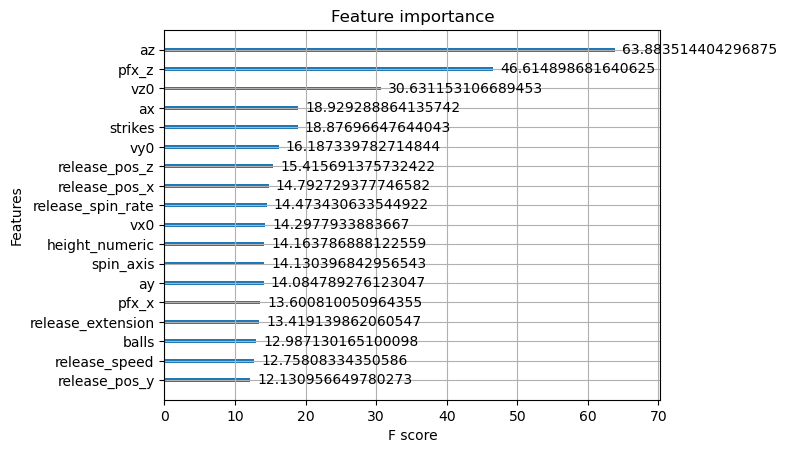

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

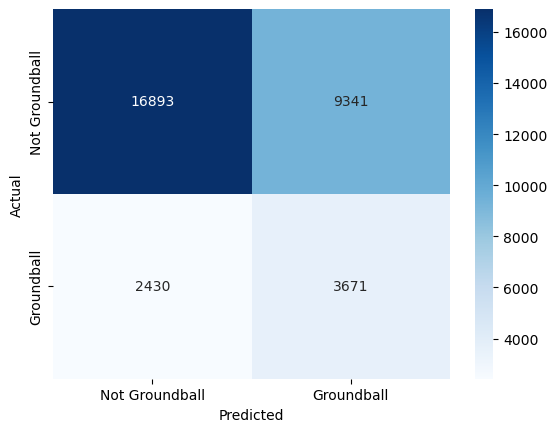

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
y_pred = final_model.predict(predictions)

In [27]:
testing_identifiers['xgb'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_18680\1805931578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xgb'] = y_pred


In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/gb_2022&3_xgb.csv")